In [1]:
_server_root = ""
_data_uuid = ""
_result_path = ""


In [2]:
# Parameters
_server_root = "/home/lyiran/neelptycho/server"
_data_uuid = "769ca1f2-c81b-5f1b-bc2e-f4e8faae2a20"
_result_path = (
    "/home/lyiran/neelptycho/server/results/task_SimpleSimScikit_ePIE_padding_1"
)


In [3]:
import uuid
data_uuid = uuid.UUID(_data_uuid)
from pathlib import Path
result_path = Path(_result_path)
import sys, os
sys.path.append(_server_root)

In [4]:
# Timer
import time
start_time = time.time()

## ePIE Analysis

In [5]:
from library.data import get_data_path
import yaml
from library.utils import load_params, add_colordisk_hsv, complex_to_hsv, with_default_unit
import h5py
import tables
data_path = get_data_path(data_uuid)
p = load_params("ePIE")
with h5py.File(data_path, "r") as file:
    attrs = dict(file.attrs)
    dp_shape = file["/data"].shape[-2:]
    dps = file["/data"][()].reshape((attrs["height"], attrs["width"]) + dp_shape)

if "semiconv_pix" in p:
    attrs["semiconv_pix"] = p["semiconv_pix"]
if "rotation" in p:
    attrs["rotation"] = with_default_unit(p["rotation"], "degree")

if "defocus" not in p["ePIE"]:
    p["ePIE"]["defocus"] = 0
p["ePIE"]["defocus"] = with_default_unit(p["ePIE"]["defocus"], "m")

In [6]:
from epie.param_manager import ParamTree, PtychoParams, DatasetParams, NumericalParams
from epie.utils import wavelength
dataset_params = ParamTree(
    # Base dataset information
    dataset_name=attrs["name"],
    format="mib",
    acquisition_time=attrs["datetime"],
    # Scan/Diff Geometry
    scan_height_raw=attrs["height"], # the true number of scan rows acquired before pre-processing
    scan_width_raw=attrs["width"], # the true number of scan columns acquired before pre-processing
    scan_origin="top-left", # where does the scan coordinate system have its origin
                           # a string combination of 'top/bottom-left/right'
                           # top implies positive=downwards, right implies positive=leftwards
    scan_skip_rows=(0,0), # number of rows to skip at start (origin) and end of height
    scan_skip_cols=(0,0), # number of columns to skip at start (origin) and end of width
    scan_step_row_ang=attrs["stepsize"] * 1e10, # scan step in angstroms between rows
    scan_step_col_ang=attrs.get("stepsize_y", attrs["stepsize"]) * 1e10, # scan step in angstroms between columns
    scan_to_diff_rot_deg=attrs["rotation"], # rotation in degrees from a scan coordinate dimension to equivalent diffraction pattern coordinate
    diff_height_raw=dps.shape[2], # the true number of diff rows per-frame before pre-processing
    diff_width_raw=dps.shape[3], # the true number of diff columns per-frame before pre-processing
    diff_origin="top-left", # same definition as scan_origin
    # Acquisition parameters
    aperture_size_mrad=attrs["semiconv"] * 1e3,
    aperture_size_px=attrs["semiconv_pix"],
    beam_voltage_kv=attrs["voltage"],
    defocus_ang=p["ePIE"]["defocus"] * 1e10,
    pixel_size_detector_m=attrs["psize"], # in metres
    # Processed dataset dimensions
    # These values are used in preference to the above ones when present
    scan_height=attrs["height"],
    scan_width=attrs["width"],
    diff_height=dps.shape[2],
    diff_width=dps.shape[3],
    #wavelength_m=wavelength(attrs["voltage"]),
    #wavelength_pm=wavelength(attrs["voltage"])*1e12
)
reconst_params = ParamTree(
    enable_circular_cutoff=p["ePIE"].get("enable_circular_cutoff", False),
    diff_cutoff_radius_fraction=p["ePIE"]["diff_cutoff_radius_fraction"],
    diff_intensity_lower_cutoff=p["ePIE"]["diff_intensity_lower_cutoff"],
    diff_origin_shift=p["ePIE"]["diff_origin_shift"],
    diff_padding_factor=p["ePIE"]["diff_padding_factor"],
    diff_stride=p["ePIE"]["diff_stride"],
    binning_factor=p["ePIE"].get("binning_factor", 1),
    n_iteration_frozen_probe=p["ePIE"]["n_iteration_frozen_probe"],
    probe_update_interval=p["ePIE"].get("probe_update_interval", 1),
    n_iteration_target=p["ePIE"]["n_iteration_target"],
    scan_stride=p["ePIE"]["scan_stride"],
    alpha=p["ePIE"]["alpha"],
    beta=p["ePIE"]["beta"],
    force_aperture_mask=p["ePIE"].get("force_aperture_mask", False),
    force_weak_phase_approx=p["ePIE"].get("force_weak_phase_approx", False),
    force_relative=p["ePIE"].get("force_relative", False)
)

import yaml
print("--- data.yaml ---")
print(yaml.dump(dataset_params))
print("--- reconst.yaml ---")
print(yaml.dump(reconst_params))

--- data.yaml ---
!!python/object/new:epie.param_manager.ParamTree
dictitems:
  acquisition_time: !!python/object/apply:numpy.core.multiarray.scalar
  - !!python/object/apply:numpy.dtype
    args:
    - S19
    - false
    - true
    state: !!python/tuple
    - 3
    - '|'
    - null
    - null
    - null
    - 19
    - 1
    - 0
  - !!binary |
    MjAyNC0wNS0yMlQxMDo0MDowMA==
  aperture_size_mrad: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - !!binary |
    AAAAAAAANEA=
  aperture_size_px: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - !!binary |
    hetRuB6FKEA=
  beam_voltage_kv: !!python/object/apply:numpy.core.multiarray.scalar
  - &id002 !!python/object/apply:numpy.dtype
    args:
    - i4
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
   

In [7]:
# the pixel size of reconstructed image
cbed_dimension_reconst = dataset_params["diff_width"] / reconst_params["diff_stride"] * reconst_params["diff_padding_factor"]
resolution_reciprocal_space_rad = attrs["semiconv"] / attrs["semiconv_pix"] * reconst_params["diff_stride"]
resolution_reciprocal_space = resolution_reciprocal_space_rad / wavelength(attrs["voltage"])
resolution_real_space = 1.0 / (resolution_reciprocal_space * cbed_dimension_reconst)

print(f"Resolutions:")
print(f"  Reciprocal Space : {resolution_reciprocal_space_rad} rad")
print(f"  Reciprocal Space : {resolution_reciprocal_space / 1e10} Å^{-1}")
print(f"  Real Space       : {resolution_real_space * 1e10} Å")

Resolutions:
  Reciprocal Space : 0.0016313213703099511 rad
  Reciprocal Space : 0.03906633474804123 Å^-1
  Real Space       : 0.19998036801729185 Å


In [8]:
import numpy as np
if os.path.exists("probe_init.npy"):
    print("initial probe found")
    probe0 = np.load("probe_init.npy")
else:
    probe0 = None

if os.path.exists("object_init.npy"):
    print("initial object found")
    obj0 = np.load("object_init.npy")
else:
    obj0 = None

In [9]:
from epie.lib import run_epie
from epie.gpu_utils import set_device
from pprint import pprint
params = PtychoParams()
params["dataset"] = DatasetParams(**dataset_params)
params["numerical"] = NumericalParams(**reconst_params)

print(params.dataset.__class__)
print(params.dataset.wavelength_pm)
pprint(params)

with set_device(dev_id=1):
    obj, probe = run_epie(dps, params, results_directory=result_path, probe0=probe0, obj0=obj0)

<class 'epie.param_manager.DatasetParams'>
4.1757727742599275
{'dataset': {'acquisition_time': b'2024-05-22T10:40:00',
             'aperture_size_mrad': 20.0,
             'aperture_size_px': 12.26,
             'beam_voltage_kv': 80,
             'dataset_name': b'Simple Simulation from Scikit Image',
             'defocus_ang': 0.0,
             'diff_height': 128,
             'diff_height_raw': 128,
             'diff_origin': 'top-left',
             'diff_width': 128,
             'diff_width_raw': 128,
             'format': 'mib',
             'pixel_size_detector_m': 5.5e-05,
             'scan_height': 71,
             'scan_height_raw': 71,
             'scan_origin': 'top-left',
             'scan_skip_cols': (0, 0),
             'scan_skip_rows': (0, 0),
             'scan_step_col_ang': 1.0,
             'scan_step_row_ang': 1.0,
             'scan_to_diff_rot_deg': 0,
             'scan_width': 71,
             'scan_width_raw': 71},
 'numerical': {'alpha': 0.7,
       

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 1/5041 [00:00<12:35,  6.67it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:34, 145.60it/s]

DP iterations:   1%|          | 49/5041 [00:00<00:36, 135.35it/s]

DP iterations:   2%|▏         | 85/5041 [00:00<00:23, 208.06it/s]

DP iterations:   2%|▏         | 120/5041 [00:00<00:19, 246.14it/s]

DP iterations:   3%|▎         | 154/5041 [00:00<00:17, 271.97it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:17, 284.88it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:15, 309.97it/s]

DP iterations:   5%|▌         | 255/5041 [00:01<00:16, 297.92it/s]

DP iterations:   6%|▌         | 286/5041 [00:01<00:19, 246.06it/s]

DP iterations:   6%|▌         | 313/5041 [00:01<00:25, 184.77it/s]

DP iterations:   7%|▋         | 335/5041 [00:01<00:30, 156.48it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:23, 197.49it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:22, 210.06it/s]

DP iterations:   9%|▊         | 436/5041 [00:01<00:18, 249.01it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:16, 281.05it/s]

DP iterations:  10%|█         | 505/5041 [00:02<00:16, 276.65it/s]

DP iterations:  11%|█         | 535/5041 [00:02<00:16, 271.20it/s]

DP iterations:  11%|█▏        | 569/5041 [00:02<00:15, 283.26it/s]

DP iterations:  12%|█▏        | 599/5041 [00:02<00:16, 273.20it/s]

DP iterations:  12%|█▏        | 628/5041 [00:02<00:16, 269.94it/s]

DP iterations:  13%|█▎        | 656/5041 [00:02<00:16, 267.77it/s]

DP iterations:  14%|█▎        | 690/5041 [00:02<00:15, 284.22it/s]

DP iterations:  14%|█▍        | 719/5041 [00:02<00:15, 274.11it/s]

DP iterations:  15%|█▍        | 747/5041 [00:03<00:16, 267.09it/s]

DP iterations:  15%|█▌        | 774/5041 [00:03<00:15, 267.31it/s]

DP iterations:  16%|█▌        | 813/5041 [00:03<00:14, 299.98it/s]

DP iterations:  17%|█▋        | 851/5041 [00:03<00:13, 322.26it/s]

DP iterations:  18%|█▊        | 884/5041 [00:03<00:13, 303.57it/s]

DP iterations:  18%|█▊        | 919/5041 [00:03<00:13, 314.96it/s]

DP iterations:  19%|█▉        | 951/5041 [00:03<00:13, 292.99it/s]

DP iterations:  19%|█▉        | 981/5041 [00:03<00:14, 283.23it/s]

DP iterations:  20%|██        | 1010/5041 [00:03<00:14, 280.40it/s]

DP iterations:  21%|██        | 1039/5041 [00:04<00:14, 281.38it/s]

DP iterations:  21%|██        | 1069/5041 [00:04<00:14, 282.29it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:04<00:13, 286.38it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:04<00:15, 249.89it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:04<00:13, 283.83it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:04<00:12, 312.37it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:04<00:11, 334.78it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:04<00:10, 352.73it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:04<00:10, 363.44it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:05<00:09, 370.18it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:05<00:09, 374.98it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:05<00:14, 254.41it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:05<00:15, 235.82it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:05<00:14, 239.81it/s]

DP iterations:  30%|███       | 1527/5041 [00:05<00:14, 240.46it/s]

DP iterations:  31%|███       | 1555/5041 [00:05<00:14, 248.96it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:05<00:13, 259.82it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:06<00:12, 263.85it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:06<00:12, 262.51it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:06<00:11, 284.92it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:06<00:11, 301.77it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:06<00:10, 313.64it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:06<00:10, 317.24it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:06<00:10, 297.96it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:06<00:14, 222.34it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:07<00:20, 154.27it/s]

DP iterations:  38%|███▊      | 1898/5041 [00:07<00:17, 175.23it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:07<00:15, 195.84it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:07<00:14, 209.61it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:07<00:13, 234.51it/s]

DP iterations:  40%|████      | 2021/5041 [00:07<00:11, 260.04it/s]

DP iterations:  41%|████      | 2050/5041 [00:07<00:11, 254.49it/s]

DP iterations:  41%|████      | 2078/5041 [00:08<00:11, 251.01it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:08<00:16, 177.10it/s]

DP iterations:  42%|████▏     | 2127/5041 [00:08<00:25, 115.80it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:08<00:26, 109.81it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:08<00:19, 147.36it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:09<00:15, 183.61it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:09<00:13, 201.40it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:09<00:12, 223.86it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:09<00:12, 228.56it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:09<00:11, 231.92it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:09<00:11, 235.62it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:09<00:14, 183.87it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:10<00:19, 134.14it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:10<00:15, 173.19it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:10<00:12, 206.92it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:10<00:11, 222.97it/s]

DP iterations:  50%|█████     | 2522/5041 [00:10<00:11, 228.59it/s]

DP iterations:  51%|█████     | 2548/5041 [00:10<00:15, 156.80it/s]

DP iterations:  51%|█████     | 2569/5041 [00:11<00:20, 120.66it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:11<00:20, 116.92it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:11<00:15, 157.71it/s]

DP iterations:  53%|█████▎    | 2655/5041 [00:11<00:12, 193.91it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:11<00:10, 226.33it/s]

DP iterations:  54%|█████▍    | 2717/5041 [00:11<00:14, 162.63it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:12<00:16, 141.54it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:12<00:18, 124.80it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:12<00:18, 123.67it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:12<00:14, 156.82it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:12<00:11, 195.83it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:12<00:09, 228.54it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:12<00:09, 231.15it/s]

DP iterations:  58%|█████▊    | 2925/5041 [00:12<00:09, 234.20it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:13<00:08, 237.28it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:13<00:11, 185.29it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:13<00:16, 126.96it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:13<00:15, 132.74it/s]

DP iterations:  61%|██████    | 3050/5041 [00:13<00:11, 175.29it/s]

DP iterations:  61%|██████    | 3084/5041 [00:13<00:09, 211.05it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:14<00:08, 234.08it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:14<00:11, 166.43it/s]

DP iterations:  63%|██████▎   | 3164/5041 [00:14<00:15, 118.15it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:14<00:17, 104.34it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:15<00:12, 142.28it/s]

DP iterations:  64%|██████▍   | 3251/5041 [00:15<00:10, 178.15it/s]

DP iterations:  65%|██████▌   | 3285/5041 [00:15<00:08, 210.44it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:15<00:07, 218.84it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:15<00:08, 197.48it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:15<00:12, 138.85it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:16<00:15, 107.14it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:16<00:11, 143.36it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:16<00:08, 178.39it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:16<00:07, 209.17it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:16<00:07, 217.37it/s]

DP iterations:  70%|███████   | 3537/5041 [00:16<00:06, 221.59it/s]

DP iterations:  71%|███████   | 3563/5041 [00:16<00:09, 153.04it/s]

DP iterations:  71%|███████   | 3584/5041 [00:17<00:13, 111.95it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:17<00:11, 128.86it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:17<00:08, 166.47it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:17<00:06, 199.90it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:17<00:05, 230.85it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:17<00:05, 234.73it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:17<00:05, 237.66it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:18<00:06, 198.58it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:18<00:09, 135.96it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:18<00:09, 124.76it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:18<00:07, 155.06it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:18<00:06, 190.12it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:18<00:05, 222.41it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:19<00:06, 171.23it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:19<00:07, 138.68it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:19<00:07, 143.28it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:19<00:06, 152.66it/s]

DP iterations:  80%|████████  | 4048/5041 [00:19<00:05, 194.43it/s]

DP iterations:  81%|████████  | 4082/5041 [00:19<00:04, 229.54it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:19<00:03, 255.15it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:20<00:03, 275.21it/s]

DP iterations:  83%|████████▎ | 4180/5041 [00:20<00:03, 282.80it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:20<00:04, 203.70it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:20<00:06, 122.71it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:20<00:05, 131.49it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:21<00:04, 169.79it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:21<00:03, 182.23it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:21<00:03, 216.44it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:21<00:03, 218.52it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:21<00:04, 144.80it/s]

DP iterations:  88%|████████▊ | 4420/5041 [00:21<00:05, 123.60it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:22<00:05, 119.12it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:22<00:03, 158.83it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:22<00:03, 177.15it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:22<00:02, 206.09it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:22<00:02, 227.54it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:22<00:02, 217.26it/s]

DP iterations:  91%|█████████▏| 4609/5041 [00:22<00:02, 193.17it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:23<00:02, 169.91it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:23<00:02, 150.72it/s]

DP iterations:  93%|█████████▎| 4667/5041 [00:23<00:02, 152.04it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:23<00:01, 190.56it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:23<00:01, 173.87it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:23<00:01, 217.76it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:23<00:00, 257.77it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:23<00:00, 246.01it/s]

DP iterations:  96%|█████████▌| 4850/5041 [00:24<00:00, 224.17it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:24<00:00, 209.91it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:24<00:00, 176.20it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:24<00:00, 210.40it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:24<00:00, 250.46it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:24<00:00, 241.92it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:24<00:00, 239.50it/s]

Epochs:   1%|          | 1/100 [00:26<43:16, 26.23s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 24/5041 [00:00<00:21, 238.83it/s]

DP iterations:   1%|          | 51/5041 [00:00<00:19, 253.78it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:17, 277.53it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:16, 299.13it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:17, 276.49it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:17, 273.15it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:17, 284.27it/s]

DP iterations:   5%|▍         | 236/5041 [00:00<00:17, 273.78it/s]

DP iterations:   5%|▌         | 264/5041 [00:00<00:17, 267.73it/s]

DP iterations:   6%|▌         | 291/5041 [00:01<00:17, 266.83it/s]

DP iterations:   6%|▋         | 325/5041 [00:01<00:16, 286.41it/s]

DP iterations:   7%|▋         | 354/5041 [00:01<00:19, 236.66it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:26, 178.17it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:22, 210.07it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:20, 228.33it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:24, 190.08it/s]

DP iterations:  10%|▉         | 492/5041 [00:02<00:26, 168.62it/s]

DP iterations:  10%|█         | 518/5041 [00:02<00:24, 187.71it/s]

DP iterations:  11%|█         | 552/5041 [00:02<00:20, 222.00it/s]

DP iterations:  12%|█▏        | 586/5041 [00:02<00:17, 249.98it/s]

DP iterations:  12%|█▏        | 614/5041 [00:02<00:17, 250.19it/s]

DP iterations:  13%|█▎        | 641/5041 [00:02<00:17, 249.10it/s]

DP iterations:  13%|█▎        | 668/5041 [00:02<00:18, 230.59it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:16, 256.22it/s]

DP iterations:  14%|█▍        | 728/5041 [00:03<00:16, 255.03it/s]

DP iterations:  15%|█▍        | 755/5041 [00:03<00:17, 238.77it/s]

DP iterations:  15%|█▌        | 780/5041 [00:03<00:25, 167.35it/s]

DP iterations:  16%|█▌        | 810/5041 [00:03<00:21, 194.38it/s]

DP iterations:  17%|█▋        | 844/5041 [00:03<00:18, 226.47it/s]

DP iterations:  17%|█▋        | 870/5041 [00:03<00:21, 196.80it/s]

DP iterations:  18%|█▊        | 893/5041 [00:04<00:25, 165.60it/s]

DP iterations:  18%|█▊        | 927/5041 [00:04<00:20, 200.82it/s]

DP iterations:  19%|█▉        | 954/5041 [00:04<00:19, 210.29it/s]

DP iterations:  19%|█▉        | 978/5041 [00:04<00:22, 180.75it/s]

DP iterations:  20%|█▉        | 999/5041 [00:04<00:27, 145.44it/s]

DP iterations:  20%|██        | 1032/5041 [00:04<00:22, 181.70it/s]

DP iterations:  21%|██        | 1061/5041 [00:04<00:19, 199.36it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:04<00:17, 225.00it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:05<00:17, 230.13it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:05<00:16, 234.20it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:05<00:17, 220.01it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:05<00:15, 248.70it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:05<00:14, 271.76it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:05<00:14, 255.08it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:05<00:14, 252.47it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:05<00:15, 240.24it/s]

DP iterations:  27%|██▋       | 1351/5041 [00:05<00:13, 264.23it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:06<00:14, 256.75it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:06<00:14, 253.08it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:06<00:14, 254.72it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:06<00:19, 187.31it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:06<00:17, 201.57it/s]

DP iterations:  30%|███       | 1516/5041 [00:06<00:15, 232.74it/s]

DP iterations:  31%|███       | 1547/5041 [00:06<00:14, 249.09it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:06<00:13, 257.42it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:07<00:13, 261.27it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:07<00:12, 280.24it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:07<00:12, 274.54it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:07<00:12, 272.06it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:07<00:11, 276.82it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:07<00:12, 269.30it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:07<00:12, 262.73it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:07<00:12, 258.37it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:07<00:12, 252.80it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:08<00:11, 274.02it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:08<00:10, 290.55it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:08<00:11, 277.31it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:08<00:11, 269.05it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:08<00:10, 286.92it/s]

DP iterations:  40%|████      | 2029/5041 [00:08<00:10, 297.70it/s]

DP iterations:  41%|████      | 2059/5041 [00:08<00:10, 283.76it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:08<00:10, 274.44it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:08<00:10, 268.99it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:09<00:16, 174.10it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:09<00:14, 192.58it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:09<00:12, 224.44it/s]

DP iterations:  44%|████▍     | 2236/5041 [00:09<00:11, 242.08it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:09<00:11, 250.24it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:09<00:10, 272.28it/s]

DP iterations:  46%|████▌     | 2327/5041 [00:09<00:13, 204.07it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:10<00:19, 137.20it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:10<00:21, 121.86it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:10<00:16, 156.77it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:10<00:13, 186.09it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:10<00:11, 217.93it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:10<00:11, 229.47it/s]

DP iterations:  50%|█████     | 2525/5041 [00:11<00:10, 238.82it/s]

DP iterations:  51%|█████     | 2552/5041 [00:11<00:15, 159.39it/s]

DP iterations:  51%|█████     | 2574/5041 [00:11<00:21, 117.36it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:11<00:17, 138.47it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:11<00:13, 173.85it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:11<00:11, 207.67it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:12<00:14, 163.66it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:12<00:18, 123.22it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:12<00:23, 98.68it/s] 

DP iterations:  55%|█████▍    | 2748/5041 [00:12<00:21, 105.88it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:13<00:15, 146.03it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:13<00:12, 183.77it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:13<00:11, 195.12it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:13<00:10, 206.85it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:13<00:12, 169.66it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:13<00:17, 122.68it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:14<00:20, 100.70it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:14<00:17, 118.47it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:14<00:12, 159.90it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:14<00:10, 197.34it/s]

DP iterations:  60%|██████    | 3042/5041 [00:14<00:09, 207.06it/s]

DP iterations:  61%|██████    | 3067/5041 [00:14<00:09, 215.67it/s]

DP iterations:  61%|██████▏   | 3095/5041 [00:14<00:08, 229.77it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:14<00:07, 244.00it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:15<00:08, 227.64it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:15<00:11, 158.77it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:15<00:12, 147.18it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:15<00:09, 184.33it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:15<00:08, 218.53it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:15<00:07, 246.61it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:15<00:06, 252.06it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:15<00:06, 253.27it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:16<00:06, 254.86it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:16<00:06, 257.04it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:16<00:06, 256.71it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:16<00:06, 254.36it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:16<00:06, 254.64it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:16<00:06, 252.82it/s]

DP iterations:  70%|███████   | 3547/5041 [00:16<00:05, 275.66it/s]

DP iterations:  71%|███████   | 3581/5041 [00:16<00:05, 291.93it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:16<00:04, 303.62it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:17<00:04, 311.09it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:17<00:04, 291.24it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:17<00:04, 278.99it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:17<00:06, 203.66it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:17<00:08, 152.70it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:17<00:08, 140.12it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:18<00:06, 177.04it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:18<00:05, 210.37it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:18<00:04, 237.70it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:18<00:04, 236.71it/s]

DP iterations:  78%|███████▊  | 3938/5041 [00:18<00:06, 164.83it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:18<00:08, 123.20it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:19<00:09, 111.00it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:19<00:06, 148.27it/s]

DP iterations:  80%|████████  | 4045/5041 [00:19<00:05, 183.96it/s]

DP iterations:  81%|████████  | 4079/5041 [00:19<00:04, 215.93it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:19<00:04, 223.96it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:19<00:03, 230.71it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:19<00:03, 226.91it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:20<00:05, 161.48it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:20<00:06, 121.27it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:20<00:05, 146.38it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:20<00:04, 182.45it/s]

DP iterations:  85%|████████▌ | 4297/5041 [00:20<00:03, 214.83it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:20<00:03, 218.60it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:20<00:03, 228.78it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:21<00:02, 246.12it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:21<00:02, 243.55it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:21<00:02, 239.95it/s]

DP iterations:  88%|████████▊ | 4459/5041 [00:21<00:02, 236.98it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:21<00:02, 239.14it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:21<00:02, 251.59it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:21<00:01, 258.83it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:21<00:01, 255.01it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:21<00:01, 254.22it/s]

DP iterations:  92%|█████████▏| 4630/5041 [00:22<00:01, 275.92it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:22<00:01, 292.13it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:22<00:01, 302.64it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:22<00:01, 230.10it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:22<00:01, 166.49it/s]

DP iterations:  95%|█████████▍| 4775/5041 [00:22<00:01, 143.49it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:23<00:01, 135.72it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:23<00:01, 163.00it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:23<00:00, 199.97it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:23<00:00, 231.48it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:23<00:00, 256.84it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:23<00:00, 238.88it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:23<00:00, 187.40it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:23<00:00, 183.61it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:24<00:00, 191.69it/s]

Epochs:   2%|▏         | 2/100 [00:51<41:45, 25.56s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:15, 330.71it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:19, 258.99it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:17, 274.65it/s]

DP iterations:   3%|▎         | 127/5041 [00:00<00:18, 265.73it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:16, 287.71it/s]

DP iterations:   4%|▍         | 195/5041 [00:00<00:16, 302.52it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:19, 241.00it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:18, 264.81it/s]

DP iterations:   6%|▌         | 293/5041 [00:01<00:16, 281.81it/s]

DP iterations:   6%|▋         | 323/5041 [00:01<00:17, 272.91it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:17, 263.94it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:17, 260.45it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:17, 258.07it/s]

DP iterations:   9%|▊         | 434/5041 [00:01<00:21, 215.52it/s]

DP iterations:   9%|▉         | 467/5041 [00:01<00:18, 242.37it/s]

DP iterations:  10%|▉         | 495/5041 [00:01<00:18, 250.15it/s]

DP iterations:  10%|█         | 524/5041 [00:02<00:17, 260.46it/s]

DP iterations:  11%|█         | 551/5041 [00:02<00:17, 253.33it/s]

DP iterations:  11%|█▏        | 577/5041 [00:02<00:18, 247.85it/s]

DP iterations:  12%|█▏        | 611/5041 [00:02<00:16, 271.26it/s]

DP iterations:  13%|█▎        | 639/5041 [00:02<00:19, 224.37it/s]

DP iterations:  13%|█▎        | 664/5041 [00:02<00:31, 140.87it/s]

DP iterations:  14%|█▎        | 683/5041 [00:02<00:29, 148.35it/s]

DP iterations:  14%|█▍        | 716/5041 [00:03<00:23, 184.76it/s]

DP iterations:  15%|█▍        | 739/5041 [00:03<00:22, 194.81it/s]

DP iterations:  15%|█▌        | 766/5041 [00:03<00:20, 205.71it/s]

DP iterations:  16%|█▌        | 797/5041 [00:03<00:18, 224.01it/s]

DP iterations:  16%|█▋        | 826/5041 [00:03<00:17, 240.85it/s]

DP iterations:  17%|█▋        | 860/5041 [00:03<00:15, 265.36it/s]

DP iterations:  18%|█▊        | 888/5041 [00:03<00:22, 182.50it/s]

DP iterations:  18%|█▊        | 911/5041 [00:04<00:27, 149.14it/s]

DP iterations:  19%|█▊        | 937/5041 [00:04<00:24, 169.69it/s]

DP iterations:  19%|█▉        | 970/5041 [00:04<00:19, 203.64it/s]

DP iterations:  20%|█▉        | 995/5041 [00:04<00:19, 211.57it/s]

DP iterations:  20%|██        | 1020/5041 [00:04<00:18, 216.98it/s]

DP iterations:  21%|██        | 1048/5041 [00:04<00:17, 230.27it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:04<00:15, 248.12it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:04<00:14, 271.06it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:05<00:21, 178.20it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:05<00:26, 144.05it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:05<00:22, 168.48it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:05<00:18, 201.75it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:05<00:21, 179.89it/s]

DP iterations:  25%|██▌       | 1272/5041 [00:05<00:21, 177.40it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:05<00:17, 211.57it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:06<00:18, 204.47it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:06<00:24, 151.69it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:06<00:28, 128.61it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:06<00:21, 166.34it/s]

DP iterations:  28%|██▊       | 1425/5041 [00:06<00:20, 175.50it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:07<00:25, 143.64it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:07<00:21, 167.37it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:07<00:17, 204.32it/s]

DP iterations:  31%|███       | 1538/5041 [00:07<00:15, 229.27it/s]

DP iterations:  31%|███       | 1565/5041 [00:07<00:14, 238.22it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:07<00:14, 239.64it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:07<00:14, 240.74it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:07<00:14, 240.18it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:07<00:12, 265.05it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:07<00:12, 268.93it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:08<00:12, 268.96it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:08<00:11, 275.26it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:08<00:11, 272.24it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:08<00:12, 266.84it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:08<00:12, 262.22it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:08<00:11, 281.16it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:08<00:11, 274.40it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:08<00:15, 199.15it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:09<00:14, 211.89it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:09<00:12, 241.65it/s]

DP iterations:  40%|████      | 2025/5041 [00:09<00:12, 246.28it/s]

DP iterations:  41%|████      | 2052/5041 [00:09<00:12, 248.24it/s]

DP iterations:  41%|████      | 2079/5041 [00:09<00:11, 248.07it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:09<00:11, 249.14it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:09<00:11, 245.99it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:09<00:10, 270.60it/s]

DP iterations:  44%|████▎     | 2199/5041 [00:09<00:09, 288.08it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:10<00:09, 281.73it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:10<00:10, 267.24it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:10<00:10, 258.67it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:10<00:09, 279.24it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:10<00:10, 265.06it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:10<00:10, 255.98it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:10<00:10, 259.05it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:10<00:10, 260.07it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:10<00:12, 213.09it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:11<00:10, 241.15it/s]

DP iterations:  50%|█████     | 2521/5041 [00:11<00:09, 253.03it/s]

DP iterations:  51%|█████     | 2548/5041 [00:11<00:13, 185.92it/s]

DP iterations:  51%|█████     | 2582/5041 [00:11<00:11, 218.49it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:11<00:09, 245.88it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:11<00:09, 249.41it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:11<00:11, 212.15it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:12<00:14, 157.59it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:12<00:12, 190.98it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:12<00:10, 221.92it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:12<00:09, 226.66it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:12<00:09, 229.89it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:12<00:08, 255.43it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:12<00:07, 276.17it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:12<00:08, 263.09it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:13<00:08, 254.92it/s]

DP iterations:  59%|█████▉    | 2968/5041 [00:13<00:08, 251.26it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:13<00:07, 259.77it/s]

DP iterations:  60%|██████    | 3026/5041 [00:13<00:07, 264.64it/s]

DP iterations:  61%|██████    | 3053/5041 [00:13<00:07, 256.29it/s]

DP iterations:  61%|██████    | 3079/5041 [00:13<00:07, 252.16it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:13<00:07, 274.65it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:13<00:06, 290.20it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:13<00:06, 280.45it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:14<00:06, 272.11it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:14<00:06, 288.07it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:14<00:05, 300.30it/s]

DP iterations:  66%|██████▌   | 3303/5041 [00:14<00:09, 190.64it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:14<00:11, 147.92it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:14<00:09, 180.96it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:15<00:07, 210.84it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:15<00:07, 219.85it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:15<00:07, 224.23it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:15<00:06, 251.58it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:15<00:05, 273.05it/s]

DP iterations:  70%|███████   | 3546/5041 [00:15<00:07, 210.49it/s]

DP iterations:  71%|███████   | 3571/5041 [00:15<00:10, 143.14it/s]

DP iterations:  71%|███████   | 3591/5041 [00:16<00:09, 148.86it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:16<00:07, 184.99it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:16<00:06, 216.23it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:16<00:06, 225.89it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:16<00:05, 252.85it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:16<00:05, 249.69it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:16<00:05, 251.41it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:16<00:04, 262.09it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:16<00:04, 264.94it/s]

DP iterations:  77%|███████▋  | 3864/5041 [00:17<00:04, 259.07it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:17<00:04, 252.94it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:17<00:04, 249.15it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:17<00:04, 244.02it/s]

DP iterations:  79%|███████▉  | 3976/5041 [00:17<00:03, 267.87it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:17<00:03, 286.15it/s]

DP iterations:  80%|████████  | 4039/5041 [00:17<00:03, 280.41it/s]

DP iterations:  81%|████████  | 4073/5041 [00:17<00:03, 295.09it/s]

DP iterations:  81%|████████▏ | 4107/5041 [00:17<00:03, 305.46it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:18<00:03, 284.18it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:18<00:03, 270.21it/s]

DP iterations:  83%|████████▎ | 4195/5041 [00:18<00:03, 261.95it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:18<00:03, 256.05it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:18<00:03, 251.34it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:18<00:03, 232.52it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:18<00:03, 207.62it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:18<00:02, 239.43it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:19<00:02, 237.33it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:19<00:02, 263.52it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:19<00:02, 282.75it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:19<00:02, 271.45it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:19<00:02, 264.53it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:19<00:02, 261.45it/s]

DP iterations:  90%|████████▉ | 4536/5041 [00:19<00:02, 207.23it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:20<00:03, 152.96it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:20<00:02, 188.90it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:20<00:01, 220.70it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:20<00:01, 247.37it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:20<00:01, 268.76it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:20<00:01, 262.26it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:20<00:01, 258.62it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:20<00:01, 255.71it/s]

DP iterations:  95%|█████████▌| 4809/5041 [00:20<00:01, 218.98it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:21<00:01, 148.97it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:21<00:01, 160.22it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:21<00:00, 197.02it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:21<00:00, 228.67it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:21<00:00, 257.25it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:21<00:00, 260.19it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:21<00:00, 272.36it/s]

Epochs:   3%|▎         | 3/100 [01:14<39:21, 24.35s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 12/5041 [00:00<01:15, 66.32it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:35, 142.72it/s]

DP iterations:   1%|▏         | 66/5041 [00:00<00:26, 191.18it/s]

DP iterations:   2%|▏         | 96/5041 [00:00<00:21, 226.26it/s]

DP iterations:   2%|▏         | 123/5041 [00:00<00:20, 238.74it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:20, 240.05it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:20, 241.17it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:20, 241.80it/s]

DP iterations:   4%|▍         | 223/5041 [00:01<00:21, 223.12it/s]

DP iterations:   5%|▍         | 246/5041 [00:01<00:21, 220.97it/s]

DP iterations:   6%|▌         | 279/5041 [00:01<00:18, 251.33it/s]

DP iterations:   6%|▌         | 313/5041 [00:01<00:17, 274.83it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:16, 291.29it/s]

DP iterations:   7%|▋         | 377/5041 [00:01<00:19, 236.17it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:29, 157.72it/s]

DP iterations:   8%|▊         | 424/5041 [00:02<00:37, 123.63it/s]

DP iterations:   9%|▊         | 441/5041 [00:02<00:35, 129.53it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:27, 167.53it/s]

DP iterations:  10%|█         | 508/5041 [00:02<00:22, 203.13it/s]

DP iterations:  11%|█         | 542/5041 [00:02<00:19, 233.34it/s]

DP iterations:  11%|█▏        | 570/5041 [00:02<00:18, 236.96it/s]

DP iterations:  12%|█▏        | 597/5041 [00:02<00:18, 241.18it/s]

DP iterations:  12%|█▏        | 624/5041 [00:02<00:18, 243.40it/s]

DP iterations:  13%|█▎        | 650/5041 [00:03<00:22, 192.41it/s]

DP iterations:  13%|█▎        | 672/5041 [00:03<00:30, 142.94it/s]

DP iterations:  14%|█▎        | 690/5041 [00:03<00:29, 146.31it/s]

DP iterations:  14%|█▍        | 723/5041 [00:03<00:23, 184.60it/s]

DP iterations:  15%|█▍        | 756/5041 [00:03<00:19, 217.98it/s]

DP iterations:  16%|█▌        | 790/5041 [00:03<00:17, 246.50it/s]

DP iterations:  16%|█▌        | 818/5041 [00:03<00:16, 249.44it/s]

DP iterations:  17%|█▋        | 845/5041 [00:04<00:17, 233.43it/s]

DP iterations:  17%|█▋        | 870/5041 [00:04<00:21, 191.55it/s]

DP iterations:  18%|█▊        | 892/5041 [00:04<00:27, 149.48it/s]

DP iterations:  18%|█▊        | 910/5041 [00:04<00:33, 125.08it/s]

DP iterations:  19%|█▊        | 943/5041 [00:04<00:25, 162.97it/s]

DP iterations:  19%|█▉        | 976/5041 [00:04<00:20, 197.89it/s]

DP iterations:  20%|██        | 1010/5041 [00:05<00:17, 229.38it/s]

DP iterations:  21%|██        | 1037/5041 [00:05<00:17, 234.13it/s]

DP iterations:  21%|██        | 1064/5041 [00:05<00:16, 238.86it/s]

DP iterations:  22%|██▏       | 1090/5041 [00:05<00:16, 241.11it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:05<00:16, 243.44it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:05<00:16, 241.76it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:05<00:16, 234.72it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:05<00:22, 172.33it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:06<00:25, 150.41it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:06<00:20, 188.34it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:06<00:16, 222.12it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:06<00:16, 229.69it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:06<00:15, 234.99it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:06<00:15, 237.48it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:06<00:15, 237.86it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:06<00:15, 232.23it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:07<00:19, 183.27it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:07<00:25, 143.29it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:07<00:24, 144.94it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:07<00:19, 185.68it/s]

DP iterations:  30%|███       | 1535/5041 [00:07<00:15, 220.99it/s]

DP iterations:  31%|███       | 1567/5041 [00:07<00:14, 238.05it/s]

DP iterations:  32%|███▏      | 1596/5041 [00:07<00:14, 245.25it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:07<00:14, 240.15it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:08<00:19, 174.16it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:08<00:27, 124.29it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:08<00:27, 121.14it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:08<00:20, 160.60it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:08<00:16, 195.66it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:09<00:15, 206.37it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:09<00:14, 218.31it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:09<00:19, 164.68it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:09<00:25, 124.30it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:09<00:30, 104.59it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:09<00:22, 142.02it/s]

DP iterations:  38%|███▊      | 1933/5041 [00:10<00:17, 178.00it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:10<00:15, 195.34it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:10<00:21, 140.98it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:10<00:27, 108.86it/s]

DP iterations:  40%|████      | 2020/5041 [00:11<00:31, 95.19it/s] 

DP iterations:  40%|████      | 2034/5041 [00:11<00:29, 101.89it/s]

DP iterations:  41%|████      | 2068/5041 [00:11<00:20, 144.65it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:11<00:15, 184.22it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:11<00:16, 171.72it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:11<00:20, 143.41it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:11<00:23, 123.73it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:12<00:26, 108.03it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:12<00:25, 110.35it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:12<00:25, 109.49it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:12<00:17, 159.82it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:12<00:13, 202.23it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:12<00:14, 183.57it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:12<00:17, 152.35it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:13<00:21, 123.87it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:13<00:24, 111.45it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:13<00:26, 101.99it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:13<00:25, 104.17it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:13<00:17, 154.57it/s]

DP iterations:  48%|████▊     | 2444/5041 [00:13<00:13, 195.47it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:14<00:16, 155.27it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:14<00:18, 136.60it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:14<00:20, 121.98it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:14<00:23, 108.55it/s]

DP iterations:  50%|█████     | 2529/5041 [00:14<00:26, 93.31it/s] 

DP iterations:  51%|█████     | 2562/5041 [00:14<00:17, 138.12it/s]

DP iterations:  51%|█████▏    | 2596/5041 [00:15<00:13, 180.07it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:15<00:11, 215.79it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:15<00:10, 222.22it/s]

DP iterations:  53%|█████▎    | 2683/5041 [00:15<00:10, 229.31it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:15<00:09, 245.08it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:15<00:09, 251.63it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:15<00:09, 248.97it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:15<00:09, 248.91it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:15<00:11, 197.79it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:16<00:13, 162.66it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:16<00:10, 199.98it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:16<00:09, 231.39it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:16<00:08, 250.71it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:16<00:12, 162.91it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:17<00:17, 118.56it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:17<00:18, 110.72it/s]

DP iterations:  60%|██████    | 3045/5041 [00:17<00:13, 147.23it/s]

DP iterations:  61%|██████    | 3078/5041 [00:17<00:10, 180.97it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:17<00:09, 213.27it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:17<00:08, 219.49it/s]

DP iterations:  63%|██████▎   | 3165/5041 [00:17<00:08, 225.03it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:17<00:08, 229.91it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:18<00:08, 221.02it/s]

DP iterations:  64%|██████▍   | 3241/5041 [00:18<00:12, 148.35it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:18<00:13, 132.71it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:18<00:10, 171.42it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:18<00:08, 206.22it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:18<00:07, 228.87it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:19<00:10, 157.73it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:19<00:14, 114.09it/s]

DP iterations:  68%|██████▊   | 3425/5041 [00:19<00:15, 106.49it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:19<00:11, 143.36it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:19<00:08, 178.03it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:20<00:07, 210.74it/s]

DP iterations:  70%|███████   | 3553/5041 [00:20<00:06, 219.07it/s]

DP iterations:  71%|███████   | 3579/5041 [00:20<00:06, 224.53it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:20<00:06, 228.71it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:20<00:06, 229.24it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:20<00:05, 236.66it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:20<00:05, 245.62it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:20<00:05, 250.82it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:20<00:05, 251.15it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:21<00:05, 237.45it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:21<00:05, 247.09it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:21<00:04, 269.82it/s]

DP iterations:  77%|███████▋  | 3862/5041 [00:21<00:04, 288.09it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:21<00:03, 300.89it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:21<00:03, 284.82it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:21<00:03, 274.18it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:21<00:05, 210.01it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:22<00:05, 175.74it/s]

DP iterations:  80%|████████  | 4042/5041 [00:22<00:04, 209.52it/s]

DP iterations:  81%|████████  | 4066/5041 [00:22<00:04, 213.42it/s]

DP iterations:  81%|████████  | 4090/5041 [00:22<00:05, 170.73it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:22<00:04, 205.70it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:22<00:04, 214.45it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:23<00:05, 153.47it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:23<00:06, 126.35it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:23<00:04, 164.12it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:23<00:03, 198.83it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:23<00:03, 208.11it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:23<00:03, 215.71it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:23<00:02, 244.05it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:23<00:02, 266.83it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:24<00:02, 260.17it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:24<00:02, 254.46it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:24<00:02, 249.38it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:24<00:02, 249.42it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:24<00:02, 252.63it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:24<00:01, 259.07it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:24<00:01, 264.74it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:24<00:01, 284.60it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:24<00:01, 298.61it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:25<00:01, 257.01it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:25<00:01, 276.14it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:25<00:01, 268.40it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:25<00:01, 222.25it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:25<00:01, 148.90it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:25<00:01, 149.06it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:25<00:01, 186.09it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:26<00:00, 192.94it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:26<00:00, 190.32it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:26<00:00, 223.59it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:26<00:00, 222.97it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:26<00:00, 195.43it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:26<00:00, 158.08it/s]

DP iterations:  99%|█████████▉| 5005/5041 [00:26<00:00, 133.21it/s]

Epochs:   4%|▍         | 4/100 [01:42<41:12, 25.75s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:20, 249.40it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:21, 234.23it/s]

DP iterations:   2%|▏         | 84/5041 [00:00<00:17, 278.52it/s]

DP iterations:   2%|▏         | 113/5041 [00:00<00:22, 216.30it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:24, 197.86it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:20, 233.71it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:18, 261.87it/s]

DP iterations:   5%|▍         | 232/5041 [00:00<00:18, 259.25it/s]

DP iterations:   5%|▌         | 259/5041 [00:01<00:18, 255.04it/s]

DP iterations:   6%|▌         | 286/5041 [00:01<00:18, 252.99it/s]

DP iterations:   6%|▌         | 312/5041 [00:01<00:18, 251.76it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:18, 251.46it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:17, 273.44it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:15, 290.64it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:16, 275.76it/s]

DP iterations:   9%|▉         | 463/5041 [00:01<00:17, 266.57it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:17, 256.59it/s]

DP iterations:  10%|█         | 523/5041 [00:02<00:16, 276.85it/s]

DP iterations:  11%|█         | 556/5041 [00:02<00:15, 291.48it/s]

DP iterations:  12%|█▏        | 586/5041 [00:02<00:15, 283.19it/s]

DP iterations:  12%|█▏        | 615/5041 [00:02<00:16, 271.24it/s]

DP iterations:  13%|█▎        | 643/5041 [00:02<00:16, 264.83it/s]

DP iterations:  13%|█▎        | 670/5041 [00:02<00:16, 258.63it/s]

DP iterations:  14%|█▍        | 696/5041 [00:02<00:17, 254.26it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:15, 275.38it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:14, 291.52it/s]

DP iterations:  16%|█▌        | 793/5041 [00:03<00:15, 279.08it/s]

DP iterations:  16%|█▋        | 822/5041 [00:03<00:15, 270.84it/s]

DP iterations:  17%|█▋        | 850/5041 [00:03<00:15, 263.49it/s]

DP iterations:  18%|█▊        | 883/5041 [00:03<00:14, 281.57it/s]

DP iterations:  18%|█▊        | 917/5041 [00:03<00:13, 295.68it/s]

DP iterations:  19%|█▉        | 951/5041 [00:03<00:13, 299.76it/s]

DP iterations:  19%|█▉        | 982/5041 [00:03<00:14, 274.29it/s]

DP iterations:  20%|██        | 1010/5041 [00:03<00:15, 267.90it/s]

DP iterations:  21%|██        | 1038/5041 [00:03<00:18, 219.85it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:04<00:16, 247.08it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:04<00:16, 246.00it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:04<00:15, 247.62it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:04<00:15, 252.48it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:04<00:14, 260.62it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:04<00:14, 261.39it/s]

DP iterations:  25%|██▍       | 1245/5041 [00:04<00:13, 280.48it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:04<00:13, 284.47it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:04<00:13, 281.32it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:05<00:13, 267.33it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:05<00:14, 259.14it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:05<00:14, 254.67it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:05<00:13, 275.52it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:05<00:12, 291.57it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:05<00:12, 281.63it/s]

DP iterations:  30%|███       | 1514/5041 [00:05<00:18, 185.69it/s]

DP iterations:  31%|███       | 1542/5041 [00:05<00:17, 205.35it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:06<00:14, 234.63it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:06<00:14, 241.37it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:06<00:13, 255.06it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:06<00:13, 258.49it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:06<00:13, 257.09it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:06<00:11, 277.54it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:06<00:16, 200.77it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:07<00:23, 138.68it/s]

DP iterations:  36%|███▌      | 1814/5041 [00:07<00:18, 171.53it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:07<00:15, 203.97it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:07<00:14, 214.45it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:07<00:14, 222.87it/s]

DP iterations:  38%|███▊      | 1931/5041 [00:07<00:12, 243.13it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:07<00:11, 267.24it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:08<00:15, 200.12it/s]

DP iterations:  40%|████      | 2018/5041 [00:08<00:22, 134.86it/s]

DP iterations:  41%|████      | 2051/5041 [00:08<00:17, 167.79it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:08<00:14, 199.32it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:08<00:12, 228.65it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:08<00:12, 228.81it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:08<00:11, 253.89it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:09<00:10, 259.34it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:09<00:15, 177.95it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:09<00:19, 144.14it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:09<00:19, 143.58it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:09<00:15, 179.58it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:09<00:12, 212.14it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:10<00:11, 222.61it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:10<00:10, 250.49it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:10<00:10, 247.00it/s]

DP iterations:  49%|████▉     | 2462/5041 [00:10<00:10, 240.89it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:10<00:10, 241.00it/s]

DP iterations:  50%|█████     | 2523/5041 [00:10<00:09, 256.41it/s]

DP iterations:  51%|█████     | 2551/5041 [00:10<00:09, 261.70it/s]

DP iterations:  51%|█████     | 2578/5041 [00:10<00:09, 256.55it/s]

DP iterations:  52%|█████▏    | 2605/5041 [00:10<00:09, 253.69it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:11<00:09, 249.04it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:11<00:09, 248.38it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:11<00:08, 262.67it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:11<00:08, 281.78it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:11<00:07, 295.62it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:11<00:08, 276.56it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:11<00:08, 266.95it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:11<00:08, 266.33it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:11<00:08, 270.27it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:11<00:07, 268.56it/s]

DP iterations:  58%|█████▊    | 2925/5041 [00:12<00:08, 260.90it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:12<00:08, 258.33it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:12<00:08, 255.52it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:12<00:08, 252.52it/s]

DP iterations:  60%|██████    | 3030/5041 [00:12<00:08, 251.07it/s]

DP iterations:  61%|██████    | 3064/5041 [00:12<00:07, 274.70it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:12<00:06, 291.62it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:12<00:06, 303.13it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:12<00:06, 288.99it/s]

DP iterations:  63%|██████▎   | 3193/5041 [00:13<00:07, 254.57it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:13<00:09, 199.55it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:13<00:11, 159.71it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:13<00:12, 144.68it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:13<00:10, 174.88it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:13<00:08, 209.84it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:14<00:07, 238.40it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:14<00:06, 237.07it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:14<00:09, 167.05it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:14<00:11, 136.60it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:14<00:14, 110.12it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:15<00:11, 133.39it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:15<00:08, 172.33it/s]

DP iterations:  70%|███████   | 3544/5041 [00:15<00:07, 207.46it/s]

DP iterations:  71%|███████   | 3578/5041 [00:15<00:06, 237.20it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:15<00:08, 179.22it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:15<00:10, 137.59it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:16<00:12, 115.15it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:16<00:08, 151.36it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:16<00:07, 170.31it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:16<00:06, 203.94it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:16<00:05, 234.58it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:16<00:06, 193.23it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:17<00:08, 143.45it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:17<00:10, 117.65it/s]

DP iterations:  77%|███████▋  | 3880/5041 [00:17<00:07, 153.89it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:17<00:06, 186.22it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:17<00:05, 210.02it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:17<00:04, 239.16it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:17<00:05, 178.26it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:18<00:07, 133.40it/s]

DP iterations:  80%|████████  | 4047/5041 [00:18<00:08, 117.53it/s]

DP iterations:  81%|████████  | 4081/5041 [00:18<00:06, 154.08it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:18<00:04, 188.83it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:18<00:04, 220.24it/s]

DP iterations:  83%|████████▎ | 4183/5041 [00:18<00:03, 246.84it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:19<00:03, 242.41it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:19<00:03, 241.07it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:19<00:02, 257.01it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:19<00:02, 258.06it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:19<00:02, 255.38it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:19<00:02, 251.66it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:19<00:02, 251.99it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:19<00:02, 248.54it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:19<00:02, 207.81it/s]

DP iterations:  89%|████████▊ | 4466/5041 [00:20<00:02, 239.35it/s]

DP iterations:  89%|████████▉ | 4500/5041 [00:20<00:02, 264.29it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:20<00:01, 283.09it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:20<00:01, 271.31it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:20<00:01, 260.74it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:20<00:01, 252.84it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:20<00:01, 246.16it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:20<00:01, 252.93it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:20<00:01, 262.07it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:21<00:01, 260.97it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:21<00:01, 255.60it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:21<00:01, 253.42it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:21<00:00, 276.23it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:21<00:00, 278.00it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:21<00:00, 294.12it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:21<00:00, 278.25it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:21<00:00, 269.58it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:21<00:00, 260.86it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:22<00:00, 175.23it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:22<00:00, 151.99it/s]

Epochs:   5%|▌         | 5/100 [02:05<39:26, 24.91s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:21, 228.12it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:24, 206.25it/s]

DP iterations:   2%|▏         | 78/5041 [00:00<00:19, 253.05it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:17, 276.62it/s]

DP iterations:   3%|▎         | 142/5041 [00:00<00:16, 290.13it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:16, 298.88it/s]

DP iterations:   4%|▍         | 206/5041 [00:00<00:15, 304.55it/s]

DP iterations:   5%|▍         | 237/5041 [00:00<00:22, 217.58it/s]

DP iterations:   5%|▌         | 263/5041 [00:01<00:36, 131.55it/s]

DP iterations:   6%|▌         | 283/5041 [00:01<00:43, 108.32it/s]

DP iterations:   6%|▌         | 315/5041 [00:01<00:33, 140.10it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:27, 171.69it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:23, 201.12it/s]

DP iterations:   8%|▊         | 411/5041 [00:02<00:20, 226.38it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:20, 228.56it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:20, 225.41it/s]

DP iterations:  10%|▉         | 491/5041 [00:02<00:29, 156.36it/s]

DP iterations:  10%|█         | 512/5041 [00:02<00:40, 112.13it/s]

DP iterations:  11%|█         | 544/5041 [00:03<00:31, 144.19it/s]

DP iterations:  11%|█▏        | 576/5041 [00:03<00:25, 175.95it/s]

DP iterations:  12%|█▏        | 608/5041 [00:03<00:21, 205.05it/s]

DP iterations:  13%|█▎        | 640/5041 [00:03<00:19, 230.22it/s]

DP iterations:  13%|█▎        | 668/5041 [00:03<00:18, 231.93it/s]

DP iterations:  14%|█▍        | 695/5041 [00:03<00:18, 231.98it/s]

DP iterations:  14%|█▍        | 721/5041 [00:03<00:18, 232.76it/s]

DP iterations:  15%|█▍        | 746/5041 [00:03<00:18, 232.90it/s]

DP iterations:  15%|█▌        | 771/5041 [00:04<00:26, 161.08it/s]

DP iterations:  16%|█▌        | 791/5041 [00:04<00:29, 142.92it/s]

DP iterations:  16%|█▋        | 823/5041 [00:04<00:23, 177.28it/s]

DP iterations:  17%|█▋        | 855/5041 [00:04<00:20, 207.41it/s]

DP iterations:  18%|█▊        | 885/5041 [00:04<00:18, 226.66it/s]

DP iterations:  18%|█▊        | 911/5041 [00:04<00:23, 173.80it/s]

DP iterations:  19%|█▊        | 933/5041 [00:05<00:32, 128.18it/s]

DP iterations:  19%|█▉        | 950/5041 [00:05<00:37, 110.40it/s]

DP iterations:  19%|█▉        | 965/5041 [00:05<00:36, 112.06it/s]

DP iterations:  20%|█▉        | 997/5041 [00:05<00:26, 150.17it/s]

DP iterations:  20%|██        | 1029/5041 [00:05<00:21, 185.07it/s]

DP iterations:  21%|██        | 1061/5041 [00:05<00:18, 215.07it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:05<00:22, 179.55it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:06<00:28, 136.62it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:06<00:33, 117.41it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:06<00:37, 103.53it/s]

DP iterations:  23%|██▎       | 1174/5041 [00:06<00:27, 140.72it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:06<00:21, 175.48it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:07<00:18, 206.29it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:07<00:17, 210.81it/s]

DP iterations:  26%|██▌       | 1288/5041 [00:07<00:17, 214.88it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:07<00:17, 216.73it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:07<00:16, 220.12it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:07<00:16, 221.00it/s]

DP iterations:  27%|██▋       | 1384/5041 [00:07<00:16, 223.75it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:07<00:15, 230.21it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:07<00:16, 212.25it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:08<00:17, 203.08it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:08<00:15, 231.60it/s]

DP iterations:  30%|███       | 1519/5041 [00:08<00:13, 254.58it/s]

DP iterations:  31%|███       | 1546/5041 [00:08<00:17, 194.56it/s]

DP iterations:  31%|███       | 1568/5041 [00:08<00:25, 138.73it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:09<00:32, 105.83it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:09<00:35, 97.29it/s] 

DP iterations:  32%|███▏      | 1633/5041 [00:09<00:25, 133.72it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:09<00:20, 168.56it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:09<00:18, 177.98it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:09<00:17, 186.78it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:09<00:16, 198.21it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:09<00:15, 217.93it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:09<00:14, 225.16it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:10<00:14, 225.04it/s]

DP iterations:  36%|███▋      | 1834/5041 [00:10<00:14, 225.41it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:10<00:14, 226.22it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:10<00:13, 226.89it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:10<00:13, 225.13it/s]

DP iterations:  38%|███▊      | 1929/5041 [00:10<00:13, 225.94it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:10<00:12, 251.12it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:10<00:11, 269.69it/s]

DP iterations:  40%|████      | 2024/5041 [00:10<00:10, 281.44it/s]

DP iterations:  41%|████      | 2053/5041 [00:11<00:11, 262.36it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:11<00:11, 249.98it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:11<00:12, 242.82it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:11<00:12, 236.11it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:11<00:12, 234.66it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:11<00:14, 200.58it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:11<00:20, 140.05it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:12<00:17, 161.62it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:12<00:14, 195.90it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:12<00:12, 223.07it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:12<00:12, 222.55it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:12<00:12, 222.20it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:12<00:12, 221.07it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:12<00:11, 223.12it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:12<00:11, 232.07it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:12<00:11, 235.78it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:13<00:12, 201.25it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:13<00:16, 151.69it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:13<00:13, 186.15it/s]

DP iterations:  51%|█████     | 2551/5041 [00:13<00:11, 209.88it/s]

DP iterations:  51%|█████     | 2575/5041 [00:13<00:16, 146.92it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:14<00:20, 119.95it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:14<00:23, 103.57it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:14<00:26, 92.93it/s] 

DP iterations:  53%|█████▎    | 2655/5041 [00:14<00:18, 131.27it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:14<00:14, 167.43it/s]

DP iterations:  54%|█████▎    | 2709/5041 [00:14<00:13, 177.20it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:14<00:12, 185.39it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:15<00:11, 192.07it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:15<00:11, 205.33it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:15<00:10, 215.44it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:15<00:09, 226.08it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:15<00:09, 231.47it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:15<00:09, 229.89it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:15<00:09, 230.66it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:15<00:09, 232.33it/s]

DP iterations:  59%|█████▊    | 2955/5041 [00:15<00:09, 227.53it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:15<00:08, 252.38it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:16<00:07, 256.19it/s]

DP iterations:  60%|██████    | 3042/5041 [00:16<00:07, 254.50it/s]

DP iterations:  61%|██████    | 3068/5041 [00:16<00:07, 255.48it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:16<00:07, 249.48it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:16<00:09, 192.66it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:16<00:13, 142.67it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:17<00:15, 121.53it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:17<00:11, 157.84it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:17<00:09, 190.96it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:17<00:11, 162.12it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:17<00:14, 121.51it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:18<00:17, 102.82it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:18<00:19, 89.79it/s] 

DP iterations:  66%|██████▌   | 3322/5041 [00:18<00:15, 114.37it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:18<00:11, 152.61it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:18<00:08, 187.28it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:18<00:08, 195.28it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:18<00:08, 200.25it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:18<00:07, 209.37it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:18<00:06, 223.01it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:19<00:06, 228.65it/s]

DP iterations:  70%|███████   | 3534/5041 [00:19<00:06, 227.27it/s]

DP iterations:  71%|███████   | 3558/5041 [00:19<00:06, 226.96it/s]

DP iterations:  71%|███████   | 3582/5041 [00:19<00:06, 224.21it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:19<00:06, 223.62it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:19<00:05, 249.46it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:19<00:05, 267.74it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:19<00:04, 279.54it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:19<00:04, 289.08it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:20<00:04, 268.77it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:20<00:04, 257.21it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:20<00:04, 251.86it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:20<00:05, 206.82it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:20<00:08, 143.31it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:20<00:06, 175.95it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:20<00:05, 186.57it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:21<00:05, 214.78it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:21<00:04, 239.14it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:21<00:04, 235.31it/s]

DP iterations:  80%|████████  | 4038/5041 [00:21<00:04, 229.22it/s]

DP iterations:  81%|████████  | 4063/5041 [00:21<00:04, 226.91it/s]

DP iterations:  81%|████████  | 4087/5041 [00:21<00:04, 227.88it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:21<00:03, 239.11it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:21<00:03, 239.71it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:21<00:03, 243.22it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:22<00:03, 243.78it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:22<00:03, 263.93it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:22<00:03, 255.54it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:22<00:02, 271.55it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:22<00:02, 283.68it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:22<00:02, 263.69it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:22<00:04, 162.82it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:23<00:05, 125.84it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:23<00:03, 157.90it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:23<00:03, 167.71it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:23<00:03, 182.70it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:23<00:02, 209.59it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:23<00:02, 235.73it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:23<00:02, 191.18it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:24<00:03, 141.38it/s]

DP iterations:  91%|█████████▏| 4606/5041 [00:24<00:03, 128.05it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:24<00:02, 162.52it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:24<00:02, 180.24it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:24<00:02, 172.44it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:24<00:01, 204.60it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:25<00:01, 207.70it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:25<00:01, 211.91it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:25<00:01, 232.86it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:25<00:00, 257.11it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:25<00:00, 260.00it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:25<00:00, 223.10it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:25<00:00, 216.49it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:25<00:00, 253.24it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:25<00:00, 280.91it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:26<00:00, 276.20it/s]

Epochs:   6%|▌         | 6/100 [02:32<40:10, 25.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:15, 313.10it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:15, 313.05it/s]

DP iterations:   2%|▏         | 96/5041 [00:00<00:17, 274.78it/s]

DP iterations:   2%|▏         | 124/5041 [00:00<00:19, 247.52it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:35, 139.22it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:36, 133.47it/s]

DP iterations:   4%|▍         | 201/5041 [00:01<00:28, 170.49it/s]

DP iterations:   4%|▍         | 225/5041 [00:01<00:26, 183.85it/s]

DP iterations:   5%|▍         | 247/5041 [00:01<00:26, 181.30it/s]

DP iterations:   6%|▌         | 279/5041 [00:01<00:22, 213.93it/s]

DP iterations:   6%|▌         | 311/5041 [00:01<00:19, 239.87it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:19, 237.98it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:19, 237.49it/s]

DP iterations:   8%|▊         | 389/5041 [00:01<00:19, 235.74it/s]

DP iterations:   8%|▊         | 414/5041 [00:01<00:19, 233.63it/s]

DP iterations:   9%|▊         | 438/5041 [00:02<00:23, 197.10it/s]

DP iterations:   9%|▉         | 465/5041 [00:02<00:21, 214.85it/s]

DP iterations:  10%|▉         | 497/5041 [00:02<00:18, 241.09it/s]

DP iterations:  10%|█         | 523/5041 [00:02<00:18, 238.70it/s]

DP iterations:  11%|█         | 548/5041 [00:02<00:18, 236.65it/s]

DP iterations:  12%|█▏        | 580/5041 [00:02<00:17, 258.20it/s]

DP iterations:  12%|█▏        | 612/5041 [00:02<00:16, 273.75it/s]

DP iterations:  13%|█▎        | 644/5041 [00:02<00:15, 285.29it/s]

DP iterations:  13%|█▎        | 673/5041 [00:02<00:16, 271.06it/s]

DP iterations:  14%|█▍        | 701/5041 [00:03<00:16, 259.02it/s]

DP iterations:  14%|█▍        | 728/5041 [00:03<00:17, 252.15it/s]

DP iterations:  15%|█▍        | 754/5041 [00:03<00:17, 244.04it/s]

DP iterations:  15%|█▌        | 780/5041 [00:03<00:17, 247.39it/s]

DP iterations:  16%|█▌        | 812/5041 [00:03<00:15, 266.13it/s]

DP iterations:  17%|█▋        | 844/5041 [00:03<00:15, 279.40it/s]

DP iterations:  17%|█▋        | 873/5041 [00:03<00:16, 260.29it/s]

DP iterations:  18%|█▊        | 900/5041 [00:03<00:16, 251.10it/s]

DP iterations:  18%|█▊        | 930/5041 [00:03<00:15, 264.38it/s]

DP iterations:  19%|█▉        | 962/5041 [00:04<00:14, 278.14it/s]

DP iterations:  20%|█▉        | 993/5041 [00:04<00:14, 287.17it/s]

DP iterations:  20%|██        | 1025/5041 [00:04<00:13, 294.85it/s]

DP iterations:  21%|██        | 1055/5041 [00:04<00:19, 202.90it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:04<00:21, 182.74it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:04<00:18, 211.27it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:04<00:18, 215.57it/s]

DP iterations:  23%|██▎       | 1161/5041 [00:05<00:21, 178.51it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:05<00:27, 142.89it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:05<00:21, 176.72it/s]

DP iterations:  25%|██▍       | 1242/5041 [00:05<00:19, 198.52it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:05<00:23, 158.49it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:05<00:19, 190.57it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:06<00:18, 196.70it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:06<00:17, 209.37it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:06<00:16, 221.49it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:06<00:17, 206.39it/s]

DP iterations:  28%|██▊       | 1420/5041 [00:06<00:23, 153.60it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:06<00:19, 185.14it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:06<00:17, 202.12it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:06<00:15, 222.05it/s]

DP iterations:  30%|███       | 1532/5041 [00:07<00:15, 224.86it/s]

DP iterations:  31%|███       | 1564/5041 [00:07<00:13, 248.61it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:07<00:14, 244.86it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:07<00:14, 241.21it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:07<00:14, 237.63it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:07<00:16, 202.76it/s]

DP iterations:  34%|███▎      | 1689/5041 [00:07<00:20, 161.08it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:07<00:17, 194.47it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:08<00:14, 222.46it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:08<00:14, 222.59it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:08<00:13, 244.78it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:08<00:12, 264.20it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:08<00:14, 226.07it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:08<00:20, 155.05it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:09<00:26, 118.85it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:09<00:20, 151.75it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:09<00:16, 183.21it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:09<00:14, 211.43it/s]

DP iterations:  40%|████      | 2038/5041 [00:09<00:13, 226.69it/s]

DP iterations:  41%|████      | 2065/5041 [00:09<00:12, 235.33it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:09<00:17, 170.99it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:10<00:24, 121.69it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:10<00:24, 121.10it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:10<00:18, 156.17it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:10<00:15, 188.75it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:10<00:12, 217.43it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:10<00:16, 172.71it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:11<00:20, 134.48it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:11<00:26, 105.27it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:11<00:21, 124.61it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:11<00:16, 160.01it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:11<00:13, 192.68it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:11<00:11, 220.94it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:12<00:10, 243.98it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:12<00:10, 241.20it/s]

DP iterations:  50%|████▉     | 2500/5041 [00:12<00:10, 239.71it/s]

DP iterations:  50%|█████     | 2526/5041 [00:12<00:13, 183.90it/s]

DP iterations:  51%|█████     | 2548/5041 [00:12<00:16, 151.55it/s]

DP iterations:  51%|█████     | 2580/5041 [00:12<00:13, 184.28it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:12<00:12, 190.91it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:13<00:12, 195.71it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:13<00:10, 225.58it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:13<00:09, 249.23it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:13<00:08, 266.61it/s]

DP iterations:  55%|█████▍    | 2748/5041 [00:13<00:08, 257.34it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:13<00:13, 168.49it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:13<00:13, 161.42it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:13<00:11, 193.35it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:14<00:11, 197.82it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:14<00:10, 200.84it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:14<00:10, 208.36it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:14<00:09, 233.71it/s]

DP iterations:  59%|█████▉    | 2962/5041 [00:14<00:08, 255.66it/s]

DP iterations:  59%|█████▉    | 2989/5041 [00:14<00:11, 174.52it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:15<00:15, 131.13it/s]

DP iterations:  60%|██████    | 3043/5041 [00:15<00:12, 163.90it/s]

DP iterations:  61%|██████    | 3075/5041 [00:15<00:10, 194.46it/s]

DP iterations:  61%|██████▏   | 3100/5041 [00:15<00:09, 201.83it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:15<00:09, 208.95it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:15<00:08, 235.07it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:15<00:07, 253.81it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:15<00:10, 171.83it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:16<00:14, 124.96it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:16<00:12, 140.48it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:16<00:10, 174.04it/s]

DP iterations:  66%|██████▌   | 3314/5041 [00:16<00:10, 160.91it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:16<00:08, 193.15it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:16<00:08, 204.14it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:17<00:10, 159.53it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:17<00:13, 120.42it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:17<00:13, 119.84it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:17<00:10, 157.28it/s]

DP iterations:  69%|██████▉   | 3496/5041 [00:17<00:08, 191.27it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:17<00:07, 197.50it/s]

DP iterations:  70%|███████   | 3552/5041 [00:17<00:06, 226.68it/s]

DP iterations:  71%|███████   | 3584/5041 [00:18<00:05, 249.46it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:18<00:05, 244.39it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:18<00:05, 239.03it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:18<00:05, 234.93it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:18<00:05, 231.62it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:18<00:05, 228.67it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:18<00:05, 229.13it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:18<00:06, 193.81it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:19<00:05, 224.10it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:19<00:05, 227.17it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:19<00:04, 250.93it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:19<00:04, 253.12it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:19<00:04, 256.18it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:19<00:04, 249.64it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:19<00:04, 243.05it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:19<00:04, 236.83it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:19<00:04, 231.58it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:19<00:04, 228.83it/s]

DP iterations:  80%|████████  | 4050/5041 [00:20<00:04, 226.24it/s]

DP iterations:  81%|████████  | 4073/5041 [00:20<00:04, 224.32it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:20<00:03, 250.17it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:20<00:03, 268.74it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:20<00:03, 281.35it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:20<00:03, 276.44it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:20<00:03, 254.53it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:20<00:03, 206.08it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:21<00:05, 150.53it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:21<00:05, 133.05it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:21<00:04, 167.80it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:21<00:03, 179.96it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:21<00:03, 210.06it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:21<00:02, 222.42it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:22<00:03, 169.99it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:22<00:04, 126.46it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:22<00:05, 110.02it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:22<00:03, 145.79it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:22<00:03, 167.83it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:22<00:02, 195.89it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:22<00:02, 223.86it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:23<00:01, 223.53it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:23<00:01, 229.84it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:23<00:01, 233.73it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:23<00:01, 238.29it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:23<00:01, 169.31it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:23<00:01, 152.98it/s]

DP iterations:  95%|█████████▍| 4774/5041 [00:23<00:01, 187.62it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:24<00:01, 217.69it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:24<00:00, 242.27it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:24<00:00, 251.58it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:24<00:00, 187.37it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:24<00:00, 134.81it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:25<00:00, 118.01it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:25<00:00, 151.96it/s]

DP iterations:  99%|█████████▉| 5001/5041 [00:25<00:00, 184.17it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:25<00:00, 215.48it/s]

Epochs:   7%|▋         | 7/100 [02:58<40:05, 25.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:16, 312.36it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:15, 313.84it/s]

DP iterations:   2%|▏         | 96/5041 [00:00<00:15, 314.27it/s]

DP iterations:   3%|▎         | 128/5041 [00:00<00:15, 314.72it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:19, 244.52it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:34, 140.51it/s]

DP iterations:   4%|▍         | 207/5041 [00:01<00:42, 112.43it/s]

DP iterations:   5%|▍         | 235/5041 [00:01<00:34, 139.26it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:27, 172.58it/s]

DP iterations:   6%|▌         | 299/5041 [00:01<00:23, 202.76it/s]

DP iterations:   7%|▋         | 331/5041 [00:01<00:20, 228.52it/s]

DP iterations:   7%|▋         | 359/5041 [00:01<00:20, 233.61it/s]

DP iterations:   8%|▊         | 386/5041 [00:02<00:25, 180.94it/s]

DP iterations:   8%|▊         | 408/5041 [00:02<00:33, 138.06it/s]

DP iterations:   8%|▊         | 426/5041 [00:02<00:39, 115.93it/s]

DP iterations:   9%|▉         | 458/5041 [00:02<00:30, 150.41it/s]

DP iterations:  10%|▉         | 490/5041 [00:02<00:24, 183.25it/s]

DP iterations:  10%|█         | 522/5041 [00:02<00:21, 212.37it/s]

DP iterations:  11%|█         | 548/5041 [00:03<00:26, 170.67it/s]

DP iterations:  11%|█▏        | 570/5041 [00:03<00:32, 137.89it/s]

DP iterations:  12%|█▏        | 588/5041 [00:03<00:31, 142.61it/s]

DP iterations:  12%|█▏        | 606/5041 [00:03<00:31, 139.43it/s]

DP iterations:  12%|█▏        | 622/5041 [00:03<00:36, 122.75it/s]

DP iterations:  13%|█▎        | 654/5041 [00:03<00:26, 162.61it/s]

DP iterations:  14%|█▎        | 686/5041 [00:03<00:22, 197.66it/s]

DP iterations:  14%|█▍        | 718/5041 [00:04<00:19, 226.84it/s]

DP iterations:  15%|█▍        | 744/5041 [00:04<00:23, 184.45it/s]

DP iterations:  15%|█▌        | 766/5041 [00:04<00:32, 132.37it/s]

DP iterations:  16%|█▌        | 784/5041 [00:04<00:38, 110.50it/s]

DP iterations:  16%|█▌        | 799/5041 [00:04<00:39, 108.53it/s]

DP iterations:  16%|█▋        | 831/5041 [00:05<00:28, 146.47it/s]

DP iterations:  17%|█▋        | 863/5041 [00:05<00:23, 181.65it/s]

DP iterations:  18%|█▊        | 895/5041 [00:05<00:19, 212.35it/s]

DP iterations:  18%|█▊        | 921/5041 [00:05<00:19, 213.84it/s]

DP iterations:  19%|█▉        | 946/5041 [00:05<00:19, 213.68it/s]

DP iterations:  19%|█▉        | 970/5041 [00:05<00:19, 213.82it/s]

DP iterations:  20%|█▉        | 996/5041 [00:05<00:18, 222.97it/s]

DP iterations:  20%|██        | 1024/5041 [00:05<00:17, 233.62it/s]

DP iterations:  21%|██        | 1050/5041 [00:05<00:16, 240.09it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:06<00:20, 197.23it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:06<00:26, 150.17it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:06<00:21, 184.64it/s]

DP iterations:  23%|██▎       | 1161/5041 [00:06<00:18, 214.76it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:06<00:17, 217.39it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:06<00:17, 220.70it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:06<00:22, 171.40it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:07<00:32, 116.87it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:07<00:37, 101.32it/s]

DP iterations:  26%|██▌       | 1303/5041 [00:07<00:27, 137.39it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:07<00:21, 172.02it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:07<00:20, 181.86it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:07<00:17, 203.27it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:08<00:16, 218.07it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:08<00:16, 220.08it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:08<00:16, 220.12it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:08<00:16, 220.77it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:08<00:16, 218.69it/s]

DP iterations:  30%|███       | 1534/5041 [00:08<00:15, 219.76it/s]

DP iterations:  31%|███       | 1561/5041 [00:08<00:15, 229.42it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:08<00:14, 236.97it/s]

DP iterations:  32%|███▏      | 1616/5041 [00:08<00:13, 245.91it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:09<00:14, 242.13it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:09<00:12, 263.36it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:09<00:11, 278.53it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:09<00:12, 263.53it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:09<00:12, 253.55it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:09<00:13, 244.20it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:09<00:13, 238.55it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:09<00:13, 232.19it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:09<00:13, 229.54it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:10<00:12, 245.14it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:10<00:12, 245.63it/s]

DP iterations:  38%|███▊      | 1939/5041 [00:10<00:12, 239.22it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:10<00:13, 233.45it/s]

DP iterations:  39%|███▉      | 1988/5041 [00:10<00:13, 228.52it/s]

DP iterations:  40%|████      | 2020/5041 [00:10<00:11, 253.80it/s]

DP iterations:  41%|████      | 2052/5041 [00:10<00:10, 271.84it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:10<00:13, 225.77it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:11<00:16, 173.59it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:11<00:17, 168.78it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:11<00:17, 161.71it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:11<00:17, 165.35it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:11<00:17, 163.56it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:11<00:17, 159.41it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:11<00:15, 186.28it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:11<00:12, 221.01it/s]

DP iterations:  45%|████▌     | 2291/5041 [00:12<00:11, 247.14it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:12<00:11, 244.45it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:12<00:11, 238.54it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:12<00:11, 231.34it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:12<00:11, 231.18it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:12<00:11, 237.50it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:12<00:10, 250.27it/s]

DP iterations:  49%|████▉     | 2477/5041 [00:12<00:10, 245.11it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:12<00:10, 240.61it/s]

DP iterations:  50%|█████     | 2527/5041 [00:13<00:10, 235.24it/s]

DP iterations:  51%|█████     | 2551/5041 [00:13<00:10, 228.80it/s]

DP iterations:  51%|█████     | 2574/5041 [00:13<00:10, 225.00it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:13<00:09, 250.53it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:13<00:08, 269.02it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:13<00:08, 282.62it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:13<00:12, 183.06it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:14<00:17, 130.27it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:14<00:21, 107.99it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:14<00:19, 115.62it/s]

DP iterations:  55%|█████▌    | 2789/5041 [00:14<00:14, 152.26it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:14<00:11, 186.36it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:14<00:11, 184.70it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:15<00:14, 151.96it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:15<00:14, 151.51it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:15<00:15, 135.44it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:15<00:14, 148.25it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:15<00:13, 152.81it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:15<00:13, 149.51it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:15<00:12, 171.25it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:15<00:09, 209.80it/s]

DP iterations:  60%|██████    | 3047/5041 [00:16<00:08, 239.18it/s]

DP iterations:  61%|██████    | 3073/5041 [00:16<00:08, 230.11it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:16<00:11, 167.95it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:16<00:14, 136.67it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:16<00:16, 116.88it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:16<00:15, 119.11it/s]

DP iterations:  63%|██████▎   | 3162/5041 [00:17<00:16, 114.75it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:17<00:11, 158.42it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:17<00:09, 196.14it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:17<00:07, 224.17it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:17<00:07, 226.59it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:17<00:07, 225.56it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:17<00:07, 222.50it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:17<00:07, 226.69it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:17<00:06, 236.80it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:18<00:06, 241.60it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:18<00:06, 237.28it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:18<00:06, 231.39it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:18<00:06, 228.50it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:18<00:06, 223.29it/s]

DP iterations:  70%|███████   | 3538/5041 [00:18<00:06, 249.73it/s]

DP iterations:  71%|███████   | 3570/5041 [00:18<00:05, 268.94it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:18<00:05, 282.18it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:18<00:05, 274.56it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:18<00:05, 273.67it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:19<00:05, 258.15it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:19<00:05, 248.39it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:19<00:05, 243.99it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:19<00:05, 240.09it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:19<00:05, 212.23it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:19<00:06, 181.89it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:19<00:05, 213.86it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:19<00:04, 240.03it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:20<00:04, 260.18it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:20<00:04, 271.50it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:20<00:06, 168.01it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:20<00:08, 117.32it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:20<00:08, 128.35it/s]

DP iterations:  80%|████████  | 4043/5041 [00:21<00:06, 162.23it/s]

DP iterations:  81%|████████  | 4075/5041 [00:21<00:04, 193.68it/s]

DP iterations:  81%|████████▏ | 4107/5041 [00:21<00:04, 220.94it/s]

DP iterations:  82%|████████▏ | 4139/5041 [00:21<00:03, 240.50it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:21<00:05, 158.48it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:22<00:07, 113.18it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:22<00:06, 122.30it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:22<00:05, 156.60it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:22<00:04, 188.62it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:22<00:03, 217.16it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:22<00:02, 241.00it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:22<00:02, 237.22it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:22<00:02, 233.44it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:22<00:02, 232.07it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:23<00:02, 230.66it/s]

DP iterations:  89%|████████▊ | 4466/5041 [00:23<00:02, 200.84it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:23<00:03, 152.33it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:23<00:02, 186.54it/s]

DP iterations:  90%|█████████ | 4546/5041 [00:23<00:02, 202.88it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:23<00:02, 225.80it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:23<00:01, 248.61it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:23<00:01, 248.43it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:24<00:01, 241.29it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:24<00:01, 235.65it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:24<00:01, 196.93it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:24<00:01, 180.89it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:24<00:01, 169.71it/s]

DP iterations:  95%|█████████▍| 4787/5041 [00:24<00:01, 204.29it/s]

DP iterations:  95%|█████████▌| 4812/5041 [00:24<00:01, 208.59it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:25<00:00, 235.80it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:25<00:00, 257.74it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:25<00:00, 256.29it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:25<00:00, 226.32it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:25<00:00, 219.14it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:25<00:00, 191.59it/s]

DP iterations:  99%|█████████▉| 5001/5041 [00:25<00:00, 173.22it/s]

DP iterations: 100%|█████████▉| 5028/5041 [00:25<00:00, 194.83it/s]

Epochs:   8%|▊         | 8/100 [03:25<40:10, 26.20s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:15, 313.95it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:18, 274.83it/s]

DP iterations:   2%|▏         | 95/5041 [00:00<00:17, 278.18it/s]

DP iterations:   2%|▏         | 123/5041 [00:00<00:31, 154.10it/s]

DP iterations:   3%|▎         | 154/5041 [00:00<00:25, 188.89it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:23, 209.53it/s]

DP iterations:   4%|▍         | 209/5041 [00:01<00:30, 160.84it/s]

DP iterations:   5%|▍         | 230/5041 [00:01<00:34, 141.37it/s]

DP iterations:   5%|▌         | 262/5041 [00:01<00:27, 175.61it/s]

DP iterations:   6%|▌         | 290/5041 [00:01<00:23, 198.43it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:33, 143.24it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:29, 161.47it/s]

DP iterations:   7%|▋         | 370/5041 [00:02<00:24, 193.95it/s]

DP iterations:   8%|▊         | 397/5041 [00:02<00:22, 208.88it/s]

DP iterations:   8%|▊         | 422/5041 [00:02<00:21, 213.30it/s]

DP iterations:   9%|▉         | 448/5041 [00:02<00:20, 224.59it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:19, 231.21it/s]

DP iterations:  10%|▉         | 499/5041 [00:02<00:19, 228.12it/s]

DP iterations:  11%|█         | 531/5041 [00:02<00:17, 251.38it/s]

DP iterations:  11%|█         | 557/5041 [00:02<00:18, 243.93it/s]

DP iterations:  12%|█▏        | 582/5041 [00:02<00:19, 234.33it/s]

DP iterations:  12%|█▏        | 608/5041 [00:02<00:18, 239.12it/s]

DP iterations:  13%|█▎        | 637/5041 [00:03<00:17, 247.77it/s]

DP iterations:  13%|█▎        | 663/5041 [00:03<00:17, 244.55it/s]

DP iterations:  14%|█▍        | 695/5041 [00:03<00:16, 263.69it/s]

DP iterations:  14%|█▍        | 724/5041 [00:03<00:16, 267.69it/s]

DP iterations:  15%|█▍        | 751/5041 [00:03<00:19, 218.96it/s]

DP iterations:  15%|█▌        | 775/5041 [00:03<00:23, 179.80it/s]

DP iterations:  16%|█▌        | 807/5041 [00:03<00:20, 210.01it/s]

DP iterations:  16%|█▋        | 831/5041 [00:03<00:19, 216.12it/s]

DP iterations:  17%|█▋        | 855/5041 [00:04<00:24, 169.94it/s]

DP iterations:  17%|█▋        | 875/5041 [00:04<00:28, 144.03it/s]

DP iterations:  18%|█▊        | 906/5041 [00:04<00:23, 177.47it/s]

DP iterations:  19%|█▊        | 933/5041 [00:04<00:21, 193.17it/s]

DP iterations:  19%|█▉        | 955/5041 [00:04<00:22, 180.42it/s]

DP iterations:  19%|█▉        | 975/5041 [00:04<00:27, 149.67it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:05<00:21, 184.89it/s]

DP iterations:  20%|██        | 1030/5041 [00:05<00:20, 195.27it/s]

DP iterations:  21%|██        | 1052/5041 [00:05<00:25, 158.41it/s]

DP iterations:  21%|██        | 1071/5041 [00:05<00:32, 123.83it/s]

DP iterations:  22%|██▏       | 1103/5041 [00:05<00:24, 160.25it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:05<00:22, 173.64it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:05<00:20, 189.06it/s]

DP iterations:  23%|██▎       | 1174/5041 [00:06<00:21, 179.95it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:06<00:18, 212.53it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:06<00:17, 220.37it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:06<00:22, 165.70it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:06<00:23, 163.62it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:06<00:22, 165.85it/s]

DP iterations:  26%|██▌       | 1314/5041 [00:06<00:21, 173.44it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:06<00:17, 209.41it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:07<00:15, 237.04it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:07<00:15, 233.55it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:07<00:15, 231.38it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:07<00:14, 254.14it/s]

DP iterations:  30%|██▉       | 1492/5041 [00:07<00:13, 258.71it/s]

DP iterations:  30%|███       | 1520/5041 [00:07<00:13, 262.49it/s]

DP iterations:  31%|███       | 1547/5041 [00:07<00:13, 254.13it/s]

DP iterations:  31%|███       | 1573/5041 [00:07<00:13, 248.52it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:08<00:16, 208.38it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:08<00:19, 176.64it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:08<00:16, 207.04it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:08<00:16, 200.34it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:08<00:16, 197.33it/s]

DP iterations:  34%|███▍      | 1729/5041 [00:08<00:14, 227.40it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:08<00:13, 250.84it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:08<00:14, 223.04it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:09<00:21, 152.52it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:09<00:23, 134.19it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:09<00:19, 167.25it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:09<00:17, 179.79it/s]

DP iterations:  38%|███▊      | 1907/5041 [00:09<00:16, 188.86it/s]

DP iterations:  38%|███▊      | 1939/5041 [00:09<00:14, 220.20it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:09<00:12, 244.90it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:10<00:12, 237.35it/s]

DP iterations:  40%|████      | 2024/5041 [00:10<00:12, 232.48it/s]

DP iterations:  41%|████      | 2049/5041 [00:10<00:13, 227.59it/s]

DP iterations:  41%|████      | 2073/5041 [00:10<00:13, 225.35it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:10<00:12, 228.35it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:10<00:12, 229.97it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:10<00:12, 230.95it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:10<00:11, 254.25it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:10<00:10, 270.84it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:10<00:09, 283.05it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:11<00:09, 291.46it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:11<00:09, 287.64it/s]

DP iterations:  46%|████▋     | 2333/5041 [00:11<00:15, 173.02it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:11<00:18, 144.43it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:11<00:17, 151.94it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:11<00:16, 157.96it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:12<00:16, 161.59it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:12<00:13, 198.07it/s]

DP iterations:  49%|████▉     | 2477/5041 [00:12<00:11, 227.78it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:12<00:10, 250.78it/s]

DP iterations:  50%|█████     | 2536/5041 [00:12<00:11, 211.64it/s]

DP iterations:  51%|█████     | 2560/5041 [00:12<00:14, 167.04it/s]

DP iterations:  51%|█████     | 2580/5041 [00:13<00:17, 140.64it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:13<00:17, 141.33it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:13<00:16, 149.27it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:13<00:14, 169.59it/s]

DP iterations:  53%|█████▎    | 2671/5041 [00:13<00:11, 203.74it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:13<00:10, 232.76it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:13<00:09, 254.60it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:13<00:08, 270.82it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:13<00:08, 258.91it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:13<00:08, 250.25it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:14<00:09, 242.27it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:14<00:09, 236.66it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:14<00:09, 228.88it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:14<00:09, 227.20it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:14<00:08, 239.57it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:14<00:08, 241.98it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:14<00:08, 237.03it/s]

DP iterations:  60%|██████    | 3033/5041 [00:14<00:07, 258.31it/s]

DP iterations:  61%|██████    | 3065/5041 [00:14<00:07, 273.98it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:15<00:06, 285.39it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:15<00:06, 293.04it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:15<00:06, 274.01it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:15<00:07, 261.71it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:15<00:08, 225.13it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:15<00:11, 154.86it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:16<00:13, 131.94it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:16<00:10, 164.88it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:16<00:08, 196.15it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:16<00:07, 223.19it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:16<00:06, 245.92it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:16<00:10, 158.10it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:17<00:13, 117.96it/s]

DP iterations:  68%|██████▊   | 3452/5041 [00:17<00:13, 121.97it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:17<00:10, 154.97it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:17<00:08, 186.89it/s]

DP iterations:  70%|███████   | 3547/5041 [00:17<00:06, 215.43it/s]

DP iterations:  71%|███████   | 3579/5041 [00:17<00:06, 239.07it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:17<00:06, 207.77it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:18<00:08, 170.89it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:18<00:08, 169.29it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:18<00:07, 175.12it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:18<00:07, 189.86it/s]

DP iterations:  74%|███████▍  | 3721/5041 [00:18<00:06, 201.32it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:18<00:05, 230.84it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:18<00:04, 253.46it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:18<00:04, 270.13it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:18<00:04, 281.99it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:19<00:05, 194.87it/s]

DP iterations:  77%|███████▋  | 3902/5041 [00:19<00:06, 172.34it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:19<00:07, 154.21it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:19<00:06, 159.08it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:19<00:06, 167.68it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:19<00:05, 203.09it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:19<00:04, 231.42it/s]

DP iterations:  80%|████████  | 4056/5041 [00:20<00:03, 252.32it/s]

DP iterations:  81%|████████  | 4084/5041 [00:20<00:03, 259.63it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:20<00:05, 167.14it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:20<00:07, 114.58it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:21<00:07, 114.91it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:21<00:05, 148.65it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:21<00:04, 181.86it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:21<00:04, 196.77it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:21<00:05, 143.33it/s]

DP iterations:  85%|████████▍ | 4284/5041 [00:21<00:06, 112.28it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:22<00:06, 110.53it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:22<00:06, 112.95it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:22<00:06, 116.51it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:22<00:04, 160.09it/s]

DP iterations:  87%|████████▋ | 4392/5041 [00:22<00:03, 196.90it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:22<00:03, 204.38it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:22<00:02, 207.91it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:22<00:02, 209.87it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:22<00:02, 214.65it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:23<00:02, 226.61it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:23<00:02, 239.36it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:23<00:02, 234.25it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:23<00:01, 230.31it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:23<00:01, 226.60it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:23<00:01, 223.73it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:23<00:01, 223.10it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:23<00:01, 247.36it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:23<00:01, 266.40it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:23<00:01, 255.38it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:24<00:01, 247.51it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:24<00:01, 175.69it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:24<00:01, 121.58it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:24<00:01, 100.97it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:25<00:01, 135.78it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:25<00:00, 169.28it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:25<00:00, 185.42it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:25<00:00, 157.25it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:25<00:00, 131.72it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:25<00:00, 135.93it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:25<00:00, 150.77it/s]

Epochs:   9%|▉         | 9/100 [03:52<40:01, 26.39s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:24, 203.75it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:21, 233.89it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:18, 268.69it/s]

DP iterations:   2%|▏         | 117/5041 [00:00<00:16, 298.79it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:15, 315.92it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:14, 326.89it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:16, 297.59it/s]

DP iterations:   5%|▍         | 251/5041 [00:00<00:17, 279.17it/s]

DP iterations:   6%|▌         | 280/5041 [00:01<00:19, 244.35it/s]

DP iterations:   6%|▌         | 306/5041 [00:01<00:28, 165.89it/s]

DP iterations:   6%|▋         | 327/5041 [00:01<00:35, 133.11it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:28, 161.98it/s]

DP iterations:   8%|▊         | 393/5041 [00:01<00:23, 200.96it/s]

DP iterations:   9%|▊         | 429/5041 [00:01<00:19, 235.25it/s]

DP iterations:   9%|▉         | 465/5041 [00:01<00:17, 263.63it/s]

DP iterations:  10%|▉         | 500/5041 [00:02<00:15, 284.83it/s]

DP iterations:  11%|█         | 532/5041 [00:02<00:16, 272.18it/s]

DP iterations:  11%|█         | 562/5041 [00:02<00:16, 264.62it/s]

DP iterations:  12%|█▏        | 591/5041 [00:02<00:17, 258.76it/s]

DP iterations:  12%|█▏        | 618/5041 [00:02<00:17, 252.79it/s]

DP iterations:  13%|█▎        | 644/5041 [00:02<00:17, 250.67it/s]

DP iterations:  13%|█▎        | 670/5041 [00:02<00:20, 209.65it/s]

DP iterations:  14%|█▎        | 693/5041 [00:03<00:26, 163.38it/s]

DP iterations:  14%|█▍        | 728/5041 [00:03<00:21, 202.21it/s]

DP iterations:  15%|█▌        | 763/5041 [00:03<00:18, 235.67it/s]

DP iterations:  16%|█▌        | 798/5041 [00:03<00:16, 263.32it/s]

DP iterations:  16%|█▋        | 828/5041 [00:03<00:16, 254.95it/s]

DP iterations:  17%|█▋        | 856/5041 [00:03<00:16, 248.98it/s]

DP iterations:  18%|█▊        | 883/5041 [00:03<00:17, 242.96it/s]

DP iterations:  18%|█▊        | 909/5041 [00:03<00:17, 237.91it/s]

DP iterations:  19%|█▊        | 934/5041 [00:03<00:17, 239.56it/s]

DP iterations:  19%|█▉        | 959/5041 [00:04<00:19, 213.82it/s]

DP iterations:  19%|█▉        | 982/5041 [00:04<00:27, 147.94it/s]

DP iterations:  20%|██        | 1017/5041 [00:04<00:21, 187.62it/s]

DP iterations:  21%|██        | 1052/5041 [00:04<00:17, 223.23it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:04<00:15, 252.76it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:04<00:14, 269.36it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:05<00:22, 171.15it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:05<00:28, 135.06it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:05<00:29, 129.97it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:05<00:22, 169.85it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:05<00:21, 180.15it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:05<00:17, 217.09it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:06<00:15, 247.79it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:06<00:13, 273.13it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:06<00:14, 257.07it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:06<00:16, 217.78it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:06<00:18, 195.35it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:06<00:19, 180.34it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:06<00:16, 217.83it/s]

DP iterations:  30%|███       | 1530/5041 [00:06<00:14, 244.44it/s]

DP iterations:  31%|███       | 1557/5041 [00:07<00:18, 185.19it/s]

DP iterations:  32%|███▏      | 1592/5041 [00:07<00:15, 219.49it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:07<00:13, 249.26it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:07<00:13, 257.67it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:07<00:16, 199.41it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:07<00:19, 168.27it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:08<00:16, 204.46it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:08<00:15, 212.49it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:08<00:14, 230.63it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:08<00:13, 237.86it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:08<00:13, 234.11it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:08<00:13, 232.08it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:08<00:11, 263.13it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:08<00:10, 286.20it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:08<00:11, 273.40it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:09<00:13, 224.66it/s]

DP iterations:  40%|████      | 2032/5041 [00:09<00:14, 211.53it/s]

DP iterations:  41%|████      | 2067/5041 [00:09<00:12, 244.64it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:09<00:11, 263.83it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:09<00:16, 172.63it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:09<00:16, 172.95it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:09<00:13, 207.30it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:10<00:14, 191.07it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:10<00:18, 152.79it/s]

DP iterations:  45%|████▌     | 2269/5041 [00:10<00:14, 191.53it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:10<00:13, 205.50it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:10<00:12, 219.82it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:10<00:11, 228.52it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:11<00:15, 172.54it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:11<00:14, 179.11it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:11<00:11, 218.51it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:11<00:11, 219.55it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:11<00:11, 219.37it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:11<00:11, 224.26it/s]

DP iterations:  50%|█████     | 2538/5041 [00:11<00:09, 254.70it/s]

DP iterations:  51%|█████     | 2573/5041 [00:11<00:08, 280.77it/s]

DP iterations:  52%|█████▏    | 2608/5041 [00:11<00:08, 299.52it/s]

DP iterations:  52%|█████▏    | 2643/5041 [00:11<00:07, 313.26it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:12<00:09, 250.09it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:12<00:11, 208.20it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:12<00:09, 236.78it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:12<00:08, 263.90it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:12<00:08, 256.41it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:12<00:08, 251.15it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:12<00:08, 245.28it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:13<00:08, 241.26it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:13<00:07, 268.93it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:13<00:07, 291.01it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:13<00:07, 276.80it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:13<00:07, 267.39it/s]

DP iterations:  60%|██████    | 3040/5041 [00:13<00:07, 259.75it/s]

DP iterations:  61%|██████    | 3067/5041 [00:13<00:08, 228.64it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:13<00:07, 258.33it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:13<00:06, 283.24it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:14<00:09, 204.31it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:14<00:08, 224.71it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:14<00:07, 255.04it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:14<00:06, 263.67it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:14<00:06, 266.45it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:14<00:06, 259.17it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:14<00:06, 254.57it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:15<00:08, 199.00it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:15<00:07, 232.52it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:15<00:06, 259.80it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:15<00:06, 236.95it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:15<00:06, 241.17it/s]

DP iterations:  70%|███████   | 3536/5041 [00:15<00:05, 268.66it/s]

DP iterations:  71%|███████   | 3571/5041 [00:15<00:05, 290.56it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:15<00:05, 273.09it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:15<00:05, 258.97it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:16<00:05, 248.04it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:16<00:05, 257.19it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:16<00:05, 262.58it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:16<00:05, 252.88it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:16<00:04, 280.37it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:16<00:04, 292.92it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:16<00:04, 276.85it/s]

DP iterations:  77%|███████▋  | 3871/5041 [00:16<00:04, 269.15it/s]

DP iterations:  77%|███████▋  | 3899/5041 [00:16<00:04, 261.34it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:17<00:03, 284.64it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:17<00:03, 272.61it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:17<00:03, 262.77it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:17<00:03, 256.90it/s]

DP iterations:  80%|████████  | 4044/5041 [00:17<00:03, 250.91it/s]

DP iterations:  81%|████████  | 4070/5041 [00:17<00:03, 245.70it/s]

DP iterations:  81%|████████  | 4095/5041 [00:17<00:03, 244.17it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:17<00:03, 273.21it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:17<00:03, 291.41it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:18<00:02, 282.52it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:18<00:03, 271.19it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:18<00:02, 292.59it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:18<00:02, 272.03it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:18<00:02, 274.81it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:18<00:02, 273.85it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:18<00:02, 262.74it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:18<00:02, 252.25it/s]

DP iterations:  88%|████████▊ | 4426/5041 [00:18<00:02, 243.74it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:19<00:02, 235.07it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:19<00:02, 265.02it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:19<00:01, 287.54it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:19<00:01, 272.16it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:19<00:01, 262.69it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:19<00:01, 286.08it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:19<00:01, 303.42it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:19<00:01, 284.66it/s]

DP iterations:  93%|█████████▎| 4709/5041 [00:19<00:01, 269.10it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:20<00:01, 258.55it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:20<00:01, 250.24it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:20<00:01, 243.17it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:20<00:00, 245.28it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:20<00:00, 269.81it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:20<00:00, 291.16it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:20<00:00, 272.78it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:20<00:00, 259.21it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:20<00:00, 282.78it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:21<00:00, 300.90it/s]

Epochs:  10%|█         | 10/100 [04:15<37:44, 25.16s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 352.30it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:17, 290.05it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:18, 266.52it/s]

DP iterations:   3%|▎         | 130/5041 [00:00<00:18, 258.68it/s]

DP iterations:   3%|▎         | 157/5041 [00:00<00:26, 182.09it/s]

DP iterations:   4%|▎         | 178/5041 [00:00<00:33, 143.43it/s]

DP iterations:   4%|▍         | 213/5041 [00:01<00:26, 185.50it/s]

DP iterations:   5%|▍         | 248/5041 [00:01<00:21, 222.35it/s]

DP iterations:   6%|▌         | 284/5041 [00:01<00:18, 254.45it/s]

DP iterations:   6%|▋         | 319/5041 [00:01<00:16, 278.45it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:17, 269.07it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:17, 262.94it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:18, 255.31it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:18, 250.62it/s]

DP iterations:   9%|▉         | 461/5041 [00:01<00:18, 247.90it/s]

DP iterations:  10%|▉         | 487/5041 [00:02<00:18, 243.87it/s]

DP iterations:  10%|█         | 512/5041 [00:02<00:18, 239.43it/s]

DP iterations:  11%|█         | 537/5041 [00:02<00:19, 236.70it/s]

DP iterations:  11%|█▏        | 572/5041 [00:02<00:16, 267.47it/s]

DP iterations:  12%|█▏        | 607/5041 [00:02<00:15, 290.38it/s]

DP iterations:  13%|█▎        | 643/5041 [00:02<00:14, 307.93it/s]

DP iterations:  13%|█▎        | 678/5041 [00:02<00:13, 319.55it/s]

DP iterations:  14%|█▍        | 711/5041 [00:02<00:14, 296.02it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:15, 280.47it/s]

DP iterations:  15%|█▌        | 771/5041 [00:03<00:15, 267.52it/s]

DP iterations:  16%|█▌        | 799/5041 [00:03<00:16, 258.26it/s]

DP iterations:  16%|█▋        | 826/5041 [00:03<00:16, 249.19it/s]

DP iterations:  17%|█▋        | 853/5041 [00:03<00:16, 252.09it/s]

DP iterations:  18%|█▊        | 886/5041 [00:03<00:15, 267.03it/s]

DP iterations:  18%|█▊        | 914/5041 [00:03<00:15, 269.59it/s]

DP iterations:  19%|█▊        | 942/5041 [00:03<00:15, 259.09it/s]

DP iterations:  19%|█▉        | 976/5041 [00:03<00:14, 280.85it/s]

DP iterations:  20%|██        | 1011/5041 [00:03<00:13, 298.89it/s]

DP iterations:  21%|██        | 1047/5041 [00:04<00:12, 314.98it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:04<00:12, 325.71it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:04<00:13, 298.71it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:04<00:13, 282.91it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:04<00:14, 272.57it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:04<00:14, 264.38it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:04<00:17, 219.30it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:05<00:23, 162.55it/s]

DP iterations:  26%|██▌       | 1290/5041 [00:05<00:18, 199.45it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:05<00:15, 233.97it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:05<00:14, 262.53it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:05<00:12, 284.73it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:05<00:17, 206.04it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:06<00:24, 146.64it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:06<00:27, 129.56it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:06<00:26, 132.56it/s]

DP iterations:  30%|███       | 1528/5041 [00:06<00:20, 173.09it/s]

DP iterations:  31%|███       | 1564/5041 [00:06<00:16, 211.49it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:06<00:14, 244.47it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:06<00:12, 271.69it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:07<00:17, 194.88it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:07<00:16, 207.64it/s]

DP iterations:  34%|███▍      | 1722/5041 [00:07<00:15, 219.28it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:07<00:13, 236.21it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:07<00:13, 243.05it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:07<00:13, 240.90it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:07<00:13, 237.70it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:07<00:12, 264.43it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:07<00:11, 284.20it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:08<00:10, 302.48it/s]

DP iterations:  39%|███▉      | 1970/5041 [00:08<00:09, 315.72it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:08<00:10, 299.30it/s]

DP iterations:  40%|████      | 2034/5041 [00:08<00:15, 193.35it/s]

DP iterations:  41%|████      | 2059/5041 [00:08<00:22, 134.43it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:09<00:17, 165.53it/s]

DP iterations:  42%|████▏     | 2125/5041 [00:09<00:14, 195.90it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:09<00:13, 211.01it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:09<00:11, 241.92it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:09<00:11, 238.86it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:09<00:11, 238.53it/s]

DP iterations:  45%|████▌     | 2271/5041 [00:09<00:11, 236.84it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:09<00:11, 234.42it/s]

DP iterations:  46%|████▌     | 2322/5041 [00:09<00:11, 235.99it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:09<00:10, 246.54it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:10<00:14, 188.56it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:10<00:13, 189.22it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:10<00:11, 227.80it/s]

DP iterations:  49%|████▉     | 2469/5041 [00:10<00:09, 260.06it/s]

DP iterations:  50%|████▉     | 2503/5041 [00:10<00:09, 279.31it/s]

DP iterations:  50%|█████     | 2533/5041 [00:10<00:13, 180.75it/s]

DP iterations:  51%|█████     | 2557/5041 [00:11<00:17, 140.11it/s]

DP iterations:  51%|█████     | 2576/5041 [00:11<00:20, 118.48it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:11<00:15, 157.33it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:11<00:12, 193.62it/s]

DP iterations:  53%|█████▎    | 2683/5041 [00:11<00:10, 227.86it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:11<00:10, 213.84it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:12<00:13, 165.48it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:12<00:16, 138.46it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:12<00:18, 120.67it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:12<00:17, 125.16it/s]

DP iterations:  56%|█████▌    | 2827/5041 [00:12<00:13, 169.83it/s]

DP iterations:  57%|█████▋    | 2863/5041 [00:12<00:10, 210.70it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:13<00:08, 241.83it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:13<00:11, 181.04it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:13<00:13, 154.95it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:13<00:13, 155.10it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:13<00:14, 144.26it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:13<00:14, 137.68it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:14<00:15, 134.61it/s]

DP iterations:  61%|██████    | 3055/5041 [00:14<00:10, 182.62it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:14<00:08, 222.95it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:14<00:08, 223.04it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:14<00:08, 231.04it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:14<00:07, 246.33it/s]

DP iterations:  63%|██████▎   | 3201/5041 [00:14<00:10, 177.03it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:15<00:12, 142.58it/s]

DP iterations:  64%|██████▍   | 3240/5041 [00:15<00:14, 125.76it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:15<00:10, 162.12it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:15<00:08, 202.77it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:15<00:08, 209.90it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:15<00:07, 215.02it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:15<00:07, 223.31it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:15<00:06, 241.75it/s]

DP iterations:  68%|██████▊   | 3443/5041 [00:16<00:06, 250.88it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:16<00:06, 243.70it/s]

DP iterations:  69%|██████▉   | 3496/5041 [00:16<00:06, 241.01it/s]

DP iterations:  70%|██████▉   | 3521/5041 [00:16<00:06, 238.89it/s]

DP iterations:  70%|███████   | 3546/5041 [00:16<00:06, 239.19it/s]

DP iterations:  71%|███████   | 3571/5041 [00:16<00:06, 239.76it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:16<00:06, 239.05it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:16<00:05, 272.77it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:16<00:04, 297.34it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:16<00:04, 305.95it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:17<00:04, 288.54it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:17<00:04, 272.50it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:17<00:04, 262.60it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:17<00:04, 258.03it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:17<00:04, 252.03it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:17<00:04, 247.38it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:17<00:04, 244.60it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:18<00:06, 169.34it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:18<00:05, 209.79it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:18<00:04, 242.77it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:18<00:04, 244.23it/s]

DP iterations:  80%|████████  | 4049/5041 [00:18<00:03, 248.92it/s]

DP iterations:  81%|████████  | 4077/5041 [00:18<00:03, 254.72it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:18<00:03, 258.08it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:18<00:03, 238.39it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:19<00:05, 172.90it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:19<00:06, 138.95it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:19<00:04, 176.90it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:19<00:03, 211.54it/s]

DP iterations:  85%|████████▍ | 4280/5041 [00:19<00:03, 242.20it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:19<00:02, 259.00it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:19<00:02, 258.82it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:19<00:02, 254.88it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:20<00:02, 249.98it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:20<00:02, 246.66it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:20<00:02, 243.55it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:20<00:02, 240.35it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:20<00:02, 238.89it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:20<00:02, 238.44it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:20<00:02, 236.36it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:20<00:01, 268.40it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:20<00:01, 292.91it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:21<00:01, 310.20it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:21<00:01, 322.14it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:21<00:00, 331.94it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:21<00:01, 202.87it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:21<00:01, 130.44it/s]

DP iterations:  95%|█████████▌| 4809/5041 [00:22<00:01, 132.00it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:22<00:01, 167.84it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:22<00:00, 202.31it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:22<00:00, 234.76it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:22<00:00, 211.22it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:22<00:00, 196.52it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:22<00:00, 180.96it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:23<00:00, 149.82it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:23<00:00, 130.54it/s]

Epochs:  11%|█         | 11/100 [04:39<36:53, 24.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:15, 319.76it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:17, 277.84it/s]

DP iterations:   2%|▏         | 93/5041 [00:00<00:19, 260.31it/s]

DP iterations:   2%|▏         | 120/5041 [00:00<00:19, 255.45it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:17, 285.98it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:18, 266.66it/s]

DP iterations:   4%|▍         | 219/5041 [00:00<00:16, 291.30it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:15, 309.42it/s]

DP iterations:   6%|▌         | 287/5041 [00:01<00:16, 292.54it/s]

DP iterations:   6%|▋         | 317/5041 [00:01<00:16, 278.75it/s]

DP iterations:   7%|▋         | 346/5041 [00:01<00:17, 269.99it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:17, 263.53it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:21, 219.51it/s]

DP iterations:   8%|▊         | 425/5041 [00:01<00:22, 204.94it/s]

DP iterations:   9%|▉         | 460/5041 [00:01<00:19, 238.69it/s]

DP iterations:  10%|▉         | 495/5041 [00:01<00:17, 265.76it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:15, 286.13it/s]

DP iterations:  11%|█         | 565/5041 [00:02<00:14, 303.03it/s]

DP iterations:  12%|█▏        | 600/5041 [00:02<00:14, 315.32it/s]

DP iterations:  13%|█▎        | 635/5041 [00:02<00:13, 325.14it/s]

DP iterations:  13%|█▎        | 669/5041 [00:02<00:14, 296.52it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:15, 280.10it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:16, 268.48it/s]

DP iterations:  15%|█▌        | 757/5041 [00:02<00:20, 207.45it/s]

DP iterations:  15%|█▌        | 781/5041 [00:03<00:23, 182.79it/s]

DP iterations:  16%|█▌        | 816/5041 [00:03<00:19, 217.99it/s]

DP iterations:  17%|█▋        | 851/5041 [00:03<00:16, 248.00it/s]

DP iterations:  17%|█▋        | 879/5041 [00:03<00:16, 249.99it/s]

DP iterations:  18%|█▊        | 915/5041 [00:03<00:14, 276.56it/s]

DP iterations:  19%|█▉        | 950/5041 [00:03<00:13, 295.83it/s]

DP iterations:  19%|█▉        | 981/5041 [00:03<00:14, 281.00it/s]

DP iterations:  20%|██        | 1011/5041 [00:03<00:14, 271.09it/s]

DP iterations:  21%|██        | 1039/5041 [00:03<00:15, 264.60it/s]

DP iterations:  21%|██        | 1066/5041 [00:04<00:19, 203.99it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:04<00:24, 161.05it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:04<00:19, 198.44it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:04<00:18, 207.47it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:04<00:16, 240.88it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:04<00:15, 249.45it/s]

DP iterations:  25%|██▍       | 1241/5041 [00:04<00:14, 258.84it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:05<00:15, 249.55it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:05<00:15, 243.48it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:05<00:15, 237.28it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:05<00:15, 234.65it/s]

DP iterations:  27%|██▋       | 1375/5041 [00:05<00:15, 242.37it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:05<00:14, 251.92it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:05<00:14, 255.01it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:05<00:15, 238.26it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:05<00:14, 240.06it/s]

DP iterations:  30%|███       | 1518/5041 [00:06<00:13, 270.59it/s]

DP iterations:  31%|███       | 1548/5041 [00:06<00:12, 270.69it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:06<00:13, 264.36it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:06<00:13, 260.08it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:06<00:13, 260.40it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:06<00:14, 231.96it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:06<00:15, 222.89it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:06<00:18, 184.11it/s]

DP iterations:  34%|███▍      | 1736/5041 [00:06<00:15, 215.35it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:07<00:13, 239.52it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:07<00:12, 252.38it/s]

DP iterations:  36%|███▋      | 1834/5041 [00:07<00:11, 280.36it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:07<00:11, 268.48it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:07<00:12, 261.19it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:07<00:12, 254.96it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:07<00:12, 250.04it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:07<00:12, 245.09it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:07<00:12, 240.94it/s]

DP iterations:  40%|████      | 2021/5041 [00:08<00:12, 237.00it/s]

DP iterations:  41%|████      | 2045/5041 [00:08<00:13, 221.46it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:08<00:11, 256.19it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:08<00:11, 249.34it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:08<00:10, 276.93it/s]

DP iterations:  43%|████▎     | 2176/5041 [00:08<00:10, 284.26it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:08<00:10, 269.06it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:08<00:13, 209.17it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:09<00:20, 138.59it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:09<00:17, 159.62it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:09<00:13, 197.06it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:09<00:12, 214.82it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:09<00:10, 246.68it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:09<00:09, 274.22it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:09<00:09, 268.75it/s]

DP iterations:  49%|████▉     | 2477/5041 [00:10<00:09, 264.24it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:10<00:11, 225.96it/s]

DP iterations:  50%|█████     | 2530/5041 [00:10<00:13, 181.58it/s]

DP iterations:  51%|█████     | 2551/5041 [00:10<00:14, 174.03it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:10<00:11, 214.33it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:10<00:11, 218.35it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:10<00:10, 221.91it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:10<00:09, 255.38it/s]

DP iterations:  54%|█████▎    | 2706/5041 [00:11<00:08, 282.24it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:11<00:07, 302.08it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:11<00:07, 286.18it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:11<00:08, 273.88it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:11<00:08, 249.50it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:11<00:10, 198.82it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:11<00:09, 233.65it/s]

DP iterations:  58%|█████▊    | 2921/5041 [00:12<00:09, 234.50it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:12<00:08, 235.54it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:12<00:08, 246.04it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:12<00:07, 256.45it/s]

DP iterations:  60%|██████    | 3041/5041 [00:12<00:07, 280.87it/s]

DP iterations:  61%|██████    | 3071/5041 [00:12<00:06, 286.12it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:12<00:07, 259.59it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:12<00:07, 252.23it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:12<00:07, 248.15it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:13<00:07, 243.19it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:13<00:06, 271.13it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:13<00:06, 271.46it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:13<00:10, 167.54it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:13<00:08, 203.14it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:13<00:07, 236.52it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:13<00:06, 239.55it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:13<00:06, 239.30it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:14<00:06, 236.66it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:14<00:06, 237.37it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:14<00:06, 250.01it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:14<00:05, 276.75it/s]

DP iterations:  70%|███████   | 3546/5041 [00:14<00:06, 225.58it/s]

DP iterations:  71%|███████   | 3571/5041 [00:14<00:08, 179.71it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:14<00:06, 217.00it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:15<00:05, 248.69it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:15<00:05, 250.50it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:15<00:05, 238.87it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:15<00:07, 186.88it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:15<00:05, 221.33it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:15<00:05, 231.21it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:15<00:07, 174.37it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:16<00:06, 174.94it/s]

DP iterations:  77%|███████▋  | 3871/5041 [00:16<00:05, 213.10it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:16<00:04, 229.42it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:16<00:06, 176.79it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:16<00:07, 154.63it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:16<00:05, 194.76it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:16<00:04, 229.00it/s]

DP iterations:  80%|████████  | 4047/5041 [00:17<00:04, 229.44it/s]

DP iterations:  81%|████████  | 4073/5041 [00:17<00:04, 230.67it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:17<00:04, 232.69it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:17<00:03, 260.52it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:17<00:03, 283.91it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:17<00:03, 273.17it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:17<00:03, 229.14it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:17<00:04, 184.95it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:18<00:04, 186.92it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:18<00:03, 226.05it/s]

DP iterations:  86%|████████▌ | 4333/5041 [00:18<00:03, 226.82it/s]

DP iterations:  86%|████████▋ | 4358/5041 [00:18<00:02, 227.76it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:18<00:02, 227.66it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:18<00:02, 260.04it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:18<00:02, 284.48it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:18<00:02, 271.62it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:18<00:02, 262.11it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:19<00:01, 253.72it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:19<00:01, 244.88it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:19<00:01, 239.03it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:19<00:01, 268.55it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:19<00:01, 291.96it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:19<00:01, 278.67it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:19<00:01, 267.25it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:19<00:01, 259.66it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:19<00:00, 284.03it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:20<00:00, 243.36it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:20<00:01, 178.97it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:20<00:01, 148.70it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:20<00:00, 188.87it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:20<00:00, 224.43it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:20<00:00, 225.76it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:20<00:00, 227.57it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:21<00:00, 260.53it/s]

Epochs:  12%|█▏        | 12/100 [05:01<35:16, 24.05s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.42it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 350.96it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:20, 235.02it/s]

DP iterations:   3%|▎         | 135/5041 [00:00<00:32, 152.70it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:37, 131.31it/s]

DP iterations:   3%|▎         | 171/5041 [00:01<00:37, 130.97it/s]

DP iterations:   4%|▍         | 206/5041 [00:01<00:27, 176.89it/s]

DP iterations:   5%|▍         | 242/5041 [00:01<00:22, 217.80it/s]

DP iterations:   6%|▌         | 278/5041 [00:01<00:18, 251.36it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:17, 277.77it/s]

DP iterations:   7%|▋         | 345/5041 [00:01<00:17, 265.89it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:18, 258.05it/s]

DP iterations:   8%|▊         | 402/5041 [00:01<00:18, 254.59it/s]

DP iterations:   9%|▊         | 429/5041 [00:02<00:22, 208.61it/s]

DP iterations:   9%|▉         | 452/5041 [00:02<00:29, 157.31it/s]

DP iterations:   9%|▉         | 471/5041 [00:02<00:29, 154.97it/s]

DP iterations:  10%|█         | 506/5041 [00:02<00:23, 195.71it/s]

DP iterations:  11%|█         | 541/5041 [00:02<00:19, 230.61it/s]

DP iterations:  11%|█▏        | 576/5041 [00:02<00:17, 259.36it/s]

DP iterations:  12%|█▏        | 605/5041 [00:02<00:17, 247.65it/s]

DP iterations:  13%|█▎        | 632/5041 [00:03<00:25, 173.83it/s]

DP iterations:  13%|█▎        | 654/5041 [00:03<00:34, 127.14it/s]

DP iterations:  13%|█▎        | 672/5041 [00:03<00:38, 113.31it/s]

DP iterations:  14%|█▍        | 707/5041 [00:03<00:28, 152.34it/s]

DP iterations:  15%|█▍        | 742/5041 [00:03<00:22, 189.80it/s]

DP iterations:  15%|█▌        | 767/5041 [00:03<00:21, 201.40it/s]

DP iterations:  16%|█▌        | 792/5041 [00:04<00:20, 211.24it/s]

DP iterations:  16%|█▌        | 817/5041 [00:04<00:22, 184.59it/s]

DP iterations:  17%|█▋        | 839/5041 [00:04<00:29, 141.55it/s]

DP iterations:  17%|█▋        | 857/5041 [00:04<00:33, 123.10it/s]

DP iterations:  17%|█▋        | 872/5041 [00:04<00:37, 110.81it/s]

DP iterations:  18%|█▊        | 901/5041 [00:04<00:28, 144.09it/s]

DP iterations:  19%|█▊        | 936/5041 [00:05<00:21, 187.33it/s]

DP iterations:  19%|█▉        | 971/5041 [00:05<00:18, 224.40it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:05<00:16, 244.14it/s]

DP iterations:  20%|██        | 1030/5041 [00:05<00:15, 252.63it/s]

DP iterations:  21%|██        | 1058/5041 [00:05<00:16, 248.30it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:05<00:16, 240.89it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:05<00:22, 173.38it/s]

DP iterations:  22%|██▏       | 1132/5041 [00:06<00:29, 131.71it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:06<00:31, 125.39it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:06<00:22, 167.80it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:06<00:18, 205.50it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:06<00:17, 213.23it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:06<00:17, 220.72it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:06<00:22, 168.60it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:07<00:27, 133.13it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:07<00:32, 114.35it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:07<00:24, 149.32it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:07<00:19, 189.39it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:07<00:16, 224.67it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:07<00:15, 231.50it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:07<00:15, 230.31it/s]

DP iterations:  30%|███       | 1513/5041 [00:08<00:15, 224.32it/s]

DP iterations:  30%|███       | 1537/5041 [00:08<00:20, 169.41it/s]

DP iterations:  31%|███       | 1557/5041 [00:08<00:23, 148.00it/s]

DP iterations:  31%|███       | 1575/5041 [00:08<00:23, 147.96it/s]

DP iterations:  32%|███▏      | 1604/5041 [00:08<00:19, 178.26it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:08<00:15, 218.74it/s]

DP iterations:  33%|███▎      | 1674/5041 [00:08<00:13, 251.50it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:09<00:12, 263.06it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:09<00:12, 264.32it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:09<00:12, 256.85it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:09<00:12, 250.49it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:09<00:13, 246.14it/s]

DP iterations:  37%|███▋      | 1842/5041 [00:09<00:12, 246.19it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:09<00:13, 242.74it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:09<00:18, 166.31it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:10<00:16, 188.43it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:10<00:13, 225.54it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:10<00:11, 255.26it/s]

DP iterations:  40%|████      | 2018/5041 [00:10<00:15, 197.08it/s]

DP iterations:  41%|████      | 2042/5041 [00:10<00:18, 159.46it/s]

DP iterations:  41%|████      | 2062/5041 [00:11<00:23, 129.18it/s]

DP iterations:  41%|████      | 2079/5041 [00:11<00:23, 124.67it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:11<00:18, 154.88it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:11<00:14, 195.26it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:11<00:12, 230.79it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:11<00:13, 216.34it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:11<00:18, 148.63it/s]

DP iterations:  45%|████▍     | 2250/5041 [00:12<00:23, 118.71it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:12<00:26, 104.94it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:12<00:24, 113.88it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:12<00:17, 158.57it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:12<00:13, 198.89it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:12<00:12, 214.52it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:12<00:11, 231.38it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:13<00:10, 237.42it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:13<00:10, 242.05it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:13<00:10, 248.85it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:13<00:10, 241.20it/s]

DP iterations:  50%|█████     | 2542/5041 [00:13<00:10, 243.28it/s]

DP iterations:  51%|█████     | 2567/5041 [00:13<00:10, 242.84it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:13<00:10, 240.81it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:13<00:10, 239.99it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:13<00:08, 270.45it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:13<00:08, 292.31it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:14<00:07, 297.18it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:14<00:11, 194.78it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:14<00:13, 167.17it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:14<00:15, 149.57it/s]

DP iterations:  56%|█████▌    | 2814/5041 [00:14<00:16, 133.70it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:15<00:16, 132.46it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:15<00:12, 176.92it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:15<00:09, 215.75it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:15<00:08, 248.18it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:15<00:08, 242.78it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:15<00:08, 240.48it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:15<00:08, 237.90it/s]

DP iterations:  60%|██████    | 3041/5041 [00:15<00:08, 236.73it/s]

DP iterations:  61%|██████    | 3067/5041 [00:15<00:08, 237.18it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:16<00:10, 187.97it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:16<00:13, 148.00it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:16<00:10, 188.75it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:16<00:08, 224.50it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:16<00:07, 253.81it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:16<00:06, 277.51it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:16<00:06, 260.75it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:17<00:09, 175.24it/s]

DP iterations:  66%|██████▌   | 3336/5041 [00:17<00:13, 127.18it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:17<00:10, 161.00it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:17<00:08, 184.23it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:17<00:07, 207.16it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:17<00:06, 238.91it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:18<00:06, 239.29it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:18<00:06, 249.12it/s]

DP iterations:  70%|███████   | 3551/5041 [00:18<00:05, 250.46it/s]

DP iterations:  71%|███████   | 3578/5041 [00:18<00:08, 181.82it/s]

DP iterations:  71%|███████▏  | 3600/5041 [00:18<00:09, 155.92it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:18<00:07, 194.09it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:18<00:06, 228.12it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:19<00:05, 232.08it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:19<00:05, 260.19it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:19<00:04, 282.57it/s]

DP iterations:  75%|███████▌  | 3802/5041 [00:19<00:04, 300.10it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:19<00:04, 299.21it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:19<00:04, 269.80it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:19<00:05, 213.27it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:20<00:05, 201.21it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:20<00:04, 236.09it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:20<00:04, 235.95it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:20<00:04, 233.91it/s]

DP iterations:  80%|████████  | 4035/5041 [00:20<00:04, 233.26it/s]

DP iterations:  81%|████████  | 4066/5041 [00:20<00:03, 247.89it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:20<00:03, 260.13it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:20<00:03, 283.27it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:20<00:03, 272.53it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:20<00:03, 262.06it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:21<00:03, 257.89it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:21<00:03, 225.44it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:21<00:02, 256.41it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:21<00:02, 281.24it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:21<00:03, 197.08it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:21<00:03, 192.91it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:21<00:02, 226.99it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:22<00:02, 255.95it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:22<00:02, 278.69it/s]

DP iterations:  89%|████████▉ | 4502/5041 [00:22<00:02, 268.49it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:22<00:01, 260.86it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:22<00:01, 283.09it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:22<00:01, 301.12it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:22<00:01, 283.52it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:22<00:01, 272.78it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:22<00:01, 265.51it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:23<00:01, 209.05it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:23<00:01, 190.18it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:23<00:01, 227.66it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:23<00:00, 258.41it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:23<00:00, 254.68it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:23<00:00, 278.62it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:23<00:00, 272.00it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:24<00:00, 207.14it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:24<00:00, 175.51it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:24<00:00, 159.54it/s]

DP iterations:  99%|█████████▉| 5002/5041 [00:24<00:00, 171.49it/s]

Epochs:  13%|█▎        | 13/100 [05:27<35:35, 24.55s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 24/5041 [00:00<00:22, 227.19it/s]

DP iterations:   1%|          | 47/5041 [00:00<00:37, 132.37it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:24, 201.75it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:23, 213.11it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:19, 256.23it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:16, 286.05it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:17, 272.36it/s]

DP iterations:   5%|▍         | 239/5041 [00:00<00:18, 264.42it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:19, 247.16it/s]

DP iterations:   6%|▌         | 293/5041 [00:01<00:28, 163.83it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:30, 152.69it/s]

DP iterations:   7%|▋         | 349/5041 [00:01<00:24, 192.14it/s]

DP iterations:   7%|▋         | 373/5041 [00:01<00:23, 199.07it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:19, 234.23it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:17, 262.84it/s]

DP iterations:   9%|▉         | 472/5041 [00:02<00:17, 258.30it/s]

DP iterations:  10%|▉         | 500/5041 [00:02<00:18, 250.48it/s]

DP iterations:  10%|█         | 527/5041 [00:02<00:27, 164.38it/s]

DP iterations:  11%|█         | 549/5041 [00:02<00:33, 136.02it/s]

DP iterations:  12%|█▏        | 584/5041 [00:02<00:25, 173.94it/s]

DP iterations:  12%|█▏        | 607/5041 [00:02<00:23, 184.94it/s]

DP iterations:  13%|█▎        | 642/5041 [00:03<00:19, 220.98it/s]

DP iterations:  13%|█▎        | 677/5041 [00:03<00:17, 252.00it/s]

DP iterations:  14%|█▍        | 706/5041 [00:03<00:17, 250.89it/s]

DP iterations:  15%|█▍        | 734/5041 [00:03<00:18, 237.62it/s]

DP iterations:  15%|█▌        | 760/5041 [00:03<00:28, 151.30it/s]

DP iterations:  15%|█▌        | 781/5041 [00:03<00:31, 133.41it/s]

DP iterations:  16%|█▌        | 816/5041 [00:04<00:24, 171.80it/s]

DP iterations:  17%|█▋        | 851/5041 [00:04<00:20, 207.73it/s]

DP iterations:  18%|█▊        | 887/5041 [00:04<00:17, 240.74it/s]

DP iterations:  18%|█▊        | 916/5041 [00:04<00:17, 239.59it/s]

DP iterations:  19%|█▊        | 944/5041 [00:04<00:17, 231.68it/s]

DP iterations:  19%|█▉        | 970/5041 [00:04<00:24, 168.40it/s]

DP iterations:  20%|█▉        | 991/5041 [00:05<00:31, 128.63it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:05<00:30, 130.72it/s]

DP iterations:  21%|██        | 1043/5041 [00:05<00:23, 172.07it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:05<00:18, 211.09it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:05<00:16, 243.40it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:05<00:14, 271.02it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:05<00:13, 291.23it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:05<00:12, 306.47it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:05<00:12, 296.44it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:06<00:17, 214.12it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:06<00:20, 179.79it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:06<00:17, 212.70it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:06<00:16, 217.07it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:06<00:16, 218.82it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:06<00:16, 224.63it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:06<00:13, 257.80it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:07<00:12, 282.10it/s]

DP iterations:  30%|███       | 1523/5041 [00:07<00:15, 230.32it/s]

DP iterations:  31%|███       | 1549/5041 [00:07<00:22, 154.69it/s]

DP iterations:  31%|███       | 1575/5041 [00:07<00:19, 173.88it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:07<00:16, 209.63it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:08<00:20, 168.56it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:08<00:17, 189.94it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:08<00:14, 224.94it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:08<00:14, 227.73it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:08<00:14, 230.85it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:08<00:13, 233.94it/s]

DP iterations:  36%|███▌      | 1803/5041 [00:08<00:16, 199.79it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:08<00:18, 169.88it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:09<00:15, 209.78it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:09<00:12, 244.89it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:09<00:12, 244.54it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:09<00:11, 273.08it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:09<00:11, 275.63it/s]

DP iterations:  40%|████      | 2020/5041 [00:09<00:16, 184.29it/s]

DP iterations:  41%|████      | 2044/5041 [00:10<00:23, 126.60it/s]

DP iterations:  41%|████      | 2063/5041 [00:10<00:22, 135.32it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:10<00:16, 176.11it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:10<00:13, 213.13it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:10<00:11, 245.53it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:10<00:12, 234.31it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:10<00:15, 180.31it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:11<00:19, 146.73it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:11<00:22, 121.47it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:11<00:23, 115.09it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:11<00:17, 157.02it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:11<00:13, 196.00it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:11<00:14, 186.31it/s]

DP iterations:  48%|████▊     | 2403/5041 [00:12<00:17, 153.55it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:12<00:19, 131.84it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:12<00:23, 113.07it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:12<00:25, 102.93it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:12<00:20, 124.41it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:12<00:14, 172.80it/s]

DP iterations:  50%|█████     | 2542/5041 [00:13<00:12, 202.32it/s]

DP iterations:  51%|█████     | 2566/5041 [00:13<00:14, 168.92it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:13<00:16, 145.64it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:13<00:19, 127.97it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:13<00:19, 121.60it/s]

DP iterations:  52%|█████▏    | 2633/5041 [00:13<00:18, 127.12it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:13<00:19, 121.01it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:14<00:13, 173.81it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:14<00:10, 219.05it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:14<00:09, 253.18it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:14<00:08, 254.66it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:14<00:11, 187.26it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:14<00:15, 142.91it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:15<00:19, 115.07it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:15<00:18, 115.11it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:15<00:13, 158.78it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:15<00:10, 198.77it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:15<00:10, 205.88it/s]

DP iterations:  59%|█████▉    | 2985/5041 [00:15<00:09, 213.72it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:15<00:09, 216.71it/s]

DP iterations:  60%|██████    | 3033/5041 [00:16<00:13, 151.04it/s]

DP iterations:  61%|██████    | 3053/5041 [00:16<00:17, 116.68it/s]

DP iterations:  61%|██████    | 3069/5041 [00:16<00:17, 112.57it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:16<00:12, 156.21it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:16<00:09, 197.42it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:16<00:07, 233.33it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:16<00:07, 253.23it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:17<00:10, 176.62it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:17<00:13, 133.55it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:17<00:15, 113.46it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:17<00:15, 115.00it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:18<00:10, 157.96it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:18<00:08, 198.24it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:18<00:09, 170.44it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:18<00:12, 128.47it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:18<00:12, 127.48it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:19<00:13, 114.52it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:19<00:13, 113.41it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:19<00:10, 148.32it/s]

DP iterations:  70%|███████   | 3530/5041 [00:19<00:07, 195.25it/s]

DP iterations:  71%|███████   | 3566/5041 [00:19<00:06, 234.32it/s]

DP iterations:  71%|███████▏  | 3593/5041 [00:19<00:06, 208.63it/s]

DP iterations:  72%|███████▏  | 3617/5041 [00:19<00:08, 175.31it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:20<00:10, 139.55it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:20<00:11, 121.42it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:20<00:11, 121.69it/s]

DP iterations:  73%|███████▎  | 3698/5041 [00:20<00:08, 153.26it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:20<00:06, 198.59it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:20<00:06, 213.13it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:20<00:08, 154.04it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:21<00:10, 116.78it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:21<00:11, 103.84it/s]

DP iterations:  76%|███████▌  | 3835/5041 [00:21<00:12, 100.20it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:21<00:08, 143.22it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:21<00:06, 186.80it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:21<00:05, 208.68it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:22<00:06, 160.01it/s]

DP iterations:  79%|███████▉  | 3980/5041 [00:22<00:08, 129.43it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:22<00:09, 112.83it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:22<00:09, 103.68it/s]

DP iterations:  80%|████████  | 4036/5041 [00:22<00:07, 127.59it/s]

DP iterations:  81%|████████  | 4072/5041 [00:23<00:05, 174.29it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:23<00:04, 202.48it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:23<00:05, 153.26it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:23<00:07, 117.32it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:23<00:08, 100.63it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:24<00:08, 96.47it/s] 

DP iterations:  84%|████████▎ | 4212/5041 [00:24<00:05, 140.70it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:24<00:04, 183.70it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:24<00:03, 194.12it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:24<00:03, 201.90it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:24<00:03, 219.85it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:24<00:02, 235.74it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:24<00:02, 241.21it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:24<00:02, 237.93it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:25<00:02, 237.06it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:25<00:02, 233.95it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:25<00:02, 230.54it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:25<00:02, 226.49it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:25<00:02, 233.51it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:25<00:01, 265.58it/s]

DP iterations:  91%|█████████▏| 4606/5041 [00:25<00:01, 291.96it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:25<00:01, 272.16it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:25<00:01, 258.51it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:26<00:01, 260.44it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:26<00:01, 260.24it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:26<00:01, 267.08it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:26<00:01, 258.88it/s]

DP iterations:  95%|█████████▌| 4808/5041 [00:26<00:00, 253.46it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:26<00:00, 250.76it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:26<00:00, 246.09it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:26<00:00, 238.76it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:26<00:00, 247.14it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:27<00:00, 266.29it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:27<00:00, 292.01it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:27<00:00, 281.40it/s]

Epochs:  14%|█▍        | 14/100 [05:55<36:46, 25.65s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 26/5041 [00:00<00:20, 243.46it/s]

DP iterations:   1%|          | 51/5041 [00:00<00:43, 113.94it/s]

DP iterations:   1%|▏         | 66/5041 [00:00<00:50, 97.92it/s] 

DP iterations:   2%|▏         | 78/5041 [00:00<00:53, 93.40it/s]

DP iterations:   2%|▏         | 89/5041 [00:00<00:53, 92.12it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:49, 100.78it/s]

DP iterations:   2%|▏         | 122/5041 [00:01<00:39, 125.61it/s]

DP iterations:   3%|▎         | 158/5041 [00:01<00:26, 186.96it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:20, 231.49it/s]

DP iterations:   4%|▍         | 219/5041 [00:01<00:20, 229.98it/s]

DP iterations:   5%|▍         | 244/5041 [00:01<00:20, 230.82it/s]

DP iterations:   5%|▌         | 272/5041 [00:01<00:19, 242.85it/s]

DP iterations:   6%|▌         | 300/5041 [00:01<00:19, 247.85it/s]

DP iterations:   6%|▋         | 326/5041 [00:01<00:26, 179.64it/s]

DP iterations:   7%|▋         | 347/5041 [00:02<00:36, 128.90it/s]

DP iterations:   8%|▊         | 381/5041 [00:02<00:27, 166.80it/s]

DP iterations:   8%|▊         | 416/5041 [00:02<00:22, 204.01it/s]

DP iterations:   9%|▉         | 449/5041 [00:02<00:20, 227.85it/s]

DP iterations:   9%|▉         | 477/5041 [00:02<00:19, 237.93it/s]

DP iterations:  10%|▉         | 504/5041 [00:02<00:23, 196.92it/s]

DP iterations:  10%|█         | 527/5041 [00:03<00:32, 139.71it/s]

DP iterations:  11%|█         | 546/5041 [00:03<00:37, 121.37it/s]

DP iterations:  11%|█▏        | 572/5041 [00:03<00:30, 144.88it/s]

DP iterations:  12%|█▏        | 608/5041 [00:03<00:23, 186.51it/s]

DP iterations:  13%|█▎        | 643/5041 [00:03<00:19, 222.23it/s]

DP iterations:  13%|█▎        | 675/5041 [00:03<00:18, 240.43it/s]

DP iterations:  14%|█▍        | 703/5041 [00:03<00:17, 248.52it/s]

DP iterations:  15%|█▍        | 731/5041 [00:04<00:17, 245.64it/s]

DP iterations:  15%|█▌        | 758/5041 [00:04<00:17, 242.55it/s]

DP iterations:  16%|█▌        | 784/5041 [00:04<00:17, 239.47it/s]

DP iterations:  16%|█▌        | 809/5041 [00:04<00:17, 237.76it/s]

DP iterations:  17%|█▋        | 834/5041 [00:04<00:23, 180.79it/s]

DP iterations:  17%|█▋        | 855/5041 [00:04<00:27, 153.71it/s]

DP iterations:  18%|█▊        | 890/5041 [00:04<00:21, 194.23it/s]

DP iterations:  18%|█▊        | 921/5041 [00:04<00:18, 220.21it/s]

DP iterations:  19%|█▉        | 956/5041 [00:05<00:16, 251.88it/s]

DP iterations:  20%|█▉        | 984/5041 [00:05<00:16, 246.88it/s]

DP iterations:  20%|██        | 1011/5041 [00:05<00:16, 246.57it/s]

DP iterations:  21%|██        | 1037/5041 [00:05<00:16, 242.40it/s]

DP iterations:  21%|██        | 1063/5041 [00:05<00:16, 240.12it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:05<00:17, 228.96it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:05<00:16, 234.05it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:05<00:16, 230.69it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:05<00:14, 260.07it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:06<00:13, 284.97it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:06<00:13, 273.55it/s]

DP iterations:  25%|██▌       | 1270/5041 [00:06<00:12, 294.07it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:06<00:12, 308.74it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:06<00:13, 265.99it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:06<00:20, 177.76it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:07<00:24, 148.91it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:07<00:21, 170.36it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:07<00:18, 196.98it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:07<00:20, 170.51it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:07<00:17, 207.51it/s]

DP iterations:  31%|███       | 1542/5041 [00:07<00:14, 240.88it/s]

DP iterations:  31%|███       | 1570/5041 [00:07<00:14, 243.70it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:07<00:14, 242.34it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:08<00:14, 241.72it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:08<00:13, 243.28it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:08<00:13, 240.60it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:08<00:12, 270.62it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:08<00:11, 294.22it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:08<00:13, 244.86it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:08<00:14, 224.32it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:08<00:12, 254.52it/s]

DP iterations:  37%|███▋      | 1875/5041 [00:08<00:11, 279.55it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:09<00:13, 225.57it/s]

DP iterations:  38%|███▊      | 1931/5041 [00:09<00:19, 157.52it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:09<00:15, 192.20it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:09<00:14, 205.36it/s]

DP iterations:  40%|████      | 2024/5041 [00:09<00:13, 220.36it/s]

DP iterations:  41%|████      | 2052/5041 [00:09<00:12, 233.38it/s]

DP iterations:  41%|████      | 2079/5041 [00:10<00:12, 237.62it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:10<00:13, 222.95it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:10<00:11, 252.41it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:10<00:11, 247.76it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:10<00:11, 242.54it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:10<00:11, 239.62it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:10<00:11, 245.36it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:10<00:10, 268.49it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:10<00:09, 290.47it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:11<00:09, 270.88it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:11<00:10, 266.58it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:11<00:09, 278.70it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:11<00:09, 266.52it/s]

DP iterations:  49%|████▉     | 2460/5041 [00:11<00:10, 255.99it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:11<00:09, 280.64it/s]

DP iterations:  50%|█████     | 2530/5041 [00:11<00:08, 296.62it/s]

DP iterations:  51%|█████     | 2561/5041 [00:11<00:11, 216.60it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:12<00:12, 196.14it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:12<00:10, 230.94it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:12<00:09, 259.14it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:12<00:09, 254.11it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:12<00:09, 247.83it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:12<00:09, 243.87it/s]

DP iterations:  55%|█████▍    | 2767/5041 [00:12<00:09, 242.01it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:12<00:08, 269.83it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:12<00:07, 291.70it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:13<00:07, 308.13it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:13<00:07, 293.97it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:13<00:07, 291.26it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:13<00:07, 284.05it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:13<00:06, 293.37it/s]

DP iterations:  60%|██████    | 3030/5041 [00:13<00:11, 168.08it/s]

DP iterations:  61%|██████    | 3054/5041 [00:14<00:14, 132.74it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:14<00:11, 167.60it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:14<00:09, 201.43it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:14<00:08, 211.03it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:14<00:07, 242.16it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:14<00:07, 239.75it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:14<00:07, 239.09it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:14<00:07, 237.43it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:15<00:07, 234.10it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:15<00:07, 232.87it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:15<00:07, 234.46it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:15<00:07, 235.28it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:15<00:07, 211.44it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:15<00:06, 247.04it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:15<00:05, 274.84it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:15<00:05, 296.63it/s]

DP iterations:  70%|███████   | 3533/5041 [00:15<00:05, 279.79it/s]

DP iterations:  71%|███████   | 3562/5041 [00:16<00:07, 211.24it/s]

DP iterations:  71%|███████   | 3586/5041 [00:16<00:10, 141.08it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:16<00:11, 124.18it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:16<00:08, 162.53it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:16<00:06, 199.05it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:17<00:06, 209.09it/s]

DP iterations:  74%|███████▍  | 3727/5041 [00:17<00:07, 175.81it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:17<00:08, 148.56it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:17<00:09, 127.92it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:17<00:10, 115.78it/s]

DP iterations:  75%|███████▌  | 3797/5041 [00:18<00:11, 110.61it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:18<00:07, 157.67it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:18<00:05, 200.97it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:18<00:05, 208.28it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:18<00:05, 214.79it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:18<00:05, 218.72it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:18<00:04, 220.87it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:18<00:04, 223.19it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:18<00:05, 181.61it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:19<00:07, 141.52it/s]

DP iterations:  80%|████████  | 4049/5041 [00:19<00:07, 139.85it/s]

DP iterations:  81%|████████  | 4085/5041 [00:19<00:05, 187.18it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:19<00:04, 214.63it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:19<00:03, 232.77it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:19<00:03, 233.15it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:19<00:03, 232.80it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:19<00:03, 234.94it/s]

DP iterations:  84%|████████▍ | 4250/5041 [00:20<00:03, 216.54it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:20<00:04, 158.69it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:20<00:05, 128.98it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:20<00:04, 172.47it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:20<00:03, 209.98it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:20<00:02, 219.99it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:20<00:02, 221.94it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:21<00:03, 157.94it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:21<00:05, 116.02it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:21<00:05, 102.63it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:21<00:03, 144.64it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:21<00:02, 183.76it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:22<00:02, 220.53it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:22<00:01, 224.63it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:22<00:01, 226.37it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:22<00:01, 227.61it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:22<00:01, 227.20it/s]

DP iterations:  94%|█████████▎| 4714/5041 [00:22<00:01, 227.88it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:22<00:01, 228.59it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:22<00:01, 236.31it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:22<00:01, 240.98it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:23<00:00, 243.65it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:23<00:00, 245.19it/s]

DP iterations:  97%|█████████▋| 4877/5041 [00:23<00:00, 254.65it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:23<00:00, 282.28it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:23<00:00, 302.16it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:23<00:00, 282.50it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:23<00:00, 271.02it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:23<00:00, 272.15it/s]

Epochs:  15%|█▌        | 15/100 [06:20<36:04, 25.47s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 33/5041 [00:00<00:16, 298.77it/s]

DP iterations:   1%|          | 63/5041 [00:00<00:32, 151.17it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:30, 160.01it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:30, 164.60it/s]

DP iterations:   2%|▏         | 120/5041 [00:00<00:32, 150.04it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:34, 140.49it/s]

DP iterations:   3%|▎         | 154/5041 [00:00<00:33, 147.89it/s]

DP iterations:   3%|▎         | 170/5041 [00:01<00:33, 143.74it/s]

DP iterations:   4%|▍         | 205/5041 [00:01<00:24, 198.32it/s]

DP iterations:   5%|▍         | 241/5041 [00:01<00:19, 241.95it/s]

DP iterations:   5%|▌         | 277/5041 [00:01<00:17, 273.98it/s]

DP iterations:   6%|▌         | 306/5041 [00:01<00:20, 231.15it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:32, 146.11it/s]

DP iterations:   7%|▋         | 352/5041 [00:02<00:42, 110.78it/s]

DP iterations:   7%|▋         | 375/5041 [00:02<00:36, 128.95it/s]

DP iterations:   8%|▊         | 410/5041 [00:02<00:27, 169.01it/s]

DP iterations:   9%|▉         | 446/5041 [00:02<00:22, 208.11it/s]

DP iterations:  10%|▉         | 482/5041 [00:02<00:18, 241.78it/s]

DP iterations:  10%|█         | 512/5041 [00:02<00:21, 214.19it/s]

DP iterations:  11%|█         | 538/5041 [00:03<00:25, 179.47it/s]

DP iterations:  11%|█         | 560/5041 [00:03<00:30, 149.17it/s]

DP iterations:  11%|█▏        | 579/5041 [00:03<00:33, 132.52it/s]

DP iterations:  12%|█▏        | 615/5041 [00:03<00:25, 174.14it/s]

DP iterations:  13%|█▎        | 650/5041 [00:03<00:20, 210.78it/s]

DP iterations:  14%|█▎        | 686/5041 [00:03<00:17, 243.65it/s]

DP iterations:  14%|█▍        | 722/5041 [00:03<00:15, 270.84it/s]

DP iterations:  15%|█▍        | 753/5041 [00:04<00:16, 262.45it/s]

DP iterations:  16%|█▌        | 782/5041 [00:04<00:16, 257.68it/s]

DP iterations:  16%|█▌        | 810/5041 [00:04<00:16, 253.00it/s]

DP iterations:  17%|█▋        | 837/5041 [00:04<00:16, 248.67it/s]

DP iterations:  17%|█▋        | 863/5041 [00:04<00:23, 177.69it/s]

DP iterations:  18%|█▊        | 884/5041 [00:04<00:27, 151.03it/s]

DP iterations:  18%|█▊        | 920/5041 [00:04<00:21, 191.55it/s]

DP iterations:  19%|█▉        | 956/5041 [00:05<00:17, 227.75it/s]

DP iterations:  20%|█▉        | 991/5041 [00:05<00:15, 256.77it/s]

DP iterations:  20%|██        | 1022/5041 [00:05<00:15, 266.42it/s]

DP iterations:  21%|██        | 1052/5041 [00:05<00:20, 192.30it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:05<00:30, 132.04it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:06<00:32, 120.14it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:06<00:24, 157.79it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:06<00:19, 195.37it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:06<00:16, 229.19it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:06<00:16, 230.53it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:06<00:16, 233.59it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:06<00:15, 248.86it/s]

DP iterations:  26%|██▌       | 1317/5041 [00:06<00:14, 255.75it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:06<00:14, 250.26it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:07<00:14, 245.95it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:07<00:14, 244.09it/s]

DP iterations:  28%|██▊       | 1423/5041 [00:07<00:15, 238.78it/s]

DP iterations:  29%|██▊       | 1448/5041 [00:07<00:15, 236.53it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:07<00:15, 233.19it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:07<00:13, 263.06it/s]

DP iterations:  31%|███       | 1541/5041 [00:07<00:12, 287.80it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:07<00:11, 307.08it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:07<00:11, 291.82it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:08<00:11, 285.95it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:08<00:12, 277.91it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:08<00:12, 266.30it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:08<00:12, 257.72it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:08<00:14, 229.25it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:08<00:19, 171.59it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:08<00:21, 151.56it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:09<00:16, 193.96it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:09<00:13, 229.25it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:09<00:12, 248.41it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:09<00:12, 254.46it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:09<00:12, 249.58it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:09<00:12, 248.46it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:09<00:12, 246.21it/s]

DP iterations:  40%|████      | 2030/5041 [00:09<00:15, 191.62it/s]

DP iterations:  41%|████      | 2052/5041 [00:10<00:22, 133.75it/s]

DP iterations:  41%|████      | 2070/5041 [00:10<00:21, 139.85it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:10<00:16, 182.64it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:10<00:13, 221.36it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:10<00:12, 233.74it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:10<00:11, 245.08it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:10<00:11, 247.94it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:10<00:12, 226.03it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:11<00:17, 156.51it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:11<00:21, 127.69it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:11<00:16, 167.23it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:11<00:13, 205.39it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:11<00:11, 239.33it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:11<00:09, 265.33it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:11<00:08, 286.37it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:12<00:09, 274.82it/s]

DP iterations:  50%|█████     | 2538/5041 [00:12<00:09, 266.78it/s]

DP iterations:  51%|█████     | 2567/5041 [00:12<00:09, 259.30it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:12<00:09, 253.84it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:12<00:09, 251.20it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:12<00:09, 246.80it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:12<00:09, 245.34it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:12<00:09, 242.42it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:13<00:08, 273.31it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:13<00:07, 294.12it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:13<00:07, 309.97it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:13<00:06, 321.09it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:13<00:06, 313.45it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:13<00:07, 287.60it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:13<00:07, 290.10it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:13<00:07, 269.68it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:13<00:07, 263.17it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:14<00:11, 181.58it/s]

DP iterations:  60%|██████    | 3044/5041 [00:14<00:10, 184.36it/s]

DP iterations:  61%|██████    | 3079/5041 [00:14<00:08, 221.51it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:14<00:08, 227.17it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:14<00:07, 257.87it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:14<00:06, 281.51it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:14<00:06, 268.84it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:14<00:06, 262.64it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:15<00:08, 213.29it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:15<00:11, 150.26it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:15<00:09, 186.64it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:15<00:08, 203.36it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:15<00:07, 212.61it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:15<00:06, 235.05it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:15<00:06, 264.15it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:16<00:05, 270.82it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:16<00:05, 264.40it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:16<00:08, 168.56it/s]

DP iterations:  70%|███████   | 3548/5041 [00:16<00:09, 161.38it/s]

DP iterations:  71%|███████   | 3583/5041 [00:16<00:07, 199.13it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:16<00:06, 207.87it/s]

DP iterations:  72%|███████▏  | 3633/5041 [00:16<00:06, 216.66it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:17<00:06, 211.42it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:17<00:05, 245.75it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:17<00:04, 274.34it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:17<00:04, 294.67it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:17<00:03, 310.53it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:17<00:04, 290.73it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:17<00:04, 275.80it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:17<00:04, 267.19it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:17<00:03, 288.86it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:18<00:03, 292.95it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:18<00:03, 293.13it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:18<00:03, 277.64it/s]

DP iterations:  80%|████████  | 4048/5041 [00:18<00:03, 271.66it/s]

DP iterations:  81%|████████  | 4076/5041 [00:18<00:03, 270.81it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:18<00:03, 236.85it/s]

DP iterations:  82%|████████▏ | 4135/5041 [00:18<00:03, 247.86it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:18<00:03, 270.61it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:18<00:02, 291.83it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:19<00:02, 308.75it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:19<00:02, 308.09it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:19<00:02, 318.08it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:19<00:02, 272.47it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:19<00:02, 263.61it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:19<00:02, 255.02it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:19<00:02, 236.46it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:19<00:02, 249.60it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:20<00:02, 251.68it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:20<00:02, 244.08it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:20<00:02, 238.35it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:20<00:02, 225.36it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:20<00:01, 258.66it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:20<00:01, 283.15it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:20<00:01, 268.50it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:20<00:01, 250.52it/s]

DP iterations:  94%|█████████▎| 4714/5041 [00:20<00:01, 263.35it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:21<00:01, 258.58it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:21<00:01, 254.18it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:21<00:01, 236.30it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:21<00:00, 244.26it/s]

DP iterations:  96%|█████████▋| 4852/5041 [00:21<00:00, 258.52it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:21<00:00, 251.61it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:21<00:00, 278.12it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:21<00:00, 281.38it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:21<00:00, 292.01it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:22<00:00, 305.18it/s]

Epochs:  16%|█▌        | 16/100 [06:43<34:35, 24.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.57it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:17, 284.57it/s]

DP iterations:   2%|▏         | 97/5041 [00:00<00:18, 263.57it/s]

DP iterations:   2%|▏         | 124/5041 [00:00<00:21, 229.49it/s]

DP iterations:   3%|▎         | 159/5041 [00:00<00:18, 265.17it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:20, 237.30it/s]

DP iterations:   4%|▍         | 212/5041 [00:00<00:20, 233.84it/s]

DP iterations:   5%|▍         | 244/5041 [00:00<00:19, 244.92it/s]

DP iterations:   5%|▌         | 270/5041 [00:01<00:19, 248.06it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:18, 256.14it/s]

DP iterations:   7%|▋         | 334/5041 [00:01<00:16, 283.79it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:15, 304.36it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:14, 316.80it/s]

DP iterations:   9%|▊         | 437/5041 [00:01<00:16, 287.20it/s]

DP iterations:   9%|▉         | 467/5041 [00:01<00:15, 287.44it/s]

DP iterations:  10%|▉         | 497/5041 [00:01<00:15, 286.76it/s]

DP iterations:  10%|█         | 527/5041 [00:01<00:17, 253.52it/s]

DP iterations:  11%|█         | 562/5041 [00:02<00:16, 278.18it/s]

DP iterations:  12%|█▏        | 591/5041 [00:02<00:21, 210.40it/s]

DP iterations:  12%|█▏        | 618/5041 [00:02<00:20, 220.39it/s]

DP iterations:  13%|█▎        | 649/5041 [00:02<00:18, 241.74it/s]

DP iterations:  13%|█▎        | 676/5041 [00:02<00:18, 239.20it/s]

DP iterations:  14%|█▍        | 712/5041 [00:02<00:16, 269.42it/s]

DP iterations:  15%|█▍        | 748/5041 [00:02<00:14, 292.25it/s]

DP iterations:  16%|█▌        | 783/5041 [00:02<00:13, 307.86it/s]

DP iterations:  16%|█▌        | 815/5041 [00:03<00:15, 271.13it/s]

DP iterations:  17%|█▋        | 844/5041 [00:03<00:17, 240.56it/s]

DP iterations:  17%|█▋        | 870/5041 [00:03<00:17, 237.63it/s]

DP iterations:  18%|█▊        | 905/5041 [00:03<00:15, 265.93it/s]

DP iterations:  19%|█▊        | 940/5041 [00:03<00:14, 288.01it/s]

DP iterations:  19%|█▉        | 970/5041 [00:03<00:16, 251.57it/s]

DP iterations:  20%|█▉        | 997/5041 [00:03<00:16, 249.37it/s]

DP iterations:  20%|██        | 1023/5041 [00:03<00:16, 240.45it/s]

DP iterations:  21%|██        | 1059/5041 [00:04<00:14, 270.57it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:04<00:13, 293.57it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:04<00:12, 309.94it/s]

DP iterations:  23%|██▎       | 1163/5041 [00:04<00:13, 288.77it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:04<00:14, 273.00it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:04<00:15, 243.49it/s]

DP iterations:  25%|██▍       | 1247/5041 [00:04<00:15, 241.01it/s]

DP iterations:  25%|██▌       | 1272/5041 [00:04<00:16, 234.53it/s]

DP iterations:  26%|██▌       | 1308/5041 [00:04<00:14, 265.88it/s]

DP iterations:  27%|██▋       | 1343/5041 [00:05<00:12, 288.69it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:05<00:14, 257.20it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:05<00:12, 282.72it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:05<00:11, 301.83it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:05<00:12, 282.49it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:05<00:12, 278.23it/s]

DP iterations:  30%|███       | 1536/5041 [00:05<00:15, 224.11it/s]

DP iterations:  31%|███       | 1561/5041 [00:05<00:15, 223.37it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:06<00:14, 233.87it/s]

DP iterations:  32%|███▏      | 1620/5041 [00:06<00:13, 244.81it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:06<00:14, 227.30it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:06<00:14, 228.68it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:06<00:12, 263.18it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:06<00:11, 289.18it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:06<00:11, 291.21it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:06<00:10, 295.51it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:06<00:11, 274.98it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:07<00:15, 211.08it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:07<00:14, 217.51it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:07<00:13, 236.33it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:07<00:12, 243.41it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:07<00:13, 221.45it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:07<00:13, 222.77it/s]

DP iterations:  40%|████      | 2040/5041 [00:07<00:11, 256.90it/s]

DP iterations:  41%|████      | 2076/5041 [00:07<00:10, 283.37it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:08<00:09, 303.38it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:08<00:09, 316.46it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:08<00:08, 325.95it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:08<00:09, 303.97it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:08<00:09, 281.53it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:08<00:11, 247.61it/s]

DP iterations:  46%|████▌     | 2303/5041 [00:08<00:12, 227.04it/s]

DP iterations:  46%|████▌     | 2327/5041 [00:08<00:12, 225.19it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:09<00:12, 223.07it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:09<00:10, 257.47it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:09<00:09, 282.07it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:09<00:09, 286.24it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:09<00:09, 262.95it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:09<00:09, 254.50it/s]

DP iterations:  51%|█████     | 2546/5041 [00:09<00:08, 279.59it/s]

DP iterations:  51%|█████     | 2581/5041 [00:09<00:08, 298.88it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:09<00:08, 276.57it/s]

DP iterations:  52%|█████▏    | 2643/5041 [00:10<00:08, 276.36it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:10<00:08, 281.22it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:10<00:09, 251.61it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:10<00:08, 278.05it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:10<00:07, 298.24it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:10<00:08, 276.82it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:10<00:08, 266.76it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:10<00:09, 239.48it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:11<00:09, 235.23it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:11<00:08, 247.01it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:11<00:08, 259.53it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:11<00:07, 283.84it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:11<00:07, 268.16it/s]

DP iterations:  60%|██████    | 3041/5041 [00:11<00:08, 248.02it/s]

DP iterations:  61%|██████    | 3077/5041 [00:11<00:07, 275.88it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:11<00:06, 287.85it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:11<00:07, 265.16it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:12<00:07, 266.46it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:12<00:06, 268.61it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:12<00:06, 259.52it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:12<00:07, 231.60it/s]

DP iterations:  65%|██████▌   | 3277/5041 [00:12<00:07, 227.56it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:12<00:07, 223.44it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:12<00:06, 260.97it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:12<00:05, 296.31it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:12<00:05, 324.16it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:13<00:04, 344.45it/s]

DP iterations:  69%|██████▉   | 3496/5041 [00:13<00:04, 357.49it/s]

DP iterations:  70%|███████   | 3533/5041 [00:13<00:04, 334.95it/s]

DP iterations:  71%|███████   | 3568/5041 [00:13<00:04, 327.24it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:13<00:04, 339.05it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:13<00:04, 323.79it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:13<00:04, 314.24it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:13<00:04, 291.42it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:13<00:04, 292.85it/s]

DP iterations:  75%|███████▍  | 3772/5041 [00:14<00:04, 306.75it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:14<00:04, 304.88it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:14<00:03, 330.66it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:14<00:03, 348.43it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:14<00:03, 361.63it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:14<00:03, 344.50it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:14<00:03, 325.17it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:14<00:03, 311.62it/s]

DP iterations:  81%|████████  | 4063/5041 [00:14<00:03, 318.65it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:15<00:03, 305.63it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:15<00:03, 300.70it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:15<00:03, 289.47it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:15<00:02, 292.51it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:15<00:02, 319.27it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:15<00:02, 299.72it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:15<00:02, 328.86it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:15<00:01, 350.57it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:15<00:01, 364.14it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:16<00:01, 372.55it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:16<00:01, 347.40it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:16<00:01, 314.40it/s]

DP iterations:  90%|████████▉ | 4530/5041 [00:16<00:01, 307.98it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:16<00:01, 307.19it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:16<00:01, 318.57it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:16<00:01, 309.69it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:16<00:01, 288.01it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:16<00:01, 287.16it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:17<00:00, 314.97it/s]

DP iterations:  95%|█████████▍| 4771/5041 [00:17<00:00, 335.46it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:17<00:00, 325.97it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:17<00:00, 309.60it/s]

DP iterations:  97%|█████████▋| 4878/5041 [00:17<00:00, 331.41it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:17<00:00, 347.56it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:17<00:00, 328.72it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:17<00:00, 304.16it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:17<00:00, 292.67it/s]

Epochs:  17%|█▋        | 17/100 [07:02<31:44, 22.95s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 350.40it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:17, 283.41it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:18, 265.83it/s]

DP iterations:   3%|▎         | 132/5041 [00:00<00:18, 269.27it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:19, 254.89it/s]

DP iterations:   4%|▍         | 195/5041 [00:00<00:17, 282.18it/s]

DP iterations:   5%|▍         | 230/5041 [00:00<00:16, 300.57it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:16, 284.70it/s]

DP iterations:   6%|▌         | 290/5041 [00:01<00:19, 249.35it/s]

DP iterations:   6%|▋         | 316/5041 [00:01<00:19, 245.13it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:19, 237.47it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:19, 244.81it/s]

DP iterations:   8%|▊         | 400/5041 [00:01<00:17, 261.63it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:16, 285.54it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:15, 301.92it/s]

DP iterations:  10%|▉         | 501/5041 [00:01<00:15, 287.21it/s]

DP iterations:  11%|█         | 536/5041 [00:01<00:14, 303.10it/s]

DP iterations:  11%|█         | 567/5041 [00:02<00:15, 290.80it/s]

DP iterations:  12%|█▏        | 597/5041 [00:02<00:15, 279.07it/s]

DP iterations:  12%|█▏        | 626/5041 [00:02<00:16, 262.33it/s]

DP iterations:  13%|█▎        | 653/5041 [00:02<00:16, 261.04it/s]

DP iterations:  14%|█▎        | 684/5041 [00:02<00:15, 274.09it/s]

DP iterations:  14%|█▍        | 712/5041 [00:02<00:17, 246.00it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:17, 240.91it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:18, 236.93it/s]

DP iterations:  16%|█▌        | 788/5041 [00:02<00:17, 239.78it/s]

DP iterations:  16%|█▌        | 813/5041 [00:03<00:18, 233.73it/s]

DP iterations:  17%|█▋        | 848/5041 [00:03<00:15, 264.61it/s]

DP iterations:  17%|█▋        | 875/5041 [00:03<00:16, 253.91it/s]

DP iterations:  18%|█▊        | 903/5041 [00:03<00:16, 257.36it/s]

DP iterations:  18%|█▊        | 929/5041 [00:03<00:18, 227.00it/s]

DP iterations:  19%|█▉        | 956/5041 [00:03<00:17, 237.32it/s]

DP iterations:  19%|█▉        | 981/5041 [00:03<00:17, 235.67it/s]

DP iterations:  20%|█▉        | 1006/5041 [00:03<00:17, 233.11it/s]

DP iterations:  20%|██        | 1030/5041 [00:03<00:17, 234.83it/s]

DP iterations:  21%|██        | 1054/5041 [00:04<00:20, 196.31it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:04<00:18, 213.10it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:04<00:16, 241.70it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:04<00:14, 268.72it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:04<00:14, 259.71it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:04<00:13, 283.46it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:04<00:12, 301.09it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:04<00:14, 265.14it/s]

DP iterations:  26%|██▌       | 1308/5041 [00:05<00:14, 259.96it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:05<00:14, 250.72it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:05<00:15, 243.04it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:05<00:14, 247.94it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:05<00:14, 246.06it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:05<00:13, 273.43it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:05<00:12, 294.64it/s]

DP iterations:  30%|███       | 1522/5041 [00:05<00:11, 309.80it/s]

DP iterations:  31%|███       | 1554/5041 [00:05<00:12, 286.46it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:06<00:13, 257.66it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:06<00:12, 278.24it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:06<00:12, 275.48it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:06<00:11, 284.11it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:06<00:13, 251.75it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:06<00:13, 249.50it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:06<00:13, 242.10it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:06<00:13, 243.75it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:06<00:11, 268.50it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:07<00:11, 289.44it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:07<00:12, 256.85it/s]

DP iterations:  38%|███▊      | 1912/5041 [00:07<00:13, 240.03it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:07<00:13, 237.02it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:07<00:13, 234.71it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:07<00:11, 264.84it/s]

DP iterations:  40%|████      | 2032/5041 [00:07<00:10, 287.21it/s]

DP iterations:  41%|████      | 2067/5041 [00:07<00:09, 303.17it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:08<00:10, 285.27it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:08<00:10, 271.48it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:08<00:09, 291.37it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:08<00:09, 306.32it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:08<00:09, 285.35it/s]

DP iterations:  45%|████▍     | 2260/5041 [00:08<00:10, 263.59it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:08<00:10, 265.01it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:08<00:10, 259.57it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:08<00:10, 251.16it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:09<00:10, 246.92it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:09<00:10, 247.27it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:09<00:10, 244.71it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:09<00:09, 273.50it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:09<00:09, 272.49it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:09<00:08, 293.85it/s]

DP iterations:  51%|█████     | 2550/5041 [00:09<00:08, 309.88it/s]

DP iterations:  51%|█████     | 2582/5041 [00:09<00:07, 310.83it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:09<00:08, 278.33it/s]

DP iterations:  52%|█████▏    | 2643/5041 [00:10<00:09, 264.95it/s]

DP iterations:  53%|█████▎    | 2671/5041 [00:10<00:09, 256.86it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:10<00:10, 232.14it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:10<00:09, 233.68it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:10<00:09, 242.34it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:10<00:08, 256.93it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:10<00:09, 235.17it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:10<00:08, 266.92it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:10<00:07, 288.81it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:11<00:07, 301.61it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:11<00:07, 290.85it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:11<00:07, 274.06it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:11<00:07, 264.35it/s]

DP iterations:  60%|██████    | 3028/5041 [00:11<00:08, 230.84it/s]

DP iterations:  61%|██████    | 3052/5041 [00:11<00:08, 229.95it/s]

DP iterations:  61%|██████    | 3080/5041 [00:11<00:08, 237.16it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:11<00:07, 253.41it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:12<00:08, 231.44it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:12<00:07, 262.57it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:12<00:06, 284.78it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:12<00:06, 270.72it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:12<00:06, 290.80it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:12<00:05, 299.24it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:12<00:05, 286.43it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:12<00:06, 258.55it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:12<00:06, 252.47it/s]

DP iterations:  68%|██████▊   | 3420/5041 [00:13<00:06, 247.26it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:13<00:06, 234.79it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:13<00:06, 253.11it/s]

DP iterations:  70%|██████▉   | 3512/5041 [00:13<00:05, 278.80it/s]

DP iterations:  70%|███████   | 3543/5041 [00:13<00:05, 284.94it/s]

DP iterations:  71%|███████   | 3572/5041 [00:13<00:06, 225.78it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:13<00:06, 232.67it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:13<00:05, 253.62it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:13<00:04, 279.19it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:14<00:04, 287.34it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:14<00:05, 261.48it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:14<00:04, 258.92it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:14<00:05, 250.20it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:14<00:04, 275.95it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:14<00:04, 263.35it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:14<00:04, 271.88it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:14<00:04, 252.19it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:15<00:04, 248.16it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:15<00:04, 240.19it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:15<00:04, 238.22it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:15<00:04, 250.99it/s]

DP iterations:  80%|████████  | 4036/5041 [00:15<00:04, 240.69it/s]

DP iterations:  81%|████████  | 4071/5041 [00:15<00:03, 269.81it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:15<00:03, 291.68it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:15<00:02, 307.38it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:15<00:03, 258.63it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:16<00:03, 252.28it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:16<00:03, 267.55it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:16<00:02, 265.14it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:16<00:03, 239.64it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:16<00:03, 239.21it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:16<00:03, 232.52it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:16<00:02, 243.84it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:16<00:02, 247.01it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:16<00:02, 258.35it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:17<00:02, 283.68it/s]

DP iterations:  89%|████████▉ | 4490/5041 [00:17<00:01, 287.02it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:17<00:01, 266.61it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:17<00:01, 259.65it/s]

DP iterations:  91%|█████████ | 4574/5041 [00:17<00:01, 249.78it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:17<00:01, 246.24it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:17<00:01, 254.29it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:17<00:01, 248.11it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:17<00:01, 242.74it/s]

DP iterations:  93%|█████████▎| 4705/5041 [00:18<00:01, 238.28it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:18<00:01, 246.53it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:18<00:00, 275.05it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:18<00:00, 295.50it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:18<00:00, 279.62it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:18<00:00, 297.19it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:18<00:00, 310.39it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:18<00:00, 288.23it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:18<00:00, 276.91it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:19<00:00, 250.07it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:19<00:00, 262.09it/s]

Epochs:  18%|█▊        | 18/100 [07:22<30:10, 22.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 28/5041 [00:00<00:18, 273.79it/s]

DP iterations:   1%|          | 58/5041 [00:00<00:17, 287.12it/s]

DP iterations:   2%|▏         | 93/5041 [00:00<00:15, 312.81it/s]

DP iterations:   2%|▏         | 125/5041 [00:00<00:18, 260.42it/s]

DP iterations:   3%|▎         | 153/5041 [00:00<00:19, 253.17it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:19, 243.10it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:18, 258.45it/s]

DP iterations:   5%|▍         | 237/5041 [00:00<00:19, 246.96it/s]

DP iterations:   5%|▌         | 263/5041 [00:01<00:20, 228.60it/s]

DP iterations:   6%|▌         | 287/5041 [00:01<00:20, 228.28it/s]

DP iterations:   6%|▋         | 322/5041 [00:01<00:18, 261.04it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:16, 284.31it/s]

DP iterations:   8%|▊         | 392/5041 [00:01<00:15, 302.20it/s]

DP iterations:   8%|▊         | 427/5041 [00:01<00:14, 314.46it/s]

DP iterations:   9%|▉         | 459/5041 [00:01<00:17, 260.20it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:17, 255.05it/s]

DP iterations:  10%|█         | 514/5041 [00:01<00:18, 247.24it/s]

DP iterations:  11%|█         | 541/5041 [00:02<00:17, 251.20it/s]

DP iterations:  11%|█         | 567/5041 [00:02<00:18, 244.04it/s]

DP iterations:  12%|█▏        | 592/5041 [00:02<00:18, 240.34it/s]

DP iterations:  12%|█▏        | 617/5041 [00:02<00:18, 234.79it/s]

DP iterations:  13%|█▎        | 643/5041 [00:02<00:18, 235.35it/s]

DP iterations:  13%|█▎        | 675/5041 [00:02<00:17, 256.35it/s]

DP iterations:  14%|█▍        | 707/5041 [00:02<00:15, 272.66it/s]

DP iterations:  15%|█▍        | 743/5041 [00:02<00:14, 295.30it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:13, 311.95it/s]

DP iterations:  16%|█▌        | 811/5041 [00:03<00:13, 307.30it/s]

DP iterations:  17%|█▋        | 842/5041 [00:03<00:14, 294.35it/s]

DP iterations:  17%|█▋        | 872/5041 [00:03<00:14, 288.09it/s]

DP iterations:  18%|█▊        | 907/5041 [00:03<00:13, 305.23it/s]

DP iterations:  19%|█▊        | 938/5041 [00:03<00:14, 279.33it/s]

DP iterations:  19%|█▉        | 967/5041 [00:03<00:14, 279.25it/s]

DP iterations:  20%|█▉        | 996/5041 [00:03<00:14, 276.73it/s]

DP iterations:  20%|██        | 1028/5041 [00:03<00:14, 284.42it/s]

DP iterations:  21%|██        | 1061/5041 [00:03<00:13, 295.74it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:04<00:13, 297.93it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:04<00:12, 316.25it/s]

DP iterations:  23%|██▎       | 1161/5041 [00:04<00:12, 300.19it/s]

DP iterations:  24%|██▍       | 1198/5041 [00:04<00:12, 317.77it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:04<00:11, 329.06it/s]

DP iterations:  25%|██▌       | 1268/5041 [00:04<00:12, 313.80it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:04<00:13, 285.07it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:04<00:13, 282.09it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:04<00:12, 287.36it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:05<00:12, 288.97it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:05<00:12, 280.85it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:05<00:12, 286.10it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:05<00:11, 308.21it/s]

DP iterations:  30%|███       | 1520/5041 [00:05<00:11, 309.73it/s]

DP iterations:  31%|███       | 1552/5041 [00:05<00:11, 304.06it/s]

DP iterations:  31%|███▏      | 1583/5041 [00:05<00:11, 297.45it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:05<00:12, 272.58it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:05<00:11, 295.54it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:05<00:10, 312.97it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:06<00:10, 304.67it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:06<00:11, 289.86it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:06<00:10, 301.30it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:06<00:11, 270.46it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:06<00:10, 296.32it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:06<00:10, 313.50it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:06<00:09, 312.81it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:06<00:10, 289.71it/s]

DP iterations:  39%|███▉      | 1981/5041 [00:07<00:10, 284.11it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:07<00:10, 287.24it/s]

DP iterations:  41%|████      | 2042/5041 [00:07<00:10, 292.62it/s]

DP iterations:  41%|████      | 2072/5041 [00:07<00:10, 279.49it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:07<00:09, 301.67it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:07<00:09, 318.36it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:07<00:09, 307.54it/s]

DP iterations:  44%|████▍     | 2215/5041 [00:07<00:08, 323.50it/s]

DP iterations:  45%|████▍     | 2252/5041 [00:07<00:08, 334.91it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:07<00:08, 321.25it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:08<00:08, 328.97it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:08<00:08, 316.27it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:08<00:09, 292.41it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:08<00:09, 280.81it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:08<00:09, 273.21it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:08<00:09, 283.84it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:08<00:08, 291.87it/s]

DP iterations:  50%|█████     | 2540/5041 [00:08<00:09, 267.47it/s]

DP iterations:  51%|█████     | 2577/5041 [00:09<00:08, 294.83it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:09<00:07, 318.07it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:09<00:07, 330.96it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:09<00:06, 340.34it/s]

DP iterations:  54%|█████▍    | 2725/5041 [00:09<00:06, 345.23it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:09<00:07, 322.12it/s]

DP iterations:  55%|█████▌    | 2793/5041 [00:09<00:07, 307.10it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:09<00:08, 269.68it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:09<00:07, 274.46it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:10<00:07, 289.80it/s]

DP iterations:  58%|█████▊    | 2921/5041 [00:10<00:07, 293.36it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:10<00:07, 272.31it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:10<00:07, 281.27it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:10<00:07, 272.56it/s]

DP iterations:  60%|██████    | 3048/5041 [00:10<00:06, 298.41it/s]

DP iterations:  61%|██████    | 3083/5041 [00:10<00:06, 312.33it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:10<00:05, 321.03it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:10<00:06, 281.14it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:11<00:06, 270.25it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:11<00:07, 259.05it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:11<00:06, 264.54it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:11<00:07, 248.56it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:11<00:07, 248.28it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:11<00:07, 241.00it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:11<00:07, 234.21it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:11<00:06, 241.96it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:11<00:06, 267.93it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:12<00:05, 289.15it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:12<00:05, 276.93it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:12<00:05, 296.86it/s]

DP iterations:  70%|███████   | 3538/5041 [00:12<00:04, 311.48it/s]

DP iterations:  71%|███████   | 3573/5041 [00:12<00:04, 320.12it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:12<00:04, 292.40it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:12<00:04, 281.98it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:12<00:04, 282.10it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:12<00:05, 257.70it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:13<00:05, 255.01it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:13<00:04, 279.74it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:13<00:04, 297.64it/s]

DP iterations:  76%|███████▌  | 3824/5041 [00:13<00:04, 256.31it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:13<00:04, 249.96it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:13<00:04, 243.16it/s]

DP iterations:  78%|███████▊  | 3907/5041 [00:13<00:04, 255.93it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:13<00:04, 240.68it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:13<00:03, 268.00it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:14<00:03, 287.40it/s]

DP iterations:  80%|████████  | 4033/5041 [00:14<00:03, 269.96it/s]

DP iterations:  81%|████████  | 4061/5041 [00:14<00:03, 264.19it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:14<00:03, 286.28it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:14<00:03, 272.39it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:14<00:03, 271.07it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:14<00:03, 278.23it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:14<00:03, 247.15it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:15<00:03, 245.94it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:15<00:03, 240.00it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:15<00:03, 234.37it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:15<00:02, 242.32it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:15<00:02, 236.92it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:15<00:02, 266.68it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:15<00:02, 291.55it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:15<00:01, 308.09it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:15<00:01, 318.87it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:16<00:01, 299.36it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:16<00:01, 277.05it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:16<00:01, 267.22it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:16<00:01, 237.27it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:16<00:01, 240.74it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:16<00:01, 261.72it/s]

DP iterations:  93%|█████████▎| 4699/5041 [00:16<00:01, 252.20it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:16<00:01, 229.85it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:17<00:01, 231.69it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:17<00:00, 264.39it/s]

DP iterations:  96%|█████████▌| 4825/5041 [00:17<00:00, 300.16it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:17<00:00, 325.27it/s]

DP iterations:  97%|█████████▋| 4904/5041 [00:17<00:00, 344.36it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:17<00:00, 331.35it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:17<00:00, 330.45it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:17<00:00, 323.19it/s]

DP iterations: 100%|██████████| 5041/5041 [00:17<00:00, 314.68it/s]

Epochs:  19%|█▉        | 19/100 [07:41<28:35, 21.17s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 349.39it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 348.61it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:16, 300.75it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:19, 256.89it/s]

DP iterations:   3%|▎         | 163/5041 [00:00<00:19, 248.25it/s]

DP iterations:   4%|▍         | 194/5041 [00:00<00:18, 259.08it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:18, 264.37it/s]

DP iterations:   5%|▍         | 249/5041 [00:00<00:18, 261.08it/s]

DP iterations:   6%|▌         | 284/5041 [00:01<00:16, 285.88it/s]

DP iterations:   6%|▌         | 313/5041 [00:01<00:17, 266.65it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:17, 271.05it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:21, 222.12it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:20, 226.07it/s]

DP iterations:   9%|▊         | 432/5041 [00:01<00:18, 254.42it/s]

DP iterations:   9%|▉         | 467/5041 [00:01<00:16, 278.45it/s]

DP iterations:  10%|▉         | 497/5041 [00:01<00:17, 264.46it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:17, 258.13it/s]

DP iterations:  11%|█         | 556/5041 [00:02<00:16, 271.51it/s]

DP iterations:  12%|█▏        | 585/5041 [00:02<00:16, 275.43it/s]

DP iterations:  12%|█▏        | 620/5041 [00:02<00:14, 295.74it/s]

DP iterations:  13%|█▎        | 651/5041 [00:02<00:15, 277.47it/s]

DP iterations:  13%|█▎        | 680/5041 [00:02<00:16, 271.64it/s]

DP iterations:  14%|█▍        | 708/5041 [00:02<00:19, 224.76it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:19, 222.70it/s]

DP iterations:  15%|█▌        | 763/5041 [00:02<00:17, 241.52it/s]

DP iterations:  16%|█▌        | 791/5041 [00:03<00:16, 251.00it/s]

DP iterations:  16%|█▌        | 817/5041 [00:03<00:18, 227.20it/s]

DP iterations:  17%|█▋        | 852/5041 [00:03<00:16, 257.70it/s]

DP iterations:  17%|█▋        | 879/5041 [00:03<00:16, 255.94it/s]

DP iterations:  18%|█▊        | 914/5041 [00:03<00:14, 281.57it/s]

DP iterations:  19%|█▉        | 949/5041 [00:03<00:13, 300.25it/s]

DP iterations:  19%|█▉        | 980/5041 [00:03<00:14, 285.73it/s]

DP iterations:  20%|██        | 1010/5041 [00:03<00:14, 273.46it/s]

DP iterations:  21%|██        | 1038/5041 [00:03<00:15, 262.74it/s]

DP iterations:  21%|██        | 1065/5041 [00:04<00:15, 254.81it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:04<00:17, 229.41it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:04<00:17, 230.77it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:04<00:16, 236.03it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:04<00:15, 257.15it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:04<00:15, 251.62it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:04<00:13, 277.67it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:04<00:12, 298.79it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:04<00:13, 277.14it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:05<00:13, 266.10it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:05<00:16, 220.10it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:05<00:16, 223.51it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:05<00:14, 243.82it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:05<00:14, 254.86it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:05<00:15, 231.88it/s]

DP iterations:  30%|██▉       | 1499/5041 [00:05<00:15, 232.57it/s]

DP iterations:  30%|███       | 1523/5041 [00:05<00:15, 227.37it/s]

DP iterations:  31%|███       | 1558/5041 [00:06<00:13, 259.53it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:06<00:12, 285.34it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:06<00:11, 302.46it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:06<00:10, 314.84it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:06<00:10, 323.49it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:06<00:11, 295.58it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:06<00:12, 260.25it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:06<00:12, 253.01it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:06<00:12, 254.99it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:07<00:11, 266.70it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:07<00:12, 244.40it/s]

DP iterations:  38%|███▊      | 1908/5041 [00:07<00:12, 243.83it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:07<00:11, 270.77it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:07<00:10, 290.68it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:07<00:09, 306.67it/s]

DP iterations:  41%|████      | 2045/5041 [00:07<00:11, 269.46it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:07<00:10, 289.30it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:08<00:11, 253.91it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:08<00:11, 248.39it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:08<00:11, 247.77it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:08<00:10, 267.69it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:08<00:11, 250.74it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:08<00:12, 231.88it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:08<00:10, 260.72it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:08<00:09, 281.78it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:08<00:09, 275.85it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:09<00:11, 238.83it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:09<00:11, 237.35it/s]

DP iterations:  48%|████▊     | 2443/5041 [00:09<00:09, 265.36it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:09<00:08, 286.59it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:09<00:09, 253.68it/s]

DP iterations:  50%|█████     | 2535/5041 [00:09<00:10, 231.71it/s]

DP iterations:  51%|█████     | 2560/5041 [00:09<00:10, 231.48it/s]

DP iterations:  51%|█████▏    | 2596/5041 [00:09<00:09, 263.11it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:10<00:08, 285.30it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:10<00:09, 238.33it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:10<00:09, 237.15it/s]

DP iterations:  54%|█████▍    | 2713/5041 [00:10<00:09, 235.41it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:10<00:09, 248.29it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:10<00:09, 234.79it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:10<00:09, 236.02it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:10<00:08, 267.87it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:11<00:07, 289.62it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:11<00:07, 278.57it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:11<00:07, 297.02it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:11<00:07, 281.35it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:11<00:07, 265.85it/s]

DP iterations:  60%|█████▉    | 3021/5041 [00:11<00:07, 271.53it/s]

DP iterations:  61%|██████    | 3050/5041 [00:11<00:07, 276.28it/s]

DP iterations:  61%|██████    | 3078/5041 [00:11<00:07, 247.30it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:11<00:07, 250.59it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:12<00:07, 242.69it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:12<00:07, 253.00it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:12<00:07, 261.84it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:12<00:07, 235.61it/s]

DP iterations:  64%|██████▍   | 3251/5041 [00:12<00:06, 265.49it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:12<00:06, 288.10it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:12<00:06, 284.29it/s]

DP iterations:  66%|██████▋   | 3345/5041 [00:12<00:06, 273.52it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:12<00:06, 261.08it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:13<00:06, 253.37it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:13<00:06, 251.48it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:13<00:06, 245.97it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:13<00:06, 242.56it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:13<00:06, 235.64it/s]

DP iterations:  70%|███████   | 3530/5041 [00:13<00:06, 239.34it/s]

DP iterations:  71%|███████   | 3560/5041 [00:13<00:05, 251.02it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:13<00:05, 270.09it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:13<00:04, 292.63it/s]

DP iterations:  73%|███████▎  | 3662/5041 [00:14<00:04, 308.01it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:14<00:04, 317.83it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:14<00:04, 297.13it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:14<00:04, 279.36it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:14<00:05, 248.37it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:14<00:05, 243.70it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:14<00:04, 249.16it/s]

DP iterations:  77%|███████▋  | 3870/5041 [00:14<00:04, 257.25it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:14<00:04, 253.07it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:15<00:04, 263.01it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:15<00:03, 286.65it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:15<00:03, 302.83it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:15<00:03, 306.64it/s]

DP iterations:  81%|████████  | 4062/5041 [00:15<00:03, 293.84it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:15<00:03, 308.55it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:15<00:03, 299.76it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:15<00:03, 242.85it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:15<00:03, 239.82it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:16<00:03, 256.05it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:16<00:03, 256.12it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:16<00:03, 232.55it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:16<00:02, 262.24it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:16<00:02, 284.43it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:16<00:02, 268.39it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:16<00:02, 259.10it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:16<00:02, 228.55it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:17<00:02, 257.18it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:17<00:02, 247.35it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:17<00:02, 256.61it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:17<00:02, 242.73it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:17<00:01, 244.34it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:17<00:01, 236.90it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:17<00:01, 269.64it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:17<00:01, 284.81it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:17<00:01, 280.24it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:18<00:01, 271.27it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:18<00:01, 271.69it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:18<00:00, 288.21it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:18<00:00, 284.22it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:18<00:00, 288.73it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:18<00:00, 319.08it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:18<00:00, 338.44it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:18<00:00, 330.53it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:18<00:00, 317.06it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:18<00:00, 338.81it/s]

Epochs:  20%|██        | 20/100 [08:01<27:40, 20.76s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.20it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 352.96it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:14, 352.26it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 353.22it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:15, 317.60it/s]

DP iterations:   4%|▍         | 213/5041 [00:00<00:16, 284.77it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:17, 269.78it/s]

DP iterations:   5%|▌         | 271/5041 [00:00<00:18, 259.69it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:19, 243.75it/s]

DP iterations:   7%|▋         | 329/5041 [00:01<00:18, 249.92it/s]

DP iterations:   7%|▋         | 359/5041 [00:01<00:17, 262.34it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:18, 249.08it/s]

DP iterations:   8%|▊         | 412/5041 [00:01<00:19, 233.22it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:19, 239.56it/s]

DP iterations:   9%|▉         | 474/5041 [00:01<00:16, 270.98it/s]

DP iterations:  10%|█         | 510/5041 [00:01<00:15, 293.85it/s]

DP iterations:  11%|█         | 545/5041 [00:01<00:14, 309.18it/s]

DP iterations:  12%|█▏        | 580/5041 [00:02<00:13, 319.48it/s]

DP iterations:  12%|█▏        | 613/5041 [00:02<00:14, 301.12it/s]

DP iterations:  13%|█▎        | 644/5041 [00:02<00:15, 280.83it/s]

DP iterations:  13%|█▎        | 673/5041 [00:02<00:16, 269.51it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:18, 234.74it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:18, 239.29it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:16, 262.47it/s]

DP iterations:  16%|█▌        | 789/5041 [00:02<00:16, 254.92it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:16, 254.24it/s]

DP iterations:  17%|█▋        | 851/5041 [00:03<00:14, 279.75it/s]

DP iterations:  17%|█▋        | 880/5041 [00:03<00:15, 270.74it/s]

DP iterations:  18%|█▊        | 908/5041 [00:03<00:15, 273.25it/s]

DP iterations:  19%|█▊        | 936/5041 [00:03<00:15, 257.62it/s]

DP iterations:  19%|█▉        | 971/5041 [00:03<00:14, 282.15it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:03<00:15, 254.51it/s]

DP iterations:  20%|██        | 1027/5041 [00:03<00:16, 250.41it/s]

DP iterations:  21%|██        | 1055/5041 [00:03<00:16, 248.47it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:04<00:15, 263.22it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:04<00:16, 243.18it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:04<00:14, 271.00it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:04<00:13, 291.84it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:04<00:13, 276.18it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:04<00:15, 247.06it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:04<00:16, 224.15it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:04<00:16, 224.08it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:04<00:14, 257.35it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:05<00:13, 279.06it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:05<00:13, 266.01it/s]

DP iterations:  28%|██▊       | 1420/5041 [00:05<00:14, 258.43it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:05<00:13, 259.37it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:05<00:12, 285.58it/s]

DP iterations:  30%|███       | 1514/5041 [00:05<00:12, 286.71it/s]

DP iterations:  31%|███       | 1543/5041 [00:05<00:15, 226.82it/s]

DP iterations:  31%|███       | 1571/5041 [00:05<00:14, 233.14it/s]

DP iterations:  32%|███▏      | 1604/5041 [00:06<00:13, 252.28it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:06<00:13, 250.85it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:06<00:14, 227.30it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:06<00:14, 226.95it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:06<00:12, 260.30it/s]

DP iterations:  35%|███▍      | 1753/5041 [00:06<00:11, 285.80it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:06<00:10, 305.75it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:06<00:10, 317.88it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:06<00:10, 295.52it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:07<00:12, 260.96it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:07<00:12, 247.86it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:07<00:12, 243.16it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:07<00:12, 242.92it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:07<00:11, 257.73it/s]

DP iterations:  40%|████      | 2025/5041 [00:07<00:12, 238.27it/s]

DP iterations:  41%|████      | 2050/5041 [00:07<00:12, 238.75it/s]

DP iterations:  41%|████      | 2075/5041 [00:07<00:12, 236.82it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:07<00:10, 268.79it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:08<00:09, 293.18it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:08<00:09, 309.14it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:08<00:10, 268.41it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:08<00:10, 259.79it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:08<00:10, 265.20it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:08<00:10, 267.75it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:08<00:11, 245.62it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:08<00:10, 245.82it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:09<00:11, 239.85it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:09<00:10, 242.41it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:09<00:10, 258.23it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:09<00:09, 261.28it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:09<00:08, 289.02it/s]

DP iterations:  50%|█████     | 2538/5041 [00:09<00:08, 308.39it/s]

DP iterations:  51%|█████     | 2574/5041 [00:09<00:07, 321.85it/s]

DP iterations:  52%|█████▏    | 2607/5041 [00:09<00:08, 298.35it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:09<00:08, 280.18it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:10<00:08, 276.48it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:10<00:08, 265.10it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:10<00:08, 258.07it/s]

DP iterations:  55%|█████▍    | 2748/5041 [00:10<00:09, 232.16it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:10<00:09, 235.63it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:10<00:08, 257.74it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:10<00:08, 251.15it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:10<00:07, 278.21it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:10<00:07, 299.82it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:11<00:06, 315.47it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:11<00:06, 325.14it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:11<00:06, 332.58it/s]

DP iterations:  60%|██████    | 3046/5041 [00:11<00:05, 337.58it/s]

DP iterations:  61%|██████    | 3080/5041 [00:11<00:06, 308.00it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:11<00:06, 289.73it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:11<00:07, 257.90it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:11<00:07, 252.70it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:11<00:07, 254.86it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:12<00:06, 262.36it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:12<00:06, 266.94it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:12<00:06, 291.16it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:12<00:05, 309.13it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:12<00:05, 321.13it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:12<00:05, 297.12it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:12<00:05, 312.38it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:12<00:04, 322.33it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:12<00:04, 329.35it/s]

DP iterations:  70%|███████   | 3535/5041 [00:13<00:05, 288.57it/s]

DP iterations:  71%|███████   | 3565/5041 [00:13<00:05, 273.11it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:13<00:05, 264.16it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:13<00:05, 242.06it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:13<00:05, 264.03it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:13<00:04, 286.57it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:13<00:04, 279.47it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:13<00:04, 266.39it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:13<00:04, 258.25it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:14<00:05, 234.31it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:14<00:05, 235.27it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:14<00:04, 266.59it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:14<00:03, 288.31it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:14<00:04, 275.69it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:14<00:04, 262.35it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:14<00:03, 286.77it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:14<00:03, 303.77it/s]

DP iterations:  81%|████████  | 4059/5041 [00:14<00:03, 291.92it/s]

DP iterations:  81%|████████  | 4089/5041 [00:15<00:03, 276.99it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:15<00:03, 264.61it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:15<00:03, 260.98it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:15<00:03, 232.15it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:15<00:03, 240.15it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:15<00:03, 256.99it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:15<00:03, 249.57it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:15<00:02, 276.02it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:16<00:02, 297.73it/s]

DP iterations:  87%|████████▋ | 4365/5041 [00:16<00:02, 314.27it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:16<00:02, 308.61it/s]

DP iterations:  88%|████████▊ | 4429/5041 [00:16<00:02, 288.95it/s]

DP iterations:  88%|████████▊ | 4459/5041 [00:16<00:02, 277.20it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:16<00:02, 265.15it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:16<00:02, 236.89it/s]

DP iterations:  90%|█████████ | 4540/5041 [00:16<00:02, 236.31it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:16<00:01, 245.79it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:17<00:01, 256.23it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:17<00:01, 250.61it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:17<00:01, 246.66it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:17<00:01, 255.86it/s]

DP iterations:  93%|█████████▎| 4710/5041 [00:17<00:01, 272.83it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:17<00:01, 293.57it/s]

DP iterations:  95%|█████████▍| 4775/5041 [00:17<00:01, 259.97it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:17<00:00, 251.46it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:17<00:00, 245.85it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:18<00:00, 240.00it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:18<00:00, 247.64it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:18<00:00, 243.60it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:18<00:00, 239.39it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:18<00:00, 281.28it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:18<00:00, 306.84it/s]

DP iterations: 100%|██████████| 5041/5041 [00:18<00:00, 304.63it/s]

Epochs:  21%|██        | 21/100 [08:20<26:51, 20.40s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.68it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:16, 292.48it/s]

DP iterations:   2%|▏         | 100/5041 [00:00<00:20, 244.45it/s]

DP iterations:   2%|▏         | 126/5041 [00:00<00:20, 241.03it/s]

DP iterations:   3%|▎         | 151/5041 [00:00<00:20, 235.55it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:19, 247.41it/s]

DP iterations:   4%|▍         | 205/5041 [00:00<00:20, 236.01it/s]

DP iterations:   5%|▍         | 240/5041 [00:00<00:17, 267.04it/s]

DP iterations:   5%|▌         | 268/5041 [00:01<00:18, 258.74it/s]

DP iterations:   6%|▌         | 295/5041 [00:01<00:18, 253.06it/s]

DP iterations:   7%|▋         | 330/5041 [00:01<00:16, 279.91it/s]

DP iterations:   7%|▋         | 365/5041 [00:01<00:15, 299.32it/s]

DP iterations:   8%|▊         | 400/5041 [00:01<00:15, 305.84it/s]

DP iterations:   9%|▊         | 431/5041 [00:01<00:16, 274.24it/s]

DP iterations:   9%|▉         | 460/5041 [00:01<00:17, 264.71it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:17, 255.57it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:19, 233.47it/s]

DP iterations:  11%|█         | 537/5041 [00:02<00:19, 235.10it/s]

DP iterations:  11%|█         | 567/5041 [00:02<00:18, 248.55it/s]

DP iterations:  12%|█▏        | 593/5041 [00:02<00:17, 249.86it/s]

DP iterations:  12%|█▏        | 628/5041 [00:02<00:15, 277.46it/s]

DP iterations:  13%|█▎        | 663/5041 [00:02<00:14, 297.86it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:13, 313.26it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:14, 289.03it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:16, 262.91it/s]

DP iterations:  16%|█▌        | 790/5041 [00:02<00:15, 268.74it/s]

DP iterations:  16%|█▌        | 818/5041 [00:03<00:16, 263.33it/s]

DP iterations:  17%|█▋        | 845/5041 [00:03<00:16, 252.12it/s]

DP iterations:  17%|█▋        | 871/5041 [00:03<00:16, 246.92it/s]

DP iterations:  18%|█▊        | 896/5041 [00:03<00:17, 242.38it/s]

DP iterations:  18%|█▊        | 924/5041 [00:03<00:16, 250.89it/s]

DP iterations:  19%|█▉        | 950/5041 [00:03<00:16, 246.19it/s]

DP iterations:  19%|█▉        | 975/5041 [00:03<00:16, 241.04it/s]

DP iterations:  20%|██        | 1010/5041 [00:03<00:14, 271.29it/s]

DP iterations:  21%|██        | 1045/5041 [00:03<00:13, 293.70it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:04<00:12, 309.97it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:04<00:12, 320.05it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:04<00:13, 290.51it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:04<00:13, 276.48it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:04<00:14, 256.90it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:04<00:14, 260.04it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:04<00:14, 264.89it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:04<00:14, 255.15it/s]

DP iterations:  26%|██▌       | 1319/5041 [00:05<00:16, 230.48it/s]

DP iterations:  27%|██▋       | 1343/5041 [00:05<00:15, 231.22it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:05<00:13, 262.05it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:05<00:13, 274.35it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:05<00:12, 277.05it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:05<00:13, 262.62it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:05<00:12, 286.26it/s]

DP iterations:  31%|███       | 1540/5041 [00:05<00:11, 302.40it/s]

DP iterations:  31%|███       | 1571/5041 [00:05<00:12, 285.60it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:05<00:11, 287.30it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:06<00:12, 282.24it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:06<00:14, 228.69it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:06<00:13, 245.57it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:06<00:12, 273.47it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:06<00:11, 292.46it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:06<00:11, 280.35it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:06<00:12, 251.26it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:06<00:12, 246.43it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:07<00:13, 240.97it/s]

DP iterations:  38%|███▊      | 1909/5041 [00:07<00:11, 269.09it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:07<00:10, 290.49it/s]

DP iterations:  39%|███▉      | 1974/5041 [00:07<00:11, 263.82it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:07<00:11, 270.47it/s]

DP iterations:  40%|████      | 2032/5041 [00:07<00:10, 274.55it/s]

DP iterations:  41%|████      | 2067/5041 [00:07<00:10, 294.37it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:07<00:09, 309.67it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:07<00:10, 274.37it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:08<00:10, 262.90it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:08<00:11, 254.49it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:08<00:12, 232.24it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:08<00:11, 244.98it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:08<00:10, 252.53it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:08<00:11, 245.66it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:08<00:09, 273.15it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:08<00:09, 293.64it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:08<00:08, 308.88it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:09<00:09, 289.29it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:09<00:09, 269.07it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:09<00:09, 273.30it/s]

DP iterations:  50%|█████     | 2524/5041 [00:09<00:09, 274.96it/s]

DP iterations:  51%|█████     | 2552/5041 [00:09<00:10, 243.23it/s]

DP iterations:  51%|█████     | 2578/5041 [00:09<00:10, 240.71it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:09<00:10, 237.09it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:09<00:10, 240.47it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:10<00:09, 238.82it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:10<00:09, 243.34it/s]

DP iterations:  54%|█████▍    | 2717/5041 [00:10<00:08, 273.05it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:10<00:07, 296.49it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:10<00:07, 310.85it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:10<00:07, 287.20it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:10<00:08, 263.79it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:10<00:09, 234.62it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:10<00:09, 233.82it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:11<00:08, 242.65it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:11<00:08, 249.90it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:11<00:08, 233.27it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:11<00:08, 234.24it/s]

DP iterations:  60%|██████    | 3047/5041 [00:11<00:07, 266.85it/s]

DP iterations:  61%|██████    | 3082/5041 [00:11<00:06, 289.54it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:11<00:06, 278.32it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:11<00:06, 299.07it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:11<00:05, 312.70it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:12<00:06, 288.35it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:12<00:06, 276.10it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:12<00:07, 245.98it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:12<00:07, 242.17it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:12<00:06, 246.28it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:12<00:06, 256.66it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:12<00:06, 264.14it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:12<00:05, 287.04it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:12<00:05, 280.63it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:13<00:05, 266.28it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:13<00:05, 263.51it/s]

DP iterations:  70%|███████   | 3540/5041 [00:13<00:05, 276.20it/s]

DP iterations:  71%|███████   | 3575/5041 [00:13<00:04, 296.78it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:13<00:04, 309.85it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:13<00:05, 265.69it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:13<00:05, 258.42it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:13<00:05, 261.39it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:14<00:04, 267.61it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:14<00:04, 289.73it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:14<00:04, 283.72it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:14<00:04, 271.95it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:14<00:04, 260.85it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:14<00:04, 275.62it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:14<00:04, 237.26it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:14<00:04, 242.51it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:14<00:04, 239.29it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:15<00:03, 269.93it/s]

DP iterations:  80%|████████  | 4033/5041 [00:15<00:03, 291.87it/s]

DP iterations:  81%|████████  | 4069/5041 [00:15<00:03, 308.87it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:15<00:02, 321.67it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:15<00:02, 307.71it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:15<00:03, 281.64it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:15<00:03, 268.02it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:15<00:03, 259.87it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:15<00:03, 244.94it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:16<00:02, 260.51it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:16<00:02, 258.59it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:16<00:02, 252.88it/s]

DP iterations:  87%|████████▋ | 4365/5041 [00:16<00:02, 227.57it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:16<00:02, 260.39it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:16<00:02, 286.34it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:16<00:01, 303.63it/s]

DP iterations:  89%|████████▉ | 4504/5041 [00:16<00:01, 288.40it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:16<00:01, 270.67it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:17<00:01, 264.32it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:17<00:02, 223.43it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:17<00:01, 238.45it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:17<00:01, 246.45it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:17<00:01, 241.21it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:17<00:01, 218.80it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:17<00:01, 253.46it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:17<00:00, 280.40it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:18<00:00, 299.35it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:18<00:00, 315.63it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:18<00:00, 326.52it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:18<00:00, 335.19it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:18<00:00, 338.58it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:18<00:00, 291.42it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:18<00:00, 282.44it/s]

Epochs:  22%|██▏       | 22/100 [08:40<26:15, 20.20s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 352.09it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 347.18it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:16, 299.86it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:20, 235.77it/s]

DP iterations:   3%|▎         | 164/5041 [00:00<00:20, 234.06it/s]

DP iterations:   4%|▍         | 192/5041 [00:00<00:20, 241.19it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:18, 260.06it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:16, 285.34it/s]

DP iterations:   6%|▌         | 293/5041 [00:01<00:15, 302.95it/s]

DP iterations:   6%|▋         | 324/5041 [00:01<00:16, 279.56it/s]

DP iterations:   7%|▋         | 353/5041 [00:01<00:17, 266.04it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:18, 249.14it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:18, 246.47it/s]

DP iterations:   9%|▊         | 437/5041 [00:01<00:17, 257.34it/s]

DP iterations:   9%|▉         | 472/5041 [00:01<00:16, 280.77it/s]

DP iterations:  10%|▉         | 503/5041 [00:01<00:15, 286.81it/s]

DP iterations:  11%|█         | 533/5041 [00:01<00:16, 276.83it/s]

DP iterations:  11%|█         | 561/5041 [00:02<00:17, 249.05it/s]

DP iterations:  12%|█▏        | 596/5041 [00:02<00:16, 275.25it/s]

DP iterations:  13%|█▎        | 631/5041 [00:02<00:14, 294.06it/s]

DP iterations:  13%|█▎        | 662/5041 [00:02<00:15, 279.98it/s]

DP iterations:  14%|█▎        | 691/5041 [00:02<00:17, 253.35it/s]

DP iterations:  14%|█▍        | 718/5041 [00:02<00:17, 247.80it/s]

DP iterations:  15%|█▍        | 744/5041 [00:02<00:17, 244.42it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:16, 255.44it/s]

DP iterations:  16%|█▌        | 801/5041 [00:03<00:17, 241.02it/s]

DP iterations:  16%|█▋        | 826/5041 [00:03<00:17, 241.00it/s]

DP iterations:  17%|█▋        | 861/5041 [00:03<00:15, 269.57it/s]

DP iterations:  18%|█▊        | 889/5041 [00:03<00:15, 262.72it/s]

DP iterations:  18%|█▊        | 924/5041 [00:03<00:14, 286.75it/s]

DP iterations:  19%|█▉        | 959/5041 [00:03<00:13, 299.14it/s]

DP iterations:  20%|█▉        | 990/5041 [00:03<00:14, 272.46it/s]

DP iterations:  20%|██        | 1021/5041 [00:03<00:14, 272.67it/s]

DP iterations:  21%|██        | 1049/5041 [00:03<00:14, 272.49it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:04<00:15, 262.83it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:04<00:16, 234.71it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:04<00:16, 232.57it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:04<00:16, 237.60it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:04<00:15, 255.64it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:04<00:16, 236.50it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:04<00:14, 267.72it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:04<00:12, 290.18it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:04<00:12, 302.96it/s]

DP iterations:  27%|██▋       | 1349/5041 [00:05<00:12, 288.61it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:05<00:14, 255.91it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:05<00:14, 250.88it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:05<00:14, 246.25it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:05<00:15, 236.98it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:05<00:14, 246.87it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:05<00:14, 246.91it/s]

DP iterations:  30%|███       | 1536/5041 [00:05<00:14, 239.45it/s]

DP iterations:  31%|███       | 1561/5041 [00:05<00:14, 236.60it/s]

DP iterations:  32%|███▏      | 1596/5041 [00:06<00:12, 267.86it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:06<00:11, 289.94it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:06<00:11, 305.15it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:06<00:12, 268.95it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:06<00:12, 258.15it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:06<00:12, 258.75it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:06<00:12, 266.31it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:06<00:13, 244.18it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:07<00:13, 242.23it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:07<00:13, 234.86it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:07<00:13, 236.16it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:07<00:11, 265.34it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:07<00:10, 288.28it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:07<00:10, 280.24it/s]

DP iterations:  40%|████      | 2018/5041 [00:07<00:11, 271.22it/s]

DP iterations:  41%|████      | 2052/5041 [00:07<00:10, 288.71it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:07<00:09, 302.41it/s]

DP iterations:  42%|████▏     | 2117/5041 [00:08<00:11, 261.73it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:08<00:11, 252.38it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:08<00:11, 247.19it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:08<00:11, 241.74it/s]

DP iterations:  44%|████▍     | 2226/5041 [00:08<00:11, 249.80it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:08<00:10, 275.99it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:08<00:09, 295.55it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:08<00:09, 276.06it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:08<00:09, 269.43it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:09<00:10, 243.35it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:09<00:10, 243.56it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:09<00:09, 265.52it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:09<00:08, 287.65it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:09<00:08, 303.13it/s]

DP iterations:  50%|█████     | 2542/5041 [00:09<00:08, 278.73it/s]

DP iterations:  51%|█████     | 2571/5041 [00:09<00:09, 268.95it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:09<00:08, 290.65it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:09<00:07, 305.49it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:10<00:08, 287.60it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:10<00:08, 270.86it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:10<00:09, 245.49it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:10<00:10, 225.71it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:10<00:10, 223.32it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:10<00:09, 224.94it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:10<00:09, 242.34it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:10<00:09, 227.97it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:11<00:08, 259.27it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:11<00:07, 283.28it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:11<00:06, 298.51it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:11<00:06, 310.86it/s]

DP iterations:  60%|██████    | 3033/5041 [00:11<00:06, 318.49it/s]

DP iterations:  61%|██████    | 3067/5041 [00:11<00:06, 324.18it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:11<00:05, 329.90it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:11<00:05, 336.12it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:11<00:05, 339.89it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:11<00:05, 341.87it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:12<00:05, 343.20it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:12<00:05, 344.46it/s]

DP iterations:  66%|██████▌   | 3314/5041 [00:12<00:04, 346.68it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:12<00:04, 347.40it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:12<00:04, 346.81it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:12<00:04, 345.05it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:12<00:04, 342.39it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:12<00:04, 340.13it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:12<00:04, 340.17it/s]

DP iterations:  71%|███████   | 3559/5041 [00:12<00:04, 339.98it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:13<00:04, 343.11it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:13<00:04, 344.44it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:13<00:03, 344.23it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:13<00:03, 345.51it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:13<00:03, 347.72it/s]

DP iterations:  75%|███████▍  | 3772/5041 [00:13<00:03, 349.64it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:13<00:03, 350.32it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:13<00:03, 351.08it/s]

DP iterations:  77%|███████▋  | 3880/5041 [00:13<00:03, 350.04it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:13<00:03, 348.65it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:14<00:03, 349.40it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:14<00:03, 349.46it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:14<00:03, 337.86it/s]

DP iterations:  80%|████████  | 4057/5041 [00:14<00:02, 340.51it/s]

DP iterations:  81%|████████  | 4092/5041 [00:14<00:02, 342.37it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:14<00:02, 343.79it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:14<00:02, 343.85it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:14<00:02, 344.00it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:14<00:02, 344.12it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:14<00:02, 343.32it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:15<00:02, 343.01it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:15<00:02, 342.96it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:15<00:01, 342.85it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:15<00:01, 343.22it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:15<00:01, 342.42it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:15<00:01, 301.79it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:15<00:01, 313.20it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:15<00:01, 322.55it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:15<00:01, 334.26it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:16<00:01, 349.32it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:16<00:01, 360.65it/s]

DP iterations:  93%|█████████▎| 4701/5041 [00:16<00:00, 369.10it/s]

DP iterations:  94%|█████████▍| 4740/5041 [00:16<00:00, 374.65it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:16<00:00, 378.25it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:16<00:00, 380.73it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:16<00:00, 382.70it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:16<00:00, 383.90it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:16<00:00, 384.58it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:16<00:00, 383.97it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:17<00:00, 384.44it/s]

Epochs:  23%|██▎       | 23/100 [08:58<25:05, 19.56s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.03it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 346.37it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 346.15it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:14, 344.48it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:14, 344.01it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:13, 346.41it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:13, 346.10it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:13, 345.71it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:13, 346.00it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:13, 348.48it/s]

DP iterations:   8%|▊         | 388/5041 [00:01<00:13, 349.17it/s]

DP iterations:   8%|▊         | 423/5041 [00:01<00:13, 346.73it/s]

DP iterations:   9%|▉         | 458/5041 [00:01<00:13, 346.03it/s]

DP iterations:  10%|▉         | 493/5041 [00:01<00:13, 346.21it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:13, 345.25it/s]

DP iterations:  11%|█         | 563/5041 [00:01<00:12, 345.80it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 345.82it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 346.45it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 345.97it/s]

DP iterations:  14%|█▍        | 703/5041 [00:02<00:12, 345.46it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:12, 344.46it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:12, 345.11it/s]

DP iterations:  16%|█▌        | 809/5041 [00:02<00:12, 347.07it/s]

DP iterations:  17%|█▋        | 844/5041 [00:02<00:12, 347.64it/s]

DP iterations:  17%|█▋        | 879/5041 [00:02<00:11, 347.86it/s]

DP iterations:  18%|█▊        | 914/5041 [00:02<00:11, 346.68it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 346.36it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:11, 345.47it/s]

DP iterations:  20%|██        | 1019/5041 [00:02<00:11, 345.63it/s]

DP iterations:  21%|██        | 1054/5041 [00:03<00:11, 346.20it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:03<00:11, 345.28it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:03<00:11, 344.06it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:03<00:11, 344.13it/s]

DP iterations:  24%|██▎       | 1194/5041 [00:03<00:11, 344.24it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:03<00:11, 344.60it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:10, 345.51it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:03<00:10, 346.54it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 346.10it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 345.17it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:04<00:10, 344.68it/s]

DP iterations:  29%|██▊       | 1439/5041 [00:04<00:10, 345.44it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:10, 345.42it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:04<00:10, 344.72it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:10, 346.54it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:04<00:10, 344.98it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:04<00:09, 345.38it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:04<00:09, 344.90it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:04<00:09, 344.52it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:04<00:09, 346.85it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:05<00:09, 347.30it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:05<00:09, 345.91it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:05<00:09, 345.23it/s]

DP iterations:  37%|███▋      | 1861/5041 [00:05<00:09, 323.00it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:05<00:09, 328.73it/s]

DP iterations:  38%|███▊      | 1931/5041 [00:05<00:09, 333.40it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:05<00:09, 336.74it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:09, 337.59it/s]

DP iterations:  40%|████      | 2034/5041 [00:05<00:08, 338.21it/s]

DP iterations:  41%|████      | 2069/5041 [00:06<00:08, 339.27it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:06<00:08, 340.06it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:06<00:08, 340.49it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:06<00:08, 341.84it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:06<00:08, 343.77it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:06<00:08, 343.51it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:08, 343.15it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 343.47it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:06<00:07, 343.20it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:06<00:07, 343.47it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:07<00:07, 342.81it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:07<00:07, 342.76it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:07<00:07, 343.22it/s]

DP iterations:  50%|█████     | 2524/5041 [00:07<00:07, 343.72it/s]

DP iterations:  51%|█████     | 2559/5041 [00:07<00:07, 338.12it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 337.49it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:07, 339.86it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:07<00:06, 343.85it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 346.81it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:07<00:06, 345.62it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:08<00:06, 342.79it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:08<00:06, 342.80it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:08<00:06, 342.83it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:08<00:06, 342.52it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:08<00:06, 341.91it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:08<00:06, 341.69it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:06, 342.30it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 341.95it/s]

DP iterations:  61%|██████    | 3050/5041 [00:08<00:05, 341.73it/s]

DP iterations:  61%|██████    | 3085/5041 [00:08<00:05, 341.32it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:09<00:05, 341.92it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:09<00:05, 343.27it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:09<00:05, 342.40it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:09<00:05, 343.35it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:09<00:05, 343.03it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:09<00:05, 342.86it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 342.46it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:09<00:04, 341.29it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:09<00:04, 340.49it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:10<00:04, 339.71it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:10<00:04, 340.48it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:10<00:04, 342.17it/s]

DP iterations:  70%|███████   | 3540/5041 [00:10<00:04, 307.31it/s]

DP iterations:  71%|███████   | 3575/5041 [00:10<00:04, 318.40it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:10<00:04, 327.19it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:10<00:04, 333.02it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:10<00:04, 336.99it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:10<00:03, 339.60it/s]

DP iterations:  74%|███████▍  | 3750/5041 [00:10<00:04, 313.34it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:11<00:04, 266.73it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:11<00:04, 259.67it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:11<00:04, 282.19it/s]

DP iterations:  77%|███████▋  | 3881/5041 [00:11<00:03, 299.89it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:11<00:03, 285.96it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 300.58it/s]

DP iterations:  79%|███████▉  | 3980/5041 [00:11<00:03, 311.43it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:11<00:03, 320.19it/s]

DP iterations:  80%|████████  | 4049/5041 [00:11<00:03, 325.25it/s]

DP iterations:  81%|████████  | 4084/5041 [00:12<00:02, 329.81it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:12<00:02, 334.49it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:12<00:02, 337.76it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:12<00:02, 338.18it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:12<00:02, 338.12it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:12<00:02, 312.11it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:12<00:02, 320.36it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:12<00:02, 326.24it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:12<00:02, 330.03it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:13<00:01, 332.90it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:13<00:01, 334.01it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:13<00:01, 336.66it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:13<00:01, 337.77it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:13<00:01, 340.09it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:13<00:01, 343.03it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:13<00:01, 342.93it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:13<00:01, 312.17it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:13<00:01, 289.25it/s]

DP iterations:  93%|█████████▎| 4701/5041 [00:14<00:01, 255.56it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:14<00:01, 252.41it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:14<00:00, 288.90it/s]

DP iterations:  95%|█████████▌| 4808/5041 [00:14<00:00, 316.63it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:14<00:00, 338.35it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:14<00:00, 353.29it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:14<00:00, 341.37it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:14<00:00, 322.80it/s]

DP iterations:  99%|█████████▉| 4992/5041 [00:14<00:00, 316.49it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:15<00:00, 336.24it/s]

Epochs:  24%|██▍       | 24/100 [09:14<23:21, 18.44s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.48it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:17, 282.95it/s]

DP iterations:   2%|▏         | 99/5041 [00:00<00:20, 236.76it/s]

DP iterations:   2%|▏         | 124/5041 [00:00<00:20, 234.61it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:21, 230.91it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:18, 264.87it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:16, 288.98it/s]

DP iterations:   5%|▍         | 248/5041 [00:00<00:17, 281.33it/s]

DP iterations:   6%|▌         | 283/5041 [00:01<00:15, 300.37it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:15, 314.24it/s]

DP iterations:   7%|▋         | 353/5041 [00:01<00:14, 323.02it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:15, 303.64it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:17, 266.87it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:18, 255.22it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:17, 259.42it/s]

DP iterations:  10%|█         | 505/5041 [00:01<00:17, 263.99it/s]

DP iterations:  11%|█         | 532/5041 [00:01<00:18, 241.38it/s]

DP iterations:  11%|█         | 557/5041 [00:02<00:18, 239.81it/s]

DP iterations:  12%|█▏        | 592/5041 [00:02<00:16, 268.19it/s]

DP iterations:  12%|█▏        | 627/5041 [00:02<00:15, 289.41it/s]

DP iterations:  13%|█▎        | 662/5041 [00:02<00:14, 305.93it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:13, 318.12it/s]

DP iterations:  14%|█▍        | 730/5041 [00:02<00:14, 297.61it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:15, 282.12it/s]

DP iterations:  16%|█▌        | 790/5041 [00:02<00:17, 248.81it/s]

DP iterations:  16%|█▌        | 816/5041 [00:03<00:17, 244.98it/s]

DP iterations:  17%|█▋        | 842/5041 [00:03<00:17, 238.79it/s]

DP iterations:  17%|█▋        | 871/5041 [00:03<00:16, 249.09it/s]

DP iterations:  18%|█▊        | 897/5041 [00:03<00:17, 239.92it/s]

DP iterations:  18%|█▊        | 922/5041 [00:03<00:17, 238.10it/s]

DP iterations:  19%|█▉        | 946/5041 [00:03<00:17, 233.21it/s]

DP iterations:  19%|█▉        | 982/5041 [00:03<00:15, 267.15it/s]

DP iterations:  20%|██        | 1017/5041 [00:03<00:13, 290.41it/s]

DP iterations:  21%|██        | 1053/5041 [00:03<00:12, 307.75it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:12, 316.86it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:04<00:14, 276.51it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:04<00:14, 263.28it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:04<00:15, 256.50it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:04<00:14, 261.77it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:04<00:14, 255.29it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:04<00:15, 246.12it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:04<00:15, 241.11it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:04<00:14, 251.28it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:05<00:13, 278.36it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:05<00:12, 295.24it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:05<00:16, 223.61it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:05<00:14, 253.50it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:05<00:12, 278.58it/s]

DP iterations:  30%|███       | 1516/5041 [00:05<00:11, 296.46it/s]

DP iterations:  31%|███       | 1548/5041 [00:05<00:12, 280.42it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:05<00:12, 271.14it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:06<00:14, 243.17it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:06<00:12, 268.11it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:06<00:12, 262.55it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:06<00:13, 254.16it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:06<00:12, 265.45it/s]

DP iterations:  35%|███▍      | 1759/5041 [00:06<00:12, 265.38it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:06<00:13, 238.41it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:06<00:13, 236.63it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:06<00:13, 232.62it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:07<00:12, 262.31it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:07<00:11, 284.46it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:07<00:11, 271.68it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:07<00:10, 294.19it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:07<00:11, 275.91it/s]

DP iterations:  40%|████      | 2033/5041 [00:07<00:10, 287.54it/s]

DP iterations:  41%|████      | 2063/5041 [00:07<00:10, 278.54it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:07<00:11, 251.38it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:07<00:12, 242.03it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:08<00:12, 237.08it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:08<00:12, 234.13it/s]

DP iterations:  44%|████▎     | 2197/5041 [00:08<00:11, 250.62it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:08<00:12, 232.48it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:08<00:12, 230.95it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:08<00:10, 260.41it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:08<00:09, 282.76it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:08<00:10, 268.89it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:08<00:10, 258.41it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:09<00:11, 238.81it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:09<00:10, 246.07it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:09<00:10, 257.84it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:09<00:10, 248.34it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:09<00:10, 244.08it/s]

DP iterations:  50%|█████     | 2535/5041 [00:09<00:11, 225.91it/s]

DP iterations:  51%|█████     | 2564/5041 [00:09<00:10, 239.89it/s]

DP iterations:  51%|█████▏    | 2596/5041 [00:09<00:09, 259.75it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:09<00:08, 283.09it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:10<00:07, 299.67it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:10<00:07, 312.73it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:10<00:07, 320.17it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:10<00:07, 295.48it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:10<00:08, 279.84it/s]

DP iterations:  56%|█████▌    | 2828/5041 [00:10<00:08, 249.46it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:10<00:08, 247.55it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:10<00:08, 246.68it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:11<00:08, 255.85it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:11<00:07, 266.20it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:11<00:07, 289.14it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:11<00:06, 304.82it/s]

DP iterations:  60%|██████    | 3043/5041 [00:11<00:07, 267.79it/s]

DP iterations:  61%|██████    | 3071/5041 [00:11<00:07, 253.74it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:11<00:06, 277.86it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:11<00:06, 294.35it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:11<00:06, 280.71it/s]

DP iterations:  63%|██████▎   | 3200/5041 [00:12<00:07, 251.00it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:12<00:07, 244.84it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:12<00:07, 245.41it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:12<00:06, 267.32it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:12<00:06, 284.16it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:12<00:05, 299.50it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:12<00:05, 287.51it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:12<00:06, 254.45it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:12<00:06, 248.94it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:13<00:06, 254.91it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:13<00:05, 266.52it/s]

DP iterations:  70%|███████   | 3537/5041 [00:13<00:05, 288.17it/s]

DP iterations:  71%|███████   | 3571/5041 [00:13<00:04, 302.55it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:13<00:05, 282.92it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:13<00:04, 287.06it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:13<00:04, 300.15it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:13<00:04, 310.71it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:13<00:04, 289.99it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:14<00:04, 277.16it/s]

DP iterations:  75%|███████▌  | 3791/5041 [00:14<00:05, 245.07it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:14<00:05, 244.57it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:14<00:04, 244.47it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:14<00:04, 263.21it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:14<00:05, 216.69it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:14<00:04, 233.60it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:14<00:04, 263.32it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:15<00:03, 285.69it/s]

DP iterations:  80%|████████  | 4037/5041 [00:15<00:03, 302.45it/s]

DP iterations:  81%|████████  | 4069/5041 [00:15<00:03, 281.88it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:15<00:03, 254.34it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:15<00:03, 235.60it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:15<00:03, 233.28it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:15<00:03, 232.19it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:15<00:03, 241.73it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:15<00:03, 235.92it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:16<00:03, 236.11it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:16<00:03, 231.09it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:16<00:02, 264.08it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:16<00:02, 287.61it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:16<00:02, 303.92it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:16<00:02, 283.86it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:16<00:02, 249.13it/s]

DP iterations:  89%|████████▊ | 4467/5041 [00:16<00:02, 251.41it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:16<00:02, 265.69it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:17<00:01, 258.51it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:17<00:01, 246.70it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:17<00:02, 223.92it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:17<00:01, 222.59it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:17<00:01, 252.54it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:17<00:01, 275.02it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:17<00:01, 293.72it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:17<00:01, 274.34it/s]

DP iterations:  95%|█████████▍| 4771/5041 [00:18<00:00, 293.16it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:18<00:00, 292.44it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:18<00:00, 229.63it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:18<00:00, 229.78it/s]

DP iterations:  97%|█████████▋| 4891/5041 [00:18<00:00, 249.42it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:18<00:00, 249.86it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:18<00:00, 229.22it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:18<00:00, 256.73it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:19<00:00, 253.03it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:19<00:00, 264.20it/s]

Epochs:  25%|██▌       | 25/100 [09:34<23:38, 18.92s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:16, 312.34it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:18, 262.65it/s]

DP iterations:   2%|▏         | 91/5041 [00:00<00:19, 249.93it/s]

DP iterations:   2%|▏         | 125/5041 [00:00<00:17, 281.80it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:16, 301.84it/s]

DP iterations:   4%|▍         | 191/5041 [00:00<00:17, 277.77it/s]

DP iterations:   4%|▍         | 225/5041 [00:00<00:16, 295.38it/s]

DP iterations:   5%|▌         | 256/5041 [00:00<00:17, 273.77it/s]

DP iterations:   6%|▌         | 286/5041 [00:01<00:17, 273.41it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:17, 272.51it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:18, 250.09it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:19, 245.74it/s]

DP iterations:   8%|▊         | 393/5041 [00:01<00:19, 238.17it/s]

DP iterations:   8%|▊         | 427/5041 [00:01<00:17, 263.84it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:18, 241.94it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:19, 239.71it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:19, 237.40it/s]

DP iterations:  11%|█         | 539/5041 [00:02<00:16, 266.70it/s]

DP iterations:  11%|█▏        | 574/5041 [00:02<00:15, 289.37it/s]

DP iterations:  12%|█▏        | 604/5041 [00:02<00:17, 255.60it/s]

DP iterations:  13%|█▎        | 631/5041 [00:02<00:18, 244.26it/s]

DP iterations:  13%|█▎        | 657/5041 [00:02<00:18, 238.02it/s]

DP iterations:  14%|█▎        | 687/5041 [00:02<00:17, 249.90it/s]

DP iterations:  14%|█▍        | 717/5041 [00:02<00:16, 258.03it/s]

DP iterations:  15%|█▍        | 744/5041 [00:02<00:18, 236.28it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:17, 239.50it/s]

DP iterations:  16%|█▌        | 794/5041 [00:03<00:18, 234.74it/s]

DP iterations:  16%|█▋        | 822/5041 [00:03<00:17, 244.98it/s]

DP iterations:  17%|█▋        | 854/5041 [00:03<00:15, 264.90it/s]

DP iterations:  18%|█▊        | 889/5041 [00:03<00:14, 288.49it/s]

DP iterations:  18%|█▊        | 919/5041 [00:03<00:14, 281.10it/s]

DP iterations:  19%|█▉        | 954/5041 [00:03<00:13, 299.55it/s]

DP iterations:  20%|█▉        | 989/5041 [00:03<00:12, 312.80it/s]

DP iterations:  20%|██        | 1024/5041 [00:03<00:12, 321.45it/s]

DP iterations:  21%|██        | 1057/5041 [00:03<00:14, 274.79it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:04<00:15, 261.41it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:04<00:15, 255.44it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:04<00:15, 248.51it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:04<00:15, 249.08it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:04<00:13, 275.45it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:04<00:12, 294.10it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:04<00:13, 274.62it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:04<00:15, 245.24it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:05<00:15, 233.91it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:05<00:16, 230.91it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:05<00:14, 261.18it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:05<00:12, 283.44it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:05<00:11, 299.72it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:05<00:12, 283.47it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:05<00:12, 280.22it/s]

DP iterations:  31%|███       | 1545/5041 [00:05<00:11, 297.74it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:05<00:12, 286.24it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:06<00:11, 295.87it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:06<00:12, 281.41it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:06<00:13, 249.94it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:06<00:13, 247.33it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:06<00:13, 241.97it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:06<00:13, 244.77it/s]

DP iterations:  35%|███▌      | 1771/5041 [00:06<00:13, 237.10it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:06<00:13, 239.65it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:06<00:11, 269.83it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:07<00:10, 290.90it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:07<00:10, 287.00it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:07<00:10, 294.89it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:07<00:11, 277.84it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:07<00:12, 248.05it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:07<00:12, 239.37it/s]

DP iterations:  40%|████      | 2038/5041 [00:07<00:12, 235.76it/s]

DP iterations:  41%|████      | 2064/5041 [00:07<00:12, 238.07it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:07<00:11, 259.66it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:08<00:12, 240.03it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:08<00:12, 237.10it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:08<00:10, 266.87it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:08<00:09, 288.79it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:08<00:09, 304.85it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:08<00:08, 315.40it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:08<00:09, 296.89it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:08<00:09, 275.63it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:08<00:09, 268.51it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:09<00:09, 270.33it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:09<00:10, 248.19it/s]

DP iterations:  49%|████▉     | 2462/5041 [00:09<00:10, 243.96it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:09<00:10, 240.19it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:09<00:10, 251.24it/s]

DP iterations:  51%|█████     | 2551/5041 [00:09<00:08, 277.01it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:09<00:08, 296.63it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:09<00:08, 283.66it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:09<00:09, 254.31it/s]

DP iterations:  53%|█████▎    | 2680/5041 [00:10<00:08, 278.13it/s]

DP iterations:  54%|█████▎    | 2709/5041 [00:10<00:09, 249.47it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:10<00:09, 246.42it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:10<00:08, 258.93it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:10<00:08, 253.40it/s]

DP iterations:  56%|█████▌    | 2818/5041 [00:10<00:09, 232.61it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:10<00:08, 251.97it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:10<00:07, 274.48it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:11<00:08, 261.83it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:11<00:08, 235.99it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:11<00:08, 239.32it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:11<00:08, 247.11it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:11<00:08, 240.49it/s]

DP iterations:  61%|██████    | 3051/5041 [00:11<00:07, 267.73it/s]

DP iterations:  61%|██████    | 3086/5041 [00:11<00:06, 289.74it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:11<00:06, 280.22it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:11<00:07, 264.24it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:12<00:06, 286.50it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:12<00:06, 303.27it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:12<00:05, 313.98it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:12<00:06, 292.14it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:12<00:06, 256.02it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:12<00:06, 253.04it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:12<00:06, 245.15it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:12<00:06, 248.82it/s]

DP iterations:  68%|██████▊   | 3420/5041 [00:12<00:06, 238.73it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:13<00:06, 231.88it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:13<00:05, 260.58it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:13<00:05, 262.06it/s]

DP iterations:  70%|███████   | 3540/5041 [00:13<00:05, 282.00it/s]

DP iterations:  71%|███████   | 3569/5041 [00:13<00:05, 249.72it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:13<00:05, 254.51it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:13<00:05, 268.07it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:13<00:05, 257.91it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:13<00:05, 250.01it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:14<00:05, 226.68it/s]

DP iterations:  74%|███████▍  | 3737/5041 [00:14<00:05, 240.01it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:14<00:05, 247.94it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:14<00:05, 238.77it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:14<00:05, 239.55it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:14<00:04, 270.03it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:14<00:03, 290.86it/s]

DP iterations:  78%|███████▊  | 3915/5041 [00:14<00:04, 277.15it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:15<00:04, 248.43it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:15<00:04, 243.15it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:15<00:04, 240.34it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:15<00:04, 252.94it/s]

DP iterations:  80%|████████  | 4052/5041 [00:15<00:04, 237.78it/s]

DP iterations:  81%|████████  | 4077/5041 [00:15<00:04, 240.65it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:15<00:04, 233.92it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:15<00:03, 265.23it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:15<00:03, 287.41it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:16<00:02, 279.82it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:16<00:03, 268.21it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:16<00:02, 289.44it/s]

DP iterations:  85%|████████▌ | 4301/5041 [00:16<00:02, 303.98it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:16<00:02, 281.75it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:16<00:02, 265.03it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:16<00:02, 248.94it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:16<00:02, 229.45it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:16<00:02, 227.31it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:17<00:02, 259.27it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:17<00:01, 282.56it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:17<00:01, 266.66it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:17<00:01, 260.42it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:17<00:01, 237.72it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:17<00:01, 240.30it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:17<00:01, 257.30it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:17<00:01, 281.51it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:17<00:01, 269.03it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:18<00:01, 264.32it/s]

DP iterations:  95%|█████████▍| 4770/5041 [00:18<00:01, 262.38it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:18<00:00, 285.70it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:18<00:00, 302.09it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:18<00:00, 269.01it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:18<00:00, 268.16it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:18<00:00, 269.88it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:18<00:00, 296.80it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:18<00:00, 282.79it/s]

DP iterations: 100%|█████████▉| 5027/5041 [00:19<00:00, 288.99it/s]

Epochs:  26%|██▌       | 26/100 [09:54<23:55, 19.39s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 30/5041 [00:00<00:17, 290.32it/s]

DP iterations:   1%|          | 60/5041 [00:00<00:16, 293.83it/s]

DP iterations:   2%|▏         | 90/5041 [00:00<00:18, 266.65it/s]

DP iterations:   2%|▏         | 125/5041 [00:00<00:16, 296.61it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:15, 312.97it/s]

DP iterations:   4%|▍         | 195/5041 [00:00<00:15, 322.66it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:15, 304.13it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:16, 281.40it/s]

DP iterations:   6%|▌         | 288/5041 [00:01<00:17, 268.67it/s]

DP iterations:   6%|▋         | 316/5041 [00:01<00:17, 262.65it/s]

DP iterations:   7%|▋         | 343/5041 [00:01<00:18, 260.79it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:18, 254.45it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:18, 249.93it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:18, 247.03it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:16, 274.75it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:16, 282.07it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:17, 256.91it/s]

DP iterations:  11%|█         | 544/5041 [00:02<00:17, 251.23it/s]

DP iterations:  12%|█▏        | 580/5041 [00:02<00:16, 278.69it/s]

DP iterations:  12%|█▏        | 615/5041 [00:02<00:14, 297.22it/s]

DP iterations:  13%|█▎        | 646/5041 [00:02<00:16, 261.02it/s]

DP iterations:  13%|█▎        | 674/5041 [00:02<00:16, 258.23it/s]

DP iterations:  14%|█▍        | 701/5041 [00:02<00:17, 250.22it/s]

DP iterations:  14%|█▍        | 727/5041 [00:02<00:17, 249.04it/s]

DP iterations:  15%|█▌        | 762/5041 [00:02<00:15, 275.44it/s]

DP iterations:  16%|█▌        | 797/5041 [00:02<00:14, 295.52it/s]

DP iterations:  17%|█▋        | 832/5041 [00:03<00:13, 309.50it/s]

DP iterations:  17%|█▋        | 864/5041 [00:03<00:14, 286.07it/s]

DP iterations:  18%|█▊        | 894/5041 [00:03<00:15, 275.02it/s]

DP iterations:  18%|█▊        | 922/5041 [00:03<00:17, 240.90it/s]

DP iterations:  19%|█▉        | 948/5041 [00:03<00:17, 238.42it/s]

DP iterations:  20%|█▉        | 983/5041 [00:03<00:15, 266.38it/s]

DP iterations:  20%|██        | 1018/5041 [00:03<00:13, 287.54it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:14, 275.79it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:04<00:16, 243.65it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:04<00:14, 269.03it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:04<00:13, 289.24it/s]

DP iterations:  23%|██▎       | 1177/5041 [00:04<00:14, 266.18it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:04<00:14, 272.03it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:04<00:14, 266.26it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:04<00:14, 256.52it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:04<00:14, 251.65it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:04<00:15, 234.46it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:05<00:14, 250.30it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:05<00:14, 251.32it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:05<00:13, 277.92it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:05<00:12, 296.53it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:05<00:11, 310.70it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:05<00:12, 289.68it/s]

DP iterations:  31%|███       | 1538/5041 [00:05<00:12, 272.04it/s]

DP iterations:  31%|███       | 1568/5041 [00:05<00:12, 278.85it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:05<00:13, 264.79it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:06<00:13, 255.54it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:06<00:14, 235.62it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:06<00:13, 244.61it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:06<00:12, 258.31it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:06<00:13, 251.50it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:06<00:12, 252.54it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:06<00:11, 279.68it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:06<00:10, 298.86it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:06<00:10, 311.79it/s]

DP iterations:  38%|███▊      | 1901/5041 [00:06<00:09, 320.51it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:07<00:10, 296.03it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:07<00:11, 264.10it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:07<00:11, 256.20it/s]

DP iterations:  40%|████      | 2020/5041 [00:07<00:12, 250.52it/s]

DP iterations:  41%|████      | 2050/5041 [00:07<00:11, 254.92it/s]

DP iterations:  41%|████      | 2076/5041 [00:07<00:11, 249.91it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:07<00:11, 245.64it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:07<00:10, 273.87it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:08<00:09, 294.49it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:08<00:09, 293.50it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:08<00:09, 299.71it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:08<00:09, 280.25it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:08<00:09, 296.64it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:08<00:09, 281.83it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:08<00:09, 289.19it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:08<00:10, 260.86it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:08<00:10, 256.69it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:09<00:10, 248.64it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:09<00:10, 243.90it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:09<00:09, 271.56it/s]

DP iterations:  50%|█████     | 2541/5041 [00:09<00:08, 290.58it/s]

DP iterations:  51%|█████     | 2571/5041 [00:09<00:08, 276.53it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:09<00:09, 247.77it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:09<00:09, 248.30it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:09<00:09, 239.82it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:09<00:08, 267.42it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:10<00:08, 287.87it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:10<00:07, 304.04it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:10<00:07, 283.41it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:10<00:07, 280.00it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:10<00:07, 299.18it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:10<00:06, 309.54it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:10<00:07, 301.98it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:10<00:07, 283.78it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:10<00:07, 269.86it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:11<00:08, 244.76it/s]

DP iterations:  60%|██████    | 3033/5041 [00:11<00:08, 244.87it/s]

DP iterations:  61%|██████    | 3060/5041 [00:11<00:07, 249.97it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:11<00:07, 260.04it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:11<00:08, 239.07it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:11<00:07, 267.85it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:11<00:06, 290.12it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:11<00:06, 297.54it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:11<00:06, 284.01it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:12<00:06, 254.07it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:12<00:07, 238.93it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:12<00:07, 234.75it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:12<00:07, 229.20it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:12<00:06, 244.72it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:12<00:06, 237.24it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:12<00:06, 235.47it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:12<00:06, 229.17it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:13<00:05, 261.38it/s]

DP iterations:  70%|███████   | 3533/5041 [00:13<00:05, 285.17it/s]

DP iterations:  71%|███████   | 3568/5041 [00:13<00:04, 301.89it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:13<00:05, 283.52it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:13<00:05, 248.83it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:13<00:05, 245.38it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:13<00:05, 247.37it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:13<00:04, 265.61it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:13<00:05, 242.73it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:14<00:05, 233.83it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:14<00:05, 232.34it/s]

DP iterations:  76%|███████▌  | 3825/5041 [00:14<00:04, 264.16it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:14<00:04, 286.82it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:14<00:04, 279.54it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:14<00:04, 269.33it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:14<00:03, 289.54it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:14<00:03, 278.85it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:14<00:03, 283.47it/s]

DP iterations:  80%|████████  | 4046/5041 [00:15<00:03, 279.45it/s]

DP iterations:  81%|████████  | 4075/5041 [00:15<00:03, 249.66it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:15<00:03, 245.16it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:15<00:03, 239.47it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:15<00:03, 267.80it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:15<00:02, 288.96it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:15<00:02, 295.64it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:15<00:02, 267.59it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:16<00:02, 259.33it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:16<00:02, 252.71it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:16<00:02, 277.93it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:16<00:02, 296.38it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:16<00:02, 289.26it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:16<00:02, 294.69it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:16<00:02, 261.40it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:16<00:01, 283.61it/s]

DP iterations:  90%|█████████ | 4547/5041 [00:16<00:01, 300.69it/s]

DP iterations:  91%|█████████ | 4578/5041 [00:17<00:01, 279.79it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:17<00:01, 269.91it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:17<00:01, 256.13it/s]

DP iterations:  93%|█████████▎| 4667/5041 [00:17<00:01, 260.73it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:17<00:01, 265.03it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:17<00:01, 257.91it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:17<00:01, 235.39it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:17<00:00, 264.13it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:17<00:00, 286.21it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:18<00:00, 303.30it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:18<00:00, 315.02it/s]

DP iterations:  98%|█████████▊| 4920/5041 [00:18<00:00, 294.84it/s]

DP iterations:  98%|█████████▊| 4951/5041 [00:18<00:00, 262.07it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:18<00:00, 267.91it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:18<00:00, 296.42it/s]

Epochs:  27%|██▋       | 27/100 [10:14<23:47, 19.55s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:15, 328.84it/s]

DP iterations:   1%|▏         | 67/5041 [00:00<00:17, 289.97it/s]

DP iterations:   2%|▏         | 97/5041 [00:00<00:18, 270.03it/s]

DP iterations:   2%|▏         | 125/5041 [00:00<00:20, 235.37it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:20, 234.32it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:20, 236.98it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:18, 260.61it/s]

DP iterations:   5%|▍         | 237/5041 [00:00<00:17, 268.30it/s]

DP iterations:   5%|▌         | 273/5041 [00:01<00:16, 293.00it/s]

DP iterations:   6%|▌         | 303/5041 [00:01<00:16, 284.48it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:17, 272.18it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:15, 293.35it/s]

DP iterations:   8%|▊         | 402/5041 [00:01<00:15, 308.61it/s]

DP iterations:   9%|▊         | 437/5041 [00:01<00:14, 319.55it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:16, 274.28it/s]

DP iterations:  10%|▉         | 499/5041 [00:01<00:18, 246.33it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:18, 242.24it/s]

DP iterations:  11%|█         | 551/5041 [00:02<00:18, 240.76it/s]

DP iterations:  12%|█▏        | 586/5041 [00:02<00:16, 269.21it/s]

DP iterations:  12%|█▏        | 621/5041 [00:02<00:15, 290.49it/s]

DP iterations:  13%|█▎        | 651/5041 [00:02<00:15, 280.68it/s]

DP iterations:  13%|█▎        | 680/5041 [00:02<00:16, 270.76it/s]

DP iterations:  14%|█▍        | 708/5041 [00:02<00:16, 259.85it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:17, 239.72it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:16, 255.00it/s]

DP iterations:  16%|█▌        | 795/5041 [00:02<00:16, 260.88it/s]

DP iterations:  16%|█▋        | 830/5041 [00:03<00:14, 284.95it/s]

DP iterations:  17%|█▋        | 860/5041 [00:03<00:15, 277.76it/s]

DP iterations:  18%|█▊        | 891/5041 [00:03<00:14, 285.88it/s]

DP iterations:  18%|█▊        | 920/5041 [00:03<00:14, 280.81it/s]

DP iterations:  19%|█▉        | 956/5041 [00:03<00:13, 301.00it/s]

DP iterations:  20%|█▉        | 991/5041 [00:03<00:12, 314.61it/s]

DP iterations:  20%|██        | 1023/5041 [00:03<00:13, 297.94it/s]

DP iterations:  21%|██        | 1054/5041 [00:03<00:15, 252.39it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:04<00:15, 247.59it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:04<00:16, 243.62it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:04<00:15, 254.93it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:04<00:16, 240.14it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:04<00:16, 239.47it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:04<00:14, 267.64it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:04<00:14, 259.03it/s]

DP iterations:  26%|██▌       | 1288/5041 [00:04<00:13, 284.75it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:04<00:12, 302.27it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:04<00:12, 301.34it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:05<00:12, 282.61it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:05<00:13, 267.64it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:05<00:13, 260.02it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:05<00:14, 239.43it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:05<00:14, 242.58it/s]

DP iterations:  30%|███       | 1530/5041 [00:05<00:13, 264.95it/s]

DP iterations:  31%|███       | 1557/5041 [00:05<00:13, 259.99it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:05<00:14, 236.18it/s]

DP iterations:  32%|███▏      | 1620/5041 [00:06<00:12, 267.25it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:06<00:11, 289.67it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:06<00:11, 283.63it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:06<00:12, 272.09it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:06<00:11, 281.45it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:06<00:12, 272.24it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:06<00:13, 244.70it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:06<00:13, 246.60it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:06<00:13, 240.05it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:07<00:12, 252.53it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:07<00:15, 204.29it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:07<00:12, 238.83it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:07<00:11, 266.97it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:07<00:10, 289.64it/s]

DP iterations:  41%|████      | 2051/5041 [00:07<00:09, 305.58it/s]

DP iterations:  41%|████▏     | 2083/5041 [00:07<00:11, 262.54it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:07<00:11, 256.07it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:08<00:11, 257.27it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:08<00:10, 269.50it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:08<00:12, 229.71it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:08<00:12, 232.77it/s]

DP iterations:  45%|████▍     | 2250/5041 [00:08<00:11, 233.20it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:08<00:11, 234.02it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:08<00:10, 267.28it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:08<00:09, 289.36it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:08<00:09, 281.50it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:09<00:09, 268.45it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:09<00:08, 290.51it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:09<00:08, 305.77it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:09<00:08, 283.50it/s]

DP iterations:  50%|█████     | 2535/5041 [00:09<00:09, 270.96it/s]

DP iterations:  51%|█████     | 2563/5041 [00:09<00:10, 244.90it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:09<00:10, 241.46it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:09<00:09, 242.92it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:09<00:08, 267.31it/s]

DP iterations:  53%|█████▎    | 2685/5041 [00:10<00:08, 288.95it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:10<00:08, 283.60it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:10<00:08, 273.59it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:10<00:08, 259.53it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:10<00:08, 272.40it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:10<00:08, 254.54it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:10<00:07, 278.98it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:10<00:08, 253.06it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:11<00:08, 248.10it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:11<00:08, 256.67it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:11<00:07, 268.14it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:11<00:06, 290.62it/s]

DP iterations:  60%|██████    | 3046/5041 [00:11<00:07, 279.83it/s]

DP iterations:  61%|██████    | 3075/5041 [00:11<00:07, 273.50it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:11<00:07, 258.40it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:11<00:07, 265.27it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:11<00:07, 247.63it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:12<00:07, 249.87it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:12<00:07, 243.77it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:12<00:06, 273.00it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:12<00:06, 293.10it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:12<00:06, 280.09it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:12<00:05, 300.14it/s]

DP iterations:  67%|██████▋   | 3383/5041 [00:12<00:05, 314.92it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:12<00:05, 310.02it/s]

DP iterations:  68%|██████▊   | 3447/5041 [00:12<00:05, 288.14it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:13<00:05, 274.74it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:13<00:05, 265.51it/s]

DP iterations:  70%|███████   | 3532/5041 [00:13<00:06, 240.24it/s]

DP iterations:  71%|███████   | 3557/5041 [00:13<00:06, 237.68it/s]

DP iterations:  71%|███████   | 3588/5041 [00:13<00:05, 253.58it/s]

DP iterations:  72%|███████▏  | 3617/5041 [00:13<00:05, 261.88it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:13<00:05, 236.24it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:13<00:05, 267.15it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:13<00:04, 290.24it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:14<00:04, 275.89it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:14<00:04, 276.03it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:14<00:04, 258.44it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:14<00:04, 257.38it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:14<00:04, 248.07it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:14<00:04, 241.31it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:14<00:04, 241.55it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:14<00:04, 243.02it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:14<00:04, 238.67it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:15<00:04, 234.49it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:15<00:03, 266.44it/s]

DP iterations:  80%|████████  | 4055/5041 [00:15<00:03, 289.53it/s]

DP iterations:  81%|████████  | 4085/5041 [00:15<00:03, 280.44it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:15<00:03, 298.49it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:15<00:03, 264.85it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:15<00:03, 256.75it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:15<00:03, 258.36it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:15<00:02, 270.94it/s]

DP iterations:  85%|████████▍ | 4265/5041 [00:16<00:03, 242.69it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:16<00:03, 241.62it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:16<00:03, 235.18it/s]

DP iterations:  86%|████████▋ | 4352/5041 [00:16<00:02, 267.31it/s]

DP iterations:  87%|████████▋ | 4387/5041 [00:16<00:02, 289.66it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:16<00:02, 279.55it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:16<00:02, 267.23it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:16<00:02, 261.59it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:16<00:01, 285.22it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:17<00:01, 302.52it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:17<00:01, 281.29it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:17<00:01, 270.02it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:17<00:01, 245.93it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:17<00:01, 243.30it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:17<00:01, 270.62it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:17<00:01, 291.19it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:17<00:00, 305.75it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:18<00:00, 281.55it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:18<00:00, 253.91it/s]

DP iterations:  96%|█████████▌| 4851/5041 [00:18<00:00, 253.90it/s]

DP iterations:  97%|█████████▋| 4877/5041 [00:18<00:00, 245.52it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:18<00:00, 272.79it/s]

DP iterations:  98%|█████████▊| 4948/5041 [00:18<00:00, 295.22it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:18<00:00, 286.28it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:18<00:00, 285.38it/s]

DP iterations: 100%|██████████| 5041/5041 [00:18<00:00, 295.06it/s]

Epochs:  28%|██▊       | 28/100 [10:34<23:31, 19.60s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.92it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.69it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:17, 277.04it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:16, 299.73it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:16, 293.74it/s]

DP iterations:   4%|▍         | 203/5041 [00:00<00:17, 280.67it/s]

DP iterations:   5%|▍         | 232/5041 [00:00<00:18, 265.95it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:18, 258.64it/s]

DP iterations:   6%|▌         | 288/5041 [00:01<00:17, 267.27it/s]

DP iterations:   6%|▌         | 315/5041 [00:01<00:18, 257.24it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:18, 252.20it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:19, 244.93it/s]

DP iterations:   8%|▊         | 395/5041 [00:01<00:19, 243.96it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:18, 250.17it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:16, 277.13it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:15, 296.42it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:17, 259.37it/s]

DP iterations:  11%|█         | 549/5041 [00:02<00:17, 258.28it/s]

DP iterations:  11%|█▏        | 578/5041 [00:02<00:16, 265.15it/s]

DP iterations:  12%|█▏        | 606/5041 [00:02<00:16, 265.66it/s]

DP iterations:  13%|█▎        | 633/5041 [00:02<00:17, 256.13it/s]

DP iterations:  13%|█▎        | 659/5041 [00:02<00:17, 254.08it/s]

DP iterations:  14%|█▎        | 685/5041 [00:02<00:19, 219.50it/s]

DP iterations:  14%|█▍        | 712/5041 [00:02<00:18, 230.36it/s]

DP iterations:  15%|█▍        | 745/5041 [00:02<00:17, 249.58it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:16, 252.00it/s]

DP iterations:  16%|█▌        | 806/5041 [00:03<00:15, 278.30it/s]

DP iterations:  17%|█▋        | 841/5041 [00:03<00:14, 297.81it/s]

DP iterations:  17%|█▋        | 876/5041 [00:03<00:13, 310.53it/s]

DP iterations:  18%|█▊        | 908/5041 [00:03<00:14, 292.50it/s]

DP iterations:  19%|█▊        | 938/5041 [00:03<00:14, 274.78it/s]

DP iterations:  19%|█▉        | 966/5041 [00:03<00:15, 266.94it/s]

DP iterations:  20%|█▉        | 994/5041 [00:03<00:15, 257.37it/s]

DP iterations:  20%|██        | 1021/5041 [00:03<00:15, 260.04it/s]

DP iterations:  21%|██        | 1048/5041 [00:03<00:15, 257.55it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:04<00:15, 250.09it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:04<00:16, 243.02it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:04<00:15, 248.37it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:04<00:14, 266.91it/s]

DP iterations:  24%|██▎       | 1194/5041 [00:04<00:13, 289.33it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:04<00:12, 305.41it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:04<00:11, 317.54it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:04<00:11, 326.81it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:04<00:11, 331.67it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:04<00:10, 337.02it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:05<00:11, 305.46it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:05<00:13, 261.58it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:05<00:13, 257.80it/s]

DP iterations:  30%|██▉       | 1490/5041 [00:05<00:14, 251.82it/s]

DP iterations:  30%|███       | 1525/5041 [00:05<00:12, 275.80it/s]

DP iterations:  31%|███       | 1560/5041 [00:05<00:11, 294.47it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:05<00:11, 303.17it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:05<00:11, 285.79it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:06<00:12, 274.84it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:06<00:13, 244.64it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:06<00:13, 242.58it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:06<00:12, 269.66it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:06<00:12, 269.55it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:06<00:12, 261.39it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:06<00:12, 258.33it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:06<00:12, 252.02it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:06<00:11, 277.92it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:07<00:10, 296.60it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:07<00:10, 280.79it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:07<00:11, 273.50it/s]

DP iterations:  40%|███▉      | 2012/5041 [00:07<00:13, 222.00it/s]

DP iterations:  40%|████      | 2037/5041 [00:07<00:13, 225.15it/s]

DP iterations:  41%|████      | 2067/5041 [00:07<00:12, 235.97it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:07<00:11, 255.18it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:07<00:10, 279.60it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:08<00:10, 271.29it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:08<00:10, 271.94it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:08<00:10, 281.24it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:08<00:09, 298.91it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:08<00:08, 311.89it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:08<00:09, 291.68it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:08<00:10, 251.09it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:08<00:11, 240.42it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:08<00:10, 241.87it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:09<00:10, 238.39it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:09<00:11, 233.76it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:09<00:09, 261.84it/s]

DP iterations:  50%|█████     | 2526/5041 [00:09<00:08, 285.42it/s]

DP iterations:  51%|█████     | 2556/5041 [00:09<00:08, 276.53it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:09<00:08, 296.23it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:09<00:07, 308.98it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:09<00:08, 289.36it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:09<00:08, 273.45it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:10<00:08, 264.45it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:10<00:09, 239.52it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:10<00:10, 223.85it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:10<00:09, 227.75it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:10<00:09, 237.36it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:10<00:08, 256.86it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:10<00:08, 248.15it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:10<00:07, 275.97it/s]

DP iterations:  58%|█████▊    | 2948/5041 [00:10<00:07, 296.65it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:11<00:06, 310.89it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:11<00:07, 280.04it/s]

DP iterations:  60%|██████    | 3044/5041 [00:11<00:08, 242.65it/s]

DP iterations:  61%|██████    | 3070/5041 [00:11<00:08, 244.61it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:11<00:08, 240.50it/s]

DP iterations:  62%|██████▏   | 3125/5041 [00:11<00:07, 248.59it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:11<00:07, 259.59it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:11<00:07, 256.61it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:12<00:07, 231.51it/s]

DP iterations:  64%|██████▍   | 3231/5041 [00:12<00:08, 212.02it/s]

DP iterations:  65%|██████▍   | 3266/5041 [00:12<00:07, 246.54it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:12<00:06, 273.05it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:12<00:06, 263.50it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:12<00:06, 257.03it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:12<00:06, 254.87it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:12<00:07, 229.03it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:12<00:06, 244.45it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:13<00:06, 258.11it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:13<00:06, 252.26it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:13<00:06, 243.68it/s]

DP iterations:  70%|███████   | 3548/5041 [00:13<00:06, 244.53it/s]

DP iterations:  71%|███████   | 3576/5041 [00:13<00:05, 252.69it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:13<00:05, 277.14it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:13<00:04, 296.64it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:13<00:04, 311.85it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:13<00:04, 320.84it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:14<00:04, 267.56it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:14<00:04, 261.18it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:14<00:04, 257.21it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:14<00:04, 252.83it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:14<00:04, 244.49it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:14<00:04, 248.46it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:14<00:04, 259.67it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:14<00:04, 266.19it/s]

DP iterations:  79%|███████▉  | 3980/5041 [00:14<00:03, 287.95it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:15<00:03, 287.92it/s]

DP iterations:  80%|████████  | 4039/5041 [00:15<00:03, 251.60it/s]

DP iterations:  81%|████████  | 4074/5041 [00:15<00:03, 276.84it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:15<00:03, 293.86it/s]

DP iterations:  82%|████████▏ | 4139/5041 [00:15<00:03, 275.96it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:15<00:03, 271.03it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:15<00:03, 247.70it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:15<00:03, 223.74it/s]

DP iterations:  84%|████████▍ | 4246/5041 [00:16<00:03, 226.79it/s]

DP iterations:  85%|████████▍ | 4281/5041 [00:16<00:02, 258.68it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:16<00:02, 282.56it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:16<00:02, 254.43it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:16<00:02, 230.62it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:16<00:02, 233.04it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:16<00:02, 262.82it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:16<00:02, 285.84it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:16<00:01, 272.33it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:17<00:01, 267.88it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:17<00:01, 264.62it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:17<00:01, 258.11it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:17<00:01, 281.98it/s]

DP iterations:  92%|█████████▏| 4651/5041 [00:17<00:01, 299.53it/s]

DP iterations:  93%|█████████▎| 4682/5041 [00:17<00:01, 280.26it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:17<00:01, 267.94it/s]

DP iterations:  94%|█████████▍| 4739/5041 [00:17<00:01, 248.43it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:18<00:01, 227.65it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:18<00:01, 229.59it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:18<00:00, 260.42it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:18<00:00, 284.14it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:18<00:00, 266.61it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:18<00:00, 271.48it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:18<00:00, 291.39it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:18<00:00, 299.98it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:18<00:00, 314.50it/s]

Epochs:  29%|██▉       | 29/100 [10:54<23:17, 19.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 27/5041 [00:00<00:19, 262.90it/s]

DP iterations:   1%|          | 54/5041 [00:00<00:19, 254.91it/s]

DP iterations:   2%|▏         | 86/5041 [00:00<00:17, 277.38it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:18, 272.62it/s]

DP iterations:   3%|▎         | 142/5041 [00:00<00:18, 260.53it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:20, 232.25it/s]

DP iterations:   4%|▍         | 193/5041 [00:00<00:22, 213.22it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:22, 218.83it/s]

DP iterations:   5%|▍         | 241/5041 [00:01<00:21, 224.35it/s]

DP iterations:   5%|▌         | 273/5041 [00:01<00:19, 245.33it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:19, 245.94it/s]

DP iterations:   7%|▋         | 333/5041 [00:01<00:17, 274.87it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:15, 296.28it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:14, 311.03it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:15, 288.96it/s]

DP iterations:   9%|▉         | 465/5041 [00:01<00:16, 270.57it/s]

DP iterations:  10%|▉         | 493/5041 [00:01<00:17, 261.78it/s]

DP iterations:  10%|█         | 520/5041 [00:02<00:20, 216.83it/s]

DP iterations:  11%|█         | 544/5041 [00:02<00:20, 221.17it/s]

DP iterations:  11%|█▏        | 573/5041 [00:02<00:19, 231.84it/s]

DP iterations:  12%|█▏        | 604/5041 [00:02<00:17, 251.24it/s]

DP iterations:  12%|█▏        | 630/5041 [00:02<00:18, 244.38it/s]

DP iterations:  13%|█▎        | 665/5041 [00:02<00:16, 271.67it/s]

DP iterations:  14%|█▎        | 693/5041 [00:02<00:16, 261.47it/s]

DP iterations:  14%|█▍        | 720/5041 [00:02<00:18, 233.07it/s]

DP iterations:  15%|█▍        | 755/5041 [00:02<00:16, 262.12it/s]

DP iterations:  16%|█▌        | 790/5041 [00:03<00:14, 284.67it/s]

DP iterations:  16%|█▋        | 825/5041 [00:03<00:13, 301.35it/s]

DP iterations:  17%|█▋        | 856/5041 [00:03<00:14, 290.08it/s]

DP iterations:  18%|█▊        | 886/5041 [00:03<00:15, 275.43it/s]

DP iterations:  18%|█▊        | 915/5041 [00:03<00:15, 262.05it/s]

DP iterations:  19%|█▊        | 942/5041 [00:03<00:16, 253.28it/s]

DP iterations:  19%|█▉        | 977/5041 [00:03<00:14, 277.41it/s]

DP iterations:  20%|██        | 1012/5041 [00:03<00:13, 289.56it/s]

DP iterations:  21%|██        | 1042/5041 [00:03<00:14, 278.39it/s]

DP iterations:  21%|██        | 1071/5041 [00:04<00:18, 212.56it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:04<00:17, 219.56it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:04<00:17, 230.12it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:04<00:15, 251.11it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:04<00:13, 275.16it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:04<00:13, 276.67it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:04<00:13, 281.69it/s]

DP iterations:  25%|██▌       | 1282/5041 [00:04<00:13, 279.55it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:05<00:12, 296.48it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:05<00:13, 276.68it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:05<00:14, 247.42it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:05<00:16, 223.91it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:05<00:15, 227.28it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:05<00:15, 226.45it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:05<00:14, 237.94it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:05<00:14, 249.45it/s]

DP iterations:  30%|███       | 1532/5041 [00:06<00:14, 245.00it/s]

DP iterations:  31%|███       | 1567/5041 [00:06<00:12, 273.55it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:06<00:11, 293.59it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:06<00:11, 308.11it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:06<00:10, 318.87it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:06<00:11, 281.45it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:06<00:14, 223.63it/s]

DP iterations:  35%|███▍      | 1760/5041 [00:06<00:14, 226.41it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:06<00:14, 229.85it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:07<00:13, 245.80it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:07<00:12, 250.95it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:07<00:12, 248.64it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:07<00:14, 222.44it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:07<00:12, 255.14it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:07<00:11, 276.01it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:07<00:10, 293.37it/s]

DP iterations:  40%|████      | 2033/5041 [00:07<00:11, 258.09it/s]

DP iterations:  41%|████      | 2061/5041 [00:08<00:11, 253.54it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:08<00:11, 252.16it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:08<00:11, 249.70it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:08<00:10, 267.84it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:08<00:11, 258.78it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:08<00:13, 216.66it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:08<00:12, 219.47it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:08<00:12, 227.13it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:08<00:10, 259.87it/s]

DP iterations:  46%|████▌     | 2319/5041 [00:09<00:09, 284.25it/s]

DP iterations:  47%|████▋     | 2354/5041 [00:09<00:08, 301.84it/s]

DP iterations:  47%|████▋     | 2385/5041 [00:09<00:09, 283.25it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:09<00:09, 273.79it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:09<00:10, 244.73it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:09<00:10, 245.17it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:09<00:10, 240.94it/s]

DP iterations:  50%|█████     | 2522/5041 [00:09<00:10, 250.66it/s]

DP iterations:  51%|█████     | 2550/5041 [00:09<00:09, 257.14it/s]

DP iterations:  51%|█████     | 2577/5041 [00:10<00:09, 252.24it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:10<00:10, 226.98it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:10<00:09, 258.14it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:10<00:09, 256.72it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:10<00:08, 281.39it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:10<00:07, 299.30it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:10<00:08, 278.96it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:10<00:08, 265.69it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:10<00:08, 259.06it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:11<00:10, 215.77it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:11<00:09, 225.28it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:11<00:08, 237.75it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:11<00:08, 253.34it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:11<00:07, 278.24it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:11<00:06, 292.16it/s]

DP iterations:  60%|██████    | 3037/5041 [00:11<00:09, 221.64it/s]

DP iterations:  61%|██████    | 3072/5041 [00:12<00:07, 249.86it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:12<00:07, 262.65it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:12<00:07, 248.64it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:12<00:07, 248.53it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:12<00:07, 243.69it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:12<00:07, 237.89it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:12<00:07, 244.92it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:12<00:06, 262.50it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:12<00:06, 285.71it/s]

DP iterations:  66%|██████▌   | 3334/5041 [00:13<00:06, 277.54it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:13<00:06, 270.34it/s]

DP iterations:  67%|██████▋   | 3391/5041 [00:13<00:06, 259.46it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:13<00:06, 258.18it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:13<00:05, 273.36it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:13<00:05, 292.82it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:13<00:05, 273.53it/s]

DP iterations:  70%|███████   | 3544/5041 [00:13<00:05, 276.10it/s]

DP iterations:  71%|███████   | 3573/5041 [00:13<00:05, 279.73it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:14<00:06, 231.17it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:14<00:05, 259.53it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:14<00:05, 263.99it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:14<00:05, 254.87it/s]

DP iterations:  74%|███████▍  | 3720/5041 [00:14<00:05, 254.75it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:14<00:05, 250.41it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:14<00:05, 242.01it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:14<00:05, 242.82it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:14<00:04, 267.68it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:15<00:04, 290.82it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:15<00:03, 306.66it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:15<00:03, 295.15it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:15<00:03, 310.08it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:15<00:03, 320.96it/s]

DP iterations:  80%|████████  | 4038/5041 [00:15<00:03, 326.42it/s]

DP iterations:  81%|████████  | 4071/5041 [00:15<00:03, 303.19it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:15<00:03, 287.57it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:15<00:03, 274.18it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:16<00:03, 261.50it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:16<00:03, 267.46it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:16<00:03, 270.34it/s]

DP iterations:  84%|████████▍ | 4247/5041 [00:16<00:03, 254.35it/s]

DP iterations:  85%|████████▍ | 4282/5041 [00:16<00:02, 278.69it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:16<00:02, 297.91it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:16<00:02, 270.41it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:16<00:02, 289.83it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:16<00:02, 295.13it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:17<00:02, 226.11it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:17<00:02, 230.05it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:17<00:02, 229.02it/s]

DP iterations:  90%|████████▉ | 4530/5041 [00:17<00:02, 245.18it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:17<00:01, 252.88it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:17<00:01, 249.08it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:17<00:01, 249.33it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:17<00:01, 264.25it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:17<00:01, 286.34it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:18<00:01, 302.42it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:18<00:01, 284.39it/s]

DP iterations:  95%|█████████▍| 4772/5041 [00:18<00:01, 267.28it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:18<00:00, 256.09it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:18<00:00, 260.38it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:18<00:00, 211.88it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:18<00:00, 217.42it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:18<00:00, 229.85it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:19<00:00, 259.32it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:19<00:00, 259.09it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:19<00:00, 266.43it/s]

Epochs:  30%|███       | 30/100 [11:14<23:08, 19.84s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 27/5041 [00:00<00:19, 250.86it/s]

DP iterations:   1%|          | 53/5041 [00:00<00:19, 253.84it/s]

DP iterations:   2%|▏         | 79/5041 [00:00<00:19, 253.40it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:17, 288.13it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:15, 309.56it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:15, 322.51it/s]

DP iterations:   4%|▍         | 219/5041 [00:00<00:14, 328.23it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:17, 274.49it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:17, 267.14it/s]

DP iterations:   6%|▌         | 309/5041 [00:01<00:18, 260.03it/s]

DP iterations:   7%|▋         | 336/5041 [00:01<00:18, 251.23it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:19, 245.04it/s]

DP iterations:   8%|▊         | 390/5041 [00:01<00:18, 253.04it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:20, 222.00it/s]

DP iterations:   9%|▉         | 449/5041 [00:01<00:18, 247.30it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:17, 255.23it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:17, 252.74it/s]

DP iterations:  11%|█         | 530/5041 [00:02<00:17, 251.19it/s]

DP iterations:  11%|█         | 565/5041 [00:02<00:16, 278.43it/s]

DP iterations:  12%|█▏        | 594/5041 [00:02<00:17, 251.67it/s]

DP iterations:  12%|█▏        | 621/5041 [00:02<00:17, 254.84it/s]

DP iterations:  13%|█▎        | 651/5041 [00:02<00:16, 267.24it/s]

DP iterations:  13%|█▎        | 679/5041 [00:02<00:16, 261.39it/s]

DP iterations:  14%|█▍        | 706/5041 [00:02<00:17, 252.25it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:17, 246.54it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:15, 273.42it/s]

DP iterations:  16%|█▌        | 802/5041 [00:03<00:14, 293.50it/s]

DP iterations:  17%|█▋        | 832/5041 [00:03<00:17, 244.46it/s]

DP iterations:  17%|█▋        | 858/5041 [00:03<00:17, 242.67it/s]

DP iterations:  18%|█▊        | 886/5041 [00:03<00:16, 246.76it/s]

DP iterations:  18%|█▊        | 919/5041 [00:03<00:15, 267.80it/s]

DP iterations:  19%|█▉        | 954/5041 [00:03<00:14, 288.80it/s]

DP iterations:  20%|█▉        | 984/5041 [00:03<00:15, 256.97it/s]

DP iterations:  20%|██        | 1011/5041 [00:03<00:15, 254.10it/s]

DP iterations:  21%|██        | 1038/5041 [00:03<00:16, 248.60it/s]

DP iterations:  21%|██        | 1064/5041 [00:04<00:16, 241.61it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:04<00:14, 270.71it/s]

DP iterations:  22%|██▏       | 1134/5041 [00:04<00:13, 291.33it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:04<00:16, 239.78it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:04<00:16, 238.98it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:04<00:15, 246.67it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:04<00:14, 260.75it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:04<00:15, 250.26it/s]

DP iterations:  26%|██▌       | 1310/5041 [00:05<00:13, 276.90it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:05<00:12, 287.28it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:05<00:12, 285.86it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:05<00:13, 275.01it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:05<00:13, 262.06it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:05<00:12, 284.47it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:05<00:12, 284.15it/s]

DP iterations:  30%|███       | 1522/5041 [00:05<00:12, 274.95it/s]

DP iterations:  31%|███       | 1552/5041 [00:05<00:12, 281.95it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:05<00:12, 270.72it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:06<00:13, 258.21it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:06<00:13, 252.96it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:06<00:14, 227.59it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:06<00:12, 257.59it/s]

DP iterations:  34%|███▍      | 1727/5041 [00:06<00:12, 267.85it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:06<00:13, 237.00it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:06<00:12, 264.48it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:06<00:12, 268.21it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:07<00:11, 273.69it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:07<00:15, 210.00it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:07<00:14, 219.40it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:07<00:13, 233.88it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:07<00:12, 251.77it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:07<00:12, 244.30it/s]

DP iterations:  40%|████      | 2021/5041 [00:07<00:12, 242.99it/s]

DP iterations:  41%|████      | 2056/5041 [00:07<00:11, 271.11it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:08<00:10, 291.44it/s]

DP iterations:  42%|████▏     | 2125/5041 [00:08<00:09, 304.87it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:08<00:09, 315.83it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:08<00:09, 296.48it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:08<00:10, 258.96it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:08<00:10, 257.86it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:08<00:10, 252.07it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:08<00:11, 242.00it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:08<00:10, 251.97it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:09<00:10, 259.02it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:09<00:13, 202.43it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:09<00:11, 236.38it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:09<00:09, 263.67it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:09<00:09, 271.73it/s]

DP iterations:  50%|█████     | 2523/5041 [00:09<00:09, 272.19it/s]

DP iterations:  51%|█████     | 2552/5041 [00:09<00:11, 219.30it/s]

DP iterations:  51%|█████     | 2581/5041 [00:09<00:10, 230.18it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:10<00:09, 249.80it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:10<00:09, 250.78it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:10<00:09, 246.32it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:10<00:09, 246.81it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:10<00:10, 213.03it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:10<00:09, 245.66it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:10<00:08, 271.63it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:10<00:07, 291.25it/s]

DP iterations:  57%|█████▋    | 2858/5041 [00:10<00:07, 293.05it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:11<00:08, 268.63it/s]

DP iterations:  58%|█████▊    | 2917/5041 [00:11<00:08, 261.54it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:11<00:08, 253.09it/s]

DP iterations:  59%|█████▉    | 2970/5041 [00:11<00:08, 247.06it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:11<00:08, 243.32it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:11<00:09, 213.01it/s]

DP iterations:  61%|██████    | 3050/5041 [00:11<00:08, 229.08it/s]

DP iterations:  61%|██████    | 3081/5041 [00:11<00:07, 250.01it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:12<00:06, 277.85it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:12<00:06, 297.22it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:12<00:06, 279.02it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:12<00:06, 296.27it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:12<00:06, 293.74it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:12<00:06, 288.27it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:12<00:06, 258.41it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:12<00:06, 255.99it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:12<00:06, 252.83it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:13<00:06, 243.45it/s]

DP iterations:  68%|██████▊   | 3420/5041 [00:13<00:06, 244.89it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:13<00:05, 269.69it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:13<00:05, 289.94it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:13<00:06, 237.36it/s]

DP iterations:  70%|███████   | 3546/5041 [00:13<00:06, 244.86it/s]

DP iterations:  71%|███████   | 3577/5041 [00:13<00:05, 261.19it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:13<00:05, 281.95it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:14<00:05, 276.38it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:14<00:05, 264.70it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:14<00:04, 273.90it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:14<00:04, 272.38it/s]

DP iterations:  75%|███████▍  | 3757/5041 [00:14<00:04, 263.41it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:14<00:04, 259.44it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:14<00:04, 281.94it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:14<00:04, 269.14it/s]

DP iterations:  77%|███████▋  | 3875/5041 [00:14<00:04, 255.31it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:15<00:04, 255.72it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:15<00:04, 258.66it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:15<00:04, 256.67it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:15<00:03, 281.46it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:15<00:03, 297.77it/s]

DP iterations:  80%|████████  | 4056/5041 [00:15<00:03, 279.23it/s]

DP iterations:  81%|████████  | 4085/5041 [00:15<00:03, 264.78it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:15<00:03, 257.14it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:15<00:03, 281.32it/s]

DP iterations:  83%|████████▎ | 4176/5041 [00:16<00:03, 267.57it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:16<00:03, 268.05it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:16<00:03, 221.57it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:16<00:03, 233.25it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:16<00:03, 246.23it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:16<00:02, 254.59it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:16<00:02, 248.67it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:16<00:02, 275.07it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:16<00:02, 293.84it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:17<00:02, 277.87it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:17<00:01, 295.81it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:17<00:01, 282.18it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:17<00:01, 249.76it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:17<00:01, 245.84it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:17<00:01, 240.35it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:17<00:01, 249.14it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:17<00:01, 259.57it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:17<00:01, 257.49it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:18<00:01, 233.78it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:18<00:01, 236.44it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:18<00:01, 268.46it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:18<00:00, 292.11it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:18<00:00, 307.37it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:18<00:00, 272.18it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:18<00:00, 263.31it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:18<00:00, 253.06it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:19<00:00, 249.48it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:19<00:00, 254.93it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:19<00:00, 208.62it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:19<00:00, 232.92it/s]

Epochs:  31%|███       | 31/100 [11:34<22:57, 19.97s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.90it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:17, 289.93it/s]

DP iterations:   2%|▏         | 100/5041 [00:00<00:18, 265.63it/s]

DP iterations:   3%|▎         | 127/5041 [00:00<00:19, 254.33it/s]

DP iterations:   3%|▎         | 162/5041 [00:00<00:17, 283.03it/s]

DP iterations:   4%|▍         | 191/5041 [00:00<00:17, 281.65it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:16, 285.90it/s]

DP iterations:   5%|▍         | 250/5041 [00:00<00:17, 271.00it/s]

DP iterations:   6%|▌         | 285/5041 [00:01<00:16, 292.28it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:15, 307.57it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:16, 291.25it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:18, 255.34it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:18, 253.57it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:18, 246.77it/s]

DP iterations:   9%|▉         | 461/5041 [00:01<00:19, 240.38it/s]

DP iterations:  10%|▉         | 496/5041 [00:01<00:16, 269.02it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:15, 286.95it/s]

DP iterations:  11%|█         | 564/5041 [00:02<00:15, 289.59it/s]

DP iterations:  12%|█▏        | 594/5041 [00:02<00:15, 286.99it/s]

DP iterations:  12%|█▏        | 623/5041 [00:02<00:20, 218.64it/s]

DP iterations:  13%|█▎        | 658/5041 [00:02<00:17, 248.50it/s]

DP iterations:  14%|█▎        | 693/5041 [00:02<00:15, 272.40it/s]

DP iterations:  14%|█▍        | 723/5041 [00:02<00:17, 253.05it/s]

DP iterations:  15%|█▍        | 751/5041 [00:02<00:17, 251.96it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:17, 246.69it/s]

DP iterations:  16%|█▌        | 804/5041 [00:03<00:17, 240.14it/s]

DP iterations:  17%|█▋        | 839/5041 [00:03<00:15, 267.62it/s]

DP iterations:  17%|█▋        | 874/5041 [00:03<00:14, 289.25it/s]

DP iterations:  18%|█▊        | 909/5041 [00:03<00:13, 304.61it/s]

DP iterations:  19%|█▊        | 941/5041 [00:03<00:14, 282.23it/s]

DP iterations:  19%|█▉        | 970/5041 [00:03<00:15, 271.02it/s]

DP iterations:  20%|█▉        | 998/5041 [00:03<00:19, 205.73it/s]

DP iterations:  20%|██        | 1033/5041 [00:03<00:16, 237.48it/s]

DP iterations:  21%|██        | 1062/5041 [00:04<00:16, 245.44it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:04<00:15, 255.93it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:04<00:19, 200.54it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:04<00:16, 233.52it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:04<00:14, 260.90it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:04<00:13, 282.44it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:04<00:13, 274.47it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:04<00:15, 249.35it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:05<00:15, 247.29it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:05<00:15, 241.64it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:05<00:13, 267.41it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:05<00:12, 288.93it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:05<00:13, 270.38it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:05<00:13, 268.79it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:05<00:14, 250.87it/s]

DP iterations:  30%|███       | 1527/5041 [00:05<00:12, 274.21it/s]

DP iterations:  31%|███       | 1561/5041 [00:05<00:11, 291.63it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:06<00:11, 304.80it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:06<00:11, 292.75it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:06<00:15, 222.69it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:06<00:14, 231.02it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:06<00:13, 249.90it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:06<00:13, 251.84it/s]

DP iterations:  35%|███▌      | 1775/5041 [00:06<00:11, 278.03it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:06<00:10, 296.06it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:06<00:11, 278.54it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:07<00:11, 271.82it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:07<00:10, 291.95it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:07<00:11, 271.66it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:07<00:11, 262.60it/s]

DP iterations:  39%|███▉      | 1990/5041 [00:07<00:12, 253.44it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:07<00:14, 211.27it/s]

DP iterations:  40%|████      | 2041/5041 [00:07<00:13, 219.27it/s]

DP iterations:  41%|████      | 2066/5041 [00:07<00:13, 226.46it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:08<00:11, 251.40it/s]

DP iterations:  42%|████▏     | 2125/5041 [00:08<00:11, 244.92it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:08<00:10, 273.08it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:08<00:09, 292.93it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:08<00:09, 307.59it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:08<00:10, 267.29it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:08<00:10, 261.80it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:08<00:10, 254.08it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:08<00:11, 243.96it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:09<00:10, 251.96it/s]

DP iterations:  48%|████▊     | 2402/5041 [00:09<00:10, 261.45it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:09<00:10, 240.45it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:09<00:10, 241.30it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:09<00:10, 238.59it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:09<00:09, 270.22it/s]

DP iterations:  51%|█████     | 2550/5041 [00:09<00:08, 292.30it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:09<00:07, 307.45it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:09<00:08, 283.67it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:10<00:08, 268.86it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:10<00:09, 243.42it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:10<00:10, 220.92it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:10<00:10, 225.18it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:10<00:09, 230.97it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:10<00:08, 255.84it/s]

DP iterations:  56%|█████▌    | 2810/5041 [00:10<00:09, 247.81it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:10<00:09, 243.70it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:11<00:07, 271.31it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:11<00:07, 274.35it/s]

DP iterations:  58%|█████▊    | 2933/5041 [00:11<00:07, 285.95it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:11<00:07, 281.25it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:11<00:07, 282.78it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:11<00:07, 266.38it/s]

DP iterations:  60%|██████    | 3049/5041 [00:11<00:08, 243.75it/s]

DP iterations:  61%|██████    | 3074/5041 [00:11<00:08, 223.60it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:11<00:08, 226.36it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:12<00:08, 224.34it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:12<00:07, 246.31it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:12<00:07, 253.79it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:12<00:06, 279.17it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:12<00:06, 272.18it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:12<00:06, 265.49it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:12<00:06, 288.05it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:12<00:05, 303.94it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:12<00:05, 289.98it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:13<00:05, 278.10it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:13<00:06, 262.21it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:13<00:06, 254.52it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:13<00:05, 260.08it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:13<00:06, 232.03it/s]

DP iterations:  70%|███████   | 3553/5041 [00:13<00:05, 260.91it/s]

DP iterations:  71%|███████   | 3587/5041 [00:13<00:05, 281.66it/s]

DP iterations:  72%|███████▏  | 3617/5041 [00:13<00:05, 273.33it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:13<00:05, 261.68it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:14<00:05, 251.47it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:14<00:04, 276.06it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:14<00:04, 294.30it/s]

DP iterations:  75%|███████▍  | 3772/5041 [00:14<00:04, 278.87it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:14<00:04, 272.51it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:14<00:04, 244.62it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:14<00:04, 242.51it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:14<00:04, 266.46it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:14<00:03, 286.54it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:15<00:03, 292.36it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:15<00:03, 285.29it/s]

DP iterations:  80%|███████▉  | 4013/5041 [00:15<00:03, 267.61it/s]

DP iterations:  80%|████████  | 4041/5041 [00:15<00:03, 259.32it/s]

DP iterations:  81%|████████  | 4068/5041 [00:15<00:04, 235.17it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:15<00:03, 263.05it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:15<00:03, 266.06it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:15<00:03, 275.23it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:16<00:03, 221.00it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:16<00:03, 249.06it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:16<00:02, 273.34it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:16<00:02, 287.31it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:16<00:02, 268.50it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:16<00:02, 276.11it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:16<00:02, 267.67it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:16<00:02, 256.39it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:16<00:02, 249.33it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:17<00:02, 275.78it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:17<00:01, 294.04it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:17<00:01, 276.20it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:17<00:01, 264.63it/s]

DP iterations:  91%|█████████ | 4594/5041 [00:17<00:01, 258.17it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:17<00:01, 280.39it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:17<00:01, 278.94it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:17<00:01, 295.95it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:17<00:01, 272.53it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:18<00:01, 267.19it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:18<00:00, 275.77it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:18<00:00, 276.06it/s]

DP iterations:  96%|█████████▌| 4842/5041 [00:18<00:00, 294.43it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:18<00:00, 298.38it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:18<00:00, 326.06it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:18<00:00, 342.52it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:18<00:00, 325.75it/s]

DP iterations: 100%|█████████▉| 5027/5041 [00:18<00:00, 343.63it/s]

Epochs:  32%|███▏      | 32/100 [11:54<22:36, 19.95s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 27/5041 [00:00<00:18, 263.91it/s]

DP iterations:   1%|          | 62/5041 [00:00<00:15, 312.70it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:14, 332.24it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:14, 337.43it/s]

DP iterations:   3%|▎         | 167/5041 [00:00<00:16, 296.25it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:17, 278.08it/s]

DP iterations:   5%|▍         | 227/5041 [00:00<00:17, 272.30it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:21, 219.58it/s]

DP iterations:   6%|▌         | 279/5041 [00:01<00:21, 224.17it/s]

DP iterations:   6%|▌         | 309/5041 [00:01<00:19, 238.03it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:18, 250.94it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:18, 247.13it/s]

DP iterations:   8%|▊         | 390/5041 [00:01<00:20, 224.91it/s]

DP iterations:   8%|▊         | 414/5041 [00:01<00:20, 228.69it/s]

DP iterations:   9%|▉         | 450/5041 [00:01<00:17, 262.48it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:15, 285.51it/s]

DP iterations:  10%|█         | 515/5041 [00:01<00:16, 271.84it/s]

DP iterations:  11%|█         | 543/5041 [00:02<00:17, 264.51it/s]

DP iterations:  11%|█▏        | 571/5041 [00:02<00:17, 261.31it/s]

DP iterations:  12%|█▏        | 598/5041 [00:02<00:17, 259.37it/s]

DP iterations:  12%|█▏        | 625/5041 [00:02<00:17, 256.54it/s]

DP iterations:  13%|█▎        | 651/5041 [00:02<00:17, 253.34it/s]

DP iterations:  13%|█▎        | 677/5041 [00:02<00:17, 247.58it/s]

DP iterations:  14%|█▍        | 706/5041 [00:02<00:17, 247.74it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:16, 256.38it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:16, 265.04it/s]

DP iterations:  16%|█▌        | 798/5041 [00:03<00:15, 272.71it/s]

DP iterations:  17%|█▋        | 833/5041 [00:03<00:14, 293.16it/s]

DP iterations:  17%|█▋        | 868/5041 [00:03<00:13, 306.99it/s]

DP iterations:  18%|█▊        | 899/5041 [00:03<00:14, 289.19it/s]

DP iterations:  18%|█▊        | 929/5041 [00:03<00:15, 267.35it/s]

DP iterations:  19%|█▉        | 957/5041 [00:03<00:17, 232.27it/s]

DP iterations:  19%|█▉        | 982/5041 [00:03<00:17, 234.13it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:03<00:17, 232.53it/s]

DP iterations:  21%|██        | 1037/5041 [00:04<00:16, 238.47it/s]

DP iterations:  21%|██        | 1069/5041 [00:04<00:15, 259.00it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:04<00:15, 255.85it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:04<00:15, 257.81it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:04<00:13, 282.32it/s]

DP iterations:  24%|██▎       | 1187/5041 [00:04<00:14, 270.20it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:04<00:13, 290.67it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:04<00:13, 289.45it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:04<00:16, 225.72it/s]

DP iterations:  26%|██▌       | 1308/5041 [00:05<00:16, 228.64it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:05<00:15, 242.15it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:05<00:14, 251.64it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:05<00:14, 247.15it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:05<00:14, 246.94it/s]

DP iterations:  29%|██▊       | 1444/5041 [00:05<00:14, 242.31it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:05<00:13, 270.52it/s]

DP iterations:  30%|███       | 1514/5041 [00:05<00:12, 290.89it/s]

DP iterations:  31%|███       | 1544/5041 [00:05<00:12, 283.43it/s]

DP iterations:  31%|███       | 1573/5041 [00:06<00:12, 274.80it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:06<00:11, 292.90it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:06<00:12, 266.29it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:06<00:13, 241.93it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:06<00:13, 242.31it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:06<00:14, 237.41it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:06<00:13, 236.21it/s]

DP iterations:  35%|███▌      | 1775/5041 [00:06<00:12, 258.99it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:06<00:12, 261.10it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:07<00:11, 284.52it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:07<00:11, 269.89it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:07<00:12, 257.68it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:07<00:11, 266.77it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:07<00:11, 260.31it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:07<00:10, 281.92it/s]

DP iterations:  40%|███▉      | 2015/5041 [00:07<00:11, 272.06it/s]

DP iterations:  41%|████      | 2043/5041 [00:07<00:11, 260.48it/s]

DP iterations:  41%|████      | 2070/5041 [00:07<00:11, 248.95it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:08<00:11, 259.99it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:08<00:10, 268.11it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:08<00:10, 263.58it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:08<00:09, 285.90it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:08<00:10, 273.65it/s]

DP iterations:  45%|████▍     | 2250/5041 [00:08<00:10, 262.51it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:08<00:10, 272.45it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:08<00:10, 267.72it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:08<00:10, 257.54it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:09<00:09, 282.69it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:09<00:08, 300.12it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:09<00:09, 281.74it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:09<00:11, 215.65it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:09<00:10, 246.02it/s]

DP iterations:  50%|█████     | 2536/5041 [00:09<00:09, 270.44it/s]

DP iterations:  51%|█████     | 2566/5041 [00:09<00:09, 267.94it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:09<00:09, 249.55it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:10<00:10, 222.32it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:10<00:10, 225.97it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:10<00:10, 233.29it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:10<00:09, 255.37it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:10<00:08, 279.97it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:10<00:08, 274.10it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:10<00:07, 283.17it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:10<00:08, 272.42it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:10<00:07, 292.39it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:11<00:06, 307.68it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:11<00:07, 292.84it/s]

DP iterations:  59%|█████▉    | 2962/5041 [00:11<00:08, 256.26it/s]

DP iterations:  59%|█████▉    | 2989/5041 [00:11<00:08, 252.09it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:11<00:08, 246.71it/s]

DP iterations:  60%|██████    | 3041/5041 [00:11<00:08, 245.26it/s]

DP iterations:  61%|██████    | 3074/5041 [00:11<00:07, 261.17it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:11<00:07, 264.25it/s]

DP iterations:  62%|██████▏   | 3137/5041 [00:11<00:06, 288.09it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:12<00:06, 287.39it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:12<00:06, 292.37it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:12<00:05, 304.26it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:12<00:06, 284.89it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:12<00:06, 268.74it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:12<00:06, 256.38it/s]

DP iterations:  66%|██████▋   | 3350/5041 [00:12<00:06, 261.64it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:12<00:07, 216.95it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:13<00:07, 223.17it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:13<00:06, 241.10it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:13<00:06, 248.51it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:13<00:06, 242.17it/s]

DP iterations:  70%|██████▉   | 3521/5041 [00:13<00:05, 270.93it/s]

DP iterations:  71%|███████   | 3556/5041 [00:13<00:05, 292.21it/s]

DP iterations:  71%|███████   | 3591/5041 [00:13<00:04, 306.15it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:13<00:05, 269.35it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:13<00:05, 242.45it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:14<00:05, 242.70it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:14<00:05, 242.46it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:14<00:05, 234.60it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:14<00:05, 250.51it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:14<00:04, 259.28it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:14<00:06, 199.88it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:14<00:05, 233.20it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:14<00:04, 260.91it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:15<00:04, 273.43it/s]

DP iterations:  78%|███████▊  | 3951/5041 [00:15<00:04, 238.71it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:15<00:04, 245.62it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:15<00:04, 243.36it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:15<00:04, 241.38it/s]

DP iterations:  80%|████████  | 4055/5041 [00:15<00:04, 236.15it/s]

DP iterations:  81%|████████  | 4081/5041 [00:15<00:03, 241.76it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:15<00:03, 254.81it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:15<00:03, 232.88it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:16<00:03, 262.73it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:16<00:02, 281.47it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:16<00:03, 254.76it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:16<00:02, 278.06it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:16<00:03, 247.12it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:16<00:03, 226.21it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:16<00:03, 227.50it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:16<00:02, 223.32it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:17<00:02, 236.46it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:17<00:02, 253.41it/s]

DP iterations:  88%|████████▊ | 4459/5041 [00:17<00:02, 250.59it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:17<00:01, 276.44it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:17<00:01, 265.00it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:17<00:01, 248.44it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:17<00:02, 218.24it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:17<00:01, 249.98it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:17<00:01, 243.28it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:18<00:01, 243.37it/s]

DP iterations:  93%|█████████▎| 4693/5041 [00:18<00:01, 254.94it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:18<00:01, 201.51it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:18<00:01, 235.52it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:18<00:00, 263.65it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:18<00:00, 278.34it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:18<00:00, 288.88it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:18<00:00, 297.34it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:19<00:00, 296.66it/s]

DP iterations:  98%|█████████▊| 4948/5041 [00:19<00:00, 291.70it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:19<00:00, 320.47it/s]

DP iterations: 100%|█████████▉| 5027/5041 [00:19<00:00, 340.17it/s]

Epochs:  33%|███▎      | 33/100 [12:14<22:21, 20.02s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.00it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:17, 278.45it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:16, 307.17it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:15, 322.47it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:17, 270.71it/s]

DP iterations:   4%|▍         | 200/5041 [00:00<00:18, 266.76it/s]

DP iterations:   5%|▍         | 235/5041 [00:00<00:16, 288.62it/s]

DP iterations:   5%|▌         | 269/5041 [00:00<00:15, 303.22it/s]

DP iterations:   6%|▌         | 301/5041 [00:01<00:16, 284.79it/s]

DP iterations:   7%|▋         | 331/5041 [00:01<00:17, 272.18it/s]

DP iterations:   7%|▋         | 359/5041 [00:01<00:19, 243.91it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:19, 241.90it/s]

DP iterations:   8%|▊         | 412/5041 [00:01<00:18, 247.69it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:17, 266.92it/s]

DP iterations:   9%|▉         | 472/5041 [00:01<00:17, 257.58it/s]

DP iterations:  10%|█         | 507/5041 [00:01<00:16, 282.10it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:14, 300.09it/s]

DP iterations:  11%|█▏        | 573/5041 [00:02<00:15, 285.20it/s]

DP iterations:  12%|█▏        | 608/5041 [00:02<00:14, 302.12it/s]

DP iterations:  13%|█▎        | 642/5041 [00:02<00:14, 312.63it/s]

DP iterations:  13%|█▎        | 674/5041 [00:02<00:17, 247.49it/s]

DP iterations:  14%|█▍        | 702/5041 [00:02<00:17, 249.78it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:17, 249.69it/s]

DP iterations:  15%|█▍        | 756/5041 [00:02<00:17, 247.23it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:17, 241.42it/s]

DP iterations:  16%|█▌        | 809/5041 [00:03<00:17, 242.93it/s]

DP iterations:  17%|█▋        | 838/5041 [00:03<00:16, 251.27it/s]

DP iterations:  17%|█▋        | 864/5041 [00:03<00:17, 239.42it/s]

DP iterations:  18%|█▊        | 899/5041 [00:03<00:15, 267.96it/s]

DP iterations:  19%|█▊        | 934/5041 [00:03<00:14, 288.67it/s]

DP iterations:  19%|█▉        | 964/5041 [00:03<00:14, 277.56it/s]

DP iterations:  20%|█▉        | 993/5041 [00:03<00:15, 263.92it/s]

DP iterations:  20%|██        | 1020/5041 [00:03<00:16, 251.12it/s]

DP iterations:  21%|██        | 1050/5041 [00:03<00:15, 262.56it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:04<00:15, 263.30it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:04<00:17, 228.66it/s]

DP iterations:  22%|██▏       | 1128/5041 [00:04<00:17, 220.47it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:04<00:17, 223.86it/s]

DP iterations:  23%|██▎       | 1175/5041 [00:04<00:17, 221.43it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:04<00:16, 239.45it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:04<00:15, 253.24it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:04<00:13, 279.39it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:04<00:12, 297.88it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:05<00:13, 283.53it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:05<00:13, 269.20it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:05<00:13, 262.39it/s]

DP iterations:  28%|██▊       | 1419/5041 [00:05<00:15, 237.87it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:05<00:14, 244.48it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:05<00:13, 260.85it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:05<00:13, 256.54it/s]

DP iterations:  30%|███       | 1531/5041 [00:05<00:14, 248.12it/s]

DP iterations:  31%|███       | 1557/5041 [00:05<00:14, 245.65it/s]

DP iterations:  32%|███▏      | 1592/5041 [00:06<00:12, 273.49it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:06<00:12, 276.89it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:06<00:12, 281.28it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:06<00:11, 299.52it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:06<00:11, 280.12it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:06<00:11, 284.03it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:06<00:11, 279.79it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:06<00:14, 218.90it/s]

DP iterations:  36%|███▋      | 1835/5041 [00:07<00:14, 228.60it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:07<00:12, 246.23it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:07<00:12, 242.86it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:07<00:11, 269.60it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:07<00:11, 259.65it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:07<00:12, 254.41it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:07<00:13, 224.98it/s]

DP iterations:  41%|████      | 2043/5041 [00:07<00:11, 255.29it/s]

DP iterations:  41%|████      | 2071/5041 [00:07<00:11, 260.04it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:08<00:11, 266.95it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:08<00:11, 259.64it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:08<00:12, 233.45it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:08<00:12, 222.22it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:08<00:11, 251.67it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:08<00:10, 256.31it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:08<00:11, 232.26it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:08<00:11, 236.03it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:08<00:11, 232.45it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:09<00:11, 243.48it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:09<00:10, 255.57it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:09<00:09, 281.02it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:09<00:09, 284.07it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:09<00:11, 223.50it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:09<00:10, 253.05it/s]

DP iterations:  50%|█████     | 2535/5041 [00:09<00:09, 259.50it/s]

DP iterations:  51%|█████     | 2563/5041 [00:09<00:10, 240.26it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:10<00:10, 238.65it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:10<00:09, 249.40it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:10<00:08, 268.00it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:10<00:09, 255.70it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:10<00:09, 251.68it/s]

DP iterations:  54%|█████▍    | 2734/5041 [00:10<00:09, 237.74it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:10<00:08, 256.14it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:10<00:08, 279.74it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:10<00:08, 270.29it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:11<00:07, 291.52it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:11<00:09, 216.74it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:11<00:09, 225.35it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:11<00:08, 248.36it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:11<00:08, 244.34it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:11<00:08, 240.12it/s]

DP iterations:  60%|██████    | 3031/5041 [00:11<00:08, 240.57it/s]

DP iterations:  61%|██████    | 3056/5041 [00:11<00:09, 211.45it/s]

DP iterations:  61%|██████    | 3080/5041 [00:12<00:08, 218.42it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:12<00:07, 251.93it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:12<00:06, 277.78it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:12<00:06, 297.25it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:12<00:06, 277.07it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:12<00:06, 267.07it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:12<00:07, 236.11it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:12<00:07, 222.85it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:12<00:07, 225.85it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:13<00:07, 222.28it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:13<00:07, 236.05it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:13<00:06, 254.06it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:13<00:06, 252.76it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:13<00:06, 256.93it/s]

DP iterations:  69%|██████▉   | 3495/5041 [00:13<00:05, 282.04it/s]

DP iterations:  70%|███████   | 3530/5041 [00:13<00:05, 301.32it/s]

DP iterations:  71%|███████   | 3565/5041 [00:13<00:04, 313.82it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:13<00:04, 289.25it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:14<00:05, 276.46it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:14<00:05, 247.44it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:14<00:05, 249.81it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:14<00:05, 261.69it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:14<00:04, 260.65it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:14<00:05, 253.19it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:14<00:04, 249.27it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:14<00:04, 275.62it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:14<00:04, 280.65it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:15<00:04, 281.57it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:15<00:04, 273.52it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:15<00:03, 294.24it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:15<00:03, 308.93it/s]

DP iterations:  80%|███████▉  | 4021/5041 [00:15<00:03, 281.39it/s]

DP iterations:  80%|████████  | 4050/5041 [00:15<00:04, 216.02it/s]

DP iterations:  81%|████████  | 4075/5041 [00:15<00:04, 218.29it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:15<00:03, 234.78it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:16<00:03, 247.28it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:16<00:03, 272.98it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:16<00:02, 292.52it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:16<00:02, 280.88it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:16<00:03, 248.08it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:16<00:03, 250.22it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:16<00:02, 275.40it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:16<00:02, 250.94it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:17<00:02, 230.32it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:17<00:02, 230.16it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:17<00:02, 244.70it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:17<00:02, 256.68it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:17<00:01, 281.83it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:17<00:01, 299.50it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:17<00:01, 282.38it/s]

DP iterations:  91%|█████████ | 4594/5041 [00:17<00:01, 270.02it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:17<00:01, 243.23it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:18<00:01, 244.34it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:18<00:01, 271.45it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:18<00:01, 284.80it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:18<00:01, 258.49it/s]

DP iterations:  95%|█████████▍| 4772/5041 [00:18<00:01, 258.36it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:18<00:00, 250.43it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:18<00:00, 275.61it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:18<00:00, 273.32it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:18<00:00, 290.14it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:19<00:00, 305.63it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:19<00:00, 301.35it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:19<00:00, 291.27it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:19<00:00, 294.58it/s]

Epochs:  34%|███▍      | 34/100 [12:35<22:06, 20.10s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:20, 249.99it/s]

DP iterations:   1%|          | 51/5041 [00:00<00:19, 254.96it/s]

DP iterations:   2%|▏         | 83/5041 [00:00<00:17, 283.26it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:18, 263.38it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:19, 255.47it/s]

DP iterations:   3%|▎         | 165/5041 [00:00<00:21, 227.34it/s]

DP iterations:   4%|▍         | 200/5041 [00:00<00:18, 261.83it/s]

DP iterations:   5%|▍         | 235/5041 [00:00<00:16, 285.84it/s]

DP iterations:   5%|▌         | 270/5041 [00:00<00:15, 303.75it/s]

DP iterations:   6%|▌         | 301/5041 [00:01<00:17, 277.73it/s]

DP iterations:   7%|▋         | 330/5041 [00:01<00:18, 259.02it/s]

DP iterations:   7%|▋         | 358/5041 [00:01<00:17, 261.21it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:17, 261.09it/s]

DP iterations:   8%|▊         | 415/5041 [00:01<00:18, 255.86it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:18, 253.71it/s]

DP iterations:   9%|▉         | 471/5041 [00:01<00:18, 252.72it/s]

DP iterations:  10%|▉         | 501/5041 [00:01<00:17, 265.69it/s]

DP iterations:  11%|█         | 536/5041 [00:02<00:15, 289.19it/s]

DP iterations:  11%|█▏        | 571/5041 [00:02<00:14, 306.61it/s]

DP iterations:  12%|█▏        | 606/5041 [00:02<00:13, 317.66it/s]

DP iterations:  13%|█▎        | 638/5041 [00:02<00:15, 290.88it/s]

DP iterations:  13%|█▎        | 668/5041 [00:02<00:24, 178.70it/s]

DP iterations:  14%|█▎        | 692/5041 [00:02<00:31, 136.49it/s]

DP iterations:  14%|█▍        | 711/5041 [00:03<00:32, 133.16it/s]

DP iterations:  15%|█▍        | 746/5041 [00:03<00:25, 171.06it/s]

DP iterations:  15%|█▌        | 781/5041 [00:03<00:20, 206.47it/s]

DP iterations:  16%|█▌        | 816/5041 [00:03<00:17, 237.29it/s]

DP iterations:  17%|█▋        | 851/5041 [00:03<00:16, 253.02it/s]

DP iterations:  17%|█▋        | 880/5041 [00:03<00:16, 251.60it/s]

DP iterations:  18%|█▊        | 908/5041 [00:03<00:17, 242.56it/s]

DP iterations:  19%|█▊        | 935/5041 [00:03<00:16, 242.53it/s]

DP iterations:  19%|█▉        | 964/5041 [00:04<00:16, 249.07it/s]

DP iterations:  20%|█▉        | 992/5041 [00:04<00:15, 256.66it/s]

DP iterations:  20%|██        | 1019/5041 [00:04<00:15, 257.51it/s]

DP iterations:  21%|██        | 1046/5041 [00:04<00:15, 252.96it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:04<00:14, 279.98it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:04<00:14, 277.55it/s]

DP iterations:  23%|██▎       | 1143/5041 [00:04<00:13, 283.38it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:04<00:12, 300.81it/s]

DP iterations:  24%|██▍       | 1209/5041 [00:04<00:13, 281.16it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:05<00:15, 251.93it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:05<00:22, 166.77it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:05<00:25, 147.97it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:05<00:19, 186.28it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:05<00:16, 220.76it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:05<00:16, 224.25it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:05<00:14, 253.92it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:06<00:13, 258.08it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:06<00:15, 226.12it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:06<00:16, 215.10it/s]

DP iterations:  30%|███       | 1526/5041 [00:06<00:16, 210.80it/s]

DP iterations:  31%|███       | 1548/5041 [00:06<00:17, 205.21it/s]

DP iterations:  31%|███       | 1570/5041 [00:06<00:16, 206.50it/s]

DP iterations:  32%|███▏      | 1592/5041 [00:06<00:16, 203.70it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:06<00:14, 241.45it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:07<00:13, 253.09it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:07<00:12, 262.96it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:07<00:11, 285.62it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:07<00:12, 270.72it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:07<00:12, 259.63it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:07<00:12, 250.62it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:07<00:13, 245.25it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:07<00:12, 250.04it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:07<00:12, 248.87it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:08<00:12, 254.13it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:08<00:11, 262.20it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:08<00:10, 285.80it/s]

DP iterations:  40%|████      | 2017/5041 [00:08<00:10, 291.64it/s]

DP iterations:  41%|████      | 2047/5041 [00:08<00:10, 290.95it/s]

DP iterations:  41%|████▏     | 2082/5041 [00:08<00:09, 301.86it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:08<00:11, 245.78it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:09<00:18, 159.12it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:09<00:21, 130.96it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:09<00:16, 167.43it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:09<00:13, 202.03it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:09<00:11, 233.40it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:09<00:13, 208.88it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:10<00:16, 162.48it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:10<00:15, 170.07it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:10<00:13, 191.29it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:10<00:12, 205.73it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:10<00:11, 219.13it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:10<00:11, 229.02it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:10<00:09, 260.64it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:10<00:08, 284.79it/s]

DP iterations:  51%|█████     | 2555/5041 [00:10<00:08, 300.69it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:11<00:10, 240.58it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:11<00:12, 195.54it/s]

DP iterations:  52%|█████▏    | 2636/5041 [00:11<00:13, 179.83it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:11<00:13, 182.91it/s]

DP iterations:  53%|█████▎    | 2677/5041 [00:11<00:13, 177.19it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:11<00:12, 191.45it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:11<00:09, 231.09it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:11<00:08, 261.85it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:12<00:07, 284.47it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:12<00:07, 282.38it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:12<00:08, 257.85it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:12<00:08, 246.30it/s]

DP iterations:  58%|█████▊    | 2921/5041 [00:12<00:08, 240.77it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:12<00:08, 236.26it/s]

DP iterations:  59%|█████▉    | 2970/5041 [00:12<00:09, 229.94it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:12<00:09, 223.45it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:13<00:08, 226.58it/s]

DP iterations:  61%|██████    | 3053/5041 [00:13<00:07, 259.54it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:13<00:06, 283.29it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:13<00:06, 299.44it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:13<00:06, 296.03it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:13<00:06, 283.32it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:13<00:06, 270.03it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:13<00:06, 265.09it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:13<00:06, 267.40it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:14<00:06, 259.28it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:14<00:06, 253.82it/s]

DP iterations:  66%|██████▋   | 3350/5041 [00:14<00:06, 248.48it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:14<00:06, 242.46it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:14<00:06, 271.62it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:14<00:05, 293.20it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:14<00:05, 310.56it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:14<00:04, 320.12it/s]

DP iterations:  70%|███████   | 3549/5041 [00:14<00:05, 295.83it/s]

DP iterations:  71%|███████   | 3580/5041 [00:15<00:05, 281.06it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:15<00:05, 269.44it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:15<00:05, 258.38it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:15<00:05, 250.71it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:15<00:05, 244.08it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:15<00:05, 243.17it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:15<00:05, 247.75it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:15<00:04, 264.36it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:15<00:04, 286.90it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:16<00:03, 303.44it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:16<00:03, 314.83it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:16<00:03, 287.66it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:16<00:04, 270.85it/s]

DP iterations:  79%|███████▉  | 3972/5041 [00:16<00:04, 255.73it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:16<00:04, 252.49it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:16<00:03, 264.99it/s]

DP iterations:  80%|████████  | 4057/5041 [00:16<00:03, 261.19it/s]

DP iterations:  81%|████████  | 4084/5041 [00:16<00:03, 252.62it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:17<00:03, 247.96it/s]

DP iterations:  82%|████████▏ | 4135/5041 [00:17<00:03, 244.80it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:17<00:03, 273.57it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:17<00:02, 294.48it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:17<00:02, 309.40it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:17<00:02, 318.95it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:17<00:03, 200.76it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:18<00:04, 168.75it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:18<00:04, 157.30it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:18<00:03, 180.86it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:18<00:02, 216.63it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:18<00:02, 246.79it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:18<00:02, 270.05it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:18<00:01, 290.33it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:18<00:01, 304.61it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:19<00:01, 273.36it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:19<00:02, 189.55it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:19<00:02, 152.23it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:19<00:01, 187.00it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:19<00:01, 198.93it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:19<00:01, 216.32it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:19<00:01, 228.51it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:20<00:00, 264.24it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:20<00:00, 270.71it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:20<00:00, 290.38it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:20<00:00, 297.62it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:20<00:00, 293.19it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:20<00:00, 288.48it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:20<00:00, 285.21it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:20<00:00, 281.08it/s]

Epochs:  35%|███▌      | 35/100 [12:56<22:18, 20.58s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 30/5041 [00:00<00:17, 294.65it/s]

DP iterations:   1%|          | 60/5041 [00:00<00:19, 258.53it/s]

DP iterations:   2%|▏         | 87/5041 [00:00<00:20, 246.13it/s]

DP iterations:   2%|▏         | 122/5041 [00:00<00:17, 281.91it/s]

DP iterations:   3%|▎         | 157/5041 [00:00<00:16, 302.72it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:17, 283.89it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:18, 266.95it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:16, 289.08it/s]

DP iterations:   6%|▌         | 282/5041 [00:01<00:17, 274.03it/s]

DP iterations:   6%|▌         | 310/5041 [00:01<00:28, 166.35it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:31, 151.21it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:24, 188.83it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:21, 214.98it/s]

DP iterations:   8%|▊         | 427/5041 [00:01<00:26, 171.05it/s]

DP iterations:   9%|▉         | 462/5041 [00:02<00:22, 206.55it/s]

DP iterations:  10%|▉         | 497/5041 [00:02<00:19, 237.51it/s]

DP iterations:  10%|█         | 526/5041 [00:02<00:18, 239.86it/s]

DP iterations:  11%|█         | 553/5041 [00:02<00:18, 237.71it/s]

DP iterations:  11%|█▏        | 579/5041 [00:02<00:18, 236.18it/s]

DP iterations:  12%|█▏        | 605/5041 [00:02<00:18, 234.19it/s]

DP iterations:  13%|█▎        | 636/5041 [00:02<00:17, 249.56it/s]

DP iterations:  13%|█▎        | 664/5041 [00:02<00:17, 257.18it/s]

DP iterations:  14%|█▍        | 699/5041 [00:02<00:15, 281.44it/s]

DP iterations:  15%|█▍        | 732/5041 [00:03<00:14, 291.41it/s]

DP iterations:  15%|█▌        | 762/5041 [00:03<00:21, 202.12it/s]

DP iterations:  16%|█▌        | 797/5041 [00:03<00:18, 233.70it/s]

DP iterations:  16%|█▋        | 828/5041 [00:03<00:16, 249.63it/s]

DP iterations:  17%|█▋        | 857/5041 [00:03<00:17, 245.50it/s]

DP iterations:  18%|█▊        | 884/5041 [00:03<00:16, 246.69it/s]

DP iterations:  18%|█▊        | 911/5041 [00:03<00:16, 248.18it/s]

DP iterations:  19%|█▊        | 937/5041 [00:03<00:16, 249.20it/s]

DP iterations:  19%|█▉        | 963/5041 [00:04<00:16, 248.37it/s]

DP iterations:  20%|█▉        | 998/5041 [00:04<00:14, 276.32it/s]

DP iterations:  20%|██        | 1033/5041 [00:04<00:13, 296.62it/s]

DP iterations:  21%|██        | 1064/5041 [00:04<00:19, 200.49it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:04<00:16, 232.48it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:04<00:17, 230.02it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:04<00:18, 208.31it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:05<00:21, 175.66it/s]

DP iterations:  24%|██▍       | 1198/5041 [00:05<00:21, 179.82it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:05<00:17, 214.43it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:05<00:15, 249.11it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:05<00:13, 274.38it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:05<00:14, 262.80it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:05<00:14, 255.43it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:05<00:12, 282.46it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:06<00:12, 294.14it/s]

DP iterations:  29%|██▉       | 1461/5041 [00:06<00:17, 205.22it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:06<00:23, 154.16it/s]

DP iterations:  30%|███       | 1517/5041 [00:06<00:19, 182.04it/s]

DP iterations:  31%|███       | 1552/5041 [00:06<00:16, 215.64it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:06<00:17, 196.44it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:07<00:17, 194.38it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:07<00:14, 230.68it/s]

DP iterations:  33%|███▎      | 1674/5041 [00:07<00:13, 258.70it/s]

DP iterations:  34%|███▍      | 1703/5041 [00:07<00:13, 255.65it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:07<00:13, 246.15it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:07<00:18, 177.75it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:07<00:15, 211.47it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:07<00:14, 222.30it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:08<00:13, 230.27it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:08<00:18, 169.49it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:08<00:15, 196.51it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:08<00:13, 230.64it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:08<00:13, 236.38it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:08<00:12, 249.77it/s]

DP iterations:  40%|████      | 2020/5041 [00:08<00:12, 247.99it/s]

DP iterations:  41%|████      | 2047/5041 [00:08<00:12, 241.61it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:09<00:11, 267.68it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:09<00:13, 219.77it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:09<00:16, 172.52it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:09<00:19, 146.60it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:09<00:15, 186.60it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:09<00:12, 221.52it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:09<00:12, 223.49it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:10<00:12, 226.77it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:10<00:10, 257.05it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:10<00:09, 282.74it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:10<00:15, 170.65it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:10<00:17, 147.45it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:11<00:17, 150.37it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:11<00:13, 189.44it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:11<00:11, 224.59it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:11<00:11, 227.73it/s]

DP iterations:  51%|█████     | 2551/5041 [00:11<00:09, 257.53it/s]

DP iterations:  51%|█████     | 2580/5041 [00:11<00:11, 215.58it/s]

DP iterations:  52%|█████▏    | 2605/5041 [00:11<00:14, 170.42it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:12<00:16, 150.65it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:12<00:15, 157.70it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:12<00:15, 157.11it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:12<00:11, 201.23it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:12<00:11, 205.10it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:12<00:09, 242.09it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:12<00:08, 270.95it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:12<00:08, 262.39it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:12<00:08, 254.27it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:13<00:08, 249.56it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:13<00:08, 251.25it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:13<00:12, 168.02it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:13<00:12, 169.34it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:13<00:09, 208.46it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:13<00:08, 242.01it/s]

DP iterations:  61%|██████    | 3054/5041 [00:13<00:07, 268.72it/s]

DP iterations:  61%|██████    | 3084/5041 [00:13<00:07, 261.08it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:14<00:07, 262.09it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:14<00:10, 179.79it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:14<00:12, 149.16it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:14<00:13, 139.41it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:14<00:11, 159.91it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:14<00:09, 189.09it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:15<00:07, 226.50it/s]

DP iterations:  66%|██████▌   | 3303/5041 [00:15<00:07, 243.92it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:15<00:06, 250.41it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:15<00:06, 247.24it/s]

DP iterations:  67%|██████▋   | 3383/5041 [00:15<00:09, 181.52it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:15<00:10, 155.57it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:15<00:11, 141.64it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:16<00:11, 137.95it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:16<00:08, 182.92it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:16<00:06, 221.80it/s]

DP iterations:  70%|███████   | 3540/5041 [00:16<00:06, 238.22it/s]

DP iterations:  71%|███████   | 3567/5041 [00:16<00:09, 163.43it/s]

DP iterations:  71%|███████   | 3589/5041 [00:16<00:10, 137.20it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:17<00:10, 143.25it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:17<00:08, 164.76it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:17<00:07, 184.66it/s]

DP iterations:  73%|███████▎  | 3684/5041 [00:17<00:06, 198.65it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:17<00:05, 233.62it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:17<00:04, 263.41it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:17<00:04, 277.76it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:17<00:04, 262.94it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:18<00:05, 208.74it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:18<00:07, 149.04it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:18<00:09, 124.54it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:18<00:09, 121.79it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:18<00:06, 164.61it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:18<00:05, 190.81it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:19<00:07, 148.97it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:19<00:07, 143.03it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:19<00:07, 144.48it/s]

DP iterations:  80%|████████  | 4048/5041 [00:19<00:06, 155.78it/s]

DP iterations:  81%|████████  | 4072/5041 [00:19<00:05, 175.64it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:19<00:04, 191.90it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:19<00:04, 214.94it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:19<00:03, 243.22it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:20<00:03, 274.34it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:20<00:02, 296.44it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:20<00:02, 280.17it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:20<00:02, 266.95it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:20<00:02, 256.62it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:20<00:02, 248.44it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:20<00:02, 240.73it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:20<00:02, 241.07it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:20<00:02, 256.15it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:21<00:02, 259.56it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:21<00:02, 250.21it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:21<00:02, 243.27it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:21<00:02, 239.41it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:21<00:01, 270.10it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:21<00:01, 292.31it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:21<00:02, 191.34it/s]

DP iterations:  92%|█████████▏| 4657/5041 [00:22<00:02, 165.20it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:22<00:02, 173.74it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:22<00:01, 192.47it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:22<00:01, 206.11it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:22<00:01, 218.86it/s]

DP iterations:  95%|█████████▍| 4787/5041 [00:22<00:01, 234.18it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:22<00:00, 253.18it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:22<00:00, 279.30it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:22<00:00, 227.64it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:23<00:00, 166.64it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:23<00:00, 175.30it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:23<00:00, 169.30it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:23<00:00, 194.02it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:23<00:00, 212.49it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:23<00:00, 233.61it/s]

Epochs:  36%|███▌      | 36/100 [13:21<23:16, 21.83s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.87it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:17, 284.69it/s]

DP iterations:   2%|▏         | 100/5041 [00:00<00:19, 259.21it/s]

DP iterations:   3%|▎         | 127/5041 [00:00<00:22, 221.84it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:30, 162.66it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:34, 141.31it/s]

DP iterations:   4%|▎         | 185/5041 [00:01<00:33, 143.92it/s]

DP iterations:   4%|▍         | 201/5041 [00:01<00:32, 147.55it/s]

DP iterations:   5%|▍         | 236/5041 [00:01<00:24, 198.13it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:20, 237.18it/s]

DP iterations:   6%|▌         | 297/5041 [00:01<00:20, 234.69it/s]

DP iterations:   6%|▋         | 326/5041 [00:01<00:19, 237.33it/s]

DP iterations:   7%|▋         | 356/5041 [00:01<00:18, 247.44it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:17, 260.93it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:18, 252.58it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:18, 246.58it/s]

DP iterations:   9%|▉         | 464/5041 [00:02<00:19, 239.47it/s]

DP iterations:  10%|▉         | 489/5041 [00:02<00:19, 236.58it/s]

DP iterations:  10%|█         | 513/5041 [00:02<00:19, 235.46it/s]

DP iterations:  11%|█         | 543/5041 [00:02<00:17, 250.71it/s]

DP iterations:  11%|█▏        | 569/5041 [00:02<00:17, 252.29it/s]

DP iterations:  12%|█▏        | 605/5041 [00:02<00:15, 281.94it/s]

DP iterations:  13%|█▎        | 641/5041 [00:02<00:14, 302.92it/s]

DP iterations:  13%|█▎        | 673/5041 [00:02<00:14, 295.27it/s]

DP iterations:  14%|█▍        | 703/5041 [00:02<00:14, 293.92it/s]

DP iterations:  15%|█▍        | 733/5041 [00:03<00:15, 277.91it/s]

DP iterations:  15%|█▌        | 762/5041 [00:03<00:16, 264.62it/s]

DP iterations:  16%|█▌        | 789/5041 [00:03<00:16, 255.35it/s]

DP iterations:  16%|█▌        | 815/5041 [00:03<00:16, 249.06it/s]

DP iterations:  17%|█▋        | 841/5041 [00:03<00:17, 243.48it/s]

DP iterations:  17%|█▋        | 866/5041 [00:03<00:17, 239.11it/s]

DP iterations:  18%|█▊        | 891/5041 [00:03<00:17, 241.38it/s]

DP iterations:  18%|█▊        | 922/5041 [00:03<00:16, 252.98it/s]

DP iterations:  19%|█▉        | 950/5041 [00:03<00:15, 259.22it/s]

DP iterations:  20%|█▉        | 985/5041 [00:04<00:14, 284.20it/s]

DP iterations:  20%|██        | 1021/5041 [00:04<00:13, 304.63it/s]

DP iterations:  21%|██        | 1052/5041 [00:04<00:13, 291.78it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:04<00:18, 212.48it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:04<00:19, 205.54it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:04<00:18, 208.25it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:04<00:18, 212.47it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:04<00:17, 215.99it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:05<00:17, 218.25it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:05<00:17, 221.18it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:05<00:16, 226.01it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:05<00:14, 261.02it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:05<00:13, 286.28it/s]

DP iterations:  27%|██▋       | 1349/5041 [00:05<00:12, 284.99it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:05<00:13, 279.08it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:05<00:13, 276.66it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:06<00:19, 186.09it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:06<00:26, 133.29it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:06<00:27, 129.75it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:06<00:20, 171.97it/s]

DP iterations:  31%|███       | 1548/5041 [00:06<00:16, 210.52it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:06<00:15, 227.74it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:06<00:14, 242.41it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:07<00:13, 248.42it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:07<00:13, 250.71it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:07<00:13, 250.59it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:07<00:13, 249.00it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:07<00:13, 249.33it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:07<00:13, 248.63it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:07<00:13, 246.48it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:07<00:13, 241.42it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:07<00:12, 245.78it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:08<00:11, 271.27it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:08<00:10, 292.53it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:08<00:11, 271.07it/s]

DP iterations:  39%|███▉      | 1977/5041 [00:08<00:11, 264.25it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:08<00:11, 270.33it/s]

DP iterations:  40%|████      | 2035/5041 [00:08<00:11, 263.70it/s]

DP iterations:  41%|████      | 2062/5041 [00:08<00:11, 259.15it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:09<00:17, 171.97it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:09<00:21, 138.38it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:09<00:16, 171.71it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:09<00:13, 210.37it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:09<00:11, 238.82it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:09<00:14, 195.39it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:09<00:16, 170.39it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:10<00:14, 183.99it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:10<00:13, 202.68it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:10<00:12, 218.63it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:10<00:11, 228.26it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:10<00:11, 233.09it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:10<00:10, 246.68it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:10<00:09, 275.81it/s]

DP iterations:  50%|████▉     | 2500/5041 [00:10<00:08, 295.52it/s]

DP iterations:  50%|█████     | 2531/5041 [00:10<00:08, 279.55it/s]

DP iterations:  51%|█████     | 2560/5041 [00:11<00:09, 265.46it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:11<00:09, 253.46it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:11<00:09, 246.46it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:11<00:10, 238.03it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:11<00:09, 238.41it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:11<00:09, 255.30it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:11<00:08, 258.02it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:11<00:09, 248.98it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:11<00:09, 242.38it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:12<00:09, 239.31it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:12<00:08, 269.66it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:12<00:07, 291.34it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:12<00:07, 275.12it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:12<00:08, 262.78it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:12<00:08, 254.49it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:12<00:08, 247.40it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:12<00:08, 243.72it/s]

DP iterations:  60%|██████    | 3035/5041 [00:12<00:08, 239.56it/s]

DP iterations:  61%|██████    | 3065/5041 [00:13<00:07, 247.77it/s]

DP iterations:  61%|██████▏   | 3095/5041 [00:13<00:07, 261.48it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:13<00:07, 252.85it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:13<00:07, 246.03it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:13<00:07, 242.53it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:13<00:06, 271.99it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:13<00:06, 293.95it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:13<00:05, 308.65it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:13<00:06, 288.45it/s]

DP iterations:  66%|██████▋   | 3340/5041 [00:14<00:06, 274.45it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:14<00:06, 263.69it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:14<00:06, 253.72it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:14<00:06, 247.44it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:14<00:06, 241.16it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:14<00:06, 239.07it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:14<00:06, 247.36it/s]

DP iterations:  70%|███████   | 3532/5041 [00:14<00:05, 258.35it/s]

DP iterations:  71%|███████   | 3558/5041 [00:14<00:05, 255.09it/s]

DP iterations:  71%|███████   | 3584/5041 [00:15<00:05, 246.47it/s]

DP iterations:  72%|███████▏  | 3619/5041 [00:15<00:05, 274.71it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:15<00:04, 294.53it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:15<00:04, 292.35it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:15<00:04, 290.32it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:15<00:04, 271.71it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:15<00:04, 262.69it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:15<00:04, 252.67it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:15<00:04, 245.84it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:16<00:04, 240.27it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:16<00:04, 236.69it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:16<00:04, 236.35it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:16<00:04, 244.71it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:16<00:04, 261.39it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:16<00:03, 285.55it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:16<00:03, 304.60it/s]

DP iterations:  81%|████████  | 4067/5041 [00:16<00:03, 316.55it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:16<00:03, 289.55it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:17<00:03, 271.46it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:17<00:03, 260.30it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:17<00:03, 257.81it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:17<00:04, 181.30it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:17<00:05, 148.20it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:17<00:04, 186.69it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:17<00:03, 221.45it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:18<00:02, 250.75it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:18<00:02, 250.47it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:18<00:02, 249.58it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:18<00:02, 242.80it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:18<00:02, 240.09it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:18<00:02, 236.66it/s]

DP iterations:  89%|████████▉ | 4500/5041 [00:18<00:02, 240.07it/s]

DP iterations:  90%|████████▉ | 4528/5041 [00:18<00:02, 249.08it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:18<00:01, 254.17it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:19<00:01, 260.65it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:19<00:01, 255.50it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:19<00:01, 283.90it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:19<00:01, 303.67it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:19<00:01, 316.79it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:19<00:00, 297.10it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:19<00:01, 240.20it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:20<00:01, 189.00it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:20<00:01, 151.80it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:20<00:01, 134.84it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:20<00:00, 174.76it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:20<00:00, 212.92it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:20<00:00, 243.45it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:20<00:00, 241.61it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:20<00:00, 244.07it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:21<00:00, 216.63it/s]

Epochs:  37%|███▋      | 37/100 [13:44<23:08, 22.04s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 29/5041 [00:00<00:20, 245.13it/s]

DP iterations:   1%|          | 59/5041 [00:00<00:18, 268.71it/s]

DP iterations:   2%|▏         | 87/5041 [00:00<00:18, 264.64it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:19, 252.83it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:20, 244.21it/s]

DP iterations:   3%|▎         | 165/5041 [00:00<00:20, 239.22it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:20, 233.55it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:20, 237.61it/s]

DP iterations:   5%|▍         | 247/5041 [00:01<00:19, 248.05it/s]

DP iterations:   5%|▌         | 276/5041 [00:01<00:18, 258.71it/s]

DP iterations:   6%|▌         | 311/5041 [00:01<00:16, 284.80it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:16, 282.35it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:27, 171.77it/s]

DP iterations:   8%|▊         | 393/5041 [00:01<00:35, 131.78it/s]

DP iterations:   8%|▊         | 412/5041 [00:02<00:38, 119.40it/s]

DP iterations:   8%|▊         | 428/5041 [00:02<00:38, 118.41it/s]

DP iterations:   9%|▉         | 464/5041 [00:02<00:28, 162.46it/s]

DP iterations:  10%|▉         | 499/5041 [00:02<00:22, 201.19it/s]

DP iterations:  10%|█         | 526/5041 [00:02<00:21, 211.75it/s]

DP iterations:  11%|█         | 556/5041 [00:02<00:19, 231.85it/s]

DP iterations:  12%|█▏        | 583/5041 [00:02<00:18, 240.84it/s]

DP iterations:  12%|█▏        | 610/5041 [00:02<00:18, 238.03it/s]

DP iterations:  13%|█▎        | 636/5041 [00:03<00:18, 237.24it/s]

DP iterations:  13%|█▎        | 661/5041 [00:03<00:18, 234.54it/s]

DP iterations:  14%|█▎        | 686/5041 [00:03<00:18, 232.37it/s]

DP iterations:  14%|█▍        | 713/5041 [00:03<00:18, 237.93it/s]

DP iterations:  15%|█▍        | 744/5041 [00:03<00:17, 247.00it/s]

DP iterations:  15%|█▌        | 773/5041 [00:03<00:16, 258.60it/s]

DP iterations:  16%|█▌        | 800/5041 [00:03<00:16, 251.45it/s]

DP iterations:  17%|█▋        | 835/5041 [00:03<00:15, 278.70it/s]

DP iterations:  17%|█▋        | 869/5041 [00:03<00:14, 296.12it/s]

DP iterations:  18%|█▊        | 904/5041 [00:03<00:13, 309.57it/s]

DP iterations:  19%|█▊        | 936/5041 [00:04<00:21, 191.28it/s]

DP iterations:  19%|█▉        | 961/5041 [00:04<00:23, 174.61it/s]

DP iterations:  20%|█▉        | 983/5041 [00:04<00:23, 171.01it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:04<00:21, 184.87it/s]

DP iterations:  20%|██        | 1033/5041 [00:04<00:20, 198.75it/s]

DP iterations:  21%|██        | 1067/5041 [00:04<00:17, 232.75it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:05<00:15, 261.85it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:05<00:13, 284.57it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:05<00:12, 301.44it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:05<00:19, 197.86it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:05<00:27, 138.53it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:06<00:27, 135.50it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:06<00:21, 174.01it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:06<00:19, 190.66it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:06<00:16, 224.90it/s]

DP iterations:  27%|██▋       | 1383/5041 [00:06<00:14, 253.49it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:06<00:14, 248.68it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:06<00:14, 242.83it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:06<00:15, 238.01it/s]

DP iterations:  30%|██▉       | 1494/5041 [00:06<00:14, 240.27it/s]

DP iterations:  30%|███       | 1526/5041 [00:07<00:13, 252.21it/s]

DP iterations:  31%|███       | 1553/5041 [00:07<00:13, 256.68it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:07<00:13, 249.50it/s]

DP iterations:  32%|███▏      | 1606/5041 [00:07<00:13, 245.74it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:07<00:12, 274.34it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:07<00:11, 294.41it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:07<00:12, 276.67it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:07<00:11, 295.91it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:07<00:10, 309.53it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:08<00:11, 286.87it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:08<00:11, 272.35it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:08<00:12, 260.59it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:08<00:12, 255.85it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:08<00:12, 254.46it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:08<00:11, 265.40it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:08<00:11, 257.69it/s]

DP iterations:  40%|████      | 2017/5041 [00:08<00:10, 279.02it/s]

DP iterations:  41%|████      | 2050/5041 [00:08<00:10, 278.28it/s]

DP iterations:  41%|████      | 2079/5041 [00:09<00:10, 280.07it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:09<00:10, 268.53it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:09<00:10, 289.63it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:09<00:10, 279.88it/s]

DP iterations:  44%|████▎     | 2202/5041 [00:09<00:10, 266.44it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:09<00:15, 185.94it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:09<00:16, 166.36it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:10<00:13, 203.34it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:10<00:13, 207.75it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:10<00:12, 221.85it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:10<00:11, 238.47it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:10<00:10, 242.52it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:10<00:09, 270.33it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:10<00:09, 278.48it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:10<00:09, 273.39it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:10<00:09, 260.71it/s]

DP iterations:  50%|█████     | 2542/5041 [00:11<00:09, 254.54it/s]

DP iterations:  51%|█████     | 2568/5041 [00:11<00:09, 249.22it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:11<00:09, 248.83it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:11<00:08, 278.36it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:11<00:07, 297.25it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:11<00:10, 223.31it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:11<00:11, 202.82it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:11<00:09, 235.91it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:12<00:08, 263.08it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:12<00:08, 253.89it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:12<00:08, 247.03it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:12<00:08, 242.44it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:12<00:08, 240.81it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:12<00:07, 269.84it/s]

DP iterations:  59%|█████▉    | 2970/5041 [00:12<00:07, 290.29it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:12<00:07, 274.64it/s]

DP iterations:  60%|██████    | 3029/5041 [00:12<00:07, 264.51it/s]

DP iterations:  61%|██████    | 3056/5041 [00:13<00:07, 257.99it/s]

DP iterations:  61%|██████    | 3083/5041 [00:13<00:07, 247.26it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:13<00:07, 257.59it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:13<00:06, 281.41it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:13<00:10, 184.76it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:13<00:09, 186.11it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:13<00:08, 221.66it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:14<00:08, 216.13it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:14<00:11, 158.54it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:14<00:11, 154.63it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:14<00:08, 194.67it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:14<00:08, 202.74it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:14<00:08, 206.11it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:14<00:07, 217.85it/s]

DP iterations:  68%|██████▊   | 3443/5041 [00:14<00:06, 231.07it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:15<00:06, 248.68it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:15<00:05, 274.89it/s]

DP iterations:  70%|███████   | 3537/5041 [00:15<00:06, 226.24it/s]

DP iterations:  71%|███████   | 3562/5041 [00:15<00:09, 157.34it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:15<00:07, 193.37it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:15<00:06, 210.38it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:16<00:07, 183.80it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:16<00:07, 189.20it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:16<00:05, 225.79it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:16<00:05, 255.82it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:16<00:04, 277.41it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:16<00:04, 260.67it/s]

DP iterations:  76%|███████▌  | 3835/5041 [00:16<00:06, 190.89it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:16<00:05, 209.31it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:17<00:04, 241.36it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:17<00:05, 191.04it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:17<00:06, 173.49it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:17<00:05, 209.53it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:17<00:04, 214.95it/s]

DP iterations:  80%|████████  | 4033/5041 [00:17<00:04, 220.21it/s]

DP iterations:  81%|████████  | 4059/5041 [00:17<00:04, 227.85it/s]

DP iterations:  81%|████████  | 4084/5041 [00:18<00:05, 165.74it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:18<00:04, 200.33it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:18<00:03, 234.19it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:18<00:03, 232.85it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:18<00:03, 234.25it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:18<00:03, 263.57it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:18<00:02, 286.33it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:18<00:02, 302.74it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:19<00:03, 226.02it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:19<00:04, 155.46it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:19<00:03, 189.59it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:19<00:02, 220.89it/s]

DP iterations:  89%|████████▊ | 4467/5041 [00:19<00:02, 209.01it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:19<00:02, 216.28it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:19<00:02, 247.52it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:20<00:01, 272.31it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:20<00:01, 264.39it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:20<00:01, 261.09it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:20<00:01, 257.44it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:20<00:01, 253.27it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:20<00:01, 249.41it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:20<00:01, 246.81it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:20<00:01, 273.86it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:20<00:00, 264.28it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:21<00:01, 206.19it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:21<00:00, 239.71it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:21<00:00, 266.49it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:21<00:00, 170.39it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:21<00:00, 143.18it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:21<00:00, 179.19it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:22<00:00, 200.98it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:22<00:00, 209.84it/s]

Epochs:  38%|███▊      | 38/100 [14:07<23:07, 22.38s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:15, 331.49it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:19, 256.76it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:17, 282.71it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:16, 305.41it/s]

DP iterations:   3%|▎         | 168/5041 [00:00<00:16, 287.23it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:27, 173.04it/s]

DP iterations:   4%|▍         | 221/5041 [00:01<00:32, 148.98it/s]

DP iterations:   5%|▌         | 256/5041 [00:01<00:25, 187.07it/s]

DP iterations:   6%|▌         | 291/5041 [00:01<00:21, 220.75it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:21, 222.30it/s]

DP iterations:   7%|▋         | 344/5041 [00:01<00:20, 229.13it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:18, 258.68it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:17, 271.11it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:16, 273.28it/s]

DP iterations:   9%|▉         | 471/5041 [00:01<00:17, 262.43it/s]

DP iterations:  10%|▉         | 499/5041 [00:02<00:17, 253.80it/s]

DP iterations:  10%|█         | 525/5041 [00:02<00:18, 247.29it/s]

DP iterations:  11%|█         | 551/5041 [00:02<00:18, 241.69it/s]

DP iterations:  11%|█▏        | 576/5041 [00:02<00:18, 237.83it/s]

DP iterations:  12%|█▏        | 611/5041 [00:02<00:16, 267.71it/s]

DP iterations:  13%|█▎        | 646/5041 [00:02<00:15, 288.99it/s]

DP iterations:  13%|█▎        | 676/5041 [00:02<00:15, 274.38it/s]

DP iterations:  14%|█▍        | 704/5041 [00:02<00:16, 263.21it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:14, 288.60it/s]

DP iterations:  15%|█▌        | 776/5041 [00:03<00:13, 306.19it/s]

DP iterations:  16%|█▌        | 808/5041 [00:03<00:14, 285.23it/s]

DP iterations:  17%|█▋        | 838/5041 [00:03<00:15, 271.77it/s]

DP iterations:  17%|█▋        | 866/5041 [00:03<00:15, 263.59it/s]

DP iterations:  18%|█▊        | 893/5041 [00:03<00:16, 257.56it/s]

DP iterations:  18%|█▊        | 919/5041 [00:03<00:21, 192.13it/s]

DP iterations:  19%|█▉        | 954/5041 [00:03<00:18, 226.70it/s]

DP iterations:  19%|█▉        | 981/5041 [00:04<00:17, 233.77it/s]

DP iterations:  20%|██        | 1009/5041 [00:04<00:16, 240.84it/s]

DP iterations:  21%|██        | 1041/5041 [00:04<00:15, 260.49it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:04<00:13, 283.92it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:04<00:21, 185.53it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:04<00:23, 164.35it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:04<00:23, 168.90it/s]

DP iterations:  23%|██▎       | 1175/5041 [00:05<00:21, 183.62it/s]

DP iterations:  24%|██▍       | 1210/5041 [00:05<00:17, 221.46it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:05<00:16, 224.82it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:05<00:17, 210.12it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:05<00:15, 244.40it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:05<00:15, 240.17it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:05<00:19, 193.30it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:05<00:22, 162.15it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:06<00:20, 176.91it/s]

DP iterations:  28%|██▊       | 1420/5041 [00:06<00:18, 193.53it/s]

DP iterations:  29%|██▉       | 1454/5041 [00:06<00:15, 228.04it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:06<00:14, 248.50it/s]

DP iterations:  30%|███       | 1514/5041 [00:06<00:16, 216.34it/s]

DP iterations:  31%|███       | 1549/5041 [00:06<00:14, 247.48it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:06<00:14, 233.28it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:07<00:20, 168.81it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:07<00:20, 165.61it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:07<00:20, 167.23it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:07<00:19, 174.29it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:07<00:15, 216.87it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:07<00:13, 249.82it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:07<00:13, 244.72it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:07<00:11, 271.99it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:07<00:11, 291.80it/s]

DP iterations:  37%|███▋      | 1859/5041 [00:08<00:11, 276.70it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:08<00:11, 263.97it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:08<00:12, 257.29it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:08<00:12, 249.30it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:08<00:12, 246.68it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:08<00:11, 255.93it/s]

DP iterations:  40%|████      | 2027/5041 [00:08<00:11, 261.57it/s]

DP iterations:  41%|████      | 2054/5041 [00:08<00:11, 255.06it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:08<00:10, 279.81it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:09<00:09, 296.77it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:09<00:10, 281.02it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:09<00:09, 299.51it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:09<00:09, 301.35it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:09<00:09, 281.92it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:09<00:09, 278.99it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:09<00:10, 269.47it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:09<00:10, 261.12it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:09<00:10, 253.64it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:10<00:10, 246.39it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:10<00:10, 238.63it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:10<00:09, 268.49it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:10<00:08, 290.58it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:10<00:08, 299.09it/s]

DP iterations:  51%|█████     | 2555/5041 [00:10<00:07, 312.81it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:10<00:09, 246.72it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:10<00:10, 220.66it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:11<00:10, 226.65it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:11<00:10, 236.99it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:11<00:09, 245.22it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:11<00:09, 247.07it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:11<00:09, 245.43it/s]

DP iterations:  55%|█████▌    | 2773/5041 [00:11<00:09, 245.57it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:11<00:08, 271.10it/s]

DP iterations:  56%|█████▋    | 2841/5041 [00:11<00:07, 289.86it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:11<00:09, 236.67it/s]

DP iterations:  57%|█████▋    | 2897/5041 [00:12<00:12, 175.02it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:12<00:15, 139.69it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:12<00:15, 136.95it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:12<00:13, 150.59it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:12<00:12, 162.80it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:12<00:09, 204.10it/s]

DP iterations:  60%|██████    | 3047/5041 [00:13<00:08, 240.04it/s]

DP iterations:  61%|██████    | 3082/5041 [00:13<00:07, 268.42it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:13<00:07, 260.96it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:13<00:07, 255.06it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:13<00:07, 248.66it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:13<00:07, 244.06it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:13<00:07, 241.77it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:13<00:07, 247.25it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:13<00:06, 262.60it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:14<00:06, 255.94it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:14<00:06, 248.01it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:14<00:06, 242.26it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:14<00:06, 271.35it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:14<00:05, 293.22it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:14<00:05, 309.24it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:14<00:07, 207.92it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:15<00:08, 174.35it/s]

DP iterations:  70%|███████   | 3541/5041 [00:15<00:07, 188.53it/s]

DP iterations:  71%|███████   | 3570/5041 [00:15<00:07, 209.62it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:15<00:06, 227.78it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:15<00:06, 228.84it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:15<00:06, 228.27it/s]

DP iterations:  73%|███████▎  | 3684/5041 [00:15<00:05, 257.55it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:15<00:04, 279.26it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:15<00:04, 268.45it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:16<00:05, 224.86it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:16<00:05, 225.76it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:16<00:05, 234.42it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:16<00:04, 242.58it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:16<00:04, 250.61it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:16<00:04, 259.71it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:16<00:04, 256.34it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:16<00:04, 253.57it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:16<00:03, 280.17it/s]

DP iterations:  80%|████████  | 4037/5041 [00:17<00:03, 299.20it/s]

DP iterations:  81%|████████  | 4072/5041 [00:17<00:03, 312.73it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:17<00:03, 290.61it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:17<00:03, 276.12it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:17<00:03, 267.04it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:17<00:03, 259.22it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:17<00:03, 251.65it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:17<00:03, 244.89it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:17<00:03, 239.75it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:18<00:03, 242.86it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:18<00:02, 259.99it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:18<00:02, 256.69it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:18<00:02, 282.39it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:18<00:02, 300.25it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:18<00:02, 292.36it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:18<00:02, 274.61it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:18<00:02, 263.44it/s]

DP iterations:  90%|█████████ | 4540/5041 [00:18<00:01, 255.89it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:19<00:01, 248.28it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:19<00:01, 245.28it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:19<00:01, 249.18it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:19<00:01, 256.35it/s]

DP iterations:  93%|█████████▎| 4674/5041 [00:19<00:01, 261.89it/s]

DP iterations:  93%|█████████▎| 4701/5041 [00:19<00:01, 256.19it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:19<00:01, 279.31it/s]

DP iterations:  95%|█████████▍| 4770/5041 [00:19<00:00, 298.30it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:19<00:00, 311.84it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:20<00:00, 209.92it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:20<00:01, 175.60it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:20<00:00, 179.44it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:20<00:00, 164.65it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:20<00:00, 162.68it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:20<00:00, 206.41it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:20<00:00, 250.95it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:21<00:00, 288.24it/s]

Epochs:  39%|███▉      | 39/100 [14:29<22:37, 22.26s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 27/5041 [00:00<00:20, 243.26it/s]

DP iterations:   1%|          | 61/5041 [00:00<00:16, 296.15it/s]

DP iterations:   2%|▏         | 97/5041 [00:00<00:15, 320.55it/s]

DP iterations:   3%|▎         | 132/5041 [00:00<00:14, 330.58it/s]

DP iterations:   3%|▎         | 166/5041 [00:00<00:16, 300.87it/s]

DP iterations:   4%|▍         | 197/5041 [00:00<00:17, 284.32it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:25, 187.74it/s]

DP iterations:   5%|▍         | 249/5041 [00:01<00:35, 134.70it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:35, 132.69it/s]

DP iterations:   6%|▌         | 302/5041 [00:01<00:27, 173.23it/s]

DP iterations:   7%|▋         | 337/5041 [00:01<00:22, 210.13it/s]

DP iterations:   7%|▋         | 363/5041 [00:01<00:21, 220.08it/s]

DP iterations:   8%|▊         | 389/5041 [00:01<00:20, 227.85it/s]

DP iterations:   8%|▊         | 415/5041 [00:01<00:19, 232.96it/s]

DP iterations:   9%|▊         | 441/5041 [00:02<00:19, 235.26it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:19, 236.36it/s]

DP iterations:  10%|▉         | 491/5041 [00:02<00:19, 234.44it/s]

DP iterations:  10%|█         | 516/5041 [00:02<00:19, 232.22it/s]

DP iterations:  11%|█         | 543/5041 [00:02<00:18, 238.48it/s]

DP iterations:  11%|█▏        | 572/5041 [00:02<00:18, 242.98it/s]

DP iterations:  12%|█▏        | 602/5041 [00:02<00:17, 256.63it/s]

DP iterations:  12%|█▏        | 628/5041 [00:02<00:17, 255.88it/s]

DP iterations:  13%|█▎        | 663/5041 [00:02<00:15, 280.95it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:14, 297.87it/s]

DP iterations:  14%|█▍        | 727/5041 [00:03<00:15, 280.81it/s]

DP iterations:  15%|█▍        | 756/5041 [00:03<00:15, 271.48it/s]

DP iterations:  16%|█▌        | 784/5041 [00:03<00:18, 230.02it/s]

DP iterations:  16%|█▌        | 809/5041 [00:03<00:26, 161.12it/s]

DP iterations:  16%|█▋        | 829/5041 [00:03<00:33, 127.59it/s]

DP iterations:  17%|█▋        | 854/5041 [00:04<00:28, 148.66it/s]

DP iterations:  18%|█▊        | 889/5041 [00:04<00:21, 188.88it/s]

DP iterations:  18%|█▊        | 924/5041 [00:04<00:18, 224.19it/s]

DP iterations:  19%|█▉        | 951/5041 [00:04<00:23, 175.81it/s]

DP iterations:  19%|█▉        | 974/5041 [00:04<00:26, 155.19it/s]

DP iterations:  20%|█▉        | 993/5041 [00:04<00:25, 155.99it/s]

DP iterations:  20%|██        | 1012/5041 [00:04<00:25, 156.48it/s]

DP iterations:  20%|██        | 1032/5041 [00:05<00:24, 165.93it/s]

DP iterations:  21%|██        | 1052/5041 [00:05<00:22, 174.11it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:05<00:20, 193.20it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:05<00:16, 234.36it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:05<00:14, 265.83it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:05<00:13, 288.92it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:05<00:13, 275.87it/s]

DP iterations:  25%|██▍       | 1241/5041 [00:05<00:16, 224.61it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:06<00:23, 160.90it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:06<00:24, 152.05it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:06<00:21, 173.04it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:06<00:19, 191.29it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:06<00:17, 204.54it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:06<00:15, 242.46it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:06<00:13, 270.51it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:06<00:13, 262.97it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:07<00:13, 258.72it/s]

DP iterations:  30%|███       | 1518/5041 [00:07<00:17, 206.82it/s]

DP iterations:  31%|███       | 1541/5041 [00:07<00:24, 140.72it/s]

DP iterations:  31%|███       | 1560/5041 [00:07<00:25, 138.17it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:07<00:24, 140.51it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:07<00:18, 184.47it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:07<00:15, 222.39it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:08<00:13, 251.53it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:08<00:18, 177.60it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:08<00:22, 145.59it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:08<00:25, 128.83it/s]

DP iterations:  35%|███▌      | 1772/5041 [00:08<00:23, 141.37it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:09<00:22, 144.89it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:09<00:18, 174.07it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:09<00:14, 215.48it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:09<00:12, 247.83it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:09<00:12, 247.56it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:09<00:12, 246.69it/s]

DP iterations:  39%|███▉      | 1969/5041 [00:09<00:12, 244.03it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:09<00:12, 239.91it/s]

DP iterations:  40%|████      | 2020/5041 [00:09<00:12, 234.69it/s]

DP iterations:  41%|████      | 2045/5041 [00:09<00:12, 235.77it/s]

DP iterations:  41%|████      | 2076/5041 [00:10<00:12, 245.11it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:10<00:11, 259.36it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:10<00:11, 263.65it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:10<00:11, 255.77it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:10<00:10, 281.93it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:10<00:09, 300.40it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:10<00:09, 302.68it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:10<00:10, 250.33it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:11<00:16, 161.92it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:11<00:18, 142.88it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:11<00:18, 143.81it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:11<00:14, 183.69it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:11<00:11, 221.03it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:11<00:10, 250.60it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:11<00:09, 275.08it/s]

DP iterations:  50%|█████     | 2540/5041 [00:12<00:08, 293.84it/s]

DP iterations:  51%|█████     | 2575/5041 [00:12<00:08, 307.33it/s]

DP iterations:  52%|█████▏    | 2608/5041 [00:12<00:08, 289.36it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:12<00:08, 274.34it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:12<00:08, 263.68it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:12<00:09, 254.77it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:12<00:09, 246.29it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:12<00:09, 239.87it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:13<00:09, 235.75it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:13<00:09, 240.38it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:13<00:08, 259.30it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:13<00:07, 284.19it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:13<00:07, 301.47it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:13<00:06, 312.45it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:13<00:07, 287.89it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:13<00:07, 266.41it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:14<00:11, 180.29it/s]

DP iterations:  60%|██████    | 3046/5041 [00:14<00:14, 141.01it/s]

DP iterations:  61%|██████    | 3081/5041 [00:14<00:11, 177.61it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:14<00:09, 212.03it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:14<00:07, 242.39it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:14<00:06, 267.17it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:14<00:06, 287.52it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:14<00:06, 274.02it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:15<00:06, 264.06it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:15<00:06, 256.57it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:15<00:06, 249.30it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:15<00:06, 245.35it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:15<00:06, 242.84it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:15<00:06, 237.66it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:15<00:06, 247.64it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:15<00:06, 256.27it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:15<00:05, 281.21it/s]

DP iterations:  70%|███████   | 3536/5041 [00:16<00:05, 280.17it/s]

DP iterations:  71%|███████   | 3571/5041 [00:16<00:04, 298.39it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:16<00:04, 293.90it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:16<00:04, 292.92it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:16<00:05, 275.16it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:16<00:05, 265.39it/s]

DP iterations:  74%|███████▍  | 3720/5041 [00:16<00:05, 257.53it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:16<00:05, 250.22it/s]

DP iterations:  75%|███████▍  | 3772/5041 [00:17<00:05, 245.81it/s]

DP iterations:  75%|███████▌  | 3797/5041 [00:17<00:05, 240.85it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:17<00:04, 267.61it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:17<00:04, 289.25it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:17<00:04, 239.40it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:17<00:04, 266.69it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:17<00:04, 259.21it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:17<00:04, 252.42it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:18<00:05, 195.88it/s]

DP iterations:  80%|████████  | 4037/5041 [00:18<00:06, 146.47it/s]

DP iterations:  81%|████████  | 4072/5041 [00:18<00:05, 184.30it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:18<00:04, 200.15it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:18<00:04, 214.48it/s]

DP iterations:  82%|████████▏ | 4155/5041 [00:18<00:03, 229.70it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:18<00:03, 258.86it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:18<00:03, 255.28it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:19<00:04, 176.93it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:19<00:05, 142.55it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:19<00:04, 180.53it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:19<00:03, 198.40it/s]

DP iterations:  86%|████████▋ | 4358/5041 [00:19<00:03, 215.67it/s]

DP iterations:  87%|████████▋ | 4385/5041 [00:19<00:02, 228.38it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:19<00:02, 230.24it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:20<00:02, 259.12it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:20<00:02, 206.35it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:20<00:03, 142.93it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:20<00:03, 150.58it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:20<00:02, 191.00it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:20<00:02, 201.24it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:21<00:02, 167.33it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:21<00:01, 206.01it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:21<00:01, 237.30it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:21<00:01, 237.20it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:21<00:01, 235.77it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:21<00:01, 233.85it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:21<00:01, 236.91it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:21<00:00, 249.81it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:21<00:00, 256.98it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:22<00:00, 291.44it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:22<00:00, 317.65it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:22<00:00, 314.24it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:22<00:00, 311.73it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:22<00:00, 307.23it/s]

Epochs:  40%|████      | 40/100 [14:52<22:37, 22.62s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:20, 247.94it/s]

DP iterations:   1%|          | 51/5041 [00:00<00:20, 246.29it/s]

DP iterations:   2%|▏         | 86/5041 [00:00<00:17, 290.74it/s]

DP iterations:   2%|▏         | 121/5041 [00:00<00:15, 312.74it/s]

DP iterations:   3%|▎         | 153/5041 [00:00<00:17, 286.97it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:17, 270.15it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:28, 167.94it/s]

DP iterations:   5%|▍         | 233/5041 [00:01<00:28, 170.06it/s]

DP iterations:   5%|▌         | 268/5041 [00:01<00:22, 208.76it/s]

DP iterations:   6%|▌         | 294/5041 [00:01<00:21, 220.18it/s]

DP iterations:   6%|▋         | 319/5041 [00:01<00:20, 226.62it/s]

DP iterations:   7%|▋         | 344/5041 [00:01<00:20, 228.00it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:17, 260.15it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:16, 276.60it/s]

DP iterations:   9%|▊         | 440/5041 [00:02<00:25, 182.96it/s]

DP iterations:   9%|▉         | 464/5041 [00:02<00:24, 184.46it/s]

DP iterations:  10%|▉         | 486/5041 [00:02<00:24, 187.58it/s]

DP iterations:  10%|█         | 515/5041 [00:02<00:21, 211.28it/s]

DP iterations:  11%|█         | 550/5041 [00:02<00:18, 245.80it/s]

DP iterations:  12%|█▏        | 580/5041 [00:02<00:17, 260.01it/s]

DP iterations:  12%|█▏        | 608/5041 [00:02<00:21, 206.07it/s]

DP iterations:  13%|█▎        | 643/5041 [00:02<00:18, 238.58it/s]

DP iterations:  13%|█▎        | 670/5041 [00:02<00:18, 234.58it/s]

DP iterations:  14%|█▍        | 696/5041 [00:03<00:24, 175.75it/s]

DP iterations:  14%|█▍        | 718/5041 [00:03<00:29, 148.52it/s]

DP iterations:  15%|█▍        | 745/5041 [00:03<00:25, 171.07it/s]

DP iterations:  15%|█▌        | 780/5041 [00:03<00:20, 208.50it/s]

DP iterations:  16%|█▌        | 805/5041 [00:03<00:19, 213.62it/s]

DP iterations:  16%|█▋        | 829/5041 [00:03<00:19, 217.32it/s]

DP iterations:  17%|█▋        | 853/5041 [00:03<00:19, 220.26it/s]

DP iterations:  18%|█▊        | 888/5041 [00:04<00:16, 253.89it/s]

DP iterations:  18%|█▊        | 923/5041 [00:04<00:14, 278.15it/s]

DP iterations:  19%|█▉        | 952/5041 [00:04<00:15, 264.00it/s]

DP iterations:  19%|█▉        | 980/5041 [00:04<00:15, 254.60it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:04<00:16, 247.48it/s]

DP iterations:  20%|██        | 1033/5041 [00:04<00:16, 242.52it/s]

DP iterations:  21%|██        | 1058/5041 [00:04<00:16, 240.91it/s]

DP iterations:  22%|██▏       | 1093/5041 [00:04<00:14, 270.75it/s]

DP iterations:  22%|██▏       | 1128/5041 [00:04<00:13, 292.68it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:05<00:22, 174.62it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:05<00:18, 208.15it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:05<00:17, 218.01it/s]

DP iterations:  25%|██▍       | 1247/5041 [00:05<00:16, 228.25it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:05<00:17, 211.50it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:05<00:21, 174.17it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:06<00:17, 211.25it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:06<00:16, 229.31it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:06<00:22, 164.49it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:06<00:21, 172.80it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:06<00:17, 208.95it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:06<00:16, 213.32it/s]

DP iterations:  30%|██▉       | 1492/5041 [00:06<00:16, 217.93it/s]

DP iterations:  30%|███       | 1516/5041 [00:06<00:15, 220.56it/s]

DP iterations:  31%|███       | 1544/5041 [00:07<00:15, 231.17it/s]

DP iterations:  31%|███       | 1569/5041 [00:07<00:15, 224.86it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:07<00:13, 254.28it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:07<00:12, 263.51it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:07<00:12, 263.34it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:07<00:13, 252.43it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:07<00:13, 247.18it/s]

DP iterations:  34%|███▍      | 1738/5041 [00:07<00:14, 232.09it/s]

DP iterations:  35%|███▌      | 1772/5041 [00:07<00:12, 260.21it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:08<00:11, 284.39it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:08<00:11, 267.58it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:08<00:12, 255.05it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:08<00:12, 246.25it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:08<00:12, 245.04it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:08<00:11, 270.70it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:08<00:10, 291.41it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:08<00:10, 276.69it/s]

DP iterations:  41%|████      | 2045/5041 [00:09<00:13, 226.75it/s]

DP iterations:  41%|████      | 2070/5041 [00:09<00:15, 189.72it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:09<00:13, 224.30it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:09<00:11, 253.27it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:09<00:12, 237.46it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:09<00:12, 227.79it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:09<00:10, 258.02it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:09<00:09, 281.60it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:09<00:09, 299.49it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:10<00:15, 176.19it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:10<00:15, 172.98it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:10<00:12, 206.83it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:10<00:11, 230.44it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:10<00:10, 239.49it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:10<00:10, 239.28it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:11<00:10, 238.67it/s]

DP iterations:  50%|█████     | 2542/5041 [00:11<00:09, 266.44it/s]

DP iterations:  51%|█████     | 2576/5041 [00:11<00:08, 279.98it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:11<00:08, 274.39it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:11<00:09, 263.66it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:11<00:09, 255.48it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:11<00:09, 249.69it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:11<00:09, 243.04it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:11<00:08, 271.29it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:12<00:07, 292.78it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:12<00:07, 310.24it/s]

DP iterations:  57%|█████▋    | 2855/5041 [00:12<00:06, 319.70it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:12<00:06, 329.03it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:12<00:06, 334.96it/s]

DP iterations:  59%|█████▉    | 2962/5041 [00:12<00:06, 339.35it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:12<00:05, 341.85it/s]

DP iterations:  60%|██████    | 3033/5041 [00:12<00:05, 344.16it/s]

DP iterations:  61%|██████    | 3068/5041 [00:12<00:05, 344.94it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:13<00:06, 280.77it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:13<00:07, 266.54it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:13<00:07, 256.40it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:13<00:07, 254.66it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:13<00:06, 266.39it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:13<00:06, 260.60it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:13<00:07, 251.64it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:13<00:07, 245.46it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:13<00:07, 239.77it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:14<00:06, 269.71it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:14<00:05, 293.02it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:14<00:05, 309.26it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:14<00:07, 209.03it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:14<00:08, 172.37it/s]

DP iterations:  70%|██████▉   | 3512/5041 [00:14<00:10, 151.85it/s]

DP iterations:  70%|███████   | 3531/5041 [00:15<00:09, 152.24it/s]

DP iterations:  70%|███████   | 3553/5041 [00:15<00:08, 165.93it/s]

DP iterations:  71%|███████   | 3576/5041 [00:15<00:08, 179.41it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:15<00:06, 220.86it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:15<00:05, 255.14it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:15<00:04, 280.33it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:15<00:04, 270.71it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:15<00:04, 261.20it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:15<00:05, 250.53it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:16<00:05, 242.37it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:16<00:05, 234.43it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:16<00:04, 239.22it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:16<00:04, 241.53it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:16<00:04, 245.17it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:16<00:04, 239.93it/s]

DP iterations:  78%|███████▊  | 3950/5041 [00:16<00:04, 235.10it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:16<00:04, 231.93it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:16<00:03, 265.01it/s]

DP iterations:  80%|████████  | 4044/5041 [00:17<00:03, 289.36it/s]

DP iterations:  81%|████████  | 4079/5041 [00:17<00:03, 306.03it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:17<00:03, 288.70it/s]

DP iterations:  82%|████████▏ | 4140/5041 [00:17<00:03, 279.40it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:17<00:03, 266.72it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:17<00:03, 256.69it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:17<00:03, 251.61it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:17<00:03, 247.55it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:17<00:03, 245.93it/s]

DP iterations:  85%|████████▌ | 4301/5041 [00:18<00:02, 250.79it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:18<00:02, 252.73it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:18<00:02, 258.28it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:18<00:02, 254.95it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:18<00:02, 272.21it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:18<00:01, 297.71it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:18<00:01, 317.29it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:18<00:01, 329.06it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:18<00:01, 337.13it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:18<00:01, 304.19it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:19<00:01, 285.88it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:19<00:01, 273.65it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:19<00:01, 266.61it/s]

DP iterations:  93%|█████████▎| 4710/5041 [00:19<00:01, 201.17it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:19<00:01, 164.91it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:19<00:01, 196.25it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:19<00:01, 232.65it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:20<00:00, 272.09it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:20<00:00, 242.00it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:20<00:00, 250.00it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:20<00:00, 267.58it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:20<00:00, 290.87it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:20<00:00, 294.25it/s]

DP iterations: 100%|█████████▉| 5030/5041 [00:20<00:00, 297.97it/s]

Epochs:  41%|████      | 41/100 [15:14<21:56, 22.31s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:23, 209.87it/s]

DP iterations:   1%|          | 47/5041 [00:00<00:22, 217.84it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:20, 238.85it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:21, 232.86it/s]

DP iterations:   2%|▏         | 122/5041 [00:00<00:21, 230.95it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:21, 230.89it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:20, 234.71it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:17, 271.49it/s]

DP iterations:   5%|▍         | 242/5041 [00:00<00:16, 293.52it/s]

DP iterations:   5%|▌         | 277/5041 [00:01<00:15, 308.89it/s]

DP iterations:   6%|▌         | 308/5041 [00:01<00:16, 292.86it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:17, 274.78it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:17, 264.44it/s]

DP iterations:   8%|▊         | 395/5041 [00:01<00:17, 259.58it/s]

DP iterations:   8%|▊         | 426/5041 [00:01<00:17, 264.77it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:17, 265.99it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:17, 255.54it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:18, 246.76it/s]

DP iterations:  11%|█         | 531/5041 [00:02<00:18, 241.29it/s]

DP iterations:  11%|█         | 556/5041 [00:02<00:19, 235.15it/s]

DP iterations:  12%|█▏        | 592/5041 [00:02<00:16, 267.83it/s]

DP iterations:  12%|█▏        | 627/5041 [00:02<00:15, 289.68it/s]

DP iterations:  13%|█▎        | 662/5041 [00:02<00:14, 304.83it/s]

DP iterations:  14%|█▎        | 693/5041 [00:02<00:15, 282.75it/s]

DP iterations:  14%|█▍        | 722/5041 [00:02<00:15, 269.94it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:16, 263.90it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:16, 259.60it/s]

DP iterations:  16%|█▌        | 804/5041 [00:03<00:22, 186.74it/s]

DP iterations:  16%|█▋        | 826/5041 [00:03<00:27, 151.36it/s]

DP iterations:  17%|█▋        | 849/5041 [00:03<00:25, 166.50it/s]

DP iterations:  18%|█▊        | 884/5041 [00:03<00:20, 205.61it/s]

DP iterations:  18%|█▊        | 919/5041 [00:03<00:17, 238.70it/s]

DP iterations:  19%|█▉        | 954/5041 [00:03<00:15, 266.20it/s]

DP iterations:  20%|█▉        | 984/5041 [00:03<00:15, 255.99it/s]

DP iterations:  20%|██        | 1012/5041 [00:04<00:17, 226.24it/s]

DP iterations:  21%|██        | 1040/5041 [00:04<00:17, 232.71it/s]

DP iterations:  21%|██        | 1068/5041 [00:04<00:16, 237.80it/s]

DP iterations:  22%|██▏       | 1093/5041 [00:04<00:17, 220.48it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:04<00:18, 215.12it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:04<00:18, 208.42it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:04<00:16, 231.24it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:04<00:14, 262.33it/s]

DP iterations:  25%|██▍       | 1239/5041 [00:05<00:13, 285.65it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:05<00:12, 300.30it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:05<00:13, 281.63it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:05<00:13, 279.96it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:05<00:13, 273.64it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:05<00:14, 250.58it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:05<00:21, 167.13it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:06<00:21, 164.23it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:06<00:18, 196.54it/s]

DP iterations:  30%|██▉       | 1492/5041 [00:06<00:17, 198.07it/s]

DP iterations:  30%|███       | 1524/5041 [00:06<00:15, 227.27it/s]

DP iterations:  31%|███       | 1559/5041 [00:06<00:13, 258.23it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:06<00:12, 266.16it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:06<00:19, 174.41it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:07<00:24, 140.63it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:07<00:25, 135.06it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:07<00:20, 165.25it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:07<00:16, 196.44it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:07<00:18, 178.19it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:07<00:15, 206.39it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:07<00:15, 208.06it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:08<00:16, 198.73it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:08<00:21, 151.88it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:08<00:25, 122.21it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:08<00:25, 125.73it/s]

DP iterations:  38%|███▊      | 1909/5041 [00:08<00:19, 159.79it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:08<00:15, 202.62it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:08<00:14, 219.07it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:09<00:12, 251.06it/s]

DP iterations:  41%|████      | 2042/5041 [00:09<00:11, 265.44it/s]

DP iterations:  41%|████      | 2071/5041 [00:09<00:13, 226.42it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:09<00:13, 214.75it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:09<00:16, 178.35it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:09<00:20, 143.24it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:10<00:21, 133.90it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:10<00:17, 165.19it/s]

DP iterations:  44%|████▍     | 2215/5041 [00:10<00:14, 193.46it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:10<00:13, 211.12it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:10<00:11, 246.10it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:10<00:09, 273.18it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:10<00:11, 234.37it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:10<00:11, 236.33it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:10<00:11, 232.29it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:11<00:11, 222.89it/s]

DP iterations:  48%|████▊     | 2443/5041 [00:11<00:14, 177.65it/s]

DP iterations:  49%|████▉     | 2463/5041 [00:11<00:15, 167.57it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:11<00:12, 199.70it/s]

DP iterations:  50%|█████     | 2528/5041 [00:11<00:10, 233.74it/s]

DP iterations:  51%|█████     | 2554/5041 [00:11<00:12, 199.98it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:11<00:10, 223.45it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:11<00:10, 222.92it/s]

DP iterations:  52%|█████▏    | 2633/5041 [00:12<00:14, 162.40it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:12<00:20, 116.22it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:12<00:19, 119.82it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:12<00:15, 149.90it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:12<00:12, 187.93it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:12<00:11, 193.55it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:13<00:09, 231.67it/s]

DP iterations:  56%|█████▌    | 2822/5041 [00:13<00:08, 254.16it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:13<00:13, 165.14it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:13<00:17, 123.41it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:14<00:18, 115.43it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:14<00:14, 143.99it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:14<00:13, 160.69it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:14<00:11, 183.81it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:14<00:09, 221.69it/s]

DP iterations:  60%|██████    | 3037/5041 [00:14<00:08, 238.00it/s]

DP iterations:  61%|██████    | 3064/5041 [00:14<00:12, 163.16it/s]

DP iterations:  61%|██████    | 3086/5041 [00:15<00:15, 123.86it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:15<00:15, 125.46it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:15<00:12, 151.82it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:15<00:12, 154.93it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:15<00:12, 154.46it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:15<00:10, 173.75it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:15<00:08, 209.74it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:15<00:07, 244.97it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:16<00:08, 214.14it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:16<00:10, 162.12it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:16<00:11, 148.61it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:16<00:09, 176.72it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:16<00:07, 214.89it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:16<00:07, 209.97it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:17<00:09, 162.51it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:17<00:08, 180.32it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:17<00:07, 205.03it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:17<00:07, 208.59it/s]

DP iterations:  70%|███████   | 3546/5041 [00:17<00:08, 166.69it/s]

DP iterations:  71%|███████   | 3566/5041 [00:17<00:10, 135.06it/s]

DP iterations:  71%|███████▏  | 3593/5041 [00:17<00:08, 161.30it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:18<00:07, 185.09it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:18<00:09, 141.86it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:18<00:09, 138.81it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:18<00:08, 168.15it/s]

DP iterations:  74%|███████▍  | 3724/5041 [00:18<00:06, 204.91it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:18<00:07, 180.85it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:18<00:07, 176.93it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:19<00:07, 165.24it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:19<00:06, 177.69it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:19<00:05, 211.87it/s]

DP iterations:  77%|███████▋  | 3871/5041 [00:19<00:05, 218.11it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:19<00:05, 204.57it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:19<00:05, 192.59it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:19<00:05, 189.50it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:19<00:05, 209.81it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:19<00:04, 244.57it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:20<00:05, 203.42it/s]

DP iterations:  80%|████████  | 4045/5041 [00:20<00:05, 182.97it/s]

DP iterations:  81%|████████  | 4065/5041 [00:20<00:06, 148.04it/s]

DP iterations:  81%|████████  | 4094/5041 [00:20<00:05, 177.91it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:20<00:04, 190.89it/s]

DP iterations:  82%|████████▏ | 4140/5041 [00:20<00:04, 183.30it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:21<00:05, 167.85it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:21<00:06, 143.38it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:21<00:04, 175.15it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:21<00:04, 193.99it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:21<00:05, 148.86it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:21<00:05, 142.98it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:21<00:04, 176.90it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:22<00:04, 174.01it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:22<00:04, 153.17it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:22<00:05, 127.11it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:22<00:05, 122.57it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:22<00:04, 158.57it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:22<00:03, 186.17it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:22<00:03, 153.71it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:23<00:03, 170.60it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:23<00:02, 203.81it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:23<00:02, 238.52it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:23<00:02, 235.48it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:23<00:01, 223.03it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:23<00:02, 210.06it/s]

DP iterations:  92%|█████████▏| 4641/5041 [00:23<00:02, 192.28it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:23<00:02, 164.31it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:24<00:01, 190.71it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:24<00:01, 181.55it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:24<00:01, 172.74it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:24<00:01, 168.05it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:24<00:01, 197.58it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:24<00:01, 207.56it/s]

DP iterations:  96%|█████████▌| 4825/5041 [00:24<00:01, 161.28it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:25<00:01, 124.68it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:25<00:01, 123.31it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:25<00:00, 156.16it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:25<00:00, 187.45it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:25<00:00, 175.18it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:25<00:00, 175.23it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:25<00:00, 230.40it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:25<00:00, 262.49it/s]

Epochs:  42%|████▏     | 42/100 [15:41<22:54, 23.69s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.82it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.99it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:14, 348.69it/s]

DP iterations:   3%|▎         | 142/5041 [00:00<00:14, 349.35it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:13, 348.84it/s]

DP iterations:   4%|▍         | 212/5041 [00:00<00:15, 317.49it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:18, 259.23it/s]

DP iterations:   5%|▌         | 273/5041 [00:00<00:19, 238.78it/s]

DP iterations:   6%|▌         | 306/5041 [00:01<00:18, 260.02it/s]

DP iterations:   7%|▋         | 334/5041 [00:01<00:19, 238.98it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:27, 167.35it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:33, 137.32it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:26, 177.11it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:21, 213.43it/s]

DP iterations:  10%|▉         | 480/5041 [00:02<00:20, 225.35it/s]

DP iterations:  10%|█         | 512/5041 [00:02<00:18, 245.69it/s]

DP iterations:  11%|█         | 542/5041 [00:02<00:17, 257.85it/s]

DP iterations:  11%|█▏        | 578/5041 [00:02<00:15, 284.42it/s]

DP iterations:  12%|█▏        | 609/5041 [00:02<00:15, 282.67it/s]

DP iterations:  13%|█▎        | 639/5041 [00:02<00:15, 278.18it/s]

DP iterations:  13%|█▎        | 668/5041 [00:02<00:15, 280.22it/s]

DP iterations:  14%|█▍        | 697/5041 [00:02<00:15, 280.93it/s]

DP iterations:  14%|█▍        | 726/5041 [00:02<00:20, 207.34it/s]

DP iterations:  15%|█▍        | 750/5041 [00:03<00:21, 203.58it/s]

DP iterations:  16%|█▌        | 786/5041 [00:03<00:17, 240.41it/s]

DP iterations:  16%|█▌        | 813/5041 [00:03<00:17, 237.99it/s]

DP iterations:  17%|█▋        | 839/5041 [00:03<00:18, 231.87it/s]

DP iterations:  17%|█▋        | 868/5041 [00:03<00:16, 245.79it/s]

DP iterations:  18%|█▊        | 904/5041 [00:03<00:15, 275.37it/s]

DP iterations:  19%|█▊        | 934/5041 [00:03<00:15, 273.47it/s]

DP iterations:  19%|█▉        | 963/5041 [00:03<00:17, 229.85it/s]

DP iterations:  20%|█▉        | 988/5041 [00:04<00:22, 182.85it/s]

DP iterations:  20%|██        | 1009/5041 [00:04<00:23, 169.85it/s]

DP iterations:  21%|██        | 1040/5041 [00:04<00:20, 199.49it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:04<00:16, 238.83it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:04<00:19, 206.87it/s]

DP iterations:  22%|██▏       | 1128/5041 [00:04<00:20, 192.79it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:04<00:16, 230.80it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:05<00:16, 229.71it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:05<00:16, 230.97it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:05<00:17, 221.30it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:05<00:20, 187.41it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:05<00:24, 156.27it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:05<00:18, 201.35it/s]

DP iterations:  27%|██▋       | 1358/5041 [00:05<00:15, 239.48it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:06<00:17, 204.38it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:06<00:17, 206.68it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:06<00:14, 243.46it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:06<00:15, 235.56it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:06<00:20, 174.31it/s]

DP iterations:  30%|███       | 1519/5041 [00:06<00:24, 142.02it/s]

DP iterations:  31%|███       | 1541/5041 [00:06<00:22, 156.31it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:07<00:17, 198.54it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:07<00:16, 205.59it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:07<00:15, 215.94it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:07<00:15, 221.65it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:07<00:14, 231.81it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:07<00:12, 268.35it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:07<00:11, 294.10it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:07<00:11, 279.48it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:07<00:12, 268.95it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:08<00:12, 256.48it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:08<00:12, 244.53it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:08<00:13, 236.77it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:08<00:11, 268.45it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:08<00:10, 293.34it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:08<00:10, 281.63it/s]

DP iterations:  40%|████      | 2021/5041 [00:08<00:11, 258.20it/s]

DP iterations:  41%|████      | 2048/5041 [00:08<00:12, 246.45it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:08<00:10, 277.17it/s]

DP iterations:  42%|████▏     | 2121/5041 [00:09<00:09, 299.18it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:09<00:09, 289.01it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:09<00:11, 254.04it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:09<00:16, 173.14it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:09<00:13, 211.49it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:09<00:11, 238.55it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:10<00:13, 208.79it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:10<00:15, 174.77it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:10<00:12, 211.44it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:10<00:11, 238.83it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:10<00:13, 190.01it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:10<00:16, 154.25it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:11<00:13, 188.15it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:11<00:12, 203.64it/s]

DP iterations:  50%|█████     | 2541/5041 [00:11<00:13, 184.81it/s]

DP iterations:  51%|█████     | 2563/5041 [00:11<00:16, 154.83it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:11<00:14, 171.95it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:11<00:11, 213.81it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:11<00:11, 211.69it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:12<00:14, 164.84it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:12<00:13, 168.45it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:12<00:10, 213.34it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:12<00:09, 248.44it/s]

DP iterations:  55%|█████▌    | 2793/5041 [00:12<00:09, 225.81it/s]

DP iterations:  56%|█████▌    | 2818/5041 [00:12<00:11, 200.44it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:12<00:12, 173.68it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:12<00:10, 215.65it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:13<00:09, 224.56it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:13<00:08, 235.57it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:13<00:08, 246.87it/s]

DP iterations:  59%|█████▉    | 2985/5041 [00:13<00:08, 246.15it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:13<00:08, 241.59it/s]

DP iterations:  60%|██████    | 3047/5041 [00:13<00:07, 273.28it/s]

DP iterations:  61%|██████    | 3083/5041 [00:13<00:06, 296.88it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:13<00:06, 279.55it/s]

DP iterations:  62%|██████▏   | 3143/5041 [00:13<00:07, 267.98it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:14<00:07, 242.12it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:14<00:08, 217.20it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:14<00:07, 253.18it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:14<00:06, 256.76it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:14<00:09, 188.90it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:14<00:09, 183.90it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:14<00:07, 221.15it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:15<00:06, 241.61it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:15<00:08, 184.20it/s]

DP iterations:  68%|██████▊   | 3426/5041 [00:15<00:10, 147.23it/s]

DP iterations:  69%|██████▊   | 3455/5041 [00:15<00:09, 174.16it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:15<00:07, 208.55it/s]

DP iterations:  70%|██████▉   | 3514/5041 [00:15<00:07, 202.15it/s]

DP iterations:  70%|███████   | 3538/5041 [00:15<00:07, 196.36it/s]

DP iterations:  71%|███████   | 3560/5041 [00:16<00:07, 190.29it/s]

DP iterations:  71%|███████   | 3590/5041 [00:16<00:06, 215.59it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:16<00:05, 243.53it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:16<00:05, 235.63it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:16<00:06, 217.74it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:16<00:06, 202.76it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:16<00:06, 191.22it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:16<00:07, 181.77it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:17<00:05, 223.69it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:17<00:04, 255.98it/s]

DP iterations:  76%|███████▌  | 3835/5041 [00:17<00:05, 240.16it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:17<00:05, 223.55it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:17<00:05, 209.19it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:17<00:05, 224.24it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:17<00:04, 254.79it/s]

DP iterations:  79%|███████▉  | 3972/5041 [00:17<00:04, 227.09it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:18<00:05, 183.89it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:18<00:06, 148.32it/s]

DP iterations:  80%|████████  | 4045/5041 [00:18<00:05, 174.52it/s]

DP iterations:  81%|████████  | 4081/5041 [00:18<00:04, 214.52it/s]

DP iterations:  82%|████████▏ | 4116/5041 [00:18<00:03, 246.87it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:18<00:04, 222.42it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:18<00:03, 220.74it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:18<00:03, 240.14it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:19<00:03, 210.52it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:19<00:05, 145.97it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:19<00:06, 112.62it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:19<00:05, 133.20it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:19<00:04, 172.42it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:20<00:03, 210.32it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:20<00:02, 244.74it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:20<00:02, 272.37it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:20<00:02, 259.48it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:20<00:02, 238.63it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:20<00:02, 189.71it/s]

DP iterations:  90%|█████████ | 4540/5041 [00:21<00:03, 138.78it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:21<00:04, 118.61it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:21<00:03, 142.25it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:21<00:02, 182.87it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:21<00:01, 219.09it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:21<00:01, 204.97it/s]

DP iterations:  93%|█████████▎| 4705/5041 [00:21<00:01, 180.91it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:22<00:01, 173.01it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:22<00:01, 168.61it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:22<00:01, 162.32it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:22<00:01, 142.33it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:22<00:01, 128.19it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:22<00:01, 160.97it/s]

DP iterations:  96%|█████████▋| 4862/5041 [00:22<00:00, 205.38it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:22<00:00, 240.75it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:23<00:00, 223.55it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:23<00:00, 207.33it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:23<00:00, 160.71it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:23<00:00, 117.28it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:23<00:00, 104.94it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:24<00:00, 131.66it/s]

Epochs:  43%|████▎     | 43/100 [16:06<22:53, 24.09s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 30/5041 [00:00<00:16, 299.13it/s]

DP iterations:   1%|          | 60/5041 [00:00<00:27, 182.17it/s]

DP iterations:   2%|▏         | 91/5041 [00:00<00:22, 224.24it/s]

DP iterations:   2%|▏         | 126/5041 [00:00<00:18, 264.29it/s]

DP iterations:   3%|▎         | 156/5041 [00:00<00:17, 273.44it/s]

DP iterations:   4%|▍         | 191/5041 [00:00<00:16, 295.43it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:17, 268.32it/s]

DP iterations:   5%|▍         | 251/5041 [00:00<00:18, 258.74it/s]

DP iterations:   6%|▌         | 278/5041 [00:01<00:18, 252.22it/s]

DP iterations:   6%|▌         | 304/5041 [00:01<00:20, 229.56it/s]

DP iterations:   7%|▋         | 328/5041 [00:01<00:29, 157.62it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:31, 149.23it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:24, 192.58it/s]

DP iterations:   8%|▊         | 419/5041 [00:01<00:20, 229.83it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:17, 258.88it/s]

DP iterations:  10%|▉         | 489/5041 [00:02<00:16, 280.68it/s]

DP iterations:  10%|█         | 520/5041 [00:02<00:19, 228.40it/s]

DP iterations:  11%|█         | 547/5041 [00:02<00:20, 219.59it/s]

DP iterations:  11%|█▏        | 572/5041 [00:02<00:21, 209.47it/s]

DP iterations:  12%|█▏        | 595/5041 [00:02<00:22, 199.35it/s]

DP iterations:  12%|█▏        | 618/5041 [00:02<00:21, 203.50it/s]

DP iterations:  13%|█▎        | 640/5041 [00:02<00:21, 203.46it/s]

DP iterations:  13%|█▎        | 661/5041 [00:02<00:21, 204.25it/s]

DP iterations:  14%|█▎        | 682/5041 [00:03<00:22, 193.23it/s]

DP iterations:  14%|█▍        | 715/5041 [00:03<00:18, 229.44it/s]

DP iterations:  15%|█▍        | 750/5041 [00:03<00:16, 261.66it/s]

DP iterations:  16%|█▌        | 786/5041 [00:03<00:14, 288.51it/s]

DP iterations:  16%|█▋        | 822/5041 [00:03<00:13, 306.88it/s]

DP iterations:  17%|█▋        | 854/5041 [00:03<00:14, 280.46it/s]

DP iterations:  18%|█▊        | 883/5041 [00:03<00:19, 216.43it/s]

DP iterations:  18%|█▊        | 908/5041 [00:04<00:20, 201.19it/s]

DP iterations:  18%|█▊        | 930/5041 [00:04<00:21, 190.12it/s]

DP iterations:  19%|█▉        | 951/5041 [00:04<00:22, 182.32it/s]

DP iterations:  19%|█▉        | 971/5041 [00:04<00:23, 175.60it/s]

DP iterations:  20%|█▉        | 990/5041 [00:04<00:24, 168.73it/s]

DP iterations:  20%|██        | 1022/5041 [00:04<00:19, 205.16it/s]

DP iterations:  21%|██        | 1055/5041 [00:04<00:16, 237.42it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:04<00:14, 268.58it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:04<00:13, 290.59it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:05<00:16, 237.04it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:05<00:24, 159.91it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:05<00:30, 124.49it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:05<00:34, 109.21it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:06<00:27, 136.44it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:06<00:21, 176.34it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:06<00:18, 203.80it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:06<00:20, 178.69it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:06<00:24, 150.71it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:06<00:32, 112.30it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:07<00:37, 97.69it/s] 

DP iterations:  28%|██▊       | 1410/5041 [00:07<00:35, 101.36it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:07<00:24, 147.76it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:07<00:18, 191.34it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:07<00:20, 175.59it/s]

DP iterations:  30%|███       | 1526/5041 [00:08<00:28, 121.66it/s]

DP iterations:  31%|███       | 1543/5041 [00:08<00:34, 102.10it/s]

DP iterations:  31%|███       | 1557/5041 [00:08<00:38, 89.68it/s] 

DP iterations:  31%|███       | 1569/5041 [00:08<00:38, 90.77it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:08<00:24, 139.18it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:08<00:18, 182.04it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:08<00:16, 202.59it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:09<00:22, 145.95it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:09<00:29, 111.56it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:09<00:35, 92.22it/s] 

DP iterations:  35%|███▍      | 1743/5041 [00:09<00:36, 91.28it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:10<00:24, 134.53it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:10<00:18, 175.75it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:10<00:15, 212.68it/s]

DP iterations:  37%|███▋      | 1879/5041 [00:10<00:13, 232.15it/s]

DP iterations:  38%|███▊      | 1907/5041 [00:10<00:18, 166.76it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:10<00:25, 123.00it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:11<00:31, 97.82it/s] 

DP iterations:  39%|███▉      | 1972/5041 [00:11<00:25, 118.46it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:11<00:19, 158.17it/s]

DP iterations:  41%|████      | 2042/5041 [00:11<00:15, 195.56it/s]

DP iterations:  41%|████      | 2069/5041 [00:11<00:15, 195.87it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:12<00:21, 136.78it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:12<00:27, 107.44it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:12<00:30, 96.48it/s] 

DP iterations:  43%|████▎     | 2160/5041 [00:12<00:22, 127.48it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:12<00:16, 167.43it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:12<00:13, 204.73it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:13<00:12, 215.62it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:13<00:17, 158.10it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:13<00:23, 116.71it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:13<00:27, 98.16it/s] 

DP iterations:  47%|████▋     | 2346/5041 [00:14<00:22, 118.02it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:14<00:16, 159.18it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:14<00:13, 197.34it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:14<00:11, 219.96it/s]

DP iterations:  49%|████▉     | 2477/5041 [00:14<00:12, 197.37it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:14<00:13, 189.68it/s]

DP iterations:  50%|█████     | 2523/5041 [00:14<00:16, 156.90it/s]

DP iterations:  50%|█████     | 2542/5041 [00:15<00:16, 152.86it/s]

DP iterations:  51%|█████     | 2559/5041 [00:15<00:16, 147.20it/s]

DP iterations:  51%|█████     | 2575/5041 [00:15<00:17, 143.41it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:15<00:17, 139.99it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:15<00:18, 134.17it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:15<00:12, 186.41it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:15<00:10, 228.07it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:15<00:08, 259.42it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:15<00:09, 243.77it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:16<00:09, 237.81it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:16<00:09, 234.52it/s]

DP iterations:  56%|█████▌    | 2814/5041 [00:16<00:11, 196.46it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:16<00:12, 174.49it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:16<00:17, 128.14it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:17<00:20, 107.93it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:17<00:16, 133.10it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:17<00:11, 177.12it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:17<00:09, 215.65it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:17<00:08, 233.82it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:17<00:13, 149.57it/s]

DP iterations:  60%|██████    | 3045/5041 [00:18<00:17, 115.87it/s]

DP iterations:  61%|██████    | 3062/5041 [00:18<00:19, 99.58it/s] 

DP iterations:  61%|██████    | 3076/5041 [00:18<00:19, 99.51it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:18<00:13, 142.17it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:18<00:10, 181.99it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:18<00:11, 162.06it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:19<00:15, 122.76it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:19<00:17, 104.23it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:19<00:19, 91.39it/s] 

DP iterations:  64%|██████▍   | 3234/5041 [00:19<00:19, 90.47it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:19<00:12, 136.99it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:19<00:09, 180.15it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:20<00:10, 168.74it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:20<00:12, 137.83it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:20<00:15, 109.89it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:20<00:16, 101.14it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:20<00:17, 95.62it/s] 

DP iterations:  68%|██████▊   | 3403/5041 [00:21<00:17, 95.67it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:21<00:10, 147.77it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:21<00:08, 193.30it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:21<00:06, 231.71it/s]

DP iterations:  70%|███████   | 3535/5041 [00:21<00:08, 178.66it/s]

DP iterations:  71%|███████   | 3557/5041 [00:21<00:10, 144.93it/s]

DP iterations:  71%|███████   | 3576/5041 [00:22<00:12, 112.83it/s]

DP iterations:  71%|███████   | 3591/5041 [00:22<00:13, 105.65it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:22<00:10, 130.39it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:22<00:08, 161.72it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:22<00:06, 202.74it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:22<00:05, 237.08it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:22<00:07, 181.14it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:23<00:09, 129.54it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:23<00:11, 105.53it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:23<00:09, 127.96it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:23<00:07, 152.54it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:23<00:06, 183.90it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:24<00:05, 222.13it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:24<00:05, 211.20it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:24<00:05, 202.25it/s]

DP iterations:  79%|███████▉  | 3980/5041 [00:24<00:05, 194.89it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:24<00:05, 188.05it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:24<00:05, 179.75it/s]

DP iterations:  80%|████████  | 4041/5041 [00:24<00:05, 173.84it/s]

DP iterations:  81%|████████  | 4060/5041 [00:24<00:05, 172.12it/s]

DP iterations:  81%|████████  | 4083/5041 [00:25<00:05, 186.17it/s]

DP iterations:  82%|████████▏ | 4116/5041 [00:25<00:04, 223.28it/s]

DP iterations:  82%|████████▏ | 4146/5041 [00:25<00:03, 239.21it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:25<00:03, 250.01it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:25<00:02, 277.96it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:25<00:03, 246.85it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:25<00:03, 224.05it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:25<00:03, 209.18it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:25<00:03, 195.51it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:26<00:03, 189.03it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:26<00:03, 180.47it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:26<00:03, 171.83it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:26<00:03, 198.68it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:26<00:02, 237.87it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:26<00:02, 267.50it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:26<00:01, 289.52it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:26<00:01, 306.19it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:27<00:02, 221.46it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:27<00:02, 169.22it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:27<00:02, 141.27it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:27<00:03, 131.44it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:27<00:03, 128.20it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:28<00:01, 181.57it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:28<00:01, 229.65it/s]

DP iterations:  95%|█████████▍| 4772/5041 [00:28<00:00, 269.26it/s]

DP iterations:  95%|█████████▌| 4812/5041 [00:28<00:00, 301.24it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:28<00:00, 301.24it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:28<00:00, 303.86it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:28<00:00, 244.91it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:28<00:00, 189.76it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:29<00:00, 166.23it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:29<00:00, 211.52it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:29<00:00, 243.74it/s]

Epochs:  44%|████▍     | 44/100 [16:36<24:12, 25.94s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 218.20it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:20, 245.47it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:20, 241.86it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:28, 174.56it/s]

DP iterations:   3%|▎         | 130/5041 [00:00<00:23, 205.31it/s]

DP iterations:   3%|▎         | 153/5041 [00:00<00:26, 187.12it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:27, 176.84it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:28, 168.82it/s]

DP iterations:   4%|▍         | 211/5041 [00:01<00:30, 160.86it/s]

DP iterations:   5%|▍         | 228/5041 [00:01<00:31, 152.92it/s]

DP iterations:   5%|▍         | 244/5041 [00:01<00:32, 145.76it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:26, 176.89it/s]

DP iterations:   6%|▌         | 305/5041 [00:01<00:21, 219.76it/s]

DP iterations:   7%|▋         | 329/5041 [00:01<00:20, 224.88it/s]

DP iterations:   7%|▋         | 353/5041 [00:01<00:24, 194.23it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:21, 219.99it/s]

DP iterations:   8%|▊         | 407/5041 [00:02<00:24, 187.01it/s]

DP iterations:   8%|▊         | 428/5041 [00:02<00:33, 138.30it/s]

DP iterations:   9%|▉         | 445/5041 [00:02<00:42, 107.87it/s]

DP iterations:   9%|▉         | 468/5041 [00:02<00:35, 128.26it/s]

DP iterations:  10%|▉         | 494/5041 [00:02<00:29, 154.15it/s]

DP iterations:  10%|█         | 528/5041 [00:02<00:23, 194.94it/s]

DP iterations:  11%|█         | 552/5041 [00:03<00:22, 199.20it/s]

DP iterations:  12%|█▏        | 583/5041 [00:03<00:19, 226.12it/s]

DP iterations:  12%|█▏        | 617/5041 [00:03<00:17, 255.39it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:17, 246.10it/s]

DP iterations:  13%|█▎        | 672/5041 [00:03<00:22, 190.78it/s]

DP iterations:  14%|█▍        | 694/5041 [00:03<00:32, 134.46it/s]

DP iterations:  14%|█▍        | 712/5041 [00:04<00:33, 128.73it/s]

DP iterations:  15%|█▍        | 740/5041 [00:04<00:27, 156.98it/s]

DP iterations:  15%|█▌        | 773/5041 [00:04<00:22, 191.75it/s]

DP iterations:  16%|█▌        | 797/5041 [00:04<00:24, 174.19it/s]

DP iterations:  16%|█▋        | 830/5041 [00:04<00:20, 208.29it/s]

DP iterations:  17%|█▋        | 855/5041 [00:04<00:20, 200.46it/s]

DP iterations:  17%|█▋        | 878/5041 [00:04<00:23, 178.61it/s]

DP iterations:  18%|█▊        | 899/5041 [00:05<00:22, 180.68it/s]

DP iterations:  18%|█▊        | 919/5041 [00:05<00:23, 177.59it/s]

DP iterations:  19%|█▊        | 938/5041 [00:05<00:23, 173.33it/s]

DP iterations:  19%|█▉        | 956/5041 [00:05<00:24, 168.43it/s]

DP iterations:  19%|█▉        | 974/5041 [00:05<00:25, 161.35it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:05<00:21, 188.08it/s]

DP iterations:  21%|██        | 1036/5041 [00:05<00:17, 230.20it/s]

DP iterations:  21%|██        | 1061/5041 [00:05<00:17, 231.70it/s]

DP iterations:  22%|██▏       | 1090/5041 [00:05<00:16, 246.70it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:06<00:15, 257.62it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:06<00:24, 159.71it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:06<00:32, 119.39it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:06<00:34, 110.85it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:06<00:27, 139.39it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:07<00:21, 180.49it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:07<00:17, 216.58it/s]

DP iterations:  26%|██▌       | 1319/5041 [00:07<00:14, 248.16it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:07<00:13, 274.51it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:07<00:12, 285.68it/s]

DP iterations:  28%|██▊       | 1420/5041 [00:07<00:21, 165.30it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:08<00:28, 127.03it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:08<00:23, 149.98it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:08<00:20, 171.43it/s]

DP iterations:  30%|███       | 1525/5041 [00:08<00:21, 161.66it/s]

DP iterations:  31%|███       | 1555/5041 [00:08<00:18, 188.66it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:08<00:15, 224.17it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:08<00:17, 195.93it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:09<00:24, 136.83it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:09<00:26, 127.71it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:09<00:21, 153.11it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:09<00:19, 167.90it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:09<00:23, 139.19it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:09<00:19, 171.83it/s]

DP iterations:  36%|███▌      | 1794/5041 [00:10<00:15, 206.06it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:10<00:14, 225.60it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:10<00:19, 166.57it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:10<00:23, 135.39it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:10<00:19, 157.85it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:10<00:17, 178.80it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:11<00:18, 165.29it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:11<00:22, 139.80it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:11<00:18, 166.37it/s]

DP iterations:  40%|████      | 2028/5041 [00:11<00:14, 209.23it/s]

DP iterations:  41%|████      | 2053/5041 [00:11<00:14, 199.53it/s]

DP iterations:  41%|████      | 2076/5041 [00:11<00:19, 153.84it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:12<00:21, 138.66it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:12<00:17, 168.07it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:12<00:13, 207.60it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:12<00:11, 240.36it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:12<00:12, 232.92it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:12<00:13, 202.47it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:12<00:12, 227.47it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:12<00:11, 232.13it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:13<00:16, 165.43it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:13<00:21, 122.79it/s]

DP iterations:  47%|████▋     | 2377/5041 [00:13<00:18, 144.17it/s]

DP iterations:  48%|████▊     | 2412/5041 [00:13<00:14, 183.68it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:13<00:14, 180.07it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:13<00:14, 177.54it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:13<00:13, 195.45it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:14<00:11, 225.91it/s]

DP iterations:  50%|█████     | 2541/5041 [00:14<00:11, 224.03it/s]

DP iterations:  51%|█████     | 2565/5041 [00:14<00:14, 165.99it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:14<00:19, 123.61it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:14<00:16, 144.08it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:14<00:12, 185.12it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:15<00:13, 179.87it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:15<00:14, 159.63it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:15<00:12, 188.78it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:15<00:11, 195.47it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:15<00:15, 147.73it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:15<00:18, 120.28it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:16<00:17, 125.74it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:16<00:14, 157.58it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:16<00:12, 174.39it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:16<00:13, 160.82it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:16<00:13, 155.83it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:16<00:11, 190.04it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:16<00:10, 194.30it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:17<00:14, 145.79it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:17<00:15, 132.37it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:17<00:16, 123.13it/s]

DP iterations:  60%|██████    | 3026/5041 [00:17<00:12, 157.73it/s]

DP iterations:  61%|██████    | 3059/5041 [00:17<00:10, 195.15it/s]

DP iterations:  61%|██████    | 3082/5041 [00:17<00:12, 154.11it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:17<00:10, 176.18it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:17<00:08, 212.87it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:18<00:07, 244.23it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:18<00:09, 202.16it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:18<00:12, 146.19it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:18<00:10, 164.87it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:18<00:09, 188.75it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:18<00:07, 224.82it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:19<00:09, 181.03it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:19<00:09, 182.40it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:19<00:07, 206.23it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:19<00:08, 187.93it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:19<00:11, 142.05it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:19<00:12, 122.97it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:20<00:10, 151.83it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:20<00:08, 175.69it/s]

DP iterations:  70%|███████   | 3536/5041 [00:20<00:08, 174.01it/s]

DP iterations:  71%|███████   | 3556/5041 [00:20<00:10, 148.38it/s]

DP iterations:  71%|███████   | 3581/5041 [00:20<00:08, 170.27it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:20<00:07, 195.52it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:20<00:08, 157.36it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:21<00:11, 117.04it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:21<00:09, 138.55it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:21<00:07, 168.89it/s]

DP iterations:  74%|███████▍  | 3724/5041 [00:21<00:07, 173.69it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:21<00:07, 174.05it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:21<00:07, 171.06it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:21<00:08, 152.17it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:21<00:06, 188.51it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:22<00:05, 226.28it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:22<00:05, 224.31it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:22<00:04, 234.85it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:22<00:04, 246.98it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:22<00:04, 248.43it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:22<00:03, 275.31it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:22<00:03, 294.74it/s]

DP iterations:  80%|████████  | 4057/5041 [00:22<00:04, 240.47it/s]

DP iterations:  81%|████████  | 4083/5041 [00:23<00:05, 160.66it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:23<00:04, 186.61it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:23<00:04, 219.25it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:23<00:04, 216.57it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:23<00:03, 217.12it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:23<00:04, 199.77it/s]

DP iterations:  84%|████████▍ | 4257/5041 [00:23<00:03, 233.13it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:24<00:02, 261.46it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:24<00:02, 263.23it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:24<00:04, 171.01it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:24<00:04, 152.63it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:24<00:03, 174.59it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:24<00:03, 178.80it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:24<00:03, 170.83it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:25<00:04, 139.93it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:25<00:03, 172.84it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:25<00:02, 196.32it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:25<00:03, 150.73it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:25<00:03, 132.12it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:25<00:03, 151.01it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:26<00:02, 178.48it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:26<00:02, 164.12it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:26<00:02, 131.19it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:26<00:02, 158.36it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:26<00:01, 180.06it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:26<00:01, 162.09it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:26<00:01, 151.08it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:27<00:02, 122.99it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:27<00:01, 138.12it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:27<00:01, 164.86it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:27<00:01, 156.70it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:27<00:01, 134.89it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:27<00:00, 168.47it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:27<00:00, 210.91it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:28<00:00, 216.67it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:28<00:00, 200.67it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:28<00:00, 192.06it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:28<00:00, 183.55it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:28<00:00, 175.69it/s]

Epochs:  45%|████▌     | 45/100 [17:05<24:44, 26.99s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:23, 214.14it/s]

DP iterations:   1%|          | 44/5041 [00:00<00:48, 103.71it/s]

DP iterations:   1%|          | 58/5041 [00:00<00:50, 98.08it/s] 

DP iterations:   2%|▏         | 84/5041 [00:00<00:35, 139.92it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:28, 171.65it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:23, 205.60it/s]

DP iterations:   3%|▎         | 164/5041 [00:01<00:30, 158.54it/s]

DP iterations:   4%|▎         | 184/5041 [00:01<00:41, 117.32it/s]

DP iterations:   4%|▍         | 200/5041 [00:01<00:47, 102.94it/s]

DP iterations:   4%|▍         | 213/5041 [00:01<00:48, 100.44it/s]

DP iterations:   4%|▍         | 225/5041 [00:01<00:47, 101.14it/s]

DP iterations:   5%|▌         | 253/5041 [00:01<00:34, 138.20it/s]

DP iterations:   6%|▌         | 288/5041 [00:02<00:25, 186.09it/s]

DP iterations:   6%|▋         | 323/5041 [00:02<00:20, 226.53it/s]

DP iterations:   7%|▋         | 349/5041 [00:02<00:21, 222.38it/s]

DP iterations:   7%|▋         | 374/5041 [00:02<00:22, 207.64it/s]

DP iterations:   8%|▊         | 397/5041 [00:02<00:23, 193.84it/s]

DP iterations:   8%|▊         | 418/5041 [00:02<00:28, 162.11it/s]

DP iterations:   9%|▊         | 436/5041 [00:02<00:31, 147.28it/s]

DP iterations:   9%|▉         | 452/5041 [00:03<00:32, 141.05it/s]

DP iterations:   9%|▉         | 467/5041 [00:03<00:33, 134.95it/s]

DP iterations:  10%|▉         | 481/5041 [00:03<00:34, 131.56it/s]

DP iterations:  10%|█         | 515/5041 [00:03<00:24, 181.77it/s]

DP iterations:  11%|█         | 550/5041 [00:03<00:20, 223.83it/s]

DP iterations:  12%|█▏        | 585/5041 [00:03<00:17, 256.52it/s]

DP iterations:  12%|█▏        | 612/5041 [00:03<00:18, 245.97it/s]

DP iterations:  13%|█▎        | 638/5041 [00:03<00:19, 226.49it/s]

DP iterations:  13%|█▎        | 662/5041 [00:03<00:20, 210.90it/s]

DP iterations:  14%|█▎        | 684/5041 [00:04<00:22, 197.30it/s]

DP iterations:  14%|█▍        | 705/5041 [00:04<00:23, 187.19it/s]

DP iterations:  14%|█▍        | 725/5041 [00:04<00:24, 179.60it/s]

DP iterations:  15%|█▍        | 746/5041 [00:04<00:23, 179.86it/s]

DP iterations:  15%|█▌        | 770/5041 [00:04<00:22, 189.91it/s]

DP iterations:  16%|█▌        | 792/5041 [00:04<00:21, 194.89it/s]

DP iterations:  16%|█▌        | 812/5041 [00:04<00:21, 193.76it/s]

DP iterations:  17%|█▋        | 847/5041 [00:04<00:17, 235.81it/s]

DP iterations:  17%|█▋        | 882/5041 [00:04<00:15, 266.07it/s]

DP iterations:  18%|█▊        | 910/5041 [00:05<00:16, 256.80it/s]

DP iterations:  19%|█▊        | 937/5041 [00:05<00:26, 153.44it/s]

DP iterations:  19%|█▉        | 958/5041 [00:05<00:37, 110.34it/s]

DP iterations:  19%|█▉        | 975/5041 [00:06<00:44, 92.30it/s] 

DP iterations:  20%|██        | 1010/5041 [00:06<00:31, 129.30it/s]

DP iterations:  21%|██        | 1045/5041 [00:06<00:23, 166.94it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:06<00:19, 202.22it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:06<00:16, 233.17it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:06<00:16, 231.36it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:06<00:17, 222.66it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:06<00:17, 213.53it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:07<00:20, 189.83it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:07<00:20, 184.22it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:07<00:21, 177.70it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:07<00:21, 177.68it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:07<00:21, 170.45it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:07<00:22, 164.25it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:07<00:17, 210.65it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:07<00:14, 246.51it/s]

DP iterations:  28%|██▊       | 1425/5041 [00:07<00:13, 274.57it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:08<00:12, 294.47it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:08<00:13, 272.69it/s]

DP iterations:  30%|███       | 1520/5041 [00:08<00:19, 176.39it/s]

DP iterations:  31%|███       | 1543/5041 [00:08<00:27, 124.98it/s]

DP iterations:  31%|███       | 1561/5041 [00:09<00:29, 117.48it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:09<00:24, 140.54it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:09<00:18, 179.98it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:09<00:15, 215.74it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:09<00:13, 244.64it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:09<00:13, 239.76it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:09<00:16, 194.16it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:09<00:17, 181.73it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:10<00:18, 173.10it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:10<00:22, 143.12it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:10<00:23, 135.98it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:10<00:17, 179.29it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:10<00:15, 199.52it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:10<00:14, 221.53it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:10<00:12, 253.37it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:11<00:15, 198.43it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:11<00:19, 157.98it/s]

DP iterations:  40%|████      | 2022/5041 [00:11<00:22, 134.50it/s]

DP iterations:  40%|████      | 2038/5041 [00:11<00:23, 125.35it/s]

DP iterations:  41%|████      | 2054/5041 [00:11<00:22, 131.64it/s]

DP iterations:  41%|████▏     | 2083/5041 [00:11<00:17, 165.98it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:11<00:16, 181.02it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:12<00:13, 214.44it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:12<00:11, 241.91it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:12<00:17, 162.19it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:12<00:23, 120.16it/s]

DP iterations:  44%|████▍     | 2236/5041 [00:13<00:26, 105.97it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:13<00:20, 136.07it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:13<00:15, 175.84it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:13<00:13, 196.92it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:13<00:11, 230.05it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:13<00:11, 226.59it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:13<00:12, 209.28it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:13<00:15, 165.21it/s]

DP iterations:  49%|████▉     | 2460/5041 [00:14<00:21, 119.74it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:14<00:22, 113.45it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:14<00:17, 142.60it/s]

DP iterations:  50%|█████     | 2539/5041 [00:14<00:13, 183.77it/s]

DP iterations:  51%|█████     | 2573/5041 [00:14<00:11, 218.72it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:14<00:11, 220.08it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:14<00:10, 225.97it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:15<00:10, 236.19it/s]

DP iterations:  53%|█████▎    | 2680/5041 [00:15<00:11, 199.04it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:15<00:16, 139.04it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:15<00:17, 134.86it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:15<00:12, 176.96it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:15<00:10, 213.79it/s]

DP iterations:  56%|█████▌    | 2822/5041 [00:15<00:09, 238.59it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:16<00:13, 157.26it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:16<00:18, 115.72it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:16<00:21, 100.39it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:17<00:20, 104.74it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:17<00:14, 146.92it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:17<00:11, 186.62it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:17<00:10, 202.40it/s]

DP iterations:  60%|██████    | 3025/5041 [00:17<00:13, 149.57it/s]

DP iterations:  60%|██████    | 3045/5041 [00:17<00:17, 113.33it/s]

DP iterations:  61%|██████    | 3061/5041 [00:18<00:20, 98.40it/s] 

DP iterations:  61%|██████    | 3075/5041 [00:18<00:22, 88.54it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:18<00:14, 128.95it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:18<00:11, 169.57it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:18<00:10, 180.76it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:18<00:12, 146.37it/s]

DP iterations:  64%|██████▎   | 3210/5041 [00:19<00:16, 110.58it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:19<00:17, 101.55it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:19<00:19, 94.73it/s] 

DP iterations:  64%|██████▍   | 3250/5041 [00:19<00:18, 95.03it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:19<00:12, 143.12it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:19<00:09, 187.66it/s]

DP iterations:  66%|██████▋   | 3345/5041 [00:20<00:08, 202.79it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:20<00:11, 143.16it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:20<00:15, 105.96it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:20<00:18, 89.37it/s] 

DP iterations:  68%|██████▊   | 3416/5041 [00:21<00:18, 88.94it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:21<00:12, 131.74it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:21<00:08, 174.12it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:21<00:07, 211.45it/s]

DP iterations:  70%|███████   | 3547/5041 [00:21<00:07, 212.82it/s]

DP iterations:  71%|███████   | 3572/5041 [00:21<00:07, 206.53it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:21<00:07, 201.20it/s]

DP iterations:  72%|███████▏  | 3618/5041 [00:21<00:07, 194.39it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:22<00:07, 187.44it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:22<00:07, 188.14it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:22<00:07, 193.80it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:22<00:06, 193.35it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:22<00:07, 185.94it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:22<00:07, 177.06it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:22<00:07, 168.65it/s]

DP iterations:  75%|███████▌  | 3794/5041 [00:22<00:05, 215.92it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:22<00:04, 251.28it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:22<00:04, 256.04it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:23<00:06, 167.70it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:23<00:09, 119.12it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:23<00:11, 98.82it/s] 

DP iterations:  78%|███████▊  | 3937/5041 [00:24<00:11, 99.45it/s]

DP iterations:  79%|███████▉  | 3972/5041 [00:24<00:07, 142.01it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:24<00:05, 182.22it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:24<00:05, 184.54it/s]

DP iterations:  80%|████████  | 4054/5041 [00:24<00:05, 171.49it/s]

DP iterations:  81%|████████  | 4074/5041 [00:24<00:06, 151.57it/s]

DP iterations:  81%|████████  | 4092/5041 [00:24<00:07, 131.24it/s]

DP iterations:  81%|████████▏ | 4107/5041 [00:25<00:07, 117.91it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:25<00:08, 111.06it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:25<00:08, 109.03it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:25<00:06, 128.96it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:25<00:04, 179.69it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:25<00:03, 217.70it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:25<00:04, 168.71it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:26<00:04, 161.93it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:26<00:05, 133.33it/s]

DP iterations:  85%|████████▌ | 4299/5041 [00:26<00:06, 120.43it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:26<00:06, 107.76it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:26<00:06, 106.00it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:26<00:05, 130.01it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:26<00:03, 180.89it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:27<00:02, 213.20it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:27<00:03, 178.61it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:27<00:03, 146.48it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:27<00:04, 125.90it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:27<00:04, 119.61it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:27<00:04, 116.60it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:28<00:04, 115.32it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:28<00:04, 114.27it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:28<00:02, 169.82it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:28<00:02, 216.95it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:28<00:01, 250.53it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:28<00:01, 222.80it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:28<00:01, 180.61it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:28<00:02, 164.48it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:29<00:02, 149.26it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:29<00:02, 140.83it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:29<00:02, 134.82it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:29<00:01, 133.63it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:29<00:01, 193.11it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:29<00:00, 245.17it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:29<00:00, 285.13it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:29<00:00, 278.47it/s]

DP iterations:  98%|█████████▊| 4955/5041 [00:30<00:00, 270.35it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:30<00:00, 271.92it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:30<00:00, 280.15it/s]

Epochs:  46%|████▌     | 46/100 [17:37<25:26, 28.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.68it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:23, 213.00it/s]

DP iterations:   2%|▏         | 92/5041 [00:00<00:24, 205.04it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:22, 215.43it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:22, 215.87it/s]

DP iterations:   3%|▎         | 162/5041 [00:00<00:24, 202.06it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:25, 192.57it/s]

DP iterations:   4%|▍         | 203/5041 [00:00<00:25, 190.67it/s]

DP iterations:   5%|▍         | 229/5041 [00:01<00:23, 203.61it/s]

DP iterations:   5%|▌         | 254/5041 [00:01<00:22, 213.41it/s]

DP iterations:   6%|▌         | 288/5041 [00:01<00:19, 248.43it/s]

DP iterations:   6%|▋         | 323/5041 [00:01<00:17, 276.62it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:18, 247.89it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:23, 199.45it/s]

DP iterations:   8%|▊         | 400/5041 [00:02<00:33, 139.04it/s]

DP iterations:   8%|▊         | 418/5041 [00:02<00:43, 105.24it/s]

DP iterations:   9%|▊         | 432/5041 [00:02<00:45, 101.09it/s]

DP iterations:   9%|▉         | 467/5041 [00:02<00:31, 143.34it/s]

DP iterations:  10%|▉         | 502/5041 [00:02<00:24, 183.13it/s]

DP iterations:  10%|█         | 526/5041 [00:02<00:25, 178.21it/s]

DP iterations:  11%|█         | 548/5041 [00:03<00:26, 170.76it/s]

DP iterations:  11%|█▏        | 568/5041 [00:03<00:31, 140.20it/s]

DP iterations:  12%|█▏        | 585/5041 [00:03<00:32, 137.46it/s]

DP iterations:  12%|█▏        | 601/5041 [00:03<00:33, 134.35it/s]

DP iterations:  12%|█▏        | 616/5041 [00:03<00:36, 121.38it/s]

DP iterations:  12%|█▏        | 629/5041 [00:03<00:37, 117.50it/s]

DP iterations:  13%|█▎        | 642/5041 [00:03<00:38, 113.95it/s]

DP iterations:  13%|█▎        | 676/5041 [00:04<00:26, 167.55it/s]

DP iterations:  14%|█▍        | 711/5041 [00:04<00:20, 212.64it/s]

DP iterations:  15%|█▍        | 745/5041 [00:04<00:17, 246.32it/s]

DP iterations:  15%|█▌        | 772/5041 [00:04<00:24, 172.73it/s]

DP iterations:  16%|█▌        | 794/5041 [00:04<00:33, 128.04it/s]

DP iterations:  16%|█▌        | 812/5041 [00:05<00:39, 108.28it/s]

DP iterations:  16%|█▋        | 827/5041 [00:05<00:40, 104.82it/s]

DP iterations:  17%|█▋        | 853/5041 [00:05<00:31, 131.75it/s]

DP iterations:  18%|█▊        | 888/5041 [00:05<00:23, 174.71it/s]

DP iterations:  18%|█▊        | 923/5041 [00:05<00:19, 212.94it/s]

DP iterations:  19%|█▉        | 949/5041 [00:05<00:19, 208.08it/s]

DP iterations:  19%|█▉        | 973/5041 [00:05<00:25, 156.60it/s]

DP iterations:  20%|█▉        | 993/5041 [00:06<00:30, 131.18it/s]

DP iterations:  20%|██        | 1010/5041 [00:06<00:35, 113.17it/s]

DP iterations:  20%|██        | 1024/5041 [00:06<00:35, 111.82it/s]

DP iterations:  21%|██        | 1046/5041 [00:06<00:30, 132.18it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:06<00:23, 167.94it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:06<00:18, 209.67it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:06<00:16, 241.72it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:06<00:16, 235.46it/s]

DP iterations:  24%|██▍       | 1198/5041 [00:07<00:21, 179.69it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:07<00:29, 131.19it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:07<00:35, 105.85it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:07<00:32, 117.30it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:08<00:26, 141.52it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:08<00:20, 184.28it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:08<00:17, 213.47it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:08<00:20, 175.98it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:08<00:22, 164.77it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:08<00:25, 140.49it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:09<00:29, 120.62it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:09<00:30, 116.28it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:09<00:26, 137.15it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:09<00:20, 175.06it/s]

DP iterations:  30%|███       | 1535/5041 [00:09<00:16, 216.55it/s]

DP iterations:  31%|███       | 1570/5041 [00:09<00:13, 249.20it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:09<00:12, 273.95it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:09<00:11, 292.91it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:09<00:12, 275.56it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:10<00:12, 264.48it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:10<00:12, 258.30it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:10<00:18, 181.28it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:10<00:18, 175.92it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:10<00:15, 211.46it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:10<00:14, 214.94it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:10<00:15, 207.90it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:10<00:13, 240.18it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:11<00:13, 233.05it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:11<00:16, 186.35it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:11<00:20, 150.28it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:11<00:25, 119.68it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:11<00:20, 145.07it/s]

DP iterations:  40%|████      | 2039/5041 [00:11<00:17, 173.66it/s]

DP iterations:  41%|████      | 2060/5041 [00:12<00:16, 176.96it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:12<00:16, 184.82it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:12<00:13, 220.47it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:12<00:14, 193.85it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:12<00:20, 139.39it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:12<00:25, 111.54it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:13<00:22, 126.66it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:13<00:18, 154.66it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:13<00:16, 165.75it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:13<00:17, 160.30it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:13<00:14, 192.51it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:13<00:13, 198.58it/s]

DP iterations:  46%|████▋     | 2340/5041 [00:13<00:17, 151.78it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:14<00:22, 118.13it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:14<00:25, 104.92it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:14<00:19, 135.38it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:14<00:15, 166.56it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:14<00:16, 155.08it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:14<00:13, 193.91it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:14<00:12, 197.55it/s]

DP iterations:  50%|█████     | 2532/5041 [00:15<00:12, 202.63it/s]

DP iterations:  51%|█████     | 2556/5041 [00:15<00:12, 205.37it/s]

DP iterations:  51%|█████     | 2578/5041 [00:15<00:12, 189.74it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:15<00:14, 165.32it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:15<00:18, 129.83it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:15<00:14, 160.08it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:15<00:12, 196.32it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:16<00:13, 170.67it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:16<00:11, 195.88it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:16<00:14, 162.17it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:16<00:14, 157.19it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:16<00:14, 152.31it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:16<00:15, 148.09it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:16<00:15, 143.25it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:16<00:16, 137.72it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:17<00:13, 163.09it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:17<00:10, 200.71it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:17<00:08, 239.93it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:17<00:07, 269.13it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:17<00:07, 288.48it/s]

DP iterations:  60%|██████    | 3025/5041 [00:17<00:07, 267.41it/s]

DP iterations:  61%|██████    | 3053/5041 [00:17<00:09, 206.42it/s]

DP iterations:  61%|██████    | 3077/5041 [00:18<00:13, 146.16it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:18<00:16, 119.45it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:18<00:13, 144.15it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:18<00:11, 170.84it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:18<00:09, 194.03it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:18<00:08, 227.61it/s]

DP iterations:  64%|██████▍   | 3241/5041 [00:19<00:10, 168.09it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:19<00:15, 116.39it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:19<00:17, 102.97it/s]

DP iterations:  66%|██████▌   | 3305/5041 [00:19<00:13, 125.50it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:19<00:11, 151.36it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:19<00:09, 176.38it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:20<00:07, 210.27it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:20<00:06, 241.33it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:20<00:06, 242.69it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:20<00:06, 229.75it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:20<00:06, 237.57it/s]

DP iterations:  70%|███████   | 3536/5041 [00:20<00:06, 228.25it/s]

DP iterations:  71%|███████   | 3560/5041 [00:20<00:06, 220.68it/s]

DP iterations:  71%|███████   | 3583/5041 [00:20<00:06, 214.89it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:21<00:07, 202.14it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:21<00:05, 239.76it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:21<00:05, 268.04it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:21<00:04, 269.41it/s]

DP iterations:  74%|███████▍  | 3733/5041 [00:21<00:05, 223.23it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:21<00:05, 244.22it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:21<00:04, 268.99it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:21<00:04, 244.23it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:22<00:05, 216.58it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:22<00:06, 169.78it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:22<00:07, 161.46it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:22<00:06, 180.36it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:22<00:04, 219.86it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:22<00:04, 251.83it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:22<00:04, 227.14it/s]

DP iterations:  80%|████████  | 4045/5041 [00:22<00:04, 227.17it/s]

DP iterations:  81%|████████  | 4077/5041 [00:23<00:03, 250.22it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:23<00:03, 275.05it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:23<00:03, 293.47it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:23<00:03, 219.27it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:23<00:04, 195.69it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:23<00:04, 175.04it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:23<00:03, 205.30it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:24<00:03, 217.17it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:24<00:03, 188.25it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:24<00:04, 154.90it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:24<00:03, 187.16it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:24<00:02, 221.71it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:24<00:02, 232.22it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:25<00:03, 156.64it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:25<00:03, 165.76it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:25<00:02, 189.54it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:25<00:02, 224.76it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:25<00:02, 222.16it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:25<00:02, 201.31it/s]

DP iterations:  91%|█████████▏| 4605/5041 [00:25<00:02, 169.40it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:25<00:02, 199.32it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:25<00:01, 232.77it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:26<00:01, 188.32it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:26<00:01, 172.16it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:26<00:01, 166.00it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:26<00:01, 182.60it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:26<00:01, 221.70it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:26<00:01, 208.09it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:27<00:01, 146.37it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:27<00:01, 165.26it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:27<00:00, 198.13it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:27<00:00, 231.46it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:27<00:00, 218.02it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:27<00:00, 204.08it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:27<00:00, 193.56it/s]

Epochs:  47%|████▋     | 47/100 [18:06<25:07, 28.45s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 222.20it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:46, 108.37it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:33, 147.82it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:25, 192.76it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:22, 221.52it/s]

DP iterations:   3%|▎         | 159/5041 [00:00<00:25, 190.15it/s]

DP iterations:   4%|▎         | 181/5041 [00:01<00:27, 178.25it/s]

DP iterations:   4%|▍         | 211/5041 [00:01<00:23, 206.66it/s]

DP iterations:   5%|▍         | 246/5041 [00:01<00:19, 241.80it/s]

DP iterations:   5%|▌         | 273/5041 [00:01<00:20, 230.26it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:24, 191.57it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:27, 171.11it/s]

DP iterations:   7%|▋         | 339/5041 [00:01<00:31, 150.01it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:26, 177.41it/s]

DP iterations:   8%|▊         | 394/5041 [00:02<00:24, 192.83it/s]

DP iterations:   8%|▊         | 415/5041 [00:02<00:27, 170.54it/s]

DP iterations:   9%|▊         | 434/5041 [00:02<00:26, 172.49it/s]

DP iterations:   9%|▉         | 469/5041 [00:02<00:21, 215.69it/s]

DP iterations:  10%|▉         | 504/5041 [00:02<00:18, 249.36it/s]

DP iterations:  11%|█         | 539/5041 [00:02<00:16, 275.10it/s]

DP iterations:  11%|█▏        | 568/5041 [00:02<00:16, 263.30it/s]

DP iterations:  12%|█▏        | 596/5041 [00:02<00:17, 253.78it/s]

DP iterations:  12%|█▏        | 623/5041 [00:03<00:17, 246.78it/s]

DP iterations:  13%|█▎        | 649/5041 [00:03<00:18, 240.10it/s]

DP iterations:  14%|█▎        | 684/5041 [00:03<00:16, 268.00it/s]

DP iterations:  14%|█▍        | 718/5041 [00:03<00:15, 287.63it/s]

DP iterations:  15%|█▍        | 753/5041 [00:03<00:15, 285.37it/s]

DP iterations:  16%|█▌        | 782/5041 [00:03<00:18, 234.53it/s]

DP iterations:  16%|█▌        | 808/5041 [00:03<00:19, 216.97it/s]

DP iterations:  17%|█▋        | 835/5041 [00:03<00:18, 228.83it/s]

DP iterations:  17%|█▋        | 870/5041 [00:04<00:16, 258.48it/s]

DP iterations:  18%|█▊        | 905/5041 [00:04<00:14, 281.46it/s]

DP iterations:  19%|█▊        | 935/5041 [00:04<00:15, 261.16it/s]

DP iterations:  19%|█▉        | 963/5041 [00:04<00:18, 217.12it/s]

DP iterations:  20%|█▉        | 987/5041 [00:04<00:22, 177.38it/s]

DP iterations:  20%|██        | 1013/5041 [00:04<00:20, 194.20it/s]

DP iterations:  21%|██        | 1048/5041 [00:04<00:17, 229.06it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:04<00:15, 257.38it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:05<00:16, 244.91it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:05<00:17, 227.88it/s]

DP iterations:  23%|██▎       | 1174/5041 [00:05<00:15, 256.45it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:05<00:13, 277.10it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:05<00:15, 250.25it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:05<00:25, 148.39it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:06<00:26, 140.21it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:06<00:23, 156.07it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:06<00:19, 191.47it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:06<00:18, 195.23it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:06<00:19, 190.44it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:06<00:16, 221.16it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:06<00:14, 252.76it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:06<00:14, 238.46it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:07<00:22, 154.38it/s]

DP iterations:  30%|███       | 1531/5041 [00:07<00:26, 130.19it/s]

DP iterations:  31%|███       | 1560/5041 [00:07<00:22, 157.57it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:07<00:18, 191.14it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:07<00:21, 160.30it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:08<00:19, 173.74it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:08<00:17, 196.44it/s]

DP iterations:  34%|███▍      | 1703/5041 [00:08<00:14, 232.59it/s]

DP iterations:  34%|███▍      | 1738/5041 [00:08<00:12, 261.33it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:08<00:15, 211.17it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:08<00:19, 166.71it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:08<00:17, 188.60it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:08<00:15, 206.55it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:09<00:19, 164.32it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:09<00:24, 128.12it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:09<00:19, 157.13it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:09<00:15, 194.11it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:09<00:13, 228.33it/s]

DP iterations:  40%|████      | 2023/5041 [00:09<00:11, 254.64it/s]

DP iterations:  41%|████      | 2053/5041 [00:10<00:13, 214.22it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:10<00:12, 234.91it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:10<00:11, 261.64it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:10<00:11, 251.34it/s]

DP iterations:  43%|████▎     | 2176/5041 [00:10<00:14, 195.99it/s]

DP iterations:  44%|████▎     | 2199/5041 [00:10<00:18, 157.88it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:10<00:18, 152.12it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:11<00:16, 173.89it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:11<00:12, 212.69it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:11<00:11, 244.56it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:11<00:09, 270.50it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:11<00:09, 290.32it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:11<00:08, 304.52it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:11<00:08, 313.81it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:11<00:11, 230.45it/s]

DP iterations:  50%|████▉     | 2513/5041 [00:12<00:16, 152.16it/s]

DP iterations:  50%|█████     | 2535/5041 [00:12<00:20, 122.54it/s]

DP iterations:  51%|█████     | 2565/5041 [00:12<00:16, 149.82it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:12<00:14, 171.46it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:12<00:12, 195.15it/s]

DP iterations:  53%|█████▎    | 2655/5041 [00:12<00:10, 226.77it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:13<00:09, 255.18it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:13<00:14, 165.69it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:13<00:18, 124.00it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:13<00:16, 134.01it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:13<00:14, 159.68it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:14<00:13, 169.41it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:14<00:13, 169.21it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:14<00:10, 205.31it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:14<00:08, 238.63it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:14<00:09, 230.58it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:14<00:08, 235.49it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:14<00:09, 209.68it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:14<00:11, 183.72it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:15<00:13, 150.83it/s]

DP iterations:  61%|██████    | 3050/5041 [00:15<00:11, 177.26it/s]

DP iterations:  61%|██████    | 3074/5041 [00:15<00:10, 188.93it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:15<00:09, 195.53it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:15<00:09, 198.55it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:15<00:09, 194.31it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:15<00:08, 232.04it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:15<00:07, 261.13it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:16<00:08, 224.98it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:16<00:08, 199.00it/s]

DP iterations:  65%|██████▌   | 3281/5041 [00:16<00:09, 185.55it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:16<00:09, 176.81it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:16<00:08, 193.80it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:16<00:07, 231.18it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:16<00:06, 261.80it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:16<00:06, 246.91it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:17<00:07, 216.80it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:17<00:06, 239.25it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:17<00:05, 266.49it/s]

DP iterations:  70%|███████   | 3543/5041 [00:17<00:06, 233.73it/s]

DP iterations:  71%|███████   | 3568/5041 [00:17<00:08, 183.69it/s]

DP iterations:  71%|███████   | 3589/5041 [00:17<00:08, 175.40it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:17<00:08, 169.15it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:18<00:07, 187.58it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:18<00:06, 225.08it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:18<00:06, 223.35it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:18<00:07, 181.94it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:18<00:06, 201.80it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:18<00:05, 230.68it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:18<00:04, 260.02it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:19<00:07, 160.72it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:19<00:08, 146.36it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:19<00:06, 166.93it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:19<00:06, 171.96it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:19<00:06, 176.20it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:19<00:06, 166.57it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:19<00:07, 143.43it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:20<00:06, 170.88it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:20<00:05, 183.26it/s]

DP iterations:  80%|████████  | 4038/5041 [00:20<00:07, 138.21it/s]

DP iterations:  80%|████████  | 4055/5041 [00:20<00:07, 134.95it/s]

DP iterations:  81%|████████  | 4078/5041 [00:20<00:06, 154.98it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:20<00:04, 188.54it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:20<00:06, 138.60it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:21<00:07, 116.33it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:21<00:06, 132.33it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:21<00:07, 116.55it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:21<00:07, 112.54it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:21<00:08, 101.16it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:21<00:06, 131.69it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:22<00:04, 180.34it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:22<00:03, 219.04it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:22<00:04, 173.00it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:22<00:03, 174.49it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:22<00:03, 200.78it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:22<00:02, 219.33it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:22<00:03, 181.84it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:22<00:03, 173.09it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:23<00:03, 162.82it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:23<00:03, 149.38it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:23<00:02, 176.60it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:23<00:02, 216.26it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:23<00:01, 250.50it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:23<00:01, 239.07it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:23<00:01, 235.96it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:23<00:01, 265.86it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:24<00:01, 288.92it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:24<00:00, 304.72it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:24<00:00, 313.87it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:24<00:00, 289.82it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:24<00:00, 274.88it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:24<00:00, 276.24it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:24<00:00, 291.88it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:24<00:00, 318.38it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:24<00:00, 340.52it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:25<00:00, 323.13it/s]

Epochs:  48%|████▊     | 48/100 [18:32<24:09, 27.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.96it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 343.43it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:20, 235.88it/s]

DP iterations:   3%|▎         | 131/5041 [00:00<00:30, 163.61it/s]

DP iterations:   3%|▎         | 158/5041 [00:00<00:26, 187.56it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:24, 195.85it/s]

DP iterations:   4%|▍         | 204/5041 [00:01<00:35, 134.86it/s]

DP iterations:   4%|▍         | 222/5041 [00:01<00:38, 124.50it/s]

DP iterations:   5%|▍         | 249/5041 [00:01<00:31, 152.31it/s]

DP iterations:   6%|▌         | 283/5041 [00:01<00:24, 192.73it/s]

DP iterations:   6%|▌         | 307/5041 [00:01<00:23, 198.27it/s]

DP iterations:   7%|▋         | 330/5041 [00:01<00:30, 154.00it/s]

DP iterations:   7%|▋         | 360/5041 [00:02<00:25, 184.30it/s]

DP iterations:   8%|▊         | 394/5041 [00:02<00:21, 219.73it/s]

DP iterations:   8%|▊         | 420/5041 [00:02<00:21, 218.64it/s]

DP iterations:   9%|▉         | 445/5041 [00:02<00:28, 158.92it/s]

DP iterations:   9%|▉         | 465/5041 [00:02<00:32, 140.80it/s]

DP iterations:  10%|▉         | 488/5041 [00:02<00:29, 155.64it/s]

DP iterations:  10%|█         | 507/5041 [00:02<00:31, 144.92it/s]

DP iterations:  10%|█         | 524/5041 [00:03<00:36, 124.54it/s]

DP iterations:  11%|█         | 539/5041 [00:03<00:37, 119.17it/s]

DP iterations:  11%|█▏        | 568/5041 [00:03<00:28, 154.75it/s]

DP iterations:  12%|█▏        | 603/5041 [00:03<00:22, 198.39it/s]

DP iterations:  12%|█▏        | 628/5041 [00:03<00:21, 205.12it/s]

DP iterations:  13%|█▎        | 651/5041 [00:03<00:27, 158.18it/s]

DP iterations:  13%|█▎        | 680/5041 [00:03<00:23, 185.69it/s]

DP iterations:  14%|█▍        | 714/5041 [00:04<00:19, 220.64it/s]

DP iterations:  15%|█▍        | 740/5041 [00:04<00:21, 203.96it/s]

DP iterations:  15%|█▌        | 763/5041 [00:04<00:28, 150.66it/s]

DP iterations:  16%|█▌        | 782/5041 [00:04<00:33, 126.03it/s]

DP iterations:  16%|█▌        | 809/5041 [00:04<00:27, 152.30it/s]

DP iterations:  17%|█▋        | 844/5041 [00:04<00:21, 192.54it/s]

DP iterations:  17%|█▋        | 879/5041 [00:05<00:18, 227.07it/s]

DP iterations:  18%|█▊        | 906/5041 [00:05<00:18, 223.07it/s]

DP iterations:  19%|█▊        | 937/5041 [00:05<00:16, 244.16it/s]

DP iterations:  19%|█▉        | 972/5041 [00:05<00:15, 271.00it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:05<00:13, 290.87it/s]

DP iterations:  21%|██        | 1041/5041 [00:05<00:13, 303.44it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:05<00:13, 304.37it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:05<00:17, 222.18it/s]

DP iterations:  22%|██▏       | 1132/5041 [00:06<00:23, 169.87it/s]

DP iterations:  23%|██▎       | 1163/5041 [00:06<00:19, 195.78it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:06<00:16, 226.34it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:06<00:17, 215.97it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:06<00:18, 205.16it/s]

DP iterations:  25%|██▌       | 1272/5041 [00:06<00:19, 190.08it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:06<00:17, 219.36it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:06<00:15, 245.82it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:07<00:17, 208.19it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:07<00:18, 196.12it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:07<00:19, 185.36it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:07<00:20, 176.53it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:07<00:16, 217.13it/s]

DP iterations:  30%|██▉       | 1499/5041 [00:07<00:14, 248.27it/s]

DP iterations:  30%|███       | 1534/5041 [00:07<00:12, 273.80it/s]

DP iterations:  31%|███       | 1563/5041 [00:07<00:13, 258.90it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:08<00:14, 235.76it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:08<00:13, 249.17it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:08<00:16, 207.34it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:08<00:24, 139.13it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:08<00:29, 113.84it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:09<00:23, 141.73it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:09<00:18, 181.46it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:09<00:15, 209.17it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:09<00:14, 230.22it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:09<00:12, 259.39it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:09<00:11, 274.19it/s]

DP iterations:  38%|███▊      | 1912/5041 [00:09<00:13, 224.51it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:09<00:14, 211.50it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:10<00:15, 199.29it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:10<00:16, 190.31it/s]

DP iterations:  40%|███▉      | 2005/5041 [00:10<00:16, 182.28it/s]

DP iterations:  40%|████      | 2024/5041 [00:10<00:17, 174.94it/s]

DP iterations:  41%|████      | 2057/5041 [00:10<00:14, 212.70it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:10<00:11, 247.32it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:10<00:12, 240.57it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:10<00:10, 268.50it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:11<00:09, 289.19it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:11<00:10, 265.02it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:11<00:11, 245.39it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:11<00:11, 234.88it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:11<00:12, 215.93it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:11<00:14, 185.32it/s]

DP iterations:  46%|████▋     | 2340/5041 [00:11<00:18, 143.72it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:12<00:16, 167.13it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:12<00:12, 207.11it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:12<00:10, 240.70it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:12<00:09, 267.59it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:12<00:08, 288.34it/s]

DP iterations:  50%|█████     | 2537/5041 [00:12<00:10, 229.64it/s]

DP iterations:  51%|█████     | 2564/5041 [00:12<00:13, 181.40it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:13<00:16, 150.92it/s]

DP iterations:  52%|█████▏    | 2605/5041 [00:13<00:16, 146.94it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:13<00:16, 143.44it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:13<00:13, 176.55it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:13<00:10, 215.77it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:13<00:09, 248.08it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:13<00:08, 272.71it/s]

DP iterations:  55%|█████▌    | 2787/5041 [00:13<00:08, 257.85it/s]

DP iterations:  56%|█████▌    | 2815/5041 [00:14<00:11, 199.63it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:14<00:14, 152.60it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:14<00:19, 113.96it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:14<00:16, 131.25it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:14<00:13, 162.42it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:15<00:10, 200.91it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:15<00:08, 233.92it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:15<00:09, 211.00it/s]

DP iterations:  60%|██████    | 3033/5041 [00:15<00:10, 185.18it/s]

DP iterations:  61%|██████    | 3055/5041 [00:15<00:11, 176.49it/s]

DP iterations:  61%|██████    | 3075/5041 [00:15<00:12, 152.41it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:15<00:12, 151.82it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:16<00:13, 147.83it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:16<00:12, 147.68it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:16<00:12, 156.94it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:16<00:09, 198.11it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:16<00:07, 237.13it/s]

DP iterations:  64%|██████▍   | 3247/5041 [00:16<00:06, 266.42it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:16<00:09, 194.81it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:17<00:12, 138.31it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:17<00:15, 112.23it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:17<00:17, 98.71it/s] 

DP iterations:  67%|██████▋   | 3366/5041 [00:17<00:12, 137.95it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:17<00:09, 177.27it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:17<00:08, 193.39it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:18<00:11, 137.79it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:18<00:14, 105.34it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:18<00:16, 93.94it/s] 

DP iterations:  69%|██████▉   | 3500/5041 [00:18<00:16, 91.27it/s]

DP iterations:  70%|███████   | 3534/5041 [00:19<00:11, 132.91it/s]

DP iterations:  71%|███████   | 3569/5041 [00:19<00:08, 174.13it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:19<00:06, 211.51it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:19<00:05, 243.38it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:19<00:05, 238.22it/s]

DP iterations:  73%|███████▎  | 3695/5041 [00:19<00:06, 224.32it/s]

DP iterations:  74%|███████▍  | 3720/5041 [00:19<00:06, 216.31it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:19<00:07, 178.90it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:20<00:08, 143.02it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:20<00:11, 108.57it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:20<00:08, 144.80it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:20<00:06, 184.15it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:20<00:05, 217.41it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:20<00:04, 227.65it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:20<00:04, 224.32it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:21<00:04, 225.35it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:21<00:04, 227.34it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:21<00:04, 226.39it/s]

DP iterations:  80%|████████  | 4034/5041 [00:21<00:04, 221.79it/s]

DP iterations:  80%|████████  | 4057/5041 [00:21<00:04, 220.08it/s]

DP iterations:  81%|████████  | 4080/5041 [00:21<00:04, 219.85it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:21<00:04, 221.40it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:21<00:04, 223.38it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:21<00:03, 259.55it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:22<00:02, 284.65it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:22<00:03, 254.44it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:22<00:04, 159.69it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:22<00:06, 118.16it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:23<00:07, 105.49it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:23<00:06, 105.48it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:23<00:04, 147.39it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:23<00:03, 187.84it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:23<00:02, 223.20it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:23<00:03, 183.14it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:24<00:04, 127.92it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:24<00:05, 101.36it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:24<00:06, 91.17it/s] 

DP iterations:  90%|████████▉ | 4525/5041 [00:24<00:03, 129.17it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:24<00:02, 168.47it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:24<00:02, 204.84it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:25<00:02, 207.50it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:25<00:01, 199.03it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:25<00:02, 156.11it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:25<00:02, 120.64it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:25<00:03, 99.45it/s] 

DP iterations:  94%|█████████▍| 4727/5041 [00:26<00:02, 117.14it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:26<00:01, 160.58it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:26<00:01, 199.67it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:26<00:01, 203.00it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:26<00:00, 197.03it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:26<00:00, 191.30it/s]

DP iterations:  97%|█████████▋| 4890/5041 [00:26<00:00, 184.34it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:26<00:00, 176.64it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:27<00:00, 169.88it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:27<00:00, 173.60it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:27<00:00, 184.28it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:27<00:00, 190.54it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:27<00:00, 187.95it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:27<00:00, 178.51it/s]

Epochs:  49%|████▉     | 49/100 [19:01<23:50, 28.05s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:23, 211.15it/s]

DP iterations:   1%|          | 44/5041 [00:00<00:49, 101.93it/s]

DP iterations:   1%|          | 63/5041 [00:00<00:39, 126.20it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:26, 188.91it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:20, 234.35it/s]

DP iterations:   3%|▎         | 165/5041 [00:00<00:19, 252.78it/s]

DP iterations:   4%|▍         | 193/5041 [00:00<00:19, 252.75it/s]

DP iterations:   4%|▍         | 221/5041 [00:01<00:23, 201.61it/s]

DP iterations:   5%|▍         | 244/5041 [00:01<00:28, 167.36it/s]

DP iterations:   5%|▌         | 264/5041 [00:01<00:37, 126.83it/s]

DP iterations:   6%|▌         | 280/5041 [00:01<00:43, 109.97it/s]

DP iterations:   6%|▌         | 306/5041 [00:01<00:34, 136.47it/s]

DP iterations:   7%|▋         | 341/5041 [00:02<00:26, 178.87it/s]

DP iterations:   7%|▋         | 376/5041 [00:02<00:21, 216.61it/s]

DP iterations:   8%|▊         | 407/5041 [00:02<00:19, 234.77it/s]

DP iterations:   9%|▊         | 434/5041 [00:02<00:23, 197.21it/s]

DP iterations:   9%|▉         | 457/5041 [00:02<00:23, 191.99it/s]

DP iterations:  10%|▉         | 479/5041 [00:02<00:23, 194.12it/s]

DP iterations:  10%|▉         | 501/5041 [00:02<00:22, 199.84it/s]

DP iterations:  10%|█         | 523/5041 [00:02<00:22, 199.02it/s]

DP iterations:  11%|█         | 544/5041 [00:03<00:25, 179.04it/s]

DP iterations:  11%|█         | 563/5041 [00:03<00:25, 175.93it/s]

DP iterations:  12%|█▏        | 582/5041 [00:03<00:25, 171.68it/s]

DP iterations:  12%|█▏        | 610/5041 [00:03<00:22, 199.52it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:18, 239.23it/s]

DP iterations:  13%|█▎        | 680/5041 [00:03<00:16, 269.16it/s]

DP iterations:  14%|█▍        | 715/5041 [00:03<00:14, 290.86it/s]

DP iterations:  15%|█▍        | 750/5041 [00:03<00:14, 305.73it/s]

DP iterations:  16%|█▌        | 782/5041 [00:03<00:15, 270.30it/s]

DP iterations:  16%|█▌        | 811/5041 [00:04<00:26, 157.15it/s]

DP iterations:  17%|█▋        | 833/5041 [00:04<00:31, 131.51it/s]

DP iterations:  17%|█▋        | 858/5041 [00:04<00:27, 150.93it/s]

DP iterations:  17%|█▋        | 881/5041 [00:04<00:25, 163.37it/s]

DP iterations:  18%|█▊        | 906/5041 [00:04<00:23, 177.35it/s]

DP iterations:  18%|█▊        | 932/5041 [00:04<00:20, 195.72it/s]

DP iterations:  19%|█▉        | 966/5041 [00:05<00:17, 230.60it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:05<00:15, 260.61it/s]

DP iterations:  21%|██        | 1036/5041 [00:05<00:14, 283.66it/s]

DP iterations:  21%|██        | 1067/5041 [00:05<00:18, 217.97it/s]

DP iterations:  22%|██▏       | 1093/5041 [00:05<00:19, 198.93it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:05<00:22, 175.02it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:05<00:18, 211.09it/s]

DP iterations:  23%|██▎       | 1177/5041 [00:06<00:17, 215.26it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:06<00:17, 223.69it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:06<00:18, 201.16it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:06<00:21, 174.79it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:06<00:19, 190.80it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:06<00:16, 228.20it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:06<00:14, 257.63it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:06<00:15, 234.47it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:07<00:17, 213.80it/s]

DP iterations:  28%|██▊       | 1427/5041 [00:07<00:15, 229.79it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:07<00:13, 259.54it/s]

DP iterations:  30%|██▉       | 1490/5041 [00:07<00:18, 193.21it/s]

DP iterations:  30%|███       | 1513/5041 [00:07<00:28, 122.71it/s]

DP iterations:  30%|███       | 1537/5041 [00:08<00:24, 141.21it/s]

DP iterations:  31%|███       | 1571/5041 [00:08<00:19, 178.08it/s]

DP iterations:  32%|███▏      | 1606/5041 [00:08<00:16, 212.91it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:08<00:13, 243.46it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:08<00:12, 262.25it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:08<00:11, 282.47it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:08<00:11, 297.59it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:08<00:15, 213.41it/s]

DP iterations:  36%|███▌      | 1800/5041 [00:09<00:23, 138.51it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:09<00:23, 135.53it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:09<00:20, 155.13it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:09<00:16, 187.34it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:09<00:14, 221.89it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:09<00:12, 252.12it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:09<00:11, 275.16it/s]

DP iterations:  40%|████      | 2018/5041 [00:10<00:10, 292.79it/s]

DP iterations:  41%|████      | 2050/5041 [00:10<00:12, 233.43it/s]

DP iterations:  41%|████      | 2077/5041 [00:10<00:19, 151.18it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:10<00:23, 123.14it/s]

DP iterations:  42%|████▏     | 2121/5041 [00:11<00:21, 137.73it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:11<00:16, 173.69it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:11<00:13, 208.98it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:11<00:11, 239.64it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:11<00:10, 263.65it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:11<00:14, 186.75it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:12<00:22, 123.57it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:12<00:23, 116.49it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:12<00:20, 128.07it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:12<00:19, 140.07it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:12<00:14, 179.07it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:12<00:11, 217.16it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:12<00:10, 236.91it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:13<00:16, 152.98it/s]

DP iterations:  50%|█████     | 2521/5041 [00:13<00:22, 110.72it/s]

DP iterations:  50%|█████     | 2545/5041 [00:13<00:19, 129.68it/s]

DP iterations:  51%|█████     | 2579/5041 [00:13<00:14, 166.57it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:13<00:13, 176.24it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:13<00:11, 211.25it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:14<00:09, 242.46it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:14<00:09, 250.65it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:14<00:14, 160.70it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:14<00:18, 125.58it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:14<00:17, 132.50it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:14<00:14, 152.38it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:15<00:11, 192.98it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:15<00:11, 197.47it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:15<00:09, 231.70it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:15<00:08, 259.39it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:15<00:07, 282.42it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:15<00:07, 292.22it/s]

DP iterations:  60%|█████▉    | 3021/5041 [00:15<00:07, 266.80it/s]

DP iterations:  61%|██████    | 3050/5041 [00:15<00:07, 259.56it/s]

DP iterations:  61%|██████    | 3077/5041 [00:15<00:07, 259.26it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:16<00:09, 204.17it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:16<00:08, 236.70it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:16<00:07, 263.31it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:16<00:06, 284.06it/s]

DP iterations:  64%|██████▍   | 3240/5041 [00:16<00:06, 277.60it/s]

DP iterations:  65%|██████▍   | 3276/5041 [00:16<00:05, 297.93it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:16<00:06, 285.77it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:17<00:11, 149.50it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:17<00:14, 112.31it/s]

DP iterations:  67%|██████▋   | 3381/5041 [00:17<00:13, 125.96it/s]

DP iterations:  68%|██████▊   | 3414/5041 [00:17<00:10, 159.56it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:17<00:08, 196.24it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:18<00:06, 224.70it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:18<00:06, 223.14it/s]

DP iterations:  70%|███████   | 3538/5041 [00:18<00:07, 205.60it/s]

DP iterations:  71%|███████   | 3562/5041 [00:18<00:09, 164.01it/s]

DP iterations:  71%|███████   | 3582/5041 [00:18<00:09, 159.88it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:18<00:08, 169.83it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:18<00:07, 181.99it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:19<00:07, 182.91it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:19<00:07, 175.98it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:19<00:06, 203.65it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:19<00:05, 243.56it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:19<00:04, 272.49it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:19<00:04, 294.90it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:19<00:06, 199.34it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:20<00:10, 117.78it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:20<00:12, 96.82it/s] 

DP iterations:  78%|███████▊  | 3913/5041 [00:20<00:08, 130.74it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:20<00:06, 166.11it/s]

DP iterations:  79%|███████▉  | 3976/5041 [00:20<00:05, 186.04it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:21<00:07, 146.30it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:21<00:08, 126.67it/s]

DP iterations:  80%|████████  | 4041/5041 [00:21<00:08, 112.63it/s]

DP iterations:  81%|████████  | 4059/5041 [00:21<00:08, 120.64it/s]

DP iterations:  81%|████████  | 4080/5041 [00:21<00:07, 136.21it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:21<00:06, 151.27it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:22<00:06, 152.03it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:22<00:04, 196.86it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:22<00:03, 232.73it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:22<00:03, 263.69it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:22<00:03, 207.89it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:22<00:04, 181.62it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:22<00:04, 172.11it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:23<00:04, 166.30it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:23<00:04, 170.23it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:23<00:03, 184.69it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:23<00:03, 186.48it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:23<00:03, 179.06it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:23<00:03, 168.72it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:23<00:02, 203.86it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:23<00:02, 240.16it/s]

DP iterations:  90%|████████▉ | 4519/5041 [00:23<00:01, 268.23it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:24<00:01, 289.78it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:24<00:01, 255.63it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:24<00:01, 249.63it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:24<00:01, 251.78it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:24<00:01, 271.78it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:24<00:01, 281.07it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:24<00:01, 271.99it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:24<00:01, 266.79it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:24<00:00, 264.32it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:25<00:00, 282.55it/s]

DP iterations:  96%|█████████▋| 4854/5041 [00:25<00:00, 288.84it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:25<00:00, 316.75it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:25<00:00, 336.65it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:25<00:00, 351.11it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:25<00:00, 359.96it/s]

Epochs:  50%|█████     | 50/100 [19:27<23:01, 27.63s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 337.61it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:17, 283.07it/s]

DP iterations:   2%|▏         | 99/5041 [00:00<00:16, 293.98it/s]

DP iterations:   3%|▎         | 130/5041 [00:00<00:16, 294.74it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:22, 212.40it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:24, 201.53it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:24, 194.84it/s]

DP iterations:   5%|▍         | 231/5041 [00:01<00:24, 196.61it/s]

DP iterations:   5%|▌         | 253/5041 [00:01<00:24, 195.94it/s]

DP iterations:   5%|▌         | 275/5041 [00:01<00:24, 192.36it/s]

DP iterations:   6%|▌         | 297/5041 [00:01<00:23, 198.26it/s]

DP iterations:   6%|▋         | 326/5041 [00:01<00:21, 221.95it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:18, 254.61it/s]

DP iterations:   8%|▊         | 387/5041 [00:01<00:18, 247.39it/s]

DP iterations:   8%|▊         | 421/5041 [00:01<00:17, 271.63it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:16, 285.12it/s]

DP iterations:  10%|▉         | 488/5041 [00:01<00:15, 302.21it/s]

DP iterations:  10%|█         | 519/5041 [00:02<00:21, 206.67it/s]

DP iterations:  11%|█         | 544/5041 [00:02<00:31, 144.80it/s]

DP iterations:  11%|█         | 564/5041 [00:02<00:29, 154.16it/s]

DP iterations:  12%|█▏        | 598/5041 [00:02<00:23, 190.88it/s]

DP iterations:  12%|█▏        | 630/5041 [00:02<00:20, 218.37it/s]

DP iterations:  13%|█▎        | 657/5041 [00:03<00:21, 207.80it/s]

DP iterations:  14%|█▎        | 681/5041 [00:03<00:23, 182.83it/s]

DP iterations:  14%|█▍        | 713/5041 [00:03<00:20, 213.10it/s]

DP iterations:  15%|█▍        | 746/5041 [00:03<00:17, 240.54it/s]

DP iterations:  15%|█▌        | 773/5041 [00:03<00:19, 218.60it/s]

DP iterations:  16%|█▌        | 797/5041 [00:03<00:21, 193.87it/s]

DP iterations:  16%|█▌        | 819/5041 [00:03<00:27, 154.44it/s]

DP iterations:  17%|█▋        | 843/5041 [00:04<00:24, 171.35it/s]

DP iterations:  17%|█▋        | 877/5041 [00:04<00:19, 209.03it/s]

DP iterations:  18%|█▊        | 902/5041 [00:04<00:19, 215.96it/s]

DP iterations:  18%|█▊        | 926/5041 [00:04<00:25, 158.41it/s]

DP iterations:  19%|█▉        | 946/5041 [00:04<00:26, 155.76it/s]

DP iterations:  19%|█▉        | 973/5041 [00:04<00:22, 180.27it/s]

DP iterations:  20%|█▉        | 1005/5041 [00:04<00:19, 211.93it/s]

DP iterations:  21%|██        | 1034/5041 [00:04<00:18, 222.06it/s]

DP iterations:  21%|██        | 1059/5041 [00:05<00:20, 197.72it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:05<00:20, 196.73it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:05<00:18, 209.30it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:05<00:16, 236.55it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:05<00:14, 264.45it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:05<00:13, 279.83it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:05<00:15, 251.56it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:05<00:15, 240.98it/s]

DP iterations:  26%|██▌       | 1288/5041 [00:06<00:18, 200.60it/s]

DP iterations:  26%|██▌       | 1310/5041 [00:06<00:18, 202.79it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:06<00:16, 223.05it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:06<00:16, 218.39it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:06<00:23, 157.38it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:06<00:22, 160.47it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:06<00:18, 194.16it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:07<00:17, 199.18it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:07<00:24, 147.88it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:07<00:27, 126.62it/s]

DP iterations:  30%|███       | 1523/5041 [00:07<00:23, 150.88it/s]

DP iterations:  31%|███       | 1554/5041 [00:07<00:18, 183.79it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:07<00:15, 220.79it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:07<00:14, 229.91it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:08<00:16, 201.42it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:08<00:15, 222.11it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:08<00:13, 248.75it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:08<00:14, 229.63it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:08<00:16, 198.15it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:08<00:20, 162.85it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:09<00:25, 127.63it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:09<00:20, 155.24it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:09<00:16, 192.77it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:09<00:13, 227.49it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:09<00:12, 244.16it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:09<00:11, 268.83it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:09<00:11, 259.51it/s]

DP iterations:  40%|████      | 2017/5041 [00:09<00:15, 197.52it/s]

DP iterations:  40%|████      | 2041/5041 [00:10<00:15, 191.62it/s]

DP iterations:  41%|████      | 2063/5041 [00:10<00:15, 191.94it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:10<00:15, 196.42it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:10<00:14, 198.51it/s]

DP iterations:  42%|████▏     | 2127/5041 [00:10<00:15, 190.19it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:10<00:16, 180.39it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:10<00:13, 218.63it/s]

DP iterations:  44%|████▍     | 2215/5041 [00:10<00:11, 252.64it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:10<00:09, 280.96it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:11<00:09, 301.87it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:11<00:12, 219.15it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:11<00:22, 120.85it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:11<00:24, 107.69it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:12<00:21, 120.93it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:12<00:16, 161.78it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:12<00:12, 200.05it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:12<00:10, 233.71it/s]

DP iterations:  50%|█████     | 2525/5041 [00:12<00:10, 248.89it/s]

DP iterations:  51%|█████     | 2555/5041 [00:12<00:09, 249.95it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:12<00:09, 253.97it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:12<00:09, 261.60it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:12<00:09, 252.94it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:13<00:09, 247.02it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:13<00:09, 241.69it/s]

DP iterations:  54%|█████▍    | 2719/5041 [00:13<00:09, 236.72it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:13<00:08, 265.64it/s]

DP iterations:  55%|█████▌    | 2789/5041 [00:13<00:07, 287.35it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:13<00:07, 303.52it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:13<00:06, 315.03it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:13<00:06, 323.52it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:13<00:06, 329.65it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:14<00:10, 203.44it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:14<00:14, 145.85it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:14<00:14, 135.68it/s]

DP iterations:  60%|██████    | 3040/5041 [00:14<00:12, 161.59it/s]

DP iterations:  61%|██████    | 3074/5041 [00:14<00:10, 195.52it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:15<00:08, 228.40it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:15<00:07, 255.73it/s]

DP iterations:  63%|██████▎   | 3178/5041 [00:15<00:06, 276.41it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:15<00:06, 294.62it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:15<00:06, 277.28it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:15<00:08, 207.21it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:15<00:10, 168.71it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:16<00:10, 163.80it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:16<00:08, 191.28it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:16<00:07, 221.58it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:16<00:08, 198.67it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:16<00:07, 206.94it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:16<00:06, 230.99it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:16<00:07, 218.99it/s]

DP iterations:  70%|██████▉   | 3514/5041 [00:17<00:10, 150.20it/s]

DP iterations:  70%|███████   | 3533/5041 [00:17<00:13, 107.80it/s]

DP iterations:  70%|███████   | 3551/5041 [00:17<00:12, 118.90it/s]

DP iterations:  71%|███████   | 3577/5041 [00:17<00:10, 145.02it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:17<00:08, 167.49it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:17<00:07, 196.94it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:17<00:06, 226.07it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:18<00:07, 176.58it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:18<00:12, 104.72it/s]

DP iterations:  74%|███████▍  | 3731/5041 [00:18<00:13, 99.67it/s] 

DP iterations:  74%|███████▍  | 3750/5041 [00:18<00:11, 113.42it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:19<00:08, 141.71it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:19<00:06, 186.52it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:19<00:05, 225.28it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:19<00:05, 204.88it/s]

DP iterations:  77%|███████▋  | 3902/5041 [00:19<00:08, 138.38it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:20<00:10, 110.73it/s]

DP iterations:  78%|███████▊  | 3938/5041 [00:20<00:10, 100.71it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:20<00:08, 121.08it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:20<00:06, 165.19it/s]

DP iterations:  80%|████████  | 4034/5041 [00:20<00:04, 206.89it/s]

DP iterations:  81%|████████  | 4071/5041 [00:20<00:03, 243.12it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:20<00:04, 204.49it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:21<00:04, 194.87it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:21<00:04, 186.88it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:21<00:04, 180.70it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:21<00:04, 172.50it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:21<00:04, 176.33it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:21<00:04, 184.56it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:21<00:04, 165.44it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:21<00:05, 148.79it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:22<00:03, 198.38it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:22<00:02, 240.21it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:22<00:02, 270.06it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:22<00:03, 192.67it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:22<00:04, 132.94it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:23<00:05, 102.21it/s]

DP iterations:  89%|████████▊ | 4467/5041 [00:23<00:05, 100.90it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:23<00:04, 123.31it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:23<00:03, 167.65it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:23<00:02, 207.76it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:23<00:01, 239.61it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:23<00:01, 222.33it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:24<00:02, 177.74it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:24<00:02, 172.88it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:24<00:02, 168.42it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:24<00:01, 171.49it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:24<00:01, 180.25it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:24<00:01, 193.94it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:24<00:01, 199.70it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:24<00:01, 220.10it/s]

DP iterations:  96%|█████████▌| 4850/5041 [00:25<00:00, 261.14it/s]

DP iterations:  97%|█████████▋| 4891/5041 [00:25<00:00, 301.74it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:25<00:00, 330.65it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:25<00:00, 347.34it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:25<00:00, 324.99it/s]

DP iterations: 100%|██████████| 5041/5041 [00:25<00:00, 230.71it/s]

Epochs:  51%|█████     | 51/100 [19:54<22:18, 27.32s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 347.17it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:19, 253.55it/s]

DP iterations:   2%|▏         | 97/5041 [00:00<00:21, 232.57it/s]

DP iterations:   2%|▏         | 122/5041 [00:00<00:22, 222.09it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:22, 215.48it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:22, 219.40it/s]

DP iterations:   4%|▍         | 196/5041 [00:00<00:21, 223.93it/s]

DP iterations:   4%|▍         | 219/5041 [00:00<00:22, 213.71it/s]

DP iterations:   5%|▍         | 241/5041 [00:01<00:23, 201.93it/s]

DP iterations:   5%|▌         | 262/5041 [00:01<00:24, 194.62it/s]

DP iterations:   6%|▌         | 283/5041 [00:01<00:24, 195.33it/s]

DP iterations:   6%|▌         | 311/5041 [00:01<00:21, 215.86it/s]

DP iterations:   7%|▋         | 346/5041 [00:01<00:18, 251.53it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:16, 277.97it/s]

DP iterations:   8%|▊         | 415/5041 [00:01<00:15, 294.79it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:21, 216.02it/s]

DP iterations:   9%|▉         | 470/5041 [00:02<00:23, 198.26it/s]

DP iterations:  10%|▉         | 493/5041 [00:02<00:28, 160.09it/s]

DP iterations:  10%|█         | 512/5041 [00:02<00:28, 156.86it/s]

DP iterations:  11%|█         | 530/5041 [00:02<00:29, 152.56it/s]

DP iterations:  11%|█         | 554/5041 [00:02<00:26, 171.72it/s]

DP iterations:  12%|█▏        | 589/5041 [00:02<00:20, 214.07it/s]

DP iterations:  12%|█▏        | 613/5041 [00:02<00:22, 197.35it/s]

DP iterations:  13%|█▎        | 643/5041 [00:03<00:19, 220.49it/s]

DP iterations:  13%|█▎        | 672/5041 [00:03<00:18, 236.94it/s]

DP iterations:  14%|█▍        | 697/5041 [00:03<00:26, 161.33it/s]

DP iterations:  14%|█▍        | 718/5041 [00:03<00:34, 126.08it/s]

DP iterations:  15%|█▍        | 735/5041 [00:03<00:36, 118.58it/s]

DP iterations:  15%|█▌        | 768/5041 [00:03<00:27, 156.77it/s]

DP iterations:  16%|█▌        | 798/5041 [00:04<00:22, 185.71it/s]

DP iterations:  16%|█▋        | 821/5041 [00:04<00:22, 183.55it/s]

DP iterations:  17%|█▋        | 845/5041 [00:04<00:21, 195.71it/s]

DP iterations:  17%|█▋        | 876/5041 [00:04<00:18, 222.64it/s]

DP iterations:  18%|█▊        | 908/5041 [00:04<00:16, 247.25it/s]

DP iterations:  19%|█▊        | 935/5041 [00:04<00:20, 203.61it/s]

DP iterations:  19%|█▉        | 958/5041 [00:04<00:21, 190.84it/s]

DP iterations:  19%|█▉        | 979/5041 [00:05<00:28, 143.09it/s]

DP iterations:  20%|█▉        | 997/5041 [00:05<00:27, 147.09it/s]

DP iterations:  20%|██        | 1025/5041 [00:05<00:22, 175.08it/s]

DP iterations:  21%|██        | 1059/5041 [00:05<00:18, 213.06it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:05<00:18, 210.88it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:05<00:20, 194.93it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:05<00:17, 225.58it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:05<00:19, 200.22it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:06<00:25, 152.03it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:06<00:31, 122.81it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:06<00:32, 116.09it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:06<00:25, 149.51it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:06<00:21, 174.00it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:06<00:23, 161.46it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:07<00:18, 199.67it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:07<00:15, 230.12it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:07<00:15, 237.68it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:07<00:24, 151.00it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:07<00:29, 123.99it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:07<00:23, 150.42it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:08<00:21, 165.25it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:08<00:21, 165.91it/s]

DP iterations:  30%|███       | 1529/5041 [00:08<00:22, 158.75it/s]

DP iterations:  31%|███       | 1551/5041 [00:08<00:20, 172.03it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:08<00:16, 205.87it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:08<00:14, 242.09it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:08<00:16, 209.51it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:09<00:20, 164.60it/s]

DP iterations:  34%|███▎      | 1695/5041 [00:09<00:18, 185.86it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:09<00:15, 211.34it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:09<00:13, 240.46it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:09<00:17, 183.67it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:09<00:20, 158.66it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:09<00:17, 182.27it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:09<00:14, 216.66it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:10<00:14, 211.72it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:10<00:15, 205.68it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:10<00:19, 161.47it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:10<00:16, 190.68it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:10<00:13, 226.77it/s]

DP iterations:  40%|████      | 2034/5041 [00:10<00:13, 221.44it/s]

DP iterations:  41%|████      | 2059/5041 [00:10<00:13, 227.89it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:11<00:14, 200.22it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:11<00:17, 169.54it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:11<00:13, 208.93it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:11<00:12, 231.63it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:11<00:13, 203.70it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:11<00:13, 205.10it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:11<00:12, 215.33it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:11<00:11, 250.39it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:12<00:09, 277.25it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:12<00:09, 297.19it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:12<00:08, 312.87it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:12<00:09, 276.90it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:12<00:09, 263.06it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:12<00:08, 285.08it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:12<00:08, 301.92it/s]

DP iterations:  51%|█████     | 2551/5041 [00:12<00:08, 297.50it/s]

DP iterations:  51%|█████     | 2582/5041 [00:12<00:09, 251.29it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:13<00:12, 192.39it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:13<00:11, 217.13it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:13<00:09, 246.40it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:13<00:10, 232.59it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:13<00:12, 188.68it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:13<00:14, 162.21it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:14<00:11, 191.43it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:14<00:10, 205.39it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:14<00:15, 146.23it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:14<00:14, 151.09it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:14<00:12, 180.05it/s]

DP iterations:  58%|█████▊    | 2915/5041 [00:14<00:09, 218.01it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:14<00:09, 217.10it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:15<00:09, 211.04it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:15<00:10, 200.51it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:15<00:10, 191.53it/s]

DP iterations:  60%|██████    | 3034/5041 [00:15<00:09, 203.61it/s]

DP iterations:  61%|██████    | 3068/5041 [00:15<00:08, 237.85it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:15<00:07, 265.66it/s]

DP iterations:  62%|██████▏   | 3137/5041 [00:15<00:06, 287.01it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:15<00:08, 218.90it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:15<00:07, 240.99it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:16<00:06, 267.43it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:16<00:08, 209.42it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:16<00:11, 147.99it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:16<00:13, 132.34it/s]

DP iterations:  66%|██████▌   | 3336/5041 [00:16<00:10, 155.68it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:17<00:10, 164.27it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:17<00:10, 158.13it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:17<00:08, 189.32it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:17<00:07, 206.52it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:17<00:08, 185.85it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:17<00:08, 179.51it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:17<00:08, 182.56it/s]

DP iterations:  70%|██████▉   | 3521/5041 [00:17<00:08, 187.13it/s]

DP iterations:  70%|███████   | 3544/5041 [00:18<00:07, 189.46it/s]

DP iterations:  71%|███████   | 3565/5041 [00:18<00:07, 193.47it/s]

DP iterations:  71%|███████   | 3585/5041 [00:18<00:07, 185.08it/s]

DP iterations:  72%|███████▏  | 3618/5041 [00:18<00:06, 223.77it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:18<00:05, 257.95it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:18<00:04, 283.01it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:18<00:04, 301.66it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:18<00:04, 314.38it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:18<00:05, 219.51it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:19<00:08, 143.54it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:19<00:09, 122.36it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:19<00:08, 145.73it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:19<00:06, 182.93it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:19<00:05, 218.33it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:20<00:04, 246.94it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:20<00:04, 253.13it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:20<00:04, 224.91it/s]

DP iterations:  80%|████████  | 4057/5041 [00:20<00:04, 212.51it/s]

DP iterations:  81%|████████  | 4081/5041 [00:20<00:04, 202.16it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:20<00:04, 192.80it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:20<00:04, 187.73it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:20<00:04, 187.78it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:21<00:04, 191.00it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:21<00:04, 200.83it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:21<00:03, 232.97it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:21<00:03, 252.63it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:21<00:02, 277.96it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:21<00:02, 280.27it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:21<00:02, 233.14it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:21<00:03, 205.71it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:22<00:03, 169.56it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:22<00:03, 163.02it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:22<00:03, 157.83it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:22<00:03, 151.47it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:22<00:02, 191.15it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:22<00:02, 225.96it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:22<00:01, 258.13it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:22<00:01, 282.74it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:23<00:01, 260.90it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:23<00:02, 167.94it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:23<00:02, 134.72it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:23<00:02, 121.86it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:23<00:02, 149.18it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:24<00:01, 188.51it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:24<00:01, 223.73it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:24<00:00, 255.16it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:24<00:00, 243.08it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:24<00:01, 161.16it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:25<00:01, 120.44it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:25<00:01, 121.51it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:25<00:00, 151.98it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:25<00:00, 200.32it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:25<00:00, 244.09it/s]

Epochs:  52%|█████▏    | 52/100 [20:20<21:38, 27.05s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 220.62it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:25, 198.54it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:20, 243.23it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:17, 281.45it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:16, 305.18it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:15, 319.07it/s]

DP iterations:   4%|▍         | 215/5041 [00:00<00:16, 286.35it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:18, 255.28it/s]

DP iterations:   5%|▌         | 272/5041 [00:01<00:20, 229.65it/s]

DP iterations:   6%|▌         | 296/5041 [00:01<00:21, 219.82it/s]

DP iterations:   6%|▋         | 319/5041 [00:01<00:22, 208.87it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:23, 199.62it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:24, 189.44it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:25, 181.89it/s]

DP iterations:   8%|▊         | 417/5041 [00:01<00:20, 223.75it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:18, 254.39it/s]

DP iterations:  10%|▉         | 486/5041 [00:01<00:16, 280.11it/s]

DP iterations:  10%|█         | 521/5041 [00:02<00:15, 298.25it/s]

DP iterations:  11%|█         | 554/5041 [00:02<00:15, 297.75it/s]

DP iterations:  12%|█▏        | 585/5041 [00:02<00:18, 239.28it/s]

DP iterations:  12%|█▏        | 612/5041 [00:02<00:19, 227.27it/s]

DP iterations:  13%|█▎        | 638/5041 [00:02<00:19, 222.22it/s]

DP iterations:  13%|█▎        | 662/5041 [00:02<00:20, 216.11it/s]

DP iterations:  14%|█▎        | 685/5041 [00:02<00:22, 194.23it/s]

DP iterations:  14%|█▍        | 706/5041 [00:03<00:29, 149.35it/s]

DP iterations:  14%|█▍        | 729/5041 [00:03<00:26, 165.38it/s]

DP iterations:  15%|█▌        | 757/5041 [00:03<00:22, 190.34it/s]

DP iterations:  16%|█▌        | 792/5041 [00:03<00:18, 228.96it/s]

DP iterations:  16%|█▋        | 827/5041 [00:03<00:16, 258.38it/s]

DP iterations:  17%|█▋        | 855/5041 [00:03<00:16, 247.41it/s]

DP iterations:  17%|█▋        | 882/5041 [00:03<00:24, 172.89it/s]

DP iterations:  18%|█▊        | 904/5041 [00:04<00:31, 131.19it/s]

DP iterations:  18%|█▊        | 922/5041 [00:04<00:35, 114.43it/s]

DP iterations:  19%|█▊        | 937/5041 [00:04<00:35, 114.93it/s]

DP iterations:  19%|█▉        | 965/5041 [00:04<00:27, 145.71it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:04<00:21, 188.23it/s]

DP iterations:  21%|██        | 1035/5041 [00:04<00:17, 224.30it/s]

DP iterations:  21%|██        | 1062/5041 [00:05<00:18, 217.22it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:05<00:21, 181.84it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:05<00:30, 130.49it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:05<00:36, 106.60it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:06<00:40, 95.24it/s] 

DP iterations:  23%|██▎       | 1173/5041 [00:06<00:28, 135.88it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:06<00:21, 176.43it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:06<00:28, 133.34it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:06<00:34, 108.81it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:07<00:40, 94.33it/s] 

DP iterations:  25%|██▌       | 1280/5041 [00:07<00:43, 85.50it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:07<00:31, 118.33it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:07<00:22, 160.90it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:07<00:18, 200.14it/s]

DP iterations:  28%|██▊       | 1414/5041 [00:07<00:15, 234.20it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:07<00:15, 234.85it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:08<00:19, 187.93it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:08<00:23, 152.89it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:08<00:25, 137.10it/s]

DP iterations:  30%|███       | 1529/5041 [00:08<00:31, 112.71it/s]

DP iterations:  31%|███       | 1543/5041 [00:08<00:30, 115.66it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:08<00:21, 161.52it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:08<00:16, 202.76it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:09<00:14, 237.81it/s]

DP iterations:  33%|███▎      | 1680/5041 [00:09<00:13, 253.16it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:09<00:22, 150.79it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:09<00:29, 112.41it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:10<00:35, 93.98it/s] 

DP iterations:  35%|███▌      | 1782/5041 [00:10<00:25, 128.51it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:10<00:19, 165.30it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:10<00:15, 200.55it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:10<00:13, 233.72it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:10<00:14, 218.03it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:11<00:17, 175.55it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:11<00:23, 132.57it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:11<00:27, 112.20it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:11<00:27, 111.75it/s]

DP iterations:  40%|████      | 2035/5041 [00:11<00:19, 153.99it/s]

DP iterations:  41%|████      | 2071/5041 [00:11<00:15, 194.80it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:12<00:12, 229.50it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:12<00:11, 258.23it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:12<00:11, 253.70it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:12<00:11, 248.80it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:12<00:11, 240.79it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:12<00:12, 223.89it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:12<00:14, 184.28it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:12<00:16, 168.56it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:13<00:16, 162.75it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:13<00:17, 156.74it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:13<00:18, 149.10it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:13<00:13, 196.27it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:13<00:11, 234.41it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:13<00:09, 263.97it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:13<00:09, 272.83it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:14<00:15, 162.77it/s]

DP iterations:  50%|█████     | 2540/5041 [00:14<00:20, 120.04it/s]

DP iterations:  51%|█████     | 2558/5041 [00:14<00:24, 101.67it/s]

DP iterations:  51%|█████     | 2574/5041 [00:14<00:22, 110.01it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:14<00:16, 151.41it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:15<00:12, 190.59it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:15<00:10, 224.72it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:15<00:10, 223.90it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:15<00:11, 194.96it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:15<00:12, 179.85it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:15<00:12, 184.88it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:15<00:12, 186.38it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:15<00:11, 194.10it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:16<00:12, 179.58it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:16<00:12, 179.00it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:16<00:12, 172.82it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:16<00:12, 165.32it/s]

DP iterations:  58%|█████▊    | 2933/5041 [00:16<00:09, 212.67it/s]

DP iterations:  59%|█████▉    | 2968/5041 [00:16<00:08, 248.94it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:16<00:07, 256.34it/s]

DP iterations:  60%|██████    | 3026/5041 [00:16<00:09, 217.15it/s]

DP iterations:  61%|██████    | 3050/5041 [00:17<00:09, 203.50it/s]

DP iterations:  61%|██████    | 3072/5041 [00:17<00:10, 195.22it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:17<00:10, 186.46it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:17<00:10, 188.35it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:17<00:10, 177.55it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:17<00:10, 180.52it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:17<00:11, 166.87it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:17<00:10, 169.96it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:17<00:10, 174.05it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:18<00:08, 221.39it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:18<00:06, 257.04it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:18<00:07, 245.14it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:18<00:07, 224.54it/s]

DP iterations:  67%|██████▋   | 3356/5041 [00:18<00:08, 207.97it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:18<00:08, 195.55it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:18<00:08, 184.97it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:18<00:09, 175.71it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:19<00:09, 168.05it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:19<00:09, 160.59it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:19<00:10, 154.17it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:19<00:10, 147.61it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:19<00:07, 197.39it/s]

DP iterations:  71%|███████   | 3554/5041 [00:19<00:06, 235.91it/s]

DP iterations:  71%|███████   | 3588/5041 [00:19<00:05, 253.77it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:19<00:06, 219.68it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:20<00:06, 207.11it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:20<00:07, 188.89it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:20<00:07, 181.29it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:20<00:07, 185.17it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:20<00:06, 190.60it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:20<00:07, 178.86it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:20<00:07, 181.63it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:20<00:07, 173.32it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:21<00:07, 169.26it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:21<00:05, 216.97it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:21<00:04, 252.46it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:21<00:04, 277.20it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:21<00:04, 225.07it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:21<00:05, 209.02it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:21<00:05, 184.29it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:22<00:08, 126.21it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:22<00:09, 103.25it/s]

DP iterations:  80%|████████  | 4038/5041 [00:22<00:08, 120.63it/s]

DP iterations:  81%|████████  | 4073/5041 [00:22<00:05, 164.03it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:22<00:04, 202.99it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:22<00:03, 236.72it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:22<00:03, 263.23it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:22<00:02, 283.28it/s]

DP iterations:  84%|████████▍ | 4243/5041 [00:23<00:03, 227.62it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:23<00:05, 152.65it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:23<00:06, 112.14it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:24<00:06, 116.22it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:24<00:04, 142.11it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:24<00:03, 180.40it/s]

DP iterations:  87%|████████▋ | 4402/5041 [00:24<00:03, 211.62it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:24<00:03, 190.39it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:24<00:04, 134.41it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:25<00:05, 105.15it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:25<00:04, 113.19it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:25<00:03, 143.05it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:25<00:02, 177.02it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:25<00:02, 215.19it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:25<00:01, 245.54it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:25<00:01, 256.78it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:25<00:01, 217.24it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:26<00:01, 172.07it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:26<00:02, 126.20it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:26<00:02, 121.14it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:26<00:01, 147.71it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:26<00:01, 176.32it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:26<00:01, 201.40it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:27<00:00, 242.25it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:27<00:00, 216.95it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:27<00:00, 176.76it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:27<00:00, 145.72it/s]

DP iterations:  98%|█████████▊| 4950/5041 [00:27<00:00, 127.53it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:27<00:00, 155.98it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:28<00:00, 206.91it/s]

Epochs:  53%|█████▎    | 53/100 [20:49<21:37, 27.61s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 21/5041 [00:00<00:24, 209.08it/s]

DP iterations:   1%|          | 52/5041 [00:00<00:18, 265.24it/s]

DP iterations:   2%|▏         | 84/5041 [00:00<00:17, 290.02it/s]

DP iterations:   2%|▏         | 118/5041 [00:00<00:15, 309.56it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:20, 233.13it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:19, 250.10it/s]

DP iterations:   4%|▍         | 213/5041 [00:00<00:17, 274.88it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:19, 247.90it/s]

DP iterations:   5%|▌         | 270/5041 [00:01<00:20, 231.63it/s]

DP iterations:   6%|▌         | 295/5041 [00:01<00:21, 219.97it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:27, 172.69it/s]

DP iterations:   7%|▋         | 338/5041 [00:01<00:28, 163.54it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:23, 198.25it/s]

DP iterations:   8%|▊         | 404/5041 [00:01<00:20, 231.78it/s]

DP iterations:   9%|▊         | 430/5041 [00:01<00:20, 227.46it/s]

DP iterations:   9%|▉         | 455/5041 [00:02<00:21, 209.96it/s]

DP iterations:  10%|▉         | 489/5041 [00:02<00:18, 241.72it/s]

DP iterations:  10%|█         | 522/5041 [00:02<00:17, 264.75it/s]

DP iterations:  11%|█         | 556/5041 [00:02<00:15, 283.49it/s]

DP iterations:  12%|█▏        | 586/5041 [00:02<00:18, 242.22it/s]

DP iterations:  12%|█▏        | 612/5041 [00:02<00:25, 175.03it/s]

DP iterations:  13%|█▎        | 634/5041 [00:02<00:26, 164.67it/s]

DP iterations:  13%|█▎        | 666/5041 [00:03<00:22, 195.70it/s]

DP iterations:  14%|█▍        | 700/5041 [00:03<00:19, 227.27it/s]

DP iterations:  14%|█▍        | 726/5041 [00:03<00:23, 183.08it/s]

DP iterations:  15%|█▍        | 748/5041 [00:03<00:26, 159.94it/s]

DP iterations:  15%|█▌        | 775/5041 [00:03<00:23, 181.84it/s]

DP iterations:  16%|█▌        | 797/5041 [00:03<00:22, 184.77it/s]

DP iterations:  16%|█▌        | 818/5041 [00:04<00:31, 136.22it/s]

DP iterations:  17%|█▋        | 835/5041 [00:04<00:34, 120.40it/s]

DP iterations:  17%|█▋        | 863/5041 [00:04<00:27, 150.33it/s]

DP iterations:  18%|█▊        | 895/5041 [00:04<00:22, 184.60it/s]

DP iterations:  18%|█▊        | 917/5041 [00:04<00:27, 147.48it/s]

DP iterations:  19%|█▊        | 936/5041 [00:04<00:29, 138.21it/s]

DP iterations:  19%|█▉        | 965/5041 [00:04<00:24, 168.89it/s]

DP iterations:  20%|█▉        | 988/5041 [00:05<00:22, 180.67it/s]

DP iterations:  20%|██        | 1009/5041 [00:05<00:27, 145.98it/s]

DP iterations:  20%|██        | 1027/5041 [00:05<00:32, 125.32it/s]

DP iterations:  21%|██        | 1047/5041 [00:05<00:28, 140.10it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:05<00:22, 174.86it/s]

DP iterations:  22%|██▏       | 1098/5041 [00:05<00:22, 178.29it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:05<00:21, 181.93it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:05<00:21, 184.08it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:06<00:20, 190.70it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:06<00:20, 185.30it/s]

DP iterations:  24%|██▍       | 1209/5041 [00:06<00:17, 215.98it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:06<00:15, 250.07it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:06<00:16, 230.63it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:06<00:24, 155.36it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:06<00:20, 181.64it/s]

DP iterations:  27%|██▋       | 1354/5041 [00:07<00:17, 212.67it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:07<00:20, 179.91it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:07<00:24, 148.57it/s]

DP iterations:  28%|██▊       | 1419/5041 [00:07<00:24, 145.48it/s]

DP iterations:  29%|██▊       | 1448/5041 [00:07<00:20, 174.91it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:07<00:16, 209.84it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:07<00:16, 214.28it/s]

DP iterations:  30%|███       | 1529/5041 [00:08<00:21, 161.56it/s]

DP iterations:  31%|███       | 1557/5041 [00:08<00:18, 185.64it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:08<00:16, 209.93it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:08<00:18, 187.22it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:08<00:16, 206.86it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:08<00:14, 230.71it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:08<00:15, 218.04it/s]

DP iterations:  34%|███▍      | 1722/5041 [00:08<00:14, 221.41it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:09<00:14, 233.86it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:09<00:13, 248.61it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:09<00:11, 274.78it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:09<00:10, 293.91it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:09<00:10, 309.14it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:09<00:09, 319.82it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:09<00:11, 272.68it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:10<00:20, 148.32it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:10<00:25, 117.83it/s]

DP iterations:  40%|████      | 2026/5041 [00:10<00:22, 134.03it/s]

DP iterations:  41%|████      | 2058/5041 [00:10<00:18, 165.65it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:10<00:14, 200.05it/s]

DP iterations:  42%|████▏     | 2127/5041 [00:10<00:12, 231.92it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:11<00:12, 226.01it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:11<00:12, 220.27it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:11<00:13, 206.09it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:11<00:16, 174.19it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:11<00:21, 130.41it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:11<00:23, 119.09it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:12<00:18, 147.33it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:12<00:14, 189.31it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:12<00:11, 223.76it/s]

DP iterations:  47%|████▋     | 2389/5041 [00:12<00:11, 221.34it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:12<00:17, 148.95it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:12<00:21, 122.37it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:13<00:24, 104.77it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:13<00:23, 108.03it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:13<00:18, 136.49it/s]

DP iterations:  50%|█████     | 2526/5041 [00:13<00:13, 180.59it/s]

DP iterations:  51%|█████     | 2560/5041 [00:13<00:11, 217.29it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:13<00:11, 218.71it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:13<00:14, 171.80it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:14<00:14, 164.55it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:14<00:17, 136.59it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:14<00:17, 133.86it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:14<00:18, 129.86it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:14<00:18, 125.70it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:14<00:13, 165.49it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:14<00:10, 210.63it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:14<00:10, 221.61it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:15<00:15, 140.34it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:15<00:19, 112.21it/s]

DP iterations:  56%|█████▋    | 2847/5041 [00:15<00:23, 94.84it/s] 

DP iterations:  57%|█████▋    | 2860/5041 [00:16<00:24, 90.23it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:16<00:16, 134.01it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:16<00:12, 175.29it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:16<00:10, 191.34it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:16<00:11, 177.90it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:16<00:13, 154.04it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:16<00:14, 136.21it/s]

DP iterations:  60%|██████    | 3035/5041 [00:17<00:17, 115.24it/s]

DP iterations:  60%|██████    | 3049/5041 [00:17<00:19, 101.19it/s]

DP iterations:  61%|██████    | 3061/5041 [00:17<00:20, 96.88it/s] 

DP iterations:  61%|██████▏   | 3095/5041 [00:17<00:13, 145.15it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:17<00:10, 189.60it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:17<00:08, 220.32it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:17<00:09, 186.95it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:18<00:11, 152.79it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:18<00:16, 111.14it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:18<00:19, 91.57it/s] 

DP iterations:  65%|██████▍   | 3272/5041 [00:18<00:14, 119.48it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:18<00:10, 160.81it/s]

DP iterations:  66%|██████▋   | 3342/5041 [00:19<00:08, 199.29it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:19<00:07, 232.23it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:19<00:09, 180.69it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:19<00:13, 122.77it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:20<00:15, 105.45it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:20<00:16, 98.28it/s] 

DP iterations:  69%|██████▉   | 3498/5041 [00:20<00:11, 136.51it/s]

DP iterations:  70%|███████   | 3533/5041 [00:20<00:08, 175.40it/s]

DP iterations:  71%|███████   | 3568/5041 [00:20<00:06, 210.53it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:20<00:06, 212.46it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:20<00:06, 204.69it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:20<00:07, 197.69it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:21<00:07, 186.82it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:21<00:07, 179.03it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:21<00:07, 174.48it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:21<00:07, 176.82it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:21<00:07, 180.96it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:21<00:06, 187.98it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:21<00:07, 177.62it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:21<00:06, 179.92it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:21<00:05, 225.69it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:22<00:04, 258.59it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:22<00:03, 284.09it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:22<00:04, 264.05it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:22<00:05, 205.64it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:22<00:05, 192.17it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:22<00:05, 182.02it/s]

DP iterations:  80%|████████  | 4034/5041 [00:22<00:05, 174.42it/s]

DP iterations:  80%|████████  | 4053/5041 [00:23<00:05, 164.99it/s]

DP iterations:  81%|████████  | 4070/5041 [00:23<00:06, 156.00it/s]

DP iterations:  81%|████████  | 4086/5041 [00:23<00:06, 147.80it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:23<00:06, 142.81it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:23<00:04, 194.19it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:23<00:03, 234.29it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:23<00:03, 264.55it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:23<00:02, 286.88it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:23<00:02, 296.59it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:24<00:03, 236.49it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:24<00:03, 218.70it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:24<00:04, 150.39it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:24<00:05, 111.86it/s]

DP iterations:  87%|████████▋ | 4390/5041 [00:24<00:05, 113.73it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:25<00:03, 155.53it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:25<00:02, 194.99it/s]

DP iterations:  89%|████████▉ | 4495/5041 [00:25<00:02, 229.60it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:25<00:02, 237.69it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:25<00:02, 174.90it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:25<00:03, 137.15it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:26<00:04, 107.51it/s]

DP iterations:  91%|█████████▏| 4610/5041 [00:26<00:04, 99.76it/s] 

DP iterations:  92%|█████████▏| 4644/5041 [00:26<00:02, 138.86it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:26<00:02, 178.00it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:26<00:01, 173.34it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:27<00:02, 136.07it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:27<00:02, 110.98it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:27<00:02, 99.67it/s] 

DP iterations:  95%|█████████▍| 4771/5041 [00:27<00:03, 89.76it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:27<00:02, 117.34it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:27<00:01, 162.77it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:28<00:00, 212.17it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:28<00:00, 220.41it/s]

DP iterations:  98%|█████████▊| 4930/5041 [00:28<00:00, 246.63it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:28<00:00, 262.07it/s]

DP iterations:  99%|█████████▉| 4990/5041 [00:28<00:00, 260.21it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:28<00:00, 253.78it/s]

Epochs:  54%|█████▍    | 54/100 [21:19<21:38, 28.22s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 26/5041 [00:00<00:22, 226.22it/s]

DP iterations:   1%|          | 49/5041 [00:00<00:27, 183.06it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:29, 168.51it/s]

DP iterations:   2%|▏         | 88/5041 [00:00<00:28, 175.68it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:26, 183.64it/s]

DP iterations:   3%|▎         | 129/5041 [00:00<00:26, 188.30it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:27, 178.14it/s]

DP iterations:   3%|▎         | 168/5041 [00:00<00:28, 171.91it/s]

DP iterations:   4%|▍         | 197/5041 [00:01<00:23, 203.58it/s]

DP iterations:   5%|▍         | 232/5041 [00:01<00:19, 244.31it/s]

DP iterations:   5%|▌         | 266/5041 [00:01<00:17, 271.59it/s]

DP iterations:   6%|▌         | 294/5041 [00:01<00:20, 236.38it/s]

DP iterations:   6%|▋         | 319/5041 [00:01<00:22, 213.07it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:27, 170.76it/s]

DP iterations:   7%|▋         | 361/5041 [00:01<00:29, 159.98it/s]

DP iterations:   8%|▊         | 379/5041 [00:02<00:34, 136.80it/s]

DP iterations:   8%|▊         | 394/5041 [00:02<00:37, 125.59it/s]

DP iterations:   8%|▊         | 415/5041 [00:02<00:32, 143.43it/s]

DP iterations:   9%|▉         | 446/5041 [00:02<00:25, 180.90it/s]

DP iterations:  10%|▉         | 480/5041 [00:02<00:20, 219.33it/s]

DP iterations:  10%|█         | 514/5041 [00:02<00:18, 250.73it/s]

DP iterations:  11%|█         | 541/5041 [00:02<00:21, 210.31it/s]

DP iterations:  11%|█         | 565/5041 [00:03<00:30, 148.00it/s]

DP iterations:  12%|█▏        | 584/5041 [00:03<00:38, 115.18it/s]

DP iterations:  12%|█▏        | 600/5041 [00:03<00:38, 115.63it/s]

DP iterations:  12%|█▏        | 628/5041 [00:03<00:30, 145.53it/s]

DP iterations:  13%|█▎        | 654/5041 [00:03<00:25, 169.01it/s]

DP iterations:  14%|█▎        | 683/5041 [00:03<00:22, 194.39it/s]

DP iterations:  14%|█▍        | 715/5041 [00:03<00:19, 223.34it/s]

DP iterations:  15%|█▍        | 741/5041 [00:04<00:23, 181.43it/s]

DP iterations:  15%|█▌        | 763/5041 [00:04<00:35, 121.37it/s]

DP iterations:  15%|█▌        | 780/5041 [00:04<00:42, 99.44it/s] 

DP iterations:  16%|█▌        | 802/5041 [00:04<00:35, 118.18it/s]

DP iterations:  17%|█▋        | 836/5041 [00:05<00:26, 158.36it/s]

DP iterations:  17%|█▋        | 860/5041 [00:05<00:23, 174.56it/s]

DP iterations:  18%|█▊        | 892/5041 [00:05<00:20, 207.12it/s]

DP iterations:  18%|█▊        | 925/5041 [00:05<00:17, 236.79it/s]

DP iterations:  19%|█▉        | 953/5041 [00:05<00:20, 198.33it/s]

DP iterations:  19%|█▉        | 977/5041 [00:05<00:27, 146.01it/s]

DP iterations:  20%|█▉        | 996/5041 [00:06<00:35, 115.10it/s]

DP iterations:  20%|██        | 1020/5041 [00:06<00:29, 135.66it/s]

DP iterations:  21%|██        | 1047/5041 [00:06<00:25, 157.16it/s]

DP iterations:  21%|██        | 1067/5041 [00:06<00:26, 149.73it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:06<00:21, 180.68it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:06<00:20, 194.78it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:06<00:26, 144.36it/s]

DP iterations:  23%|██▎       | 1163/5041 [00:07<00:33, 116.94it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:07<00:36, 106.90it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:07<00:26, 147.30it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:07<00:20, 188.24it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:07<00:19, 198.01it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:07<00:16, 231.19it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:07<00:14, 258.39it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:07<00:13, 279.50it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:08<00:16, 226.23it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:08<00:25, 142.63it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:08<00:22, 160.70it/s]

DP iterations:  30%|██▉       | 1490/5041 [00:08<00:18, 196.68it/s]

DP iterations:  30%|███       | 1516/5041 [00:08<00:20, 172.85it/s]

DP iterations:  31%|███       | 1538/5041 [00:09<00:21, 165.55it/s]

DP iterations:  31%|███       | 1568/5041 [00:09<00:18, 192.79it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:09<00:18, 184.80it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:09<00:24, 140.00it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:09<00:30, 111.92it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:09<00:23, 144.59it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:10<00:19, 176.14it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:10<00:23, 142.49it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:10<00:19, 169.27it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:10<00:17, 186.02it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:10<00:16, 193.51it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:10<00:16, 190.32it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:10<00:16, 191.01it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:10<00:16, 193.73it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:11<00:18, 174.65it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:11<00:19, 162.87it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:11<00:16, 193.26it/s]

DP iterations:  39%|███▊      | 1947/5041 [00:11<00:15, 201.91it/s]

DP iterations:  39%|███▉      | 1969/5041 [00:11<00:20, 149.78it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:11<00:17, 177.56it/s]

DP iterations:  40%|████      | 2030/5041 [00:11<00:14, 212.44it/s]

DP iterations:  41%|████      | 2058/5041 [00:11<00:13, 226.88it/s]

DP iterations:  41%|████▏     | 2083/5041 [00:12<00:18, 159.89it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:12<00:21, 138.93it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:12<00:17, 165.38it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:12<00:14, 198.61it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:12<00:15, 187.99it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:13<00:19, 141.95it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:13<00:16, 170.34it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:13<00:14, 187.28it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:13<00:19, 144.42it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:13<00:21, 127.63it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:13<00:17, 158.23it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:13<00:14, 189.94it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:14<00:12, 206.27it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:14<00:13, 199.57it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:14<00:14, 175.12it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:14<00:13, 185.18it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:14<00:12, 205.98it/s]

DP iterations:  50%|████▉     | 2514/5041 [00:14<00:12, 198.40it/s]

DP iterations:  50%|█████     | 2535/5041 [00:14<00:13, 189.39it/s]

DP iterations:  51%|█████     | 2555/5041 [00:14<00:13, 179.72it/s]

DP iterations:  51%|█████     | 2574/5041 [00:15<00:14, 172.14it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:15<00:14, 164.85it/s]

DP iterations:  52%|█████▏    | 2619/5041 [00:15<00:12, 190.61it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:15<00:10, 225.27it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:15<00:12, 195.57it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:15<00:11, 195.74it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:15<00:12, 180.47it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:15<00:10, 212.20it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:15<00:09, 245.12it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:16<00:09, 235.06it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:16<00:14, 148.91it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:16<00:12, 173.52it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:16<00:10, 202.90it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:16<00:10, 194.78it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:17<00:12, 161.56it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:17<00:14, 140.25it/s]

DP iterations:  59%|█████▉    | 2989/5041 [00:17<00:12, 167.43it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:17<00:10, 190.22it/s]

DP iterations:  60%|██████    | 3042/5041 [00:17<00:12, 159.46it/s]

DP iterations:  61%|██████    | 3061/5041 [00:17<00:13, 142.73it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:17<00:11, 172.66it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:18<00:09, 194.52it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:18<00:12, 146.37it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:18<00:15, 122.87it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:18<00:12, 151.89it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:18<00:10, 180.64it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:18<00:12, 142.43it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:19<00:13, 135.21it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:19<00:10, 164.67it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:19<00:09, 181.79it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:19<00:11, 144.26it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:19<00:14, 118.23it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:19<00:11, 144.79it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:19<00:09, 171.15it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:20<00:10, 159.54it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:20<00:12, 129.81it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:20<00:09, 161.12it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:20<00:07, 200.40it/s]

DP iterations:  70%|███████   | 3529/5041 [00:20<00:07, 195.77it/s]

DP iterations:  70%|███████   | 3552/5041 [00:20<00:07, 187.58it/s]

DP iterations:  71%|███████   | 3573/5041 [00:21<00:09, 147.19it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:21<00:08, 170.06it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:21<00:07, 201.45it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:21<00:08, 172.81it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:21<00:10, 135.72it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:21<00:08, 161.72it/s]

DP iterations:  74%|███████▍  | 3731/5041 [00:21<00:06, 192.94it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:22<00:08, 151.45it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:22<00:10, 120.37it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:22<00:08, 143.13it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:22<00:06, 184.71it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:22<00:07, 153.15it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:23<00:08, 136.81it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:23<00:06, 163.81it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:23<00:06, 163.26it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:23<00:06, 167.91it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:23<00:06, 167.83it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:23<00:06, 158.47it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:23<00:07, 146.93it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:23<00:06, 163.89it/s]

DP iterations:  80%|████████  | 4050/5041 [00:23<00:05, 193.05it/s]

DP iterations:  81%|████████  | 4085/5041 [00:24<00:04, 234.19it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:24<00:04, 205.86it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:24<00:04, 210.86it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:24<00:03, 227.53it/s]

DP iterations:  83%|████████▎ | 4185/5041 [00:24<00:03, 221.59it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:24<00:05, 160.28it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:24<00:06, 131.21it/s]

DP iterations:  84%|████████▍ | 4243/5041 [00:25<00:07, 112.20it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:25<00:05, 139.82it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:25<00:04, 181.83it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:25<00:03, 179.42it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:25<00:03, 200.60it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:25<00:02, 236.99it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:25<00:02, 231.80it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:25<00:02, 218.06it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:26<00:02, 208.42it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:26<00:02, 194.57it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:26<00:02, 181.19it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:26<00:03, 140.14it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:26<00:03, 162.78it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:26<00:02, 189.48it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:26<00:01, 227.83it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:27<00:01, 258.29it/s]

DP iterations:  93%|█████████▎| 4682/5041 [00:27<00:01, 271.40it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:27<00:01, 222.06it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:27<00:01, 203.46it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:27<00:01, 155.17it/s]

DP iterations:  95%|█████████▍| 4778/5041 [00:28<00:02, 118.69it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:28<00:01, 131.99it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:28<00:01, 155.10it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:28<00:00, 197.00it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:28<00:00, 232.18it/s]

DP iterations:  98%|█████████▊| 4920/5041 [00:28<00:00, 205.02it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:28<00:00, 167.27it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:28<00:00, 147.48it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:29<00:00, 129.17it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:29<00:00, 118.12it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:29<00:00, 147.95it/s]

Epochs:  55%|█████▌    | 55/100 [21:49<21:38, 28.86s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:16, 303.75it/s]

DP iterations:   1%|▏         | 66/5041 [00:00<00:26, 191.00it/s]

DP iterations:   2%|▏         | 88/5041 [00:00<00:26, 185.94it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:26, 189.38it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:22, 214.78it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:19, 250.72it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:17, 276.58it/s]

DP iterations:   5%|▍         | 233/5041 [00:01<00:20, 233.11it/s]

DP iterations:   5%|▌         | 258/5041 [00:01<00:35, 136.35it/s]

DP iterations:   6%|▌         | 278/5041 [00:01<00:46, 101.40it/s]

DP iterations:   6%|▌         | 293/5041 [00:01<00:45, 104.76it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:35, 132.55it/s]

DP iterations:   7%|▋         | 355/5041 [00:02<00:26, 173.83it/s]

DP iterations:   8%|▊         | 389/5041 [00:02<00:22, 209.75it/s]

DP iterations:   8%|▊         | 416/5041 [00:02<00:22, 209.08it/s]

DP iterations:   9%|▊         | 441/5041 [00:02<00:23, 198.11it/s]

DP iterations:   9%|▉         | 464/5041 [00:02<00:23, 191.00it/s]

DP iterations:  10%|▉         | 485/5041 [00:02<00:24, 183.96it/s]

DP iterations:  10%|█         | 505/5041 [00:02<00:25, 178.14it/s]

DP iterations:  10%|█         | 524/5041 [00:02<00:26, 173.05it/s]

DP iterations:  11%|█         | 544/5041 [00:03<00:25, 178.05it/s]

DP iterations:  11%|█         | 567/5041 [00:03<00:23, 189.75it/s]

DP iterations:  12%|█▏        | 587/5041 [00:03<00:25, 177.32it/s]

DP iterations:  12%|█▏        | 606/5041 [00:03<00:24, 180.44it/s]

DP iterations:  13%|█▎        | 641/5041 [00:03<00:19, 225.14it/s]

DP iterations:  13%|█▎        | 676/5041 [00:03<00:16, 258.49it/s]

DP iterations:  14%|█▍        | 711/5041 [00:03<00:15, 282.57it/s]

DP iterations:  15%|█▍        | 740/5041 [00:03<00:15, 270.17it/s]

DP iterations:  15%|█▌        | 768/5041 [00:03<00:16, 262.55it/s]

DP iterations:  16%|█▌        | 795/5041 [00:04<00:16, 253.69it/s]

DP iterations:  16%|█▋        | 821/5041 [00:04<00:16, 249.32it/s]

DP iterations:  17%|█▋        | 847/5041 [00:04<00:21, 192.46it/s]

DP iterations:  17%|█▋        | 869/5041 [00:04<00:31, 134.57it/s]

DP iterations:  18%|█▊        | 887/5041 [00:04<00:30, 137.40it/s]

DP iterations:  18%|█▊        | 921/5041 [00:04<00:23, 178.10it/s]

DP iterations:  19%|█▉        | 955/5041 [00:05<00:19, 214.21it/s]

DP iterations:  19%|█▉        | 981/5041 [00:05<00:20, 196.81it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:05<00:29, 138.83it/s]

DP iterations:  20%|██        | 1023/5041 [00:05<00:35, 112.82it/s]

DP iterations:  21%|██        | 1038/5041 [00:05<00:40, 99.43it/s] 

DP iterations:  21%|██        | 1051/5041 [00:06<00:42, 94.73it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:06<00:28, 137.64it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:06<00:22, 178.00it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:06<00:20, 193.29it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:06<00:24, 156.95it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:07<00:34, 112.71it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:07<00:38, 98.76it/s] 

DP iterations:  24%|██▍       | 1219/5041 [00:07<00:39, 96.30it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:07<00:32, 116.19it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:07<00:23, 160.60it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:07<00:18, 201.59it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:07<00:21, 174.10it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:08<00:28, 129.60it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:08<00:34, 105.63it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:08<00:39, 92.52it/s] 

DP iterations:  28%|██▊       | 1398/5041 [00:08<00:40, 89.90it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:08<00:26, 134.78it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:09<00:20, 177.71it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:09<00:17, 197.85it/s]

DP iterations:  30%|███       | 1522/5041 [00:09<00:19, 177.62it/s]

DP iterations:  31%|███       | 1543/5041 [00:09<00:20, 174.24it/s]

DP iterations:  31%|███       | 1563/5041 [00:09<00:21, 164.48it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:09<00:22, 156.40it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:09<00:27, 127.33it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:10<00:29, 116.93it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:10<00:31, 107.31it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:10<00:21, 156.18it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:10<00:16, 198.74it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:10<00:14, 230.57it/s]

DP iterations:  35%|███▍      | 1754/5041 [00:10<00:14, 226.16it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:10<00:14, 218.55it/s]

DP iterations:  36%|███▌      | 1803/5041 [00:10<00:18, 170.73it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:11<00:23, 137.44it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:11<00:28, 110.49it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:11<00:27, 117.36it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:11<00:20, 153.62it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:11<00:16, 195.11it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:11<00:13, 229.95it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:12<00:14, 217.52it/s]

DP iterations:  40%|███▉      | 2005/5041 [00:12<00:14, 205.15it/s]

DP iterations:  40%|████      | 2028/5041 [00:12<00:17, 172.20it/s]

DP iterations:  41%|████      | 2048/5041 [00:12<00:19, 155.34it/s]

DP iterations:  41%|████      | 2066/5041 [00:12<00:19, 149.81it/s]

DP iterations:  41%|████▏     | 2082/5041 [00:12<00:20, 143.82it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:12<00:23, 124.33it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:13<00:16, 173.08it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:13<00:13, 214.16it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:13<00:11, 245.96it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:13<00:11, 248.47it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:13<00:15, 174.11it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:13<00:20, 132.00it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:14<00:26, 105.45it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:14<00:24, 112.44it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:14<00:18, 146.95it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:14<00:14, 188.42it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:14<00:11, 222.82it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:14<00:11, 230.05it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:14<00:12, 203.92it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:15<00:13, 194.92it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:15<00:13, 188.51it/s]

DP iterations:  50%|█████     | 2532/5041 [00:15<00:13, 182.23it/s]

DP iterations:  51%|█████     | 2552/5041 [00:15<00:13, 179.00it/s]

DP iterations:  51%|█████     | 2572/5041 [00:15<00:13, 176.79it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:15<00:13, 180.75it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:15<00:13, 185.24it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:15<00:10, 221.81it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:15<00:09, 253.17it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:16<00:08, 278.44it/s]

DP iterations:  55%|█████▍    | 2748/5041 [00:16<00:07, 295.73it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:16<00:10, 216.60it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:16<00:14, 155.34it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:16<00:18, 119.41it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:17<00:16, 132.34it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:17<00:14, 154.15it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:17<00:13, 161.35it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:17<00:10, 194.94it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:17<00:09, 229.64it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:17<00:09, 224.08it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:17<00:10, 201.24it/s]

DP iterations:  60%|██████    | 3027/5041 [00:18<00:14, 143.06it/s]

DP iterations:  60%|██████    | 3045/5041 [00:18<00:17, 115.30it/s]

DP iterations:  61%|██████    | 3070/5041 [00:18<00:14, 138.43it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:18<00:12, 159.77it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:18<00:12, 151.11it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:18<00:09, 189.67it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:18<00:08, 221.12it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:19<00:09, 192.07it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:19<00:09, 187.31it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:19<00:09, 192.20it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:19<00:09, 185.50it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:19<00:09, 181.79it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:19<00:09, 174.24it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:19<00:08, 201.53it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:19<00:07, 232.32it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:19<00:06, 260.86it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:20<00:06, 247.52it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:20<00:05, 272.49it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:20<00:05, 285.55it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:20<00:07, 211.93it/s]

DP iterations:  70%|███████   | 3552/5041 [00:20<00:07, 201.28it/s]

DP iterations:  71%|███████   | 3575/5041 [00:20<00:07, 191.18it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:20<00:07, 182.40it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:21<00:09, 150.18it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:21<00:08, 160.55it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:21<00:07, 194.66it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:21<00:06, 217.02it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:21<00:05, 234.79it/s]

DP iterations:  75%|███████▍  | 3757/5041 [00:21<00:05, 256.41it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:21<00:06, 205.73it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:21<00:06, 192.39it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:22<00:07, 155.23it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:22<00:09, 120.83it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:22<00:09, 122.26it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:22<00:07, 155.56it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:22<00:06, 171.51it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:22<00:05, 203.40it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:22<00:04, 237.47it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:23<00:04, 219.90it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:23<00:04, 206.07it/s]

DP iterations:  80%|████████  | 4050/5041 [00:23<00:05, 194.51it/s]

DP iterations:  81%|████████  | 4071/5041 [00:23<00:05, 184.31it/s]

DP iterations:  81%|████████  | 4091/5041 [00:23<00:05, 174.96it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:23<00:05, 164.52it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:23<00:05, 156.69it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:23<00:04, 179.35it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:24<00:04, 188.22it/s]

DP iterations:  83%|████████▎ | 4195/5041 [00:24<00:04, 176.64it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:24<00:03, 208.61it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:24<00:03, 246.06it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:24<00:02, 274.34it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:24<00:02, 295.19it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:24<00:03, 206.43it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:25<00:03, 174.34it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:25<00:03, 167.48it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:25<00:04, 132.98it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:25<00:05, 104.29it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:25<00:04, 123.14it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:25<00:03, 164.61it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:26<00:02, 190.50it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:26<00:02, 171.56it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:26<00:02, 197.41it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:26<00:02, 199.10it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:26<00:01, 208.14it/s]

DP iterations:  92%|█████████▏| 4651/5041 [00:26<00:02, 184.05it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:26<00:02, 171.95it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:27<00:02, 137.95it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:27<00:02, 119.60it/s]

DP iterations:  94%|█████████▍| 4734/5041 [00:27<00:02, 151.63it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:27<00:01, 176.72it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:27<00:01, 205.94it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:27<00:00, 241.90it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:27<00:00, 236.06it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:28<00:01, 160.96it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:28<00:01, 119.22it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:28<00:00, 136.01it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:28<00:00, 184.48it/s]

DP iterations:  99%|█████████▉| 5001/5041 [00:28<00:00, 229.70it/s]

Epochs:  56%|█████▌    | 56/100 [22:19<21:19, 29.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 33/5041 [00:00<00:15, 321.56it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 333.39it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 340.01it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:14, 342.99it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:23, 209.87it/s]

DP iterations:   4%|▍         | 200/5041 [00:00<00:30, 156.35it/s]

DP iterations:   4%|▍         | 221/5041 [00:01<00:39, 121.38it/s]

DP iterations:   5%|▍         | 238/5041 [00:01<00:40, 118.96it/s]

DP iterations:   5%|▌         | 270/5041 [00:01<00:30, 154.18it/s]

DP iterations:   6%|▌         | 305/5041 [00:01<00:24, 193.52it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:20, 227.48it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:23, 195.28it/s]

DP iterations:   8%|▊         | 392/5041 [00:02<00:26, 177.77it/s]

DP iterations:   8%|▊         | 413/5041 [00:02<00:31, 146.36it/s]

DP iterations:   9%|▊         | 431/5041 [00:02<00:37, 122.73it/s]

DP iterations:   9%|▉         | 446/5041 [00:02<00:42, 108.58it/s]

DP iterations:   9%|▉         | 476/5041 [00:02<00:31, 142.86it/s]

DP iterations:  10%|█         | 511/5041 [00:02<00:24, 184.35it/s]

DP iterations:  11%|█         | 546/5041 [00:03<00:20, 220.84it/s]

DP iterations:  11%|█▏        | 573/5041 [00:03<00:26, 169.60it/s]

DP iterations:  12%|█▏        | 595/5041 [00:03<00:34, 128.05it/s]

DP iterations:  12%|█▏        | 613/5041 [00:03<00:42, 103.21it/s]

DP iterations:  12%|█▏        | 627/5041 [00:04<00:48, 91.79it/s] 

DP iterations:  13%|█▎        | 661/5041 [00:04<00:33, 130.78it/s]

DP iterations:  14%|█▍        | 696/5041 [00:04<00:25, 170.15it/s]

DP iterations:  14%|█▍        | 721/5041 [00:04<00:23, 186.33it/s]

DP iterations:  15%|█▍        | 745/5041 [00:04<00:30, 138.59it/s]

DP iterations:  15%|█▌        | 764/5041 [00:04<00:38, 110.47it/s]

DP iterations:  15%|█▌        | 780/5041 [00:05<00:44, 96.82it/s] 

DP iterations:  16%|█▌        | 793/5041 [00:05<00:49, 86.55it/s]

DP iterations:  16%|█▋        | 827/5041 [00:05<00:32, 127.89it/s]

DP iterations:  17%|█▋        | 862/5041 [00:05<00:24, 169.38it/s]

DP iterations:  18%|█▊        | 894/5041 [00:05<00:21, 193.23it/s]

DP iterations:  18%|█▊        | 923/5041 [00:05<00:19, 207.87it/s]

DP iterations:  19%|█▉        | 948/5041 [00:05<00:19, 205.65it/s]

DP iterations:  19%|█▉        | 972/5041 [00:06<00:20, 198.08it/s]

DP iterations:  20%|█▉        | 994/5041 [00:06<00:19, 202.66it/s]

DP iterations:  20%|██        | 1016/5041 [00:06<00:21, 184.11it/s]

DP iterations:  21%|██        | 1036/5041 [00:06<00:21, 186.69it/s]

DP iterations:  21%|██        | 1056/5041 [00:06<00:24, 161.81it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:06<00:26, 152.29it/s]

DP iterations:  22%|██▏       | 1090/5041 [00:06<00:27, 141.30it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:07<00:20, 187.85it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:07<00:17, 227.34it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:07<00:15, 254.25it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:07<00:22, 168.95it/s]

DP iterations:  25%|██▍       | 1241/5041 [00:07<00:30, 124.87it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:08<00:35, 107.37it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:08<00:39, 96.39it/s] 

DP iterations:  26%|██▌       | 1309/5041 [00:08<00:27, 137.22it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:08<00:20, 176.50it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:08<00:20, 182.76it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:08<00:25, 145.65it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:09<00:30, 118.94it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:09<00:35, 103.10it/s]

DP iterations:  29%|██▊       | 1439/5041 [00:09<00:38, 93.52it/s] 

DP iterations:  29%|██▉       | 1451/5041 [00:09<00:36, 97.93it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:09<00:24, 146.12it/s]

DP iterations:  30%|███       | 1520/5041 [00:09<00:18, 190.73it/s]

DP iterations:  31%|███       | 1551/5041 [00:09<00:16, 218.00it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:10<00:23, 148.08it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:10<00:31, 110.82it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:10<00:34, 98.45it/s] 

DP iterations:  32%|███▏      | 1628/5041 [00:10<00:36, 94.34it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:11<00:24, 135.66it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:11<00:18, 176.53it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:11<00:16, 205.80it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:11<00:18, 181.83it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:11<00:18, 177.49it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:11<00:18, 174.64it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:11<00:18, 170.88it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:11<00:19, 166.27it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:12<00:20, 157.09it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:12<00:21, 145.11it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:12<00:24, 131.16it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:12<00:17, 180.09it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:12<00:14, 220.18it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:12<00:12, 249.11it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:12<00:12, 234.01it/s]

DP iterations:  40%|████      | 2041/5041 [00:12<00:12, 235.83it/s]

DP iterations:  41%|████      | 2066/5041 [00:13<00:12, 231.44it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:13<00:13, 222.20it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:13<00:13, 217.75it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:13<00:14, 206.07it/s]

DP iterations:  43%|████▎     | 2157/5041 [00:13<00:14, 195.46it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:13<00:15, 186.25it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:13<00:16, 177.29it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:13<00:13, 202.83it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:13<00:11, 236.73it/s]

DP iterations:  45%|████▌     | 2291/5041 [00:14<00:10, 265.38it/s]

DP iterations:  46%|████▌     | 2319/5041 [00:14<00:11, 245.03it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:14<00:15, 173.52it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:14<00:19, 140.42it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:14<00:23, 114.88it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:15<00:23, 111.99it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:15<00:17, 148.24it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:15<00:13, 189.50it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:15<00:11, 223.71it/s]

DP iterations:  50%|█████     | 2526/5041 [00:15<00:12, 205.45it/s]

DP iterations:  51%|█████     | 2550/5041 [00:15<00:16, 155.34it/s]

DP iterations:  51%|█████     | 2570/5041 [00:16<00:20, 121.81it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:16<00:22, 107.23it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:16<00:21, 111.38it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:16<00:16, 147.19it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:16<00:13, 181.31it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:16<00:10, 217.97it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:16<00:12, 178.79it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:17<00:18, 122.95it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:17<00:23, 97.81it/s] 

DP iterations:  55%|█████▌    | 2785/5041 [00:17<00:18, 120.59it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:17<00:19, 114.40it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:17<00:14, 152.05it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:18<00:11, 190.26it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:18<00:11, 188.80it/s]

DP iterations:  58%|█████▊    | 2915/5041 [00:18<00:11, 186.11it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:18<00:10, 194.14it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:18<00:10, 200.74it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:18<00:10, 203.97it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:18<00:10, 202.64it/s]

DP iterations:  60%|██████    | 3031/5041 [00:18<00:10, 192.81it/s]

DP iterations:  61%|██████    | 3060/5041 [00:19<00:09, 216.98it/s]

DP iterations:  61%|██████    | 3083/5041 [00:19<00:11, 164.21it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:19<00:11, 164.20it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:19<00:10, 190.72it/s]

DP iterations:  63%|██████▎   | 3164/5041 [00:19<00:08, 228.13it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:19<00:09, 204.46it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:19<00:11, 155.87it/s]

DP iterations:  64%|██████▍   | 3231/5041 [00:20<00:12, 140.79it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:20<00:10, 176.96it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:20<00:09, 179.28it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:20<00:08, 200.09it/s]

DP iterations:  66%|██████▋   | 3340/5041 [00:20<00:07, 214.13it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:20<00:07, 210.09it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:20<00:08, 203.70it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:20<00:07, 230.73it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:21<00:06, 254.63it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:21<00:08, 174.34it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:21<00:09, 157.95it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:21<00:08, 180.25it/s]

DP iterations:  70%|███████   | 3547/5041 [00:21<00:08, 184.60it/s]

DP iterations:  71%|███████   | 3568/5041 [00:21<00:08, 175.33it/s]

DP iterations:  71%|███████   | 3588/5041 [00:21<00:08, 166.61it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:22<00:10, 140.65it/s]

DP iterations:  72%|███████▏  | 3633/5041 [00:22<00:08, 168.26it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:22<00:06, 208.44it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:22<00:05, 243.88it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:22<00:05, 225.66it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:22<00:06, 206.37it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:22<00:05, 216.54it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:22<00:04, 250.26it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:23<00:04, 275.12it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:23<00:04, 235.53it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:23<00:06, 177.37it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:23<00:07, 146.46it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:23<00:06, 176.93it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:23<00:04, 213.37it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:24<00:05, 172.28it/s]

DP iterations:  80%|████████  | 4040/5041 [00:24<00:05, 183.67it/s]

DP iterations:  81%|████████  | 4075/5041 [00:24<00:04, 220.54it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:24<00:04, 194.22it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:24<00:06, 138.02it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:24<00:07, 123.26it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:25<00:05, 156.60it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:25<00:04, 193.75it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:25<00:03, 226.62it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:25<00:02, 255.37it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:25<00:02, 278.58it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:25<00:02, 296.42it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:25<00:02, 230.29it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:26<00:03, 191.88it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:26<00:03, 167.89it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:26<00:04, 139.00it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:26<00:04, 136.94it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:26<00:03, 176.70it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:26<00:02, 192.68it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:26<00:02, 223.05it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:26<00:01, 255.26it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:27<00:02, 169.02it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:27<00:02, 133.14it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:27<00:03, 115.74it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:27<00:02, 154.01it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:27<00:01, 190.97it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:28<00:01, 223.83it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:28<00:01, 226.00it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:28<00:00, 225.77it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:28<00:00, 209.46it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:28<00:01, 170.81it/s]

DP iterations:  97%|█████████▋| 4890/5041 [00:28<00:00, 169.42it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:28<00:00, 175.36it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:29<00:00, 178.91it/s]

DP iterations:  98%|█████████▊| 4949/5041 [00:29<00:00, 180.07it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:29<00:00, 197.77it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:29<00:00, 249.94it/s]

Epochs:  57%|█████▋    | 57/100 [22:49<21:06, 29.45s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:23, 212.15it/s]

DP iterations:   1%|          | 45/5041 [00:00<00:40, 123.24it/s]

DP iterations:   2%|▏         | 80/5041 [00:00<00:25, 193.25it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:20, 238.54it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:18, 270.88it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:18, 257.41it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:20, 233.18it/s]

DP iterations:   5%|▍         | 232/5041 [00:01<00:25, 188.71it/s]

DP iterations:   5%|▌         | 253/5041 [00:01<00:27, 176.40it/s]

DP iterations:   5%|▌         | 273/5041 [00:01<00:28, 168.48it/s]

DP iterations:   6%|▌         | 291/5041 [00:01<00:29, 159.67it/s]

DP iterations:   6%|▌         | 308/5041 [00:01<00:35, 131.62it/s]

DP iterations:   7%|▋         | 336/5041 [00:01<00:28, 163.03it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:23, 201.68it/s]

DP iterations:   8%|▊         | 404/5041 [00:02<00:19, 237.14it/s]

DP iterations:   9%|▊         | 435/5041 [00:02<00:18, 247.08it/s]

DP iterations:   9%|▉         | 462/5041 [00:02<00:20, 225.18it/s]

DP iterations:  10%|▉         | 486/5041 [00:02<00:22, 199.88it/s]

DP iterations:  10%|█         | 508/5041 [00:02<00:23, 191.76it/s]

DP iterations:  10%|█         | 529/5041 [00:02<00:30, 146.83it/s]

DP iterations:  11%|█         | 546/5041 [00:03<00:40, 111.63it/s]

DP iterations:  11%|█         | 560/5041 [00:03<00:39, 112.65it/s]

DP iterations:  12%|█▏        | 594/5041 [00:03<00:28, 157.29it/s]

DP iterations:  12%|█▏        | 629/5041 [00:03<00:22, 198.80it/s]

DP iterations:  13%|█▎        | 653/5041 [00:03<00:22, 199.36it/s]

DP iterations:  13%|█▎        | 676/5041 [00:03<00:22, 193.01it/s]

DP iterations:  14%|█▍        | 698/5041 [00:03<00:23, 183.37it/s]

DP iterations:  14%|█▍        | 718/5041 [00:04<00:30, 141.30it/s]

DP iterations:  15%|█▍        | 735/5041 [00:04<00:39, 109.76it/s]

DP iterations:  15%|█▍        | 749/5041 [00:04<00:45, 93.97it/s] 

DP iterations:  15%|█▌        | 769/5041 [00:04<00:38, 112.13it/s]

DP iterations:  16%|█▌        | 804/5041 [00:04<00:26, 158.73it/s]

DP iterations:  17%|█▋        | 838/5041 [00:04<00:21, 198.34it/s]

DP iterations:  17%|█▋        | 863/5041 [00:04<00:20, 203.33it/s]

DP iterations:  18%|█▊        | 887/5041 [00:05<00:26, 157.17it/s]

DP iterations:  18%|█▊        | 907/5041 [00:05<00:34, 119.29it/s]

DP iterations:  18%|█▊        | 923/5041 [00:05<00:42, 96.61it/s] 

DP iterations:  19%|█▊        | 936/5041 [00:05<00:40, 101.14it/s]

DP iterations:  19%|█▉        | 960/5041 [00:05<00:32, 126.66it/s]

DP iterations:  20%|█▉        | 995/5041 [00:06<00:23, 172.36it/s]

DP iterations:  20%|██        | 1029/5041 [00:06<00:19, 210.34it/s]

DP iterations:  21%|██        | 1055/5041 [00:06<00:20, 196.73it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:06<00:28, 140.30it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:06<00:36, 108.28it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:07<00:41, 94.34it/s] 

DP iterations:  23%|██▎       | 1138/5041 [00:07<00:32, 120.53it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:07<00:23, 162.39it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:07<00:19, 200.58it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:07<00:20, 186.52it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:07<00:24, 157.08it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:08<00:28, 132.09it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:08<00:31, 118.33it/s]

DP iterations:  26%|██▌       | 1306/5041 [00:08<00:35, 105.66it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:08<00:37, 99.70it/s] 

DP iterations:  27%|██▋       | 1352/5041 [00:08<00:25, 147.46it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:08<00:19, 191.20it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:08<00:19, 188.74it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:09<00:20, 177.27it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:09<00:20, 171.33it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:09<00:21, 164.31it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:09<00:22, 160.33it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:09<00:23, 153.47it/s]

DP iterations:  30%|███       | 1522/5041 [00:09<00:23, 147.41it/s]

DP iterations:  30%|███       | 1537/5041 [00:09<00:24, 145.53it/s]

DP iterations:  31%|███       | 1558/5041 [00:09<00:21, 158.38it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:09<00:18, 185.12it/s]

DP iterations:  32%|███▏      | 1616/5041 [00:10<00:15, 222.34it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:10<00:13, 256.75it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:10<00:11, 279.74it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:10<00:12, 276.84it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:10<00:14, 235.35it/s]

DP iterations:  35%|███▌      | 1772/5041 [00:10<00:13, 240.73it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:10<00:13, 236.59it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:10<00:17, 188.17it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:11<00:20, 156.93it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:11<00:22, 142.72it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:11<00:17, 176.82it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:11<00:17, 181.64it/s]

DP iterations:  39%|███▊      | 1947/5041 [00:11<00:14, 216.89it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:11<00:12, 244.59it/s]

DP iterations:  40%|███▉      | 2014/5041 [00:11<00:11, 269.64it/s]

DP iterations:  41%|████      | 2043/5041 [00:11<00:11, 250.20it/s]

DP iterations:  41%|████      | 2070/5041 [00:12<00:16, 183.60it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:12<00:22, 133.84it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:12<00:18, 157.67it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:12<00:15, 186.32it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:12<00:16, 170.24it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:13<00:16, 169.53it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:13<00:13, 207.60it/s]

DP iterations:  45%|████▍     | 2263/5041 [00:13<00:11, 239.28it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:13<00:12, 228.81it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:13<00:17, 154.83it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:13<00:18, 143.33it/s]

DP iterations:  47%|████▋     | 2365/5041 [00:13<00:15, 173.31it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:14<00:14, 182.18it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:14<00:18, 144.76it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:14<00:18, 140.83it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:14<00:14, 174.38it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:14<00:12, 196.97it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:14<00:15, 161.69it/s]

DP iterations:  50%|█████     | 2528/5041 [00:15<00:17, 140.32it/s]

DP iterations:  50%|█████     | 2545/5041 [00:15<00:17, 144.85it/s]

DP iterations:  51%|█████     | 2577/5041 [00:15<00:13, 183.53it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:15<00:11, 220.51it/s]

DP iterations:  52%|█████▏    | 2636/5041 [00:15<00:14, 164.12it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:15<00:15, 153.56it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:15<00:12, 186.12it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:15<00:10, 216.67it/s]

DP iterations:  54%|█████▍    | 2745/5041 [00:16<00:10, 212.61it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:16<00:11, 203.17it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:16<00:12, 173.34it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:16<00:11, 193.11it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:16<00:09, 221.42it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:16<00:10, 208.32it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:17<00:14, 146.19it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:17<00:15, 139.75it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:17<00:12, 169.80it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:17<00:10, 190.79it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:17<00:12, 167.24it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:17<00:12, 159.70it/s]

DP iterations:  60%|██████    | 3033/5041 [00:17<00:11, 175.19it/s]

DP iterations:  61%|██████    | 3067/5041 [00:17<00:09, 215.26it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:17<00:07, 248.63it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:18<00:08, 227.21it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:18<00:11, 161.41it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:18<00:11, 155.94it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:18<00:09, 188.27it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:18<00:10, 177.81it/s]

DP iterations:  64%|██████▍   | 3247/5041 [00:18<00:11, 159.28it/s]

DP iterations:  65%|██████▍   | 3265/5041 [00:19<00:12, 144.86it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:19<00:09, 184.53it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:19<00:09, 186.84it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:19<00:08, 193.74it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:19<00:10, 164.35it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:19<00:13, 123.57it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:19<00:10, 158.01it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:20<00:08, 194.58it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:20<00:08, 195.05it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:20<00:08, 191.68it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:20<00:06, 224.98it/s]

DP iterations:  71%|███████   | 3556/5041 [00:20<00:06, 244.24it/s]

DP iterations:  71%|███████   | 3582/5041 [00:20<00:06, 211.31it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:20<00:06, 208.19it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:20<00:07, 191.43it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:21<00:07, 182.27it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:21<00:07, 186.30it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:21<00:07, 189.70it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:21<00:06, 199.58it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:21<00:05, 239.02it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:21<00:04, 262.65it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:21<00:04, 285.37it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:21<00:03, 302.73it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:22<00:04, 246.67it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:22<00:07, 149.91it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:22<00:09, 120.22it/s]

DP iterations:  78%|███████▊  | 3950/5041 [00:22<00:09, 114.51it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:22<00:07, 143.81it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:23<00:05, 183.13it/s]

DP iterations:  80%|████████  | 4050/5041 [00:23<00:04, 220.30it/s]

DP iterations:  81%|████████  | 4085/5041 [00:23<00:03, 250.51it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:23<00:03, 241.09it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:23<00:03, 227.29it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:23<00:04, 213.45it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:23<00:04, 178.24it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:24<00:05, 141.75it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:24<00:06, 123.40it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:24<00:05, 150.85it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:24<00:03, 192.71it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:24<00:03, 227.98it/s]

DP iterations:  86%|████████▋ | 4352/5041 [00:24<00:03, 189.06it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:25<00:05, 131.56it/s]

DP iterations:  87%|████████▋ | 4393/5041 [00:25<00:05, 111.08it/s]

DP iterations:  87%|████████▋ | 4408/5041 [00:25<00:06, 98.30it/s] 

DP iterations:  88%|████████▊ | 4435/5041 [00:25<00:04, 125.84it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:25<00:03, 167.62it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:25<00:02, 205.03it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:26<00:02, 207.17it/s]

DP iterations:  90%|█████████ | 4556/5041 [00:26<00:02, 178.77it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:26<00:02, 172.92it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:26<00:03, 141.43it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:26<00:03, 118.49it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:26<00:03, 120.71it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:26<00:02, 168.20it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:27<00:01, 209.46it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:27<00:01, 243.16it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:27<00:01, 244.40it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:27<00:01, 231.55it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:27<00:01, 156.95it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:28<00:01, 117.92it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:28<00:01, 105.06it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:28<00:01, 144.22it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:28<00:00, 185.45it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:28<00:00, 228.68it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:28<00:00, 198.80it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:28<00:00, 160.54it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:29<00:00, 137.10it/s]

Epochs:  58%|█████▊    | 58/100 [23:19<20:45, 29.65s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:24, 205.06it/s]

DP iterations:   1%|          | 43/5041 [00:00<00:39, 127.10it/s]

DP iterations:   1%|          | 58/5041 [00:00<00:44, 112.68it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:52, 94.86it/s] 

DP iterations:   2%|▏         | 103/5041 [00:00<00:32, 150.02it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:24, 200.90it/s]

DP iterations:   3%|▎         | 172/5041 [00:00<00:20, 237.94it/s]

DP iterations:   4%|▍         | 199/5041 [00:01<00:31, 152.60it/s]

DP iterations:   4%|▍         | 220/5041 [00:01<00:44, 109.57it/s]

DP iterations:   5%|▍         | 237/5041 [00:01<00:50, 94.52it/s] 

DP iterations:   5%|▍         | 251/5041 [00:02<00:48, 97.87it/s]

DP iterations:   6%|▌         | 285/5041 [00:02<00:34, 139.61it/s]

DP iterations:   6%|▋         | 319/5041 [00:02<00:26, 179.33it/s]

DP iterations:   7%|▋         | 343/5041 [00:02<00:29, 158.85it/s]

DP iterations:   7%|▋         | 364/5041 [00:02<00:40, 116.69it/s]

DP iterations:   8%|▊         | 381/5041 [00:02<00:45, 102.24it/s]

DP iterations:   8%|▊         | 395/5041 [00:03<00:49, 93.52it/s] 

DP iterations:   8%|▊         | 407/5041 [00:03<00:51, 90.81it/s]

DP iterations:   9%|▊         | 441/5041 [00:03<00:33, 136.15it/s]

DP iterations:   9%|▉         | 476/5041 [00:03<00:25, 179.71it/s]

DP iterations:  10%|█         | 511/5041 [00:03<00:20, 217.65it/s]

DP iterations:  11%|█         | 538/5041 [00:03<00:22, 201.73it/s]

DP iterations:  11%|█         | 562/5041 [00:04<00:31, 143.12it/s]

DP iterations:  12%|█▏        | 581/5041 [00:04<00:39, 112.92it/s]

DP iterations:  12%|█▏        | 597/5041 [00:04<00:46, 95.75it/s] 

DP iterations:  12%|█▏        | 610/5041 [00:04<00:44, 99.98it/s]

DP iterations:  13%|█▎        | 645/5041 [00:04<00:30, 144.89it/s]

DP iterations:  13%|█▎        | 680/5041 [00:04<00:23, 185.99it/s]

DP iterations:  14%|█▍        | 704/5041 [00:05<00:23, 187.96it/s]

DP iterations:  14%|█▍        | 727/5041 [00:05<00:27, 159.18it/s]

DP iterations:  15%|█▍        | 746/5041 [00:05<00:35, 122.49it/s]

DP iterations:  15%|█▌        | 762/5041 [00:05<00:43, 98.36it/s] 

DP iterations:  15%|█▌        | 775/5041 [00:06<00:49, 85.88it/s]

DP iterations:  16%|█▌        | 809/5041 [00:06<00:33, 127.34it/s]

DP iterations:  17%|█▋        | 844/5041 [00:06<00:24, 168.63it/s]

DP iterations:  17%|█▋        | 867/5041 [00:06<00:24, 172.27it/s]

DP iterations:  18%|█▊        | 889/5041 [00:06<00:23, 174.35it/s]

DP iterations:  18%|█▊        | 910/5041 [00:06<00:23, 174.17it/s]

DP iterations:  18%|█▊        | 932/5041 [00:06<00:22, 182.55it/s]

DP iterations:  19%|█▉        | 956/5041 [00:06<00:21, 193.84it/s]

DP iterations:  19%|█▉        | 977/5041 [00:06<00:20, 197.54it/s]

DP iterations:  20%|█▉        | 998/5041 [00:07<00:21, 189.13it/s]

DP iterations:  20%|██        | 1018/5041 [00:07<00:22, 180.79it/s]

DP iterations:  21%|██        | 1037/5041 [00:07<00:22, 174.53it/s]

DP iterations:  21%|██        | 1055/5041 [00:07<00:23, 167.10it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:07<00:20, 196.58it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:07<00:16, 235.27it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:07<00:14, 265.75it/s]

DP iterations:  24%|██▎       | 1187/5041 [00:07<00:13, 288.83it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:07<00:15, 245.87it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:08<00:19, 193.26it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:08<00:27, 134.99it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:08<00:34, 110.26it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:08<00:35, 106.54it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:09<00:24, 148.38it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:09<00:19, 187.55it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:09<00:16, 222.11it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:09<00:21, 170.51it/s]

DP iterations:  29%|██▉       | 1453/5041 [00:09<00:27, 131.18it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:10<00:32, 109.65it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:10<00:36, 97.18it/s] 

DP iterations:  30%|██▉       | 1505/5041 [00:10<00:31, 112.08it/s]

DP iterations:  31%|███       | 1540/5041 [00:10<00:22, 155.85it/s]

DP iterations:  31%|███       | 1575/5041 [00:10<00:17, 195.73it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:10<00:20, 166.64it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:11<00:28, 119.05it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:11<00:33, 101.77it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:11<00:37, 89.20it/s] 

DP iterations:  33%|███▎      | 1672/5041 [00:11<00:31, 106.61it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:11<00:22, 149.68it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:11<00:17, 190.66it/s]

DP iterations:  35%|███▌      | 1766/5041 [00:12<00:22, 147.73it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:12<00:28, 115.94it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:12<00:35, 92.32it/s] 

DP iterations:  36%|███▌      | 1815/5041 [00:12<00:38, 84.61it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:13<00:25, 124.83it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:13<00:19, 164.35it/s]

DP iterations:  38%|███▊      | 1912/5041 [00:13<00:16, 190.08it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:13<00:22, 138.77it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:13<00:29, 106.20it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:14<00:33, 91.74it/s] 

DP iterations:  40%|███▉      | 1995/5041 [00:14<00:27, 110.74it/s]

DP iterations:  40%|████      | 2023/5041 [00:14<00:21, 140.66it/s]

DP iterations:  41%|████      | 2057/5041 [00:14<00:16, 180.79it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:14<00:13, 216.10it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:14<00:19, 151.58it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:15<00:25, 111.68it/s]

DP iterations:  43%|████▎     | 2157/5041 [00:15<00:27, 105.02it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:15<00:22, 126.30it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:15<00:19, 146.54it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:15<00:16, 175.13it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:15<00:13, 205.54it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:15<00:12, 217.93it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:16<00:13, 208.21it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:16<00:14, 182.63it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:16<00:15, 175.80it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:16<00:18, 141.64it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:16<00:19, 132.77it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:16<00:16, 162.41it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:16<00:12, 205.43it/s]

DP iterations:  49%|████▉     | 2482/5041 [00:17<00:14, 180.38it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:17<00:11, 214.51it/s]

DP iterations:  51%|█████     | 2549/5041 [00:17<00:10, 245.47it/s]

DP iterations:  51%|█████     | 2576/5041 [00:17<00:10, 236.48it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:17<00:15, 153.66it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:17<00:18, 128.22it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:18<00:15, 151.25it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:18<00:14, 162.88it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:18<00:13, 174.60it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:18<00:12, 181.70it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:18<00:12, 185.54it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:18<00:10, 224.92it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:18<00:08, 251.35it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:18<00:11, 197.81it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:19<00:15, 140.57it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:19<00:13, 162.40it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:19<00:11, 190.35it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:19<00:12, 164.41it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:19<00:15, 135.72it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:19<00:12, 164.47it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:20<00:10, 194.46it/s]

DP iterations:  60%|██████    | 3038/5041 [00:20<00:12, 156.69it/s]

DP iterations:  61%|██████    | 3058/5041 [00:20<00:15, 128.41it/s]

DP iterations:  61%|██████    | 3083/5041 [00:20<00:13, 150.28it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:20<00:10, 186.68it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:20<00:09, 204.61it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:20<00:08, 211.03it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:21<00:09, 188.19it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:21<00:08, 212.11it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:21<00:07, 240.83it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:21<00:07, 219.27it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:21<00:09, 182.38it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:21<00:10, 166.10it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:21<00:10, 161.57it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:22<00:09, 178.74it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:22<00:07, 217.79it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:22<00:07, 215.95it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:22<00:07, 199.66it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:22<00:08, 183.92it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:22<00:07, 214.02it/s]

DP iterations:  70%|███████   | 3532/5041 [00:22<00:07, 199.32it/s]

DP iterations:  70%|███████   | 3553/5041 [00:22<00:08, 177.41it/s]

DP iterations:  71%|███████   | 3572/5041 [00:23<00:08, 165.91it/s]

DP iterations:  71%|███████   | 3590/5041 [00:23<00:09, 154.52it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:23<00:10, 139.10it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:23<00:07, 178.51it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:23<00:08, 156.09it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:23<00:11, 123.73it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:24<00:09, 148.86it/s]

DP iterations:  74%|███████▍  | 3733/5041 [00:24<00:06, 191.56it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:24<00:06, 208.31it/s]

DP iterations:  75%|███████▌  | 3784/5041 [00:24<00:07, 157.56it/s]

DP iterations:  75%|███████▌  | 3804/5041 [00:24<00:08, 150.46it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:24<00:06, 175.62it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:24<00:06, 185.03it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:25<00:08, 139.88it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:25<00:09, 117.59it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:25<00:07, 152.36it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:25<00:05, 192.53it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:25<00:05, 205.78it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:25<00:06, 156.75it/s]

DP iterations:  80%|████████  | 4040/5041 [00:25<00:05, 195.84it/s]

DP iterations:  81%|████████  | 4075/5041 [00:26<00:04, 229.69it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:26<00:03, 257.47it/s]

DP iterations:  82%|████████▏ | 4140/5041 [00:26<00:03, 252.52it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:26<00:03, 250.44it/s]

DP iterations:  83%|████████▎ | 4195/5041 [00:26<00:04, 196.86it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:26<00:03, 228.67it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:26<00:03, 256.31it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:26<00:02, 251.94it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:27<00:02, 247.01it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:27<00:02, 239.84it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:27<00:03, 216.88it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:27<00:02, 236.28it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:27<00:02, 256.61it/s]

DP iterations:  89%|████████▊ | 4466/5041 [00:27<00:02, 264.91it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:27<00:02, 219.40it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:27<00:02, 187.90it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:28<00:02, 211.83it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:28<00:01, 236.37it/s]

DP iterations:  91%|█████████▏| 4606/5041 [00:28<00:02, 183.18it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:28<00:02, 147.67it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:28<00:02, 165.10it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:28<00:02, 162.16it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:29<00:02, 134.56it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:29<00:02, 113.44it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:29<00:02, 144.76it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:29<00:01, 184.25it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:29<00:01, 176.69it/s]

DP iterations:  95%|█████████▌| 4812/5041 [00:29<00:01, 152.51it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:29<00:01, 167.94it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:30<00:00, 205.12it/s]

DP iterations:  97%|█████████▋| 4891/5041 [00:30<00:01, 146.26it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:30<00:01, 111.92it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:30<00:00, 131.05it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:30<00:00, 164.88it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:30<00:00, 192.85it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:31<00:00, 173.29it/s]

Epochs:  59%|█████▉    | 59/100 [23:51<20:46, 30.39s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.46it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 338.76it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:17, 281.48it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:16, 300.68it/s]

DP iterations:   3%|▎         | 167/5041 [00:00<00:17, 271.28it/s]

DP iterations:   4%|▍         | 195/5041 [00:00<00:26, 185.43it/s]

DP iterations:   4%|▍         | 218/5041 [00:01<00:36, 133.84it/s]

DP iterations:   5%|▍         | 236/5041 [00:01<00:41, 114.58it/s]

DP iterations:   5%|▌         | 264/5041 [00:01<00:33, 142.84it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:28, 168.65it/s]

DP iterations:   6%|▋         | 319/5041 [00:01<00:24, 190.16it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:26, 177.12it/s]

DP iterations:   7%|▋         | 363/5041 [00:02<00:33, 139.20it/s]

DP iterations:   8%|▊         | 380/5041 [00:02<00:41, 111.48it/s]

DP iterations:   8%|▊         | 394/5041 [00:02<00:50, 91.29it/s] 

DP iterations:   8%|▊         | 406/5041 [00:02<00:48, 95.77it/s]

DP iterations:   9%|▊         | 431/5041 [00:02<00:36, 124.66it/s]

DP iterations:   9%|▉         | 465/5041 [00:02<00:26, 170.17it/s]

DP iterations:  10%|▉         | 499/5041 [00:02<00:21, 209.35it/s]

DP iterations:  10%|█         | 524/5041 [00:03<00:21, 210.34it/s]

DP iterations:  11%|█         | 548/5041 [00:03<00:22, 201.97it/s]

DP iterations:  11%|█▏        | 571/5041 [00:03<00:22, 194.69it/s]

DP iterations:  12%|█▏        | 592/5041 [00:03<00:31, 142.56it/s]

DP iterations:  12%|█▏        | 609/5041 [00:03<00:40, 109.61it/s]

DP iterations:  12%|█▏        | 623/5041 [00:04<00:44, 98.36it/s] 

DP iterations:  13%|█▎        | 657/5041 [00:04<00:31, 141.11it/s]

DP iterations:  14%|█▎        | 691/5041 [00:04<00:23, 181.32it/s]

DP iterations:  14%|█▍        | 716/5041 [00:04<00:22, 195.09it/s]

DP iterations:  15%|█▍        | 740/5041 [00:04<00:28, 148.67it/s]

DP iterations:  15%|█▌        | 760/5041 [00:04<00:38, 112.40it/s]

DP iterations:  15%|█▌        | 776/5041 [00:05<00:41, 101.90it/s]

DP iterations:  16%|█▌        | 790/5041 [00:05<00:47, 89.42it/s] 

DP iterations:  16%|█▌        | 818/5041 [00:05<00:34, 120.69it/s]

DP iterations:  17%|█▋        | 852/5041 [00:05<00:25, 162.38it/s]

DP iterations:  18%|█▊        | 886/5041 [00:05<00:20, 200.18it/s]

DP iterations:  18%|█▊        | 912/5041 [00:05<00:21, 190.73it/s]

DP iterations:  19%|█▊        | 935/5041 [00:06<00:25, 158.04it/s]

DP iterations:  19%|█▉        | 955/5041 [00:06<00:35, 115.61it/s]

DP iterations:  19%|█▉        | 971/5041 [00:06<00:43, 93.11it/s] 

DP iterations:  20%|█▉        | 984/5041 [00:06<00:43, 93.66it/s]

DP iterations:  20%|██        | 1018/5041 [00:06<00:29, 136.13it/s]

DP iterations:  21%|██        | 1052/5041 [00:07<00:22, 176.02it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:07<00:18, 211.85it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:07<00:18, 211.96it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:07<00:18, 207.33it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:07<00:19, 199.06it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:07<00:20, 191.84it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:07<00:24, 156.22it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:08<00:29, 131.49it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:08<00:30, 122.86it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:08<00:24, 152.86it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:08<00:19, 195.45it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:08<00:16, 230.84it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:08<00:15, 233.67it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:08<00:21, 169.59it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:09<00:30, 120.83it/s]

DP iterations:  28%|██▊       | 1423/5041 [00:09<00:37, 97.75it/s] 

DP iterations:  29%|██▊       | 1446/5041 [00:09<00:30, 118.28it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:09<00:24, 147.50it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:09<00:18, 186.86it/s]

DP iterations:  31%|███       | 1542/5041 [00:09<00:15, 221.47it/s]

DP iterations:  31%|███       | 1569/5041 [00:10<00:18, 191.58it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:10<00:22, 154.04it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:10<00:29, 116.02it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:10<00:34, 100.28it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:10<00:27, 124.43it/s]

DP iterations:  34%|███▎      | 1689/5041 [00:11<00:20, 163.79it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:11<00:16, 199.94it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:11<00:19, 171.34it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:11<00:27, 118.58it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:11<00:32, 100.75it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:12<00:33, 97.40it/s] 

DP iterations:  36%|███▌      | 1826/5041 [00:12<00:26, 122.67it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:12<00:19, 164.30it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:12<00:15, 202.24it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:12<00:14, 214.14it/s]

DP iterations:  39%|███▊      | 1947/5041 [00:12<00:18, 170.53it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:13<00:26, 118.18it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:13<00:29, 102.31it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:13<00:23, 127.21it/s]

DP iterations:  40%|████      | 2037/5041 [00:13<00:20, 146.37it/s]

DP iterations:  41%|████      | 2068/5041 [00:13<00:16, 179.25it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:13<00:13, 214.74it/s]

DP iterations:  42%|████▏     | 2129/5041 [00:13<00:12, 224.08it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:14<00:12, 232.94it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:14<00:13, 214.15it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:14<00:15, 182.81it/s]

DP iterations:  44%|████▍     | 2226/5041 [00:14<00:19, 145.77it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:14<00:19, 141.67it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:14<00:16, 172.64it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:14<00:14, 184.61it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:15<00:16, 169.43it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:15<00:13, 202.13it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:15<00:11, 235.62it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:15<00:11, 221.64it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:15<00:12, 209.48it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:15<00:13, 198.57it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:15<00:13, 191.30it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:15<00:13, 190.24it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:15<00:12, 195.56it/s]

DP iterations:  50%|█████     | 2540/5041 [00:16<00:12, 200.67it/s]

DP iterations:  51%|█████     | 2571/5041 [00:16<00:10, 225.49it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:16<00:10, 237.47it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:16<00:11, 205.38it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:16<00:10, 235.18it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:16<00:08, 261.42it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:16<00:11, 199.84it/s]

DP iterations:  54%|█████▍    | 2745/5041 [00:17<00:12, 184.77it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:17<00:14, 154.73it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:17<00:16, 139.50it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:17<00:13, 165.35it/s]

DP iterations:  56%|█████▋    | 2841/5041 [00:17<00:11, 195.21it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:17<00:10, 202.16it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:17<00:11, 192.53it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:17<00:09, 225.99it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:18<00:09, 214.27it/s]

DP iterations:  59%|█████▉    | 2968/5041 [00:18<00:10, 205.72it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:18<00:09, 216.56it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:18<00:10, 195.90it/s]

DP iterations:  60%|██████    | 3038/5041 [00:18<00:11, 175.37it/s]

DP iterations:  61%|██████    | 3057/5041 [00:18<00:14, 139.12it/s]

DP iterations:  61%|██████    | 3086/5041 [00:18<00:11, 170.96it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:19<00:09, 201.82it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:19<00:10, 176.26it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:19<00:09, 206.21it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:19<00:07, 231.76it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:19<00:08, 216.09it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:19<00:08, 206.00it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:19<00:09, 194.07it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:20<00:10, 165.79it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:20<00:11, 148.85it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:20<00:10, 169.23it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:20<00:08, 207.59it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:20<00:06, 234.86it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:20<00:07, 221.04it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:20<00:06, 237.75it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:20<00:05, 258.91it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:21<00:08, 179.32it/s]

DP iterations:  70%|███████   | 3538/5041 [00:21<00:11, 126.57it/s]

DP iterations:  71%|███████   | 3556/5041 [00:21<00:12, 121.05it/s]

DP iterations:  71%|███████   | 3582/5041 [00:21<00:10, 145.65it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:21<00:07, 181.61it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:21<00:07, 181.58it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:22<00:06, 216.88it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:22<00:05, 246.17it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:22<00:05, 245.68it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:22<00:07, 170.51it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:22<00:09, 138.71it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:22<00:06, 176.39it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:22<00:05, 209.62it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:23<00:06, 190.99it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:23<00:06, 188.81it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:23<00:05, 214.06it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:23<00:04, 243.97it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:23<00:04, 227.07it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:23<00:05, 202.10it/s]

DP iterations:  80%|████████  | 4039/5041 [00:23<00:06, 159.23it/s]

DP iterations:  81%|████████  | 4063/5041 [00:24<00:05, 175.57it/s]

DP iterations:  81%|████████  | 4093/5041 [00:24<00:04, 203.53it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:24<00:03, 237.76it/s]

DP iterations:  82%|████████▏ | 4155/5041 [00:24<00:03, 228.59it/s]

DP iterations:  83%|████████▎ | 4180/5041 [00:24<00:03, 216.46it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:24<00:04, 202.87it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:24<00:03, 233.05it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:24<00:02, 259.99it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:25<00:04, 184.42it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:25<00:05, 141.68it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:25<00:04, 162.95it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:25<00:03, 182.56it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:25<00:04, 144.02it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:26<00:04, 139.18it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:26<00:03, 166.88it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:26<00:02, 205.37it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:26<00:02, 237.45it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:26<00:02, 225.43it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:26<00:02, 212.43it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:26<00:02, 205.59it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:26<00:01, 236.73it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:26<00:01, 263.82it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:27<00:01, 243.11it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:27<00:01, 194.46it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:27<00:02, 140.48it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:27<00:01, 160.09it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:27<00:01, 203.66it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:27<00:01, 201.24it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:28<00:01, 184.34it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:28<00:00, 229.97it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:28<00:00, 251.50it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:28<00:00, 242.24it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:28<00:00, 239.49it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:28<00:00, 234.30it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:28<00:00, 229.72it/s]

Epochs:  60%|██████    | 60/100 [24:21<20:07, 30.18s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 221.14it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:45, 109.31it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:31, 157.33it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:23, 208.54it/s]

DP iterations:   3%|▎         | 134/5041 [00:00<00:23, 207.25it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:19, 245.07it/s]

DP iterations:   4%|▍         | 203/5041 [00:00<00:17, 271.48it/s]

DP iterations:   5%|▍         | 233/5041 [00:01<00:23, 203.54it/s]

DP iterations:   5%|▌         | 258/5041 [00:01<00:34, 140.54it/s]

DP iterations:   5%|▌         | 277/5041 [00:01<00:42, 111.97it/s]

DP iterations:   6%|▌         | 302/5041 [00:01<00:35, 133.44it/s]

DP iterations:   7%|▋         | 335/5041 [00:01<00:27, 169.14it/s]

DP iterations:   7%|▋         | 369/5041 [00:02<00:22, 204.04it/s]

DP iterations:   8%|▊         | 404/5041 [00:02<00:19, 236.17it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:17, 262.72it/s]

DP iterations:   9%|▉         | 470/5041 [00:02<00:28, 163.23it/s]

DP iterations:  10%|▉         | 494/5041 [00:03<00:40, 110.95it/s]

DP iterations:  10%|█         | 514/5041 [00:03<00:36, 122.38it/s]

DP iterations:  11%|█         | 544/5041 [00:03<00:29, 149.92it/s]

DP iterations:  11%|█▏        | 578/5041 [00:03<00:24, 185.52it/s]

DP iterations:  12%|█▏        | 613/5041 [00:03<00:20, 219.25it/s]

DP iterations:  13%|█▎        | 641/5041 [00:03<00:20, 212.03it/s]

DP iterations:  13%|█▎        | 667/5041 [00:03<00:25, 174.76it/s]

DP iterations:  14%|█▎        | 689/5041 [00:04<00:32, 135.19it/s]

DP iterations:  14%|█▍        | 707/5041 [00:04<00:41, 105.02it/s]

DP iterations:  14%|█▍        | 721/5041 [00:04<00:42, 100.86it/s]

DP iterations:  15%|█▍        | 755/5041 [00:04<00:30, 141.15it/s]

DP iterations:  16%|█▌        | 789/5041 [00:04<00:23, 179.48it/s]

DP iterations:  16%|█▌        | 813/5041 [00:04<00:22, 184.84it/s]

DP iterations:  17%|█▋        | 836/5041 [00:05<00:25, 161.91it/s]

DP iterations:  17%|█▋        | 856/5041 [00:05<00:35, 116.33it/s]

DP iterations:  17%|█▋        | 872/5041 [00:05<00:44, 94.28it/s] 

DP iterations:  18%|█▊        | 885/5041 [00:05<00:47, 87.22it/s]

DP iterations:  18%|█▊        | 919/5041 [00:05<00:32, 128.77it/s]

DP iterations:  19%|█▉        | 954/5041 [00:06<00:24, 170.02it/s]

DP iterations:  19%|█▉        | 977/5041 [00:06<00:22, 177.51it/s]

DP iterations:  20%|█▉        | 999/5041 [00:06<00:22, 178.13it/s]

DP iterations:  20%|██        | 1026/5041 [00:06<00:20, 194.95it/s]

DP iterations:  21%|██        | 1050/5041 [00:06<00:19, 205.53it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:06<00:19, 199.74it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:06<00:20, 191.94it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:06<00:21, 182.86it/s]

DP iterations:  23%|██▎       | 1135/5041 [00:07<00:26, 148.90it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:07<00:28, 134.95it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:07<00:28, 134.82it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:07<00:20, 183.10it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:07<00:17, 222.51it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:07<00:16, 228.64it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:07<00:18, 204.39it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:08<00:22, 165.41it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:08<00:30, 123.06it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:08<00:36, 100.76it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:08<00:38, 95.21it/s] 

DP iterations:  28%|██▊       | 1393/5041 [00:08<00:26, 138.81it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:08<00:19, 180.65it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:09<00:16, 217.62it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:09<00:15, 234.44it/s]

DP iterations:  30%|███       | 1520/5041 [00:09<00:22, 157.67it/s]

DP iterations:  31%|███       | 1542/5041 [00:09<00:30, 113.68it/s]

DP iterations:  31%|███       | 1559/5041 [00:10<00:36, 94.62it/s] 

DP iterations:  31%|███▏      | 1580/5041 [00:10<00:31, 111.36it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:10<00:22, 151.98it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:10<00:17, 188.80it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:10<00:16, 209.28it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:10<00:18, 177.16it/s]

DP iterations:  34%|███▍      | 1727/5041 [00:11<00:26, 127.05it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:11<00:33, 99.54it/s] 

DP iterations:  35%|███▍      | 1759/5041 [00:11<00:31, 103.62it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:11<00:25, 128.73it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:11<00:18, 172.09it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:11<00:15, 208.74it/s]

DP iterations:  37%|███▋      | 1879/5041 [00:11<00:15, 199.74it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:12<00:23, 135.86it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:12<00:30, 103.20it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:12<00:32, 96.40it/s] 

DP iterations:  39%|███▉      | 1959/5041 [00:12<00:26, 116.25it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:13<00:19, 157.95it/s]

DP iterations:  40%|████      | 2027/5041 [00:13<00:15, 196.16it/s]

DP iterations:  41%|████      | 2061/5041 [00:13<00:13, 229.19it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:13<00:13, 224.54it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:13<00:17, 170.67it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:13<00:23, 123.61it/s]

DP iterations:  43%|████▎     | 2154/5041 [00:14<00:26, 110.76it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:14<00:21, 134.10it/s]

DP iterations:  44%|████▎     | 2202/5041 [00:14<00:19, 148.89it/s]

DP iterations:  44%|████▍     | 2231/5041 [00:14<00:15, 177.99it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:14<00:13, 211.76it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:14<00:12, 228.17it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:14<00:13, 203.26it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:15<00:16, 168.26it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:15<00:21, 124.04it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:15<00:20, 129.27it/s]

DP iterations:  48%|████▊     | 2402/5041 [00:15<00:17, 147.31it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:15<00:20, 125.57it/s]

DP iterations:  48%|████▊     | 2444/5041 [00:15<00:17, 146.55it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:15<00:14, 180.06it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:16<00:16, 159.04it/s]

DP iterations:  50%|████▉     | 2514/5041 [00:16<00:18, 133.27it/s]

DP iterations:  50%|█████     | 2530/5041 [00:16<00:22, 111.16it/s]

DP iterations:  51%|█████     | 2555/5041 [00:16<00:18, 137.01it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:16<00:14, 172.95it/s]

DP iterations:  52%|█████▏    | 2607/5041 [00:16<00:15, 161.35it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:17<00:14, 167.01it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:17<00:14, 170.94it/s]

DP iterations:  53%|█████▎    | 2677/5041 [00:17<00:11, 208.59it/s]

DP iterations:  54%|█████▍    | 2710/5041 [00:17<00:09, 240.51it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:17<00:10, 225.24it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:17<00:10, 211.40it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:17<00:12, 176.19it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:17<00:13, 160.35it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:18<00:11, 191.56it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:18<00:10, 211.64it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:18<00:14, 145.27it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:18<00:14, 150.92it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:18<00:11, 177.77it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:18<00:09, 212.93it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:18<00:10, 188.65it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:19<00:13, 148.43it/s]

DP iterations:  60%|██████    | 3041/5041 [00:19<00:11, 174.23it/s]

DP iterations:  61%|██████    | 3070/5041 [00:19<00:10, 196.12it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:19<00:09, 205.66it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:19<00:11, 167.36it/s]

DP iterations:  62%|██████▏   | 3137/5041 [00:19<00:11, 162.49it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:19<00:12, 154.96it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:20<00:09, 197.36it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:20<00:07, 233.54it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:20<00:09, 180.33it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:20<00:10, 172.38it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:20<00:08, 211.20it/s]

DP iterations:  66%|██████▋   | 3342/5041 [00:20<00:06, 243.07it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:20<00:06, 267.58it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:20<00:06, 258.65it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:21<00:06, 249.30it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:21<00:06, 243.36it/s]

DP iterations:  69%|██████▉   | 3495/5041 [00:21<00:05, 268.17it/s]

DP iterations:  70%|███████   | 3529/5041 [00:21<00:05, 287.24it/s]

DP iterations:  71%|███████   | 3559/5041 [00:21<00:05, 268.66it/s]

DP iterations:  71%|███████   | 3587/5041 [00:21<00:09, 148.80it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:22<00:08, 166.34it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:22<00:06, 202.00it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:22<00:06, 197.26it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:22<00:07, 190.63it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:22<00:07, 166.52it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:22<00:06, 192.59it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:22<00:05, 224.02it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:22<00:06, 203.45it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:23<00:06, 190.18it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:23<00:06, 193.14it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:23<00:06, 184.46it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:23<00:05, 214.64it/s]

DP iterations:  78%|███████▊  | 3935/5041 [00:23<00:04, 242.10it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:23<00:03, 270.42it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:23<00:03, 286.69it/s]

DP iterations:  80%|████████  | 4034/5041 [00:23<00:03, 285.77it/s]

DP iterations:  81%|████████  | 4064/5041 [00:23<00:03, 257.42it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:24<00:03, 278.78it/s]

DP iterations:  82%|████████▏ | 4133/5041 [00:24<00:03, 295.80it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:24<00:02, 309.14it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:24<00:03, 276.51it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:24<00:03, 222.68it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:24<00:04, 173.43it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:24<00:03, 200.60it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:25<00:03, 230.02it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:25<00:02, 240.60it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:25<00:02, 245.74it/s]

DP iterations:  87%|████████▋ | 4402/5041 [00:25<00:03, 198.10it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:25<00:02, 211.96it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:25<00:02, 237.26it/s]

DP iterations:  89%|████████▉ | 4486/5041 [00:25<00:02, 224.46it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:26<00:03, 144.67it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:26<00:03, 147.13it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:26<00:02, 169.83it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:26<00:02, 174.48it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:26<00:03, 141.71it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:26<00:03, 138.79it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:26<00:02, 173.40it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:27<00:02, 178.83it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:27<00:02, 170.10it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:27<00:02, 132.01it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:27<00:02, 130.23it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:27<00:01, 162.62it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:27<00:01, 165.46it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:27<00:01, 177.08it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:27<00:01, 194.76it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:28<00:01, 198.20it/s]

DP iterations:  96%|█████████▋| 4861/5041 [00:28<00:01, 177.23it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:28<00:00, 212.92it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:28<00:00, 237.17it/s]

DP iterations:  98%|█████████▊| 4950/5041 [00:28<00:00, 229.47it/s]

DP iterations:  99%|█████████▊| 4974/5041 [00:28<00:00, 203.63it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:28<00:00, 195.17it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:28<00:00, 243.63it/s]

Epochs:  61%|██████    | 61/100 [24:51<19:34, 30.10s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 9/5041 [00:00<07:00, 11.96it/s]

DP iterations:   1%|          | 43/5041 [00:00<01:17, 64.26it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:55, 89.64it/s]

DP iterations:   2%|▏         | 84/5041 [00:01<00:46, 106.72it/s]

DP iterations:   2%|▏         | 103/5041 [00:01<00:41, 118.51it/s]

DP iterations:   3%|▎         | 134/5041 [00:01<00:30, 161.70it/s]

DP iterations:   3%|▎         | 168/5041 [00:01<00:23, 204.28it/s]

DP iterations:   4%|▍         | 194/5041 [00:01<00:27, 173.50it/s]

DP iterations:   4%|▍         | 224/5041 [00:01<00:23, 200.88it/s]

DP iterations:   5%|▌         | 258/5041 [00:01<00:21, 224.63it/s]

DP iterations:   6%|▌         | 284/5041 [00:02<00:24, 192.96it/s]

DP iterations:   6%|▌         | 306/5041 [00:02<00:28, 164.05it/s]

DP iterations:   6%|▋         | 325/5041 [00:02<00:30, 152.84it/s]

DP iterations:   7%|▋         | 342/5041 [00:02<00:32, 146.26it/s]

DP iterations:   7%|▋         | 358/5041 [00:02<00:33, 141.52it/s]

DP iterations:   8%|▊         | 387/5041 [00:02<00:26, 175.75it/s]

DP iterations:   8%|▊         | 418/5041 [00:02<00:22, 208.63it/s]

DP iterations:   9%|▉         | 442/5041 [00:02<00:21, 211.45it/s]

DP iterations:   9%|▉         | 473/5041 [00:03<00:19, 236.15it/s]

DP iterations:  10%|█         | 508/5041 [00:03<00:17, 265.38it/s]

DP iterations:  11%|█         | 536/5041 [00:03<00:26, 170.16it/s]

DP iterations:  11%|█         | 558/5041 [00:03<00:37, 120.77it/s]

DP iterations:  11%|█▏        | 576/5041 [00:03<00:39, 113.82it/s]

DP iterations:  12%|█▏        | 603/5041 [00:04<00:31, 139.57it/s]

DP iterations:  13%|█▎        | 635/5041 [00:04<00:25, 173.46it/s]

DP iterations:  13%|█▎        | 670/5041 [00:04<00:20, 210.61it/s]

DP iterations:  14%|█▍        | 704/5041 [00:04<00:18, 240.80it/s]

DP iterations:  15%|█▍        | 733/5041 [00:04<00:18, 234.18it/s]

DP iterations:  15%|█▌        | 760/5041 [00:04<00:19, 225.15it/s]

DP iterations:  16%|█▌        | 785/5041 [00:04<00:23, 180.19it/s]

DP iterations:  16%|█▌        | 806/5041 [00:05<00:30, 140.09it/s]

DP iterations:  16%|█▋        | 823/5041 [00:05<00:38, 108.31it/s]

DP iterations:  17%|█▋        | 838/5041 [00:05<00:36, 114.87it/s]

DP iterations:  17%|█▋        | 872/5041 [00:05<00:26, 157.83it/s]

DP iterations:  18%|█▊        | 907/5041 [00:05<00:20, 198.65it/s]

DP iterations:  19%|█▊        | 942/5041 [00:05<00:17, 233.30it/s]

DP iterations:  19%|█▉        | 970/5041 [00:06<00:26, 153.66it/s]

DP iterations:  20%|█▉        | 992/5041 [00:06<00:36, 110.40it/s]

DP iterations:  20%|██        | 1009/5041 [00:06<00:40, 99.65it/s]

DP iterations:  20%|██        | 1024/5041 [00:06<00:39, 102.79it/s]

DP iterations:  21%|██        | 1059/5041 [00:06<00:27, 144.42it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:07<00:21, 183.63it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:07<00:25, 155.35it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:07<00:33, 117.87it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:07<00:38, 100.47it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:08<00:40, 94.49it/s] 

DP iterations:  23%|██▎       | 1182/5041 [00:08<00:40, 94.55it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:08<00:27, 140.03it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:08<00:21, 176.87it/s]

DP iterations:  25%|██▌       | 1270/5041 [00:08<00:23, 160.27it/s]

DP iterations:  26%|██▌       | 1290/5041 [00:08<00:23, 156.82it/s]

DP iterations:  26%|██▌       | 1308/5041 [00:08<00:24, 152.99it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:08<00:24, 154.69it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:09<00:22, 167.71it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:09<00:20, 175.16it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:09<00:20, 175.15it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:09<00:21, 168.83it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:09<00:21, 165.30it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:09<00:22, 158.76it/s]

DP iterations:  29%|██▉       | 1475/5041 [00:09<00:17, 206.85it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:09<00:14, 242.98it/s]

DP iterations:  31%|███       | 1543/5041 [00:09<00:13, 268.33it/s]

DP iterations:  31%|███       | 1571/5041 [00:10<00:13, 248.75it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:10<00:22, 155.89it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:10<00:28, 120.18it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:10<00:32, 104.72it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:11<00:33, 101.74it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:11<00:23, 144.99it/s]

DP iterations:  34%|███▍      | 1719/5041 [00:11<00:17, 185.62it/s]

DP iterations:  35%|███▍      | 1754/5041 [00:11<00:14, 221.21it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:11<00:12, 251.16it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:11<00:11, 275.34it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:11<00:12, 263.91it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:12<00:20, 157.50it/s]

DP iterations:  38%|███▊      | 1907/5041 [00:12<00:26, 118.06it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:12<00:27, 111.57it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:12<00:22, 136.15it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:12<00:17, 174.92it/s]

DP iterations:  40%|████      | 2021/5041 [00:12<00:14, 208.95it/s]

DP iterations:  41%|████      | 2055/5041 [00:13<00:12, 238.06it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:13<00:12, 231.86it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:13<00:13, 221.85it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:13<00:13, 213.76it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:13<00:14, 205.64it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:13<00:14, 196.52it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:13<00:15, 186.64it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:13<00:15, 177.61it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:14<00:16, 170.17it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:14<00:14, 187.35it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:14<00:12, 213.84it/s]

DP iterations:  46%|████▌     | 2330/5041 [00:14<00:10, 249.99it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:14<00:10, 248.88it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:14<00:16, 159.83it/s]

DP iterations:  48%|████▊     | 2403/5041 [00:15<00:21, 121.64it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:15<00:25, 102.14it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:15<00:22, 115.51it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:15<00:18, 140.46it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:15<00:13, 183.84it/s]

DP iterations:  50%|█████     | 2534/5041 [00:15<00:11, 221.14it/s]

DP iterations:  51%|█████     | 2561/5041 [00:16<00:16, 149.58it/s]

DP iterations:  51%|█████     | 2582/5041 [00:16<00:21, 114.92it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:16<00:25, 94.19it/s] 

DP iterations:  52%|█████▏    | 2623/5041 [00:16<00:21, 114.24it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:16<00:16, 147.56it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:16<00:12, 186.74it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:17<00:10, 221.90it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:17<00:09, 251.32it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:17<00:08, 275.01it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:17<00:13, 163.95it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:18<00:18, 118.59it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:18<00:21, 102.47it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:18<00:15, 136.78it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:18<00:12, 171.92it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:18<00:10, 205.73it/s]

DP iterations:  60%|█████▉    | 3003/5041 [00:18<00:09, 215.47it/s]

DP iterations:  60%|██████    | 3030/5041 [00:19<00:12, 156.47it/s]

DP iterations:  61%|██████    | 3052/5041 [00:19<00:16, 120.09it/s]

DP iterations:  61%|██████    | 3070/5041 [00:19<00:21, 92.54it/s] 

DP iterations:  62%|██████▏   | 3104/5041 [00:19<00:15, 126.70it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:19<00:11, 161.86it/s]

DP iterations:  63%|██████▎   | 3162/5041 [00:20<00:10, 174.31it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:20<00:13, 134.28it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:20<00:18, 99.50it/s] 

DP iterations:  64%|██████▍   | 3220/5041 [00:20<00:22, 80.33it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:21<00:16, 107.67it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:21<00:12, 145.65it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:21<00:11, 146.93it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:21<00:14, 114.60it/s]

DP iterations:  66%|██████▋   | 3340/5041 [00:21<00:18, 90.88it/s] 

DP iterations:  67%|██████▋   | 3353/5041 [00:22<00:21, 78.44it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:22<00:20, 80.54it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:22<00:13, 125.01it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:22<00:09, 168.58it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:22<00:09, 159.17it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:22<00:12, 126.05it/s]

DP iterations:  69%|██████▉   | 3493/5041 [00:23<00:14, 108.29it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:23<00:16, 93.25it/s] 

DP iterations:  70%|██████▉   | 3519/5041 [00:23<00:18, 83.24it/s]

DP iterations:  70%|███████   | 3548/5041 [00:23<00:12, 118.85it/s]

DP iterations:  71%|███████   | 3582/5041 [00:23<00:08, 162.51it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:23<00:07, 189.01it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:24<00:07, 197.01it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:24<00:07, 197.35it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:24<00:07, 190.01it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:24<00:07, 183.39it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:24<00:07, 177.76it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:24<00:07, 169.95it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:24<00:07, 162.97it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:24<00:08, 155.66it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:24<00:08, 148.75it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:25<00:08, 146.37it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:25<00:06, 191.18it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:25<00:05, 231.59it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:25<00:04, 254.85it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:25<00:05, 208.50it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:25<00:05, 195.98it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:25<00:05, 184.98it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:25<00:05, 174.15it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:26<00:06, 167.09it/s]

DP iterations:  80%|████████  | 4034/5041 [00:26<00:06, 160.02it/s]

DP iterations:  80%|████████  | 4051/5041 [00:26<00:06, 154.31it/s]

DP iterations:  81%|████████  | 4067/5041 [00:26<00:06, 147.45it/s]

DP iterations:  81%|████████  | 4084/5041 [00:26<00:06, 149.19it/s]

DP iterations:  82%|████████▏ | 4116/5041 [00:26<00:04, 192.40it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:26<00:03, 233.40it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:26<00:03, 234.54it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:27<00:05, 144.40it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:27<00:07, 105.65it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:27<00:08, 92.20it/s] 

DP iterations:  84%|████████▍ | 4251/5041 [00:27<00:08, 95.74it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:28<00:05, 140.16it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:28<00:03, 181.61it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:28<00:03, 217.77it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:28<00:04, 150.73it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:28<00:05, 106.94it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:29<00:07, 86.66it/s] 

DP iterations:  88%|████████▊ | 4455/5041 [00:29<00:04, 119.19it/s]

DP iterations:  89%|████████▉ | 4490/5041 [00:29<00:03, 155.73it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:29<00:02, 191.02it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:29<00:02, 204.83it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:30<00:03, 143.96it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:30<00:04, 107.33it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:30<00:04, 86.25it/s] 

DP iterations:  92%|█████████▏| 4651/5041 [00:30<00:03, 120.32it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:30<00:02, 157.03it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:31<00:01, 191.18it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:31<00:01, 198.95it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:31<00:01, 186.94it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:31<00:01, 172.74it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:31<00:01, 173.77it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:31<00:01, 156.37it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:31<00:01, 152.30it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:32<00:01, 132.02it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:32<00:01, 117.73it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:32<00:00, 168.35it/s]

DP iterations:  98%|█████████▊| 4962/5041 [00:32<00:00, 219.29it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:32<00:00, 226.71it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:32<00:00, 249.33it/s]

Epochs:  62%|██████▏   | 62/100 [25:24<19:43, 31.13s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 340.84it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 342.10it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:17, 288.79it/s]

DP iterations:   3%|▎         | 135/5041 [00:00<00:19, 255.09it/s]

DP iterations:   3%|▎         | 162/5041 [00:00<00:23, 210.24it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:26, 185.05it/s]

DP iterations:   4%|▍         | 205/5041 [00:01<00:32, 148.24it/s]

DP iterations:   4%|▍         | 222/5041 [00:01<00:40, 119.05it/s]

DP iterations:   5%|▍         | 250/5041 [00:01<00:32, 149.58it/s]

DP iterations:   6%|▌         | 285/5041 [00:01<00:24, 191.81it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:20, 227.65it/s]

DP iterations:   7%|▋         | 347/5041 [00:01<00:21, 216.82it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:24, 189.09it/s]

DP iterations:   8%|▊         | 394/5041 [00:02<00:29, 158.64it/s]

DP iterations:   8%|▊         | 413/5041 [00:02<00:34, 132.39it/s]

DP iterations:   9%|▊         | 429/5041 [00:02<00:38, 121.06it/s]

DP iterations:   9%|▉         | 443/5041 [00:02<00:38, 117.91it/s]

DP iterations:   9%|▉         | 471/5041 [00:02<00:30, 150.94it/s]

DP iterations:  10%|█         | 506/5041 [00:02<00:23, 195.74it/s]

DP iterations:  11%|█         | 541/5041 [00:02<00:19, 232.78it/s]

DP iterations:  11%|█▏        | 576/5041 [00:03<00:17, 261.68it/s]

DP iterations:  12%|█▏        | 605/5041 [00:03<00:17, 249.50it/s]

DP iterations:  13%|█▎        | 632/5041 [00:03<00:24, 183.06it/s]

DP iterations:  13%|█▎        | 654/5041 [00:03<00:31, 139.31it/s]

DP iterations:  13%|█▎        | 672/5041 [00:03<00:39, 109.78it/s]

DP iterations:  14%|█▎        | 688/5041 [00:04<00:37, 117.45it/s]

DP iterations:  14%|█▍        | 714/5041 [00:04<00:30, 143.39it/s]

DP iterations:  15%|█▍        | 748/5041 [00:04<00:23, 184.67it/s]

DP iterations:  15%|█▌        | 777/5041 [00:04<00:20, 208.22it/s]

DP iterations:  16%|█▌        | 802/5041 [00:04<00:29, 143.60it/s]

DP iterations:  16%|█▋        | 822/5041 [00:04<00:37, 111.98it/s]

DP iterations:  17%|█▋        | 838/5041 [00:05<00:41, 100.39it/s]

DP iterations:  17%|█▋        | 852/5041 [00:05<00:40, 103.65it/s]

DP iterations:  17%|█▋        | 877/5041 [00:05<00:31, 130.40it/s]

DP iterations:  18%|█▊        | 912/5041 [00:05<00:23, 175.39it/s]

DP iterations:  19%|█▉        | 948/5041 [00:05<00:18, 216.51it/s]

DP iterations:  19%|█▉        | 977/5041 [00:05<00:17, 231.64it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:06<00:26, 153.56it/s]

DP iterations:  20%|██        | 1025/5041 [00:06<00:34, 117.51it/s]

DP iterations:  21%|██        | 1042/5041 [00:06<00:39, 100.66it/s]

DP iterations:  21%|██        | 1065/5041 [00:06<00:33, 119.61it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:06<00:25, 152.03it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:06<00:20, 191.46it/s]

DP iterations:  23%|██▎       | 1165/5041 [00:07<00:17, 226.14it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:07<00:15, 245.00it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:07<00:26, 143.75it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:07<00:35, 107.02it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:08<00:35, 107.37it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:08<00:28, 131.13it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:08<00:21, 169.10it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:08<00:17, 205.84it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:08<00:18, 198.01it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:08<00:22, 160.55it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:09<00:27, 132.60it/s]

DP iterations:  29%|██▊       | 1449/5041 [00:09<00:33, 108.70it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:09<00:37, 96.51it/s] 

DP iterations:  30%|██▉       | 1490/5041 [00:09<00:28, 125.64it/s]

DP iterations:  30%|███       | 1525/5041 [00:09<00:20, 168.71it/s]

DP iterations:  31%|███       | 1557/5041 [00:09<00:17, 199.91it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:10<00:23, 145.93it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:10<00:29, 116.97it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:10<00:35, 95.23it/s] 

DP iterations:  32%|███▏      | 1631/5041 [00:10<00:37, 90.27it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:10<00:26, 126.21it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:11<00:19, 168.23it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:11<00:16, 204.73it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:11<00:15, 216.19it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:11<00:21, 152.04it/s]

DP iterations:  36%|███▌      | 1805/5041 [00:11<00:27, 116.84it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:12<00:31, 102.08it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:12<00:33, 95.16it/s] 

DP iterations:  37%|███▋      | 1870/5041 [00:12<00:23, 135.95it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:12<00:17, 175.24it/s]

DP iterations:  38%|███▊      | 1933/5041 [00:12<00:16, 192.62it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:12<00:17, 180.68it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:12<00:17, 175.57it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:12<00:17, 173.41it/s]

DP iterations:  40%|████      | 2018/5041 [00:13<00:17, 177.06it/s]

DP iterations:  40%|████      | 2037/5041 [00:13<00:16, 178.06it/s]

DP iterations:  41%|████      | 2056/5041 [00:13<00:19, 155.15it/s]

DP iterations:  41%|████      | 2073/5041 [00:13<00:21, 141.16it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:13<00:21, 136.16it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:13<00:18, 161.00it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:13<00:13, 208.85it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:13<00:11, 244.92it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:14<00:10, 259.98it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:14<00:17, 155.94it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:14<00:24, 113.59it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:15<00:29, 94.02it/s] 

DP iterations:  46%|████▌     | 2301/5041 [00:15<00:24, 112.16it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:15<00:17, 151.42it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:15<00:14, 189.96it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:15<00:11, 224.02it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:15<00:10, 246.21it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:15<00:15, 167.68it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:16<00:19, 133.23it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:16<00:20, 121.35it/s]

DP iterations:  50%|█████     | 2526/5041 [00:16<00:21, 114.72it/s]

DP iterations:  51%|█████     | 2557/5041 [00:16<00:16, 148.70it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:16<00:12, 188.48it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:16<00:11, 205.19it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:16<00:12, 191.40it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:17<00:12, 190.64it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:17<00:12, 192.37it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:17<00:11, 194.20it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:17<00:13, 174.71it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:17<00:12, 184.27it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:17<00:12, 180.40it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:17<00:12, 173.48it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:17<00:13, 167.39it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:18<00:13, 159.92it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:18<00:10, 207.92it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:18<00:08, 245.63it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:18<00:07, 272.64it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:18<00:07, 281.74it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:18<00:08, 232.94it/s]

DP iterations:  60%|█████▉    | 3021/5041 [00:18<00:11, 177.26it/s]

DP iterations:  60%|██████    | 3042/5041 [00:19<00:15, 126.26it/s]

DP iterations:  61%|██████    | 3059/5041 [00:19<00:20, 95.07it/s] 

DP iterations:  61%|██████▏   | 3093/5041 [00:19<00:14, 130.97it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:19<00:11, 168.49it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:19<00:09, 203.76it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:19<00:07, 235.09it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:20<00:06, 261.03it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:20<00:07, 251.13it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:20<00:07, 224.00it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:20<00:08, 195.01it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:20<00:09, 187.13it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:20<00:09, 180.19it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:20<00:09, 173.48it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:21<00:09, 164.90it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:21<00:10, 155.84it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:21<00:10, 148.50it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:21<00:08, 195.83it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:21<00:06, 234.55it/s]

DP iterations:  70%|███████   | 3534/5041 [00:21<00:05, 251.33it/s]

DP iterations:  71%|███████   | 3561/5041 [00:21<00:06, 226.28it/s]

DP iterations:  71%|███████   | 3585/5041 [00:21<00:07, 194.30it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:22<00:08, 162.48it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:22<00:10, 141.39it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:22<00:12, 110.63it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:22<00:12, 109.20it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:22<00:08, 155.51it/s]

DP iterations:  74%|███████▍  | 3721/5041 [00:22<00:06, 191.92it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:23<00:09, 138.38it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:23<00:11, 107.01it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:23<00:13, 90.97it/s] 

DP iterations:  75%|███████▌  | 3789/5041 [00:23<00:15, 82.50it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:24<00:09, 124.52it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:24<00:07, 166.44it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:24<00:05, 204.27it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:24<00:05, 210.66it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:24<00:06, 162.59it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:24<00:08, 126.46it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:25<00:10, 103.10it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:25<00:11, 94.31it/s] 

DP iterations:  80%|███████▉  | 4030/5041 [00:25<00:07, 135.12it/s]

DP iterations:  81%|████████  | 4065/5041 [00:25<00:05, 175.92it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:25<00:04, 212.34it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:25<00:03, 242.10it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:25<00:03, 267.52it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:26<00:04, 186.27it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:26<00:06, 125.26it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:26<00:05, 133.97it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:26<00:04, 157.87it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:26<00:04, 150.08it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:27<00:04, 169.92it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:27<00:03, 202.69it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:27<00:04, 166.20it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:27<00:05, 120.44it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:27<00:05, 105.20it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:27<00:04, 134.06it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:28<00:03, 146.04it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:28<00:03, 147.69it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:28<00:02, 183.80it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:28<00:02, 218.67it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:28<00:02, 227.95it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:28<00:02, 205.77it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:28<00:02, 188.92it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:29<00:02, 135.77it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:29<00:02, 135.52it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:29<00:02, 163.13it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:29<00:01, 202.89it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:29<00:01, 212.10it/s]

DP iterations:  95%|█████████▍| 4778/5041 [00:29<00:01, 239.66it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:29<00:00, 261.96it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:29<00:00, 284.45it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:29<00:00, 296.02it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:30<00:00, 309.46it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:30<00:00, 241.19it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:30<00:00, 175.24it/s]

DP iterations:  99%|█████████▉| 5002/5041 [00:30<00:00, 196.89it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:30<00:00, 224.73it/s]

Epochs:  63%|██████▎   | 63/100 [25:56<19:17, 31.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:23, 213.00it/s]

DP iterations:   1%|          | 45/5041 [00:00<00:33, 149.97it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:24, 202.99it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:19, 248.68it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:22, 219.73it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:28, 171.68it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:24, 196.60it/s]

DP iterations:   4%|▍         | 215/5041 [00:01<00:22, 212.80it/s]

DP iterations:   5%|▍         | 239/5041 [00:01<00:33, 142.93it/s]

DP iterations:   5%|▌         | 258/5041 [00:01<00:42, 113.31it/s]

DP iterations:   6%|▌         | 281/5041 [00:01<00:35, 133.33it/s]

DP iterations:   6%|▌         | 312/5041 [00:01<00:28, 164.97it/s]

DP iterations:   7%|▋         | 333/5041 [00:02<00:33, 139.70it/s]

DP iterations:   7%|▋         | 358/5041 [00:02<00:29, 161.06it/s]

DP iterations:   8%|▊         | 386/5041 [00:02<00:24, 186.69it/s]

DP iterations:   8%|▊         | 408/5041 [00:02<00:24, 185.37it/s]

DP iterations:   9%|▊         | 429/5041 [00:02<00:31, 148.35it/s]

DP iterations:   9%|▉         | 447/5041 [00:02<00:38, 118.88it/s]

DP iterations:   9%|▉         | 462/5041 [00:02<00:37, 123.71it/s]

DP iterations:  10%|▉         | 489/5041 [00:03<00:29, 153.76it/s]

DP iterations:  10%|█         | 518/5041 [00:03<00:24, 181.01it/s]

DP iterations:  11%|█         | 539/5041 [00:03<00:24, 180.13it/s]

DP iterations:  11%|█         | 559/5041 [00:03<00:25, 175.94it/s]

DP iterations:  12%|█▏        | 586/5041 [00:03<00:22, 199.08it/s]

DP iterations:  12%|█▏        | 620/5041 [00:03<00:18, 235.50it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:23, 188.19it/s]

DP iterations:  13%|█▎        | 667/5041 [00:04<00:34, 128.33it/s]

DP iterations:  14%|█▎        | 684/5041 [00:04<00:34, 125.60it/s]

DP iterations:  14%|█▍        | 711/5041 [00:04<00:28, 153.24it/s]

DP iterations:  15%|█▍        | 745/5041 [00:04<00:22, 192.72it/s]

DP iterations:  15%|█▌        | 769/5041 [00:04<00:23, 182.61it/s]

DP iterations:  16%|█▌        | 791/5041 [00:04<00:23, 184.75it/s]

DP iterations:  16%|█▋        | 821/5041 [00:04<00:19, 211.34it/s]

DP iterations:  17%|█▋        | 854/5041 [00:04<00:17, 240.16it/s]

DP iterations:  18%|█▊        | 887/5041 [00:05<00:15, 263.10it/s]

DP iterations:  18%|█▊        | 922/5041 [00:05<00:14, 284.84it/s]

DP iterations:  19%|█▉        | 952/5041 [00:05<00:16, 244.16it/s]

DP iterations:  19%|█▉        | 979/5041 [00:05<00:19, 213.45it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:05<00:19, 205.95it/s]

DP iterations:  21%|██        | 1036/5041 [00:05<00:17, 235.37it/s]

DP iterations:  21%|██        | 1071/5041 [00:05<00:15, 262.58it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:05<00:14, 263.15it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:06<00:24, 160.72it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:06<00:21, 177.41it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:06<00:18, 209.00it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:06<00:16, 234.61it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:06<00:21, 173.73it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:07<00:23, 163.20it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:07<00:20, 186.68it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:07<00:20, 182.41it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:07<00:20, 179.27it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:07<00:21, 174.57it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:07<00:21, 169.12it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:07<00:22, 163.78it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:07<00:18, 192.22it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:07<00:15, 227.06it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:08<00:17, 205.08it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:08<00:22, 155.17it/s]

DP iterations:  30%|███       | 1529/5041 [00:08<00:20, 172.04it/s]

DP iterations:  31%|███       | 1564/5041 [00:08<00:16, 212.21it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:08<00:14, 244.68it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:08<00:13, 253.56it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:08<00:18, 182.87it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:09<00:16, 208.89it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:09<00:14, 228.82it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:09<00:17, 184.71it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:09<00:22, 144.26it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:09<00:24, 133.83it/s]

DP iterations:  36%|███▌      | 1814/5041 [00:09<00:19, 163.41it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:10<00:15, 201.04it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:10<00:14, 211.86it/s]

DP iterations:  38%|███▊      | 1898/5041 [00:10<00:14, 216.15it/s]

DP iterations:  38%|███▊      | 1933/5041 [00:10<00:12, 249.34it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:10<00:11, 275.93it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:10<00:10, 294.30it/s]

DP iterations:  40%|████      | 2038/5041 [00:10<00:09, 308.23it/s]

DP iterations:  41%|████      | 2070/5041 [00:10<00:10, 286.90it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:10<00:10, 272.94it/s]

DP iterations:  42%|████▏     | 2129/5041 [00:11<00:11, 262.63it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:11<00:10, 283.78it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:11<00:09, 298.47it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:11<00:10, 280.69it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:11<00:10, 266.38it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:11<00:10, 257.49it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:11<00:10, 248.76it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:11<00:11, 226.36it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:11<00:11, 239.32it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:12<00:10, 260.66it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:12<00:10, 239.10it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:12<00:13, 193.15it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:12<00:12, 199.34it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:12<00:11, 227.61it/s]

DP iterations:  50%|█████     | 2530/5041 [00:12<00:11, 216.83it/s]

DP iterations:  51%|█████     | 2553/5041 [00:13<00:16, 152.65it/s]

DP iterations:  51%|█████     | 2572/5041 [00:13<00:17, 138.07it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:13<00:14, 163.48it/s]

DP iterations:  52%|█████▏    | 2619/5041 [00:13<00:18, 130.50it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:13<00:22, 109.31it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:13<00:17, 133.74it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:13<00:13, 171.15it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:14<00:11, 193.85it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:14<00:15, 146.52it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:14<00:12, 181.00it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:14<00:11, 198.96it/s]

DP iterations:  56%|█████▌    | 2827/5041 [00:14<00:12, 174.31it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:14<00:14, 146.46it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:15<00:17, 123.25it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:15<00:14, 152.76it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:15<00:10, 192.30it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:15<00:10, 194.00it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:15<00:09, 207.46it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:15<00:09, 219.66it/s]

DP iterations:  60%|██████    | 3037/5041 [00:15<00:08, 245.48it/s]

DP iterations:  61%|██████    | 3064/5041 [00:16<00:11, 169.99it/s]

DP iterations:  61%|██████    | 3086/5041 [00:16<00:16, 118.81it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:16<00:16, 117.97it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:16<00:13, 143.09it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:16<00:10, 182.49it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:16<00:10, 184.30it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:16<00:08, 213.60it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:17<00:07, 246.08it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:17<00:07, 240.26it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:17<00:09, 183.98it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:17<00:09, 173.96it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:17<00:10, 156.61it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:17<00:12, 136.52it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:18<00:09, 167.20it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:18<00:07, 205.33it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:18<00:07, 202.87it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:18<00:06, 231.81it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:18<00:06, 243.67it/s]

DP iterations:  70%|███████   | 3541/5041 [00:18<00:08, 167.63it/s]

DP iterations:  71%|███████   | 3562/5041 [00:18<00:10, 137.38it/s]

DP iterations:  71%|███████   | 3580/5041 [00:19<00:12, 116.73it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:19<00:12, 119.71it/s]

DP iterations:  72%|███████▏  | 3622/5041 [00:19<00:09, 149.07it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:19<00:07, 188.23it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:19<00:05, 225.84it/s]

DP iterations:  74%|███████▍  | 3724/5041 [00:19<00:05, 254.23it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:19<00:05, 229.03it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:20<00:08, 148.89it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:20<00:11, 107.17it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:20<00:11, 109.18it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:20<00:08, 135.51it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:20<00:06, 174.80it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:21<00:05, 212.18it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:21<00:04, 243.32it/s]

DP iterations:  79%|███████▉  | 3976/5041 [00:21<00:04, 240.83it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:21<00:05, 197.65it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:21<00:05, 200.92it/s]

DP iterations:  80%|████████  | 4051/5041 [00:21<00:05, 190.10it/s]

DP iterations:  81%|████████  | 4073/5041 [00:21<00:05, 190.39it/s]

DP iterations:  81%|████████  | 4095/5041 [00:21<00:04, 195.03it/s]

DP iterations:  82%|████████▏ | 4116/5041 [00:22<00:04, 194.17it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:22<00:04, 186.83it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:22<00:04, 177.49it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:22<00:03, 216.76it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:22<00:03, 251.36it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:22<00:03, 238.33it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:22<00:04, 152.97it/s]

DP iterations:  85%|████████▌ | 4297/5041 [00:23<00:06, 121.34it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:23<00:07, 102.54it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:23<00:07, 97.87it/s] 

DP iterations:  87%|████████▋ | 4361/5041 [00:23<00:04, 139.90it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:23<00:03, 176.37it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:24<00:03, 167.43it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:24<00:03, 154.88it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:24<00:04, 129.87it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:24<00:05, 111.67it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:24<00:05, 97.99it/s] 

DP iterations:  89%|████████▉ | 4495/5041 [00:24<00:06, 90.05it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:25<00:03, 138.64it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:25<00:02, 182.53it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:25<00:02, 220.77it/s]

DP iterations:  92%|█████████▏| 4624/5041 [00:25<00:02, 191.27it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:25<00:02, 134.22it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:26<00:03, 102.39it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:26<00:03, 97.52it/s] 

DP iterations:  93%|█████████▎| 4704/5041 [00:26<00:02, 120.96it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:26<00:01, 162.78it/s]

DP iterations:  95%|█████████▍| 4772/5041 [00:26<00:01, 200.62it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:26<00:01, 183.50it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:27<00:01, 129.21it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:27<00:02, 99.43it/s] 

DP iterations:  96%|█████████▋| 4853/5041 [00:27<00:02, 93.75it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:27<00:01, 122.29it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:27<00:00, 163.03it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:27<00:00, 184.74it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:28<00:00, 153.82it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:28<00:00, 141.52it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:28<00:00, 131.01it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:28<00:00, 122.59it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:28<00:00, 120.44it/s]

Epochs:  64%|██████▍   | 64/100 [26:26<18:27, 30.78s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.79it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:24, 199.65it/s]

DP iterations:   2%|▏         | 94/5041 [00:00<00:25, 191.55it/s]

DP iterations:   2%|▏         | 115/5041 [00:00<00:27, 180.77it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:23, 207.64it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:19, 244.80it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:17, 271.73it/s]

DP iterations:   5%|▍         | 240/5041 [00:01<00:19, 247.73it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:20, 232.24it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:21, 221.95it/s]

DP iterations:   6%|▌         | 315/5041 [00:01<00:22, 213.10it/s]

DP iterations:   7%|▋         | 337/5041 [00:01<00:23, 200.78it/s]

DP iterations:   7%|▋         | 358/5041 [00:01<00:24, 187.79it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:28, 161.41it/s]

DP iterations:   8%|▊         | 395/5041 [00:02<00:33, 139.62it/s]

DP iterations:   8%|▊         | 425/5041 [00:02<00:26, 175.33it/s]

DP iterations:   9%|▉         | 460/5041 [00:02<00:21, 216.31it/s]

DP iterations:  10%|▉         | 495/5041 [00:02<00:18, 249.07it/s]

DP iterations:  10%|█         | 529/5041 [00:02<00:16, 272.84it/s]

DP iterations:  11%|█         | 563/5041 [00:02<00:16, 278.11it/s]

DP iterations:  12%|█▏        | 592/5041 [00:02<00:20, 215.11it/s]

DP iterations:  12%|█▏        | 617/5041 [00:02<00:21, 202.86it/s]

DP iterations:  13%|█▎        | 640/5041 [00:03<00:22, 194.04it/s]

DP iterations:  13%|█▎        | 661/5041 [00:03<00:23, 185.11it/s]

DP iterations:  14%|█▎        | 681/5041 [00:03<00:24, 178.85it/s]

DP iterations:  14%|█▍        | 700/5041 [00:03<00:25, 172.54it/s]

DP iterations:  14%|█▍        | 722/5041 [00:03<00:24, 176.41it/s]

DP iterations:  15%|█▍        | 747/5041 [00:03<00:22, 194.51it/s]

DP iterations:  15%|█▌        | 781/5041 [00:03<00:18, 232.85it/s]

DP iterations:  16%|█▌        | 815/5041 [00:03<00:16, 261.84it/s]

DP iterations:  17%|█▋        | 848/5041 [00:03<00:15, 278.77it/s]

DP iterations:  17%|█▋        | 877/5041 [00:04<00:16, 244.96it/s]

DP iterations:  18%|█▊        | 903/5041 [00:04<00:18, 226.78it/s]

DP iterations:  18%|█▊        | 927/5041 [00:04<00:19, 209.20it/s]

DP iterations:  19%|█▉        | 949/5041 [00:04<00:20, 198.06it/s]

DP iterations:  19%|█▉        | 970/5041 [00:04<00:21, 189.39it/s]

DP iterations:  20%|█▉        | 990/5041 [00:04<00:22, 178.68it/s]

DP iterations:  20%|██        | 1009/5041 [00:04<00:23, 173.39it/s]

DP iterations:  20%|██        | 1027/5041 [00:04<00:24, 165.85it/s]

DP iterations:  21%|██        | 1056/5041 [00:05<00:20, 196.51it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:05<00:18, 215.47it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:05<00:16, 233.95it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:05<00:15, 248.84it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:05<00:23, 162.55it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:06<00:33, 113.57it/s]

DP iterations:  24%|██▍       | 1209/5041 [00:06<00:35, 107.26it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:06<00:28, 132.71it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:06<00:24, 156.48it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:06<00:19, 190.50it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:06<00:17, 211.78it/s]

DP iterations:  27%|██▋       | 1350/5041 [00:06<00:20, 179.69it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:07<00:27, 133.98it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:07<00:33, 108.62it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:07<00:32, 110.42it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:07<00:25, 142.47it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:07<00:19, 183.98it/s]

DP iterations:  30%|██▉       | 1495/5041 [00:07<00:16, 212.26it/s]

DP iterations:  30%|███       | 1528/5041 [00:07<00:14, 240.73it/s]

DP iterations:  31%|███       | 1556/5041 [00:08<00:16, 211.52it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:08<00:16, 212.53it/s]

DP iterations:  32%|███▏      | 1604/5041 [00:08<00:19, 180.72it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:08<00:18, 185.40it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:08<00:19, 174.83it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:08<00:18, 180.80it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:08<00:18, 178.19it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:08<00:19, 173.38it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:09<00:17, 193.04it/s]

DP iterations:  35%|███▍      | 1764/5041 [00:09<00:14, 232.82it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:09<00:12, 262.72it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:09<00:11, 283.75it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:09<00:11, 268.18it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:09<00:12, 259.48it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:09<00:12, 252.09it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:09<00:15, 196.01it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:10<00:21, 142.65it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:10<00:16, 181.23it/s]

DP iterations:  40%|████      | 2028/5041 [00:10<00:15, 199.43it/s]

DP iterations:  41%|████      | 2058/5041 [00:10<00:13, 222.16it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:10<00:14, 205.54it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:10<00:14, 197.66it/s]

DP iterations:  42%|████▏     | 2129/5041 [00:10<00:15, 189.08it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:11<00:15, 181.18it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:11<00:16, 171.68it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:11<00:17, 162.64it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:11<00:18, 152.55it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:11<00:20, 134.45it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:11<00:15, 174.67it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:11<00:12, 215.55it/s]

DP iterations:  46%|████▌     | 2319/5041 [00:11<00:10, 248.02it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:12<00:11, 237.92it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:12<00:12, 221.75it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:12<00:12, 207.83it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:12<00:13, 197.43it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:12<00:17, 153.00it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:12<00:20, 124.04it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:13<00:21, 122.32it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:13<00:16, 155.18it/s]

DP iterations:  50%|█████     | 2534/5041 [00:13<00:12, 198.51it/s]

DP iterations:  51%|█████     | 2569/5041 [00:13<00:10, 234.65it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:13<00:09, 261.54it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:13<00:08, 282.05it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:13<00:09, 259.00it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:13<00:11, 204.99it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:14<00:14, 158.66it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:14<00:19, 117.99it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:14<00:21, 105.33it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:14<00:15, 145.01it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:14<00:12, 181.33it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:14<00:11, 186.54it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:15<00:11, 192.16it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:15<00:11, 181.24it/s]

DP iterations:  58%|█████▊    | 2916/5041 [00:15<00:12, 170.74it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:15<00:16, 128.52it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:15<00:20, 101.44it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:16<00:20, 98.93it/s] 

DP iterations:  59%|█████▉    | 2998/5041 [00:16<00:14, 144.36it/s]

DP iterations:  60%|██████    | 3033/5041 [00:16<00:10, 187.04it/s]

DP iterations:  61%|██████    | 3056/5041 [00:16<00:10, 190.59it/s]

DP iterations:  61%|██████    | 3079/5041 [00:16<00:10, 186.02it/s]

DP iterations:  61%|██████▏   | 3100/5041 [00:16<00:10, 180.81it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:16<00:11, 171.79it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:16<00:11, 163.15it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:17<00:12, 156.33it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:17<00:13, 137.33it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:17<00:15, 121.72it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:17<00:15, 116.16it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:17<00:10, 167.41it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:17<00:08, 207.30it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:17<00:11, 152.52it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:18<00:13, 130.66it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:18<00:15, 111.08it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:18<00:16, 102.12it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:18<00:18, 89.79it/s] 

DP iterations:  67%|██████▋   | 3383/5041 [00:18<00:12, 128.62it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:18<00:09, 174.20it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:19<00:07, 207.86it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:19<00:08, 175.70it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:19<00:08, 176.22it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:19<00:08, 176.72it/s]

DP iterations:  70%|███████   | 3537/5041 [00:19<00:08, 169.52it/s]

DP iterations:  71%|███████   | 3556/5041 [00:19<00:09, 156.54it/s]

DP iterations:  71%|███████   | 3573/5041 [00:19<00:09, 153.86it/s]

DP iterations:  71%|███████   | 3589/5041 [00:19<00:09, 147.94it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:20<00:10, 139.71it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:20<00:08, 158.88it/s]

DP iterations:  73%|███████▎  | 3662/5041 [00:20<00:06, 208.05it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:20<00:05, 245.02it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:20<00:05, 246.50it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:20<00:09, 142.63it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:21<00:12, 101.52it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:21<00:14, 87.21it/s] 

DP iterations:  76%|███████▌  | 3820/5041 [00:21<00:09, 124.95it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:21<00:07, 162.81it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:21<00:06, 181.12it/s]

DP iterations:  78%|███████▊  | 3907/5041 [00:22<00:08, 136.28it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:22<00:10, 107.71it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:22<00:12, 90.19it/s] 

DP iterations:  78%|███████▊  | 3956/5041 [00:22<00:11, 91.38it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:22<00:07, 132.73it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:23<00:05, 173.64it/s]

DP iterations:  80%|████████  | 4052/5041 [00:23<00:05, 194.28it/s]

DP iterations:  81%|████████  | 4077/5041 [00:23<00:05, 174.79it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:23<00:05, 171.44it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:23<00:05, 170.07it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:23<00:05, 173.00it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:23<00:05, 158.55it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:23<00:05, 154.33it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:24<00:05, 143.31it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:24<00:06, 136.54it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:24<00:05, 156.96it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:24<00:03, 205.90it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:24<00:03, 243.87it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:24<00:02, 248.14it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:24<00:02, 250.29it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:24<00:02, 234.64it/s]

DP iterations:  87%|████████▋ | 4402/5041 [00:25<00:02, 222.79it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:25<00:02, 211.41it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:25<00:02, 204.38it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:25<00:02, 218.48it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:25<00:02, 224.20it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:25<00:02, 212.57it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:25<00:02, 201.57it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:25<00:02, 191.33it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:25<00:01, 224.34it/s]

DP iterations:  92%|█████████▏| 4630/5041 [00:26<00:01, 255.84it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:26<00:01, 278.88it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:26<00:01, 295.68it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:26<00:01, 222.15it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:26<00:01, 208.71it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:26<00:01, 187.62it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:26<00:01, 159.73it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:27<00:01, 153.82it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:27<00:01, 143.69it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:27<00:00, 186.75it/s]

DP iterations:  97%|█████████▋| 4909/5041 [00:27<00:00, 236.67it/s]

DP iterations:  98%|█████████▊| 4948/5041 [00:27<00:00, 274.40it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:27<00:00, 292.55it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:27<00:00, 225.34it/s]

Epochs:  65%|██████▌   | 65/100 [26:55<17:39, 30.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 26/5041 [00:00<00:19, 259.34it/s]

DP iterations:   1%|          | 52/5041 [00:00<00:42, 118.16it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:50, 98.50it/s] 

DP iterations:   2%|▏         | 82/5041 [00:00<00:46, 107.46it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:32, 152.40it/s]

DP iterations:   3%|▎         | 132/5041 [00:00<00:29, 165.12it/s]

DP iterations:   3%|▎         | 164/5041 [00:01<00:23, 205.82it/s]

DP iterations:   4%|▍         | 196/5041 [00:01<00:20, 237.31it/s]

DP iterations:   5%|▍         | 229/5041 [00:01<00:18, 262.46it/s]

DP iterations:   5%|▌         | 257/5041 [00:01<00:18, 260.98it/s]

DP iterations:   6%|▌         | 285/5041 [00:01<00:31, 149.98it/s]

DP iterations:   6%|▌         | 307/5041 [00:01<00:35, 131.61it/s]

DP iterations:   7%|▋         | 333/5041 [00:02<00:30, 154.23it/s]

DP iterations:   7%|▋         | 354/5041 [00:02<00:28, 162.70it/s]

DP iterations:   7%|▋         | 374/5041 [00:02<00:33, 139.42it/s]

DP iterations:   8%|▊         | 401/5041 [00:02<00:28, 164.37it/s]

DP iterations:   9%|▊         | 432/5041 [00:02<00:23, 196.64it/s]

DP iterations:   9%|▉         | 461/5041 [00:02<00:21, 212.97it/s]

DP iterations:  10%|▉         | 485/5041 [00:02<00:28, 157.86it/s]

DP iterations:  10%|█         | 505/5041 [00:03<00:35, 128.63it/s]

DP iterations:  11%|█         | 534/5041 [00:03<00:28, 158.12it/s]

DP iterations:  11%|█         | 561/5041 [00:03<00:25, 176.55it/s]

DP iterations:  12%|█▏        | 583/5041 [00:03<00:26, 169.30it/s]

DP iterations:  12%|█▏        | 603/5041 [00:03<00:26, 164.53it/s]

DP iterations:  12%|█▏        | 622/5041 [00:03<00:27, 158.09it/s]

DP iterations:  13%|█▎        | 655/5041 [00:03<00:22, 197.49it/s]

DP iterations:  14%|█▎        | 690/5041 [00:03<00:18, 234.33it/s]

DP iterations:  14%|█▍        | 716/5041 [00:04<00:19, 218.42it/s]

DP iterations:  15%|█▍        | 740/5041 [00:04<00:27, 154.74it/s]

DP iterations:  15%|█▌        | 769/5041 [00:04<00:23, 179.68it/s]

DP iterations:  16%|█▌        | 802/5041 [00:04<00:20, 208.77it/s]

DP iterations:  16%|█▋        | 827/5041 [00:04<00:29, 144.14it/s]

DP iterations:  17%|█▋        | 847/5041 [00:05<00:32, 128.83it/s]

DP iterations:  17%|█▋        | 871/5041 [00:05<00:28, 148.40it/s]

DP iterations:  18%|█▊        | 905/5041 [00:05<00:22, 186.65it/s]

DP iterations:  18%|█▊        | 929/5041 [00:05<00:21, 189.94it/s]

DP iterations:  19%|█▉        | 952/5041 [00:05<00:23, 176.81it/s]

DP iterations:  19%|█▉        | 972/5041 [00:05<00:22, 178.03it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:05<00:19, 209.55it/s]

DP iterations:  20%|██        | 1031/5041 [00:05<00:17, 224.51it/s]

DP iterations:  21%|██        | 1055/5041 [00:06<00:23, 167.06it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:06<00:32, 123.03it/s]

DP iterations:  22%|██▏       | 1098/5041 [00:06<00:27, 142.15it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:06<00:23, 169.55it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:06<00:19, 199.69it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:06<00:19, 200.23it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:07<00:19, 195.70it/s]

DP iterations:  25%|██▍       | 1239/5041 [00:07<00:16, 233.53it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:07<00:14, 260.77it/s]

DP iterations:  26%|██▌       | 1301/5041 [00:07<00:15, 247.77it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:07<00:15, 233.14it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:07<00:16, 217.03it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:07<00:21, 166.62it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:08<00:24, 146.99it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:08<00:20, 172.34it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:08<00:17, 200.51it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:08<00:17, 201.05it/s]

DP iterations:  30%|███       | 1513/5041 [00:08<00:14, 236.88it/s]

DP iterations:  31%|███       | 1548/5041 [00:08<00:13, 264.37it/s]

DP iterations:  31%|███▏      | 1583/5041 [00:08<00:12, 285.29it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:08<00:12, 267.01it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:08<00:13, 256.69it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:09<00:13, 249.67it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:09<00:13, 246.78it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:09<00:13, 244.09it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:09<00:13, 242.90it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:09<00:12, 269.90it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:09<00:11, 289.22it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:09<00:11, 273.15it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:09<00:12, 261.83it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:09<00:11, 283.82it/s]

DP iterations:  38%|███▊      | 1940/5041 [00:10<00:10, 298.52it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:10<00:13, 232.24it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:10<00:14, 217.21it/s]

DP iterations:  40%|████      | 2021/5041 [00:10<00:15, 199.64it/s]

DP iterations:  41%|████      | 2043/5041 [00:10<00:19, 154.63it/s]

DP iterations:  41%|████      | 2071/5041 [00:10<00:16, 179.43it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:10<00:14, 207.93it/s]

DP iterations:  42%|████▏     | 2127/5041 [00:11<00:16, 178.16it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:11<00:13, 209.03it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:11<00:11, 241.82it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:11<00:10, 267.91it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:11<00:13, 200.57it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:12<00:19, 139.51it/s]

DP iterations:  46%|████▌     | 2307/5041 [00:12<00:17, 153.20it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:12<00:14, 188.20it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:12<00:12, 206.77it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:12<00:12, 209.67it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:12<00:12, 211.57it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:12<00:10, 238.30it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:12<00:09, 266.88it/s]

DP iterations:  50%|█████     | 2521/5041 [00:12<00:08, 287.59it/s]

DP iterations:  51%|█████     | 2555/5041 [00:12<00:08, 301.95it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:13<00:09, 272.39it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:13<00:10, 222.25it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:13<00:11, 211.14it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:13<00:10, 219.42it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:13<00:09, 248.43it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:13<00:09, 238.79it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:13<00:11, 196.40it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:14<00:13, 171.59it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:14<00:11, 192.48it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:14<00:11, 194.61it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:14<00:10, 203.01it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:14<00:09, 220.69it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:14<00:09, 216.51it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:14<00:12, 172.43it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:14<00:11, 184.45it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:15<00:09, 211.50it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:15<00:08, 230.32it/s]

DP iterations:  60%|██████    | 3034/5041 [00:15<00:10, 188.05it/s]

DP iterations:  61%|██████    | 3057/5041 [00:15<00:10, 197.33it/s]

DP iterations:  61%|██████    | 3087/5041 [00:15<00:08, 222.13it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:15<00:09, 204.16it/s]

DP iterations:  62%|██████▏   | 3133/5041 [00:16<00:13, 141.83it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:16<00:16, 116.96it/s]

DP iterations:  63%|██████▎   | 3179/5041 [00:16<00:12, 146.36it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:16<00:09, 182.90it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:16<00:09, 196.61it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:16<00:09, 184.05it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:16<00:08, 212.61it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:16<00:07, 244.27it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:17<00:06, 264.07it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:17<00:08, 199.92it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:17<00:11, 139.77it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:17<00:10, 147.99it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:17<00:09, 172.25it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:17<00:09, 158.96it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:18<00:10, 143.73it/s]

DP iterations:  70%|███████   | 3530/5041 [00:18<00:08, 178.23it/s]

DP iterations:  71%|███████   | 3564/5041 [00:18<00:06, 215.41it/s]

DP iterations:  71%|███████   | 3589/5041 [00:18<00:09, 154.19it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:18<00:12, 118.76it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:19<00:10, 136.39it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:19<00:08, 157.43it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:19<00:07, 178.87it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:19<00:07, 182.13it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:19<00:07, 178.92it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:19<00:06, 213.02it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:19<00:05, 216.07it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:19<00:07, 154.07it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:20<00:10, 117.02it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:20<00:08, 143.50it/s]

DP iterations:  77%|███████▋  | 3881/5041 [00:20<00:07, 160.62it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:20<00:06, 163.67it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:20<00:07, 150.24it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:20<00:05, 190.20it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:20<00:04, 226.26it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:21<00:03, 256.98it/s]

DP iterations:  80%|████████  | 4056/5041 [00:21<00:03, 278.08it/s]

DP iterations:  81%|████████  | 4091/5041 [00:21<00:03, 296.35it/s]

DP iterations:  82%|████████▏ | 4123/5041 [00:21<00:03, 271.82it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:21<00:03, 247.22it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:21<00:03, 264.04it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:21<00:02, 283.22it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:21<00:03, 223.19it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:22<00:03, 209.88it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:22<00:03, 197.60it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:22<00:03, 186.13it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:22<00:03, 177.63it/s]

DP iterations:  87%|████████▋ | 4365/5041 [00:22<00:03, 198.73it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:22<00:02, 234.11it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:22<00:02, 226.51it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:22<00:02, 211.92it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:23<00:02, 238.20it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:23<00:01, 265.27it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:23<00:01, 252.83it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:23<00:02, 165.11it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:23<00:03, 133.55it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:23<00:02, 159.62it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:24<00:02, 181.22it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:24<00:02, 142.60it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:24<00:02, 168.57it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:24<00:01, 200.85it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:24<00:01, 232.48it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:24<00:01, 224.59it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:24<00:01, 215.88it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:24<00:00, 202.75it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:25<00:00, 192.03it/s]

DP iterations:  97%|█████████▋| 4890/5041 [00:25<00:00, 210.15it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:25<00:00, 242.48it/s]

DP iterations:  98%|█████████▊| 4950/5041 [00:25<00:00, 181.87it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:25<00:00, 154.73it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:25<00:00, 202.02it/s]

Epochs:  66%|██████▌   | 66/100 [27:22<16:34, 29.26s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:21, 229.04it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:20, 238.48it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:18, 272.53it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:25, 195.40it/s]

DP iterations:   3%|▎         | 132/5041 [00:00<00:35, 137.91it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:33, 146.80it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:26, 184.29it/s]

DP iterations:   4%|▍         | 203/5041 [00:01<00:26, 183.19it/s]

DP iterations:   4%|▍         | 224/5041 [00:01<00:26, 179.45it/s]

DP iterations:   5%|▍         | 244/5041 [00:01<00:29, 163.42it/s]

DP iterations:   5%|▌         | 262/5041 [00:01<00:32, 148.13it/s]

DP iterations:   6%|▌         | 293/5041 [00:01<00:25, 185.58it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:25, 183.55it/s]

DP iterations:   7%|▋         | 334/5041 [00:01<00:26, 175.21it/s]

DP iterations:   7%|▋         | 353/5041 [00:02<00:28, 165.26it/s]

DP iterations:   7%|▋         | 371/5041 [00:02<00:29, 157.56it/s]

DP iterations:   8%|▊         | 400/5041 [00:02<00:24, 189.90it/s]

DP iterations:   8%|▊         | 421/5041 [00:02<00:23, 194.21it/s]

DP iterations:   9%|▉         | 442/5041 [00:02<00:28, 158.66it/s]

DP iterations:   9%|▉         | 460/5041 [00:02<00:37, 121.97it/s]

DP iterations:  10%|▉         | 484/5041 [00:02<00:31, 145.36it/s]

DP iterations:  10%|█         | 515/5041 [00:02<00:25, 180.63it/s]

DP iterations:  11%|█         | 536/5041 [00:03<00:31, 143.75it/s]

DP iterations:  11%|█         | 554/5041 [00:03<00:34, 128.67it/s]

DP iterations:  12%|█▏        | 581/5041 [00:03<00:28, 156.90it/s]

DP iterations:  12%|█▏        | 600/5041 [00:03<00:29, 152.55it/s]

DP iterations:  12%|█▏        | 618/5041 [00:03<00:34, 128.38it/s]

DP iterations:  13%|█▎        | 633/5041 [00:04<00:42, 103.37it/s]

DP iterations:  13%|█▎        | 656/5041 [00:04<00:34, 126.60it/s]

DP iterations:  14%|█▎        | 684/5041 [00:04<00:27, 158.46it/s]

DP iterations:  14%|█▍        | 713/5041 [00:04<00:23, 186.38it/s]

DP iterations:  15%|█▍        | 735/5041 [00:04<00:22, 191.81it/s]

DP iterations:  15%|█▌        | 757/5041 [00:04<00:22, 186.52it/s]

DP iterations:  16%|█▌        | 785/5041 [00:04<00:20, 209.96it/s]

DP iterations:  16%|█▌        | 819/5041 [00:04<00:17, 242.99it/s]

DP iterations:  17%|█▋        | 845/5041 [00:05<00:21, 192.62it/s]

DP iterations:  17%|█▋        | 867/5041 [00:05<00:27, 153.32it/s]

DP iterations:  18%|█▊        | 886/5041 [00:05<00:35, 115.96it/s]

DP iterations:  18%|█▊        | 910/5041 [00:05<00:30, 137.20it/s]

DP iterations:  19%|█▊        | 936/5041 [00:05<00:26, 157.38it/s]

DP iterations:  19%|█▉        | 956/5041 [00:05<00:26, 155.86it/s]

DP iterations:  20%|█▉        | 988/5041 [00:05<00:21, 192.67it/s]

DP iterations:  20%|██        | 1022/5041 [00:06<00:18, 214.99it/s]

DP iterations:  21%|██        | 1052/5041 [00:06<00:17, 234.42it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:06<00:16, 237.35it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:06<00:16, 236.35it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:06<00:16, 234.20it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:06<00:16, 231.41it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:06<00:16, 229.50it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:06<00:17, 225.24it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:06<00:14, 257.09it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:07<00:13, 281.66it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:07<00:14, 266.41it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:07<00:12, 285.84it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:07<00:13, 263.95it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:07<00:16, 217.90it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:07<00:20, 179.86it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:08<00:24, 149.76it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:08<00:25, 138.95it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:08<00:26, 137.39it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:08<00:20, 170.27it/s]

DP iterations:  30%|███       | 1521/5041 [00:08<00:19, 182.94it/s]

DP iterations:  31%|███       | 1556/5041 [00:08<00:15, 223.19it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:08<00:13, 254.67it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:08<00:17, 191.93it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:09<00:24, 137.35it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:09<00:31, 107.69it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:09<00:26, 128.34it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:09<00:21, 157.19it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:09<00:18, 182.13it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:09<00:15, 217.17it/s]

DP iterations:  36%|███▌      | 1803/5041 [00:10<00:17, 184.73it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:10<00:18, 171.36it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:10<00:21, 145.36it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:10<00:25, 122.32it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:10<00:26, 119.14it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:10<00:21, 149.07it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:11<00:17, 177.59it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:11<00:15, 203.74it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:11<00:13, 223.75it/s]

DP iterations:  40%|████      | 2019/5041 [00:11<00:13, 223.19it/s]

DP iterations:  41%|████      | 2043/5041 [00:11<00:14, 202.45it/s]

DP iterations:  41%|████      | 2065/5041 [00:11<00:17, 169.88it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:11<00:21, 137.92it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:12<00:25, 113.21it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:12<00:22, 127.13it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:12<00:18, 157.15it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:12<00:14, 200.85it/s]

DP iterations:  44%|████▍     | 2215/5041 [00:12<00:12, 235.29it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:12<00:12, 229.54it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:12<00:12, 215.26it/s]

DP iterations:  45%|████▌     | 2291/5041 [00:12<00:13, 201.98it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:13<00:14, 191.75it/s]

DP iterations:  46%|████▋     | 2333/5041 [00:13<00:14, 182.88it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:13<00:15, 173.73it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:13<00:16, 161.57it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:13<00:16, 157.56it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:13<00:13, 198.74it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:13<00:10, 237.30it/s]

DP iterations:  49%|████▉     | 2489/5041 [00:13<00:09, 266.35it/s]

DP iterations:  50%|█████     | 2523/5041 [00:14<00:08, 286.92it/s]

DP iterations:  51%|█████     | 2553/5041 [00:14<00:11, 226.16it/s]

DP iterations:  51%|█████     | 2579/5041 [00:14<00:16, 145.74it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:14<00:22, 110.38it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:15<00:18, 134.14it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:15<00:14, 166.31it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:15<00:12, 195.15it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:15<00:11, 203.46it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:15<00:16, 136.01it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:16<00:22, 103.65it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:16<00:24, 93.90it/s] 

DP iterations:  56%|█████▌    | 2801/5041 [00:16<00:19, 117.58it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:16<00:14, 157.02it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:16<00:11, 195.53it/s]

DP iterations:  57%|█████▋    | 2896/5041 [00:16<00:10, 198.43it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:16<00:11, 184.01it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:17<00:14, 146.55it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:17<00:18, 115.01it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:17<00:20, 98.55it/s] 

DP iterations:  59%|█████▉    | 2988/5041 [00:17<00:20, 101.26it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:17<00:13, 148.06it/s]

DP iterations:  61%|██████    | 3057/5041 [00:17<00:10, 188.90it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:17<00:08, 221.55it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:18<00:13, 141.39it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:18<00:18, 103.70it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:19<00:22, 85.74it/s] 

DP iterations:  63%|██████▎   | 3188/5041 [00:19<00:15, 120.83it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:19<00:11, 158.31it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:19<00:09, 194.17it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:19<00:07, 225.14it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:19<00:08, 201.52it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:19<00:08, 190.87it/s]

DP iterations:  67%|██████▋   | 3371/5041 [00:19<00:10, 157.38it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:20<00:11, 148.11it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:20<00:13, 123.66it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:20<00:12, 125.14it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:20<00:10, 154.55it/s]

DP iterations:  69%|██████▉   | 3484/5041 [00:20<00:07, 198.03it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:20<00:06, 232.57it/s]

DP iterations:  70%|███████   | 3544/5041 [00:20<00:06, 225.05it/s]

DP iterations:  71%|███████   | 3569/5041 [00:21<00:07, 189.69it/s]

DP iterations:  71%|███████   | 3591/5041 [00:21<00:10, 141.27it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:21<00:12, 116.64it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:21<00:14, 101.01it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:21<00:10, 128.20it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:22<00:07, 171.04it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:22<00:06, 205.26it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:22<00:08, 148.89it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:22<00:11, 112.02it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:23<00:13, 93.10it/s] 

DP iterations:  75%|███████▌  | 3792/5041 [00:23<00:13, 90.20it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:23<00:09, 131.27it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:23<00:06, 170.91it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:23<00:06, 179.58it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:23<00:06, 175.18it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:23<00:07, 141.59it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:24<00:09, 119.82it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:24<00:10, 102.57it/s]

DP iterations:  79%|███████▉  | 3973/5041 [00:24<00:10, 101.91it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:24<00:07, 132.58it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:24<00:06, 159.63it/s]

DP iterations:  80%|████████  | 4058/5041 [00:24<00:04, 199.09it/s]

DP iterations:  81%|████████  | 4093/5041 [00:24<00:04, 235.79it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:24<00:04, 228.26it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:25<00:04, 215.91it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:25<00:04, 204.84it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:25<00:04, 193.66it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:25<00:04, 182.74it/s]

DP iterations:  84%|████████▍ | 4230/5041 [00:25<00:04, 175.08it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:25<00:04, 168.75it/s]

DP iterations:  85%|████████▍ | 4282/5041 [00:25<00:03, 212.30it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:25<00:02, 243.19it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:26<00:02, 247.43it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:26<00:02, 264.35it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:26<00:02, 285.10it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:26<00:02, 254.44it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:26<00:03, 191.50it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:26<00:03, 144.81it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:27<00:04, 119.07it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:27<00:03, 146.90it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:27<00:02, 165.30it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:27<00:02, 194.42it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:27<00:01, 224.16it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:27<00:01, 211.37it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:27<00:01, 190.82it/s]

DP iterations:  93%|█████████▎| 4691/5041 [00:27<00:01, 177.01it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:28<00:01, 170.94it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:28<00:01, 166.30it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:28<00:01, 165.71it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:28<00:01, 165.84it/s]

DP iterations:  95%|█████████▌| 4789/5041 [00:28<00:01, 182.11it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:28<00:01, 218.56it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:28<00:00, 216.42it/s]

DP iterations:  97%|█████████▋| 4878/5041 [00:28<00:00, 249.36it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:28<00:00, 247.49it/s]

DP iterations:  98%|█████████▊| 4932/5041 [00:29<00:00, 155.56it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:29<00:00, 116.89it/s]

DP iterations:  99%|█████████▊| 4970/5041 [00:29<00:00, 113.52it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:29<00:00, 161.91it/s]

Epochs:  67%|██████▋   | 67/100 [27:53<16:22, 29.77s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 335.17it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 338.86it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:18, 260.00it/s]

DP iterations:   3%|▎         | 131/5041 [00:00<00:21, 231.70it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:19, 247.28it/s]

DP iterations:   4%|▍         | 193/5041 [00:00<00:18, 269.24it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:22, 209.79it/s]

DP iterations:   5%|▍         | 245/5041 [00:01<00:34, 139.24it/s]

DP iterations:   5%|▌         | 264/5041 [00:01<00:35, 136.32it/s]

DP iterations:   6%|▌         | 291/5041 [00:01<00:29, 162.00it/s]

DP iterations:   6%|▋         | 324/5041 [00:01<00:23, 198.10it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:26, 180.50it/s]

DP iterations:   7%|▋         | 373/5041 [00:01<00:23, 195.82it/s]

DP iterations:   8%|▊         | 404/5041 [00:01<00:20, 223.49it/s]

DP iterations:   9%|▊         | 429/5041 [00:02<00:24, 184.73it/s]

DP iterations:   9%|▉         | 451/5041 [00:02<00:35, 128.20it/s]

DP iterations:   9%|▉         | 468/5041 [00:02<00:42, 107.21it/s]

DP iterations:  10%|▉         | 493/5041 [00:02<00:34, 131.06it/s]

DP iterations:  10%|█         | 526/5041 [00:02<00:26, 169.19it/s]

DP iterations:  11%|█         | 548/5041 [00:03<00:26, 171.05it/s]

DP iterations:  11%|█▏        | 573/5041 [00:03<00:23, 188.26it/s]

DP iterations:  12%|█▏        | 607/5041 [00:03<00:19, 224.78it/s]

DP iterations:  13%|█▎        | 633/5041 [00:03<00:19, 225.28it/s]

DP iterations:  13%|█▎        | 658/5041 [00:03<00:19, 225.01it/s]

DP iterations:  14%|█▎        | 683/5041 [00:03<00:18, 229.61it/s]

DP iterations:  14%|█▍        | 711/5041 [00:03<00:18, 238.55it/s]

DP iterations:  15%|█▍        | 738/5041 [00:03<00:17, 243.46it/s]

DP iterations:  15%|█▌        | 763/5041 [00:04<00:25, 168.85it/s]

DP iterations:  16%|█▌        | 792/5041 [00:04<00:21, 194.86it/s]

DP iterations:  16%|█▋        | 826/5041 [00:04<00:18, 228.51it/s]

DP iterations:  17%|█▋        | 853/5041 [00:04<00:18, 229.79it/s]

DP iterations:  18%|█▊        | 887/5041 [00:04<00:16, 257.90it/s]

DP iterations:  18%|█▊        | 915/5041 [00:04<00:17, 235.91it/s]

DP iterations:  19%|█▊        | 941/5041 [00:04<00:21, 189.63it/s]

DP iterations:  19%|█▉        | 963/5041 [00:05<00:24, 168.67it/s]

DP iterations:  19%|█▉        | 982/5041 [00:05<00:28, 140.73it/s]

DP iterations:  20%|█▉        | 998/5041 [00:05<00:34, 118.67it/s]

DP iterations:  20%|██        | 1032/5041 [00:05<00:25, 160.30it/s]

DP iterations:  21%|██        | 1061/5041 [00:05<00:21, 187.82it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:05<00:19, 203.53it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:05<00:16, 238.25it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:05<00:16, 232.01it/s]

DP iterations:  23%|██▎       | 1175/5041 [00:06<00:17, 223.61it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:06<00:18, 212.27it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:06<00:19, 200.31it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:06<00:20, 186.04it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:06<00:21, 175.36it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:06<00:22, 163.81it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:06<00:24, 153.88it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:06<00:18, 199.37it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:07<00:17, 208.69it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:07<00:15, 240.57it/s]

DP iterations:  28%|██▊       | 1420/5041 [00:07<00:14, 258.53it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:07<00:14, 250.60it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:07<00:15, 237.63it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:07<00:15, 228.49it/s]

DP iterations:  30%|███       | 1522/5041 [00:07<00:15, 221.60it/s]

DP iterations:  31%|███       | 1549/5041 [00:07<00:15, 222.65it/s]

DP iterations:  31%|███       | 1572/5041 [00:08<00:17, 198.41it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:08<00:18, 184.44it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:08<00:21, 156.55it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:08<00:17, 197.97it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:08<00:14, 234.04it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:08<00:13, 250.62it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:08<00:20, 165.08it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:09<00:28, 113.82it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:09<00:32, 99.49it/s] 

DP iterations:  36%|███▌      | 1800/5041 [00:09<00:27, 117.36it/s]

DP iterations:  36%|███▋      | 1835/5041 [00:09<00:20, 158.12it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:09<00:16, 194.61it/s]

DP iterations:  38%|███▊      | 1895/5041 [00:10<00:17, 180.04it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:10<00:25, 121.12it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:10<00:32, 94.28it/s] 

DP iterations:  39%|███▊      | 1950/5041 [00:10<00:32, 95.39it/s]

DP iterations:  39%|███▉      | 1974/5041 [00:11<00:25, 118.76it/s]

DP iterations:  40%|███▉      | 2009/5041 [00:11<00:18, 161.68it/s]

DP iterations:  41%|████      | 2043/5041 [00:11<00:15, 199.34it/s]

DP iterations:  41%|████      | 2069/5041 [00:11<00:19, 154.87it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:11<00:26, 110.23it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:12<00:32, 90.72it/s] 

DP iterations:  42%|████▏     | 2121/5041 [00:12<00:30, 95.49it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:12<00:21, 136.31it/s]

DP iterations:  43%|████▎     | 2189/5041 [00:12<00:16, 175.58it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:12<00:16, 170.64it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:12<00:20, 134.54it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:13<00:25, 110.61it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:13<00:28, 97.80it/s] 

DP iterations:  45%|████▌     | 2281/5041 [00:13<00:30, 89.53it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:13<00:23, 115.38it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:13<00:16, 159.61it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:13<00:14, 188.10it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:13<00:15, 170.50it/s]

DP iterations:  48%|████▊     | 2412/5041 [00:14<00:16, 158.91it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:14<00:20, 130.01it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:14<00:23, 109.86it/s]

DP iterations:  49%|████▉     | 2460/5041 [00:14<00:27, 94.53it/s] 

DP iterations:  49%|████▉     | 2471/5041 [00:14<00:27, 92.86it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:15<00:17, 141.89it/s]

DP iterations:  50%|█████     | 2540/5041 [00:15<00:13, 187.15it/s]

DP iterations:  51%|█████     | 2574/5041 [00:15<00:11, 223.67it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:15<00:11, 221.74it/s]

DP iterations:  52%|█████▏    | 2625/5041 [00:15<00:11, 206.88it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:15<00:13, 178.44it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:15<00:14, 160.07it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:15<00:15, 152.08it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:16<00:16, 140.73it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:16<00:19, 116.37it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:16<00:14, 162.66it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:16<00:11, 203.07it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:16<00:09, 237.87it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:16<00:09, 232.31it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:16<00:09, 222.95it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:17<00:11, 184.54it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:17<00:14, 145.39it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:17<00:17, 117.47it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:17<00:20, 102.53it/s]

DP iterations:  59%|█████▉    | 2985/5041 [00:17<00:14, 146.83it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:17<00:10, 188.20it/s]

DP iterations:  60%|██████    | 3044/5041 [00:18<00:10, 194.26it/s]

DP iterations:  61%|██████    | 3067/5041 [00:18<00:10, 189.18it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:18<00:10, 190.32it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:18<00:10, 191.29it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:18<00:10, 174.99it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:18<00:10, 178.21it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:18<00:11, 160.26it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:18<00:12, 147.01it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:19<00:13, 140.22it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:19<00:13, 133.55it/s]

DP iterations:  64%|██████▍   | 3251/5041 [00:19<00:09, 184.36it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:19<00:07, 226.16it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:19<00:06, 257.82it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:19<00:08, 205.51it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:19<00:10, 152.43it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:20<00:14, 112.96it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:20<00:17, 94.90it/s] 

DP iterations:  68%|██████▊   | 3432/5041 [00:20<00:13, 116.99it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:20<00:09, 158.78it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:20<00:07, 192.63it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:21<00:10, 143.08it/s]

DP iterations:  70%|███████   | 3546/5041 [00:21<00:12, 116.22it/s]

DP iterations:  71%|███████   | 3562/5041 [00:21<00:14, 99.44it/s] 

DP iterations:  71%|███████   | 3576/5041 [00:21<00:16, 89.72it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:22<00:12, 116.94it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:22<00:08, 159.81it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:22<00:06, 196.33it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:22<00:09, 142.25it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:22<00:11, 113.90it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:23<00:13, 97.22it/s] 

DP iterations:  74%|███████▍  | 3746/5041 [00:23<00:14, 90.66it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:23<00:10, 119.57it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:23<00:07, 162.60it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:23<00:05, 201.80it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:23<00:04, 235.02it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:23<00:04, 260.80it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:23<00:05, 199.13it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:24<00:05, 189.92it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:24<00:06, 155.79it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:24<00:07, 139.94it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:24<00:08, 114.17it/s]

DP iterations:  80%|████████  | 4040/5041 [00:24<00:08, 116.12it/s]

DP iterations:  81%|████████  | 4075/5041 [00:25<00:05, 161.91it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:25<00:04, 202.31it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:25<00:04, 195.94it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:25<00:06, 146.86it/s]

DP iterations:  83%|████████▎ | 4176/5041 [00:25<00:07, 112.64it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:26<00:09, 93.06it/s] 

DP iterations:  83%|████████▎ | 4209/5041 [00:26<00:07, 106.77it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:26<00:05, 140.09it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:26<00:04, 181.65it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:26<00:03, 217.56it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:26<00:02, 247.01it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:26<00:03, 211.42it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:27<00:04, 155.18it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:27<00:04, 128.16it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:27<00:04, 143.76it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:27<00:03, 184.42it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:27<00:02, 218.87it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:27<00:02, 247.85it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:27<00:01, 271.33it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:27<00:02, 216.85it/s]

DP iterations:  92%|█████████▏| 4630/5041 [00:28<00:02, 143.12it/s]

DP iterations:  92%|█████████▏| 4651/5041 [00:28<00:03, 114.88it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:28<00:02, 156.55it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:28<00:01, 187.88it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:28<00:01, 217.48it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:29<00:00, 255.26it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:29<00:00, 272.66it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:29<00:00, 278.95it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:29<00:00, 276.12it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:29<00:00, 269.11it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:29<00:00, 260.60it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:29<00:00, 255.68it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:29<00:00, 251.10it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:29<00:00, 244.63it/s]

Epochs:  68%|██████▊   | 68/100 [28:24<16:03, 30.11s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 29/5041 [00:00<00:18, 275.31it/s]

DP iterations:   1%|          | 57/5041 [00:00<00:38, 128.11it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:44, 110.79it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:32, 150.56it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:24, 198.23it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:20, 235.46it/s]

DP iterations:   4%|▍         | 199/5041 [00:01<00:20, 241.62it/s]

DP iterations:   4%|▍         | 226/5041 [00:01<00:21, 220.18it/s]

DP iterations:   5%|▍         | 251/5041 [00:01<00:21, 222.84it/s]

DP iterations:   5%|▌         | 275/5041 [00:01<00:21, 220.38it/s]

DP iterations:   6%|▌         | 299/5041 [00:01<00:22, 207.79it/s]

DP iterations:   6%|▋         | 321/5041 [00:01<00:23, 197.74it/s]

DP iterations:   7%|▋         | 342/5041 [00:01<00:25, 187.21it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:26, 178.52it/s]

DP iterations:   8%|▊         | 381/5041 [00:02<00:27, 169.55it/s]

DP iterations:   8%|▊         | 407/5041 [00:02<00:24, 192.09it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:20, 224.44it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:17, 258.59it/s]

DP iterations:  10%|█         | 508/5041 [00:02<00:16, 280.29it/s]

DP iterations:  11%|█         | 537/5041 [00:02<00:20, 222.15it/s]

DP iterations:  11%|█         | 562/5041 [00:02<00:21, 209.04it/s]

DP iterations:  12%|█▏        | 585/5041 [00:02<00:25, 172.60it/s]

DP iterations:  12%|█▏        | 605/5041 [00:03<00:33, 130.74it/s]

DP iterations:  12%|█▏        | 621/5041 [00:03<00:39, 112.49it/s]

DP iterations:  13%|█▎        | 648/5041 [00:03<00:31, 140.43it/s]

DP iterations:  14%|█▎        | 682/5041 [00:03<00:24, 180.74it/s]

DP iterations:  14%|█▍        | 716/5041 [00:03<00:20, 216.01it/s]

DP iterations:  15%|█▍        | 751/5041 [00:03<00:17, 247.08it/s]

DP iterations:  15%|█▌        | 780/5041 [00:04<00:21, 199.08it/s]

DP iterations:  16%|█▌        | 804/5041 [00:04<00:31, 133.10it/s]

DP iterations:  16%|█▋        | 823/5041 [00:04<00:38, 108.34it/s]

DP iterations:  17%|█▋        | 847/5041 [00:04<00:32, 128.11it/s]

DP iterations:  17%|█▋        | 871/5041 [00:04<00:28, 145.64it/s]

DP iterations:  18%|█▊        | 902/5041 [00:05<00:23, 176.77it/s]

DP iterations:  19%|█▊        | 934/5041 [00:05<00:19, 208.20it/s]

DP iterations:  19%|█▉        | 961/5041 [00:05<00:18, 215.09it/s]

DP iterations:  20%|█▉        | 986/5041 [00:05<00:23, 173.51it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:05<00:32, 124.99it/s]

DP iterations:  20%|██        | 1024/5041 [00:05<00:35, 114.63it/s]

DP iterations:  21%|██        | 1050/5041 [00:06<00:28, 140.28it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:06<00:24, 163.31it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:06<00:25, 154.81it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:06<00:20, 189.41it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:06<00:17, 218.37it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:06<00:15, 249.31it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:06<00:20, 188.66it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:07<00:25, 148.19it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:07<00:27, 139.20it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:07<00:22, 168.34it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:07<00:21, 172.36it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:07<00:20, 180.64it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:07<00:20, 182.86it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:07<00:18, 199.58it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:07<00:15, 233.05it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:08<00:17, 206.72it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:08<00:18, 192.62it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:08<00:22, 159.73it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:08<00:23, 150.57it/s]

DP iterations:  30%|███       | 1525/5041 [00:08<00:20, 167.86it/s]

DP iterations:  31%|███       | 1557/5041 [00:08<00:17, 203.63it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:08<00:14, 234.86it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:08<00:13, 260.99it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:09<00:13, 245.76it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:09<00:12, 261.85it/s]

DP iterations:  34%|███▍      | 1711/5041 [00:09<00:16, 200.55it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:09<00:25, 130.55it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:10<00:31, 103.52it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:10<00:26, 124.10it/s]

DP iterations:  36%|███▌      | 1795/5041 [00:10<00:24, 135.14it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:10<00:21, 150.30it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:10<00:17, 187.81it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:10<00:15, 208.41it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:10<00:22, 141.26it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:11<00:29, 107.45it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:11<00:26, 118.84it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:11<00:20, 146.82it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:11<00:19, 154.53it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:11<00:20, 150.95it/s]

DP iterations:  40%|████      | 2034/5041 [00:11<00:16, 184.65it/s]

DP iterations:  41%|████      | 2066/5041 [00:11<00:13, 217.21it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:11<00:14, 206.91it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:12<00:15, 195.10it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:12<00:15, 186.04it/s]

DP iterations:  43%|████▎     | 2155/5041 [00:12<00:16, 177.36it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:12<00:16, 170.62it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:12<00:17, 164.30it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:12<00:15, 185.23it/s]

DP iterations:  45%|████▍     | 2250/5041 [00:12<00:12, 222.97it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:12<00:13, 211.57it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:13<00:14, 195.70it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:13<00:12, 221.43it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:13<00:14, 187.70it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:13<00:19, 134.94it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:13<00:25, 102.34it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:14<00:21, 121.34it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:14<00:16, 155.43it/s]

DP iterations:  49%|████▉     | 2469/5041 [00:14<00:13, 185.47it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:14<00:12, 200.31it/s]

DP iterations:  50%|█████     | 2528/5041 [00:14<00:10, 234.11it/s]

DP iterations:  51%|█████     | 2561/5041 [00:14<00:09, 259.22it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:14<00:15, 156.75it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:15<00:21, 112.17it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:15<00:17, 133.89it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:15<00:15, 158.01it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:15<00:15, 152.28it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:15<00:12, 181.36it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:15<00:10, 215.40it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:15<00:10, 209.48it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:16<00:11, 202.18it/s]

DP iterations:  56%|█████▌    | 2827/5041 [00:16<00:11, 196.36it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:16<00:11, 190.06it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:16<00:11, 185.20it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:16<00:11, 186.94it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:16<00:10, 195.89it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:16<00:09, 225.86it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:16<00:08, 242.58it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:17<00:09, 215.14it/s]

DP iterations:  60%|██████    | 3031/5041 [00:17<00:08, 238.13it/s]

DP iterations:  61%|██████    | 3064/5041 [00:17<00:07, 259.47it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:17<00:10, 179.06it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:17<00:14, 131.90it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:18<00:15, 122.16it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:18<00:12, 152.04it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:18<00:11, 166.23it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:18<00:09, 192.58it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:18<00:08, 201.11it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:18<00:07, 228.61it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:18<00:06, 251.04it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:18<00:07, 229.12it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:18<00:08, 190.63it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:19<00:10, 158.90it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:19<00:11, 143.47it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:19<00:09, 167.60it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:19<00:09, 173.34it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:19<00:08, 188.60it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:19<00:07, 204.54it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:19<00:06, 216.89it/s]

DP iterations:  71%|███████   | 3555/5041 [00:20<00:06, 242.77it/s]

DP iterations:  71%|███████   | 3581/5041 [00:20<00:06, 215.71it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:20<00:07, 203.71it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:20<00:07, 193.55it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:20<00:07, 182.80it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:20<00:07, 174.21it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:20<00:07, 192.62it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:20<00:07, 187.62it/s]

DP iterations:  74%|███████▍  | 3730/5041 [00:21<00:07, 177.36it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:21<00:07, 163.90it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:21<00:08, 155.41it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:21<00:06, 189.07it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:21<00:05, 221.63it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:21<00:05, 210.98it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:21<00:05, 199.84it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:21<00:06, 185.21it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:22<00:06, 179.24it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:22<00:05, 198.88it/s]

DP iterations:  79%|███████▉  | 3973/5041 [00:22<00:04, 236.90it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:22<00:04, 233.12it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:22<00:04, 233.00it/s]

DP iterations:  80%|████████  | 4046/5041 [00:22<00:04, 231.67it/s]

DP iterations:  81%|████████  | 4070/5041 [00:22<00:04, 231.41it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:22<00:03, 261.77it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:22<00:03, 283.43it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:22<00:02, 299.66it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:23<00:02, 311.49it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:23<00:02, 319.07it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:23<00:02, 291.40it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:23<00:02, 302.59it/s]

DP iterations:  86%|████████▌ | 4338/5041 [00:23<00:02, 273.16it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:23<00:02, 256.98it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:23<00:02, 237.39it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:23<00:02, 212.32it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:24<00:03, 166.95it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:24<00:04, 143.61it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:24<00:03, 170.67it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:24<00:03, 155.67it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:24<00:02, 186.70it/s]

DP iterations:  91%|█████████ | 4572/5041 [00:24<00:02, 221.97it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:24<00:01, 230.61it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:25<00:02, 202.24it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:25<00:02, 190.11it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:25<00:02, 150.90it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:25<00:02, 146.08it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:25<00:01, 177.04it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:25<00:01, 182.98it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:26<00:01, 145.37it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:26<00:01, 176.62it/s]

DP iterations:  96%|█████████▌| 4815/5041 [00:26<00:01, 202.40it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:26<00:00, 211.48it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:26<00:00, 198.26it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:26<00:00, 178.12it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:26<00:00, 151.30it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:26<00:00, 148.84it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:27<00:00, 203.90it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:27<00:00, 235.36it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:27<00:00, 217.44it/s]

Epochs:  69%|██████▉   | 69/100 [28:52<15:15, 29.54s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.69it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:18, 262.51it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:28, 175.97it/s]

DP iterations:   3%|▎         | 128/5041 [00:00<00:23, 208.27it/s]

DP iterations:   3%|▎         | 162/5041 [00:00<00:19, 244.25it/s]

DP iterations:   4%|▍         | 190/5041 [00:01<00:31, 155.07it/s]

DP iterations:   4%|▍         | 212/5041 [00:01<00:38, 124.38it/s]

DP iterations:   5%|▍         | 240/5041 [00:01<00:31, 150.63it/s]

DP iterations:   5%|▌         | 269/5041 [00:01<00:26, 177.21it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:33, 140.54it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:28, 166.25it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:23, 198.24it/s]

DP iterations:   8%|▊         | 386/5041 [00:02<00:20, 231.03it/s]

DP iterations:   8%|▊         | 419/5041 [00:02<00:18, 254.39it/s]

DP iterations:   9%|▉         | 452/5041 [00:02<00:16, 270.91it/s]

DP iterations:  10%|▉         | 482/5041 [00:02<00:24, 187.47it/s]

DP iterations:  10%|█         | 510/5041 [00:02<00:22, 205.79it/s]

DP iterations:  11%|█         | 543/5041 [00:02<00:19, 233.61it/s]

DP iterations:  11%|█▏        | 571/5041 [00:02<00:21, 206.77it/s]

DP iterations:  12%|█▏        | 595/5041 [00:03<00:30, 146.29it/s]

DP iterations:  12%|█▏        | 615/5041 [00:03<00:29, 152.17it/s]

DP iterations:  13%|█▎        | 642/5041 [00:03<00:25, 175.32it/s]

DP iterations:  13%|█▎        | 677/5041 [00:03<00:20, 213.32it/s]

DP iterations:  14%|█▍        | 711/5041 [00:03<00:17, 242.42it/s]

DP iterations:  15%|█▍        | 739/5041 [00:03<00:18, 233.76it/s]

DP iterations:  15%|█▌        | 765/5041 [00:03<00:19, 219.83it/s]

DP iterations:  16%|█▌        | 797/5041 [00:04<00:17, 244.11it/s]

DP iterations:  16%|█▋        | 824/5041 [00:04<00:19, 218.25it/s]

DP iterations:  17%|█▋        | 848/5041 [00:04<00:20, 201.16it/s]

DP iterations:  17%|█▋        | 870/5041 [00:04<00:21, 193.06it/s]

DP iterations:  18%|█▊        | 891/5041 [00:04<00:22, 185.67it/s]

DP iterations:  18%|█▊        | 911/5041 [00:04<00:23, 176.06it/s]

DP iterations:  18%|█▊        | 929/5041 [00:04<00:24, 168.72it/s]

DP iterations:  19%|█▉        | 957/5041 [00:04<00:20, 195.52it/s]

DP iterations:  20%|█▉        | 989/5041 [00:05<00:18, 222.66it/s]

DP iterations:  20%|██        | 1012/5041 [00:05<00:25, 159.59it/s]

DP iterations:  21%|██        | 1041/5041 [00:05<00:21, 186.70it/s]

DP iterations:  21%|██        | 1066/5041 [00:05<00:20, 195.80it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:05<00:20, 196.87it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:05<00:22, 177.48it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:05<00:23, 166.25it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:06<00:29, 131.88it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:06<00:24, 160.69it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:06<00:19, 194.06it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:06<00:24, 156.05it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:06<00:23, 164.57it/s]

DP iterations:  25%|██▌       | 1278/5041 [00:06<00:19, 190.44it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:06<00:18, 206.62it/s]

DP iterations:  26%|██▋       | 1327/5041 [00:07<00:21, 173.17it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:07<00:22, 165.10it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:07<00:26, 136.96it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:07<00:25, 141.52it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:07<00:20, 172.96it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:07<00:19, 188.76it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:07<00:24, 143.44it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:08<00:19, 179.07it/s]

DP iterations:  30%|███       | 1518/5041 [00:08<00:16, 209.61it/s]

DP iterations:  31%|███       | 1543/5041 [00:08<00:16, 214.48it/s]

DP iterations:  31%|███       | 1567/5041 [00:08<00:23, 150.69it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:08<00:26, 131.06it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:08<00:22, 153.15it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:08<00:20, 162.88it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:09<00:18, 182.67it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:09<00:17, 190.72it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:09<00:18, 185.17it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:09<00:18, 178.39it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:09<00:16, 201.05it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:09<00:13, 237.51it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:09<00:14, 220.52it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:09<00:19, 169.05it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:10<00:19, 167.35it/s]

DP iterations:  37%|███▋      | 1877/5041 [00:10<00:16, 192.77it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:10<00:16, 194.09it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:10<00:16, 193.54it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:10<00:16, 186.70it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:10<00:18, 169.52it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:10<00:21, 144.80it/s]

DP iterations:  40%|███▉      | 2009/5041 [00:10<00:17, 178.13it/s]

DP iterations:  40%|████      | 2038/5041 [00:11<00:14, 205.06it/s]

DP iterations:  41%|████      | 2061/5041 [00:11<00:19, 150.03it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:11<00:16, 178.50it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:11<00:14, 202.02it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:11<00:20, 138.73it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:12<00:25, 111.14it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:12<00:21, 135.35it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:12<00:18, 157.07it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:12<00:20, 135.72it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:12<00:18, 154.12it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:12<00:15, 180.95it/s]

DP iterations:  46%|████▌     | 2307/5041 [00:12<00:14, 186.86it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:13<00:17, 150.87it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:13<00:18, 147.33it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:13<00:21, 125.76it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:13<00:17, 154.18it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:13<00:13, 193.85it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:13<00:16, 161.96it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:13<00:15, 162.37it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:14<00:13, 191.89it/s]

DP iterations:  50%|█████     | 2522/5041 [00:14<00:12, 209.68it/s]

DP iterations:  50%|█████     | 2545/5041 [00:14<00:16, 147.96it/s]

DP iterations:  51%|█████     | 2564/5041 [00:14<00:22, 110.01it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:14<00:17, 136.90it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:14<00:15, 156.55it/s]

DP iterations:  52%|█████▏    | 2636/5041 [00:15<00:15, 151.02it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:15<00:16, 146.48it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:15<00:13, 180.75it/s]

DP iterations:  54%|█████▍    | 2719/5041 [00:15<00:10, 220.48it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:15<00:10, 219.30it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:15<00:11, 196.42it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:15<00:15, 149.85it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:16<00:14, 150.17it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:16<00:12, 180.24it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:16<00:10, 201.14it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:16<00:13, 157.71it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:16<00:14, 145.68it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:16<00:11, 175.87it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:16<00:11, 186.21it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:17<00:13, 154.48it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:17<00:17, 119.57it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:17<00:13, 146.67it/s]

DP iterations:  61%|██████    | 3057/5041 [00:17<00:10, 185.43it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:17<00:09, 209.87it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:17<00:12, 155.95it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:17<00:10, 178.29it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:18<00:08, 208.96it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:18<00:08, 211.72it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:18<00:08, 205.67it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:18<00:08, 210.26it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:18<00:09, 197.02it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:18<00:09, 182.26it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:18<00:08, 197.73it/s]

DP iterations:  66%|██████▋   | 3345/5041 [00:18<00:07, 228.15it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:18<00:06, 256.49it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:19<00:07, 206.35it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:19<00:08, 192.45it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:19<00:07, 220.03it/s]

DP iterations:  69%|██████▉   | 3484/5041 [00:19<00:07, 216.03it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:19<00:07, 200.70it/s]

DP iterations:  70%|███████   | 3529/5041 [00:19<00:08, 175.32it/s]

DP iterations:  70%|███████   | 3549/5041 [00:19<00:08, 176.02it/s]

DP iterations:  71%|███████   | 3568/5041 [00:20<00:09, 153.13it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:20<00:08, 179.42it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:20<00:06, 220.02it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:20<00:05, 249.90it/s]

DP iterations:  73%|███████▎  | 3691/5041 [00:20<00:05, 251.68it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:20<00:04, 275.74it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:20<00:04, 262.33it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:20<00:04, 254.46it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:20<00:04, 247.58it/s]

DP iterations:  76%|███████▌  | 3835/5041 [00:21<00:04, 242.10it/s]

DP iterations:  77%|███████▋  | 3860/5041 [00:21<00:06, 190.58it/s]

DP iterations:  77%|███████▋  | 3881/5041 [00:21<00:06, 174.03it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:21<00:06, 163.94it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:21<00:05, 196.75it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:21<00:05, 194.66it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:21<00:04, 224.96it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:22<00:04, 247.40it/s]

DP iterations:  80%|████████  | 4042/5041 [00:22<00:06, 157.03it/s]

DP iterations:  81%|████████  | 4063/5041 [00:22<00:08, 115.76it/s]

DP iterations:  81%|████████  | 4080/5041 [00:22<00:08, 108.27it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:22<00:06, 136.98it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:23<00:06, 146.90it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:23<00:04, 178.33it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:23<00:03, 214.85it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:23<00:03, 220.07it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:23<00:03, 226.71it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:23<00:03, 219.20it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:23<00:03, 209.57it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:23<00:03, 200.78it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:23<00:03, 193.38it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:24<00:03, 182.40it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:24<00:04, 156.69it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:24<00:03, 197.29it/s]

DP iterations:  88%|████████▊ | 4430/5041 [00:24<00:03, 202.82it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:24<00:02, 226.02it/s]

DP iterations:  89%|████████▉ | 4495/5041 [00:24<00:02, 254.82it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:24<00:02, 181.57it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:25<00:03, 129.56it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:25<00:04, 106.83it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:25<00:03, 131.16it/s]

DP iterations:  92%|█████████▏| 4619/5041 [00:25<00:02, 164.30it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:25<00:01, 202.84it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:25<00:01, 235.36it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:26<00:01, 193.52it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:26<00:02, 148.51it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:26<00:02, 112.70it/s]

DP iterations:  95%|█████████▍| 4778/5041 [00:26<00:02, 109.02it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:27<00:01, 137.97it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:27<00:01, 178.78it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:27<00:00, 213.55it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:27<00:00, 155.47it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:27<00:01, 111.52it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:28<00:01, 96.60it/s] 

DP iterations:  98%|█████████▊| 4955/5041 [00:28<00:00, 98.48it/s]

DP iterations:  99%|█████████▉| 4989/5041 [00:28<00:00, 138.75it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:28<00:00, 181.37it/s]

Epochs:  70%|███████   | 70/100 [29:21<14:44, 29.49s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:23, 216.19it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:20, 246.92it/s]

DP iterations:   2%|▏         | 85/5041 [00:00<00:17, 290.42it/s]

DP iterations:   2%|▏         | 115/5041 [00:00<00:19, 250.18it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:32, 149.80it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:38, 125.70it/s]

DP iterations:   4%|▎         | 177/5041 [00:01<00:45, 106.40it/s]

DP iterations:   4%|▍         | 190/5041 [00:01<00:51, 93.46it/s] 

DP iterations:   4%|▍         | 220/5041 [00:01<00:37, 130.17it/s]

DP iterations:   5%|▌         | 255/5041 [00:01<00:27, 174.21it/s]

DP iterations:   6%|▌         | 285/5041 [00:01<00:23, 200.73it/s]

DP iterations:   6%|▌         | 310/5041 [00:02<00:31, 150.13it/s]

DP iterations:   7%|▋         | 330/5041 [00:02<00:40, 117.44it/s]

DP iterations:   7%|▋         | 346/5041 [00:02<00:50, 92.54it/s] 

DP iterations:   7%|▋         | 359/5041 [00:02<00:52, 88.65it/s]

DP iterations:   8%|▊         | 393/5041 [00:02<00:35, 129.93it/s]

DP iterations:   8%|▊         | 428/5041 [00:02<00:26, 171.20it/s]

DP iterations:   9%|▉         | 463/5041 [00:03<00:21, 208.82it/s]

DP iterations:  10%|▉         | 497/5041 [00:03<00:19, 238.72it/s]

DP iterations:  10%|█         | 526/5041 [00:03<00:19, 231.91it/s]

DP iterations:  11%|█         | 553/5041 [00:03<00:20, 219.48it/s]

DP iterations:  11%|█▏        | 578/5041 [00:03<00:21, 208.35it/s]

DP iterations:  12%|█▏        | 601/5041 [00:03<00:22, 194.82it/s]

DP iterations:  12%|█▏        | 622/5041 [00:03<00:23, 185.71it/s]

DP iterations:  13%|█▎        | 642/5041 [00:03<00:25, 175.42it/s]

DP iterations:  13%|█▎        | 661/5041 [00:04<00:26, 166.77it/s]

DP iterations:  13%|█▎        | 679/5041 [00:04<00:27, 159.37it/s]

DP iterations:  14%|█▍        | 710/5041 [00:04<00:22, 195.58it/s]

DP iterations:  15%|█▍        | 731/5041 [00:04<00:21, 197.23it/s]

DP iterations:  15%|█▌        | 761/5041 [00:04<00:19, 223.68it/s]

DP iterations:  16%|█▌        | 792/5041 [00:04<00:17, 247.16it/s]

DP iterations:  16%|█▌        | 818/5041 [00:04<00:27, 154.78it/s]

DP iterations:  17%|█▋        | 839/5041 [00:05<00:38, 109.50it/s]

DP iterations:  17%|█▋        | 855/5041 [00:05<00:39, 107.16it/s]

DP iterations:  17%|█▋        | 882/5041 [00:05<00:30, 134.58it/s]

DP iterations:  18%|█▊        | 902/5041 [00:05<00:28, 147.16it/s]

DP iterations:  18%|█▊        | 932/5041 [00:05<00:23, 178.52it/s]

DP iterations:  19%|█▉        | 964/5041 [00:05<00:19, 208.09it/s]

DP iterations:  20%|█▉        | 988/5041 [00:06<00:26, 152.25it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:06<00:32, 122.37it/s]

DP iterations:  20%|██        | 1024/5041 [00:06<00:39, 101.47it/s]

DP iterations:  21%|██        | 1047/5041 [00:06<00:32, 122.74it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:06<00:26, 152.46it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:06<00:20, 191.97it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:07<00:17, 227.83it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:07<00:23, 163.88it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:07<00:31, 122.10it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:07<00:36, 104.67it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:08<00:35, 106.12it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:08<00:27, 136.64it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:08<00:20, 179.43it/s]

DP iterations:  26%|██▌       | 1314/5041 [00:08<00:19, 192.96it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:08<00:24, 153.21it/s]

DP iterations:  27%|██▋       | 1358/5041 [00:08<00:28, 127.15it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:09<00:33, 107.94it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:09<00:35, 103.74it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:09<00:37, 96.03it/s] 

DP iterations:  28%|██▊       | 1435/5041 [00:09<00:25, 142.37it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:09<00:19, 185.76it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:09<00:15, 222.88it/s]

DP iterations:  30%|███       | 1532/5041 [00:09<00:17, 197.12it/s]

DP iterations:  31%|███       | 1555/5041 [00:10<00:19, 178.01it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:10<00:23, 147.18it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:10<00:23, 144.27it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:10<00:24, 137.66it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:10<00:25, 133.40it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:10<00:26, 128.87it/s]

DP iterations:  33%|███▎      | 1653/5041 [00:10<00:26, 126.04it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:11<00:18, 178.62it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:11<00:15, 220.64it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:11<00:15, 219.14it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:11<00:16, 197.98it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:11<00:17, 183.89it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:11<00:18, 173.55it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:11<00:18, 169.63it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:11<00:16, 191.25it/s]

DP iterations:  37%|███▋      | 1877/5041 [00:11<00:15, 204.05it/s]

DP iterations:  38%|███▊      | 1898/5041 [00:12<00:15, 196.60it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:12<00:16, 191.23it/s]

DP iterations:  38%|███▊      | 1939/5041 [00:12<00:17, 178.39it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:12<00:18, 167.25it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:12<00:14, 213.50it/s]

DP iterations:  40%|████      | 2028/5041 [00:12<00:12, 248.78it/s]

DP iterations:  41%|████      | 2054/5041 [00:12<00:12, 237.00it/s]

DP iterations:  41%|████      | 2079/5041 [00:12<00:13, 218.95it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:13<00:14, 203.26it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:13<00:15, 190.14it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:13<00:16, 180.62it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:13<00:16, 172.92it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:13<00:15, 179.78it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:13<00:15, 182.45it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:13<00:15, 183.74it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:13<00:15, 175.47it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:13<00:16, 168.35it/s]

DP iterations:  45%|████▌     | 2292/5041 [00:14<00:12, 216.59it/s]

DP iterations:  46%|████▌     | 2327/5041 [00:14<00:10, 252.49it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:14<00:09, 272.35it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:14<00:16, 159.14it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:15<00:24, 107.45it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:15<00:28, 92.24it/s] 

DP iterations:  49%|████▉     | 2461/5041 [00:15<00:20, 127.43it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:15<00:15, 163.26it/s]

DP iterations:  50%|█████     | 2522/5041 [00:15<00:13, 180.20it/s]

DP iterations:  51%|█████     | 2547/5041 [00:15<00:14, 176.94it/s]

DP iterations:  51%|█████     | 2569/5041 [00:15<00:14, 172.35it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:16<00:17, 143.66it/s]

DP iterations:  52%|█████▏    | 2608/5041 [00:16<00:17, 141.54it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:16<00:18, 133.98it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:16<00:21, 113.13it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:16<00:15, 148.73it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:16<00:12, 192.94it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:16<00:10, 230.08it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:17<00:11, 201.83it/s]

DP iterations:  55%|█████▌    | 2787/5041 [00:17<00:15, 147.90it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:17<00:20, 110.96it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:17<00:24, 90.88it/s] 

DP iterations:  57%|█████▋    | 2849/5041 [00:18<00:18, 119.60it/s]

DP iterations:  57%|█████▋    | 2884/5041 [00:18<00:13, 160.33it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:18<00:12, 173.76it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:18<00:12, 167.61it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:18<00:15, 132.45it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:18<00:19, 104.62it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:19<00:22, 90.56it/s] 

DP iterations:  59%|█████▉    | 2993/5041 [00:19<00:23, 87.64it/s]

DP iterations:  60%|██████    | 3028/5041 [00:19<00:14, 134.43it/s]

DP iterations:  61%|██████    | 3063/5041 [00:19<00:11, 177.46it/s]

DP iterations:  61%|██████    | 3086/5041 [00:19<00:10, 185.28it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:19<00:10, 179.49it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:19<00:11, 159.82it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:20<00:14, 135.12it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:20<00:17, 110.05it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:20<00:21, 88.20it/s] 

DP iterations:  64%|██████▎   | 3203/5041 [00:20<00:15, 119.46it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:20<00:10, 164.75it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:20<00:08, 205.11it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:20<00:07, 239.31it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:21<00:06, 267.16it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:21<00:05, 288.46it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:21<00:07, 217.38it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:21<00:11, 145.31it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:21<00:08, 177.92it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:21<00:07, 203.48it/s]

DP iterations:  70%|███████   | 3529/5041 [00:22<00:09, 162.34it/s]

DP iterations:  71%|███████   | 3560/5041 [00:22<00:07, 189.92it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:22<00:06, 217.19it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:22<00:05, 240.93it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:22<00:05, 265.97it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:22<00:04, 282.21it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:22<00:05, 257.97it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:23<00:05, 237.72it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:23<00:05, 247.86it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:23<00:04, 265.78it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:23<00:05, 225.40it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:23<00:07, 149.50it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:23<00:08, 135.94it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:24<00:07, 157.97it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:24<00:05, 197.49it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:24<00:04, 231.64it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:24<00:03, 256.55it/s]

DP iterations:  80%|████████  | 4051/5041 [00:24<00:03, 278.99it/s]

DP iterations:  81%|████████  | 4085/5041 [00:24<00:03, 295.01it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:24<00:03, 242.22it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:24<00:04, 223.82it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:25<00:04, 208.24it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:25<00:04, 198.62it/s]

DP iterations:  84%|████████▎ | 4216/5041 [00:25<00:04, 199.49it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:25<00:04, 196.77it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:25<00:04, 183.96it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:25<00:04, 183.38it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:25<00:03, 217.87it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:25<00:02, 252.70it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:25<00:02, 278.87it/s]

DP iterations:  88%|████████▊ | 4414/5041 [00:26<00:02, 297.24it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:26<00:01, 311.43it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:26<00:03, 172.21it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:26<00:04, 110.27it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:27<00:04, 103.91it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:27<00:03, 138.61it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:27<00:02, 173.80it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:27<00:02, 182.76it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:27<00:02, 140.38it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:28<00:03, 112.47it/s]

DP iterations:  93%|█████████▎| 4682/5041 [00:28<00:03, 100.70it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:28<00:03, 93.86it/s] 

DP iterations:  94%|█████████▍| 4731/5041 [00:28<00:02, 135.94it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:28<00:01, 176.33it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:28<00:01, 202.35it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:28<00:01, 209.73it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:29<00:00, 205.13it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:29<00:00, 199.55it/s]

DP iterations:  97%|█████████▋| 4892/5041 [00:29<00:00, 192.60it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:29<00:00, 186.09it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:29<00:00, 180.55it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:29<00:00, 209.92it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:29<00:00, 238.62it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:29<00:00, 237.96it/s]

Epochs:  71%|███████   | 71/100 [29:52<14:26, 29.89s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 220.12it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:45, 109.46it/s]

DP iterations:   1%|          | 60/5041 [00:00<00:42, 117.89it/s]

DP iterations:   2%|▏         | 88/5041 [00:00<00:30, 163.61it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:25, 196.76it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:20, 237.71it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:21, 222.96it/s]

DP iterations:   4%|▍         | 201/5041 [00:01<00:23, 210.01it/s]

DP iterations:   4%|▍         | 224/5041 [00:01<00:23, 203.20it/s]

DP iterations:   5%|▍         | 246/5041 [00:01<00:24, 194.66it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:25, 189.78it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:23, 197.89it/s]

DP iterations:   6%|▌         | 313/5041 [00:01<00:25, 183.35it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:27, 168.86it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:23, 199.89it/s]

DP iterations:   8%|▊         | 396/5041 [00:02<00:19, 236.44it/s]

DP iterations:   9%|▊         | 431/5041 [00:02<00:17, 266.90it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:15, 289.40it/s]

DP iterations:  10%|▉         | 496/5041 [00:02<00:25, 175.40it/s]

DP iterations:  10%|█         | 520/5041 [00:02<00:36, 125.49it/s]

DP iterations:  11%|█         | 539/5041 [00:03<00:42, 105.02it/s]

DP iterations:  11%|█         | 554/5041 [00:03<00:41, 107.58it/s]

DP iterations:  12%|█▏        | 589/5041 [00:03<00:30, 148.15it/s]

DP iterations:  12%|█▏        | 624/5041 [00:03<00:23, 186.40it/s]

DP iterations:  13%|█▎        | 652/5041 [00:03<00:21, 203.58it/s]

DP iterations:  13%|█▎        | 677/5041 [00:03<00:24, 179.81it/s]

DP iterations:  14%|█▍        | 699/5041 [00:04<00:32, 132.94it/s]

DP iterations:  14%|█▍        | 717/5041 [00:04<00:40, 106.23it/s]

DP iterations:  15%|█▍        | 732/5041 [00:04<00:49, 87.93it/s] 

DP iterations:  15%|█▌        | 766/5041 [00:04<00:33, 126.19it/s]

DP iterations:  16%|█▌        | 801/5041 [00:04<00:25, 165.93it/s]

DP iterations:  17%|█▋        | 835/5041 [00:04<00:21, 197.23it/s]

DP iterations:  17%|█▋        | 861/5041 [00:05<00:27, 150.86it/s]

DP iterations:  17%|█▋        | 882/5041 [00:05<00:34, 118.88it/s]

DP iterations:  18%|█▊        | 899/5041 [00:05<00:40, 102.72it/s]

DP iterations:  18%|█▊        | 913/5041 [00:06<00:44, 93.05it/s] 

DP iterations:  19%|█▊        | 943/5041 [00:06<00:32, 125.96it/s]

DP iterations:  19%|█▉        | 978/5041 [00:06<00:24, 167.58it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:06<00:22, 182.40it/s]

DP iterations:  20%|██        | 1025/5041 [00:06<00:23, 172.18it/s]

DP iterations:  21%|██        | 1046/5041 [00:06<00:26, 150.02it/s]

DP iterations:  21%|██        | 1064/5041 [00:06<00:29, 133.38it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:07<00:34, 115.56it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:07<00:35, 111.20it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:07<00:36, 109.01it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:07<00:36, 107.42it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:07<00:23, 162.87it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:07<00:18, 207.99it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:07<00:15, 244.29it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:07<00:14, 253.30it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:07<00:16, 224.49it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:08<00:16, 228.23it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:08<00:17, 214.10it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:08<00:17, 211.87it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:08<00:18, 200.00it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:08<00:19, 188.82it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:08<00:19, 181.79it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:08<00:20, 175.56it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:08<00:16, 216.90it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:09<00:14, 243.76it/s]

DP iterations:  30%|███       | 1536/5041 [00:09<00:12, 275.19it/s]

DP iterations:  31%|███       | 1572/5041 [00:09<00:11, 297.35it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:09<00:15, 226.86it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:09<00:22, 151.66it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:10<00:29, 113.67it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:10<00:29, 115.70it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:10<00:23, 141.49it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:10<00:18, 183.85it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:10<00:16, 201.15it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:10<00:16, 195.31it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:10<00:17, 187.07it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:11<00:18, 169.19it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:11<00:23, 135.09it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:11<00:31, 102.21it/s]

DP iterations:  37%|███▋      | 1875/5041 [00:11<00:29, 105.59it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:11<00:20, 153.49it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:11<00:15, 196.29it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:11<00:13, 232.07it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:12<00:13, 223.53it/s]

DP iterations:  40%|████      | 2033/5041 [00:12<00:16, 179.25it/s]

DP iterations:  41%|████      | 2055/5041 [00:12<00:23, 129.05it/s]

DP iterations:  41%|████      | 2072/5041 [00:12<00:29, 102.37it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:12<00:28, 104.43it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:13<00:19, 149.62it/s]

DP iterations:  43%|████▎     | 2157/5041 [00:13<00:15, 190.23it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:13<00:16, 175.27it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:13<00:22, 125.55it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:13<00:27, 102.05it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:14<00:30, 92.72it/s] 

DP iterations:  45%|████▍     | 2247/5041 [00:14<00:29, 93.46it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:14<00:19, 140.03it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:14<00:14, 183.50it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:14<00:13, 196.40it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:14<00:15, 167.29it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:15<00:21, 122.16it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:15<00:26, 100.79it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:15<00:29, 90.19it/s] 

DP iterations:  49%|████▊     | 2446/5041 [00:15<00:21, 121.61it/s]

DP iterations:  49%|████▉     | 2481/5041 [00:15<00:15, 164.59it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:15<00:12, 203.50it/s]

DP iterations:  50%|█████     | 2542/5041 [00:16<00:15, 159.59it/s]

DP iterations:  51%|█████     | 2563/5041 [00:16<00:21, 113.85it/s]

DP iterations:  51%|█████     | 2580/5041 [00:16<00:26, 93.42it/s] 

DP iterations:  51%|█████▏    | 2594/5041 [00:16<00:27, 90.07it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:17<00:18, 131.27it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:17<00:13, 170.95it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:17<00:12, 186.63it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:17<00:15, 150.09it/s]

DP iterations:  54%|█████▍    | 2734/5041 [00:17<00:19, 116.06it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:18<00:24, 94.99it/s] 

DP iterations:  55%|█████▍    | 2763/5041 [00:18<00:26, 86.81it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:18<00:17, 129.26it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:18<00:13, 169.82it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:18<00:11, 183.40it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:18<00:11, 189.86it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:18<00:10, 205.65it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:18<00:09, 212.79it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:19<00:11, 182.63it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:19<00:15, 137.06it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:19<00:18, 113.00it/s]

DP iterations:  60%|██████    | 3026/5041 [00:19<00:13, 150.29it/s]

DP iterations:  61%|██████    | 3061/5041 [00:19<00:10, 190.59it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:19<00:08, 225.93it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:20<00:09, 194.25it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:20<00:12, 157.15it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:20<00:15, 117.66it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:20<00:19, 95.26it/s] 

DP iterations:  63%|██████▎   | 3199/5041 [00:21<00:17, 105.01it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:21<00:12, 148.46it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:21<00:09, 189.41it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:21<00:07, 224.40it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:21<00:08, 192.06it/s]

DP iterations:  67%|██████▋   | 3356/5041 [00:21<00:11, 148.77it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:22<00:14, 112.79it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:22<00:16, 102.42it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:22<00:12, 129.63it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:22<00:09, 169.16it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:22<00:07, 205.05it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:22<00:07, 208.62it/s]

DP iterations:  70%|███████   | 3538/5041 [00:22<00:07, 197.55it/s]

DP iterations:  71%|███████   | 3561/5041 [00:23<00:09, 152.25it/s]

DP iterations:  71%|███████   | 3580/5041 [00:23<00:12, 119.00it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:23<00:14, 99.20it/s] 

DP iterations:  72%|███████▏  | 3622/5041 [00:23<00:11, 125.29it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:23<00:08, 167.45it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:23<00:07, 172.20it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:24<00:07, 180.97it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:24<00:10, 123.35it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:24<00:13, 98.35it/s] 

DP iterations:  74%|███████▍  | 3753/5041 [00:24<00:14, 91.00it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:25<00:14, 86.68it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:25<00:09, 133.80it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:25<00:06, 179.11it/s]

DP iterations:  77%|███████▋  | 3871/5041 [00:25<00:05, 217.33it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:25<00:06, 185.12it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:25<00:07, 141.28it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:26<00:09, 112.48it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:26<00:11, 97.81it/s] 

DP iterations:  79%|███████▊  | 3968/5041 [00:26<00:11, 94.36it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:26<00:07, 138.95it/s]

DP iterations:  80%|████████  | 4039/5041 [00:26<00:05, 182.40it/s]

DP iterations:  81%|████████  | 4074/5041 [00:26<00:04, 219.41it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:27<00:05, 175.72it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:27<00:08, 107.65it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:27<00:10, 86.86it/s] 

DP iterations:  83%|████████▎ | 4165/5041 [00:27<00:08, 105.65it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:28<00:05, 145.89it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:28<00:04, 183.12it/s]

DP iterations:  85%|████████▍ | 4262/5041 [00:28<00:04, 180.66it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:28<00:04, 165.99it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:28<00:06, 108.44it/s]

DP iterations:  86%|████████▌ | 4323/5041 [00:29<00:08, 84.95it/s] 

DP iterations:  86%|████████▋ | 4348/5041 [00:29<00:06, 107.68it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:29<00:04, 149.10it/s]

DP iterations:  88%|████████▊ | 4420/5041 [00:29<00:03, 188.55it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:29<00:02, 224.78it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:29<00:02, 253.85it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:29<00:02, 251.13it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:29<00:01, 261.09it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:30<00:02, 211.59it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:30<00:02, 165.65it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:30<00:02, 151.04it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:30<00:02, 151.79it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:30<00:01, 203.51it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:30<00:01, 248.98it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:30<00:00, 285.29it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:31<00:00, 283.25it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:31<00:00, 260.00it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:31<00:00, 230.81it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:31<00:00, 215.66it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:31<00:00, 195.43it/s]

DP iterations:  98%|█████████▊| 4926/5041 [00:31<00:00, 164.09it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:31<00:00, 158.67it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:32<00:00, 210.28it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:32<00:00, 254.90it/s]

Epochs:  72%|███████▏  | 72/100 [30:25<14:23, 30.86s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.30it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:29, 170.79it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:22, 215.75it/s]

DP iterations:   3%|▎         | 138/5041 [00:00<00:19, 254.89it/s]

DP iterations:   3%|▎         | 168/5041 [00:00<00:28, 172.04it/s]

DP iterations:   4%|▍         | 191/5041 [00:01<00:38, 126.74it/s]

DP iterations:   4%|▍         | 216/5041 [00:01<00:32, 148.01it/s]

DP iterations:   5%|▍         | 247/5041 [00:01<00:27, 177.03it/s]

DP iterations:   5%|▌         | 270/5041 [00:01<00:31, 153.16it/s]

DP iterations:   6%|▌         | 290/5041 [00:01<00:29, 160.56it/s]

DP iterations:   6%|▋         | 324/5041 [00:01<00:23, 200.08it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:19, 236.99it/s]

DP iterations:   8%|▊         | 388/5041 [00:02<00:19, 234.60it/s]

DP iterations:   8%|▊         | 414/5041 [00:02<00:29, 156.91it/s]

DP iterations:   9%|▊         | 435/5041 [00:02<00:30, 150.60it/s]

DP iterations:   9%|▉         | 463/5041 [00:02<00:26, 175.71it/s]

DP iterations:  10%|▉         | 485/5041 [00:02<00:25, 180.42it/s]

DP iterations:  10%|█         | 506/5041 [00:03<00:35, 127.88it/s]

DP iterations:  11%|█         | 532/5041 [00:03<00:30, 149.15it/s]

DP iterations:  11%|█         | 563/5041 [00:03<00:24, 182.02it/s]

DP iterations:  12%|█▏        | 595/5041 [00:03<00:20, 211.81it/s]

DP iterations:  12%|█▏        | 620/5041 [00:03<00:20, 214.81it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:21, 207.65it/s]

DP iterations:  13%|█▎        | 668/5041 [00:03<00:21, 199.56it/s]

DP iterations:  14%|█▎        | 690/5041 [00:03<00:22, 192.13it/s]

DP iterations:  14%|█▍        | 724/5041 [00:03<00:18, 228.85it/s]

DP iterations:  15%|█▌        | 758/5041 [00:04<00:16, 257.18it/s]

DP iterations:  16%|█▌        | 789/5041 [00:04<00:15, 269.15it/s]

DP iterations:  16%|█▌        | 817/5041 [00:04<00:23, 182.32it/s]

DP iterations:  17%|█▋        | 840/5041 [00:04<00:23, 178.20it/s]

DP iterations:  17%|█▋        | 866/5041 [00:04<00:21, 191.06it/s]

DP iterations:  18%|█▊        | 888/5041 [00:04<00:25, 161.51it/s]

DP iterations:  18%|█▊        | 907/5041 [00:05<00:29, 138.10it/s]

DP iterations:  18%|█▊        | 923/5041 [00:05<00:35, 117.25it/s]

DP iterations:  19%|█▉        | 951/5041 [00:05<00:27, 147.74it/s]

DP iterations:  19%|█▉        | 979/5041 [00:05<00:23, 173.04it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:05<00:30, 134.11it/s]

DP iterations:  20%|██        | 1027/5041 [00:05<00:25, 160.42it/s]

DP iterations:  21%|██        | 1054/5041 [00:05<00:21, 183.53it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:06<00:20, 190.60it/s]

DP iterations:  22%|██▏       | 1098/5041 [00:06<00:22, 173.50it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:06<00:25, 154.12it/s]

DP iterations:  23%|██▎       | 1136/5041 [00:06<00:26, 149.53it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:06<00:26, 144.72it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:06<00:21, 183.67it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:06<00:19, 195.38it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:07<00:24, 158.31it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:07<00:22, 166.93it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:07<00:19, 193.57it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:07<00:19, 194.41it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:07<00:25, 148.01it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:07<00:32, 115.41it/s]

DP iterations:  27%|██▋       | 1351/5041 [00:07<00:30, 119.92it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:08<00:23, 157.90it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:08<00:20, 176.52it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:08<00:26, 136.01it/s]

DP iterations:  29%|██▉       | 1454/5041 [00:08<00:21, 165.72it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:08<00:19, 185.04it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:08<00:24, 143.19it/s]

DP iterations:  30%|███       | 1521/5041 [00:09<00:29, 117.72it/s]

DP iterations:  30%|███       | 1536/5041 [00:09<00:30, 116.24it/s]

DP iterations:  31%|███       | 1562/5041 [00:09<00:24, 144.37it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:09<00:21, 158.98it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:09<00:21, 156.54it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:09<00:23, 147.33it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:09<00:18, 185.72it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:09<00:15, 210.70it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:10<00:22, 145.70it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:10<00:30, 109.78it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:10<00:25, 130.15it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:10<00:19, 163.23it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:10<00:23, 138.21it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:10<00:20, 157.45it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:11<00:17, 187.44it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:11<00:17, 182.52it/s]

DP iterations:  38%|███▊      | 1897/5041 [00:11<00:20, 153.19it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:11<00:21, 147.80it/s]

DP iterations:  38%|███▊      | 1932/5041 [00:11<00:25, 121.51it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:11<00:20, 151.49it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:11<00:16, 187.02it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:12<00:21, 140.90it/s]

DP iterations:  40%|████      | 2041/5041 [00:12<00:17, 167.60it/s]

DP iterations:  41%|████      | 2073/5041 [00:12<00:15, 193.13it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:12<00:20, 147.05it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:13<00:25, 115.06it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:13<00:22, 127.33it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:13<00:19, 151.25it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:13<00:14, 191.72it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:13<00:14, 195.40it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:13<00:14, 194.70it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:13<00:12, 220.92it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:13<00:10, 251.56it/s]

DP iterations:  46%|████▋     | 2338/5041 [00:13<00:09, 274.61it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:13<00:10, 258.19it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:14<00:16, 164.94it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:14<00:16, 155.27it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:14<00:13, 189.52it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:14<00:12, 210.63it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:14<00:14, 170.99it/s]

DP iterations:  50%|█████     | 2526/5041 [00:15<00:14, 169.17it/s]

DP iterations:  51%|█████     | 2560/5041 [00:15<00:12, 206.26it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:15<00:10, 237.80it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:15<00:10, 236.68it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:15<00:10, 236.70it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:15<00:10, 235.99it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:15<00:11, 202.84it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:15<00:09, 238.31it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:15<00:09, 231.62it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:16<00:10, 212.88it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:16<00:13, 164.44it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:16<00:10, 202.75it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:16<00:09, 233.85it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:16<00:09, 220.06it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:16<00:13, 156.72it/s]

DP iterations:  58%|█████▊    | 2948/5041 [00:17<00:13, 151.76it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:17<00:12, 170.78it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:17<00:15, 129.41it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:17<00:17, 113.14it/s]

DP iterations:  60%|██████    | 3042/5041 [00:17<00:13, 150.31it/s]

DP iterations:  61%|██████    | 3069/5041 [00:17<00:11, 172.47it/s]

DP iterations:  61%|██████▏   | 3096/5041 [00:17<00:10, 193.79it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:18<00:09, 195.92it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:18<00:09, 196.13it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:18<00:09, 207.88it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:18<00:08, 226.25it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:18<00:07, 256.50it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:18<00:06, 275.04it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:18<00:10, 160.43it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:19<00:09, 180.43it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:19<00:08, 208.77it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:19<00:10, 157.68it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:19<00:12, 129.04it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:19<00:10, 149.91it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:19<00:08, 188.67it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:20<00:08, 191.27it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:20<00:07, 202.89it/s]

DP iterations:  70%|███████   | 3532/5041 [00:20<00:07, 203.49it/s]

DP iterations:  71%|███████   | 3557/5041 [00:20<00:06, 213.96it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:20<00:05, 249.35it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:20<00:05, 277.53it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:20<00:04, 296.06it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:20<00:06, 216.19it/s]

DP iterations:  74%|███████▍  | 3720/5041 [00:21<00:07, 175.37it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:21<00:06, 205.16it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:21<00:05, 234.00it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:21<00:05, 225.14it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:21<00:07, 152.88it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:21<00:06, 181.54it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:22<00:05, 214.04it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:22<00:04, 242.20it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:22<00:04, 265.35it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:22<00:03, 283.28it/s]

DP iterations:  80%|████████  | 4041/5041 [00:22<00:03, 295.61it/s]

DP iterations:  81%|████████  | 4075/5041 [00:22<00:03, 307.61it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:22<00:02, 315.85it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:22<00:02, 322.38it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:22<00:02, 327.85it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:22<00:02, 317.20it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:23<00:03, 250.11it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:23<00:04, 190.69it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:23<00:05, 138.12it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:23<00:06, 112.31it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:24<00:04, 139.60it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:24<00:03, 174.95it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:24<00:03, 207.86it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:24<00:02, 214.30it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:24<00:02, 200.17it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:24<00:02, 189.54it/s]

DP iterations:  89%|████████▉ | 4509/5041 [00:24<00:02, 178.43it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:25<00:03, 141.25it/s]

DP iterations:  90%|█████████ | 4546/5041 [00:25<00:04, 117.73it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:25<00:04, 105.22it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:25<00:02, 150.86it/s]

DP iterations:  92%|█████████▏| 4630/5041 [00:25<00:02, 192.00it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:25<00:01, 227.45it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:25<00:01, 225.88it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:26<00:01, 171.34it/s]

DP iterations:  94%|█████████▍| 4739/5041 [00:26<00:02, 126.45it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:26<00:02, 103.85it/s]

DP iterations:  95%|█████████▍| 4770/5041 [00:26<00:02, 106.89it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:26<00:01, 136.48it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:27<00:01, 184.61it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:27<00:00, 223.85it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:27<00:00, 219.70it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:27<00:00, 201.95it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:27<00:00, 165.57it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:27<00:00, 151.84it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:27<00:00, 136.40it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:28<00:00, 126.98it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:28<00:00, 182.66it/s]

Epochs:  73%|███████▎  | 73/100 [30:54<13:39, 30.36s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 223.65it/s]

DP iterations:   1%|          | 49/5041 [00:00<00:20, 244.72it/s]

DP iterations:   2%|▏         | 83/5041 [00:00<00:17, 287.64it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:18, 272.70it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:16, 295.75it/s]

DP iterations:   4%|▎         | 177/5041 [00:00<00:16, 290.01it/s]

DP iterations:   4%|▍         | 207/5041 [00:00<00:29, 164.04it/s]

DP iterations:   5%|▍         | 230/5041 [00:01<00:42, 112.95it/s]

DP iterations:   5%|▍         | 248/5041 [00:01<00:39, 120.79it/s]

DP iterations:   5%|▌         | 274/5041 [00:01<00:32, 145.11it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:29, 161.81it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:23, 200.55it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:20, 232.94it/s]

DP iterations:   8%|▊         | 394/5041 [00:01<00:19, 241.49it/s]

DP iterations:   8%|▊         | 421/5041 [00:02<00:26, 171.14it/s]

DP iterations:   9%|▉         | 443/5041 [00:02<00:34, 132.86it/s]

DP iterations:   9%|▉         | 461/5041 [00:02<00:37, 120.83it/s]

DP iterations:  10%|▉         | 495/5041 [00:02<00:28, 159.22it/s]

DP iterations:  10%|█         | 529/5041 [00:02<00:23, 195.06it/s]

DP iterations:  11%|█         | 554/5041 [00:03<00:22, 198.26it/s]

DP iterations:  12%|█▏        | 588/5041 [00:03<00:19, 231.14it/s]

DP iterations:  12%|█▏        | 622/5041 [00:03<00:17, 257.28it/s]

DP iterations:  13%|█▎        | 651/5041 [00:03<00:25, 171.28it/s]

DP iterations:  13%|█▎        | 674/5041 [00:03<00:33, 129.20it/s]

DP iterations:  14%|█▎        | 693/5041 [00:04<00:38, 112.67it/s]

DP iterations:  14%|█▍        | 724/5041 [00:04<00:29, 144.10it/s]

DP iterations:  15%|█▌        | 758/5041 [00:04<00:23, 180.39it/s]

DP iterations:  16%|█▌        | 786/5041 [00:04<00:21, 201.08it/s]

DP iterations:  16%|█▋        | 821/5041 [00:04<00:18, 234.24it/s]

DP iterations:  17%|█▋        | 856/5041 [00:04<00:16, 261.10it/s]

DP iterations:  18%|█▊        | 890/5041 [00:04<00:14, 281.45it/s]

DP iterations:  18%|█▊        | 922/5041 [00:04<00:18, 223.16it/s]

DP iterations:  19%|█▉        | 949/5041 [00:05<00:26, 156.20it/s]

DP iterations:  19%|█▉        | 970/5041 [00:05<00:27, 145.68it/s]

DP iterations:  20%|█▉        | 998/5041 [00:05<00:23, 169.88it/s]

DP iterations:  20%|██        | 1032/5041 [00:05<00:19, 204.40it/s]

DP iterations:  21%|██        | 1057/5041 [00:05<00:19, 205.73it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:05<00:20, 197.08it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:06<00:17, 230.02it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:06<00:15, 256.35it/s]

DP iterations:  23%|██▎       | 1177/5041 [00:06<00:15, 245.58it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:06<00:15, 241.96it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:06<00:15, 239.33it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:06<00:15, 239.96it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:06<00:15, 248.50it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:06<00:14, 259.12it/s]

DP iterations:  27%|██▋       | 1340/5041 [00:06<00:14, 252.29it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:06<00:13, 280.25it/s]

DP iterations:  28%|██▊       | 1411/5041 [00:07<00:12, 299.90it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:07<00:11, 314.32it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:07<00:11, 322.87it/s]

DP iterations:  30%|███       | 1516/5041 [00:07<00:10, 328.33it/s]

DP iterations:  31%|███       | 1549/5041 [00:07<00:11, 296.28it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:07<00:16, 203.76it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:08<00:26, 128.77it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:08<00:25, 132.65it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:08<00:22, 152.73it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:08<00:18, 185.35it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:08<00:15, 220.77it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:08<00:13, 250.42it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:08<00:13, 235.36it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:09<00:15, 208.27it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:09<00:17, 187.11it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:09<00:17, 186.58it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:09<00:17, 182.95it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:09<00:18, 171.35it/s]

DP iterations:  38%|███▊      | 1912/5041 [00:09<00:20, 155.38it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:09<00:17, 175.20it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:09<00:14, 211.26it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:10<00:12, 246.81it/s]

DP iterations:  40%|████      | 2038/5041 [00:10<00:10, 273.25it/s]

DP iterations:  41%|████      | 2073/5041 [00:10<00:10, 294.20it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:10<00:11, 256.73it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:10<00:18, 159.93it/s]

DP iterations:  43%|████▎     | 2154/5041 [00:11<00:23, 125.47it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:11<00:19, 145.48it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:11<00:16, 168.41it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:11<00:17, 156.55it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:11<00:15, 182.08it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:11<00:13, 206.73it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:11<00:15, 171.40it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:12<00:20, 132.23it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:12<00:24, 111.11it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:12<00:19, 138.55it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:12<00:14, 177.91it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:12<00:14, 182.30it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:12<00:12, 206.63it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:12<00:10, 239.41it/s]

DP iterations:  50%|█████     | 2530/5041 [00:12<00:09, 266.74it/s]

DP iterations:  51%|█████     | 2559/5041 [00:13<00:10, 228.45it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:13<00:12, 197.49it/s]

DP iterations:  52%|█████▏    | 2608/5041 [00:13<00:12, 189.53it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:13<00:12, 190.91it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:13<00:12, 195.35it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:13<00:11, 208.90it/s]

DP iterations:  54%|█████▍    | 2710/5041 [00:13<00:09, 233.94it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:13<00:08, 261.91it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:14<00:11, 206.04it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:14<00:09, 238.32it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:14<00:08, 248.07it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:14<00:11, 197.01it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:14<00:13, 161.46it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:14<00:13, 154.12it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:15<00:14, 148.14it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:15<00:12, 167.58it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:15<00:10, 198.36it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:15<00:10, 200.68it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:15<00:10, 185.55it/s]

DP iterations:  61%|██████    | 3051/5041 [00:15<00:09, 216.83it/s]

DP iterations:  61%|██████    | 3075/5041 [00:15<00:09, 199.48it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:15<00:10, 179.98it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:16<00:11, 168.13it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:16<00:14, 135.96it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:16<00:14, 132.11it/s]

DP iterations:  63%|██████▎   | 3174/5041 [00:16<00:12, 155.56it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:16<00:09, 194.22it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:16<00:09, 195.84it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:16<00:08, 201.18it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:16<00:07, 224.30it/s]

DP iterations:  66%|██████▌   | 3318/5041 [00:17<00:06, 255.19it/s]

DP iterations:  66%|██████▋   | 3350/5041 [00:17<00:06, 264.31it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:17<00:09, 167.47it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:17<00:12, 131.40it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:17<00:09, 161.54it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:17<00:07, 198.51it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:18<00:07, 194.15it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:18<00:08, 173.18it/s]

DP iterations:  70%|███████   | 3549/5041 [00:18<00:07, 205.56it/s]

DP iterations:  71%|███████   | 3573/5041 [00:18<00:07, 198.67it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:18<00:10, 143.23it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:19<00:12, 116.82it/s]

DP iterations:  72%|███████▏  | 3640/5041 [00:19<00:09, 141.56it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:19<00:08, 165.59it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:19<00:09, 136.95it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:19<00:08, 154.32it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:19<00:07, 180.76it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:19<00:08, 149.98it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:20<00:11, 111.52it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:20<00:11, 108.68it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:20<00:09, 129.48it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:20<00:09, 129.45it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:20<00:09, 128.06it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:20<00:10, 113.99it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:20<00:08, 141.90it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:21<00:05, 189.34it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:21<00:05, 185.29it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:21<00:06, 179.29it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:21<00:06, 174.85it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:21<00:05, 174.99it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:21<00:05, 191.92it/s]

DP iterations:  81%|████████  | 4063/5041 [00:21<00:04, 234.69it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:21<00:03, 266.03it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:22<00:03, 241.80it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:22<00:04, 180.76it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:22<00:04, 195.63it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:22<00:03, 219.83it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:22<00:03, 251.43it/s]

DP iterations:  85%|████████▍ | 4270/5041 [00:22<00:03, 243.94it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:22<00:03, 229.61it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:23<00:03, 183.63it/s]

DP iterations:  86%|████████▋ | 4355/5041 [00:23<00:03, 218.09it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:23<00:02, 246.61it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:23<00:02, 270.03it/s]

DP iterations:  88%|████████▊ | 4456/5041 [00:23<00:02, 286.03it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:23<00:01, 303.28it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:23<00:01, 315.10it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:23<00:01, 323.38it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:23<00:01, 328.04it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:24<00:01, 256.70it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:24<00:02, 172.13it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:24<00:02, 145.43it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:24<00:02, 134.63it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:24<00:01, 165.71it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:24<00:01, 194.54it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:25<00:01, 204.65it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:25<00:00, 231.79it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:25<00:00, 236.09it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:25<00:00, 220.52it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:25<00:00, 204.56it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:25<00:00, 195.47it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:25<00:00, 197.28it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:25<00:00, 186.44it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:26<00:00, 182.14it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:26<00:00, 180.45it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:26<00:00, 230.27it/s]

Epochs:  74%|███████▍  | 74/100 [31:22<12:45, 29.43s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.83it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 350.75it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:15, 311.11it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:23, 209.66it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:20, 234.68it/s]

DP iterations:   4%|▍         | 205/5041 [00:00<00:18, 265.15it/s]

DP iterations:   5%|▍         | 240/5041 [00:00<00:16, 288.19it/s]

DP iterations:   5%|▌         | 272/5041 [00:01<00:18, 259.16it/s]

DP iterations:   6%|▌         | 300/5041 [00:01<00:20, 225.99it/s]

DP iterations:   6%|▋         | 325/5041 [00:01<00:22, 210.69it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:22, 207.03it/s]

DP iterations:   8%|▊         | 383/5041 [00:01<00:19, 242.09it/s]

DP iterations:   8%|▊         | 415/5041 [00:01<00:17, 257.95it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:21, 216.53it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:25, 176.91it/s]

DP iterations:  10%|▉         | 498/5041 [00:02<00:21, 207.33it/s]

DP iterations:  11%|█         | 532/5041 [00:02<00:19, 236.78it/s]

DP iterations:  11%|█         | 564/5041 [00:02<00:17, 251.16it/s]

DP iterations:  12%|█▏        | 592/5041 [00:02<00:26, 167.08it/s]

DP iterations:  12%|█▏        | 614/5041 [00:02<00:25, 175.53it/s]

DP iterations:  13%|█▎        | 645/5041 [00:02<00:21, 203.09it/s]

DP iterations:  13%|█▎        | 670/5041 [00:02<00:20, 212.52it/s]

DP iterations:  14%|█▍        | 695/5041 [00:03<00:28, 154.06it/s]

DP iterations:  14%|█▍        | 715/5041 [00:03<00:31, 137.32it/s]

DP iterations:  15%|█▍        | 744/5041 [00:03<00:25, 166.36it/s]

DP iterations:  15%|█▌        | 779/5041 [00:03<00:20, 205.30it/s]

DP iterations:  16%|█▌        | 804/5041 [00:03<00:20, 208.07it/s]

DP iterations:  16%|█▋        | 828/5041 [00:03<00:21, 200.28it/s]

DP iterations:  17%|█▋        | 852/5041 [00:04<00:20, 209.09it/s]

DP iterations:  18%|█▊        | 887/5041 [00:04<00:16, 244.53it/s]

DP iterations:  18%|█▊        | 922/5041 [00:04<00:15, 272.84it/s]

DP iterations:  19%|█▉        | 957/5041 [00:04<00:13, 294.18it/s]

DP iterations:  20%|█▉        | 992/5041 [00:04<00:13, 309.32it/s]

DP iterations:  20%|██        | 1024/5041 [00:04<00:14, 276.56it/s]

DP iterations:  21%|██        | 1053/5041 [00:04<00:17, 226.14it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:04<00:15, 253.90it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:04<00:14, 276.65it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:05<00:13, 286.53it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:05<00:13, 281.78it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:05<00:14, 269.39it/s]

DP iterations:  25%|██▍       | 1247/5041 [00:05<00:14, 260.90it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:05<00:14, 254.19it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:05<00:13, 278.85it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:05<00:12, 299.26it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:05<00:11, 313.95it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:05<00:11, 323.41it/s]

DP iterations:  29%|██▊       | 1449/5041 [00:06<00:12, 292.76it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:06<00:12, 285.55it/s]

DP iterations:  30%|███       | 1513/5041 [00:06<00:11, 296.58it/s]

DP iterations:  31%|███       | 1546/5041 [00:06<00:11, 305.59it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:06<00:11, 309.59it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:06<00:14, 232.53it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:06<00:18, 186.39it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:07<00:19, 177.99it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:07<00:17, 190.56it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:07<00:15, 215.85it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:07<00:17, 188.27it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:07<00:19, 165.50it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:07<00:16, 192.39it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:07<00:14, 222.67it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:07<00:13, 230.48it/s]

DP iterations:  37%|███▋      | 1872/5041 [00:08<00:16, 186.84it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:08<00:21, 143.32it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:08<00:18, 170.79it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:08<00:15, 196.64it/s]

DP iterations:  39%|███▉      | 1981/5041 [00:08<00:14, 204.61it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:08<00:14, 203.38it/s]

DP iterations:  40%|████      | 2026/5041 [00:08<00:15, 198.60it/s]

DP iterations:  41%|████      | 2047/5041 [00:09<00:15, 191.70it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:09<00:13, 226.57it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:09<00:11, 257.98it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:09<00:10, 282.09it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:09<00:11, 247.92it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:09<00:14, 196.45it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:09<00:12, 223.60it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:09<00:12, 219.03it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:10<00:15, 175.98it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:10<00:16, 164.23it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:10<00:20, 134.59it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:10<00:16, 164.97it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:10<00:13, 200.54it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:10<00:12, 209.56it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:11<00:13, 187.12it/s]

DP iterations:  49%|████▉     | 2471/5041 [00:11<00:12, 213.41it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:11<00:10, 234.51it/s]

DP iterations:  50%|█████     | 2527/5041 [00:11<00:16, 152.22it/s]

DP iterations:  51%|█████     | 2548/5041 [00:11<00:23, 107.97it/s]

DP iterations:  51%|█████     | 2574/5041 [00:12<00:18, 131.07it/s]

DP iterations:  52%|█████▏    | 2604/5041 [00:12<00:15, 160.68it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:12<00:16, 149.44it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:12<00:13, 183.21it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:12<00:12, 186.31it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:12<00:11, 195.73it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:12<00:10, 214.00it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:12<00:10, 211.65it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:12<00:11, 200.76it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:13<00:11, 192.27it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:13<00:14, 154.96it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:13<00:13, 164.67it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:13<00:10, 198.96it/s]

DP iterations:  57%|█████▋    | 2897/5041 [00:13<00:10, 199.90it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:13<00:09, 233.74it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:13<00:07, 265.28it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:13<00:07, 289.63it/s]

DP iterations:  60%|██████    | 3031/5041 [00:14<00:07, 266.83it/s]

DP iterations:  61%|██████    | 3059/5041 [00:14<00:08, 244.31it/s]

DP iterations:  61%|██████    | 3085/5041 [00:14<00:08, 228.40it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:14<00:08, 232.47it/s]

DP iterations:  62%|██████▏   | 3137/5041 [00:14<00:08, 232.03it/s]

DP iterations:  63%|██████▎   | 3161/5041 [00:14<00:09, 197.82it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:14<00:09, 199.06it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:14<00:07, 231.29it/s]

DP iterations:  64%|██████▍   | 3240/5041 [00:15<00:08, 221.49it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:15<00:08, 199.91it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:15<00:07, 229.52it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:15<00:06, 262.18it/s]

DP iterations:  67%|██████▋   | 3366/5041 [00:15<00:05, 285.92it/s]

DP iterations:  67%|██████▋   | 3396/5041 [00:15<00:06, 267.40it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:15<00:06, 246.42it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:15<00:06, 232.49it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:16<00:07, 220.59it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:16<00:07, 218.88it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:16<00:06, 233.15it/s]

DP iterations:  71%|███████   | 3560/5041 [00:16<00:05, 259.15it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:16<00:05, 283.40it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:16<00:05, 260.41it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:16<00:06, 229.58it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:16<00:05, 257.35it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:16<00:04, 278.76it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:17<00:05, 236.30it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:17<00:08, 152.53it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:17<00:08, 143.54it/s]

DP iterations:  76%|███████▌  | 3825/5041 [00:17<00:07, 170.10it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:17<00:05, 201.12it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:17<00:05, 200.79it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:18<00:05, 192.01it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:18<00:04, 225.93it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:18<00:04, 256.86it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:18<00:03, 280.83it/s]

DP iterations:  80%|████████  | 4039/5041 [00:18<00:05, 187.60it/s]

DP iterations:  81%|████████  | 4063/5041 [00:18<00:06, 147.80it/s]

DP iterations:  81%|████████  | 4090/5041 [00:19<00:05, 168.81it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:19<00:04, 191.78it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:19<00:05, 157.90it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:19<00:05, 148.78it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:19<00:04, 174.75it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:19<00:03, 213.10it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:19<00:03, 247.54it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:20<00:03, 190.32it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:20<00:04, 172.22it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:20<00:03, 201.97it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:20<00:02, 231.98it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:20<00:02, 259.73it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:20<00:02, 243.09it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:20<00:02, 229.44it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:20<00:02, 219.04it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:21<00:02, 242.61it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:21<00:01, 266.82it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:21<00:02, 196.78it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:21<00:02, 145.35it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:21<00:02, 162.27it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:21<00:01, 194.33it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:22<00:01, 218.45it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:22<00:01, 162.20it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:22<00:01, 185.08it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:22<00:01, 197.42it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:22<00:01, 175.18it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:22<00:01, 147.95it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:23<00:01, 146.72it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:23<00:01, 149.20it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:23<00:00, 206.59it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:23<00:00, 252.11it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:23<00:00, 259.44it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:23<00:00, 280.45it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:23<00:00, 284.27it/s]

Epochs:  75%|███████▌  | 75/100 [31:46<11:40, 28.02s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 342.89it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:17, 285.33it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:15, 313.25it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:16, 304.38it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:20, 242.61it/s]

DP iterations:   4%|▍         | 197/5041 [00:00<00:21, 221.63it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:26, 179.04it/s]

DP iterations:   5%|▍         | 241/5041 [00:01<00:34, 140.82it/s]

DP iterations:   5%|▌         | 259/5041 [00:01<00:32, 147.76it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:25, 187.14it/s]

DP iterations:   6%|▋         | 327/5041 [00:01<00:20, 225.12it/s]

DP iterations:   7%|▋         | 363/5041 [00:01<00:18, 257.85it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:16, 281.24it/s]

DP iterations:   9%|▊         | 429/5041 [00:01<00:17, 258.35it/s]

DP iterations:   9%|▉         | 457/5041 [00:02<00:23, 198.45it/s]

DP iterations:  10%|▉         | 481/5041 [00:02<00:31, 143.40it/s]

DP iterations:  10%|▉         | 500/5041 [00:02<00:40, 112.02it/s]

DP iterations:  10%|█         | 526/5041 [00:02<00:33, 134.87it/s]

DP iterations:  11%|█         | 561/5041 [00:02<00:25, 173.52it/s]

DP iterations:  12%|█▏        | 596/5041 [00:03<00:21, 209.22it/s]

DP iterations:  12%|█▏        | 623/5041 [00:03<00:20, 212.09it/s]

DP iterations:  13%|█▎        | 649/5041 [00:03<00:21, 207.72it/s]

DP iterations:  13%|█▎        | 673/5041 [00:03<00:22, 198.42it/s]

DP iterations:  14%|█▍        | 695/5041 [00:03<00:28, 150.32it/s]

DP iterations:  14%|█▍        | 713/5041 [00:03<00:37, 116.66it/s]

DP iterations:  14%|█▍        | 728/5041 [00:04<00:44, 97.85it/s] 

DP iterations:  15%|█▌        | 762/5041 [00:04<00:30, 138.34it/s]

DP iterations:  16%|█▌        | 797/5041 [00:04<00:23, 178.52it/s]

DP iterations:  17%|█▋        | 832/5041 [00:04<00:19, 214.59it/s]

DP iterations:  17%|█▋        | 867/5041 [00:04<00:17, 245.37it/s]

DP iterations:  18%|█▊        | 896/5041 [00:04<00:16, 246.95it/s]

DP iterations:  18%|█▊        | 924/5041 [00:04<00:20, 198.02it/s]

DP iterations:  19%|█▉        | 948/5041 [00:05<00:27, 147.96it/s]

DP iterations:  19%|█▉        | 967/5041 [00:05<00:30, 131.76it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:05<00:23, 171.05it/s]

DP iterations:  21%|██        | 1037/5041 [00:05<00:19, 207.54it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:05<00:16, 240.81it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:05<00:14, 267.04it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:05<00:13, 289.76it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:06<00:16, 236.09it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:06<00:26, 146.82it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:06<00:28, 135.27it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:06<00:22, 169.13it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:06<00:18, 203.58it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:07<00:17, 207.44it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:07<00:15, 234.16it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:07<00:14, 259.69it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:07<00:12, 281.36it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:07<00:13, 264.56it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:07<00:17, 208.88it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:07<00:22, 160.41it/s]

DP iterations:  30%|███       | 1528/5041 [00:08<00:22, 158.29it/s]

DP iterations:  31%|███       | 1559/5041 [00:08<00:18, 188.85it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:08<00:15, 224.76it/s]

DP iterations:  32%|███▏      | 1620/5041 [00:08<00:15, 221.14it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:08<00:15, 219.21it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:08<00:13, 248.11it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:08<00:12, 274.43it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:08<00:11, 294.44it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:08<00:13, 240.14it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:09<00:15, 210.61it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:09<00:15, 204.15it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:09<00:16, 196.45it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:09<00:14, 216.27it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:09<00:12, 247.43it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:09<00:13, 235.75it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:09<00:13, 220.12it/s]

DP iterations:  39%|███▉      | 1990/5041 [00:10<00:14, 203.73it/s]

DP iterations:  40%|████      | 2025/5041 [00:10<00:12, 239.53it/s]

DP iterations:  41%|████      | 2060/5041 [00:10<00:11, 266.77it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:10<00:12, 235.71it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:10<00:18, 162.37it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:10<00:18, 155.93it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:10<00:15, 180.91it/s]

DP iterations:  44%|████▎     | 2197/5041 [00:11<00:13, 218.17it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:11<00:15, 184.11it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:11<00:16, 168.00it/s]

DP iterations:  45%|████▌     | 2275/5041 [00:11<00:14, 196.31it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:11<00:12, 226.79it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:11<00:10, 255.61it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:11<00:15, 175.10it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:12<00:15, 172.34it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:12<00:13, 200.87it/s]

DP iterations:  49%|████▉     | 2460/5041 [00:12<00:10, 234.96it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:12<00:12, 211.64it/s]

DP iterations:  50%|████▉     | 2512/5041 [00:12<00:16, 154.43it/s]

DP iterations:  50%|█████     | 2540/5041 [00:12<00:14, 177.90it/s]

DP iterations:  51%|█████     | 2567/5041 [00:12<00:12, 194.21it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:13<00:16, 148.35it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:13<00:19, 126.20it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:13<00:16, 149.89it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:13<00:12, 190.46it/s]

DP iterations:  54%|█████▎    | 2705/5041 [00:13<00:10, 225.98it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:13<00:08, 255.82it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:13<00:09, 246.23it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:14<00:08, 263.98it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:14<00:07, 285.24it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:14<00:09, 218.45it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:14<00:16, 129.80it/s]

DP iterations:  58%|█████▊    | 2914/5041 [00:14<00:16, 131.58it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:15<00:13, 154.92it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:15<00:10, 191.07it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:15<00:09, 225.60it/s]

DP iterations:  60%|██████    | 3045/5041 [00:15<00:07, 254.60it/s]

DP iterations:  61%|██████    | 3080/5041 [00:15<00:07, 278.27it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:15<00:09, 213.29it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:16<00:13, 141.65it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:16<00:17, 108.92it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:16<00:17, 107.92it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:16<00:12, 145.81it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:16<00:09, 183.00it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:17<00:11, 159.70it/s]

DP iterations:  65%|██████▌   | 3292/5041 [00:17<00:13, 126.26it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:17<00:17, 101.39it/s]

DP iterations:  66%|██████▌   | 3323/5041 [00:17<00:19, 86.30it/s] 

DP iterations:  66%|██████▋   | 3347/5041 [00:17<00:15, 109.42it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:18<00:10, 151.87it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:18<00:08, 190.99it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:18<00:08, 188.59it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:18<00:08, 183.46it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:18<00:08, 179.26it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:18<00:08, 172.74it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:18<00:09, 164.01it/s]

DP iterations:  70%|███████   | 3544/5041 [00:18<00:09, 156.17it/s]

DP iterations:  71%|███████   | 3561/5041 [00:19<00:09, 153.10it/s]

DP iterations:  71%|███████   | 3577/5041 [00:19<00:09, 148.84it/s]

DP iterations:  71%|███████▏  | 3593/5041 [00:19<00:09, 145.79it/s]

DP iterations:  72%|███████▏  | 3620/5041 [00:19<00:08, 177.12it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:19<00:06, 222.01it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:19<00:05, 256.16it/s]

DP iterations:  74%|███████▍  | 3724/5041 [00:19<00:04, 279.55it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:19<00:06, 206.70it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:20<00:06, 194.63it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:20<00:06, 189.64it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:20<00:06, 183.77it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:20<00:06, 175.94it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:20<00:07, 167.85it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:20<00:06, 170.34it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:20<00:06, 176.29it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:20<00:05, 217.31it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:20<00:04, 252.68it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:21<00:03, 280.07it/s]

DP iterations:  80%|████████  | 4035/5041 [00:21<00:03, 298.40it/s]

DP iterations:  81%|████████  | 4070/5041 [00:21<00:03, 311.39it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:21<00:03, 272.82it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:21<00:03, 247.15it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:21<00:03, 230.31it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:21<00:04, 214.47it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:21<00:04, 202.46it/s]

DP iterations:  84%|████████▍ | 4225/5041 [00:22<00:04, 192.14it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:22<00:03, 218.12it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:22<00:03, 249.51it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:22<00:03, 238.89it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:22<00:03, 224.50it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:22<00:02, 248.76it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:22<00:02, 274.41it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:22<00:02, 292.35it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:22<00:02, 270.92it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:23<00:02, 195.00it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:23<00:03, 162.96it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:23<00:02, 185.82it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:23<00:02, 215.41it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:23<00:01, 247.46it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:23<00:01, 262.16it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:24<00:01, 230.05it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:24<00:01, 250.49it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:24<00:01, 275.03it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:24<00:00, 294.75it/s]

DP iterations:  95%|█████████▌| 4812/5041 [00:24<00:00, 272.54it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:24<00:00, 251.31it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:24<00:00, 231.71it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:24<00:00, 196.49it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:25<00:00, 220.16it/s]

DP iterations:  98%|█████████▊| 4955/5041 [00:25<00:00, 238.58it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:25<00:00, 249.44it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:25<00:00, 255.03it/s]

DP iterations: 100%|██████████| 5041/5041 [00:25<00:00, 231.49it/s]

Epochs:  76%|███████▌  | 76/100 [32:13<11:01, 27.56s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 24/5041 [00:00<00:21, 236.40it/s]

DP iterations:   1%|          | 48/5041 [00:00<00:24, 199.96it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:26, 185.32it/s]

DP iterations:   2%|▏         | 88/5041 [00:00<00:28, 171.00it/s]

DP iterations:   2%|▏         | 121/5041 [00:00<00:22, 218.98it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:19, 254.52it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:18, 258.42it/s]

DP iterations:   4%|▍         | 209/5041 [00:00<00:22, 212.91it/s]

DP iterations:   5%|▍         | 240/5041 [00:01<00:20, 237.25it/s]

DP iterations:   5%|▌         | 275/5041 [00:01<00:17, 267.66it/s]

DP iterations:   6%|▌         | 304/5041 [00:01<00:22, 208.01it/s]

DP iterations:   7%|▋         | 328/5041 [00:01<00:28, 164.73it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:37, 125.33it/s]

DP iterations:   7%|▋         | 372/5041 [00:02<00:32, 145.19it/s]

DP iterations:   8%|▊         | 407/5041 [00:02<00:25, 185.18it/s]

DP iterations:   9%|▊         | 431/5041 [00:02<00:23, 194.97it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:19, 231.03it/s]

DP iterations:  10%|▉         | 501/5041 [00:02<00:17, 260.62it/s]

DP iterations:  11%|█         | 537/5041 [00:02<00:15, 285.08it/s]

DP iterations:  11%|█▏        | 572/5041 [00:02<00:14, 301.60it/s]

DP iterations:  12%|█▏        | 607/5041 [00:02<00:14, 313.37it/s]

DP iterations:  13%|█▎        | 640/5041 [00:02<00:15, 290.58it/s]

DP iterations:  13%|█▎        | 671/5041 [00:02<00:15, 278.03it/s]

DP iterations:  14%|█▍        | 700/5041 [00:03<00:16, 269.75it/s]

DP iterations:  14%|█▍        | 728/5041 [00:03<00:16, 257.98it/s]

DP iterations:  15%|█▌        | 762/5041 [00:03<00:15, 279.21it/s]

DP iterations:  16%|█▌        | 797/5041 [00:03<00:14, 296.96it/s]

DP iterations:  16%|█▋        | 828/5041 [00:03<00:14, 293.00it/s]

DP iterations:  17%|█▋        | 858/5041 [00:03<00:15, 265.76it/s]

DP iterations:  18%|█▊        | 890/5041 [00:03<00:14, 279.33it/s]

DP iterations:  18%|█▊        | 926/5041 [00:03<00:13, 299.41it/s]

DP iterations:  19%|█▉        | 961/5041 [00:03<00:13, 313.14it/s]

DP iterations:  20%|█▉        | 993/5041 [00:04<00:14, 286.44it/s]

DP iterations:  20%|██        | 1023/5041 [00:04<00:18, 212.59it/s]

DP iterations:  21%|██        | 1048/5041 [00:04<00:23, 172.25it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:04<00:19, 203.12it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:04<00:16, 233.98it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:04<00:14, 260.20it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:04<00:13, 281.23it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:05<00:12, 297.89it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:05<00:12, 310.81it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:05<00:11, 319.93it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:05<00:11, 327.38it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:05<00:13, 273.25it/s]

DP iterations:  28%|██▊       | 1390/5041 [00:05<00:22, 161.70it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:06<00:30, 119.87it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:06<00:32, 110.83it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:06<00:24, 146.68it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:06<00:19, 182.67it/s]

DP iterations:  30%|███       | 1536/5041 [00:06<00:16, 216.23it/s]

DP iterations:  31%|███       | 1571/5041 [00:06<00:14, 245.17it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:07<00:14, 244.12it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:07<00:16, 212.26it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:07<00:20, 166.53it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:07<00:26, 126.41it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:08<00:31, 105.95it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:08<00:24, 133.30it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:08<00:19, 172.87it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:08<00:15, 209.07it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:08<00:17, 187.65it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:08<00:22, 139.45it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:09<00:27, 117.01it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:09<00:28, 111.13it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:09<00:29, 107.70it/s]

DP iterations:  38%|███▊      | 1911/5041 [00:09<00:24, 126.87it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:09<00:17, 173.61it/s]

DP iterations:  39%|███▉      | 1981/5041 [00:09<00:14, 213.65it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:09<00:12, 246.45it/s]

DP iterations:  41%|████      | 2044/5041 [00:09<00:12, 239.69it/s]

DP iterations:  41%|████      | 2071/5041 [00:10<00:16, 177.34it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:10<00:21, 134.04it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:10<00:28, 103.83it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:10<00:22, 131.27it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:10<00:17, 161.60it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:11<00:14, 199.79it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:11<00:12, 233.24it/s]

DP iterations:  45%|████▌     | 2274/5041 [00:11<00:10, 260.83it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:11<00:13, 203.32it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:11<00:16, 166.28it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:11<00:16, 158.77it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:12<00:19, 134.16it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:12<00:17, 151.39it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:12<00:13, 188.24it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:12<00:13, 193.89it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:12<00:11, 229.45it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:12<00:09, 259.33it/s]

DP iterations:  51%|█████     | 2554/5041 [00:12<00:08, 282.17it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:12<00:09, 255.23it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:12<00:10, 239.39it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:13<00:10, 227.28it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:13<00:11, 215.81it/s]

DP iterations:  53%|█████▎    | 2685/5041 [00:13<00:11, 204.27it/s]

DP iterations:  54%|█████▎    | 2706/5041 [00:13<00:11, 196.13it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:13<00:10, 223.78it/s]

DP iterations:  55%|█████▌    | 2773/5041 [00:13<00:08, 258.13it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:13<00:07, 283.05it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:13<00:08, 267.62it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:14<00:07, 288.74it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:14<00:07, 304.49it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:14<00:08, 238.66it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:14<00:13, 149.98it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:14<00:15, 134.66it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:15<00:12, 162.19it/s]

DP iterations:  60%|██████    | 3042/5041 [00:15<00:11, 174.22it/s]

DP iterations:  61%|██████    | 3070/5041 [00:15<00:10, 189.93it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:15<00:09, 209.38it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:15<00:07, 240.67it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:15<00:07, 267.71it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:15<00:07, 261.74it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:15<00:06, 274.08it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:15<00:07, 250.43it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:16<00:08, 209.94it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:16<00:08, 198.33it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:16<00:07, 233.73it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:16<00:06, 262.71it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:16<00:06, 262.89it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:16<00:08, 188.18it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:16<00:07, 221.75it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:16<00:06, 250.66it/s]

DP iterations:  70%|███████   | 3532/5041 [00:17<00:06, 244.15it/s]

DP iterations:  71%|███████   | 3559/5041 [00:17<00:07, 194.29it/s]

DP iterations:  71%|███████   | 3582/5041 [00:17<00:09, 152.23it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:17<00:08, 178.05it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:17<00:06, 211.53it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:18<00:08, 154.61it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:18<00:08, 156.43it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:18<00:07, 178.72it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:18<00:06, 211.46it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:18<00:07, 174.89it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:18<00:08, 143.12it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:18<00:07, 170.70it/s]

DP iterations:  77%|███████▋  | 3862/5041 [00:19<00:05, 208.74it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:19<00:05, 208.38it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:19<00:05, 201.06it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:19<00:05, 193.25it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:19<00:05, 195.19it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:19<00:04, 221.50it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:19<00:04, 248.93it/s]

DP iterations:  80%|████████  | 4055/5041 [00:19<00:03, 274.74it/s]

DP iterations:  81%|████████  | 4084/5041 [00:19<00:03, 248.18it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:20<00:04, 231.00it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:20<00:04, 214.17it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:20<00:03, 234.57it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:20<00:03, 236.89it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:20<00:05, 157.25it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:21<00:06, 123.17it/s]

DP iterations:  84%|████████▍ | 4259/5041 [00:21<00:05, 144.21it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:21<00:04, 177.29it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:21<00:03, 198.42it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:21<00:03, 178.18it/s]

DP iterations:  87%|████████▋ | 4373/5041 [00:21<00:03, 204.67it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:21<00:02, 237.34it/s]

DP iterations:  88%|████████▊ | 4439/5041 [00:21<00:02, 258.17it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:21<00:02, 242.10it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:22<00:03, 181.58it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:22<00:03, 150.59it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:22<00:02, 175.23it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:22<00:02, 212.83it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:22<00:01, 244.11it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:22<00:01, 208.59it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:23<00:01, 228.27it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:23<00:01, 249.91it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:23<00:01, 193.90it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:23<00:02, 136.67it/s]

DP iterations:  95%|█████████▍| 4774/5041 [00:23<00:02, 121.54it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:23<00:01, 146.48it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:24<00:01, 182.23it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:24<00:00, 186.82it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:24<00:00, 235.06it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:24<00:00, 275.19it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:24<00:00, 300.84it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:24<00:00, 229.17it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:24<00:00, 179.23it/s]

Epochs:  77%|███████▋  | 77/100 [32:39<10:24, 27.14s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:24, 206.57it/s]

DP iterations:   1%|          | 43/5041 [00:00<00:50, 99.79it/s] 

DP iterations:   1%|          | 56/5041 [00:00<00:53, 93.37it/s]

DP iterations:   2%|▏         | 85/5041 [00:00<00:34, 143.03it/s]

DP iterations:   2%|▏         | 119/5041 [00:00<00:25, 194.52it/s]

DP iterations:   3%|▎         | 154/5041 [00:00<00:20, 236.21it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:18, 266.07it/s]

DP iterations:   4%|▍         | 219/5041 [00:01<00:28, 172.19it/s]

DP iterations:   5%|▍         | 243/5041 [00:01<00:37, 128.84it/s]

DP iterations:   5%|▌         | 262/5041 [00:01<00:43, 110.74it/s]

DP iterations:   5%|▌         | 277/5041 [00:01<00:42, 113.18it/s]

DP iterations:   6%|▌         | 307/5041 [00:02<00:32, 146.69it/s]

DP iterations:   7%|▋         | 342/5041 [00:02<00:25, 187.89it/s]

DP iterations:   7%|▋         | 377/5041 [00:02<00:20, 224.45it/s]

DP iterations:   8%|▊         | 412/5041 [00:02<00:18, 254.45it/s]

DP iterations:   9%|▉         | 442/5041 [00:02<00:18, 245.26it/s]

DP iterations:   9%|▉         | 470/5041 [00:02<00:25, 177.81it/s]

DP iterations:  10%|▉         | 493/5041 [00:03<00:33, 136.49it/s]

DP iterations:  10%|█         | 519/5041 [00:03<00:28, 157.33it/s]

DP iterations:  11%|█         | 544/5041 [00:03<00:25, 173.99it/s]

DP iterations:  11%|█▏        | 574/5041 [00:03<00:22, 200.88it/s]

DP iterations:  12%|█▏        | 609/5041 [00:03<00:18, 234.91it/s]

DP iterations:  13%|█▎        | 644/5041 [00:03<00:16, 263.40it/s]

DP iterations:  13%|█▎        | 679/5041 [00:03<00:15, 285.67it/s]

DP iterations:  14%|█▍        | 714/5041 [00:03<00:14, 301.33it/s]

DP iterations:  15%|█▍        | 746/5041 [00:03<00:15, 280.14it/s]

DP iterations:  15%|█▌        | 776/5041 [00:04<00:15, 267.25it/s]

DP iterations:  16%|█▌        | 806/5041 [00:04<00:15, 272.52it/s]

DP iterations:  17%|█▋        | 835/5041 [00:04<00:15, 272.71it/s]

DP iterations:  17%|█▋        | 863/5041 [00:04<00:15, 262.54it/s]

DP iterations:  18%|█▊        | 890/5041 [00:04<00:20, 200.71it/s]

DP iterations:  18%|█▊        | 913/5041 [00:04<00:26, 156.00it/s]

DP iterations:  19%|█▉        | 946/5041 [00:04<00:21, 190.03it/s]

DP iterations:  19%|█▉        | 981/5041 [00:05<00:18, 224.76it/s]

DP iterations:  20%|██        | 1016/5041 [00:05<00:15, 254.01it/s]

DP iterations:  21%|██        | 1051/5041 [00:05<00:14, 277.30it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:05<00:21, 183.59it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:05<00:30, 128.63it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:06<00:31, 124.25it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:06<00:25, 152.98it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:06<00:20, 189.98it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:06<00:17, 223.89it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:06<00:14, 254.18it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:06<00:14, 250.97it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:06<00:22, 164.36it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:07<00:32, 114.54it/s]

DP iterations:  27%|██▋       | 1375/5041 [00:07<00:26, 139.36it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:07<00:21, 168.56it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:07<00:17, 203.58it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:07<00:15, 235.49it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:07<00:15, 231.40it/s]

DP iterations:  30%|███       | 1535/5041 [00:08<00:15, 232.10it/s]

DP iterations:  31%|███       | 1564/5041 [00:08<00:14, 242.83it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:08<00:16, 215.15it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:08<00:17, 198.06it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:08<00:20, 167.62it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:08<00:24, 139.05it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:08<00:19, 168.38it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:09<00:15, 208.21it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:09<00:13, 242.05it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:09<00:12, 270.82it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:09<00:11, 291.29it/s]

DP iterations:  37%|███▋      | 1861/5041 [00:09<00:10, 306.54it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:09<00:11, 268.18it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:09<00:18, 167.52it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:10<00:26, 118.04it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:10<00:28, 107.77it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:10<00:21, 143.75it/s]

DP iterations:  40%|████      | 2034/5041 [00:10<00:16, 179.91it/s]

DP iterations:  41%|████      | 2063/5041 [00:10<00:14, 201.10it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:11<00:20, 144.28it/s]

DP iterations:  42%|████▏     | 2110/5041 [00:11<00:23, 125.23it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:11<00:23, 122.37it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:11<00:23, 122.70it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:11<00:23, 124.91it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:11<00:22, 124.93it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:12<00:16, 175.24it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:12<00:12, 217.70it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:12<00:10, 252.94it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:12<00:12, 214.16it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:12<00:13, 199.50it/s]

DP iterations:  47%|████▋     | 2354/5041 [00:12<00:17, 149.51it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:13<00:23, 112.05it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:13<00:26, 98.66it/s] 

DP iterations:  48%|████▊     | 2422/5041 [00:13<00:18, 140.27it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:13<00:14, 178.60it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:13<00:11, 212.98it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:13<00:11, 215.94it/s]

DP iterations:  50%|█████     | 2543/5041 [00:13<00:12, 194.70it/s]

DP iterations:  51%|█████     | 2566/5041 [00:14<00:17, 143.58it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:14<00:20, 117.21it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:14<00:23, 106.08it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:14<00:17, 139.35it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:14<00:13, 179.06it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:14<00:10, 214.12it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:15<00:09, 243.85it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:15<00:09, 241.63it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:15<00:10, 205.85it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:15<00:14, 154.37it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:15<00:18, 116.60it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:16<00:15, 138.79it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:16<00:12, 171.35it/s]

DP iterations:  58%|█████▊    | 2909/5041 [00:16<00:11, 178.66it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:16<00:09, 217.77it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:16<00:08, 250.10it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:16<00:07, 274.88it/s]

DP iterations:  60%|██████    | 3049/5041 [00:16<00:06, 293.63it/s]

DP iterations:  61%|██████    | 3081/5041 [00:16<00:07, 259.48it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:16<00:08, 218.03it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:17<00:10, 176.99it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:17<00:09, 207.00it/s]

DP iterations:  63%|██████▎   | 3201/5041 [00:17<00:07, 234.18it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:17<00:09, 199.94it/s]

DP iterations:  64%|██████▍   | 3251/5041 [00:17<00:10, 163.28it/s]

DP iterations:  65%|██████▌   | 3285/5041 [00:17<00:08, 198.40it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:18<00:07, 230.67it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:18<00:07, 231.70it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:18<00:09, 173.34it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:18<00:09, 170.12it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:18<00:08, 192.79it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:18<00:07, 224.48it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:18<00:06, 222.71it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:18<00:07, 218.50it/s]

DP iterations:  70%|███████   | 3531/5041 [00:19<00:07, 214.09it/s]

DP iterations:  71%|███████   | 3558/5041 [00:19<00:06, 225.77it/s]

DP iterations:  71%|███████   | 3582/5041 [00:19<00:06, 228.69it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:19<00:05, 258.85it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:19<00:04, 282.49it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:19<00:05, 245.62it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:19<00:07, 176.29it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:20<00:06, 205.87it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:20<00:05, 237.68it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:20<00:04, 256.55it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:20<00:05, 217.81it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:20<00:06, 181.57it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:20<00:05, 203.99it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:20<00:04, 226.88it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:20<00:04, 251.72it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:21<00:04, 231.41it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:21<00:04, 216.44it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:21<00:04, 206.14it/s]

DP iterations:  81%|████████  | 4061/5041 [00:21<00:04, 225.45it/s]

DP iterations:  81%|████████  | 4095/5041 [00:21<00:03, 254.85it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:21<00:03, 278.40it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:21<00:03, 260.87it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:21<00:03, 249.23it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:22<00:04, 200.22it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:22<00:04, 200.51it/s]

DP iterations:  85%|████████▍ | 4269/5041 [00:22<00:03, 234.27it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:22<00:02, 248.29it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:22<00:03, 224.38it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:22<00:03, 222.10it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:22<00:03, 214.50it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:22<00:02, 238.42it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:23<00:02, 269.06it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:23<00:01, 290.90it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:23<00:01, 282.46it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:23<00:02, 236.47it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:23<00:02, 197.43it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:23<00:01, 229.07it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:23<00:01, 256.83it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:23<00:01, 243.19it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:24<00:01, 229.44it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:24<00:01, 218.29it/s]

DP iterations:  94%|█████████▍| 4734/5041 [00:24<00:01, 205.69it/s]

DP iterations:  95%|█████████▍| 4769/5041 [00:24<00:01, 240.39it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:24<00:00, 267.91it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:24<00:00, 290.67it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:24<00:00, 307.04it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:24<00:00, 317.66it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:24<00:00, 329.81it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:25<00:00, 345.86it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:25<00:00, 357.67it/s]

Epochs:  78%|███████▊  | 78/100 [33:05<09:50, 26.86s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:15, 313.91it/s]

DP iterations:   1%|▏         | 65/5041 [00:00<00:15, 318.89it/s]

DP iterations:   2%|▏         | 100/5041 [00:00<00:14, 331.45it/s]

DP iterations:   3%|▎         | 134/5041 [00:00<00:21, 224.41it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:26, 183.77it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:28, 169.30it/s]

DP iterations:   4%|▍         | 202/5041 [00:01<00:35, 137.32it/s]

DP iterations:   4%|▍         | 223/5041 [00:01<00:31, 151.97it/s]

DP iterations:   5%|▌         | 254/5041 [00:01<00:25, 186.82it/s]

DP iterations:   5%|▌         | 277/5041 [00:01<00:24, 194.08it/s]

DP iterations:   6%|▌         | 311/5041 [00:01<00:20, 229.85it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:19, 246.55it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:29, 159.60it/s]

DP iterations:   8%|▊         | 389/5041 [00:02<00:38, 120.25it/s]

DP iterations:   8%|▊         | 406/5041 [00:02<00:43, 107.12it/s]

DP iterations:   9%|▊         | 433/5041 [00:02<00:34, 133.97it/s]

DP iterations:   9%|▉         | 468/5041 [00:02<00:26, 174.61it/s]

DP iterations:  10%|▉         | 502/5041 [00:02<00:21, 209.31it/s]

DP iterations:  11%|█         | 536/5041 [00:02<00:18, 239.56it/s]

DP iterations:  11%|█         | 565/5041 [00:03<00:24, 184.08it/s]

DP iterations:  12%|█▏        | 589/5041 [00:03<00:31, 139.46it/s]

DP iterations:  12%|█▏        | 608/5041 [00:03<00:37, 117.13it/s]

DP iterations:  12%|█▏        | 624/5041 [00:03<00:39, 111.41it/s]

DP iterations:  13%|█▎        | 651/5041 [00:03<00:31, 138.86it/s]

DP iterations:  14%|█▎        | 686/5041 [00:04<00:24, 180.28it/s]

DP iterations:  14%|█▍        | 721/5041 [00:04<00:19, 216.37it/s]

DP iterations:  15%|█▍        | 755/5041 [00:04<00:17, 245.63it/s]

DP iterations:  16%|█▌        | 784/5041 [00:04<00:17, 242.76it/s]

DP iterations:  16%|█▌        | 811/5041 [00:04<00:17, 238.98it/s]

DP iterations:  17%|█▋        | 837/5041 [00:04<00:17, 235.90it/s]

DP iterations:  17%|█▋        | 862/5041 [00:04<00:17, 237.82it/s]

DP iterations:  18%|█▊        | 889/5041 [00:04<00:16, 245.08it/s]

DP iterations:  18%|█▊        | 915/5041 [00:04<00:16, 246.55it/s]

DP iterations:  19%|█▊        | 941/5041 [00:05<00:16, 245.89it/s]

DP iterations:  19%|█▉        | 968/5041 [00:05<00:16, 250.81it/s]

DP iterations:  20%|█▉        | 994/5041 [00:05<00:18, 222.46it/s]

DP iterations:  20%|██        | 1022/5041 [00:05<00:16, 237.08it/s]

DP iterations:  21%|██        | 1057/5041 [00:05<00:14, 266.29it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:05<00:13, 286.15it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:05<00:15, 252.70it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:05<00:19, 198.64it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:06<00:23, 164.40it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:06<00:29, 129.54it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:06<00:34, 110.99it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:06<00:31, 121.03it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:06<00:22, 166.47it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:06<00:18, 206.58it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:07<00:21, 172.31it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:07<00:27, 135.98it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:07<00:32, 112.39it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:07<00:37, 97.29it/s] 

DP iterations:  27%|██▋       | 1384/5041 [00:08<00:39, 92.16it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:08<00:26, 136.43it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:08<00:20, 177.85it/s]

DP iterations:  29%|██▉       | 1475/5041 [00:08<00:19, 180.64it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:08<00:20, 168.86it/s]

DP iterations:  30%|███       | 1517/5041 [00:08<00:24, 146.68it/s]

DP iterations:  30%|███       | 1534/5041 [00:08<00:26, 131.24it/s]

DP iterations:  31%|███       | 1549/5041 [00:09<00:31, 112.07it/s]

DP iterations:  31%|███       | 1562/5041 [00:09<00:32, 107.32it/s]

DP iterations:  31%|███       | 1574/5041 [00:09<00:33, 103.68it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:09<00:26, 131.06it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:09<00:18, 182.12it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:09<00:15, 221.51it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:09<00:15, 210.40it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:10<00:21, 155.22it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:10<00:27, 120.28it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:10<00:33, 98.52it/s] 

DP iterations:  35%|███▍      | 1762/5041 [00:10<00:36, 90.90it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:10<00:25, 128.12it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:10<00:18, 170.88it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:11<00:15, 207.82it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:11<00:15, 208.65it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:11<00:14, 218.35it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:11<00:13, 227.44it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:11<00:14, 218.08it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:11<00:16, 183.82it/s]

DP iterations:  40%|███▉      | 2012/5041 [00:11<00:20, 147.58it/s]

DP iterations:  40%|████      | 2029/5041 [00:12<00:26, 112.71it/s]

DP iterations:  41%|████      | 2045/5041 [00:12<00:24, 121.14it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:12<00:17, 166.73it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:12<00:14, 204.88it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:12<00:13, 208.05it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:12<00:17, 165.64it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:13<00:21, 133.74it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:13<00:26, 105.24it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:13<00:31, 88.59it/s] 

DP iterations:  45%|████▍     | 2245/5041 [00:13<00:22, 124.32it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:13<00:16, 165.87it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:13<00:13, 203.47it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:13<00:11, 233.67it/s]

DP iterations:  47%|████▋     | 2377/5041 [00:14<00:10, 242.54it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:14<00:12, 218.09it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:14<00:12, 200.92it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:14<00:13, 196.68it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:14<00:13, 188.29it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:14<00:13, 191.59it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:14<00:13, 186.45it/s]

DP iterations:  50%|█████     | 2536/5041 [00:15<00:14, 172.23it/s]

DP iterations:  51%|█████     | 2554/5041 [00:15<00:14, 172.11it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:15<00:11, 217.21it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:15<00:09, 249.74it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:15<00:08, 275.83it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:15<00:09, 253.53it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:15<00:13, 176.24it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:16<00:17, 129.14it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:16<00:21, 107.43it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:16<00:17, 132.83it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:16<00:13, 165.48it/s]

DP iterations:  56%|█████▋    | 2847/5041 [00:16<00:10, 203.33it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:16<00:09, 235.83it/s]

DP iterations:  58%|█████▊    | 2911/5041 [00:17<00:10, 207.85it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:17<00:14, 149.50it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:17<00:17, 116.37it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:17<00:17, 120.73it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:17<00:13, 151.64it/s]

DP iterations:  60%|██████    | 3036/5041 [00:17<00:10, 192.64it/s]

DP iterations:  61%|██████    | 3070/5041 [00:18<00:08, 226.22it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:18<00:07, 256.26it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:18<00:07, 247.32it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:18<00:08, 233.91it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:18<00:08, 226.10it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:18<00:08, 212.90it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:18<00:09, 197.98it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:19<00:11, 151.65it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:19<00:11, 151.08it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:19<00:09, 177.52it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:19<00:09, 185.51it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:19<00:07, 216.58it/s]

DP iterations:  67%|██████▋   | 3389/5041 [00:19<00:06, 249.05it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:19<00:06, 253.23it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:19<00:07, 216.84it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:20<00:09, 168.53it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:20<00:12, 124.18it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:20<00:10, 146.11it/s]

DP iterations:  70%|███████   | 3541/5041 [00:20<00:08, 172.63it/s]

DP iterations:  71%|███████   | 3576/5041 [00:20<00:06, 211.13it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:20<00:06, 214.58it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:20<00:05, 246.96it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:20<00:05, 270.70it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:21<00:04, 288.53it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:21<00:04, 265.74it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:21<00:05, 227.99it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:21<00:05, 227.17it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:21<00:06, 192.37it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:21<00:06, 179.82it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:21<00:05, 211.76it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:22<00:05, 218.99it/s]

DP iterations:  78%|███████▊  | 3917/5041 [00:22<00:06, 165.53it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:22<00:05, 196.42it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:22<00:04, 229.66it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:22<00:05, 205.65it/s]

DP iterations:  80%|████████  | 4033/5041 [00:22<00:05, 177.24it/s]

DP iterations:  80%|████████  | 4054/5041 [00:22<00:05, 172.61it/s]

DP iterations:  81%|████████  | 4073/5041 [00:23<00:05, 165.11it/s]

DP iterations:  81%|████████▏ | 4097/5041 [00:23<00:05, 181.80it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:23<00:04, 221.96it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:23<00:04, 216.50it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:23<00:04, 213.60it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:23<00:03, 227.82it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:23<00:03, 221.75it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:23<00:03, 252.35it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:23<00:02, 277.20it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:24<00:02, 260.12it/s]

DP iterations:  86%|████████▋ | 4358/5041 [00:24<00:03, 187.48it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:24<00:03, 181.39it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:24<00:03, 209.64it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:24<00:02, 242.79it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:24<00:02, 268.81it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:24<00:02, 248.38it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:25<00:02, 194.06it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:25<00:02, 208.24it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:25<00:01, 238.63it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:25<00:01, 246.88it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:25<00:01, 206.04it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:25<00:02, 163.63it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:25<00:01, 174.60it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:26<00:01, 212.86it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:26<00:01, 245.65it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:26<00:01, 239.12it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:26<00:00, 230.38it/s]

DP iterations:  96%|█████████▌| 4851/5041 [00:26<00:00, 237.16it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:26<00:00, 231.30it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:26<00:00, 259.83it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:26<00:00, 283.87it/s]

DP iterations:  99%|█████████▊| 4975/5041 [00:26<00:00, 257.78it/s]

DP iterations:  99%|█████████▉| 5002/5041 [00:27<00:00, 234.60it/s]

DP iterations: 100%|█████████▉| 5027/5041 [00:27<00:00, 205.71it/s]

Epochs:  79%|███████▉  | 79/100 [33:33<09:32, 27.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 338.87it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 340.65it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:17, 276.29it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:20, 243.41it/s]

DP iterations:   3%|▎         | 159/5041 [00:00<00:21, 223.79it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:20, 241.37it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:18, 264.69it/s]

DP iterations:   5%|▍         | 249/5041 [00:00<00:18, 253.03it/s]

DP iterations:   5%|▌         | 275/5041 [00:01<00:21, 218.42it/s]

DP iterations:   6%|▌         | 298/5041 [00:01<00:26, 179.62it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:27, 171.28it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:22, 205.32it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:19, 240.05it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:20, 223.31it/s]

DP iterations:   9%|▊         | 435/5041 [00:02<00:26, 174.26it/s]

DP iterations:   9%|▉         | 470/5041 [00:02<00:21, 211.62it/s]

DP iterations:  10%|█         | 505/5041 [00:02<00:18, 243.31it/s]

DP iterations:  11%|█         | 540/5041 [00:02<00:16, 268.48it/s]

DP iterations:  11%|█▏        | 570/5041 [00:02<00:18, 236.99it/s]

DP iterations:  12%|█▏        | 597/5041 [00:02<00:25, 176.55it/s]

DP iterations:  13%|█▎        | 631/5041 [00:02<00:21, 208.44it/s]

DP iterations:  13%|█▎        | 665/5041 [00:02<00:18, 236.85it/s]

DP iterations:  14%|█▎        | 693/5041 [00:03<00:18, 238.97it/s]

DP iterations:  14%|█▍        | 720/5041 [00:03<00:18, 238.00it/s]

DP iterations:  15%|█▍        | 746/5041 [00:03<00:18, 234.48it/s]

DP iterations:  15%|█▌        | 772/5041 [00:03<00:17, 240.47it/s]

DP iterations:  16%|█▌        | 805/5041 [00:03<00:16, 263.74it/s]

DP iterations:  17%|█▋        | 833/5041 [00:03<00:18, 224.71it/s]

DP iterations:  17%|█▋        | 858/5041 [00:03<00:25, 161.02it/s]

DP iterations:  17%|█▋        | 878/5041 [00:04<00:26, 156.04it/s]

DP iterations:  18%|█▊        | 913/5041 [00:04<00:21, 196.10it/s]

DP iterations:  19%|█▉        | 949/5041 [00:04<00:17, 232.13it/s]

DP iterations:  20%|█▉        | 984/5041 [00:04<00:15, 260.99it/s]

DP iterations:  20%|██        | 1014/5041 [00:04<00:15, 263.30it/s]

DP iterations:  21%|██        | 1043/5041 [00:04<00:15, 257.97it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:04<00:13, 283.55it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:04<00:12, 302.18it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:04<00:12, 301.98it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:05<00:14, 269.06it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:05<00:15, 243.98it/s]

DP iterations:  24%|██▍       | 1233/5041 [00:05<00:17, 222.51it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:05<00:19, 197.76it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:05<00:17, 220.12it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:05<00:14, 253.25it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:05<00:13, 279.57it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:05<00:12, 300.27it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:06<00:11, 309.92it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:06<00:11, 322.30it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:06<00:13, 271.00it/s]

DP iterations:  30%|███       | 1527/5041 [00:06<00:17, 201.94it/s]

DP iterations:  31%|███       | 1551/5041 [00:06<00:23, 150.64it/s]

DP iterations:  31%|███       | 1571/5041 [00:07<00:26, 128.76it/s]

DP iterations:  32%|███▏      | 1606/5041 [00:07<00:20, 166.18it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:07<00:16, 203.21it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:07<00:14, 234.97it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:07<00:12, 261.42it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:07<00:15, 208.22it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:07<00:20, 159.14it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:08<00:24, 132.62it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:08<00:26, 123.61it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:08<00:20, 159.56it/s]

DP iterations:  37%|███▋      | 1875/5041 [00:08<00:16, 197.15it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:08<00:13, 230.39it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:08<00:15, 204.51it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:09<00:16, 186.04it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:09<00:20, 149.20it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:09<00:24, 124.00it/s]

DP iterations:  40%|████      | 2017/5041 [00:09<00:28, 104.91it/s]

DP iterations:  41%|████      | 2051/5041 [00:09<00:20, 145.74it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:09<00:16, 183.87it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:10<00:13, 217.99it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:10<00:14, 204.41it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:10<00:17, 164.90it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:10<00:22, 126.61it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:10<00:27, 103.43it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:11<00:28, 99.22it/s] 

DP iterations:  45%|████▍     | 2254/5041 [00:11<00:20, 138.95it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:11<00:15, 178.35it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:11<00:12, 214.94it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:11<00:16, 161.00it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:11<00:20, 128.96it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:12<00:24, 108.44it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:12<00:28, 91.78it/s] 

DP iterations:  48%|████▊     | 2438/5041 [00:12<00:20, 128.54it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:12<00:15, 166.37it/s]

DP iterations:  50%|████▉     | 2498/5041 [00:12<00:13, 181.98it/s]

DP iterations:  50%|█████     | 2521/5041 [00:13<00:17, 141.40it/s]

DP iterations:  50%|█████     | 2540/5041 [00:13<00:22, 109.21it/s]

DP iterations:  51%|█████     | 2555/5041 [00:13<00:27, 90.11it/s] 

DP iterations:  51%|█████     | 2568/5041 [00:13<00:29, 85.23it/s]

DP iterations:  52%|█████▏    | 2601/5041 [00:13<00:19, 125.13it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:14<00:14, 165.55it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:14<00:13, 174.60it/s]

DP iterations:  53%|█████▎    | 2680/5041 [00:14<00:13, 180.72it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:14<00:12, 193.03it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:14<00:10, 217.14it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:14<00:10, 214.66it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:14<00:10, 213.00it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:14<00:10, 206.13it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:14<00:11, 191.48it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:15<00:14, 153.95it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:15<00:15, 139.49it/s]

DP iterations:  57%|█████▋    | 2896/5041 [00:15<00:11, 183.49it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:15<00:09, 220.58it/s]

DP iterations:  59%|█████▊    | 2955/5041 [00:15<00:13, 157.78it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:16<00:16, 125.43it/s]

DP iterations:  59%|█████▉    | 2992/5041 [00:16<00:19, 102.52it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:16<00:23, 87.63it/s] 

DP iterations:  60%|██████    | 3032/5041 [00:16<00:17, 114.75it/s]

DP iterations:  61%|██████    | 3065/5041 [00:16<00:12, 154.38it/s]

DP iterations:  61%|██████▏   | 3099/5041 [00:16<00:10, 192.18it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:16<00:09, 196.80it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:17<00:09, 192.74it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:17<00:10, 184.56it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:17<00:10, 176.30it/s]

DP iterations:  64%|██████▎   | 3210/5041 [00:17<00:11, 158.67it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:17<00:13, 132.78it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:17<00:15, 115.39it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:17<00:12, 142.54it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:18<00:10, 173.26it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:18<00:08, 212.60it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:18<00:06, 244.62it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:18<00:06, 246.36it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:18<00:06, 236.97it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:18<00:06, 236.74it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:18<00:07, 215.94it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:18<00:07, 203.38it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:19<00:08, 187.35it/s]

DP iterations:  70%|███████   | 3533/5041 [00:19<00:08, 186.60it/s]

DP iterations:  70%|███████   | 3553/5041 [00:19<00:08, 182.45it/s]

DP iterations:  71%|███████   | 3572/5041 [00:19<00:08, 175.87it/s]

DP iterations:  71%|███████   | 3590/5041 [00:19<00:08, 169.18it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:19<00:07, 186.58it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:19<00:06, 227.41it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:19<00:05, 258.31it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:19<00:05, 263.48it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:20<00:05, 250.28it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:20<00:05, 233.93it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:20<00:06, 195.45it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:20<00:06, 182.03it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:20<00:08, 148.86it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:20<00:10, 118.13it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:21<00:08, 144.74it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:21<00:06, 185.77it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:21<00:04, 221.16it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:21<00:05, 181.78it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:21<00:07, 139.44it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:21<00:08, 115.10it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:22<00:10, 97.78it/s] 

DP iterations:  80%|████████  | 4036/5041 [00:22<00:10, 96.96it/s]

DP iterations:  81%|████████  | 4070/5041 [00:22<00:06, 141.10it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:22<00:05, 183.45it/s]

DP iterations:  82%|████████▏ | 4139/5041 [00:22<00:04, 218.77it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:22<00:04, 213.43it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:22<00:04, 202.41it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:23<00:04, 189.50it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:23<00:04, 177.45it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:23<00:04, 174.86it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:23<00:04, 157.29it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:23<00:04, 150.93it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:23<00:05, 140.64it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:23<00:04, 154.13it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:23<00:03, 200.67it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:24<00:02, 237.26it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:24<00:02, 256.08it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:24<00:03, 176.17it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:24<00:04, 137.22it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:24<00:04, 116.49it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:25<00:05, 103.85it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:25<00:04, 108.36it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:25<00:03, 153.96it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:25<00:02, 194.65it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:25<00:01, 228.52it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:25<00:01, 226.60it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:25<00:02, 180.89it/s]

DP iterations:  93%|█████████▎| 4697/5041 [00:26<00:02, 139.12it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:26<00:02, 110.06it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:26<00:03, 95.57it/s] 

DP iterations:  95%|█████████▍| 4764/5041 [00:26<00:02, 134.93it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:26<00:01, 172.92it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:26<00:01, 207.54it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:27<00:00, 202.30it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:27<00:00, 191.44it/s]

DP iterations:  97%|█████████▋| 4904/5041 [00:27<00:00, 194.10it/s]

DP iterations:  98%|█████████▊| 4926/5041 [00:27<00:00, 196.55it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:27<00:00, 211.54it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:27<00:00, 241.35it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:27<00:00, 258.42it/s]

Epochs:  80%|████████  | 80/100 [34:03<09:19, 27.99s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 27/5041 [00:00<00:19, 257.50it/s]

DP iterations:   1%|          | 53/5041 [00:00<00:19, 257.21it/s]

DP iterations:   2%|▏         | 79/5041 [00:00<00:19, 250.12it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:20, 239.63it/s]

DP iterations:   3%|▎         | 130/5041 [00:00<00:21, 230.84it/s]

DP iterations:   3%|▎         | 154/5041 [00:00<00:23, 211.53it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:23, 211.15it/s]

DP iterations:   4%|▍         | 211/5041 [00:00<00:19, 249.86it/s]

DP iterations:   5%|▍         | 246/5041 [00:00<00:17, 278.26it/s]

DP iterations:   6%|▌         | 280/5041 [00:01<00:16, 295.51it/s]

DP iterations:   6%|▌         | 310/5041 [00:01<00:20, 230.44it/s]

DP iterations:   7%|▋         | 336/5041 [00:01<00:25, 181.68it/s]

DP iterations:   7%|▋         | 358/5041 [00:01<00:25, 185.06it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:22, 206.02it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:26, 174.43it/s]

DP iterations:   9%|▊         | 429/5041 [00:02<00:30, 149.16it/s]

DP iterations:   9%|▉         | 446/5041 [00:02<00:31, 143.87it/s]

DP iterations:   9%|▉         | 477/5041 [00:02<00:25, 179.29it/s]

DP iterations:  10%|█         | 511/5041 [00:02<00:20, 216.97it/s]

DP iterations:  11%|█         | 546/5041 [00:02<00:18, 249.61it/s]

DP iterations:  11%|█▏        | 579/5041 [00:02<00:16, 268.80it/s]

DP iterations:  12%|█▏        | 608/5041 [00:02<00:17, 255.52it/s]

DP iterations:  13%|█▎        | 635/5041 [00:03<00:23, 184.02it/s]

DP iterations:  13%|█▎        | 658/5041 [00:03<00:25, 172.64it/s]

DP iterations:  13%|█▎        | 678/5041 [00:03<00:25, 170.35it/s]

DP iterations:  14%|█▍        | 705/5041 [00:03<00:23, 187.31it/s]

DP iterations:  14%|█▍        | 728/5041 [00:03<00:21, 197.04it/s]

DP iterations:  15%|█▍        | 750/5041 [00:03<00:25, 165.43it/s]

DP iterations:  16%|█▌        | 784/5041 [00:03<00:20, 204.52it/s]

DP iterations:  16%|█▌        | 818/5041 [00:03<00:17, 237.07it/s]

DP iterations:  17%|█▋        | 845/5041 [00:04<00:17, 238.28it/s]

DP iterations:  17%|█▋        | 879/5041 [00:04<00:15, 264.29it/s]

DP iterations:  18%|█▊        | 907/5041 [00:04<00:16, 249.03it/s]

DP iterations:  19%|█▊        | 934/5041 [00:04<00:24, 170.91it/s]

DP iterations:  19%|█▉        | 956/5041 [00:04<00:24, 164.38it/s]

DP iterations:  19%|█▉        | 976/5041 [00:04<00:24, 164.07it/s]

DP iterations:  20%|█▉        | 999/5041 [00:04<00:23, 175.24it/s]

DP iterations:  20%|██        | 1019/5041 [00:05<00:24, 163.96it/s]

DP iterations:  21%|██        | 1052/5041 [00:05<00:19, 202.80it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:05<00:16, 236.61it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:05<00:16, 233.26it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:05<00:18, 215.18it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:05<00:16, 241.20it/s]

DP iterations:  24%|██▎       | 1195/5041 [00:05<00:17, 219.95it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:06<00:22, 167.50it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:06<00:21, 173.19it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:06<00:20, 188.21it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:06<00:20, 185.65it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:06<00:20, 184.67it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:06<00:16, 224.29it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:06<00:14, 254.48it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:06<00:16, 217.65it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:07<00:20, 173.06it/s]

DP iterations:  29%|██▉       | 1453/5041 [00:07<00:18, 197.95it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:07<00:16, 211.90it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:07<00:17, 198.09it/s]

DP iterations:  30%|███       | 1527/5041 [00:07<00:20, 174.74it/s]

DP iterations:  31%|███       | 1546/5041 [00:07<00:22, 155.17it/s]

DP iterations:  31%|███       | 1571/5041 [00:07<00:19, 175.71it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:07<00:16, 204.60it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:08<00:14, 238.69it/s]

DP iterations:  33%|███▎      | 1661/5041 [00:08<00:20, 164.90it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:08<00:17, 186.32it/s]

DP iterations:  34%|███▍      | 1722/5041 [00:08<00:15, 220.48it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:08<00:21, 152.37it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:09<00:27, 118.08it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:09<00:21, 147.47it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:09<00:17, 182.66it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:09<00:15, 211.24it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:09<00:13, 240.30it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:09<00:11, 265.97it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:09<00:10, 284.54it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:09<00:12, 249.84it/s]

DP iterations:  40%|████      | 2028/5041 [00:10<00:13, 215.83it/s]

DP iterations:  41%|████      | 2053/5041 [00:10<00:14, 205.37it/s]

DP iterations:  41%|████      | 2076/5041 [00:10<00:15, 197.38it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:10<00:15, 185.45it/s]

DP iterations:  42%|████▏     | 2117/5041 [00:10<00:18, 159.85it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:10<00:20, 142.71it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:10<00:16, 174.86it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:11<00:13, 215.16it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:11<00:11, 247.73it/s]

DP iterations:  45%|████▍     | 2260/5041 [00:11<00:11, 237.06it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:11<00:12, 219.61it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:11<00:13, 204.66it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:11<00:14, 192.47it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:11<00:14, 182.30it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:11<00:15, 172.24it/s]

DP iterations:  47%|████▋     | 2389/5041 [00:12<00:16, 164.60it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:12<00:16, 162.33it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:12<00:14, 176.13it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:12<00:13, 192.73it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:12<00:11, 230.23it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:12<00:09, 261.14it/s]

DP iterations:  51%|█████     | 2546/5041 [00:12<00:10, 247.10it/s]

DP iterations:  51%|█████     | 2572/5041 [00:12<00:10, 228.78it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:12<00:10, 235.00it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:13<00:10, 223.22it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:13<00:12, 188.12it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:13<00:15, 152.54it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:13<00:20, 114.61it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:13<00:19, 117.47it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:13<00:14, 161.34it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:13<00:11, 201.82it/s]

DP iterations:  55%|█████▌    | 2787/5041 [00:14<00:13, 166.39it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:14<00:19, 115.17it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:14<00:24, 88.94it/s] 

DP iterations:  56%|█████▋    | 2836/5041 [00:15<00:26, 81.94it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:15<00:17, 121.97it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:15<00:13, 162.76it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:15<00:10, 199.00it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:15<00:10, 201.60it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:15<00:10, 201.45it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:15<00:10, 198.43it/s]

DP iterations:  60%|██████    | 3039/5041 [00:15<00:09, 206.44it/s]

DP iterations:  61%|██████    | 3067/5041 [00:15<00:08, 221.04it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:16<00:09, 213.19it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:16<00:10, 182.13it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:16<00:11, 165.80it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:16<00:11, 158.65it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:16<00:09, 196.00it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:16<00:07, 232.15it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:16<00:06, 259.91it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:16<00:06, 273.08it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:17<00:07, 246.83it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:17<00:07, 226.41it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:17<00:08, 193.93it/s]

DP iterations:  67%|██████▋   | 3383/5041 [00:17<00:10, 150.98it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:17<00:13, 125.00it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:17<00:10, 153.37it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:18<00:08, 181.47it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:18<00:07, 196.54it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:18<00:06, 228.10it/s]

DP iterations:  70%|███████   | 3542/5041 [00:18<00:07, 196.92it/s]

DP iterations:  71%|███████   | 3565/5041 [00:18<00:10, 137.00it/s]

DP iterations:  71%|███████   | 3583/5041 [00:18<00:12, 113.77it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:19<00:13, 107.94it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:19<00:10, 138.33it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:19<00:08, 165.30it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:19<00:07, 190.59it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:19<00:05, 226.48it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:19<00:06, 208.45it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:19<00:07, 163.38it/s]

DP iterations:  75%|███████▌  | 3786/5041 [00:20<00:09, 133.17it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:20<00:10, 114.08it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:20<00:09, 127.68it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:20<00:09, 133.08it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:20<00:09, 130.86it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:20<00:06, 167.03it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:20<00:05, 197.33it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:21<00:07, 153.17it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:21<00:08, 120.93it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:21<00:10, 102.61it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:21<00:07, 135.94it/s]

DP iterations:  80%|████████  | 4033/5041 [00:21<00:05, 177.49it/s]

DP iterations:  81%|████████  | 4059/5041 [00:21<00:05, 190.76it/s]

DP iterations:  81%|████████  | 4085/5041 [00:22<00:04, 206.78it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:22<00:03, 233.17it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:22<00:05, 157.96it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:22<00:07, 124.84it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:23<00:08, 103.43it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:23<00:06, 131.94it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:23<00:04, 161.62it/s]

DP iterations:  85%|████████▍ | 4262/5041 [00:23<00:04, 178.01it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:23<00:03, 207.55it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:23<00:02, 239.42it/s]

DP iterations:  86%|████████▋ | 4355/5041 [00:23<00:03, 177.61it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:24<00:05, 129.18it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:24<00:05, 119.67it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:24<00:04, 141.91it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:24<00:03, 156.91it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:24<00:03, 150.63it/s]

DP iterations:  89%|████████▉ | 4495/5041 [00:24<00:02, 187.09it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:24<00:02, 201.59it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:25<00:03, 138.42it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:25<00:04, 105.46it/s]

DP iterations:  91%|█████████ | 4578/5041 [00:25<00:04, 109.78it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:25<00:02, 144.70it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:25<00:02, 184.85it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:25<00:01, 220.22it/s]

DP iterations:  93%|█████████▎| 4710/5041 [00:25<00:01, 249.51it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:26<00:01, 272.55it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:26<00:00, 292.00it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:26<00:00, 284.45it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:26<00:00, 276.21it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:26<00:00, 239.37it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:26<00:00, 190.68it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:26<00:00, 166.21it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:27<00:00, 210.32it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:27<00:00, 251.23it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:27<00:00, 277.24it/s]

Epochs:  81%|████████  | 81/100 [34:31<08:54, 28.13s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 341.51it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 347.52it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:16, 297.78it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:15, 312.51it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:15, 322.96it/s]

DP iterations:   4%|▍         | 208/5041 [00:00<00:23, 202.56it/s]

DP iterations:   5%|▍         | 234/5041 [00:01<00:37, 129.66it/s]

DP iterations:   5%|▌         | 255/5041 [00:01<00:33, 141.93it/s]

DP iterations:   6%|▌         | 282/5041 [00:01<00:28, 165.33it/s]

DP iterations:   6%|▌         | 304/5041 [00:01<00:31, 149.73it/s]

DP iterations:   7%|▋         | 329/5041 [00:01<00:27, 169.99it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:24, 194.33it/s]

DP iterations:   8%|▊         | 388/5041 [00:01<00:21, 215.53it/s]

DP iterations:   8%|▊         | 413/5041 [00:02<00:29, 158.00it/s]

DP iterations:   9%|▊         | 433/5041 [00:02<00:40, 112.48it/s]

DP iterations:   9%|▉         | 452/5041 [00:02<00:36, 124.80it/s]

DP iterations:  10%|▉         | 482/5041 [00:02<00:28, 157.63it/s]

DP iterations:  10%|█         | 516/5041 [00:02<00:23, 195.85it/s]

DP iterations:  11%|█         | 550/5041 [00:02<00:19, 228.80it/s]

DP iterations:  11%|█▏        | 579/5041 [00:03<00:18, 243.39it/s]

DP iterations:  12%|█▏        | 612/5041 [00:03<00:16, 265.24it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:15, 275.28it/s]

DP iterations:  13%|█▎        | 675/5041 [00:03<00:20, 211.85it/s]

DP iterations:  14%|█▍        | 700/5041 [00:03<00:21, 202.30it/s]

DP iterations:  14%|█▍        | 723/5041 [00:03<00:22, 194.25it/s]

DP iterations:  15%|█▍        | 745/5041 [00:03<00:22, 190.01it/s]

DP iterations:  15%|█▌        | 767/5041 [00:03<00:21, 195.48it/s]

DP iterations:  16%|█▌        | 790/5041 [00:04<00:20, 203.32it/s]

DP iterations:  16%|█▌        | 812/5041 [00:04<00:21, 192.38it/s]

DP iterations:  17%|█▋        | 841/5041 [00:04<00:19, 216.48it/s]

DP iterations:  17%|█▋        | 874/5041 [00:04<00:16, 245.56it/s]

DP iterations:  18%|█▊        | 910/5041 [00:04<00:14, 276.12it/s]

DP iterations:  19%|█▉        | 946/5041 [00:04<00:13, 299.18it/s]

DP iterations:  19%|█▉        | 981/5041 [00:04<00:12, 312.80it/s]

DP iterations:  20%|██        | 1013/5041 [00:04<00:14, 276.20it/s]

DP iterations:  21%|██        | 1042/5041 [00:05<00:16, 236.03it/s]

DP iterations:  21%|██        | 1068/5041 [00:05<00:18, 215.51it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:05<00:19, 200.11it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:05<00:29, 135.07it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:05<00:30, 129.21it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:05<00:26, 146.02it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:05<00:25, 153.58it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:06<00:21, 178.14it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:06<00:18, 208.08it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:06<00:26, 144.31it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:06<00:33, 112.51it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:07<00:40, 92.17it/s] 

DP iterations:  26%|██▌       | 1301/5041 [00:07<00:36, 103.67it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:07<00:27, 133.56it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:07<00:23, 155.07it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:07<00:20, 182.71it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:07<00:28, 127.38it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:08<00:37, 95.88it/s] 

DP iterations:  28%|██▊       | 1435/5041 [00:08<00:41, 86.72it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:08<00:33, 106.05it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:08<00:24, 147.27it/s]

DP iterations:  30%|███       | 1525/5041 [00:08<00:18, 190.59it/s]

DP iterations:  31%|███       | 1560/5041 [00:08<00:15, 225.57it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:08<00:14, 236.38it/s]

DP iterations:  32%|███▏      | 1616/5041 [00:09<00:26, 129.68it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:09<00:34, 99.80it/s] 

DP iterations:  33%|███▎      | 1663/5041 [00:09<00:27, 121.64it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:09<00:21, 157.63it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:09<00:17, 193.46it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:10<00:14, 225.63it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:10<00:16, 195.05it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:10<00:18, 173.65it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:10<00:23, 133.45it/s]

DP iterations:  37%|███▋      | 1861/5041 [00:11<00:29, 107.99it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:11<00:24, 130.09it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:11<00:19, 159.07it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:11<00:15, 196.77it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:11<00:14, 209.11it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:11<00:21, 143.93it/s]

DP iterations:  40%|████      | 2020/5041 [00:12<00:27, 108.83it/s]

DP iterations:  40%|████      | 2036/5041 [00:12<00:31, 96.73it/s] 

DP iterations:  41%|████      | 2060/5041 [00:12<00:25, 117.54it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:12<00:19, 148.68it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:12<00:15, 189.49it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:12<00:13, 221.06it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:13<00:18, 152.00it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:13<00:23, 121.74it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:13<00:27, 103.10it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:13<00:24, 114.91it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:13<00:18, 146.01it/s]

DP iterations:  46%|████▌     | 2307/5041 [00:13<00:14, 187.44it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:13<00:12, 222.80it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:14<00:13, 196.11it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:14<00:17, 152.44it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:14<00:21, 120.20it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:14<00:25, 101.79it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:15<00:20, 125.82it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:15<00:15, 160.25it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:15<00:12, 198.31it/s]

DP iterations:  51%|█████     | 2551/5041 [00:15<00:11, 220.30it/s]

DP iterations:  51%|█████     | 2577/5041 [00:15<00:15, 156.86it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:15<00:21, 113.76it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:16<00:22, 106.99it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:16<00:18, 130.35it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:16<00:16, 146.99it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:16<00:12, 183.74it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:16<00:10, 219.04it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:16<00:09, 230.78it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:17<00:15, 148.79it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:17<00:19, 111.73it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:17<00:16, 137.45it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:17<00:12, 168.38it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:17<00:10, 195.58it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:17<00:10, 205.76it/s]

DP iterations:  59%|█████▊    | 2955/5041 [00:17<00:08, 232.09it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:18<00:11, 176.87it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:18<00:16, 124.65it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:18<00:19, 103.33it/s]

DP iterations:  60%|██████    | 3047/5041 [00:18<00:15, 126.02it/s]

DP iterations:  61%|██████    | 3080/5041 [00:18<00:12, 162.86it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:19<00:10, 180.28it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:19<00:08, 213.16it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:19<00:07, 233.76it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:19<00:07, 230.29it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:19<00:08, 224.49it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:19<00:08, 213.88it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:19<00:08, 204.92it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:19<00:08, 198.92it/s]

DP iterations:  66%|██████▌   | 3315/5041 [00:20<00:09, 188.98it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:20<00:09, 176.51it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:20<00:08, 206.94it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:20<00:06, 243.15it/s]

DP iterations:  68%|██████▊   | 3426/5041 [00:20<00:07, 226.28it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:20<00:06, 239.10it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:20<00:05, 266.25it/s]

DP iterations:  70%|██████▉   | 3522/5041 [00:20<00:05, 286.10it/s]

DP iterations:  70%|███████   | 3552/5041 [00:20<00:06, 244.92it/s]

DP iterations:  71%|███████   | 3578/5041 [00:21<00:07, 186.88it/s]

DP iterations:  71%|███████▏  | 3600/5041 [00:21<00:08, 175.51it/s]

DP iterations:  72%|███████▏  | 3620/5041 [00:21<00:08, 160.56it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:21<00:07, 192.30it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:21<00:05, 228.22it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:21<00:05, 252.30it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:21<00:04, 274.43it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:22<00:04, 293.13it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:22<00:04, 246.94it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:22<00:06, 171.79it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:22<00:08, 132.34it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:23<00:10, 109.61it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:23<00:08, 136.36it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:23<00:06, 162.11it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:23<00:05, 200.09it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:23<00:05, 204.36it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:23<00:06, 148.06it/s]

DP iterations:  80%|████████  | 4046/5041 [00:24<00:08, 114.35it/s]

DP iterations:  81%|████████  | 4062/5041 [00:24<00:09, 103.21it/s]

DP iterations:  81%|████████  | 4091/5041 [00:24<00:07, 134.27it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:24<00:05, 173.80it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:24<00:04, 210.50it/s]

DP iterations:  83%|████████▎ | 4194/5041 [00:24<00:03, 240.58it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:24<00:02, 272.01it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:24<00:03, 238.86it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:25<00:03, 195.53it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:25<00:04, 159.16it/s]

DP iterations:  86%|████████▌ | 4333/5041 [00:25<00:05, 135.90it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:25<00:05, 121.61it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:25<00:04, 154.55it/s]

DP iterations:  88%|████████▊ | 4420/5041 [00:25<00:02, 207.12it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:26<00:02, 250.21it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:26<00:01, 284.34it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:26<00:01, 301.23it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:26<00:01, 301.43it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:26<00:01, 296.41it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:26<00:01, 294.50it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:26<00:01, 264.44it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:26<00:01, 210.77it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:27<00:01, 179.95it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:27<00:01, 225.00it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:27<00:01, 237.39it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:27<00:00, 264.82it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:27<00:00, 296.30it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:27<00:00, 320.40it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:27<00:00, 338.53it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:27<00:00, 344.77it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:28<00:00, 254.01it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:28<00:00, 209.96it/s]

Epochs:  82%|████████▏ | 82/100 [35:01<08:32, 28.45s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:23, 215.56it/s]

DP iterations:   1%|          | 45/5041 [00:00<00:33, 148.21it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:24, 204.26it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:22, 216.57it/s]

DP iterations:   2%|▏         | 125/5041 [00:00<00:34, 143.11it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:33, 148.10it/s]

DP iterations:   3%|▎         | 171/5041 [00:00<00:27, 179.49it/s]

DP iterations:   4%|▍         | 202/5041 [00:01<00:22, 212.46it/s]

DP iterations:   4%|▍         | 226/5041 [00:01<00:23, 206.36it/s]

DP iterations:   5%|▍         | 249/5041 [00:01<00:23, 202.10it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:24, 194.75it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:25, 184.91it/s]

DP iterations:   6%|▋         | 325/5041 [00:01<00:21, 221.79it/s]

DP iterations:   7%|▋         | 357/5041 [00:01<00:19, 246.21it/s]

DP iterations:   8%|▊         | 383/5041 [00:02<00:31, 149.07it/s]

DP iterations:   8%|▊         | 404/5041 [00:02<00:32, 141.74it/s]

DP iterations:   9%|▊         | 433/5041 [00:02<00:27, 169.56it/s]

DP iterations:   9%|▉         | 466/5041 [00:02<00:22, 202.95it/s]

DP iterations:  10%|▉         | 491/5041 [00:02<00:23, 196.65it/s]

DP iterations:  10%|█         | 514/5041 [00:02<00:23, 190.87it/s]

DP iterations:  11%|█         | 536/5041 [00:02<00:24, 186.43it/s]

DP iterations:  11%|█▏        | 568/5041 [00:03<00:20, 217.93it/s]

DP iterations:  12%|█▏        | 603/5041 [00:03<00:17, 250.76it/s]

DP iterations:  13%|█▎        | 638/5041 [00:03<00:15, 276.52it/s]

DP iterations:  13%|█▎        | 668/5041 [00:03<00:16, 261.17it/s]

DP iterations:  14%|█▍        | 696/5041 [00:03<00:20, 212.10it/s]

DP iterations:  14%|█▍        | 720/5041 [00:03<00:23, 183.44it/s]

DP iterations:  15%|█▍        | 749/5041 [00:03<00:21, 200.92it/s]

DP iterations:  15%|█▌        | 781/5041 [00:03<00:18, 228.36it/s]

DP iterations:  16%|█▌        | 815/5041 [00:04<00:16, 255.51it/s]

DP iterations:  17%|█▋        | 843/5041 [00:04<00:17, 242.25it/s]

DP iterations:  17%|█▋        | 869/5041 [00:04<00:19, 214.89it/s]

DP iterations:  18%|█▊        | 898/5041 [00:04<00:17, 232.11it/s]

DP iterations:  18%|█▊        | 930/5041 [00:04<00:16, 254.29it/s]

DP iterations:  19%|█▉        | 965/5041 [00:04<00:14, 278.80it/s]

DP iterations:  20%|█▉        | 999/5041 [00:04<00:13, 295.45it/s]

DP iterations:  20%|██        | 1030/5041 [00:05<00:20, 191.86it/s]

DP iterations:  21%|██        | 1055/5041 [00:05<00:22, 181.01it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:05<00:20, 196.66it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:05<00:17, 228.67it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:05<00:23, 164.63it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:05<00:24, 155.21it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:05<00:21, 179.43it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:06<00:21, 181.85it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:06<00:27, 138.27it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:06<00:30, 123.45it/s]

DP iterations:  25%|██▌       | 1279/5041 [00:06<00:24, 151.06it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:06<00:19, 188.74it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:06<00:19, 188.06it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:07<00:24, 149.55it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:07<00:20, 176.42it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:07<00:17, 202.54it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:07<00:25, 142.05it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:07<00:32, 111.88it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:07<00:25, 137.82it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:08<00:22, 157.29it/s]

DP iterations:  30%|███       | 1533/5041 [00:08<00:20, 171.80it/s]

DP iterations:  31%|███       | 1554/5041 [00:08<00:21, 160.52it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:08<00:18, 187.64it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:08<00:15, 221.07it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:08<00:21, 158.50it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:09<00:27, 121.76it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:09<00:26, 127.21it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:09<00:21, 155.18it/s]

DP iterations:  34%|███▍      | 1738/5041 [00:09<00:16, 195.38it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:09<00:17, 191.80it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:09<00:17, 190.42it/s]

DP iterations:  36%|███▌      | 1814/5041 [00:09<00:14, 217.28it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:09<00:14, 213.59it/s]

DP iterations:  37%|███▋      | 1861/5041 [00:10<00:18, 170.21it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:10<00:21, 146.88it/s]

DP iterations:  38%|███▊      | 1898/5041 [00:10<00:27, 116.34it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:10<00:22, 140.91it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:10<00:17, 172.22it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:10<00:14, 205.62it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:10<00:14, 206.51it/s]

DP iterations:  41%|████      | 2042/5041 [00:11<00:12, 238.86it/s]

DP iterations:  41%|████      | 2068/5041 [00:11<00:13, 223.53it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:11<00:17, 164.27it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:11<00:24, 118.16it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:11<00:26, 108.26it/s]

DP iterations:  43%|████▎     | 2157/5041 [00:12<00:20, 139.25it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:12<00:20, 141.63it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:12<00:17, 166.45it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:12<00:13, 204.23it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:12<00:15, 184.78it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:12<00:17, 159.85it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:12<00:21, 129.60it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:13<00:24, 110.95it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:13<00:18, 143.81it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:13<00:15, 171.79it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:13<00:17, 155.55it/s]

DP iterations:  48%|████▊     | 2423/5041 [00:13<00:13, 189.36it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:13<00:14, 183.73it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:13<00:16, 156.73it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:14<00:20, 126.73it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:14<00:24, 103.86it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:14<00:22, 114.13it/s]

DP iterations:  50%|█████     | 2541/5041 [00:14<00:17, 143.66it/s]

DP iterations:  51%|█████     | 2558/5041 [00:14<00:16, 149.09it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:14<00:12, 195.23it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:14<00:10, 221.90it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:15<00:12, 192.80it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:15<00:12, 184.35it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:15<00:13, 175.62it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:15<00:13, 167.21it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:15<00:14, 159.89it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:15<00:15, 150.07it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:15<00:15, 144.20it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:15<00:12, 185.15it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:16<00:09, 224.34it/s]

DP iterations:  57%|█████▋    | 2859/5041 [00:16<00:08, 257.73it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:16<00:07, 281.90it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:16<00:08, 242.11it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:16<00:11, 176.57it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:16<00:15, 130.20it/s]

DP iterations:  59%|█████▉    | 2989/5041 [00:17<00:18, 109.22it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:17<00:14, 135.39it/s]

DP iterations:  61%|██████    | 3051/5041 [00:17<00:11, 175.41it/s]

DP iterations:  61%|██████    | 3086/5041 [00:17<00:09, 211.29it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:17<00:11, 162.09it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:18<00:15, 121.17it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:18<00:19, 97.77it/s] 

DP iterations:  63%|██████▎   | 3171/5041 [00:18<00:16, 111.19it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:18<00:13, 136.73it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:18<00:10, 178.41it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:18<00:09, 182.73it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:19<00:12, 135.87it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:19<00:15, 110.50it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:19<00:17, 98.99it/s] 

DP iterations:  66%|██████▌   | 3324/5041 [00:19<00:17, 96.19it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:19<00:12, 130.07it/s]

DP iterations:  67%|██████▋   | 3387/5041 [00:19<00:09, 174.90it/s]

DP iterations:  68%|██████▊   | 3422/5041 [00:20<00:07, 214.23it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:20<00:06, 243.43it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:20<00:06, 254.79it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:20<00:09, 156.03it/s]

DP iterations:  70%|███████   | 3538/5041 [00:20<00:12, 116.31it/s]

DP iterations:  71%|███████   | 3556/5041 [00:21<00:12, 118.75it/s]

DP iterations:  71%|███████   | 3585/5041 [00:21<00:09, 147.34it/s]

DP iterations:  72%|███████▏  | 3618/5041 [00:21<00:07, 182.59it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:21<00:06, 218.04it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:21<00:05, 248.37it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:21<00:05, 226.02it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:21<00:08, 153.48it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:22<00:10, 117.08it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:22<00:10, 121.36it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:22<00:08, 147.68it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:22<00:07, 155.44it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:22<00:06, 190.67it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:22<00:05, 227.29it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:22<00:04, 225.51it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:23<00:05, 199.18it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:23<00:06, 155.09it/s]

DP iterations:  79%|███████▉  | 3988/5041 [00:23<00:08, 129.09it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:23<00:08, 126.98it/s]

DP iterations:  80%|████████  | 4038/5041 [00:23<00:05, 170.15it/s]

DP iterations:  81%|████████  | 4068/5041 [00:23<00:04, 198.80it/s]

DP iterations:  81%|████████  | 4091/5041 [00:24<00:05, 180.54it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:24<00:04, 202.98it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:24<00:04, 188.48it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:24<00:06, 137.91it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:24<00:06, 131.53it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:24<00:06, 136.50it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:24<00:05, 137.99it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:25<00:04, 185.63it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:25<00:03, 225.83it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:25<00:02, 257.09it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:25<00:02, 243.57it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:25<00:04, 157.52it/s]

DP iterations:  87%|████████▋ | 4393/5041 [00:26<00:05, 119.24it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:26<00:06, 102.06it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:26<00:05, 120.30it/s]

DP iterations:  89%|████████▊ | 4467/5041 [00:26<00:03, 160.04it/s]

DP iterations:  89%|████████▉ | 4502/5041 [00:26<00:02, 198.70it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:26<00:02, 219.31it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:26<00:02, 165.49it/s]

DP iterations:  91%|█████████ | 4583/5041 [00:27<00:03, 139.37it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:27<00:03, 125.30it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:27<00:04, 104.27it/s]

DP iterations:  92%|█████████▏| 4641/5041 [00:27<00:03, 124.99it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:27<00:02, 166.34it/s]

DP iterations:  93%|█████████▎| 4710/5041 [00:27<00:01, 205.63it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:28<00:01, 238.50it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:28<00:00, 265.86it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:28<00:01, 217.28it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:28<00:01, 141.75it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:28<00:01, 124.42it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:29<00:01, 148.07it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:29<00:00, 186.23it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:29<00:00, 184.60it/s]

DP iterations:  99%|█████████▉| 4982/5041 [00:29<00:00, 229.66it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:29<00:00, 251.38it/s]

Epochs:  83%|████████▎ | 83/100 [35:31<08:14, 29.10s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 345.96it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 345.84it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:22, 220.88it/s]

DP iterations:   3%|▎         | 131/5041 [00:00<00:35, 137.18it/s]

DP iterations:   3%|▎         | 150/5041 [00:01<00:46, 105.79it/s]

DP iterations:   3%|▎         | 165/5041 [00:01<00:45, 106.52it/s]

DP iterations:   4%|▍         | 191/5041 [00:01<00:36, 134.42it/s]

DP iterations:   4%|▍         | 226/5041 [00:01<00:26, 178.56it/s]

DP iterations:   5%|▌         | 261/5041 [00:01<00:22, 216.62it/s]

DP iterations:   6%|▌         | 291/5041 [00:01<00:20, 234.28it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:32, 146.21it/s]

DP iterations:   7%|▋         | 340/5041 [00:02<00:42, 110.89it/s]

DP iterations:   7%|▋         | 357/5041 [00:02<00:46, 100.89it/s]

DP iterations:   8%|▊         | 382/5041 [00:02<00:37, 123.44it/s]

DP iterations:   8%|▊         | 416/5041 [00:02<00:28, 162.32it/s]

DP iterations:   9%|▉         | 451/5041 [00:02<00:22, 200.04it/s]

DP iterations:   9%|▉         | 477/5041 [00:02<00:22, 203.24it/s]

DP iterations:  10%|▉         | 502/5041 [00:03<00:27, 167.38it/s]

DP iterations:  10%|█         | 523/5041 [00:03<00:34, 132.07it/s]

DP iterations:  11%|█         | 540/5041 [00:03<00:40, 111.65it/s]

DP iterations:  11%|█         | 554/5041 [00:03<00:46, 95.97it/s] 

DP iterations:  12%|█▏        | 589/5041 [00:04<00:32, 138.26it/s]

DP iterations:  12%|█▏        | 624/5041 [00:04<00:24, 178.99it/s]

DP iterations:  13%|█▎        | 648/5041 [00:04<00:27, 160.41it/s]

DP iterations:  13%|█▎        | 669/5041 [00:04<00:34, 126.03it/s]

DP iterations:  14%|█▎        | 686/5041 [00:04<00:43, 100.58it/s]

DP iterations:  14%|█▍        | 700/5041 [00:05<00:48, 89.39it/s] 

DP iterations:  14%|█▍        | 712/5041 [00:05<00:47, 90.72it/s]

DP iterations:  15%|█▍        | 746/5041 [00:05<00:31, 135.62it/s]

DP iterations:  15%|█▌        | 781/5041 [00:05<00:23, 178.75it/s]

DP iterations:  16%|█▌        | 804/5041 [00:05<00:22, 190.00it/s]

DP iterations:  16%|█▋        | 827/5041 [00:05<00:24, 173.63it/s]

DP iterations:  17%|█▋        | 848/5041 [00:05<00:30, 135.85it/s]

DP iterations:  17%|█▋        | 865/5041 [00:06<00:35, 116.60it/s]

DP iterations:  17%|█▋        | 880/5041 [00:06<00:40, 103.36it/s]

DP iterations:  18%|█▊        | 893/5041 [00:06<00:40, 101.81it/s]

DP iterations:  18%|█▊        | 905/5041 [00:06<00:40, 103.05it/s]

DP iterations:  19%|█▊        | 940/5041 [00:06<00:26, 155.75it/s]

DP iterations:  19%|█▉        | 974/5041 [00:06<00:20, 199.07it/s]

DP iterations:  20%|█▉        | 997/5041 [00:06<00:20, 197.85it/s]

DP iterations:  20%|██        | 1019/5041 [00:07<00:28, 143.33it/s]

DP iterations:  21%|██        | 1037/5041 [00:07<00:33, 119.26it/s]

DP iterations:  21%|██        | 1052/5041 [00:07<00:40, 98.16it/s] 

DP iterations:  21%|██        | 1065/5041 [00:07<00:45, 87.96it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:07<00:37, 105.61it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:08<00:25, 153.46it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:08<00:19, 196.08it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:08<00:17, 217.18it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:08<00:25, 150.36it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:08<00:34, 109.72it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:09<00:40, 94.68it/s] 

DP iterations:  25%|██▌       | 1274/5041 [00:09<00:31, 119.55it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:09<00:23, 159.83it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:09<00:19, 194.04it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:09<00:16, 220.17it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:09<00:24, 148.42it/s]

DP iterations:  28%|██▊       | 1423/5041 [00:10<00:32, 111.80it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:10<00:32, 110.57it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:10<00:26, 136.60it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:10<00:23, 151.01it/s]

DP iterations:  30%|███       | 1519/5041 [00:10<00:19, 180.97it/s]

DP iterations:  31%|███       | 1550/5041 [00:10<00:16, 210.23it/s]

DP iterations:  31%|███       | 1575/5041 [00:11<00:22, 153.16it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:11<00:30, 114.56it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:11<00:35, 97.85it/s] 

DP iterations:  32%|███▏      | 1634/5041 [00:11<00:28, 118.96it/s]

DP iterations:  33%|███▎      | 1657/5041 [00:11<00:24, 135.96it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:11<00:20, 167.10it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:12<00:16, 205.98it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:12<00:16, 198.00it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:12<00:17, 191.45it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:12<00:17, 182.45it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:12<00:18, 175.75it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:12<00:18, 169.22it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:12<00:19, 164.49it/s]

DP iterations:  37%|███▋      | 1868/5041 [00:12<00:18, 175.20it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:13<00:16, 191.01it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:13<00:13, 228.31it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:13<00:11, 258.07it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:13<00:12, 245.27it/s]

DP iterations:  40%|████      | 2020/5041 [00:13<00:11, 270.75it/s]

DP iterations:  41%|████      | 2054/5041 [00:13<00:10, 289.90it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:13<00:09, 304.95it/s]

DP iterations:  42%|████▏     | 2120/5041 [00:13<00:12, 240.24it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:14<00:14, 194.03it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:14<00:15, 186.52it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:14<00:15, 184.64it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:14<00:12, 220.73it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:14<00:11, 250.17it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:14<00:11, 241.30it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:14<00:14, 184.77it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:15<00:13, 194.09it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:15<00:14, 190.39it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:15<00:11, 224.17it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:15<00:10, 253.95it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:15<00:10, 243.10it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:15<00:13, 191.20it/s]

DP iterations:  50%|████▉     | 2514/5041 [00:15<00:11, 226.00it/s]

DP iterations:  51%|█████     | 2549/5041 [00:15<00:09, 254.72it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:15<00:08, 273.48it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:16<00:12, 199.83it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:16<00:12, 193.29it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:16<00:12, 193.68it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:16<00:14, 167.88it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:16<00:12, 189.94it/s]

DP iterations:  54%|█████▍    | 2745/5041 [00:16<00:10, 225.34it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:17<00:11, 206.34it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:17<00:10, 216.77it/s]

DP iterations:  56%|█████▌    | 2822/5041 [00:17<00:09, 224.99it/s]

DP iterations:  56%|█████▋    | 2846/5041 [00:17<00:11, 186.89it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:17<00:15, 142.84it/s]

DP iterations:  57%|█████▋    | 2884/5041 [00:17<00:19, 109.73it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:18<00:18, 114.36it/s]

DP iterations:  58%|█████▊    | 2925/5041 [00:18<00:14, 144.83it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:18<00:11, 184.50it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:18<00:09, 222.93it/s]

DP iterations:  60%|██████    | 3028/5041 [00:18<00:07, 254.19it/s]

DP iterations:  61%|██████    | 3057/5041 [00:18<00:08, 245.58it/s]

DP iterations:  61%|██████    | 3084/5041 [00:18<00:10, 188.00it/s]

DP iterations:  62%|██████▏   | 3107/5041 [00:19<00:12, 155.02it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:19<00:12, 148.20it/s]

DP iterations:  62%|██████▏   | 3143/5041 [00:19<00:15, 125.26it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:19<00:15, 124.14it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:19<00:11, 162.61it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:19<00:08, 204.73it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:19<00:07, 239.00it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:19<00:06, 250.52it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:20<00:10, 164.87it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:20<00:13, 126.08it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:20<00:15, 105.71it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:20<00:13, 120.01it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:21<00:10, 152.75it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:21<00:08, 192.80it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:21<00:06, 227.80it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:21<00:06, 226.16it/s]

DP iterations:  70%|███████   | 3531/5041 [00:21<00:07, 215.33it/s]

DP iterations:  71%|███████   | 3555/5041 [00:21<00:07, 207.34it/s]

DP iterations:  71%|███████   | 3582/5041 [00:21<00:06, 220.16it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:21<00:05, 240.03it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:21<00:05, 237.54it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:22<00:05, 235.37it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:22<00:05, 233.40it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:22<00:05, 230.17it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:22<00:05, 226.05it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:22<00:04, 259.62it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:22<00:04, 283.93it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:22<00:03, 301.50it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:22<00:04, 279.11it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:22<00:04, 259.98it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:23<00:04, 241.01it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:23<00:05, 194.72it/s]

DP iterations:  79%|███████▉  | 3975/5041 [00:23<00:06, 156.64it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:23<00:08, 119.21it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:23<00:07, 145.20it/s]

DP iterations:  80%|████████  | 4055/5041 [00:23<00:05, 185.37it/s]

DP iterations:  81%|████████  | 4079/5041 [00:24<00:04, 194.00it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:24<00:04, 197.11it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:24<00:04, 204.43it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:24<00:04, 199.48it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:24<00:04, 185.96it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:24<00:04, 182.56it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:24<00:04, 175.45it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:24<00:04, 167.88it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:25<00:04, 162.48it/s]

DP iterations:  85%|████████▍ | 4262/5041 [00:25<00:05, 155.37it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:25<00:04, 152.81it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:25<00:03, 199.29it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:25<00:02, 239.88it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:25<00:02, 270.69it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:25<00:02, 291.97it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:25<00:02, 233.92it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:26<00:02, 210.81it/s]

DP iterations:  89%|████████▉ | 4495/5041 [00:26<00:03, 143.62it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:26<00:04, 110.10it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:26<00:04, 105.51it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:26<00:03, 146.70it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:26<00:02, 184.01it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:27<00:03, 138.92it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:27<00:03, 117.34it/s]

DP iterations:  92%|█████████▏| 4658/5041 [00:27<00:03, 105.86it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:27<00:03, 100.02it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:28<00:03, 96.16it/s] 

DP iterations:  94%|█████████▎| 4715/5041 [00:28<00:02, 136.90it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:28<00:01, 182.00it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:28<00:01, 188.21it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:28<00:01, 182.59it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:28<00:01, 152.87it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:28<00:01, 115.33it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:29<00:02, 92.86it/s] 

DP iterations:  96%|█████████▋| 4861/5041 [00:29<00:02, 88.05it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:29<00:01, 133.06it/s]

DP iterations:  98%|█████████▊| 4930/5041 [00:29<00:00, 176.46it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:29<00:00, 223.90it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:29<00:00, 236.54it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:29<00:00, 201.97it/s]

Epochs:  84%|████████▍ | 84/100 [36:02<07:54, 29.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:22, 220.12it/s]

DP iterations:   1%|          | 46/5041 [00:00<00:44, 112.98it/s]

DP iterations:   1%|          | 61/5041 [00:00<00:53, 92.61it/s] 

DP iterations:   1%|▏         | 72/5041 [00:00<01:01, 80.21it/s]

DP iterations:   2%|▏         | 86/5041 [00:00<00:53, 93.11it/s]

DP iterations:   2%|▏         | 122/5041 [00:00<00:31, 155.69it/s]

DP iterations:   3%|▎         | 157/5041 [00:01<00:23, 204.38it/s]

DP iterations:   4%|▎         | 182/5041 [00:01<00:25, 193.43it/s]

DP iterations:   4%|▍         | 204/5041 [00:01<00:36, 133.25it/s]

DP iterations:   4%|▍         | 222/5041 [00:01<00:46, 103.03it/s]

DP iterations:   5%|▍         | 236/5041 [00:02<00:53, 89.61it/s] 

DP iterations:   5%|▍         | 248/5041 [00:02<00:53, 89.28it/s]

DP iterations:   6%|▌         | 282/5041 [00:02<00:35, 134.28it/s]

DP iterations:   6%|▋         | 317/5041 [00:02<00:26, 177.91it/s]

DP iterations:   7%|▋         | 352/5041 [00:02<00:21, 215.90it/s]

DP iterations:   8%|▊         | 387/5041 [00:02<00:18, 247.63it/s]

DP iterations:   8%|▊         | 416/5041 [00:02<00:18, 253.62it/s]

DP iterations:   9%|▉         | 445/5041 [00:03<00:29, 155.16it/s]

DP iterations:   9%|▉         | 468/5041 [00:03<00:38, 117.78it/s]

DP iterations:  10%|▉         | 486/5041 [00:03<00:48, 93.30it/s] 

DP iterations:  10%|█         | 520/5041 [00:03<00:35, 127.29it/s]

DP iterations:  11%|█         | 555/5041 [00:03<00:27, 163.47it/s]

DP iterations:  12%|█▏        | 580/5041 [00:04<00:28, 155.34it/s]

DP iterations:  12%|█▏        | 601/5041 [00:04<00:34, 128.82it/s]

DP iterations:  12%|█▏        | 619/5041 [00:04<00:43, 102.16it/s]

DP iterations:  13%|█▎        | 633/5041 [00:04<00:50, 88.13it/s] 

DP iterations:  13%|█▎        | 645/5041 [00:05<00:48, 90.65it/s]

DP iterations:  13%|█▎        | 680/5041 [00:05<00:32, 135.91it/s]

DP iterations:  14%|█▍        | 715/5041 [00:05<00:24, 178.36it/s]

DP iterations:  15%|█▍        | 749/5041 [00:05<00:20, 213.84it/s]

DP iterations:  15%|█▌        | 776/5041 [00:05<00:19, 213.26it/s]

DP iterations:  16%|█▌        | 801/5041 [00:05<00:20, 203.56it/s]

DP iterations:  16%|█▋        | 824/5041 [00:05<00:21, 196.78it/s]

DP iterations:  17%|█▋        | 846/5041 [00:05<00:21, 192.98it/s]

DP iterations:  17%|█▋        | 868/5041 [00:05<00:21, 196.70it/s]

DP iterations:  18%|█▊        | 890/5041 [00:06<00:20, 199.82it/s]

DP iterations:  18%|█▊        | 911/5041 [00:06<00:20, 196.91it/s]

DP iterations:  18%|█▊        | 932/5041 [00:06<00:22, 182.96it/s]

DP iterations:  19%|█▉        | 951/5041 [00:06<00:23, 173.90it/s]

DP iterations:  19%|█▉        | 969/5041 [00:06<00:24, 168.58it/s]

DP iterations:  20%|█▉        | 996/5041 [00:06<00:20, 195.22it/s]

DP iterations:  20%|██        | 1031/5041 [00:06<00:16, 237.02it/s]

DP iterations:  21%|██        | 1059/5041 [00:06<00:16, 242.82it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:07<00:18, 210.57it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:07<00:22, 172.00it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:07<00:31, 125.84it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:07<00:39, 98.51it/s] 

DP iterations:  23%|██▎       | 1155/5041 [00:07<00:40, 94.91it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:08<00:27, 139.87it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:08<00:21, 181.60it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:08<00:26, 144.99it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:08<00:34, 107.89it/s]

DP iterations:  25%|██▌       | 1282/5041 [00:08<00:40, 93.45it/s] 

DP iterations:  26%|██▌       | 1295/5041 [00:09<00:44, 83.78it/s]

DP iterations:  26%|██▌       | 1317/5041 [00:09<00:35, 105.52it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:09<00:24, 150.91it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:09<00:18, 192.42it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:09<00:18, 200.26it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:09<00:22, 157.30it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:10<00:29, 120.21it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:10<00:36, 97.27it/s] 

DP iterations:  29%|██▉       | 1485/5041 [00:10<00:40, 88.30it/s]

DP iterations:  30%|███       | 1519/5041 [00:10<00:27, 129.71it/s]

DP iterations:  31%|███       | 1554/5041 [00:10<00:20, 170.97it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:10<00:19, 178.57it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:11<00:20, 164.80it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:11<00:26, 131.50it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:11<00:31, 107.49it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:11<00:38, 89.12it/s] 

DP iterations:  33%|███▎      | 1678/5041 [00:11<00:27, 120.70it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:12<00:20, 163.88it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:12<00:16, 202.82it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:12<00:13, 236.41it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:12<00:13, 236.21it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:12<00:15, 210.85it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:12<00:19, 163.63it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:12<00:23, 135.68it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:13<00:24, 130.48it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:13<00:27, 115.13it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:13<00:21, 145.11it/s]

DP iterations:  39%|███▉      | 1977/5041 [00:13<00:16, 188.65it/s]

DP iterations:  40%|███▉      | 2012/5041 [00:13<00:13, 225.57it/s]

DP iterations:  40%|████      | 2038/5041 [00:13<00:13, 222.07it/s]

DP iterations:  41%|████      | 2063/5041 [00:13<00:13, 217.01it/s]

DP iterations:  41%|████▏     | 2089/5041 [00:13<00:13, 221.24it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:14<00:15, 193.34it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:14<00:19, 149.81it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:14<00:26, 110.81it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:14<00:27, 105.88it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:14<00:18, 150.37it/s]

DP iterations:  44%|████▍     | 2236/5041 [00:15<00:14, 191.53it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:15<00:12, 218.96it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:15<00:19, 141.62it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:15<00:25, 106.18it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:16<00:28, 95.27it/s] 

DP iterations:  47%|████▋     | 2358/5041 [00:16<00:22, 121.52it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:16<00:16, 161.26it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:16<00:13, 187.28it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:16<00:17, 146.20it/s]

DP iterations:  49%|████▉     | 2469/5041 [00:16<00:23, 107.31it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:17<00:27, 92.54it/s] 

DP iterations:  50%|████▉     | 2498/5041 [00:17<00:27, 92.26it/s]

DP iterations:  50%|█████     | 2533/5041 [00:17<00:18, 134.91it/s]

DP iterations:  51%|█████     | 2568/5041 [00:17<00:14, 175.92it/s]

DP iterations:  52%|█████▏    | 2604/5041 [00:17<00:11, 214.51it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:17<00:12, 187.16it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:18<00:18, 131.25it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:18<00:22, 103.60it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:18<00:23, 101.40it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:18<00:17, 130.52it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:18<00:13, 171.78it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:18<00:10, 209.02it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:19<00:10, 210.23it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:19<00:10, 214.17it/s]

DP iterations:  57%|█████▋    | 2863/5041 [00:19<00:09, 224.66it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:19<00:11, 188.81it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:19<00:12, 175.30it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:19<00:16, 128.41it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:20<00:19, 110.03it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:20<00:13, 153.32it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:20<00:10, 194.80it/s]

DP iterations:  61%|██████    | 3053/5041 [00:20<00:08, 231.09it/s]

DP iterations:  61%|██████    | 3081/5041 [00:20<00:08, 231.62it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:20<00:08, 231.01it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:20<00:08, 230.68it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:20<00:08, 230.51it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:21<00:08, 227.41it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:21<00:08, 228.89it/s]

DP iterations:  64%|██████▍   | 3239/5041 [00:21<00:07, 246.27it/s]

DP iterations:  65%|██████▍   | 3265/5041 [00:21<00:08, 208.34it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:21<00:09, 193.95it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:21<00:09, 185.48it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:21<00:07, 225.46it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:21<00:06, 258.68it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:21<00:05, 282.99it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:22<00:05, 301.45it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:22<00:04, 314.15it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:22<00:05, 303.36it/s]

DP iterations:  70%|███████   | 3549/5041 [00:22<00:05, 267.48it/s]

DP iterations:  71%|███████   | 3577/5041 [00:22<00:05, 263.76it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:22<00:06, 219.50it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:22<00:06, 207.74it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:23<00:07, 192.27it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:23<00:08, 154.73it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:23<00:10, 126.14it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:23<00:07, 167.52it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:23<00:06, 206.51it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:23<00:05, 239.89it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:23<00:06, 191.07it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:24<00:09, 123.94it/s]

DP iterations:  77%|███████▋  | 3863/5041 [00:24<00:11, 105.05it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:24<00:12, 94.36it/s] 

DP iterations:  78%|███████▊  | 3913/5041 [00:24<00:08, 133.60it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:25<00:06, 172.47it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:25<00:05, 208.17it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:25<00:04, 238.68it/s]

DP iterations:  80%|████████  | 4048/5041 [00:25<00:04, 199.02it/s]

DP iterations:  81%|████████  | 4073/5041 [00:25<00:06, 139.07it/s]

DP iterations:  81%|████████  | 4093/5041 [00:26<00:08, 108.48it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:26<00:07, 127.09it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:26<00:05, 157.76it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:26<00:04, 175.63it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:26<00:03, 209.42it/s]

DP iterations:  84%|████████▍ | 4241/5041 [00:26<00:03, 242.78it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:26<00:02, 266.60it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:26<00:02, 288.33it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:27<00:03, 185.83it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:27<00:04, 156.55it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:27<00:03, 176.45it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:27<00:02, 207.34it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:27<00:02, 205.19it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:27<00:02, 193.21it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:28<00:02, 189.22it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:28<00:02, 210.67it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:28<00:01, 244.86it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:28<00:01, 271.05it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:28<00:01, 290.94it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:28<00:01, 194.79it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:28<00:01, 207.11it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:28<00:01, 236.78it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:29<00:01, 245.36it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:29<00:01, 167.72it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:29<00:01, 145.97it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:29<00:01, 169.98it/s]

DP iterations:  96%|█████████▋| 4852/5041 [00:29<00:01, 152.24it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:30<00:01, 127.77it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:30<00:01, 131.40it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:30<00:00, 159.87it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:30<00:00, 159.16it/s]

DP iterations:  98%|█████████▊| 4951/5041 [00:30<00:00, 156.03it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:30<00:00, 137.72it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:30<00:00, 149.39it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:30<00:00, 198.80it/s]

Epochs:  85%|████████▌ | 85/100 [36:34<07:35, 30.38s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 23/5041 [00:00<00:23, 213.86it/s]

DP iterations:   1%|          | 53/5041 [00:00<00:19, 259.15it/s]

DP iterations:   2%|▏         | 87/5041 [00:00<00:16, 294.62it/s]

DP iterations:   2%|▏         | 117/5041 [00:00<00:30, 159.24it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:36, 135.35it/s]

DP iterations:   3%|▎         | 164/5041 [00:00<00:30, 157.93it/s]

DP iterations:   4%|▍         | 198/5041 [00:01<00:24, 198.78it/s]

DP iterations:   4%|▍         | 223/5041 [00:01<00:23, 203.28it/s]

DP iterations:   5%|▍         | 247/5041 [00:01<00:30, 159.30it/s]

DP iterations:   5%|▌         | 275/5041 [00:01<00:25, 184.63it/s]

DP iterations:   6%|▌         | 309/5041 [00:01<00:21, 220.64it/s]

DP iterations:   7%|▋         | 344/5041 [00:01<00:18, 251.72it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:16, 276.65it/s]

DP iterations:   8%|▊         | 414/5041 [00:01<00:15, 296.22it/s]

DP iterations:   9%|▉         | 446/5041 [00:02<00:18, 252.01it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:18, 247.96it/s]

DP iterations:  10%|█         | 506/5041 [00:02<00:17, 265.63it/s]

DP iterations:  11%|█         | 535/5041 [00:02<00:24, 187.65it/s]

DP iterations:  11%|█         | 558/5041 [00:02<00:33, 135.29it/s]

DP iterations:  11%|█▏        | 577/5041 [00:03<00:35, 126.29it/s]

DP iterations:  12%|█▏        | 603/5041 [00:03<00:29, 149.61it/s]

DP iterations:  13%|█▎        | 637/5041 [00:03<00:23, 186.57it/s]

DP iterations:  13%|█▎        | 661/5041 [00:03<00:24, 181.35it/s]

DP iterations:  14%|█▎        | 690/5041 [00:03<00:21, 204.93it/s]

DP iterations:  14%|█▍        | 722/5041 [00:03<00:18, 231.76it/s]

DP iterations:  15%|█▍        | 748/5041 [00:03<00:22, 193.78it/s]

DP iterations:  15%|█▌        | 771/5041 [00:04<00:28, 152.04it/s]

DP iterations:  16%|█▌        | 790/5041 [00:04<00:35, 118.15it/s]

DP iterations:  16%|█▌        | 813/5041 [00:04<00:31, 135.00it/s]

DP iterations:  17%|█▋        | 845/5041 [00:04<00:24, 170.33it/s]

DP iterations:  17%|█▋        | 868/5041 [00:04<00:23, 179.12it/s]

DP iterations:  18%|█▊        | 889/5041 [00:04<00:23, 180.37it/s]

DP iterations:  18%|█▊        | 920/5041 [00:04<00:19, 211.24it/s]

DP iterations:  19%|█▊        | 944/5041 [00:04<00:19, 209.32it/s]

DP iterations:  19%|█▉        | 967/5041 [00:05<00:20, 196.63it/s]

DP iterations:  20%|█▉        | 988/5041 [00:05<00:22, 178.09it/s]

DP iterations:  20%|█▉        | 1007/5041 [00:05<00:29, 137.47it/s]

DP iterations:  20%|██        | 1023/5041 [00:05<00:34, 117.35it/s]

DP iterations:  21%|██        | 1047/5041 [00:05<00:28, 141.62it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:05<00:22, 179.12it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:06<00:24, 160.46it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:06<00:20, 193.42it/s]

DP iterations:  23%|██▎       | 1165/5041 [00:06<00:16, 228.99it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:06<00:16, 234.52it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:06<00:24, 158.49it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:06<00:29, 126.93it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:07<00:25, 149.30it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:07<00:20, 185.06it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:07<00:16, 221.23it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:07<00:14, 252.06it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:07<00:13, 274.36it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:07<00:12, 292.73it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:07<00:11, 306.42it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:07<00:17, 202.98it/s]

DP iterations:  30%|███       | 1531/5041 [00:08<00:26, 132.20it/s]

DP iterations:  31%|███       | 1552/5041 [00:08<00:30, 113.88it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:08<00:25, 135.08it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:08<00:22, 153.07it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:08<00:18, 182.08it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:09<00:23, 146.84it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:09<00:30, 110.78it/s]

DP iterations:  34%|███▎      | 1692/5041 [00:09<00:34, 97.25it/s] 

DP iterations:  34%|███▍      | 1711/5041 [00:09<00:29, 111.65it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:09<00:29, 113.02it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:10<00:28, 116.66it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:10<00:21, 152.38it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:10<00:19, 167.51it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:10<00:20, 158.74it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:10<00:24, 129.97it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:10<00:30, 105.28it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:10<00:31, 101.94it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:11<00:24, 130.16it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:11<00:23, 132.24it/s]

DP iterations:  38%|███▊      | 1911/5041 [00:11<00:23, 132.73it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:11<00:18, 163.62it/s]

DP iterations:  39%|███▉      | 1972/5041 [00:11<00:14, 211.51it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:11<00:13, 233.38it/s]

DP iterations:  40%|████      | 2027/5041 [00:11<00:19, 155.93it/s]

DP iterations:  41%|████      | 2047/5041 [00:12<00:24, 124.29it/s]

DP iterations:  41%|████      | 2067/5041 [00:12<00:21, 137.53it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:12<00:17, 164.35it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:12<00:17, 171.94it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:12<00:17, 166.58it/s]

DP iterations:  43%|████▎     | 2154/5041 [00:12<00:17, 163.86it/s]

DP iterations:  43%|████▎     | 2184/5041 [00:12<00:14, 197.43it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:12<00:11, 237.05it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:13<00:10, 254.07it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:13<00:18, 150.60it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:13<00:18, 146.90it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:13<00:16, 168.64it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:13<00:15, 176.75it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:13<00:18, 141.25it/s]

DP iterations:  47%|████▋     | 2385/5041 [00:14<00:18, 142.47it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:14<00:13, 187.44it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:14<00:11, 225.31it/s]

DP iterations:  49%|████▉     | 2481/5041 [00:14<00:11, 229.75it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:14<00:10, 233.26it/s]

DP iterations:  50%|█████     | 2533/5041 [00:14<00:10, 239.49it/s]

DP iterations:  51%|█████     | 2564/5041 [00:14<00:09, 255.55it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:14<00:09, 261.74it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:14<00:08, 284.98it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:15<00:08, 271.11it/s]

DP iterations:  53%|█████▎    | 2685/5041 [00:15<00:09, 258.88it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:15<00:09, 250.89it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:15<00:09, 243.54it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:15<00:09, 238.93it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:15<00:08, 269.06it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:15<00:07, 292.54it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:15<00:08, 270.50it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:16<00:08, 243.92it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:16<00:09, 226.46it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:16<00:08, 238.36it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:16<00:07, 262.37it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:16<00:08, 238.67it/s]

DP iterations:  60%|██████    | 3032/5041 [00:16<00:10, 199.79it/s]

DP iterations:  61%|██████    | 3054/5041 [00:16<00:10, 188.89it/s]

DP iterations:  61%|██████    | 3074/5041 [00:16<00:11, 172.31it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:17<00:10, 190.33it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:17<00:08, 223.06it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:17<00:10, 184.83it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:17<00:10, 175.39it/s]

DP iterations:  64%|██████▎   | 3210/5041 [00:17<00:09, 203.37it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:17<00:08, 211.97it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:17<00:11, 157.52it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:18<00:14, 117.97it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:18<00:12, 139.08it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:18<00:10, 168.81it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:18<00:09, 177.28it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:18<00:10, 159.73it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:18<00:08, 184.03it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:18<00:07, 220.81it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:19<00:06, 252.69it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:19<00:06, 226.34it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:19<00:10, 138.47it/s]

DP iterations:  70%|███████   | 3545/5041 [00:19<00:10, 148.40it/s]

DP iterations:  71%|███████   | 3576/5041 [00:19<00:08, 178.46it/s]

DP iterations:  71%|███████▏  | 3600/5041 [00:19<00:07, 190.21it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:20<00:08, 175.67it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:20<00:08, 167.20it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:20<00:07, 187.76it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:20<00:06, 222.12it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:20<00:07, 176.98it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:20<00:10, 123.21it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:21<00:08, 145.04it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:21<00:06, 185.77it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:21<00:07, 154.71it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:21<00:08, 140.72it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:21<00:07, 162.81it/s]

DP iterations:  77%|███████▋  | 3899/5041 [00:21<00:08, 138.56it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:22<00:10, 105.21it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:22<00:10, 106.35it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:22<00:08, 127.72it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:22<00:08, 133.44it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:22<00:06, 164.73it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:22<00:05, 180.52it/s]

DP iterations:  80%|████████  | 4038/5041 [00:22<00:05, 178.52it/s]

DP iterations:  81%|████████  | 4073/5041 [00:22<00:04, 222.83it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:22<00:03, 257.52it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:23<00:03, 285.24it/s]

DP iterations:  83%|████████▎ | 4180/5041 [00:23<00:02, 305.03it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:23<00:02, 317.68it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:23<00:02, 288.94it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:23<00:03, 253.71it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:23<00:02, 270.00it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:23<00:02, 290.99it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:24<00:03, 201.77it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:24<00:04, 139.50it/s]

DP iterations:  88%|████████▊ | 4426/5041 [00:24<00:03, 157.40it/s]

DP iterations:  88%|████████▊ | 4457/5041 [00:24<00:03, 183.78it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:24<00:03, 148.90it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:24<00:03, 168.03it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:25<00:02, 194.30it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:25<00:03, 147.99it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:25<00:04, 106.17it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:25<00:03, 125.02it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:25<00:02, 164.10it/s]

DP iterations:  93%|█████████▎| 4673/5041 [00:25<00:01, 202.02it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:26<00:01, 243.64it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:26<00:01, 278.90it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:26<00:00, 306.99it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:26<00:00, 314.11it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:26<00:00, 284.30it/s]

DP iterations:  97%|█████████▋| 4891/5041 [00:26<00:00, 269.35it/s]

DP iterations:  98%|█████████▊| 4920/5041 [00:26<00:00, 217.00it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:27<00:00, 175.14it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:27<00:00, 162.59it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:27<00:00, 210.16it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:27<00:00, 197.68it/s]

Epochs:  86%|████████▌ | 86/100 [37:03<06:57, 29.80s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.85it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 341.01it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:20, 235.59it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:19, 247.58it/s]

DP iterations:   3%|▎         | 165/5041 [00:00<00:18, 268.85it/s]

DP iterations:   4%|▍         | 194/5041 [00:00<00:19, 247.01it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:21, 224.10it/s]

DP iterations:   5%|▍         | 247/5041 [00:01<00:20, 230.17it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:20, 232.07it/s]

DP iterations:   6%|▌         | 295/5041 [00:01<00:21, 216.36it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:22, 207.26it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:23, 196.98it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:20, 222.69it/s]

DP iterations:   8%|▊         | 404/5041 [00:01<00:18, 253.27it/s]

DP iterations:   9%|▊         | 431/5041 [00:01<00:18, 243.56it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:20, 220.15it/s]

DP iterations:  10%|▉         | 487/5041 [00:02<00:18, 243.19it/s]

DP iterations:  10%|█         | 515/5041 [00:02<00:18, 249.81it/s]

DP iterations:  11%|█         | 541/5041 [00:02<00:23, 192.41it/s]

DP iterations:  11%|█         | 563/5041 [00:02<00:31, 140.15it/s]

DP iterations:  12%|█▏        | 581/5041 [00:02<00:35, 127.40it/s]

DP iterations:  12%|█▏        | 607/5041 [00:02<00:29, 151.77it/s]

DP iterations:  13%|█▎        | 636/5041 [00:03<00:24, 180.03it/s]

DP iterations:  13%|█▎        | 658/5041 [00:03<00:23, 184.25it/s]

DP iterations:  13%|█▎        | 679/5041 [00:03<00:24, 176.24it/s]

DP iterations:  14%|█▍        | 711/5041 [00:03<00:20, 209.84it/s]

DP iterations:  15%|█▍        | 734/5041 [00:03<00:22, 188.18it/s]

DP iterations:  15%|█▍        | 755/5041 [00:03<00:29, 146.96it/s]

DP iterations:  15%|█▌        | 773/5041 [00:03<00:35, 121.55it/s]

DP iterations:  16%|█▌        | 788/5041 [00:04<00:38, 110.85it/s]

DP iterations:  16%|█▌        | 815/5041 [00:04<00:30, 140.78it/s]

DP iterations:  17%|█▋        | 842/5041 [00:04<00:25, 163.38it/s]

DP iterations:  17%|█▋        | 865/5041 [00:04<00:23, 177.95it/s]

DP iterations:  18%|█▊        | 886/5041 [00:04<00:22, 185.35it/s]

DP iterations:  18%|█▊        | 918/5041 [00:04<00:18, 218.72it/s]

DP iterations:  19%|█▉        | 953/5041 [00:04<00:16, 252.44it/s]

DP iterations:  19%|█▉        | 980/5041 [00:04<00:17, 238.45it/s]

DP iterations:  20%|█▉        | 1005/5041 [00:05<00:18, 223.41it/s]

DP iterations:  20%|██        | 1029/5041 [00:05<00:22, 179.40it/s]

DP iterations:  21%|██        | 1049/5041 [00:05<00:26, 150.43it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:05<00:23, 169.41it/s]

DP iterations:  22%|██▏       | 1103/5041 [00:05<00:20, 196.50it/s]

DP iterations:  23%|██▎       | 1136/5041 [00:05<00:17, 228.74it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:05<00:15, 256.49it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:05<00:13, 279.81it/s]

DP iterations:  25%|██▍       | 1239/5041 [00:06<00:12, 296.45it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:06<00:12, 308.24it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:06<00:15, 238.73it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:06<00:17, 215.38it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:06<00:18, 202.45it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:06<00:19, 191.99it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:06<00:19, 182.14it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:07<00:20, 174.71it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:07<00:21, 167.87it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:07<00:18, 190.78it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:07<00:15, 231.04it/s]

DP iterations:  30%|███       | 1532/5041 [00:07<00:13, 261.47it/s]

DP iterations:  31%|███       | 1566/5041 [00:07<00:12, 274.78it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:07<00:18, 188.72it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:08<00:27, 124.41it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:08<00:36, 92.10it/s] 

DP iterations:  33%|███▎      | 1665/5041 [00:08<00:28, 119.11it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:08<00:21, 156.76it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:08<00:17, 192.77it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:09<00:14, 223.60it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:09<00:16, 192.47it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:09<00:22, 145.87it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:09<00:26, 119.55it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:09<00:27, 114.32it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:10<00:22, 142.69it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:10<00:17, 182.69it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:10<00:14, 218.75it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:10<00:12, 245.15it/s]

DP iterations:  40%|████      | 2026/5041 [00:10<00:11, 270.75it/s]

DP iterations:  41%|████      | 2061/5041 [00:10<00:10, 289.61it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:10<00:15, 189.29it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:11<00:20, 139.54it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:11<00:16, 170.40it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:11<00:14, 203.71it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:11<00:12, 234.04it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:11<00:10, 260.16it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:11<00:09, 283.05it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:11<00:09, 300.17it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:11<00:08, 313.16it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:12<00:09, 291.06it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:12<00:09, 280.82it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:12<00:09, 270.09it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:12<00:09, 263.64it/s]

DP iterations:  50%|████▉     | 2513/5041 [00:12<00:09, 258.19it/s]

DP iterations:  50%|█████     | 2540/5041 [00:12<00:11, 209.04it/s]

DP iterations:  51%|█████     | 2570/5041 [00:12<00:10, 230.34it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:12<00:10, 236.84it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:13<00:11, 205.49it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:13<00:10, 232.44it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:13<00:09, 240.48it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:13<00:13, 167.98it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:13<00:18, 122.81it/s]

DP iterations:  54%|█████▍    | 2746/5041 [00:14<00:18, 122.30it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:14<00:15, 147.70it/s]

DP iterations:  55%|█████▌    | 2791/5041 [00:14<00:14, 153.40it/s]

DP iterations:  56%|█████▌    | 2810/5041 [00:14<00:14, 150.37it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:14<00:12, 181.99it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:14<00:11, 186.23it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:14<00:10, 200.34it/s]

DP iterations:  58%|█████▊    | 2916/5041 [00:14<00:10, 202.97it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:14<00:10, 201.57it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:15<00:11, 181.93it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:15<00:13, 157.01it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:15<00:15, 135.93it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:15<00:11, 169.21it/s]

DP iterations:  61%|██████    | 3058/5041 [00:15<00:09, 209.88it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:15<00:07, 244.61it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:15<00:07, 271.91it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:15<00:06, 291.74it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:16<00:07, 232.02it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:16<00:08, 215.63it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:16<00:08, 203.33it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:16<00:09, 192.91it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:16<00:09, 186.90it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:16<00:09, 177.13it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:16<00:10, 171.12it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:17<00:08, 210.01it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:17<00:06, 244.95it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:17<00:05, 272.41it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:17<00:05, 292.02it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:17<00:05, 307.17it/s]

DP iterations:  70%|███████   | 3532/5041 [00:17<00:05, 269.33it/s]

DP iterations:  71%|███████   | 3561/5041 [00:17<00:08, 174.20it/s]

DP iterations:  71%|███████   | 3584/5041 [00:18<00:11, 130.08it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:18<00:13, 106.37it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:18<00:09, 142.59it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:18<00:07, 178.47it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:18<00:06, 212.32it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:18<00:06, 202.21it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:19<00:07, 178.33it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:19<00:08, 149.34it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:19<00:10, 114.36it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:19<00:12, 100.39it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:20<00:08, 141.80it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:20<00:06, 181.44it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:20<00:06, 177.65it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:20<00:08, 137.39it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:20<00:10, 107.31it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:21<00:11, 90.19it/s] 

DP iterations:  79%|███████▉  | 3976/5041 [00:21<00:11, 89.86it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:21<00:07, 134.90it/s]

DP iterations:  80%|████████  | 4046/5041 [00:21<00:05, 177.23it/s]

DP iterations:  81%|████████  | 4069/5041 [00:21<00:05, 178.18it/s]

DP iterations:  81%|████████  | 4091/5041 [00:21<00:07, 130.72it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:22<00:08, 107.55it/s]

DP iterations:  82%|████████▏ | 4124/5041 [00:22<00:09, 94.13it/s] 

DP iterations:  82%|████████▏ | 4136/5041 [00:22<00:10, 84.89it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:22<00:06, 128.01it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:22<00:04, 170.52it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:22<00:03, 208.47it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:22<00:03, 199.61it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:23<00:04, 173.15it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:23<00:04, 164.12it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:23<00:04, 160.36it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:23<00:04, 166.67it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:23<00:03, 173.18it/s]

DP iterations:  87%|████████▋ | 4390/5041 [00:23<00:03, 179.39it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:23<00:03, 173.49it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:23<00:03, 167.51it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:24<00:03, 193.90it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:24<00:02, 235.53it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:24<00:01, 266.51it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:24<00:01, 262.45it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:24<00:02, 161.16it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:25<00:03, 117.30it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:25<00:04, 96.70it/s] 

DP iterations:  92%|█████████▏| 4637/5041 [00:25<00:03, 110.58it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:25<00:02, 152.40it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:25<00:01, 191.56it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:25<00:01, 187.80it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:25<00:01, 182.24it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:26<00:01, 178.50it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:26<00:01, 170.99it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:26<00:01, 159.60it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:26<00:01, 133.00it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:26<00:01, 125.56it/s]

DP iterations:  96%|█████████▋| 4862/5041 [00:26<00:01, 114.42it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:26<00:00, 165.72it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:27<00:00, 221.23it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:27<00:00, 265.31it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:27<00:00, 299.18it/s]

Epochs:  87%|████████▋ | 87/100 [37:31<06:21, 29.32s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.77it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:23, 215.43it/s]

DP iterations:   2%|▏         | 95/5041 [00:00<00:37, 130.72it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:47, 103.22it/s]

DP iterations:   2%|▏         | 125/5041 [00:01<00:54, 90.40it/s] 

DP iterations:   3%|▎         | 136/5041 [00:01<00:54, 89.72it/s]

DP iterations:   3%|▎         | 170/5041 [00:01<00:34, 139.68it/s]

DP iterations:   4%|▍         | 205/5041 [00:01<00:26, 185.42it/s]

DP iterations:   5%|▍         | 237/5041 [00:01<00:22, 216.15it/s]

DP iterations:   5%|▌         | 263/5041 [00:01<00:30, 158.57it/s]

DP iterations:   6%|▌         | 284/5041 [00:02<00:42, 111.91it/s]

DP iterations:   6%|▌         | 301/5041 [00:02<00:52, 90.97it/s] 

DP iterations:   6%|▌         | 314/5041 [00:02<00:49, 95.65it/s]

DP iterations:   7%|▋         | 349/5041 [00:02<00:33, 138.75it/s]

DP iterations:   8%|▊         | 384/5041 [00:02<00:25, 179.41it/s]

DP iterations:   8%|▊         | 419/5041 [00:02<00:21, 216.46it/s]

DP iterations:   9%|▉         | 454/5041 [00:02<00:18, 247.04it/s]

DP iterations:  10%|▉         | 489/5041 [00:03<00:16, 272.03it/s]

DP iterations:  10%|█         | 520/5041 [00:03<00:16, 272.62it/s]

DP iterations:  11%|█         | 550/5041 [00:03<00:27, 162.63it/s]

DP iterations:  11%|█▏        | 574/5041 [00:03<00:35, 125.89it/s]

DP iterations:  12%|█▏        | 599/5041 [00:03<00:30, 144.66it/s]

DP iterations:  12%|█▏        | 624/5041 [00:04<00:27, 162.70it/s]

DP iterations:  13%|█▎        | 646/5041 [00:04<00:28, 155.95it/s]

DP iterations:  13%|█▎        | 676/5041 [00:04<00:23, 185.39it/s]

DP iterations:  14%|█▍        | 699/5041 [00:04<00:23, 183.28it/s]

DP iterations:  14%|█▍        | 720/5041 [00:04<00:32, 132.03it/s]

DP iterations:  15%|█▍        | 737/5041 [00:05<00:40, 107.22it/s]

DP iterations:  15%|█▍        | 751/5041 [00:05<00:40, 107.05it/s]

DP iterations:  15%|█▌        | 780/5041 [00:05<00:30, 141.02it/s]

DP iterations:  16%|█▌        | 812/5041 [00:05<00:23, 178.40it/s]

DP iterations:  17%|█▋        | 834/5041 [00:05<00:23, 178.75it/s]

DP iterations:  17%|█▋        | 863/5041 [00:05<00:20, 205.31it/s]

DP iterations:  18%|█▊        | 898/5041 [00:05<00:17, 241.00it/s]

DP iterations:  19%|█▊        | 933/5041 [00:05<00:15, 268.46it/s]

DP iterations:  19%|█▉        | 962/5041 [00:05<00:16, 253.05it/s]

DP iterations:  20%|█▉        | 989/5041 [00:06<00:17, 229.02it/s]

DP iterations:  20%|██        | 1014/5041 [00:06<00:21, 187.86it/s]

DP iterations:  21%|██        | 1035/5041 [00:06<00:22, 181.53it/s]

DP iterations:  21%|██        | 1055/5041 [00:06<00:23, 168.32it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:06<00:20, 196.22it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:06<00:16, 232.71it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:06<00:16, 240.61it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:07<00:18, 204.31it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:07<00:17, 224.28it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:07<00:17, 217.77it/s]

DP iterations:  25%|██▍       | 1250/5041 [00:07<00:18, 210.40it/s]

DP iterations:  25%|██▌       | 1272/5041 [00:07<00:18, 198.66it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:07<00:20, 184.40it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:07<00:21, 172.67it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:07<00:27, 135.02it/s]

DP iterations:  27%|██▋       | 1349/5041 [00:08<00:25, 146.78it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:08<00:20, 175.77it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:08<00:19, 184.79it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:08<00:16, 223.84it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:08<00:15, 235.97it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:08<00:16, 209.43it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:08<00:17, 203.47it/s]

DP iterations:  30%|███       | 1532/5041 [00:08<00:17, 205.12it/s]

DP iterations:  31%|███       | 1554/5041 [00:08<00:17, 202.81it/s]

DP iterations:  31%|███       | 1575/5041 [00:09<00:20, 172.43it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:09<00:21, 160.15it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:09<00:21, 160.01it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:09<00:17, 191.67it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:09<00:15, 223.79it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:09<00:12, 257.22it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:09<00:11, 282.22it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:09<00:10, 300.25it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:10<00:10, 297.32it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:10<00:17, 185.79it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:10<00:25, 125.31it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:10<00:24, 127.61it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:10<00:18, 165.10it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:11<00:15, 200.54it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:11<00:17, 174.36it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:11<00:21, 139.56it/s]

DP iterations:  40%|████      | 2020/5041 [00:11<00:27, 111.46it/s]

DP iterations:  40%|████      | 2035/5041 [00:11<00:29, 101.23it/s]

DP iterations:  41%|████      | 2056/5041 [00:12<00:25, 119.16it/s]

DP iterations:  41%|████▏     | 2083/5041 [00:12<00:20, 147.56it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:12<00:15, 190.96it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:12<00:13, 213.55it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:12<00:18, 152.02it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:13<00:25, 111.61it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:13<00:30, 92.62it/s] 

DP iterations:  44%|████▍     | 2233/5041 [00:13<00:24, 114.59it/s]

DP iterations:  45%|████▍     | 2268/5041 [00:13<00:17, 155.93it/s]

DP iterations:  46%|████▌     | 2303/5041 [00:13<00:14, 194.72it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:13<00:16, 162.55it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:14<00:21, 125.22it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:14<00:27, 96.52it/s] 

DP iterations:  47%|████▋     | 2383/5041 [00:14<00:26, 101.85it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:14<00:20, 126.98it/s]

DP iterations:  48%|████▊     | 2443/5041 [00:14<00:15, 170.33it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:14<00:12, 208.84it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:15<00:15, 167.67it/s]

DP iterations:  50%|█████     | 2526/5041 [00:15<00:19, 126.44it/s]

DP iterations:  50%|█████     | 2544/5041 [00:15<00:24, 103.56it/s]

DP iterations:  51%|█████     | 2558/5041 [00:15<00:24, 102.15it/s]

DP iterations:  51%|█████     | 2582/5041 [00:15<00:19, 126.14it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:16<00:14, 170.51it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:16<00:11, 210.02it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:16<00:09, 242.59it/s]

DP iterations:  54%|█████▍    | 2716/5041 [00:16<00:09, 236.84it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:16<00:12, 188.98it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:16<00:12, 182.34it/s]

DP iterations:  55%|█████▌    | 2787/5041 [00:16<00:12, 174.57it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:17<00:15, 141.42it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:17<00:16, 131.85it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:17<00:19, 114.61it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:17<00:13, 160.76it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:17<00:10, 200.23it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:17<00:11, 182.96it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:18<00:14, 141.28it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:18<00:16, 122.31it/s]

DP iterations:  59%|█████▉    | 2986/5041 [00:18<00:19, 106.18it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:18<00:20, 99.87it/s] 

DP iterations:  60%|█████▉    | 3011/5041 [00:18<00:21, 96.44it/s]

DP iterations:  60%|██████    | 3046/5041 [00:18<00:13, 147.14it/s]

DP iterations:  61%|██████    | 3081/5041 [00:18<00:10, 191.75it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:19<00:08, 229.41it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:19<00:07, 259.42it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:19<00:06, 283.34it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:19<00:06, 300.98it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:19<00:05, 298.28it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:19<00:08, 201.30it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:20<00:12, 136.78it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:20<00:15, 109.67it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:20<00:13, 125.72it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:20<00:10, 162.70it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:20<00:08, 198.73it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:20<00:06, 230.50it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:21<00:08, 179.49it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:21<00:12, 124.43it/s]

DP iterations:  70%|███████   | 3530/5041 [00:21<00:15, 98.08it/s] 

DP iterations:  71%|███████   | 3555/5041 [00:21<00:12, 118.31it/s]

DP iterations:  71%|███████   | 3589/5041 [00:22<00:09, 154.56it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:22<00:07, 190.82it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:22<00:06, 212.59it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:22<00:08, 156.24it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:22<00:10, 132.50it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:23<00:11, 111.38it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:23<00:09, 130.92it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:23<00:07, 163.85it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:23<00:07, 170.26it/s]

DP iterations:  76%|███████▌  | 3829/5041 [00:23<00:06, 201.06it/s]

DP iterations:  77%|███████▋  | 3864/5041 [00:23<00:04, 236.53it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:23<00:05, 222.22it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:23<00:06, 183.82it/s]

DP iterations:  78%|███████▊  | 3937/5041 [00:24<00:07, 150.46it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:24<00:08, 122.14it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:24<00:07, 150.69it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:24<00:05, 178.27it/s]

DP iterations:  80%|████████  | 4034/5041 [00:24<00:06, 162.49it/s]

DP iterations:  81%|████████  | 4064/5041 [00:24<00:05, 192.15it/s]

DP iterations:  81%|████████  | 4089/5041 [00:24<00:04, 201.86it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:25<00:06, 148.22it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:25<00:08, 111.81it/s]

DP iterations:  82%|████████▏ | 4146/5041 [00:25<00:08, 111.27it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:25<00:06, 140.81it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:25<00:04, 181.94it/s]

DP iterations:  84%|████████▍ | 4230/5041 [00:25<00:04, 189.82it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:26<00:03, 226.03it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:26<00:03, 244.41it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:26<00:04, 156.05it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:26<00:06, 113.17it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:26<00:06, 111.88it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:27<00:04, 133.15it/s]

DP iterations:  87%|████████▋ | 4402/5041 [00:27<00:05, 127.11it/s]

DP iterations:  88%|████████▊ | 4434/5041 [00:27<00:03, 165.00it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:27<00:02, 196.19it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:27<00:03, 145.92it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:27<00:04, 121.22it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:28<00:04, 111.75it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:28<00:03, 138.31it/s]

DP iterations:  91%|█████████ | 4578/5041 [00:28<00:02, 166.94it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:28<00:02, 151.49it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:28<00:02, 179.21it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:28<00:01, 216.44it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:28<00:01, 231.60it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:28<00:01, 201.85it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:29<00:02, 141.79it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:29<00:02, 134.46it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:29<00:01, 158.25it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:29<00:01, 170.78it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:29<00:01, 162.82it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:29<00:01, 160.03it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:30<00:00, 200.57it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:30<00:00, 245.53it/s]

DP iterations:  98%|█████████▊| 4950/5041 [00:30<00:00, 265.54it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:30<00:00, 219.02it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:30<00:00, 170.83it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:30<00:00, 186.24it/s]

Epochs:  88%|████████▊ | 88/100 [38:03<06:00, 30.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:24, 206.03it/s]

DP iterations:   1%|          | 43/5041 [00:00<00:35, 139.21it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:26, 185.00it/s]

DP iterations:   2%|▏         | 91/5041 [00:00<00:28, 176.03it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:29, 165.38it/s]

DP iterations:   3%|▎         | 128/5041 [00:00<00:33, 147.25it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:36, 133.57it/s]

DP iterations:   3%|▎         | 174/5041 [00:01<00:28, 173.82it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:28, 168.94it/s]

DP iterations:   4%|▍         | 211/5041 [00:01<00:28, 167.93it/s]

DP iterations:   5%|▍         | 231/5041 [00:01<00:27, 173.69it/s]

DP iterations:   5%|▍         | 251/5041 [00:01<00:27, 174.91it/s]

DP iterations:   5%|▌         | 269/5041 [00:01<00:27, 175.23it/s]

DP iterations:   6%|▌         | 297/5041 [00:01<00:23, 203.37it/s]

DP iterations:   6%|▋         | 325/5041 [00:01<00:21, 223.52it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:25, 183.44it/s]

DP iterations:   7%|▋         | 368/5041 [00:02<00:31, 146.50it/s]

DP iterations:   8%|▊         | 385/5041 [00:02<00:31, 146.78it/s]

DP iterations:   8%|▊         | 406/5041 [00:02<00:28, 161.28it/s]

DP iterations:   8%|▊         | 424/5041 [00:02<00:34, 132.19it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:40, 114.54it/s]

DP iterations:   9%|▉         | 452/5041 [00:02<00:40, 114.57it/s]

DP iterations:   9%|▉         | 478/5041 [00:03<00:31, 142.92it/s]

DP iterations:  10%|▉         | 494/5041 [00:03<00:35, 129.50it/s]

DP iterations:  10%|█         | 508/5041 [00:03<00:40, 113.32it/s]

DP iterations:  10%|█         | 521/5041 [00:03<00:43, 103.31it/s]

DP iterations:  11%|█         | 549/5041 [00:03<00:31, 141.30it/s]

DP iterations:  11%|█▏        | 579/5041 [00:03<00:25, 176.15it/s]

DP iterations:  12%|█▏        | 599/5041 [00:03<00:33, 132.36it/s]

DP iterations:  12%|█▏        | 616/5041 [00:04<00:34, 129.16it/s]

DP iterations:  13%|█▎        | 643/5041 [00:04<00:27, 159.00it/s]

DP iterations:  13%|█▎        | 676/5041 [00:04<00:22, 197.13it/s]

DP iterations:  14%|█▍        | 699/5041 [00:04<00:30, 143.83it/s]

DP iterations:  14%|█▍        | 718/5041 [00:04<00:34, 123.82it/s]

DP iterations:  15%|█▍        | 746/5041 [00:04<00:28, 152.51it/s]

DP iterations:  15%|█▌        | 772/5041 [00:05<00:24, 173.98it/s]

DP iterations:  16%|█▌        | 793/5041 [00:05<00:32, 131.88it/s]

DP iterations:  16%|█▌        | 810/5041 [00:05<00:31, 134.07it/s]

DP iterations:  17%|█▋        | 838/5041 [00:05<00:25, 163.79it/s]

DP iterations:  17%|█▋        | 858/5041 [00:05<00:30, 139.08it/s]

DP iterations:  17%|█▋        | 875/5041 [00:05<00:36, 115.31it/s]

DP iterations:  18%|█▊        | 889/5041 [00:06<00:39, 103.97it/s]

DP iterations:  18%|█▊        | 916/5041 [00:06<00:30, 135.63it/s]

DP iterations:  19%|█▊        | 933/5041 [00:06<00:30, 136.79it/s]

DP iterations:  19%|█▉        | 949/5041 [00:06<00:30, 135.62it/s]

DP iterations:  19%|█▉        | 965/5041 [00:06<00:29, 137.37it/s]

DP iterations:  20%|█▉        | 987/5041 [00:06<00:25, 157.64it/s]

DP iterations:  20%|██        | 1018/5041 [00:06<00:20, 196.75it/s]

DP iterations:  21%|██        | 1046/5041 [00:06<00:18, 216.99it/s]

DP iterations:  21%|██        | 1069/5041 [00:07<00:28, 141.00it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:07<00:30, 128.28it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:07<00:22, 171.30it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:07<00:18, 207.92it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:07<00:16, 240.53it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:07<00:14, 263.72it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:07<00:14, 260.46it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:08<00:13, 283.13it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:08<00:13, 270.41it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:08<00:13, 264.47it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:08<00:19, 188.02it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:08<00:27, 133.67it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:08<00:23, 151.05it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:09<00:19, 179.17it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:09<00:18, 187.99it/s]

DP iterations:  30%|███       | 1515/5041 [00:09<00:15, 223.01it/s]

DP iterations:  31%|███       | 1541/5041 [00:09<00:16, 214.88it/s]

DP iterations:  31%|███       | 1565/5041 [00:09<00:23, 149.33it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:09<00:28, 121.56it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:10<00:32, 107.37it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:10<00:24, 136.65it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:10<00:19, 175.72it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:10<00:15, 213.18it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:10<00:13, 244.52it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:10<00:14, 226.62it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:11<00:21, 153.63it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:11<00:28, 112.33it/s]

DP iterations:  36%|███▌      | 1826/5041 [00:11<00:30, 106.21it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:11<00:24, 132.04it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:11<00:18, 171.94it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:11<00:14, 208.35it/s]

DP iterations:  39%|███▊      | 1950/5041 [00:11<00:14, 210.66it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:12<00:14, 205.94it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:12<00:15, 200.00it/s]

DP iterations:  40%|████      | 2021/5041 [00:12<00:15, 193.52it/s]

DP iterations:  41%|████      | 2044/5041 [00:12<00:15, 194.80it/s]

DP iterations:  41%|████      | 2068/5041 [00:12<00:15, 196.32it/s]

DP iterations:  41%|████▏     | 2091/5041 [00:12<00:14, 203.38it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:12<00:14, 198.19it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:12<00:15, 187.39it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:13<00:15, 180.58it/s]

DP iterations:  43%|████▎     | 2184/5041 [00:13<00:13, 214.05it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:13<00:11, 250.01it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:13<00:10, 276.94it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:13<00:10, 259.18it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:13<00:11, 231.82it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:13<00:15, 179.17it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:14<00:15, 172.77it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:14<00:18, 144.29it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:14<00:19, 136.55it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:14<00:19, 132.81it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:14<00:15, 169.97it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:14<00:12, 212.85it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:14<00:10, 247.23it/s]

DP iterations:  50%|█████     | 2534/5041 [00:14<00:10, 238.95it/s]

DP iterations:  51%|█████     | 2560/5041 [00:15<00:11, 216.79it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:15<00:13, 178.68it/s]

DP iterations:  52%|█████▏    | 2604/5041 [00:15<00:14, 171.03it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:15<00:14, 168.67it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:15<00:13, 178.05it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:15<00:12, 190.34it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:15<00:12, 185.63it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:15<00:13, 177.92it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:16<00:10, 220.69it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:16<00:08, 255.38it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:16<00:07, 280.84it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:16<00:08, 262.73it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:16<00:10, 205.33it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:16<00:10, 197.01it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:16<00:11, 186.65it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:16<00:10, 194.12it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:17<00:10, 197.26it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:17<00:10, 199.74it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:17<00:10, 189.45it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:17<00:11, 179.41it/s]

DP iterations:  61%|██████    | 3050/5041 [00:17<00:09, 213.15it/s]

DP iterations:  61%|██████    | 3085/5041 [00:17<00:07, 249.64it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:17<00:06, 277.62it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:17<00:06, 296.35it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:17<00:06, 299.40it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:18<00:07, 228.10it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:18<00:11, 153.81it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:18<00:16, 110.80it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:19<00:16, 106.16it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:19<00:12, 143.18it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:19<00:09, 180.60it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:19<00:08, 188.22it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:19<00:08, 186.25it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:19<00:08, 182.40it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:19<00:09, 162.40it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:20<00:12, 123.56it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:20<00:15, 101.52it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:20<00:12, 124.13it/s]

DP iterations:  70%|███████   | 3534/5041 [00:20<00:08, 167.60it/s]

DP iterations:  71%|███████   | 3569/5041 [00:20<00:07, 207.49it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:20<00:06, 229.88it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:21<00:09, 145.91it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:21<00:13, 104.90it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:21<00:13, 99.17it/s] 

DP iterations:  73%|███████▎  | 3689/5041 [00:21<00:11, 117.39it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:21<00:08, 156.82it/s]

DP iterations:  75%|███████▍  | 3757/5041 [00:21<00:06, 193.33it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:22<00:06, 206.14it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:22<00:08, 146.61it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:22<00:11, 108.62it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:22<00:11, 103.90it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:22<00:09, 127.83it/s]

DP iterations:  77%|███████▋  | 3895/5041 [00:23<00:07, 152.06it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:23<00:06, 183.29it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:23<00:04, 220.41it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:23<00:07, 148.77it/s]

DP iterations:  80%|███████▉  | 4008/5041 [00:23<00:08, 116.58it/s]

DP iterations:  80%|███████▉  | 4025/5041 [00:24<00:09, 103.54it/s]

DP iterations:  80%|████████  | 4056/5041 [00:24<00:07, 136.26it/s]

DP iterations:  81%|████████  | 4085/5041 [00:24<00:05, 164.48it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:24<00:05, 184.40it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:24<00:04, 217.40it/s]

DP iterations:  83%|████████▎ | 4170/5041 [00:24<00:05, 173.52it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:25<00:06, 128.34it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:25<00:08, 102.05it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:25<00:06, 122.64it/s]

DP iterations:  85%|████████▍ | 4265/5041 [00:25<00:04, 156.15it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:25<00:04, 165.57it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:25<00:03, 202.47it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:25<00:03, 220.15it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:26<00:03, 185.18it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:26<00:04, 150.19it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:26<00:04, 142.86it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:26<00:04, 122.80it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:26<00:04, 137.47it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:26<00:03, 172.76it/s]

DP iterations:  89%|████████▉ | 4504/5041 [00:26<00:02, 182.12it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:27<00:02, 212.80it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:27<00:01, 238.20it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:27<00:02, 150.52it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:27<00:03, 111.98it/s]

DP iterations:  92%|█████████▏| 4630/5041 [00:27<00:03, 106.41it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:28<00:02, 131.83it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:28<00:02, 171.84it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:28<00:01, 194.30it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:28<00:01, 228.38it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:28<00:01, 208.44it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:28<00:01, 180.09it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:28<00:01, 152.87it/s]

DP iterations:  96%|█████████▌| 4842/5041 [00:29<00:01, 127.21it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:29<00:01, 115.44it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:29<00:01, 141.17it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:29<00:01, 140.36it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:29<00:00, 171.81it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:29<00:00, 224.32it/s]

DP iterations:  99%|█████████▉| 4992/5041 [00:29<00:00, 224.94it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:30<00:00, 186.29it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:30<00:00, 157.80it/s]

Epochs:  89%|████████▉ | 89/100 [38:34<05:34, 30.41s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 21/5041 [00:00<00:25, 198.37it/s]

DP iterations:   1%|          | 41/5041 [00:00<00:29, 168.43it/s]

DP iterations:   1%|          | 59/5041 [00:00<00:32, 154.61it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:35, 141.60it/s]

DP iterations:   2%|▏         | 90/5041 [00:00<00:37, 130.64it/s]

DP iterations:   2%|▏         | 115/5041 [00:00<00:29, 164.38it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:24, 202.57it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:19, 243.92it/s]

DP iterations:   4%|▍         | 215/5041 [00:01<00:17, 273.11it/s]

DP iterations:   5%|▍         | 250/5041 [00:01<00:16, 294.79it/s]

DP iterations:   6%|▌         | 281/5041 [00:01<00:22, 209.38it/s]

DP iterations:   6%|▌         | 306/5041 [00:01<00:29, 162.39it/s]

DP iterations:   6%|▋         | 327/5041 [00:01<00:34, 134.81it/s]

DP iterations:   7%|▋         | 344/5041 [00:02<00:37, 126.63it/s]

DP iterations:   7%|▋         | 374/5041 [00:02<00:29, 158.65it/s]

DP iterations:   8%|▊         | 402/5041 [00:02<00:25, 180.44it/s]

DP iterations:   9%|▊         | 430/5041 [00:02<00:22, 201.85it/s]

DP iterations:   9%|▉         | 464/5041 [00:02<00:19, 235.19it/s]

DP iterations:  10%|▉         | 492/5041 [00:02<00:18, 244.88it/s]

DP iterations:  10%|█         | 519/5041 [00:02<00:18, 248.39it/s]

DP iterations:  11%|█         | 546/5041 [00:02<00:19, 232.78it/s]

DP iterations:  11%|█▏        | 571/5041 [00:02<00:20, 223.08it/s]

DP iterations:  12%|█▏        | 595/5041 [00:03<00:20, 213.16it/s]

DP iterations:  12%|█▏        | 617/5041 [00:03<00:21, 202.50it/s]

DP iterations:  13%|█▎        | 640/5041 [00:03<00:21, 208.28it/s]

DP iterations:  13%|█▎        | 662/5041 [00:03<00:20, 210.75it/s]

DP iterations:  14%|█▍        | 697/5041 [00:03<00:17, 247.51it/s]

DP iterations:  15%|█▍        | 732/5041 [00:03<00:15, 274.56it/s]

DP iterations:  15%|█▌        | 760/5041 [00:03<00:16, 261.27it/s]

DP iterations:  16%|█▌        | 795/5041 [00:03<00:14, 283.82it/s]

DP iterations:  16%|█▋        | 829/5041 [00:03<00:14, 298.46it/s]

DP iterations:  17%|█▋        | 860/5041 [00:04<00:14, 279.69it/s]

DP iterations:  18%|█▊        | 889/5041 [00:04<00:18, 228.07it/s]

DP iterations:  18%|█▊        | 914/5041 [00:04<00:28, 144.52it/s]

DP iterations:  19%|█▊        | 934/5041 [00:04<00:27, 147.17it/s]

DP iterations:  19%|█▉        | 960/5041 [00:04<00:24, 168.50it/s]

DP iterations:  19%|█▉        | 981/5041 [00:04<00:23, 169.93it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:05<00:24, 167.41it/s]

DP iterations:  20%|██        | 1027/5041 [00:05<00:21, 188.13it/s]

DP iterations:  21%|██        | 1062/5041 [00:05<00:17, 227.26it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:05<00:17, 230.02it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:05<00:24, 160.94it/s]

DP iterations:  22%|██▏       | 1133/5041 [00:05<00:31, 122.51it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:06<00:26, 144.55it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:06<00:21, 181.24it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:06<00:24, 154.89it/s]

DP iterations:  24%|██▍       | 1234/5041 [00:06<00:24, 157.12it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:06<00:20, 180.66it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:06<00:17, 213.18it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:06<00:16, 227.05it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:06<00:19, 187.00it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:07<00:20, 178.38it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:07<00:21, 172.21it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:07<00:19, 190.34it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:07<00:15, 229.61it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:07<00:13, 257.70it/s]

DP iterations:  30%|██▉       | 1509/5041 [00:07<00:14, 237.07it/s]

DP iterations:  30%|███       | 1534/5041 [00:07<00:18, 191.65it/s]

DP iterations:  31%|███       | 1556/5041 [00:07<00:18, 193.31it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:08<00:15, 223.08it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:08<00:15, 217.61it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:08<00:16, 200.47it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:08<00:21, 153.85it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:08<00:22, 149.58it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:08<00:19, 171.36it/s]

DP iterations:  34%|███▍      | 1724/5041 [00:08<00:18, 182.95it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:09<00:24, 134.78it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:09<00:23, 137.39it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:09<00:19, 163.90it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:09<00:17, 183.18it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:09<00:19, 162.17it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:09<00:20, 158.55it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:09<00:19, 164.80it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:09<00:18, 167.91it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:10<00:15, 207.17it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:10<00:12, 243.17it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:10<00:18, 167.73it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:10<00:19, 158.09it/s]

DP iterations:  40%|████      | 2034/5041 [00:10<00:16, 187.35it/s]

DP iterations:  41%|████      | 2068/5041 [00:10<00:13, 222.32it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:10<00:13, 220.00it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:11<00:16, 180.37it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:11<00:17, 165.97it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:11<00:14, 199.71it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:11<00:12, 233.16it/s]

DP iterations:  44%|████▍     | 2232/5041 [00:11<00:12, 222.08it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:11<00:13, 199.48it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:12<00:17, 153.96it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:12<00:15, 175.30it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:12<00:12, 211.48it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:12<00:13, 203.62it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:12<00:13, 194.16it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:12<00:14, 184.50it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:12<00:12, 204.15it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:12<00:11, 233.04it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:12<00:09, 262.72it/s]

DP iterations:  50%|█████     | 2530/5041 [00:13<00:10, 246.00it/s]

DP iterations:  51%|█████     | 2556/5041 [00:13<00:11, 218.45it/s]

DP iterations:  51%|█████     | 2579/5041 [00:13<00:13, 180.79it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:13<00:11, 212.08it/s]

DP iterations:  52%|█████▏    | 2642/5041 [00:13<00:10, 231.83it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:13<00:15, 155.66it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:14<00:16, 139.62it/s]

DP iterations:  54%|█████▍    | 2717/5041 [00:14<00:14, 165.04it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:14<00:12, 181.92it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:14<00:15, 144.69it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:14<00:16, 138.77it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:14<00:13, 169.78it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:14<00:12, 180.34it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:15<00:15, 142.35it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:15<00:18, 116.54it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:15<00:13, 159.77it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:15<00:11, 184.80it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:15<00:15, 135.37it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:16<00:14, 141.02it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:16<00:12, 169.15it/s]

DP iterations:  60%|██████    | 3027/5041 [00:16<00:11, 174.45it/s]

DP iterations:  60%|██████    | 3048/5041 [00:16<00:13, 149.46it/s]

DP iterations:  61%|██████    | 3066/5041 [00:16<00:16, 120.48it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:16<00:13, 146.37it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:16<00:10, 179.08it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:17<00:13, 139.11it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:17<00:14, 131.01it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:17<00:11, 160.30it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:17<00:10, 176.83it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:17<00:12, 140.47it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:17<00:14, 123.86it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:18<00:12, 142.38it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:18<00:09, 180.68it/s]

DP iterations:  66%|██████▋   | 3342/5041 [00:18<00:07, 219.87it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:18<00:08, 200.63it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:18<00:10, 156.36it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:18<00:08, 181.13it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:18<00:07, 205.56it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:19<00:10, 145.86it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:19<00:12, 127.86it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:19<00:10, 148.19it/s]

DP iterations:  70%|███████   | 3542/5041 [00:19<00:08, 169.46it/s]

DP iterations:  71%|███████   | 3563/5041 [00:19<00:11, 132.79it/s]

DP iterations:  71%|███████   | 3580/5041 [00:19<00:11, 132.61it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:20<00:08, 160.21it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:20<00:08, 163.87it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:20<00:07, 188.12it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:20<00:06, 197.70it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:20<00:06, 194.69it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:20<00:07, 188.27it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:20<00:07, 178.35it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:20<00:05, 218.67it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:20<00:04, 249.54it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:21<00:05, 233.29it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:21<00:05, 215.56it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:21<00:05, 200.69it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:21<00:04, 230.08it/s]

DP iterations:  78%|███████▊  | 3951/5041 [00:21<00:04, 260.18it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:21<00:04, 244.41it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:21<00:04, 229.12it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:21<00:04, 217.30it/s]

DP iterations:  80%|████████  | 4052/5041 [00:22<00:04, 206.24it/s]

DP iterations:  81%|████████  | 4078/5041 [00:22<00:04, 216.20it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:22<00:03, 237.66it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:22<00:03, 261.76it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:22<00:03, 283.57it/s]

DP iterations:  83%|████████▎ | 4204/5041 [00:22<00:04, 181.09it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:22<00:03, 203.09it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:22<00:03, 233.76it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:23<00:03, 222.30it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:23<00:03, 211.56it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:23<00:03, 183.79it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:23<00:03, 173.95it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:23<00:03, 179.09it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:23<00:02, 215.73it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:23<00:02, 211.69it/s]

DP iterations:  89%|████████▊ | 4466/5041 [00:24<00:02, 196.46it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:24<00:03, 175.46it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:24<00:02, 197.83it/s]

DP iterations:  90%|█████████ | 4546/5041 [00:24<00:02, 227.63it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:24<00:02, 165.09it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:24<00:03, 127.99it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:24<00:02, 161.04it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:25<00:02, 189.62it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:25<00:02, 136.44it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:25<00:02, 143.84it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:25<00:01, 166.89it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:25<00:01, 202.51it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:25<00:01, 201.77it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:25<00:01, 185.48it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:26<00:01, 156.43it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:26<00:01, 187.41it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:26<00:00, 223.07it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:26<00:00, 230.58it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:26<00:00, 143.37it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:26<00:00, 166.25it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:27<00:00, 195.14it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:27<00:00, 164.22it/s]

Epochs:  90%|█████████ | 90/100 [39:02<04:57, 29.79s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:20, 243.81it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:21, 229.42it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:20, 237.23it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:19, 250.48it/s]

DP iterations:   3%|▎         | 134/5041 [00:00<00:19, 255.55it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:17, 283.69it/s]

DP iterations:   4%|▍         | 200/5041 [00:00<00:16, 288.98it/s]

DP iterations:   5%|▍         | 229/5041 [00:00<00:17, 282.38it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:17, 267.09it/s]

DP iterations:   6%|▌         | 285/5041 [00:01<00:22, 216.02it/s]

DP iterations:   6%|▌         | 314/5041 [00:01<00:20, 232.57it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:18, 259.97it/s]

DP iterations:   7%|▋         | 377/5041 [00:01<00:17, 261.09it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:30, 154.40it/s]

DP iterations:   9%|▊         | 431/5041 [00:01<00:26, 173.32it/s]

DP iterations:   9%|▉         | 457/5041 [00:02<00:24, 185.14it/s]

DP iterations:  10%|▉         | 480/5041 [00:02<00:26, 175.35it/s]

DP iterations:  10%|▉         | 501/5041 [00:02<00:26, 169.20it/s]

DP iterations:  10%|█         | 520/5041 [00:02<00:27, 162.21it/s]

DP iterations:  11%|█         | 538/5041 [00:02<00:29, 155.15it/s]

DP iterations:  11%|█▏        | 570/5041 [00:02<00:23, 193.47it/s]

DP iterations:  12%|█▏        | 591/5041 [00:02<00:22, 194.90it/s]

DP iterations:  12%|█▏        | 612/5041 [00:03<00:29, 150.46it/s]

DP iterations:  12%|█▏        | 630/5041 [00:03<00:30, 143.83it/s]

DP iterations:  13%|█▎        | 656/5041 [00:03<00:25, 169.63it/s]

DP iterations:  13%|█▎        | 676/5041 [00:03<00:25, 173.07it/s]

DP iterations:  14%|█▍        | 700/5041 [00:03<00:23, 181.96it/s]

DP iterations:  14%|█▍        | 720/5041 [00:03<00:24, 173.18it/s]

DP iterations:  15%|█▍        | 739/5041 [00:03<00:27, 155.26it/s]

DP iterations:  15%|█▍        | 756/5041 [00:03<00:32, 132.92it/s]

DP iterations:  15%|█▌        | 780/5041 [00:04<00:27, 155.95it/s]

DP iterations:  16%|█▌        | 800/5041 [00:04<00:25, 165.54it/s]

DP iterations:  16%|█▌        | 818/5041 [00:04<00:31, 135.23it/s]

DP iterations:  17%|█▋        | 841/5041 [00:04<00:27, 153.58it/s]

DP iterations:  17%|█▋        | 870/5041 [00:04<00:22, 185.62it/s]

DP iterations:  18%|█▊        | 901/5041 [00:04<00:19, 208.02it/s]

DP iterations:  18%|█▊        | 924/5041 [00:04<00:23, 174.27it/s]

DP iterations:  19%|█▊        | 944/5041 [00:05<00:29, 137.99it/s]

DP iterations:  19%|█▉        | 961/5041 [00:05<00:30, 134.75it/s]

DP iterations:  20%|█▉        | 987/5041 [00:05<00:25, 160.79it/s]

DP iterations:  20%|██        | 1019/5041 [00:05<00:20, 196.96it/s]

DP iterations:  21%|██        | 1042/5041 [00:05<00:20, 192.96it/s]

DP iterations:  21%|██        | 1064/5041 [00:05<00:21, 189.09it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:05<00:21, 180.15it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:05<00:19, 206.54it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:06<00:16, 230.79it/s]

DP iterations:  23%|██▎       | 1169/5041 [00:06<00:26, 146.58it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:06<00:33, 114.28it/s]

DP iterations:  24%|██▍       | 1210/5041 [00:06<00:29, 130.35it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:06<00:23, 162.57it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:06<00:22, 165.33it/s]

DP iterations:  25%|██▌       | 1282/5041 [00:07<00:22, 170.80it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:07<00:18, 205.26it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:07<00:15, 236.51it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:07<00:14, 247.46it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:07<00:22, 158.73it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:08<00:29, 124.60it/s]

DP iterations:  29%|██▉       | 1457/5041 [00:08<00:23, 155.61it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:08<00:20, 173.63it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:08<00:24, 141.68it/s]

DP iterations:  30%|███       | 1532/5041 [00:08<00:21, 163.84it/s]

DP iterations:  31%|███       | 1567/5041 [00:08<00:17, 202.82it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:08<00:15, 218.76it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:08<00:15, 214.76it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:09<00:17, 194.77it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:09<00:18, 183.80it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:09<00:18, 178.80it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:09<00:16, 205.89it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:09<00:13, 241.52it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:09<00:17, 183.05it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:09<00:20, 159.60it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:10<00:17, 186.12it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:10<00:17, 181.21it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:10<00:22, 140.92it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:10<00:27, 114.31it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:10<00:21, 142.50it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:10<00:16, 184.34it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:11<00:17, 177.54it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:11<00:17, 170.85it/s]

DP iterations:  40%|████      | 2025/5041 [00:11<00:15, 191.30it/s]

DP iterations:  41%|████      | 2059/5041 [00:11<00:13, 227.92it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:11<00:13, 224.48it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:11<00:14, 205.37it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:11<00:15, 184.91it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:11<00:16, 171.22it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:12<00:16, 173.48it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:12<00:16, 174.11it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:12<00:12, 218.56it/s]

DP iterations:  45%|████▍     | 2255/5041 [00:12<00:11, 242.91it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:12<00:13, 206.01it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:12<00:12, 211.28it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:12<00:11, 238.47it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:12<00:09, 267.92it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:13<00:12, 212.96it/s]

DP iterations:  48%|████▊     | 2423/5041 [00:13<00:15, 168.39it/s]

DP iterations:  48%|████▊     | 2443/5041 [00:13<00:16, 154.97it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:13<00:16, 155.31it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:13<00:14, 179.87it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:13<00:14, 178.53it/s]

DP iterations:  50%|█████     | 2528/5041 [00:13<00:17, 143.55it/s]

DP iterations:  51%|█████     | 2557/5041 [00:14<00:14, 174.83it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:14<00:11, 207.75it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:14<00:15, 157.84it/s]

DP iterations:  52%|█████▏    | 2634/5041 [00:14<00:19, 123.15it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:14<00:18, 129.31it/s]

DP iterations:  53%|█████▎    | 2679/5041 [00:14<00:14, 161.68it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:14<00:13, 172.17it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:15<00:15, 146.18it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:15<00:13, 174.69it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:15<00:10, 206.47it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:15<00:12, 174.35it/s]

DP iterations:  56%|█████▌    | 2827/5041 [00:15<00:13, 166.88it/s]

DP iterations:  56%|█████▋    | 2846/5041 [00:15<00:16, 135.70it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:16<00:16, 132.34it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:16<00:12, 165.57it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:16<00:10, 208.09it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:16<00:11, 183.62it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:16<00:11, 186.48it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:16<00:09, 214.42it/s]

DP iterations:  60%|██████    | 3028/5041 [00:16<00:08, 224.89it/s]

DP iterations:  61%|██████    | 3052/5041 [00:16<00:09, 199.50it/s]

DP iterations:  61%|██████    | 3074/5041 [00:17<00:12, 153.16it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:17<00:17, 113.64it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:17<00:13, 138.98it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:17<00:10, 174.43it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:17<00:10, 179.91it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:17<00:08, 216.69it/s]

DP iterations:  64%|██████▍   | 3241/5041 [00:17<00:07, 247.65it/s]

DP iterations:  65%|██████▍   | 3272/5041 [00:18<00:06, 254.00it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:18<00:07, 229.45it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:18<00:08, 209.05it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:18<00:10, 155.89it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:18<00:13, 124.77it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:18<00:11, 148.58it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:19<00:09, 166.57it/s]

DP iterations:  68%|██████▊   | 3447/5041 [00:19<00:08, 196.00it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:19<00:06, 227.15it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:19<00:09, 168.87it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:19<00:13, 115.14it/s]

DP iterations:  70%|███████   | 3544/5041 [00:20<00:14, 101.15it/s]

DP iterations:  71%|███████   | 3567/5041 [00:20<00:12, 121.08it/s]

DP iterations:  71%|███████   | 3588/5041 [00:20<00:10, 136.38it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:20<00:08, 175.57it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:20<00:06, 209.96it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:20<00:08, 161.38it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:21<00:10, 132.22it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:21<00:10, 126.26it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:21<00:11, 113.58it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:21<00:08, 146.56it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:21<00:06, 179.86it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:21<00:06, 190.70it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:21<00:05, 227.02it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:21<00:04, 234.80it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:22<00:07, 161.62it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:22<00:09, 117.86it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:22<00:09, 111.13it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:22<00:08, 130.86it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:22<00:08, 130.97it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:23<00:06, 153.68it/s]

DP iterations:  80%|████████  | 4045/5041 [00:23<00:05, 195.29it/s]

DP iterations:  81%|████████  | 4071/5041 [00:23<00:04, 204.15it/s]

DP iterations:  81%|████████  | 4094/5041 [00:23<00:05, 178.94it/s]

DP iterations:  82%|████████▏ | 4114/5041 [00:23<00:07, 131.70it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:23<00:08, 110.51it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:24<00:06, 138.95it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:24<00:05, 159.34it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:24<00:05, 148.29it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:24<00:04, 178.63it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:24<00:04, 191.42it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:24<00:05, 152.04it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:24<00:05, 127.42it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:25<00:06, 107.45it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:25<00:05, 131.94it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:25<00:04, 164.58it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:25<00:03, 165.63it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:25<00:03, 163.02it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:25<00:03, 200.43it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:25<00:02, 238.87it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:25<00:02, 229.22it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:26<00:02, 221.09it/s]

DP iterations:  90%|█████████ | 4545/5041 [00:26<00:02, 202.80it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:26<00:02, 173.33it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:26<00:02, 158.23it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:26<00:02, 192.69it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:26<00:01, 241.10it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:26<00:01, 278.79it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:26<00:00, 311.41it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:27<00:00, 338.13it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:27<00:00, 355.13it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:27<00:00, 336.40it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:27<00:00, 321.50it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:27<00:00, 312.05it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:27<00:00, 299.51it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:27<00:00, 290.39it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:27<00:00, 303.09it/s]

Epochs:  91%|█████████ | 91/100 [39:31<04:25, 29.53s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 25/5041 [00:00<00:23, 217.35it/s]

DP iterations:   1%|          | 47/5041 [00:00<00:43, 114.85it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:33, 149.48it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:24, 203.65it/s]

DP iterations:   3%|▎         | 140/5041 [00:00<00:19, 245.86it/s]

DP iterations:   3%|▎         | 175/5041 [00:00<00:17, 275.85it/s]

DP iterations:   4%|▍         | 206/5041 [00:01<00:24, 197.21it/s]

DP iterations:   5%|▍         | 231/5041 [00:01<00:38, 125.89it/s]

DP iterations:   5%|▍         | 250/5041 [00:01<00:47, 100.22it/s]

DP iterations:   5%|▌         | 276/5041 [00:01<00:38, 123.20it/s]

DP iterations:   6%|▌         | 311/5041 [00:01<00:29, 161.92it/s]

DP iterations:   7%|▋         | 345/5041 [00:02<00:24, 192.93it/s]

DP iterations:   7%|▋         | 371/5041 [00:02<00:30, 151.20it/s]

DP iterations:   8%|▊         | 392/5041 [00:02<00:38, 121.83it/s]

DP iterations:   8%|▊         | 409/5041 [00:02<00:45, 102.71it/s]

DP iterations:   8%|▊         | 423/5041 [00:03<00:45, 100.76it/s]

DP iterations:   9%|▉         | 449/5041 [00:03<00:35, 128.16it/s]

DP iterations:  10%|▉         | 484/5041 [00:03<00:26, 171.24it/s]

DP iterations:  10%|█         | 519/5041 [00:03<00:21, 210.11it/s]

DP iterations:  11%|█         | 545/5041 [00:03<00:22, 199.38it/s]

DP iterations:  11%|█▏        | 569/5041 [00:03<00:35, 127.32it/s]

DP iterations:  12%|█▏        | 588/5041 [00:04<00:46, 96.64it/s] 

DP iterations:  12%|█▏        | 603/5041 [00:04<00:50, 87.61it/s]

DP iterations:  13%|█▎        | 638/5041 [00:04<00:34, 126.11it/s]

DP iterations:  13%|█▎        | 673/5041 [00:04<00:26, 164.91it/s]

DP iterations:  14%|█▍        | 697/5041 [00:04<00:25, 171.28it/s]

DP iterations:  14%|█▍        | 720/5041 [00:05<00:34, 126.97it/s]

DP iterations:  15%|█▍        | 738/5041 [00:05<00:42, 101.26it/s]

DP iterations:  15%|█▍        | 753/5041 [00:05<00:49, 87.01it/s] 

DP iterations:  15%|█▌        | 765/5041 [00:05<00:48, 89.07it/s]

DP iterations:  16%|█▌        | 799/5041 [00:05<00:32, 132.31it/s]

DP iterations:  17%|█▋        | 834/5041 [00:05<00:24, 174.56it/s]

DP iterations:  17%|█▋        | 857/5041 [00:06<00:22, 182.26it/s]

DP iterations:  17%|█▋        | 880/5041 [00:06<00:22, 183.61it/s]

DP iterations:  18%|█▊        | 902/5041 [00:06<00:22, 181.16it/s]

DP iterations:  18%|█▊        | 923/5041 [00:06<00:23, 178.23it/s]

DP iterations:  19%|█▊        | 943/5041 [00:06<00:23, 176.27it/s]

DP iterations:  19%|█▉        | 964/5041 [00:06<00:22, 178.28it/s]

DP iterations:  20%|█▉        | 985/5041 [00:06<00:22, 180.02it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:06<00:23, 169.75it/s]

DP iterations:  20%|██        | 1022/5041 [00:07<00:23, 169.18it/s]

DP iterations:  21%|██        | 1040/5041 [00:07<00:23, 171.55it/s]

DP iterations:  21%|██        | 1058/5041 [00:07<00:24, 165.87it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:07<00:18, 217.22it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:07<00:15, 253.93it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:07<00:15, 245.89it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:07<00:21, 181.24it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:08<00:25, 148.00it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:08<00:26, 141.50it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:08<00:30, 124.41it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:08<00:32, 116.45it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:08<00:33, 111.63it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:08<00:22, 163.72it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:08<00:17, 209.40it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:08<00:17, 209.35it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:09<00:18, 198.73it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:09<00:25, 140.34it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:09<00:33, 107.50it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:09<00:39, 90.64it/s] 

DP iterations:  29%|██▉       | 1452/5041 [00:09<00:35, 101.89it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:10<00:23, 150.18it/s]

DP iterations:  30%|███       | 1523/5041 [00:10<00:18, 192.11it/s]

DP iterations:  31%|███       | 1548/5041 [00:10<00:17, 198.26it/s]

DP iterations:  31%|███       | 1572/5041 [00:10<00:20, 167.42it/s]

DP iterations:  32%|███▏      | 1592/5041 [00:10<00:23, 146.88it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:10<00:30, 113.74it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:11<00:37, 92.14it/s] 

DP iterations:  32%|███▏      | 1636/5041 [00:11<00:35, 94.74it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:11<00:23, 142.81it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:11<00:17, 186.54it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:11<00:14, 223.76it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:11<00:16, 194.81it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:11<00:18, 177.32it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:12<00:25, 124.82it/s]

DP iterations:  36%|███▋      | 1830/5041 [00:12<00:31, 102.34it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:12<00:26, 120.98it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:12<00:20, 156.19it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:12<00:15, 198.26it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:12<00:13, 233.18it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:13<00:12, 236.74it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:13<00:14, 211.53it/s]

DP iterations:  40%|████      | 2034/5041 [00:13<00:15, 199.27it/s]

DP iterations:  41%|████      | 2056/5041 [00:13<00:15, 190.60it/s]

DP iterations:  41%|████      | 2077/5041 [00:13<00:16, 180.36it/s]

DP iterations:  42%|████▏     | 2096/5041 [00:13<00:17, 172.51it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:13<00:17, 165.00it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:14<00:17, 165.44it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:14<00:16, 173.56it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:14<00:13, 211.14it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:14<00:11, 248.50it/s]

DP iterations:  45%|████▍     | 2255/5041 [00:14<00:10, 276.21it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:14<00:10, 262.96it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:14<00:11, 247.52it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:14<00:12, 209.24it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:14<00:13, 197.43it/s]

DP iterations:  47%|████▋     | 2381/5041 [00:15<00:14, 187.54it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:15<00:14, 179.10it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:15<00:15, 170.91it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:15<00:15, 163.87it/s]

DP iterations:  49%|████▉     | 2462/5041 [00:15<00:14, 182.05it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:15<00:11, 219.54it/s]

DP iterations:  50%|█████     | 2531/5041 [00:15<00:09, 256.31it/s]

DP iterations:  51%|█████     | 2558/5041 [00:15<00:09, 254.71it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:16<00:15, 158.89it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:16<00:19, 125.99it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:16<00:22, 105.54it/s]

DP iterations:  52%|█████▏    | 2642/5041 [00:16<00:20, 119.06it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:16<00:15, 152.78it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:17<00:12, 194.09it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:17<00:10, 229.01it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:17<00:08, 258.76it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:17<00:09, 246.31it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:17<00:09, 232.97it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:17<00:09, 221.92it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:17<00:10, 214.38it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:17<00:10, 204.58it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:18<00:10, 192.10it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:18<00:11, 177.35it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:18<00:09, 206.68it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:18<00:09, 219.23it/s]

DP iterations:  60%|██████    | 3035/5041 [00:18<00:09, 202.07it/s]

DP iterations:  61%|██████    | 3065/5041 [00:18<00:08, 224.97it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:18<00:08, 222.08it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:18<00:09, 207.28it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:19<00:10, 187.00it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:19<00:14, 134.24it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:19<00:15, 122.53it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:19<00:12, 151.72it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:19<00:09, 197.03it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:19<00:08, 212.14it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:19<00:07, 228.43it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:20<00:06, 249.57it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:20<00:10, 165.39it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:20<00:12, 129.44it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:20<00:14, 112.66it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:20<00:11, 139.06it/s]

DP iterations:  68%|██████▊   | 3447/5041 [00:21<00:09, 173.59it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:21<00:07, 208.86it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:21<00:06, 238.94it/s]

DP iterations:  70%|███████   | 3550/5041 [00:21<00:05, 265.49it/s]

DP iterations:  71%|███████   | 3580/5041 [00:21<00:06, 241.82it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:21<00:06, 223.53it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:21<00:07, 184.41it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:21<00:07, 175.97it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:22<00:07, 172.00it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:22<00:08, 165.97it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:22<00:07, 185.04it/s]

DP iterations:  74%|███████▍  | 3750/5041 [00:22<00:05, 221.64it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:22<00:05, 227.73it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:22<00:05, 245.93it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:22<00:04, 270.36it/s]

DP iterations:  77%|███████▋  | 3867/5041 [00:22<00:04, 268.59it/s]

DP iterations:  77%|███████▋  | 3895/5041 [00:22<00:04, 243.83it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:23<00:05, 215.06it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:23<00:06, 171.53it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:23<00:08, 133.41it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:23<00:06, 162.80it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:23<00:05, 177.19it/s]

DP iterations:  80%|████████  | 4043/5041 [00:23<00:05, 186.76it/s]

DP iterations:  81%|████████  | 4067/5041 [00:24<00:05, 194.70it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:24<00:04, 224.34it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:24<00:03, 244.40it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:24<00:05, 168.60it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:24<00:07, 121.92it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:24<00:05, 143.16it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:25<00:04, 184.52it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:25<00:04, 182.97it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:25<00:04, 178.95it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:25<00:03, 196.98it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:25<00:02, 235.66it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:25<00:02, 236.23it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:25<00:02, 238.85it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:25<00:02, 242.99it/s]

DP iterations:  88%|████████▊ | 4457/5041 [00:25<00:02, 257.08it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:26<00:02, 262.57it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:26<00:02, 257.84it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:26<00:01, 253.88it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:26<00:01, 281.76it/s]

DP iterations:  91%|█████████▏| 4610/5041 [00:26<00:01, 301.18it/s]

DP iterations:  92%|█████████▏| 4641/5041 [00:26<00:01, 280.94it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:26<00:01, 264.27it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:26<00:01, 277.85it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:26<00:01, 298.27it/s]

DP iterations:  95%|█████████▍| 4769/5041 [00:27<00:01, 241.30it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:27<00:01, 173.01it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:27<00:01, 143.93it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:27<00:01, 167.91it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:27<00:00, 187.43it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:28<00:00, 145.42it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:28<00:00, 178.31it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:28<00:00, 218.96it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:28<00:00, 193.36it/s]

DP iterations: 100%|█████████▉| 5016/5041 [00:28<00:00, 178.63it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:28<00:00, 151.77it/s]

Epochs:  92%|█████████▏| 92/100 [40:01<03:57, 29.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:16, 311.25it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:30, 165.57it/s]

DP iterations:   2%|▏         | 85/5041 [00:00<00:37, 132.94it/s]

DP iterations:   2%|▏         | 113/5041 [00:00<00:29, 167.73it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:27, 179.14it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:24, 196.75it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:23, 208.36it/s]

DP iterations:   4%|▍         | 209/5041 [00:01<00:23, 203.00it/s]

DP iterations:   5%|▍         | 244/5041 [00:01<00:19, 242.03it/s]

DP iterations:   5%|▌         | 270/5041 [00:01<00:24, 195.63it/s]

DP iterations:   6%|▌         | 292/5041 [00:01<00:34, 135.79it/s]

DP iterations:   6%|▌         | 310/5041 [00:01<00:37, 126.90it/s]

DP iterations:   7%|▋         | 335/5041 [00:01<00:31, 150.19it/s]

DP iterations:   7%|▋         | 359/5041 [00:02<00:28, 166.57it/s]

DP iterations:   8%|▊         | 379/5041 [00:02<00:33, 140.72it/s]

DP iterations:   8%|▊         | 404/5041 [00:02<00:28, 162.89it/s]

DP iterations:   9%|▊         | 439/5041 [00:02<00:22, 205.07it/s]

DP iterations:   9%|▉         | 474/5041 [00:02<00:19, 239.73it/s]

DP iterations:  10%|▉         | 501/5041 [00:02<00:22, 204.04it/s]

DP iterations:  10%|█         | 525/5041 [00:03<00:27, 161.47it/s]

DP iterations:  11%|█         | 545/5041 [00:03<00:29, 153.21it/s]

DP iterations:  11%|█▏        | 578/5041 [00:03<00:23, 188.86it/s]

DP iterations:  12%|█▏        | 602/5041 [00:03<00:22, 198.74it/s]

DP iterations:  12%|█▏        | 625/5041 [00:03<00:31, 140.64it/s]

DP iterations:  13%|█▎        | 645/5041 [00:03<00:28, 151.74it/s]

DP iterations:  13%|█▎        | 673/5041 [00:03<00:24, 178.56it/s]

DP iterations:  14%|█▍        | 708/5041 [00:03<00:19, 217.47it/s]

DP iterations:  15%|█▍        | 734/5041 [00:04<00:24, 177.85it/s]

DP iterations:  15%|█▍        | 756/5041 [00:04<00:29, 146.18it/s]

DP iterations:  16%|█▌        | 788/5041 [00:04<00:23, 179.80it/s]

DP iterations:  16%|█▌        | 812/5041 [00:04<00:22, 191.99it/s]

DP iterations:  17%|█▋        | 835/5041 [00:04<00:27, 152.71it/s]

DP iterations:  17%|█▋        | 854/5041 [00:05<00:34, 122.89it/s]

DP iterations:  18%|█▊        | 889/5041 [00:05<00:25, 163.69it/s]

DP iterations:  18%|█▊        | 924/5041 [00:05<00:20, 201.30it/s]

DP iterations:  19%|█▉        | 949/5041 [00:05<00:20, 204.42it/s]

DP iterations:  19%|█▉        | 973/5041 [00:05<00:20, 195.04it/s]

DP iterations:  20%|█▉        | 995/5041 [00:05<00:21, 187.06it/s]

DP iterations:  20%|██        | 1022/5041 [00:05<00:19, 206.19it/s]

DP iterations:  21%|██        | 1057/5041 [00:05<00:16, 242.37it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:05<00:14, 271.00it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:06<00:15, 257.58it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:06<00:16, 238.54it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:06<00:22, 169.76it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:06<00:19, 199.78it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:06<00:16, 233.18it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:07<00:23, 158.67it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:07<00:23, 161.91it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:07<00:19, 192.93it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:07<00:16, 229.15it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:07<00:18, 198.77it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:07<00:23, 152.99it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:07<00:19, 183.92it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:08<00:16, 218.26it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:08<00:16, 219.02it/s]

DP iterations:  30%|███       | 1529/5041 [00:08<00:19, 179.61it/s]

DP iterations:  31%|███       | 1551/5041 [00:08<00:21, 161.85it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:08<00:17, 199.97it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:08<00:17, 201.51it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:09<00:22, 153.59it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:09<00:27, 123.02it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:09<00:21, 157.97it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:09<00:18, 183.15it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:09<00:23, 141.65it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:09<00:18, 176.78it/s]

DP iterations:  36%|███▌      | 1805/5041 [00:09<00:15, 212.96it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:10<00:14, 219.78it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:10<00:13, 233.57it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:10<00:13, 236.67it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:10<00:16, 187.63it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:10<00:18, 163.59it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:10<00:15, 200.36it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:10<00:14, 205.45it/s]

DP iterations:  40%|████      | 2019/5041 [00:10<00:14, 206.36it/s]

DP iterations:  41%|████      | 2042/5041 [00:11<00:16, 186.14it/s]

DP iterations:  41%|████      | 2076/5041 [00:11<00:13, 222.48it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:11<00:11, 253.64it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:11<00:11, 248.62it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:11<00:12, 225.77it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:11<00:13, 205.33it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:12<00:19, 147.80it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:12<00:16, 172.89it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:12<00:14, 188.32it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:12<00:13, 201.45it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:12<00:13, 196.01it/s]

DP iterations:  46%|████▋     | 2338/5041 [00:12<00:13, 200.49it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:12<00:11, 235.67it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:12<00:09, 265.58it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:13<00:12, 203.83it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:13<00:18, 139.05it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:13<00:15, 163.39it/s]

DP iterations:  50%|█████     | 2521/5041 [00:13<00:12, 198.26it/s]

DP iterations:  51%|█████     | 2546/5041 [00:13<00:12, 201.08it/s]

DP iterations:  51%|█████     | 2570/5041 [00:13<00:12, 192.61it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:13<00:13, 181.69it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:14<00:11, 213.17it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:14<00:11, 211.54it/s]

DP iterations:  53%|█████▎    | 2671/5041 [00:14<00:11, 207.10it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:14<00:11, 197.62it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:14<00:12, 179.41it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:14<00:15, 145.26it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:14<00:15, 144.93it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:14<00:12, 175.99it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:15<00:10, 211.17it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:15<00:10, 209.95it/s]

DP iterations:  57%|█████▋    | 2863/5041 [00:15<00:09, 235.22it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:15<00:07, 267.79it/s]

DP iterations:  58%|█████▊    | 2927/5041 [00:15<00:08, 253.62it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:15<00:09, 231.02it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:15<00:12, 159.93it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:16<00:16, 123.08it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:16<00:14, 138.24it/s]

DP iterations:  60%|██████    | 3047/5041 [00:16<00:12, 166.07it/s]

DP iterations:  61%|██████    | 3068/5041 [00:16<00:11, 173.76it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:16<00:08, 215.40it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:16<00:08, 218.35it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:16<00:09, 205.36it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:17<00:09, 189.63it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:17<00:11, 162.33it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:17<00:14, 123.26it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:17<00:16, 109.63it/s]

DP iterations:  65%|██████▍   | 3265/5041 [00:17<00:11, 154.85it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:17<00:08, 197.42it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:17<00:07, 233.82it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:18<00:06, 262.37it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:18<00:06, 252.63it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:18<00:06, 256.78it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:18<00:05, 264.32it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:18<00:06, 256.02it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:18<00:06, 249.48it/s]

DP iterations:  70%|███████   | 3541/5041 [00:18<00:06, 245.21it/s]

DP iterations:  71%|███████   | 3566/5041 [00:18<00:07, 190.60it/s]

DP iterations:  71%|███████   | 3588/5041 [00:19<00:08, 169.60it/s]

DP iterations:  72%|███████▏  | 3619/5041 [00:19<00:07, 199.56it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:19<00:05, 235.41it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:19<00:05, 264.17it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:19<00:07, 174.15it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:20<00:09, 133.29it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:20<00:11, 111.45it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:20<00:10, 118.87it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:20<00:08, 145.97it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:20<00:06, 188.02it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:20<00:05, 224.82it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:20<00:05, 221.46it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:20<00:05, 196.48it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:21<00:06, 173.87it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:21<00:07, 149.67it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:21<00:08, 119.81it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:21<00:09, 105.77it/s]

DP iterations:  80%|████████  | 4035/5041 [00:21<00:06, 150.68it/s]

DP iterations:  81%|████████  | 4070/5041 [00:21<00:05, 192.35it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:22<00:04, 227.95it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:22<00:04, 185.16it/s]

DP iterations:  82%|████████▏ | 4155/5041 [00:22<00:05, 152.28it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:22<00:07, 111.62it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:23<00:09, 91.76it/s] 

DP iterations:  84%|████████▍ | 4223/5041 [00:23<00:06, 129.37it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:23<00:04, 168.36it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:23<00:03, 201.03it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:23<00:04, 172.88it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:23<00:05, 127.56it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:24<00:06, 102.49it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:24<00:07, 93.39it/s] 

DP iterations:  87%|████████▋ | 4409/5041 [00:24<00:04, 133.41it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:24<00:03, 174.33it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:24<00:03, 169.93it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:25<00:03, 148.45it/s]

DP iterations:  89%|████████▉ | 4510/5041 [00:25<00:04, 115.18it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:25<00:05, 98.48it/s] 

DP iterations:  90%|█████████ | 4538/5041 [00:25<00:05, 88.34it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:25<00:04, 118.70it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:25<00:02, 163.03it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:26<00:02, 181.01it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:26<00:02, 171.56it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:26<00:02, 135.34it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:26<00:03, 103.25it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:26<00:03, 87.08it/s] 

DP iterations:  93%|█████████▎| 4711/5041 [00:27<00:03, 88.63it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:27<00:02, 136.53it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:27<00:01, 180.44it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:27<00:01, 204.52it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:27<00:01, 149.20it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:28<00:01, 109.96it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:28<00:01, 94.98it/s] 

DP iterations:  97%|█████████▋| 4891/5041 [00:28<00:01, 111.35it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:28<00:00, 139.72it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:28<00:00, 182.70it/s]

DP iterations:  99%|█████████▉| 4988/5041 [00:28<00:00, 220.19it/s]

DP iterations: 100%|█████████▉| 5022/5041 [00:28<00:00, 247.34it/s]

Epochs:  93%|█████████▎| 93/100 [40:31<03:27, 29.67s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 346.28it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:19, 261.21it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:17, 281.05it/s]

DP iterations:   3%|▎         | 137/5041 [00:00<00:16, 303.23it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:27, 174.17it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:41, 116.81it/s]

DP iterations:   4%|▍         | 217/5041 [00:01<00:35, 135.13it/s]

DP iterations:   5%|▍         | 248/5041 [00:01<00:28, 167.05it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:31, 150.47it/s]

DP iterations:   6%|▌         | 299/5041 [00:01<00:27, 175.54it/s]

DP iterations:   7%|▋         | 332/5041 [00:01<00:23, 204.38it/s]

DP iterations:   7%|▋         | 357/5041 [00:02<00:27, 172.37it/s]

DP iterations:   7%|▋         | 378/5041 [00:02<00:32, 141.53it/s]

DP iterations:   8%|▊         | 396/5041 [00:02<00:33, 136.76it/s]

DP iterations:   8%|▊         | 412/5041 [00:02<00:37, 124.80it/s]

DP iterations:   9%|▉         | 443/5041 [00:02<00:28, 162.07it/s]

DP iterations:   9%|▉         | 462/5041 [00:02<00:28, 159.21it/s]

DP iterations:  10%|▉         | 480/5041 [00:02<00:31, 142.75it/s]

DP iterations:  10%|█         | 508/5041 [00:03<00:26, 172.87it/s]

DP iterations:  11%|█         | 540/5041 [00:03<00:21, 208.37it/s]

DP iterations:  11%|█         | 564/5041 [00:03<00:24, 182.30it/s]

DP iterations:  12%|█▏        | 585/5041 [00:03<00:26, 171.20it/s]

DP iterations:  12%|█▏        | 604/5041 [00:03<00:33, 131.81it/s]

DP iterations:  12%|█▏        | 620/5041 [00:03<00:33, 133.66it/s]

DP iterations:  13%|█▎        | 647/5041 [00:03<00:26, 163.05it/s]

DP iterations:  14%|█▎        | 683/5041 [00:04<00:20, 209.06it/s]

DP iterations:  14%|█▍        | 710/5041 [00:04<00:19, 223.27it/s]

DP iterations:  15%|█▍        | 735/5041 [00:04<00:21, 196.90it/s]

DP iterations:  15%|█▌        | 763/5041 [00:04<00:19, 216.45it/s]

DP iterations:  16%|█▌        | 787/5041 [00:04<00:20, 206.65it/s]

DP iterations:  16%|█▌        | 809/5041 [00:04<00:21, 195.89it/s]

DP iterations:  16%|█▋        | 830/5041 [00:04<00:27, 152.74it/s]

DP iterations:  17%|█▋        | 848/5041 [00:05<00:32, 128.06it/s]

DP iterations:  17%|█▋        | 863/5041 [00:05<00:34, 120.89it/s]

DP iterations:  18%|█▊        | 888/5041 [00:05<00:28, 147.15it/s]

DP iterations:  18%|█▊        | 924/5041 [00:05<00:21, 195.03it/s]

DP iterations:  19%|█▉        | 959/5041 [00:05<00:17, 232.73it/s]

DP iterations:  20%|█▉        | 988/5041 [00:05<00:16, 247.52it/s]

DP iterations:  20%|██        | 1022/5041 [00:05<00:14, 271.22it/s]

DP iterations:  21%|██        | 1051/5041 [00:05<00:16, 242.51it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:06<00:18, 215.00it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:06<00:22, 173.40it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:06<00:24, 161.51it/s]

DP iterations:  23%|██▎       | 1140/5041 [00:06<00:26, 148.27it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:06<00:28, 135.77it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:06<00:23, 166.52it/s]

DP iterations:  24%|██▍       | 1206/5041 [00:06<00:21, 175.62it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:07<00:20, 188.96it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:07<00:16, 224.42it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:07<00:15, 245.79it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:07<00:27, 136.23it/s]

DP iterations:  27%|██▋       | 1340/5041 [00:07<00:34, 108.01it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:08<00:28, 129.96it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:08<00:22, 159.61it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:08<00:24, 149.69it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:08<00:20, 175.57it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:08<00:16, 216.22it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:08<00:16, 216.12it/s]

DP iterations:  30%|███       | 1532/5041 [00:08<00:16, 207.89it/s]

DP iterations:  31%|███       | 1555/5041 [00:08<00:16, 207.17it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:08<00:16, 211.38it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:09<00:17, 193.65it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:09<00:18, 187.23it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:09<00:16, 207.51it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:09<00:14, 239.64it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:09<00:12, 268.71it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:09<00:13, 252.28it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:09<00:13, 237.61it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:09<00:12, 260.73it/s]

DP iterations:  37%|███▋      | 1842/5041 [00:10<00:11, 285.75it/s]

DP iterations:  37%|███▋      | 1872/5041 [00:10<00:17, 183.94it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:10<00:23, 131.95it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:10<00:20, 152.56it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:10<00:16, 189.64it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:10<00:15, 196.85it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:11<00:15, 191.98it/s]

DP iterations:  41%|████      | 2043/5041 [00:11<00:13, 227.00it/s]

DP iterations:  41%|████      | 2076/5041 [00:11<00:11, 247.82it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:11<00:21, 138.44it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:12<00:25, 114.50it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:12<00:22, 130.02it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:12<00:20, 137.63it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:12<00:18, 155.19it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:12<00:15, 185.43it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:12<00:12, 221.30it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:12<00:13, 201.38it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:13<00:17, 152.89it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:13<00:21, 126.80it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:13<00:22, 122.15it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:13<00:17, 152.59it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:13<00:14, 178.27it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:13<00:15, 164.22it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:13<00:13, 196.40it/s]

DP iterations:  49%|████▉     | 2474/5041 [00:13<00:12, 204.63it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:14<00:17, 141.59it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:14<00:26, 97.14it/s] 

DP iterations:  50%|█████     | 2533/5041 [00:14<00:22, 109.50it/s]

DP iterations:  51%|█████     | 2566/5041 [00:14<00:16, 149.20it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:15<00:17, 137.06it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:15<00:13, 179.27it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:15<00:12, 196.59it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:15<00:13, 176.75it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:15<00:17, 133.58it/s]

DP iterations:  54%|█████▍    | 2710/5041 [00:15<00:19, 118.75it/s]

DP iterations:  54%|█████▍    | 2725/5041 [00:15<00:18, 122.06it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:16<00:13, 170.70it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:16<00:10, 213.11it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:16<00:08, 245.94it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:16<00:07, 273.53it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:16<00:10, 213.35it/s]

DP iterations:  58%|█████▊    | 2925/5041 [00:16<00:14, 147.76it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:17<00:18, 110.29it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:17<00:17, 120.89it/s]

DP iterations:  59%|█████▉    | 2992/5041 [00:17<00:14, 146.16it/s]

DP iterations:  60%|██████    | 3028/5041 [00:17<00:10, 187.62it/s]

DP iterations:  61%|██████    | 3053/5041 [00:17<00:10, 191.25it/s]

DP iterations:  61%|██████    | 3076/5041 [00:18<00:15, 129.78it/s]

DP iterations:  61%|██████▏   | 3095/5041 [00:18<00:20, 95.76it/s] 

DP iterations:  62%|██████▏   | 3110/5041 [00:18<00:20, 92.79it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:18<00:16, 112.60it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:18<00:11, 157.10it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:18<00:09, 198.05it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:19<00:08, 214.48it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:19<00:11, 149.43it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:19<00:16, 108.12it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:19<00:16, 107.81it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:19<00:14, 122.94it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:20<00:12, 138.85it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:20<00:09, 175.40it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:20<00:07, 215.51it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:20<00:06, 245.95it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:20<00:05, 274.88it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:20<00:05, 286.11it/s]

DP iterations:  70%|███████   | 3538/5041 [00:20<00:08, 182.79it/s]

DP iterations:  71%|███████   | 3563/5041 [00:21<00:09, 161.57it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:21<00:07, 185.24it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:21<00:06, 221.15it/s]

DP iterations:  73%|███████▎  | 3655/5041 [00:21<00:06, 220.13it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:21<00:07, 174.65it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:21<00:06, 200.09it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:21<00:05, 234.99it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:21<00:04, 263.86it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:22<00:04, 251.59it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:22<00:05, 220.45it/s]

DP iterations:  77%|███████▋  | 3866/5041 [00:22<00:06, 184.58it/s]

DP iterations:  77%|███████▋  | 3900/5041 [00:22<00:05, 217.84it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:22<00:04, 250.53it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:22<00:04, 239.61it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:22<00:04, 222.32it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:23<00:05, 180.50it/s]

DP iterations:  80%|████████  | 4036/5041 [00:23<00:05, 184.50it/s]

DP iterations:  81%|████████  | 4066/5041 [00:23<00:04, 211.35it/s]

DP iterations:  81%|████████  | 4091/5041 [00:23<00:04, 220.27it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:23<00:04, 196.25it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:23<00:04, 188.15it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:23<00:04, 177.83it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:23<00:03, 216.66it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:24<00:03, 252.02it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:24<00:03, 241.18it/s]

DP iterations:  85%|████████▍ | 4280/5041 [00:24<00:03, 222.97it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:24<00:03, 209.28it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:24<00:03, 194.77it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:24<00:02, 232.62it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:24<00:02, 265.18it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:24<00:02, 299.02it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:25<00:02, 268.33it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:25<00:02, 236.49it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:25<00:02, 245.83it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:25<00:01, 285.19it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:25<00:01, 283.59it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:25<00:01, 288.04it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:25<00:01, 252.65it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:25<00:01, 199.57it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:26<00:01, 202.24it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:26<00:01, 247.83it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:26<00:00, 284.74it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:26<00:00, 279.98it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:26<00:00, 275.23it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:26<00:00, 307.95it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:26<00:00, 332.91it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:26<00:00, 352.46it/s]

DP iterations:  99%|█████████▉| 5005/5041 [00:26<00:00, 328.14it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:27<00:00, 306.76it/s]

Epochs:  94%|█████████▍| 94/100 [40:59<02:54, 29.14s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 348.61it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 349.58it/s]

DP iterations:   2%|▏         | 106/5041 [00:00<00:28, 174.29it/s]

DP iterations:   3%|▎         | 130/5041 [00:00<00:39, 123.00it/s]

DP iterations:   3%|▎         | 159/5041 [00:00<00:31, 153.59it/s]

DP iterations:   4%|▎         | 181/5041 [00:01<00:30, 160.19it/s]

DP iterations:   4%|▍         | 209/5041 [00:01<00:26, 183.32it/s]

DP iterations:   5%|▍         | 233/5041 [00:01<00:25, 192.00it/s]

DP iterations:   5%|▌         | 256/5041 [00:01<00:24, 198.84it/s]

DP iterations:   6%|▌         | 289/5041 [00:01<00:20, 231.39it/s]

DP iterations:   6%|▋         | 318/5041 [00:01<00:19, 243.06it/s]

DP iterations:   7%|▋         | 344/5041 [00:01<00:23, 198.68it/s]

DP iterations:   7%|▋         | 367/5041 [00:02<00:31, 148.15it/s]

DP iterations:   8%|▊         | 386/5041 [00:02<00:33, 140.79it/s]

DP iterations:   8%|▊         | 413/5041 [00:02<00:27, 165.98it/s]

DP iterations:   9%|▊         | 433/5041 [00:02<00:26, 173.18it/s]

DP iterations:   9%|▉         | 453/5041 [00:02<00:31, 144.20it/s]

DP iterations:  10%|▉         | 481/5041 [00:02<00:26, 172.94it/s]

DP iterations:  10%|█         | 514/5041 [00:02<00:21, 208.97it/s]

DP iterations:  11%|█         | 538/5041 [00:03<00:28, 155.81it/s]

DP iterations:  11%|█         | 558/5041 [00:03<00:34, 128.57it/s]

DP iterations:  11%|█▏        | 575/5041 [00:03<00:36, 121.81it/s]

DP iterations:  12%|█▏        | 604/5041 [00:03<00:28, 153.76it/s]

DP iterations:  13%|█▎        | 638/5041 [00:03<00:22, 192.57it/s]

DP iterations:  13%|█▎        | 662/5041 [00:03<00:21, 200.82it/s]

DP iterations:  14%|█▎        | 685/5041 [00:03<00:23, 184.22it/s]

DP iterations:  14%|█▍        | 715/5041 [00:04<00:20, 211.35it/s]

DP iterations:  15%|█▍        | 750/5041 [00:04<00:17, 246.47it/s]

DP iterations:  15%|█▌        | 777/5041 [00:04<00:23, 178.53it/s]

DP iterations:  16%|█▌        | 799/5041 [00:04<00:32, 129.83it/s]

DP iterations:  16%|█▌        | 817/5041 [00:04<00:33, 124.89it/s]

DP iterations:  17%|█▋        | 843/5041 [00:04<00:28, 149.39it/s]

DP iterations:  17%|█▋        | 863/5041 [00:05<00:26, 158.70it/s]

DP iterations:  17%|█▋        | 882/5041 [00:05<00:27, 151.73it/s]

DP iterations:  18%|█▊        | 916/5041 [00:05<00:21, 194.42it/s]

DP iterations:  19%|█▊        | 944/5041 [00:05<00:19, 215.03it/s]

DP iterations:  19%|█▉        | 968/5041 [00:05<00:27, 145.71it/s]

DP iterations:  20%|█▉        | 988/5041 [00:06<00:36, 110.61it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:06<00:35, 114.66it/s]

DP iterations:  20%|██        | 1026/5041 [00:06<00:29, 133.96it/s]

DP iterations:  21%|██        | 1043/5041 [00:06<00:29, 137.70it/s]

DP iterations:  21%|██        | 1062/5041 [00:06<00:26, 147.92it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:06<00:22, 174.95it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:06<00:18, 216.38it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:06<00:16, 236.18it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:07<00:26, 145.23it/s]

DP iterations:  24%|██▍       | 1198/5041 [00:07<00:32, 118.79it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:07<00:28, 135.63it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:07<00:22, 169.19it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:07<00:21, 171.52it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:07<00:21, 171.13it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:07<00:18, 203.33it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:08<00:17, 215.32it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:08<00:23, 155.65it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:08<00:32, 113.07it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:08<00:31, 113.45it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:08<00:26, 138.25it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:08<00:23, 151.26it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:09<00:24, 146.10it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:09<00:20, 174.20it/s]

DP iterations:  31%|███       | 1540/5041 [00:09<00:16, 218.54it/s]

DP iterations:  31%|███       | 1565/5041 [00:09<00:20, 173.11it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:09<00:26, 129.53it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:10<00:31, 110.62it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:10<00:25, 133.01it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:10<00:20, 162.28it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:10<00:22, 148.07it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:10<00:18, 178.10it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:10<00:17, 186.77it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:10<00:16, 193.78it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:10<00:18, 176.55it/s]

DP iterations:  36%|███▌      | 1794/5041 [00:11<00:19, 162.41it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:11<00:19, 162.04it/s]

DP iterations:  36%|███▋      | 1831/5041 [00:11<00:19, 164.04it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:11<00:21, 148.88it/s]

DP iterations:  37%|███▋      | 1877/5041 [00:11<00:17, 181.45it/s]

DP iterations:  38%|███▊      | 1909/5041 [00:11<00:14, 214.46it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:11<00:12, 244.06it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:11<00:11, 276.76it/s]

DP iterations:  40%|███▉      | 2015/5041 [00:11<00:10, 299.26it/s]

DP iterations:  41%|████      | 2049/5041 [00:12<00:09, 309.28it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:12<00:12, 243.00it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:12<00:16, 179.76it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:12<00:22, 128.81it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:12<00:22, 129.27it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:13<00:17, 161.86it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:13<00:13, 204.15it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:13<00:11, 236.78it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:13<00:12, 226.92it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:13<00:21, 130.19it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:14<00:29, 91.77it/s] 

DP iterations:  47%|████▋     | 2356/5041 [00:14<00:22, 118.34it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:14<00:17, 155.48it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:14<00:13, 191.99it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:14<00:11, 226.14it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:14<00:10, 253.84it/s]

DP iterations:  50%|█████     | 2531/5041 [00:14<00:10, 249.35it/s]

DP iterations:  51%|█████     | 2561/5041 [00:15<00:10, 247.93it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:15<00:09, 254.55it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:15<00:09, 259.95it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:15<00:09, 258.39it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:15<00:09, 253.50it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:15<00:09, 239.14it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:15<00:10, 222.53it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:15<00:09, 252.05it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:15<00:08, 275.28it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:16<00:07, 297.28it/s]

DP iterations:  57%|█████▋    | 2867/5041 [00:16<00:06, 313.38it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:16<00:06, 324.65it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:16<00:09, 225.87it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:16<00:15, 133.72it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:17<00:18, 114.15it/s]

DP iterations:  60%|█████▉    | 3006/5041 [00:17<00:15, 129.16it/s]

DP iterations:  60%|██████    | 3042/5041 [00:17<00:11, 168.31it/s]

DP iterations:  61%|██████    | 3078/5041 [00:17<00:09, 205.18it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:17<00:08, 223.91it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:17<00:12, 153.04it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:18<00:18, 102.01it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:18<00:18, 102.35it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:18<00:16, 115.15it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:18<00:12, 140.87it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:18<00:09, 184.37it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:18<00:09, 193.96it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:19<00:09, 177.86it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:19<00:10, 169.07it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:19<00:12, 140.23it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:19<00:16, 104.96it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:19<00:12, 128.40it/s]

DP iterations:  68%|██████▊   | 3414/5041 [00:20<00:10, 155.86it/s]

DP iterations:  68%|██████▊   | 3443/5041 [00:20<00:08, 183.93it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:20<00:07, 223.09it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:20<00:06, 253.97it/s]

DP iterations:  70%|███████   | 3542/5041 [00:20<00:07, 194.34it/s]

DP iterations:  71%|███████   | 3566/5041 [00:20<00:10, 137.08it/s]

DP iterations:  71%|███████   | 3585/5041 [00:21<00:11, 122.19it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:21<00:10, 137.18it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:21<00:10, 140.30it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:21<00:09, 141.84it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:21<00:08, 167.84it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:21<00:06, 209.21it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:21<00:09, 142.21it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:22<00:12, 107.02it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:22<00:11, 109.85it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:22<00:09, 129.90it/s]

DP iterations:  75%|███████▌  | 3802/5041 [00:22<00:08, 144.34it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:22<00:08, 140.63it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:22<00:06, 179.42it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:22<00:05, 223.62it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:23<00:04, 256.11it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:23<00:03, 282.93it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:23<00:04, 238.72it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:23<00:06, 165.92it/s]

DP iterations:  80%|████████  | 4041/5041 [00:23<00:05, 181.91it/s]

DP iterations:  81%|████████  | 4064/5041 [00:23<00:05, 182.12it/s]

DP iterations:  81%|████████  | 4086/5041 [00:23<00:05, 178.06it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:24<00:05, 172.59it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:24<00:05, 168.85it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:24<00:05, 162.05it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:24<00:04, 200.88it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:24<00:03, 229.63it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:24<00:05, 157.91it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:24<00:05, 155.68it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:25<00:04, 173.57it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:25<00:04, 177.01it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:25<00:04, 173.71it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:25<00:04, 165.00it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:25<00:04, 153.49it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:25<00:04, 149.05it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:25<00:03, 180.69it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:25<00:03, 195.45it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:26<00:04, 136.10it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:26<00:04, 138.90it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:26<00:03, 168.11it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:26<00:03, 164.39it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:26<00:04, 119.93it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:26<00:04, 111.45it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:27<00:03, 136.94it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:27<00:02, 157.17it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:27<00:02, 161.51it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:27<00:02, 156.69it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:27<00:02, 158.90it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:27<00:02, 168.69it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:27<00:01, 206.03it/s]

DP iterations:  94%|█████████▍| 4730/5041 [00:27<00:01, 247.70it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:27<00:01, 235.19it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:28<00:01, 223.64it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:28<00:01, 207.85it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:28<00:01, 193.06it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:28<00:00, 224.92it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:28<00:00, 230.61it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:28<00:00, 155.71it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:28<00:00, 136.49it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:29<00:00, 180.36it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:29<00:00, 227.36it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:29<00:00, 234.20it/s]

Epochs:  95%|█████████▌| 95/100 [41:29<02:27, 29.45s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 26/5041 [00:00<00:21, 237.54it/s]

DP iterations:   1%|          | 50/5041 [00:00<00:27, 179.50it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:21, 231.27it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:18, 267.07it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:20, 236.98it/s]

DP iterations:   3%|▎         | 169/5041 [00:00<00:22, 218.96it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:20, 238.11it/s]

DP iterations:   5%|▍         | 233/5041 [00:00<00:17, 267.93it/s]

DP iterations:   5%|▌         | 261/5041 [00:01<00:21, 222.08it/s]

DP iterations:   6%|▌         | 286/5041 [00:01<00:23, 201.73it/s]

DP iterations:   6%|▌         | 308/5041 [00:01<00:24, 191.54it/s]

DP iterations:   7%|▋         | 329/5041 [00:01<00:26, 180.95it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:27, 171.92it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:21, 212.14it/s]

DP iterations:   8%|▊         | 414/5041 [00:01<00:19, 239.78it/s]

DP iterations:   9%|▊         | 440/5041 [00:02<00:22, 208.35it/s]

DP iterations:   9%|▉         | 463/5041 [00:02<00:23, 198.86it/s]

DP iterations:  10%|▉         | 495/5041 [00:02<00:19, 227.78it/s]

DP iterations:  10%|█         | 524/5041 [00:02<00:19, 236.80it/s]

DP iterations:  11%|█         | 549/5041 [00:02<00:24, 184.69it/s]

DP iterations:  11%|█▏        | 570/5041 [00:02<00:33, 135.34it/s]

DP iterations:  12%|█▏        | 587/5041 [00:03<00:33, 132.36it/s]

DP iterations:  12%|█▏        | 616/5041 [00:03<00:27, 163.33it/s]

DP iterations:  13%|█▎        | 651/5041 [00:03<00:21, 203.78it/s]

DP iterations:  13%|█▎        | 675/5041 [00:03<00:22, 198.43it/s]

DP iterations:  14%|█▍        | 698/5041 [00:03<00:22, 195.10it/s]

DP iterations:  14%|█▍        | 727/5041 [00:03<00:19, 217.16it/s]

DP iterations:  15%|█▌        | 759/5041 [00:03<00:18, 235.27it/s]

DP iterations:  16%|█▌        | 784/5041 [00:03<00:22, 185.18it/s]

DP iterations:  16%|█▌        | 805/5041 [00:04<00:30, 138.31it/s]

DP iterations:  16%|█▋        | 822/5041 [00:04<00:36, 116.69it/s]

DP iterations:  17%|█▋        | 848/5041 [00:04<00:29, 142.24it/s]

DP iterations:  18%|█▊        | 883/5041 [00:04<00:22, 184.23it/s]

DP iterations:  18%|█▊        | 906/5041 [00:04<00:25, 165.39it/s]

DP iterations:  19%|█▊        | 938/5041 [00:04<00:20, 197.59it/s]

DP iterations:  19%|█▉        | 973/5041 [00:04<00:17, 233.21it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:05<00:18, 221.05it/s]

DP iterations:  20%|██        | 1025/5041 [00:05<00:24, 162.42it/s]

DP iterations:  21%|██        | 1046/5041 [00:05<00:34, 116.59it/s]

DP iterations:  21%|██        | 1070/5041 [00:05<00:29, 136.60it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:05<00:23, 170.44it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:06<00:24, 157.49it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:06<00:20, 188.61it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:06<00:19, 195.17it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:06<00:20, 183.38it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:06<00:25, 147.64it/s]

DP iterations:  25%|██▍       | 1241/5041 [00:06<00:34, 109.74it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:07<00:34, 111.01it/s]

DP iterations:  25%|██▌       | 1277/5041 [00:07<00:28, 131.73it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:07<00:24, 152.29it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:07<00:19, 193.29it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:07<00:16, 224.84it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:07<00:18, 198.91it/s]

DP iterations:  28%|██▊       | 1414/5041 [00:07<00:21, 171.62it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:08<00:25, 142.45it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:08<00:25, 138.87it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:08<00:26, 134.62it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:08<00:27, 130.90it/s]

DP iterations:  30%|███       | 1514/5041 [00:08<00:20, 174.26it/s]

DP iterations:  31%|███       | 1550/5041 [00:08<00:15, 219.66it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:08<00:13, 255.23it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:08<00:12, 275.08it/s]

DP iterations:  33%|███▎      | 1649/5041 [00:08<00:13, 260.80it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:09<00:16, 207.76it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:09<00:17, 194.51it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:09<00:24, 137.76it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:09<00:27, 119.07it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:09<00:24, 136.58it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:10<00:20, 160.82it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:10<00:16, 200.38it/s]

DP iterations:  37%|███▋      | 1859/5041 [00:10<00:13, 238.11it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:10<00:16, 192.87it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:10<00:19, 158.76it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:10<00:25, 121.70it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:11<00:25, 119.84it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:11<00:18, 163.82it/s]

DP iterations:  40%|████      | 2018/5041 [00:11<00:14, 203.90it/s]

DP iterations:  41%|████      | 2053/5041 [00:11<00:12, 237.06it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:11<00:11, 263.93it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:11<00:11, 257.53it/s]

DP iterations:  43%|████▎     | 2147/5041 [00:11<00:11, 252.04it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:11<00:11, 249.55it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:12<00:14, 194.43it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:12<00:20, 140.21it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:12<00:17, 163.06it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:12<00:13, 202.36it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:12<00:11, 236.50it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:12<00:10, 264.94it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:12<00:09, 286.17it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:13<00:09, 269.37it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:13<00:10, 241.65it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:13<00:11, 217.80it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:13<00:13, 194.20it/s]

DP iterations:  50%|█████     | 2528/5041 [00:13<00:13, 187.17it/s]

DP iterations:  51%|█████     | 2548/5041 [00:13<00:14, 173.33it/s]

DP iterations:  51%|█████     | 2566/5041 [00:13<00:15, 163.43it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:14<00:12, 197.58it/s]

DP iterations:  52%|█████▏    | 2633/5041 [00:14<00:10, 238.05it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:14<00:08, 268.74it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:14<00:08, 290.43it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:14<00:10, 226.07it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:14<00:12, 180.33it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:14<00:13, 166.66it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:15<00:15, 142.35it/s]

DP iterations:  56%|█████▌    | 2819/5041 [00:15<00:15, 139.76it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:15<00:16, 135.65it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:15<00:12, 173.66it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:15<00:09, 215.60it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:15<00:08, 249.08it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:15<00:09, 207.81it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:16<00:15, 133.25it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:16<00:19, 103.76it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:16<00:21, 92.34it/s] 

DP iterations:  61%|██████    | 3055/5041 [00:16<00:15, 128.55it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:16<00:11, 169.24it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:17<00:09, 205.83it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:17<00:10, 182.48it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:17<00:11, 164.86it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:17<00:12, 149.05it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:17<00:12, 146.19it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:17<00:12, 141.85it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:18<00:13, 137.26it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:18<00:13, 132.66it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:18<00:13, 128.16it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:18<00:09, 182.01it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:18<00:07, 226.45it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:18<00:07, 232.88it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:18<00:08, 197.13it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:19<00:10, 149.06it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:19<00:14, 111.48it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:19<00:16, 94.27it/s] 

DP iterations:  69%|██████▉   | 3479/5041 [00:19<00:13, 116.08it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:19<00:09, 161.67it/s]

DP iterations:  70%|███████   | 3550/5041 [00:19<00:07, 201.43it/s]

DP iterations:  71%|███████   | 3576/5041 [00:19<00:07, 207.15it/s]

DP iterations:  71%|███████▏  | 3601/5041 [00:20<00:07, 183.08it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:20<00:08, 162.15it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:20<00:10, 127.93it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:20<00:13, 99.55it/s] 

DP iterations:  73%|███████▎  | 3671/5041 [00:20<00:13, 99.77it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:21<00:09, 145.72it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:21<00:06, 189.60it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:21<00:06, 195.85it/s]

DP iterations:  75%|███████▌  | 3789/5041 [00:21<00:06, 186.58it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:21<00:06, 178.41it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:21<00:07, 156.50it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:21<00:08, 142.11it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:22<00:09, 123.69it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:22<00:10, 111.14it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:22<00:07, 144.06it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:22<00:06, 179.14it/s]

DP iterations:  79%|███████▉  | 3972/5041 [00:22<00:04, 222.40it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:22<00:04, 221.66it/s]

DP iterations:  80%|███████▉  | 4021/5041 [00:22<00:06, 160.73it/s]

DP iterations:  80%|████████  | 4041/5041 [00:23<00:08, 120.17it/s]

DP iterations:  80%|████████  | 4057/5041 [00:23<00:09, 100.62it/s]

DP iterations:  81%|████████  | 4081/5041 [00:23<00:07, 123.27it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:23<00:05, 167.62it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:23<00:04, 207.76it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:23<00:03, 239.97it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:24<00:03, 224.56it/s]

DP iterations:  84%|████████▍ | 4243/5041 [00:24<00:03, 212.38it/s]

DP iterations:  85%|████████▍ | 4267/5041 [00:24<00:04, 173.13it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:24<00:04, 167.54it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:24<00:04, 160.01it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:24<00:05, 136.10it/s]

DP iterations:  86%|████████▌ | 4339/5041 [00:24<00:05, 136.11it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:25<00:04, 166.03it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:25<00:03, 210.82it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:25<00:02, 248.03it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:25<00:02, 276.64it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:25<00:02, 225.57it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:25<00:02, 206.16it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:26<00:03, 148.37it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:26<00:03, 119.42it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:26<00:03, 119.92it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:26<00:02, 144.58it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:26<00:02, 193.84it/s]

DP iterations:  93%|█████████▎| 4689/5041 [00:26<00:01, 241.76it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:26<00:01, 253.04it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:26<00:01, 263.10it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:27<00:00, 268.23it/s]

DP iterations:  95%|█████████▌| 4809/5041 [00:27<00:00, 261.88it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:27<00:00, 253.55it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:27<00:00, 243.82it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:27<00:00, 235.28it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:27<00:00, 227.57it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:27<00:00, 221.37it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:27<00:00, 214.94it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:27<00:00, 239.60it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:28<00:00, 284.82it/s]

Epochs:  96%|█████████▌| 96/100 [41:58<01:57, 29.26s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 24/5041 [00:00<00:22, 227.22it/s]

DP iterations:   1%|          | 47/5041 [00:00<00:34, 142.94it/s]

DP iterations:   2%|▏         | 82/5041 [00:00<00:23, 213.07it/s]

DP iterations:   2%|▏         | 118/5041 [00:00<00:19, 258.96it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:20, 236.97it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:32, 150.47it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:46, 103.64it/s]

DP iterations:   4%|▍         | 209/5041 [00:01<00:55, 87.41it/s] 

DP iterations:   5%|▍         | 244/5041 [00:01<00:38, 125.94it/s]

DP iterations:   6%|▌         | 279/5041 [00:01<00:28, 164.83it/s]

DP iterations:   6%|▌         | 303/5041 [00:01<00:26, 178.50it/s]

DP iterations:   6%|▋         | 327/5041 [00:02<00:28, 167.92it/s]

DP iterations:   7%|▋         | 348/5041 [00:02<00:26, 175.11it/s]

DP iterations:   7%|▋         | 369/5041 [00:02<00:27, 171.84it/s]

DP iterations:   8%|▊         | 390/5041 [00:02<00:26, 175.51it/s]

DP iterations:   8%|▊         | 411/5041 [00:02<00:25, 183.39it/s]

DP iterations:   9%|▊         | 431/5041 [00:02<00:25, 179.40it/s]

DP iterations:   9%|▉         | 450/5041 [00:02<00:26, 176.12it/s]

DP iterations:   9%|▉         | 469/5041 [00:02<00:26, 171.06it/s]

DP iterations:  10%|▉         | 490/5041 [00:03<00:26, 173.15it/s]

DP iterations:  10%|█         | 515/5041 [00:03<00:23, 192.95it/s]

DP iterations:  11%|█         | 550/5041 [00:03<00:19, 235.10it/s]

DP iterations:  12%|█▏        | 585/5041 [00:03<00:16, 266.87it/s]

DP iterations:  12%|█▏        | 620/5041 [00:03<00:15, 285.48it/s]

DP iterations:  13%|█▎        | 650/5041 [00:03<00:20, 212.07it/s]

DP iterations:  13%|█▎        | 675/5041 [00:03<00:26, 166.68it/s]

DP iterations:  14%|█▍        | 696/5041 [00:04<00:30, 141.88it/s]

DP iterations:  14%|█▍        | 713/5041 [00:04<00:31, 138.82it/s]

DP iterations:  14%|█▍        | 729/5041 [00:04<00:33, 127.12it/s]

DP iterations:  15%|█▌        | 757/5041 [00:04<00:27, 157.47it/s]

DP iterations:  16%|█▌        | 792/5041 [00:04<00:21, 200.11it/s]

DP iterations:  16%|█▋        | 827/5041 [00:04<00:17, 235.79it/s]

DP iterations:  17%|█▋        | 863/5041 [00:04<00:15, 265.86it/s]

DP iterations:  18%|█▊        | 893/5041 [00:05<00:20, 199.95it/s]

DP iterations:  18%|█▊        | 918/5041 [00:05<00:25, 164.16it/s]

DP iterations:  19%|█▊        | 939/5041 [00:05<00:29, 138.83it/s]

DP iterations:  19%|█▉        | 956/5041 [00:05<00:32, 125.53it/s]

DP iterations:  20%|█▉        | 986/5041 [00:05<00:25, 157.26it/s]

DP iterations:  20%|██        | 1015/5041 [00:05<00:21, 184.01it/s]

DP iterations:  21%|██        | 1043/5041 [00:06<00:19, 205.04it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:06<00:17, 230.39it/s]

DP iterations:  22%|██▏       | 1101/5041 [00:06<00:17, 231.31it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:06<00:19, 202.58it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:06<00:19, 204.42it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:06<00:19, 200.65it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:06<00:19, 200.05it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:06<00:19, 196.17it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:06<00:20, 185.33it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:07<00:21, 175.62it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:07<00:18, 199.35it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:07<00:15, 239.86it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:07<00:15, 235.07it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:07<00:14, 258.66it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:07<00:14, 249.18it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:07<00:23, 157.03it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:08<00:32, 111.20it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:08<00:31, 114.11it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:08<00:25, 139.81it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:08<00:24, 144.37it/s]

DP iterations:  30%|███       | 1532/5041 [00:08<00:21, 165.19it/s]

DP iterations:  31%|███       | 1555/5041 [00:08<00:19, 179.06it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:09<00:25, 137.72it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:09<00:32, 106.05it/s]

DP iterations:  32%|███▏      | 1607/5041 [00:09<00:37, 92.48it/s] 

DP iterations:  32%|███▏      | 1624/5041 [00:09<00:32, 105.94it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:09<00:24, 137.96it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:09<00:18, 176.74it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:09<00:16, 206.94it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:10<00:14, 223.12it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:10<00:14, 232.12it/s]

DP iterations:  36%|███▌      | 1795/5041 [00:10<00:15, 212.77it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:10<00:15, 206.85it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:10<00:18, 170.77it/s]

DP iterations:  37%|███▋      | 1859/5041 [00:10<00:21, 144.69it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:10<00:21, 147.29it/s]

DP iterations:  38%|███▊      | 1911/5041 [00:11<00:16, 193.38it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:11<00:13, 231.15it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:11<00:11, 258.77it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:11<00:12, 244.13it/s]

DP iterations:  40%|████      | 2034/5041 [00:11<00:13, 225.92it/s]

DP iterations:  41%|████      | 2058/5041 [00:11<00:14, 211.41it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:11<00:14, 201.03it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:11<00:15, 189.64it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:12<00:16, 180.73it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:12<00:16, 175.07it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:12<00:17, 166.53it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:12<00:15, 189.23it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:12<00:12, 228.61it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:12<00:10, 261.41it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:12<00:09, 285.32it/s]

DP iterations:  46%|████▌     | 2319/5041 [00:12<00:10, 252.04it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:12<00:11, 226.31it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:13<00:12, 209.86it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:13<00:13, 199.70it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:13<00:13, 189.08it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:13<00:14, 181.02it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:13<00:14, 174.08it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:13<00:15, 166.34it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:13<00:13, 191.54it/s]

DP iterations:  50%|█████     | 2532/5041 [00:13<00:10, 233.33it/s]

DP iterations:  51%|█████     | 2567/5041 [00:14<00:09, 264.60it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:14<00:08, 288.01it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:14<00:07, 304.15it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:14<00:09, 259.96it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:14<00:09, 235.66it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:14<00:11, 209.19it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:14<00:11, 198.79it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:14<00:11, 191.33it/s]

DP iterations:  55%|█████▌    | 2785/5041 [00:15<00:13, 162.00it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:15<00:13, 169.83it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:15<00:10, 210.72it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:15<00:08, 248.11it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:15<00:07, 274.92it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:15<00:07, 294.97it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:15<00:06, 310.03it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:15<00:08, 239.11it/s]

DP iterations:  60%|██████    | 3039/5041 [00:16<00:08, 223.21it/s]

DP iterations:  61%|██████    | 3064/5041 [00:16<00:09, 209.27it/s]

DP iterations:  61%|██████    | 3087/5041 [00:16<00:09, 198.18it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:16<00:10, 186.23it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:16<00:10, 179.54it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:16<00:10, 173.00it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:16<00:09, 198.79it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:16<00:07, 235.13it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:17<00:07, 248.58it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:17<00:06, 276.50it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:17<00:07, 239.09it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:17<00:08, 210.44it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:17<00:08, 193.05it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:17<00:11, 146.70it/s]

DP iterations:  67%|██████▋   | 3389/5041 [00:18<00:13, 124.04it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:18<00:10, 151.58it/s]

DP iterations:  68%|██████▊   | 3450/5041 [00:18<00:08, 188.30it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:18<00:07, 206.34it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:18<00:07, 205.60it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:18<00:08, 180.15it/s]

DP iterations:  70%|███████   | 3545/5041 [00:18<00:08, 186.83it/s]

DP iterations:  71%|███████   | 3567/5041 [00:18<00:07, 195.00it/s]

DP iterations:  71%|███████   | 3588/5041 [00:19<00:07, 195.24it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:19<00:07, 186.69it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:19<00:07, 178.87it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:19<00:08, 170.87it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:19<00:08, 163.37it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:19<00:07, 190.75it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:19<00:06, 197.12it/s]

DP iterations:  74%|███████▍  | 3749/5041 [00:19<00:05, 235.45it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:19<00:04, 255.89it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:20<00:07, 168.53it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:20<00:09, 132.97it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:20<00:10, 109.79it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:20<00:08, 140.56it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:20<00:06, 174.36it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:21<00:05, 187.40it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:21<00:04, 215.80it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:21<00:04, 216.59it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:21<00:06, 170.76it/s]

DP iterations:  80%|████████  | 4037/5041 [00:21<00:07, 131.12it/s]

DP iterations:  80%|████████  | 4054/5041 [00:22<00:09, 104.95it/s]

DP iterations:  81%|████████  | 4079/5041 [00:22<00:07, 129.06it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:22<00:05, 168.36it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:22<00:04, 183.39it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:22<00:03, 218.80it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:22<00:04, 202.13it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:22<00:05, 148.98it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:23<00:06, 117.14it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:23<00:07, 106.35it/s]

DP iterations:  85%|████████▍ | 4284/5041 [00:23<00:05, 137.67it/s]

DP iterations:  86%|████████▌ | 4319/5041 [00:23<00:04, 179.62it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:23<00:03, 205.18it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:23<00:02, 235.88it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:23<00:02, 264.30it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:24<00:02, 212.09it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:24<00:03, 147.36it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:24<00:04, 123.84it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:24<00:03, 151.54it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:24<00:02, 172.97it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:24<00:02, 161.21it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:25<00:02, 193.86it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:25<00:01, 226.62it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:25<00:01, 194.64it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:25<00:02, 145.77it/s]

DP iterations:  93%|█████████▎| 4705/5041 [00:25<00:02, 125.27it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:25<00:02, 148.95it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:26<00:01, 167.98it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:26<00:01, 139.60it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:26<00:01, 161.84it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:26<00:01, 202.51it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:26<00:00, 232.19it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:26<00:00, 162.79it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:27<00:00, 140.98it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:27<00:00, 173.36it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:27<00:00, 188.85it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:27<00:00, 220.71it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:27<00:00, 227.65it/s]

Epochs:  97%|█████████▋| 97/100 [42:26<01:27, 29.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 347.03it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 348.68it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:17, 284.47it/s]

DP iterations:   3%|▎         | 135/5041 [00:00<00:22, 213.53it/s]

DP iterations:   3%|▎         | 159/5041 [00:00<00:24, 200.36it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:28, 170.60it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:24, 197.66it/s]

DP iterations:   5%|▍         | 245/5041 [00:01<00:20, 233.68it/s]

DP iterations:   5%|▌         | 271/5041 [00:01<00:27, 174.12it/s]

DP iterations:   6%|▌         | 300/5041 [00:01<00:23, 197.73it/s]

DP iterations:   7%|▋         | 330/5041 [00:01<00:21, 220.51it/s]

DP iterations:   7%|▋         | 356/5041 [00:01<00:24, 188.70it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:30, 153.80it/s]

DP iterations:   8%|▊         | 397/5041 [00:02<00:37, 124.74it/s]

DP iterations:   8%|▊         | 425/5041 [00:02<00:30, 152.91it/s]

DP iterations:   9%|▉         | 454/5041 [00:02<00:25, 178.54it/s]

DP iterations:   9%|▉         | 476/5041 [00:02<00:32, 138.96it/s]

DP iterations:  10%|█         | 505/5041 [00:02<00:27, 167.65it/s]

DP iterations:  11%|█         | 539/5041 [00:02<00:22, 204.21it/s]

DP iterations:  11%|█         | 567/5041 [00:02<00:20, 221.41it/s]

DP iterations:  12%|█▏        | 593/5041 [00:03<00:22, 195.59it/s]

DP iterations:  12%|█▏        | 616/5041 [00:03<00:28, 155.43it/s]

DP iterations:  13%|█▎        | 635/5041 [00:03<00:29, 150.57it/s]

DP iterations:  13%|█▎        | 664/5041 [00:03<00:24, 179.82it/s]

DP iterations:  14%|█▎        | 688/5041 [00:03<00:22, 193.13it/s]

DP iterations:  14%|█▍        | 710/5041 [00:03<00:29, 149.09it/s]

DP iterations:  14%|█▍        | 728/5041 [00:04<00:30, 143.54it/s]

DP iterations:  15%|█▍        | 751/5041 [00:04<00:26, 160.82it/s]

DP iterations:  15%|█▌        | 770/5041 [00:04<00:33, 126.95it/s]

DP iterations:  16%|█▌        | 786/5041 [00:04<00:41, 101.86it/s]

DP iterations:  16%|█▌        | 799/5041 [00:04<00:40, 104.63it/s]

DP iterations:  16%|█▋        | 825/5041 [00:04<00:31, 135.46it/s]

DP iterations:  17%|█▋        | 842/5041 [00:04<00:29, 141.68it/s]

DP iterations:  17%|█▋        | 868/5041 [00:05<00:24, 168.12it/s]

DP iterations:  18%|█▊        | 889/5041 [00:05<00:24, 171.72it/s]

DP iterations:  18%|█▊        | 910/5041 [00:05<00:22, 181.50it/s]

DP iterations:  19%|█▉        | 946/5041 [00:05<00:17, 228.14it/s]

DP iterations:  19%|█▉        | 982/5041 [00:05<00:15, 262.91it/s]

DP iterations:  20%|██        | 1010/5041 [00:05<00:16, 248.40it/s]

DP iterations:  21%|██        | 1036/5041 [00:05<00:17, 224.08it/s]

DP iterations:  21%|██        | 1060/5041 [00:05<00:19, 209.30it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:06<00:18, 211.55it/s]

DP iterations:  22%|██▏       | 1105/5041 [00:06<00:18, 216.18it/s]

DP iterations:  23%|██▎       | 1140/5041 [00:06<00:15, 251.12it/s]

DP iterations:  23%|██▎       | 1175/5041 [00:06<00:13, 277.50it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:06<00:14, 262.49it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:06<00:15, 252.28it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:06<00:15, 246.68it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:06<00:13, 274.87it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:06<00:12, 297.24it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:06<00:11, 312.10it/s]

DP iterations:  28%|██▊       | 1399/5041 [00:07<00:11, 323.40it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:07<00:14, 243.93it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:07<00:17, 202.82it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:07<00:15, 225.45it/s]

DP iterations:  30%|███       | 1517/5041 [00:07<00:16, 211.16it/s]

DP iterations:  31%|███       | 1541/5041 [00:08<00:24, 141.30it/s]

DP iterations:  31%|███       | 1560/5041 [00:08<00:24, 143.88it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:08<00:20, 169.86it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:08<00:16, 208.34it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:08<00:15, 222.01it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:08<00:20, 167.92it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:08<00:17, 190.73it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:08<00:14, 223.39it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:09<00:15, 215.60it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:09<00:15, 208.67it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:09<00:16, 199.23it/s]

DP iterations:  36%|███▋      | 1835/5041 [00:09<00:16, 190.89it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:09<00:17, 181.48it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:09<00:15, 205.27it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:09<00:12, 243.05it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:09<00:12, 257.28it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:10<00:16, 186.41it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:10<00:14, 208.79it/s]

DP iterations:  40%|████      | 2041/5041 [00:10<00:12, 238.37it/s]

DP iterations:  41%|████      | 2068/5041 [00:10<00:13, 227.16it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:10<00:13, 215.23it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:10<00:14, 204.67it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:10<00:14, 205.84it/s]

DP iterations:  43%|████▎     | 2160/5041 [00:11<00:15, 180.62it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:11<00:13, 211.68it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:11<00:11, 248.37it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:11<00:10, 264.93it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:11<00:15, 181.74it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:11<00:13, 203.27it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:11<00:12, 213.80it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:12<00:17, 152.28it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:12<00:22, 118.88it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:12<00:18, 142.29it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:12<00:16, 153.83it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:12<00:15, 166.37it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:12<00:16, 157.24it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:12<00:15, 159.71it/s]

DP iterations:  50%|█████     | 2524/5041 [00:13<00:13, 193.27it/s]

DP iterations:  51%|█████     | 2552/5041 [00:13<00:11, 209.79it/s]

DP iterations:  51%|█████     | 2575/5041 [00:13<00:16, 149.25it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:13<00:18, 129.42it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:13<00:14, 162.12it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:13<00:12, 185.33it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:14<00:17, 138.80it/s]

DP iterations:  53%|█████▎    | 2691/5041 [00:14<00:16, 140.04it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:14<00:13, 167.07it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:14<00:13, 172.25it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:14<00:12, 175.82it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:14<00:13, 163.01it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:14<00:15, 145.06it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:14<00:15, 147.80it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:15<00:12, 180.56it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:15<00:10, 202.29it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:15<00:13, 156.33it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:15<00:14, 143.79it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:15<00:12, 173.96it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:15<00:09, 215.80it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:15<00:09, 213.39it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:16<00:12, 158.00it/s]

DP iterations:  60%|██████    | 3040/5041 [00:16<00:12, 162.43it/s]

DP iterations:  61%|██████    | 3067/5041 [00:16<00:10, 185.95it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:16<00:08, 223.30it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:16<00:08, 215.98it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:16<00:09, 203.87it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:16<00:09, 191.49it/s]

DP iterations:  63%|██████▎   | 3193/5041 [00:16<00:09, 186.09it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:17<00:08, 222.20it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:17<00:06, 255.82it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:17<00:08, 215.65it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:17<00:09, 185.29it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:17<00:09, 176.40it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:17<00:08, 193.20it/s]

DP iterations:  67%|██████▋   | 3391/5041 [00:17<00:07, 226.30it/s]

DP iterations:  68%|██████▊   | 3426/5041 [00:17<00:06, 257.15it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:18<00:07, 199.48it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:18<00:09, 172.13it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:18<00:07, 200.53it/s]

DP iterations:  70%|███████   | 3531/5041 [00:18<00:08, 175.08it/s]

DP iterations:  70%|███████   | 3551/5041 [00:18<00:09, 155.06it/s]

DP iterations:  71%|███████   | 3569/5041 [00:18<00:09, 150.37it/s]

DP iterations:  71%|███████   | 3586/5041 [00:19<00:10, 144.51it/s]

DP iterations:  72%|███████▏  | 3609/5041 [00:19<00:08, 163.93it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:19<00:06, 205.76it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:19<00:05, 242.56it/s]

DP iterations:  73%|███████▎  | 3704/5041 [00:19<00:06, 207.42it/s]

DP iterations:  74%|███████▍  | 3730/5041 [00:19<00:05, 219.74it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:19<00:05, 252.11it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:19<00:05, 226.61it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:20<00:05, 208.14it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:20<00:07, 166.39it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:20<00:07, 154.06it/s]

DP iterations:  77%|███████▋  | 3876/5041 [00:20<00:08, 139.23it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:20<00:06, 171.24it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:20<00:05, 212.63it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:20<00:05, 186.70it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:21<00:04, 217.75it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:21<00:04, 228.30it/s]

DP iterations:  80%|████████  | 4049/5041 [00:21<00:06, 156.52it/s]

DP iterations:  81%|████████  | 4069/5041 [00:21<00:09, 107.71it/s]

DP iterations:  81%|████████  | 4090/5041 [00:21<00:07, 122.99it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:22<00:06, 152.96it/s]

DP iterations:  82%|████████▏ | 4140/5041 [00:22<00:05, 161.41it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:22<00:05, 164.94it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:22<00:04, 198.73it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:22<00:03, 235.25it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:22<00:03, 242.19it/s]

DP iterations:  85%|████████▍ | 4281/5041 [00:22<00:04, 186.28it/s]

DP iterations:  85%|████████▌ | 4303/5041 [00:23<00:05, 138.49it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:23<00:05, 141.79it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:23<00:03, 173.44it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:23<00:03, 179.71it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:23<00:03, 190.77it/s]

DP iterations:  88%|████████▊ | 4427/5041 [00:23<00:02, 212.56it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:23<00:02, 208.68it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:23<00:02, 242.19it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:24<00:02, 200.57it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:24<00:03, 141.14it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:24<00:03, 127.42it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:24<00:02, 155.28it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:24<00:02, 193.22it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:24<00:02, 195.12it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:24<00:01, 194.49it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:25<00:01, 221.39it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:25<00:01, 253.31it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:25<00:01, 278.29it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:25<00:01, 248.97it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:25<00:00, 231.44it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:25<00:00, 216.99it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:25<00:00, 206.12it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:25<00:00, 195.02it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:26<00:00, 230.56it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:26<00:00, 274.38it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:26<00:00, 306.82it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:26<00:00, 297.11it/s]

Epochs:  98%|█████████▊| 98/100 [42:53<00:56, 28.48s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 343.20it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:18, 267.02it/s]

DP iterations:   2%|▏         | 98/5041 [00:00<00:21, 231.58it/s]

DP iterations:   3%|▎         | 134/5041 [00:00<00:18, 272.38it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:16, 298.94it/s]

DP iterations:   4%|▍         | 206/5041 [00:00<00:15, 316.33it/s]

DP iterations:   5%|▍         | 243/5041 [00:00<00:14, 330.99it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 341.03it/s]

DP iterations:   6%|▋         | 317/5041 [00:01<00:13, 347.83it/s]

DP iterations:   7%|▋         | 353/5041 [00:01<00:13, 350.78it/s]

DP iterations:   8%|▊         | 390/5041 [00:01<00:13, 354.14it/s]

DP iterations:   8%|▊         | 426/5041 [00:01<00:13, 352.99it/s]

DP iterations:   9%|▉         | 462/5041 [00:01<00:13, 351.62it/s]

DP iterations:  10%|▉         | 498/5041 [00:01<00:12, 351.49it/s]

DP iterations:  11%|█         | 534/5041 [00:01<00:12, 351.56it/s]

DP iterations:  11%|█▏        | 570/5041 [00:01<00:12, 350.88it/s]

DP iterations:  12%|█▏        | 606/5041 [00:01<00:12, 350.92it/s]

DP iterations:  13%|█▎        | 642/5041 [00:01<00:12, 350.96it/s]

DP iterations:  13%|█▎        | 678/5041 [00:02<00:12, 339.69it/s]

DP iterations:  14%|█▍        | 713/5041 [00:02<00:12, 339.52it/s]

DP iterations:  15%|█▍        | 748/5041 [00:02<00:12, 338.08it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:12, 336.94it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:12, 336.42it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:12, 336.73it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:12, 337.50it/s]

DP iterations:  18%|█▊        | 918/5041 [00:02<00:12, 337.42it/s]

DP iterations:  19%|█▉        | 953/5041 [00:02<00:12, 338.39it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 338.44it/s]

DP iterations:  20%|██        | 1022/5041 [00:03<00:11, 339.90it/s]

DP iterations:  21%|██        | 1057/5041 [00:03<00:11, 341.43it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:03<00:11, 341.82it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:03<00:11, 342.01it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:11, 342.72it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:11, 344.67it/s]

DP iterations:  24%|██▍       | 1232/5041 [00:03<00:11, 344.24it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:03<00:11, 341.99it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:10, 341.33it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:11, 330.66it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:04<00:11, 323.45it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:04<00:12, 300.86it/s]

DP iterations:  28%|██▊       | 1435/5041 [00:04<00:12, 300.05it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:04<00:12, 287.94it/s]

DP iterations:  30%|██▉       | 1495/5041 [00:04<00:12, 277.89it/s]

DP iterations:  30%|███       | 1529/5041 [00:04<00:11, 293.77it/s]

DP iterations:  31%|███       | 1563/5041 [00:04<00:11, 304.70it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:04<00:11, 291.10it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:11, 287.61it/s]

DP iterations:  33%|███▎      | 1653/5041 [00:05<00:11, 285.04it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:05<00:12, 279.22it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:05<00:12, 265.32it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:05<00:12, 261.54it/s]

DP iterations:  35%|███▍      | 1764/5041 [00:05<00:12, 260.45it/s]

DP iterations:  36%|███▌      | 1794/5041 [00:05<00:11, 270.87it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:05<00:11, 289.07it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:11, 267.32it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:05<00:11, 268.08it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:06<00:11, 266.00it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:06<00:10, 287.92it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:06<00:10, 278.50it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:06<00:10, 280.10it/s]

DP iterations:  40%|████      | 2037/5041 [00:06<00:10, 276.60it/s]

DP iterations:  41%|████      | 2066/5041 [00:06<00:10, 279.60it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:06<00:09, 302.15it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:09, 316.85it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:06<00:08, 327.37it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:07<00:09, 313.11it/s]

DP iterations:  44%|████▍     | 2241/5041 [00:07<00:08, 319.83it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:07<00:08, 329.83it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:07<00:08, 334.43it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:07<00:07, 339.05it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:07<00:07, 342.06it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:07<00:07, 343.84it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:07<00:07, 348.39it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:07<00:07, 350.02it/s]

DP iterations:  50%|█████     | 2527/5041 [00:07<00:07, 351.02it/s]

DP iterations:  51%|█████     | 2563/5041 [00:08<00:07, 352.37it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:08<00:06, 351.79it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:08<00:06, 352.82it/s]

DP iterations:  53%|█████▎    | 2671/5041 [00:08<00:06, 353.27it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:08<00:06, 353.19it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:08<00:06, 354.13it/s]

DP iterations:  55%|█████▌    | 2779/5041 [00:08<00:06, 354.24it/s]

DP iterations:  56%|█████▌    | 2815/5041 [00:08<00:06, 354.37it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:08<00:06, 354.86it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:08<00:06, 355.65it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:09<00:05, 355.96it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:09<00:05, 355.55it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:09<00:05, 354.50it/s]

DP iterations:  60%|██████    | 3031/5041 [00:09<00:05, 354.25it/s]

DP iterations:  61%|██████    | 3067/5041 [00:09<00:05, 353.64it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:09<00:05, 353.88it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:09<00:05, 353.42it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:09<00:05, 352.93it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:09<00:05, 351.86it/s]

DP iterations:  64%|██████▍   | 3247/5041 [00:09<00:05, 351.33it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:10<00:04, 352.32it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:10<00:04, 352.47it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:10<00:04, 353.84it/s]

DP iterations:  67%|██████▋   | 3391/5041 [00:10<00:04, 353.65it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:10<00:04, 353.56it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:10<00:04, 353.42it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:10<00:04, 352.82it/s]

DP iterations:  70%|███████   | 3535/5041 [00:10<00:04, 352.48it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 353.51it/s]

DP iterations:  72%|███████▏  | 3607/5041 [00:11<00:04, 353.08it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:11<00:03, 352.62it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:11<00:03, 353.13it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:11<00:03, 353.41it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:11<00:03, 355.02it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:11<00:03, 355.19it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:11<00:03, 355.17it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:11<00:03, 354.92it/s]

DP iterations:  77%|███████▋  | 3895/5041 [00:11<00:03, 353.66it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:11<00:03, 353.90it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:12<00:03, 353.35it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:12<00:02, 353.79it/s]

DP iterations:  80%|████████  | 4039/5041 [00:12<00:02, 353.68it/s]

DP iterations:  81%|████████  | 4075/5041 [00:12<00:02, 354.74it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:12<00:02, 341.46it/s]

DP iterations:  82%|████████▏ | 4146/5041 [00:12<00:02, 334.77it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:12<00:02, 341.56it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:12<00:02, 347.34it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:12<00:02, 350.80it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:12<00:02, 353.03it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:13<00:02, 353.92it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:13<00:01, 355.71it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:13<00:01, 356.25it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:13<00:01, 354.66it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:13<00:01, 355.27it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:13<00:01, 349.64it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:13<00:01, 352.12it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 354.89it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:13<00:01, 354.18it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 342.11it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:14<00:01, 345.42it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:14<00:00, 345.92it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:14<00:00, 349.91it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:14<00:00, 343.56it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:14<00:00, 343.81it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:14<00:00, 347.67it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:14<00:00, 349.88it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:14<00:00, 351.03it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:14<00:00, 358.65it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:15<00:00, 366.81it/s]

Epochs:  99%|█████████▉| 99/100 [43:09<00:24, 24.74s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 352.00it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 349.17it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:14, 348.29it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:14, 349.35it/s]

DP iterations:   4%|▎         | 178/5041 [00:00<00:13, 349.27it/s]

DP iterations:   4%|▍         | 214/5041 [00:00<00:13, 349.64it/s]

DP iterations:   5%|▍         | 250/5041 [00:00<00:13, 350.15it/s]

DP iterations:   6%|▌         | 286/5041 [00:00<00:13, 349.54it/s]

DP iterations:   6%|▋         | 321/5041 [00:00<00:13, 349.62it/s]

DP iterations:   7%|▋         | 356/5041 [00:01<00:13, 349.27it/s]

DP iterations:   8%|▊         | 392/5041 [00:01<00:13, 349.56it/s]

DP iterations:   8%|▊         | 427/5041 [00:01<00:13, 337.10it/s]

DP iterations:   9%|▉         | 463/5041 [00:01<00:13, 342.32it/s]

DP iterations:  10%|▉         | 498/5041 [00:01<00:13, 343.38it/s]

DP iterations:  11%|█         | 533/5041 [00:01<00:13, 343.58it/s]

DP iterations:  11%|█▏        | 568/5041 [00:01<00:13, 344.04it/s]

DP iterations:  12%|█▏        | 603/5041 [00:01<00:12, 344.98it/s]

DP iterations:  13%|█▎        | 638/5041 [00:01<00:12, 345.57it/s]

DP iterations:  13%|█▎        | 673/5041 [00:01<00:12, 346.56it/s]

DP iterations:  14%|█▍        | 708/5041 [00:02<00:12, 346.63it/s]

DP iterations:  15%|█▍        | 743/5041 [00:02<00:12, 346.67it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:12, 345.80it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:12, 346.86it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:12, 348.63it/s]

DP iterations:  18%|█▊        | 885/5041 [00:02<00:11, 349.87it/s]

DP iterations:  18%|█▊        | 920/5041 [00:02<00:11, 349.68it/s]

DP iterations:  19%|█▉        | 955/5041 [00:02<00:11, 348.12it/s]

DP iterations:  20%|█▉        | 990/5041 [00:02<00:12, 328.00it/s]

DP iterations:  20%|██        | 1024/5041 [00:03<00:14, 269.72it/s]

DP iterations:  21%|██        | 1053/5041 [00:03<00:15, 257.10it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:14, 269.46it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:15, 260.67it/s]

DP iterations:  23%|██▎       | 1140/5041 [00:03<00:15, 255.74it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:03<00:17, 227.62it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:16, 233.04it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:14, 260.76it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:13, 284.11it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:04<00:15, 247.29it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:04<00:13, 267.16it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:04<00:12, 283.57it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:04<00:12, 298.56it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:04<00:13, 265.14it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:04<00:14, 249.42it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:04<00:15, 235.71it/s]

DP iterations:  30%|██▉       | 1501/5041 [00:04<00:16, 216.51it/s]

DP iterations:  30%|███       | 1534/5041 [00:05<00:14, 243.83it/s]

DP iterations:  31%|███       | 1568/5041 [00:05<00:12, 268.29it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:05<00:12, 278.82it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:05<00:11, 300.94it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:05<00:10, 318.47it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:05<00:10, 330.61it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:05<00:09, 339.84it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:05<00:09, 341.31it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 328.19it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:06<00:09, 334.84it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:06<00:09, 340.68it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:06<00:09, 345.64it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:06<00:08, 347.70it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:06<00:08, 347.28it/s]

DP iterations:  40%|████      | 2030/5041 [00:06<00:08, 347.72it/s]

DP iterations:  41%|████      | 2065/5041 [00:06<00:08, 343.49it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:06<00:08, 340.39it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:06<00:09, 295.93it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:07<00:15, 189.85it/s]

DP iterations:  43%|████▎     | 2191/5041 [00:07<00:17, 161.16it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:07<00:14, 193.39it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:07<00:12, 217.03it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:07<00:14, 193.75it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:07<00:14, 185.99it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:08<00:15, 180.80it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:08<00:15, 176.66it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:08<00:14, 178.91it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:08<00:13, 194.53it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:08<00:13, 198.47it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:08<00:13, 192.39it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:08<00:13, 184.97it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:08<00:14, 178.57it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:08<00:11, 222.93it/s]

DP iterations:  51%|█████     | 2546/5041 [00:09<00:09, 256.73it/s]

DP iterations:  51%|█████     | 2581/5041 [00:09<00:08, 281.44it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:09<00:08, 286.56it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:09<00:16, 143.44it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:10<00:20, 116.14it/s]

DP iterations:  53%|█████▎    | 2682/5041 [00:10<00:21, 111.43it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:10<00:20, 113.35it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:10<00:14, 154.99it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:10<00:11, 193.63it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:10<00:09, 226.02it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:10<00:09, 223.78it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:10<00:10, 218.18it/s]

DP iterations:  57%|█████▋    | 2881/5041 [00:11<00:09, 220.70it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:11<00:09, 221.85it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:11<00:09, 224.95it/s]

DP iterations:  59%|█████▊    | 2955/5041 [00:11<00:09, 215.62it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:11<00:10, 202.90it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:11<00:10, 196.87it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:11<00:10, 195.36it/s]

DP iterations:  60%|██████    | 3040/5041 [00:11<00:10, 182.19it/s]

DP iterations:  61%|██████    | 3075/5041 [00:11<00:08, 225.07it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:12<00:07, 258.05it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:12<00:06, 283.26it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:12<00:06, 303.16it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:12<00:06, 290.69it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:12<00:07, 256.65it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:12<00:08, 213.15it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:12<00:10, 169.23it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:13<00:12, 141.19it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:13<00:09, 178.28it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:13<00:07, 213.59it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:13<00:06, 242.20it/s]

DP iterations:  68%|██████▊   | 3452/5041 [00:13<00:05, 269.81it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:13<00:05, 283.79it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:13<00:05, 285.35it/s]

DP iterations:  70%|███████   | 3548/5041 [00:13<00:05, 272.36it/s]

DP iterations:  71%|███████   | 3577/5041 [00:14<00:05, 258.77it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:14<00:05, 249.48it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:14<00:05, 243.85it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:14<00:05, 245.50it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:14<00:05, 263.74it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:14<00:04, 267.71it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:14<00:05, 257.58it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:14<00:04, 282.09it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:14<00:04, 300.03it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:15<00:03, 316.11it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:15<00:03, 327.31it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:15<00:04, 259.01it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:15<00:06, 172.77it/s]

DP iterations:  79%|███████▉  | 3972/5041 [00:15<00:07, 134.05it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:16<00:06, 150.91it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:16<00:05, 189.44it/s]

DP iterations:  81%|████████  | 4059/5041 [00:16<00:04, 205.95it/s]

DP iterations:  81%|████████  | 4094/5041 [00:16<00:03, 238.98it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:16<00:03, 267.80it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:16<00:03, 228.24it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:16<00:03, 223.74it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:16<00:03, 212.95it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:16<00:03, 219.38it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:17<00:03, 221.34it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:17<00:03, 222.44it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:17<00:03, 218.16it/s]

DP iterations:  86%|████████▌ | 4341/5041 [00:17<00:02, 242.41it/s]

DP iterations:  87%|████████▋ | 4376/5041 [00:17<00:02, 272.00it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:17<00:02, 264.98it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:17<00:02, 291.18it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:17<00:01, 308.75it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:17<00:01, 276.17it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:18<00:01, 273.91it/s]

DP iterations:  91%|█████████ | 4565/5041 [00:18<00:01, 258.54it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:18<00:01, 253.21it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:18<00:01, 246.00it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:18<00:01, 251.90it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:18<00:01, 264.60it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:18<00:01, 265.50it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:18<00:00, 300.53it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:18<00:00, 325.39it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:19<00:00, 327.19it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:19<00:00, 346.48it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:19<00:00, 360.26it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:19<00:00, 369.90it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:19<00:00, 376.57it/s]

DP iterations:  99%|█████████▉| 5014/5041 [00:19<00:00, 310.95it/s]

Epochs: 100%|██████████| 100/100 [43:30<00:00, 23.50s/it]

Epochs: 100%|██████████| 100/100 [43:30<00:00, 26.11s/it]

## Plot the results

In [10]:
import numpy as np
from scipy import ndimage
from library.utils import crop_image, sigma_e
from skimage.restoration import unwrap_phase

probe = np.load(result_path/"arrays"/f"probe_iter_{reconst_params['n_iteration_target']:04d}.npy")
transmission = np.load(result_path/"arrays"/f"obj_iter_{reconst_params['n_iteration_target']:04d}.npy")

probe_rot = ndimage.rotate(probe, angle=-attrs["rotation"])
trans_rot = crop_image(transmission,
                       size=(attrs["width"]*attrs["stepsize"], attrs["height"]*attrs["stepsize"]),
                       calibrations=resolution_real_space,
                       angle=-attrs["rotation"])

potential_real = unwrap_phase(np.angle(trans_rot))/sigma_e(accl=attrs["voltage"])
potential_imag = -np.log(np.absolute(trans_rot)) / sigma_e(accl=attrs["voltage"])
potential = potential_real + 1j * potential_imag

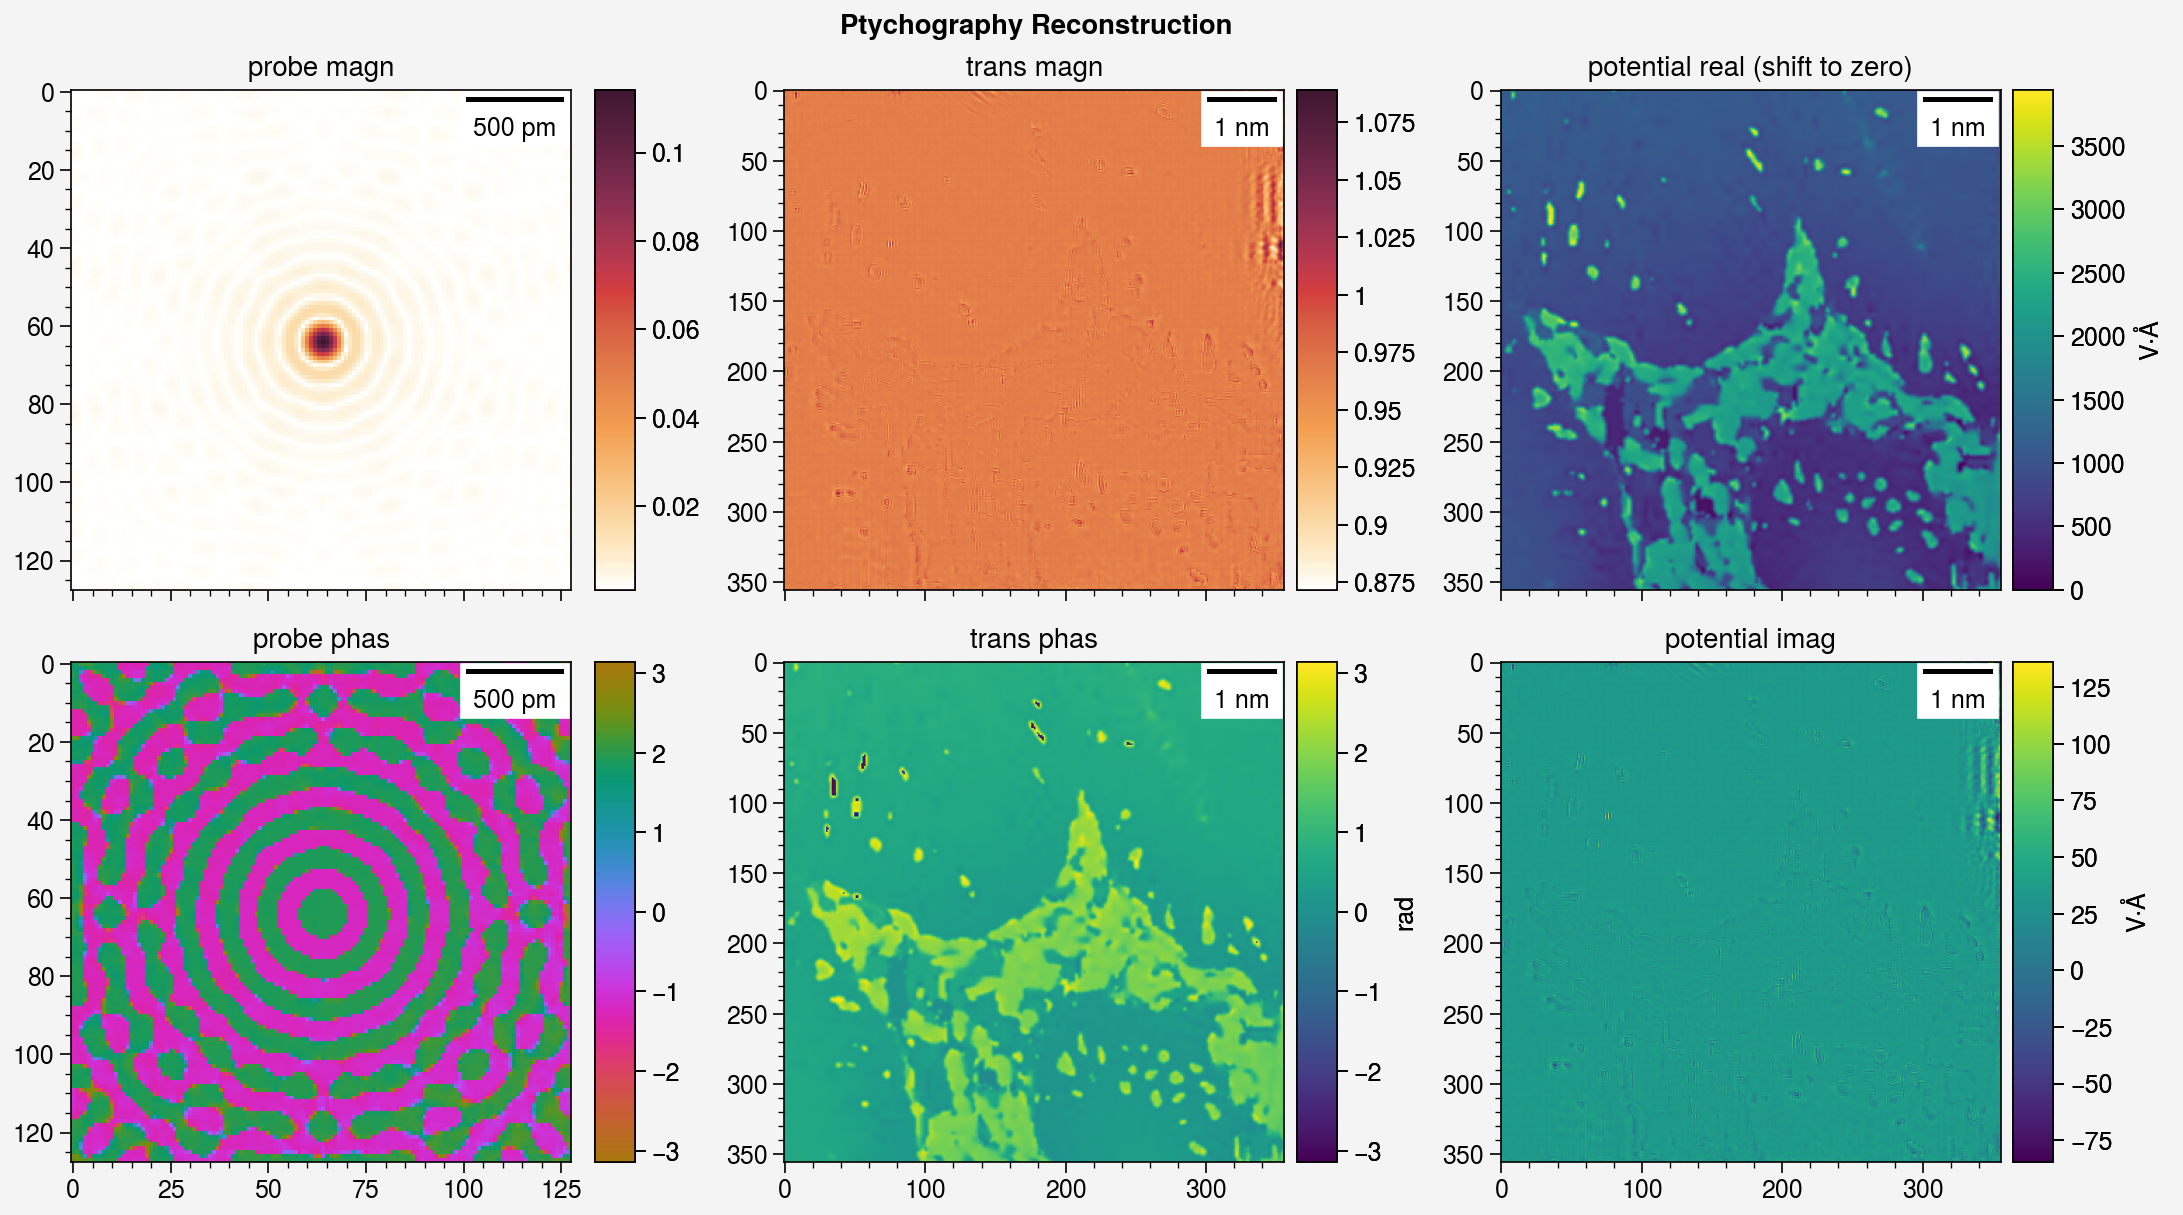

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
import proplot as pplt
from matplotlib_scalebar.scalebar import ScaleBar
pplt.rc["grid"] = False

fig, axs = pplt.subplots(nrows=2, ncols=3, sharey=False, suptitle="Ptychography Reconstruction")

# probe image (magnitude and phase parts)
m = axs[0, 0].imshow(np.abs(probe_rot) + 1e-3)#, norm=colors.LogNorm())
axs[0, 0].format(title="probe magn")
axs[0, 0].colorbar(m, loc="r")

m = axs[1, 0].imshow(np.angle(probe_rot), cmap="phase", vmin=-np.pi, vmax=np.pi)
axs[1, 0].format(title="probe phas")
axs[1, 0].colorbar(m, loc="r")

# transmission function (magnitude and phase parts)
m = axs[0, 1].imshow(np.abs(trans_rot))
axs[0, 1].format(title="trans magn")
axs[0, 1].colorbar(m, loc="r")

m = axs[1, 1].imshow(np.angle(trans_rot), cmap="viridis")
axs[1, 1].format(title="trans phas")
axs[1, 1].colorbar(m, loc="r", label="rad")

# potential function (real and imaginary parts)
m = axs[0, 2].imshow((potential_real - potential_real.min()) * 1e10, cmap="viridis")
axs[0, 2].format(title="potential real (shift to zero)")
axs[0, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

m = axs[1, 2].imshow(potential_imag * 1e10, cmap="viridis")
axs[1, 2].format(title="potential imag")
axs[1, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

for i in range(2):
    for j in range(3):
        axs[i, j].add_artist(ScaleBar(resolution_real_space, "m", length_fraction=0.2))

pplt.show()
fig.savefig(result_path/"overview.png")

In [12]:
print(f"--- {time.time() - start_time} seconds ---")

--- 2645.2385246753693 seconds ---


## Save the Results of the Final Iteration

In [13]:
np.save(result_path/"final_probe_rot.npy", probe_rot)
np.save(result_path/"final_trans_rot.npy", trans_rot)
np.save(result_path/"final_poten_rot.npy", potential)

## Fit Aberration in Probe Wave Function

In [14]:
from fitaber import fit_aber, coefs_all_up_to
import fitaber

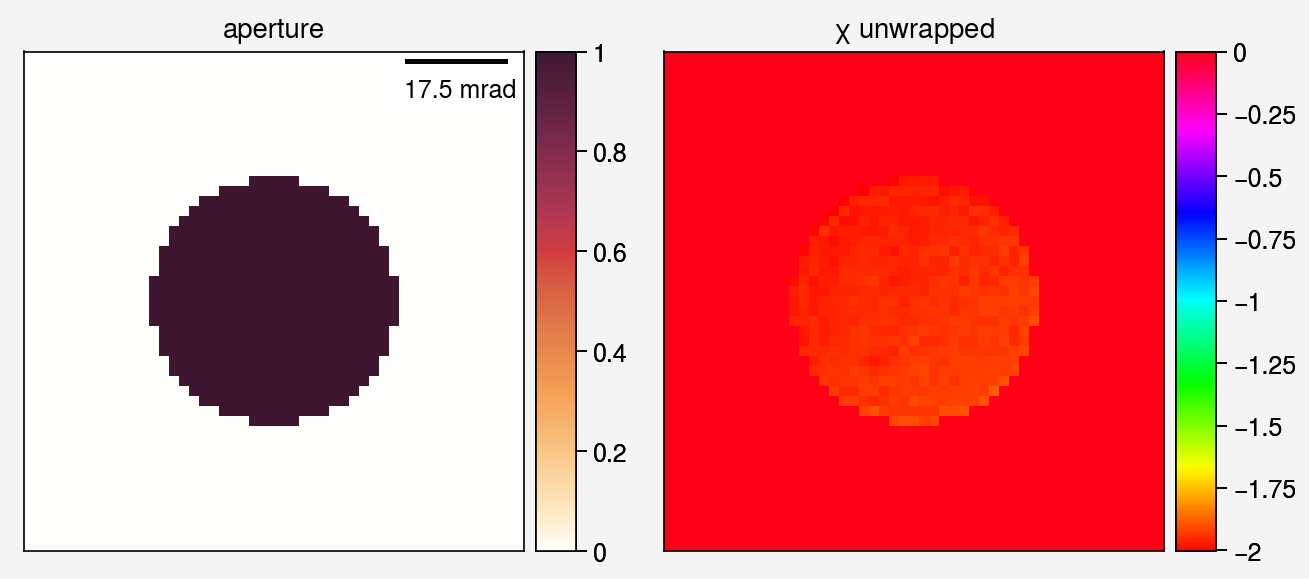

In [15]:
aperture = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot))))
aperture = (aperture > aperture.max()/2).astype(np.int32)
# chi = -np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture
chi = -unwrap_phase(np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture, wrap_around=True) * aperture

margin = aperture.shape[0]/2 - np.sum(aperture[aperture.shape[0]//2,:])
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2,
                                xlim=(margin, chi.shape[1]-margin),
                                ylim=(margin, chi.shape[1]-margin),
                                xticks=[], yticks=[])
m = ax1.imshow(aperture)
ax1.add_artist(ScaleBar(resolution_reciprocal_space_rad,
                        units="deg", dimension="angle", length_fraction=0.25,
                        scale_formatter=lambda value, unit: f"{value*np.pi/180*1e3: .1f} mrad"))
ax1.colorbar(m, loc="r")
ax1.format(title="aperture")

m = ax2.imshow(chi, cmap="hsv")
ax2.colorbar(m, loc="r")
ax2.format(title="$\chi$ unwrapped")

In [16]:
result_aber = fit_aber(chi, coefs_all_up_to(), scale=resolution_reciprocal_space_rad, mask=aperture, kV=attrs["voltage"])
print(result_aber.format())

[
[ 0]:      -: c(0,0) = C(-1,0)= Polar(  0.001292 nm,        180 °)
[ 1]:     A0: c(1,1) = C(0,1) = Polar(  0.001342 nm,      148.1 °)
[ 3]:     C1: c(2,0) = C(1,0) = Polar(   0.07768 nm,          0 °)
[ 4]:     A1: c(2,2) = C(1,2) = Polar(   0.07655 nm,     -77.66 °)
[ 6]: 1/3 B2: c(3,1) = C(2,1) = Polar(     15.57 nm,     -23.99 °)
[ 8]:     A2: c(3,3) = C(2,3) = Polar(     1.839 nm,      52.24 °)
[10]:     C3: c(4,0) = C(3,0) = Polar(    0.9424 um,        180 °)
[11]: 1/4 S3: c(4,2) = C(3,2) = Polar(     1.165 um,      11.38 °)
[13]:     A3: c(4,4) = C(3,4) = Polar(   0.08451 um,     -29.87 °)
[15]: 1/5 B4: c(5,1) = C(4,1) = Polar(     68.73 um,      154.6 °)
[17]: 1/5 D4: c(5,3) = C(4,3) = Polar(     9.211 um,     -12.87 °)
[19]:     A4: c(5,5) = C(4,5) = Polar(     4.297 um,     0.0992 °)
[21]:     C5: c(6,0) = C(5,0) = Polar(     2.272 mm,          0 °)
[22]: 1/6 S5: c(6,2) = C(5,2) = Polar(     2.945 mm,     -77.97 °)
[24]: 1/6 R5: c(6,4) = C(5,4) = Polar(    0.3726 mm,      10